<a href="https://colab.research.google.com/github/dhia-eddine-jedidi/Deep-Learning-Project-using-Autoencoder-CNN-LSTM/blob/main/3D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🧩 Step 1 — Dataset Download and Organization
Downloading CREMA-D video dataset using KaggleHub, then organizing the video files into folders by emotion (Anger, Disgust, Fear, Happy, Neutral, Sad). It filters each emotion category into a structured output directory for further preprocessing.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("stefanogiannini/crema-d-video")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'crema-d-video' dataset.
Path to dataset files: /kaggle/input/crema-d-video


In [ ]:
import os
import shutil
import random
from tqdm import tqdm

# =========================================
# CONFIGURATION
# =========================================
source_dir = "/kaggle/input/crema-d-video"      # Folder with all .mp4 files
output_dir = "CREMA-D-Sorted1"         # Target folder
keep_ratio = 1

# Emotion mapping
emotion_map = {
    "ANG": "Anger",
    "DIS": "Disgust",
    "FEA": "Fear",
    "HAP": "Happy",
    "NEU": "Neutral",
    "SAD": "Sad"
}

# =========================================
# CREATE TARGET FOLDERS
# =========================================
for emotion_name in emotion_map.values():
    os.makedirs(os.path.join(output_dir, emotion_name), exist_ok=True)

# =========================================
# GROUP FILES BY EMOTION
# =========================================
emotion_files = {emotion: [] for emotion in emotion_map.values()}

for filename in os.listdir(source_dir):
    if filename.endswith(".flv"):
        parts = filename.replace(".flv", "").split("_")
        if len(parts) == 4:
            emotion_code = parts[2]
            emotion_full = emotion_map.get(emotion_code)
            if emotion_full:
                emotion_files[emotion_full].append(filename)
        else:
            print(f"⚠️ Skipping malformed filename: {filename}")

# =========================================
# COPY ONLY 10% OF EACH CLASS
# =========================================
for emotion, files in emotion_files.items():
    if not files:
        continue

    n_keep = max(1, int(len(files) * keep_ratio))  # at least 1 file
    selected = random.sample(files, n_keep)

    print(f"📂 {emotion}: keeping {n_keep} of {len(files)} files ({keep_ratio*100:.0f}%)")

    for filename in tqdm(selected, desc=f"Copying {emotion}"):
        src = os.path.join(source_dir, filename)
        dst = os.path.join(output_dir, emotion, filename)
        shutil.copy2(src, dst)

print("\n✅ Done! Only 10% of each class copied to:", output_dir)


📂 Anger: keeping 1271 of 1271 files (100%)


Copying Anger: 100%|██████████| 1271/1271 [00:11<00:00, 110.79it/s]


📂 Disgust: keeping 1271 of 1271 files (100%)


Copying Disgust: 100%|██████████| 1271/1271 [00:11<00:00, 110.93it/s]


📂 Fear: keeping 1271 of 1271 files (100%)


Copying Fear: 100%|██████████| 1271/1271 [00:11<00:00, 108.23it/s]


📂 Happy: keeping 1271 of 1271 files (100%)


Copying Happy: 100%|██████████| 1271/1271 [00:11<00:00, 108.06it/s]


📂 Neutral: keeping 1087 of 1087 files (100%)


Copying Neutral: 100%|██████████| 1087/1087 [00:08<00:00, 123.90it/s]


📂 Sad: keeping 1271 of 1271 files (100%)


Copying Sad: 100%|██████████| 1271/1271 [00:11<00:00, 106.72it/s]


✅ Done! Only 10% of each class copied to: CREMA-D-Sorted1


### 🎥 Step 2 — Frame Extraction and Face Cropping
This step processes the organized video dataset to extract frames and detect faces.  
Each video is read frame by frame, the largest detected face is cropped and resized to **224×224 pixels**, then saved as grayscale images.  
The frames are grouped by emotion to prepare clean, uniform facial data for model training.


In [ ]:
import os
import cv2
from tqdm import tqdm

# =========================================
# PATH CONFIGURATION
# =========================================
videos_root = "/content/CREMA-D-Sorted1"   # input videos sorted by emotion
frames_root = "/content/Df_Frames"         # output extracted frames
os.makedirs(frames_root, exist_ok=True)

# =========================================
# FACE DETECTOR INITIALIZATION
# =========================================
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def crop_face(image, target_size=(224, 224)):
    """Detect and crop the largest face in an image; fallback to resize full frame."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    if len(faces) > 0:
        x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])  # largest face
        face = gray[y:y + h, x:x + w]
    else:
        face = gray  # fallback
    face = cv2.resize(face, target_size)
    return face

# =========================================
# FRAME EXTRACTION (≈30 FPS)
# =========================================
valid_exts = (".mp4", ".flv", ".avi", ".mov")

for emotion in sorted(os.listdir(videos_root)):
    emotion_dir = os.path.join(videos_root, emotion)
    if not os.path.isdir(emotion_dir):
        continue

    print(f"\n🎞️ Extracting frames for emotion: {emotion}")
    emotion_out_dir = os.path.join(frames_root, emotion)
    os.makedirs(emotion_out_dir, exist_ok=True)

    for video_file in tqdm(sorted(os.listdir(emotion_dir))):
        if not video_file.lower().endswith(valid_exts):
            continue

        video_path = os.path.join(emotion_dir, video_file)
        base_name = os.path.splitext(video_file)[0]
        out_dir = os.path.join(emotion_out_dir, base_name)
        os.makedirs(out_dir, exist_ok=True)

        vidcap = cv2.VideoCapture(video_path)
        if not vidcap.isOpened():
            print(f"⚠️ Could not open {video_path}")
            continue

        fps = vidcap.get(cv2.CAP_PROP_FPS)
        frame_interval = max(int(fps //5), 1)  # keep ~30 frames per second

        frame_idx = 0
        saved_idx = 0

        while True:
            success, frame = vidcap.read()
            if not success:
                break

            # Extract every Nth frame to achieve ~30 FPS
            if frame_idx % frame_interval == 0:
                face_gray = crop_face(frame, target_size=(224, 224))
                frame_name = f"frame_{saved_idx:04d}.jpg"
                cv2.imwrite(os.path.join(out_dir, frame_name), face_gray)
                saved_idx += 1

            frame_idx += 1

        vidcap.release()

        if saved_idx == 0:
            print(f"⚠️ Skipped empty or unreadable: {video_file}")
            os.rmdir(out_dir)
        else:
            print(f"✅ {video_file}: {saved_idx} cropped gray frames extracted → {out_dir}")

print("\n✅ All videos processed, cropped, and grayscaled by emotion!")



🎞️ Extracting frames for emotion: Anger


  0%|          | 1/1271 [00:00<16:18,  1.30it/s]

✅ 1001_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1001_DFA_ANG_XX


  0%|          | 2/1271 [00:01<09:54,  2.13it/s]

✅ 1001_IEO_ANG_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1001_IEO_ANG_HI


  0%|          | 3/1271 [00:01<08:05,  2.61it/s]

✅ 1001_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1001_IEO_ANG_LO


  0%|          | 4/1271 [00:01<07:48,  2.70it/s]

✅ 1001_IEO_ANG_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1001_IEO_ANG_MD


  0%|          | 5/1271 [00:01<07:05,  2.98it/s]

✅ 1001_IOM_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1001_IOM_ANG_XX


  0%|          | 6/1271 [00:02<06:51,  3.07it/s]

✅ 1001_ITH_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1001_ITH_ANG_XX


  1%|          | 7/1271 [00:02<06:57,  3.02it/s]

✅ 1001_ITS_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1001_ITS_ANG_XX


  1%|          | 8/1271 [00:02<07:28,  2.81it/s]

✅ 1001_IWL_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1001_IWL_ANG_XX


  1%|          | 9/1271 [00:03<07:03,  2.98it/s]

✅ 1001_IWW_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1001_IWW_ANG_XX


  1%|          | 10/1271 [00:03<07:20,  2.86it/s]

✅ 1001_MTI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1001_MTI_ANG_XX


  1%|          | 11/1271 [00:03<06:56,  3.03it/s]

✅ 1001_TAI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1001_TAI_ANG_XX


  1%|          | 12/1271 [00:04<07:18,  2.87it/s]

✅ 1001_TIE_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1001_TIE_ANG_XX


  1%|          | 13/1271 [00:04<07:05,  2.95it/s]

✅ 1001_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1001_TSI_ANG_XX


  1%|          | 14/1271 [00:05<07:09,  2.93it/s]

✅ 1001_WSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1001_WSI_ANG_XX


  1%|          | 15/1271 [00:05<07:11,  2.91it/s]

✅ 1002_DFA_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1002_DFA_ANG_XX


  1%|▏         | 16/1271 [00:05<07:28,  2.80it/s]

✅ 1002_IEO_ANG_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1002_IEO_ANG_HI


  1%|▏         | 17/1271 [00:06<07:24,  2.82it/s]

✅ 1002_IEO_ANG_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1002_IEO_ANG_LO


  1%|▏         | 18/1271 [00:06<07:36,  2.74it/s]

✅ 1002_IEO_ANG_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1002_IEO_ANG_MD


  1%|▏         | 19/1271 [00:06<07:42,  2.71it/s]

✅ 1002_IOM_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1002_IOM_ANG_XX


  2%|▏         | 20/1271 [00:07<07:52,  2.65it/s]

✅ 1002_ITH_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1002_ITH_ANG_XX


  2%|▏         | 21/1271 [00:07<07:46,  2.68it/s]

✅ 1002_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1002_ITS_ANG_XX


  2%|▏         | 22/1271 [00:07<07:38,  2.72it/s]

✅ 1002_IWL_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1002_IWL_ANG_XX


  2%|▏         | 23/1271 [00:08<07:25,  2.80it/s]

✅ 1002_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1002_IWW_ANG_XX


  2%|▏         | 24/1271 [00:08<07:30,  2.77it/s]

✅ 1002_MTI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1002_MTI_ANG_XX


  2%|▏         | 25/1271 [00:09<07:21,  2.82it/s]

✅ 1002_TAI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1002_TAI_ANG_XX


  2%|▏         | 26/1271 [00:09<07:19,  2.83it/s]

✅ 1002_TIE_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1002_TIE_ANG_XX


  2%|▏         | 27/1271 [00:09<07:11,  2.88it/s]

✅ 1002_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1002_TSI_ANG_XX


  2%|▏         | 28/1271 [00:10<07:14,  2.86it/s]

✅ 1002_WSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1002_WSI_ANG_XX


  2%|▏         | 29/1271 [00:10<07:42,  2.69it/s]

✅ 1003_DFA_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1003_DFA_ANG_XX


  2%|▏         | 30/1271 [00:10<07:34,  2.73it/s]

✅ 1003_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1003_IEO_ANG_HI


  2%|▏         | 31/1271 [00:11<07:14,  2.85it/s]

✅ 1003_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1003_IEO_ANG_LO


  3%|▎         | 32/1271 [00:11<07:24,  2.79it/s]

✅ 1003_IEO_ANG_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1003_IEO_ANG_MD


  3%|▎         | 33/1271 [00:11<07:31,  2.74it/s]

✅ 1003_IOM_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1003_IOM_ANG_XX


  3%|▎         | 34/1271 [00:12<08:27,  2.44it/s]

✅ 1003_ITH_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1003_ITH_ANG_XX


  3%|▎         | 35/1271 [00:12<09:05,  2.27it/s]

✅ 1003_ITS_ANG_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Anger/1003_ITS_ANG_XX


  3%|▎         | 36/1271 [00:13<09:23,  2.19it/s]

✅ 1003_IWL_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1003_IWL_ANG_XX


  3%|▎         | 37/1271 [00:13<09:14,  2.22it/s]

✅ 1003_IWW_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1003_IWW_ANG_XX


  3%|▎         | 38/1271 [00:14<09:20,  2.20it/s]

✅ 1003_MTI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1003_MTI_ANG_XX


  3%|▎         | 39/1271 [00:14<08:59,  2.28it/s]

✅ 1003_TAI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1003_TAI_ANG_XX


  3%|▎         | 40/1271 [00:15<09:03,  2.27it/s]

✅ 1003_TIE_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1003_TIE_ANG_XX


  3%|▎         | 41/1271 [00:15<09:24,  2.18it/s]

✅ 1003_TSI_ANG_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Anger/1003_TSI_ANG_XX


  3%|▎         | 42/1271 [00:16<09:42,  2.11it/s]

✅ 1003_WSI_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1003_WSI_ANG_XX


  3%|▎         | 43/1271 [00:16<09:20,  2.19it/s]

✅ 1004_DFA_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1004_DFA_ANG_XX


  3%|▎         | 44/1271 [00:17<09:52,  2.07it/s]

✅ 1004_IEO_ANG_HI.flv: 24 cropped gray frames extracted → /content/Df_Frames/Anger/1004_IEO_ANG_HI


  4%|▎         | 45/1271 [00:17<09:08,  2.24it/s]

✅ 1004_IEO_ANG_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1004_IEO_ANG_LO


  4%|▎         | 46/1271 [00:17<08:52,  2.30it/s]

✅ 1004_IEO_ANG_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1004_IEO_ANG_MD


  4%|▎         | 47/1271 [00:18<08:19,  2.45it/s]

✅ 1004_IOM_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1004_IOM_ANG_XX


  4%|▍         | 48/1271 [00:18<08:38,  2.36it/s]

✅ 1004_ITH_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1004_ITH_ANG_XX


  4%|▍         | 49/1271 [00:19<08:55,  2.28it/s]

✅ 1004_ITS_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1004_ITS_ANG_XX


  4%|▍         | 50/1271 [00:19<08:49,  2.30it/s]

✅ 1004_IWL_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1004_IWL_ANG_XX


  4%|▍         | 51/1271 [00:19<08:15,  2.46it/s]

✅ 1004_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1004_IWW_ANG_XX


  4%|▍         | 52/1271 [00:20<08:33,  2.38it/s]

✅ 1004_MTI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1004_MTI_ANG_XX


  4%|▍         | 53/1271 [00:20<08:50,  2.30it/s]

✅ 1004_TAI_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1004_TAI_ANG_XX


  4%|▍         | 54/1271 [00:21<08:27,  2.40it/s]

✅ 1004_TIE_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1004_TIE_ANG_XX


  4%|▍         | 55/1271 [00:21<07:56,  2.55it/s]

✅ 1004_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1004_TSI_ANG_XX


  4%|▍         | 56/1271 [00:21<08:02,  2.52it/s]

✅ 1004_WSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1004_WSI_ANG_XX


  4%|▍         | 57/1271 [00:22<07:36,  2.66it/s]

✅ 1005_DFA_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1005_DFA_ANG_XX


  5%|▍         | 58/1271 [00:22<07:11,  2.81it/s]

✅ 1005_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1005_IEO_ANG_HI


  5%|▍         | 59/1271 [00:22<06:46,  2.98it/s]

✅ 1005_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1005_IEO_ANG_LO


  5%|▍         | 60/1271 [00:23<06:50,  2.95it/s]

✅ 1005_IEO_ANG_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1005_IEO_ANG_MD


  5%|▍         | 61/1271 [00:23<07:38,  2.64it/s]

✅ 1005_IOM_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1005_IOM_ANG_XX


  5%|▍         | 62/1271 [00:24<07:54,  2.55it/s]

✅ 1005_ITH_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1005_ITH_ANG_XX


  5%|▍         | 63/1271 [00:24<08:20,  2.41it/s]

✅ 1005_ITS_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1005_ITS_ANG_XX


  5%|▌         | 64/1271 [00:25<08:34,  2.35it/s]

✅ 1005_IWL_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1005_IWL_ANG_XX


  5%|▌         | 65/1271 [00:25<08:28,  2.37it/s]

✅ 1005_IWW_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1005_IWW_ANG_XX


  5%|▌         | 66/1271 [00:25<08:47,  2.29it/s]

✅ 1005_MTI_ANG_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Anger/1005_MTI_ANG_XX


  5%|▌         | 67/1271 [00:26<08:53,  2.25it/s]

✅ 1005_TAI_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1005_TAI_ANG_XX


  5%|▌         | 68/1271 [00:26<08:20,  2.40it/s]

✅ 1005_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1005_TIE_ANG_XX


  5%|▌         | 69/1271 [00:27<08:02,  2.49it/s]

✅ 1005_TSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1005_TSI_ANG_XX


  6%|▌         | 70/1271 [00:27<08:13,  2.43it/s]

✅ 1005_WSI_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1005_WSI_ANG_XX


  6%|▌         | 71/1271 [00:27<07:52,  2.54it/s]

✅ 1006_DFA_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1006_DFA_ANG_XX


  6%|▌         | 72/1271 [00:28<07:35,  2.63it/s]

✅ 1006_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1006_IEO_ANG_HI


  6%|▌         | 73/1271 [00:28<07:21,  2.71it/s]

✅ 1006_IEO_ANG_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1006_IEO_ANG_LO


  6%|▌         | 74/1271 [00:28<06:39,  3.00it/s]

✅ 1006_IEO_ANG_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1006_IEO_ANG_MD


  6%|▌         | 75/1271 [00:29<07:19,  2.72it/s]

✅ 1006_IOM_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1006_IOM_ANG_XX


  6%|▌         | 76/1271 [00:29<07:48,  2.55it/s]

✅ 1006_ITH_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1006_ITH_ANG_XX


  6%|▌         | 77/1271 [00:30<08:05,  2.46it/s]

✅ 1006_ITS_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1006_ITS_ANG_XX


  6%|▌         | 78/1271 [00:30<08:14,  2.41it/s]

✅ 1006_IWL_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1006_IWL_ANG_XX


  6%|▌         | 79/1271 [00:31<08:03,  2.47it/s]

✅ 1006_IWW_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1006_IWW_ANG_XX


  6%|▋         | 80/1271 [00:31<08:38,  2.30it/s]

✅ 1006_MTI_ANG_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Anger/1006_MTI_ANG_XX


  6%|▋         | 81/1271 [00:31<08:39,  2.29it/s]

✅ 1006_TAI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1006_TAI_ANG_XX


  6%|▋         | 82/1271 [00:32<09:17,  2.13it/s]

✅ 1006_TIE_ANG_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Anger/1006_TIE_ANG_XX


  7%|▋         | 83/1271 [00:32<08:26,  2.35it/s]

✅ 1006_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1006_TSI_ANG_XX


  7%|▋         | 84/1271 [00:33<08:02,  2.46it/s]

✅ 1006_WSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1006_WSI_ANG_XX


  7%|▋         | 85/1271 [00:33<07:32,  2.62it/s]

✅ 1007_DFA_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1007_DFA_ANG_XX


  7%|▋         | 86/1271 [00:33<07:07,  2.77it/s]

✅ 1007_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1007_IEO_ANG_HI


  7%|▋         | 87/1271 [00:34<06:20,  3.11it/s]

✅ 1007_IEO_ANG_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1007_IEO_ANG_LO


  7%|▋         | 88/1271 [00:34<06:30,  3.03it/s]

✅ 1007_IEO_ANG_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1007_IEO_ANG_MD


  7%|▋         | 89/1271 [00:34<07:17,  2.70it/s]

✅ 1007_IOM_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1007_IOM_ANG_XX


  7%|▋         | 90/1271 [00:35<07:53,  2.49it/s]

✅ 1007_ITH_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1007_ITH_ANG_XX


  7%|▋         | 91/1271 [00:35<08:13,  2.39it/s]

✅ 1007_ITS_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1007_ITS_ANG_XX


  7%|▋         | 92/1271 [00:36<08:32,  2.30it/s]

✅ 1007_IWL_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1007_IWL_ANG_XX


  7%|▋         | 93/1271 [00:36<08:18,  2.36it/s]

✅ 1007_IWW_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1007_IWW_ANG_XX


  7%|▋         | 94/1271 [00:37<09:14,  2.12it/s]

✅ 1007_MTI_ANG_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Anger/1007_MTI_ANG_XX


  7%|▋         | 95/1271 [00:37<09:00,  2.18it/s]

✅ 1007_TAI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1007_TAI_ANG_XX


  8%|▊         | 96/1271 [00:38<09:43,  2.01it/s]

✅ 1007_TIE_ANG_XX.flv: 28 cropped gray frames extracted → /content/Df_Frames/Anger/1007_TIE_ANG_XX


  8%|▊         | 97/1271 [00:38<08:34,  2.28it/s]

✅ 1007_TSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1007_TSI_ANG_XX


  8%|▊         | 98/1271 [00:39<08:29,  2.30it/s]

✅ 1007_WSI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1007_WSI_ANG_XX


  8%|▊         | 99/1271 [00:39<08:12,  2.38it/s]

✅ 1008_DFA_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1008_DFA_ANG_XX


  8%|▊         | 100/1271 [00:39<07:49,  2.49it/s]

✅ 1008_IEO_ANG_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1008_IEO_ANG_HI


  8%|▊         | 101/1271 [00:40<07:07,  2.74it/s]

✅ 1008_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1008_IEO_ANG_LO


  8%|▊         | 102/1271 [00:40<06:48,  2.86it/s]

✅ 1008_IEO_ANG_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1008_IEO_ANG_MD


  8%|▊         | 103/1271 [00:40<07:20,  2.65it/s]

✅ 1008_IOM_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1008_IOM_ANG_XX


  8%|▊         | 104/1271 [00:41<08:02,  2.42it/s]

✅ 1008_ITH_ANG_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Anger/1008_ITH_ANG_XX


  8%|▊         | 105/1271 [00:41<07:55,  2.45it/s]

✅ 1008_ITS_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1008_ITS_ANG_XX


  8%|▊         | 106/1271 [00:42<08:20,  2.33it/s]

✅ 1008_IWL_ANG_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Anger/1008_IWL_ANG_XX


  8%|▊         | 107/1271 [00:42<08:15,  2.35it/s]

✅ 1008_IWW_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1008_IWW_ANG_XX


  8%|▊         | 108/1271 [00:43<08:16,  2.34it/s]

✅ 1008_MTI_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1008_MTI_ANG_XX


  9%|▊         | 109/1271 [00:43<08:25,  2.30it/s]

✅ 1008_TAI_ANG_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Anger/1008_TAI_ANG_XX


  9%|▊         | 110/1271 [00:44<09:10,  2.11it/s]

✅ 1008_TIE_ANG_XX.flv: 30 cropped gray frames extracted → /content/Df_Frames/Anger/1008_TIE_ANG_XX


  9%|▊         | 111/1271 [00:44<08:29,  2.27it/s]

✅ 1008_TSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1008_TSI_ANG_XX


  9%|▉         | 112/1271 [00:44<07:22,  2.62it/s]

✅ 1009_DFA_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1009_DFA_ANG_XX


  9%|▉         | 113/1271 [00:44<07:08,  2.70it/s]

✅ 1009_IEO_ANG_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1009_IEO_ANG_HI


  9%|▉         | 114/1271 [00:45<06:42,  2.87it/s]

✅ 1009_IEO_ANG_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1009_IEO_ANG_LO


  9%|▉         | 115/1271 [00:45<06:19,  3.05it/s]

✅ 1009_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1009_IEO_ANG_MD


  9%|▉         | 116/1271 [00:45<06:29,  2.97it/s]

✅ 1009_IOM_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1009_IOM_ANG_XX


  9%|▉         | 117/1271 [00:46<06:29,  2.96it/s]

✅ 1009_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1009_ITH_ANG_XX


  9%|▉         | 118/1271 [00:46<07:02,  2.73it/s]

✅ 1009_ITS_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1009_ITS_ANG_XX


  9%|▉         | 119/1271 [00:47<07:11,  2.67it/s]

✅ 1009_IWL_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1009_IWL_ANG_XX


  9%|▉         | 120/1271 [00:47<07:07,  2.69it/s]

✅ 1009_IWW_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1009_IWW_ANG_XX


 10%|▉         | 121/1271 [00:47<06:45,  2.83it/s]

✅ 1009_TAI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1009_TAI_ANG_XX


 10%|▉         | 122/1271 [00:48<06:51,  2.79it/s]

✅ 1009_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1009_TIE_ANG_XX


 10%|▉         | 123/1271 [00:48<06:24,  2.98it/s]

✅ 1009_TSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1009_TSI_ANG_XX


 10%|▉         | 124/1271 [00:48<06:44,  2.83it/s]

✅ 1009_WSI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1009_WSI_ANG_XX


 10%|▉         | 125/1271 [00:49<06:17,  3.03it/s]

✅ 1010_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1010_DFA_ANG_XX


 10%|▉         | 126/1271 [00:49<05:49,  3.28it/s]

✅ 1010_IEO_ANG_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1010_IEO_ANG_HI


 10%|▉         | 127/1271 [00:49<05:37,  3.39it/s]

✅ 1010_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1010_IEO_ANG_LO


 10%|█         | 128/1271 [00:49<05:37,  3.39it/s]

✅ 1010_IEO_ANG_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1010_IEO_ANG_MD


 10%|█         | 129/1271 [00:50<05:39,  3.36it/s]

✅ 1010_IOM_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1010_IOM_ANG_XX


 10%|█         | 130/1271 [00:50<06:13,  3.05it/s]

✅ 1010_ITH_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1010_ITH_ANG_XX


 10%|█         | 131/1271 [00:50<06:16,  3.03it/s]

✅ 1010_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1010_ITS_ANG_XX


 10%|█         | 132/1271 [00:51<06:26,  2.95it/s]

✅ 1010_IWL_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1010_IWL_ANG_XX


 10%|█         | 133/1271 [00:51<06:06,  3.10it/s]

✅ 1010_IWW_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1010_IWW_ANG_XX


 11%|█         | 134/1271 [00:51<06:19,  2.99it/s]

✅ 1010_MTI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1010_MTI_ANG_XX


 11%|█         | 135/1271 [00:52<06:14,  3.04it/s]

✅ 1010_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1010_TAI_ANG_XX


 11%|█         | 136/1271 [00:52<06:43,  2.81it/s]

✅ 1010_TIE_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1010_TIE_ANG_XX


 11%|█         | 137/1271 [00:52<06:22,  2.97it/s]

✅ 1010_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1010_TSI_ANG_XX


 11%|█         | 138/1271 [00:53<06:37,  2.85it/s]

✅ 1010_WSI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1010_WSI_ANG_XX


 11%|█         | 139/1271 [00:53<06:52,  2.75it/s]

✅ 1011_DFA_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1011_DFA_ANG_XX


 11%|█         | 140/1271 [00:54<07:20,  2.57it/s]

✅ 1011_IEO_ANG_HI.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1011_IEO_ANG_HI


 11%|█         | 141/1271 [00:54<07:19,  2.57it/s]

✅ 1011_IEO_ANG_LO.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1011_IEO_ANG_LO


 11%|█         | 142/1271 [00:54<06:56,  2.71it/s]

✅ 1011_IEO_ANG_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1011_IEO_ANG_MD


 11%|█▏        | 143/1271 [00:55<06:46,  2.77it/s]

✅ 1011_IOM_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1011_IOM_ANG_XX


 11%|█▏        | 144/1271 [00:55<06:57,  2.70it/s]

✅ 1011_ITH_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1011_ITH_ANG_XX


 11%|█▏        | 145/1271 [00:56<06:58,  2.69it/s]

✅ 1011_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1011_ITS_ANG_XX


 11%|█▏        | 146/1271 [00:56<06:51,  2.73it/s]

✅ 1011_IWL_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1011_IWL_ANG_XX


 12%|█▏        | 147/1271 [00:56<06:39,  2.81it/s]

✅ 1011_IWW_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1011_IWW_ANG_XX


 12%|█▏        | 148/1271 [00:57<06:50,  2.73it/s]

✅ 1011_MTI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1011_MTI_ANG_XX


 12%|█▏        | 149/1271 [00:57<06:41,  2.79it/s]

✅ 1011_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1011_TAI_ANG_XX


 12%|█▏        | 150/1271 [00:57<07:11,  2.60it/s]

✅ 1011_TIE_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1011_TIE_ANG_XX


 12%|█▏        | 151/1271 [00:58<07:05,  2.63it/s]

✅ 1011_TSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1011_TSI_ANG_XX


 12%|█▏        | 152/1271 [00:58<07:28,  2.50it/s]

✅ 1011_WSI_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1011_WSI_ANG_XX


 12%|█▏        | 153/1271 [00:58<06:59,  2.66it/s]

✅ 1012_DFA_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1012_DFA_ANG_XX


 12%|█▏        | 154/1271 [00:59<06:20,  2.94it/s]

✅ 1012_IEO_ANG_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1012_IEO_ANG_HI


 12%|█▏        | 155/1271 [00:59<05:58,  3.11it/s]

✅ 1012_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1012_IEO_ANG_LO


 12%|█▏        | 156/1271 [00:59<05:44,  3.23it/s]

✅ 1012_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1012_IEO_ANG_MD


 12%|█▏        | 157/1271 [01:00<05:28,  3.39it/s]

✅ 1012_IOM_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1012_IOM_ANG_XX


 12%|█▏        | 158/1271 [01:00<05:42,  3.25it/s]

✅ 1012_ITH_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1012_ITH_ANG_XX


 13%|█▎        | 159/1271 [01:00<05:54,  3.13it/s]

✅ 1012_ITS_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1012_ITS_ANG_XX


 13%|█▎        | 160/1271 [01:01<05:49,  3.18it/s]

✅ 1012_IWL_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1012_IWL_ANG_XX


 13%|█▎        | 161/1271 [01:01<05:31,  3.35it/s]

✅ 1012_IWW_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1012_IWW_ANG_XX


 13%|█▎        | 162/1271 [01:01<05:24,  3.42it/s]

✅ 1012_MTI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1012_MTI_ANG_XX


 13%|█▎        | 163/1271 [01:01<05:13,  3.54it/s]

✅ 1012_TAI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1012_TAI_ANG_XX


 13%|█▎        | 164/1271 [01:02<05:22,  3.44it/s]

✅ 1012_TIE_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1012_TIE_ANG_XX


 13%|█▎        | 165/1271 [01:02<05:17,  3.48it/s]

✅ 1012_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1012_TSI_ANG_XX


 13%|█▎        | 166/1271 [01:02<05:14,  3.52it/s]

✅ 1012_WSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1012_WSI_ANG_XX


 13%|█▎        | 167/1271 [01:03<05:31,  3.33it/s]

✅ 1013_DFA_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1013_DFA_ANG_XX


 13%|█▎        | 169/1271 [01:03<05:12,  3.52it/s]

✅ 1013_IEO_ANG_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1013_IEO_ANG_HI
✅ 1013_IEO_ANG_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1013_IEO_ANG_LO


 13%|█▎        | 170/1271 [01:03<04:51,  3.78it/s]

✅ 1013_IEO_ANG_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1013_IEO_ANG_MD


 13%|█▎        | 171/1271 [01:04<05:03,  3.62it/s]

✅ 1013_IOM_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1013_IOM_ANG_XX


 14%|█▎        | 172/1271 [01:04<05:34,  3.28it/s]

✅ 1013_ITH_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1013_ITH_ANG_XX


 14%|█▎        | 173/1271 [01:04<05:38,  3.24it/s]

✅ 1013_ITS_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1013_ITS_ANG_XX


 14%|█▎        | 174/1271 [01:05<05:53,  3.11it/s]

✅ 1013_IWL_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1013_IWL_ANG_XX


 14%|█▍        | 175/1271 [01:05<05:33,  3.29it/s]

✅ 1013_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1013_IWW_ANG_XX


 14%|█▍        | 176/1271 [01:05<05:43,  3.19it/s]

✅ 1013_MTI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1013_MTI_ANG_XX


 14%|█▍        | 177/1271 [01:06<05:52,  3.11it/s]

✅ 1013_TAI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1013_TAI_ANG_XX


 14%|█▍        | 178/1271 [01:06<06:31,  2.79it/s]

✅ 1013_TIE_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1013_TIE_ANG_XX


 14%|█▍        | 179/1271 [01:06<06:10,  2.95it/s]

✅ 1013_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1013_TSI_ANG_XX


 14%|█▍        | 180/1271 [01:07<06:21,  2.86it/s]

✅ 1013_WSI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1013_WSI_ANG_XX


 14%|█▍        | 181/1271 [01:07<06:08,  2.96it/s]

✅ 1014_DFA_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1014_DFA_ANG_XX


 14%|█▍        | 182/1271 [01:07<06:12,  2.93it/s]

✅ 1014_IEO_ANG_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1014_IEO_ANG_HI


 14%|█▍        | 183/1271 [01:08<05:56,  3.05it/s]

✅ 1014_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1014_IEO_ANG_LO


 14%|█▍        | 184/1271 [01:08<06:04,  2.98it/s]

✅ 1014_IEO_ANG_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1014_IEO_ANG_MD


 15%|█▍        | 185/1271 [01:08<06:28,  2.80it/s]

✅ 1014_IOM_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1014_IOM_ANG_XX


 15%|█▍        | 186/1271 [01:09<06:54,  2.61it/s]

✅ 1014_ITH_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1014_ITH_ANG_XX


 15%|█▍        | 187/1271 [01:09<06:42,  2.69it/s]

✅ 1014_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1014_ITS_ANG_XX


 15%|█▍        | 188/1271 [01:10<07:13,  2.50it/s]

✅ 1014_IWL_ANG_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Anger/1014_IWL_ANG_XX


 15%|█▍        | 189/1271 [01:10<07:00,  2.57it/s]

✅ 1014_IWW_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1014_IWW_ANG_XX


 15%|█▍        | 190/1271 [01:11<07:17,  2.47it/s]

✅ 1014_MTI_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1014_MTI_ANG_XX


 15%|█▌        | 191/1271 [01:11<07:11,  2.50it/s]

✅ 1014_TAI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1014_TAI_ANG_XX


 15%|█▌        | 192/1271 [01:11<07:23,  2.43it/s]

✅ 1014_TIE_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1014_TIE_ANG_XX


 15%|█▌        | 193/1271 [01:12<07:14,  2.48it/s]

✅ 1014_TSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1014_TSI_ANG_XX


 15%|█▌        | 194/1271 [01:12<07:14,  2.48it/s]

✅ 1014_WSI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1014_WSI_ANG_XX


 15%|█▌        | 195/1271 [01:12<06:37,  2.71it/s]

✅ 1015_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1015_DFA_ANG_XX


 15%|█▌        | 196/1271 [01:13<06:05,  2.94it/s]

✅ 1015_IEO_ANG_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1015_IEO_ANG_HI


 15%|█▌        | 197/1271 [01:13<05:43,  3.13it/s]

✅ 1015_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1015_IEO_ANG_LO


 16%|█▌        | 198/1271 [01:13<05:54,  3.02it/s]

✅ 1015_IEO_ANG_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1015_IEO_ANG_MD


 16%|█▌        | 199/1271 [01:14<05:52,  3.04it/s]

✅ 1015_IOM_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1015_IOM_ANG_XX


 16%|█▌        | 200/1271 [01:14<05:52,  3.04it/s]

✅ 1015_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1015_ITH_ANG_XX


 16%|█▌        | 201/1271 [01:14<05:41,  3.13it/s]

✅ 1015_ITS_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1015_ITS_ANG_XX


 16%|█▌        | 202/1271 [01:15<05:57,  2.99it/s]

✅ 1015_IWL_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1015_IWL_ANG_XX


 16%|█▌        | 203/1271 [01:15<05:24,  3.29it/s]

✅ 1015_IWW_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1015_IWW_ANG_XX


 16%|█▌        | 204/1271 [01:15<05:25,  3.27it/s]

✅ 1015_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1015_MTI_ANG_XX


 16%|█▌        | 205/1271 [01:16<05:30,  3.23it/s]

✅ 1015_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1015_TAI_ANG_XX


 16%|█▌        | 206/1271 [01:16<05:54,  3.00it/s]

✅ 1015_TIE_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1015_TIE_ANG_XX


 16%|█▋        | 207/1271 [01:16<06:02,  2.94it/s]

✅ 1015_TSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1015_TSI_ANG_XX


 16%|█▋        | 208/1271 [01:17<05:59,  2.95it/s]

✅ 1015_WSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1015_WSI_ANG_XX


 16%|█▋        | 209/1271 [01:17<05:24,  3.27it/s]

✅ 1016_DFA_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1016_DFA_ANG_XX


 17%|█▋        | 210/1271 [01:17<05:28,  3.23it/s]

✅ 1016_IEO_ANG_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1016_IEO_ANG_HI


 17%|█▋        | 211/1271 [01:17<05:16,  3.34it/s]

✅ 1016_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1016_IEO_ANG_LO


 17%|█▋        | 212/1271 [01:18<05:09,  3.42it/s]

✅ 1016_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1016_IEO_ANG_MD


 17%|█▋        | 213/1271 [01:18<04:55,  3.58it/s]

✅ 1016_IOM_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1016_IOM_ANG_XX


 17%|█▋        | 214/1271 [01:18<05:14,  3.36it/s]

✅ 1016_ITH_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1016_ITH_ANG_XX


 17%|█▋        | 215/1271 [01:19<05:07,  3.44it/s]

✅ 1016_ITS_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1016_ITS_ANG_XX


 17%|█▋        | 216/1271 [01:19<05:23,  3.26it/s]

✅ 1016_IWL_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1016_IWL_ANG_XX


 17%|█▋        | 217/1271 [01:19<05:31,  3.18it/s]

✅ 1016_IWW_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1016_IWW_ANG_XX


 17%|█▋        | 218/1271 [01:20<05:36,  3.13it/s]

✅ 1016_MTI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1016_MTI_ANG_XX


 17%|█▋        | 219/1271 [01:20<05:33,  3.16it/s]

✅ 1016_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1016_TAI_ANG_XX


 17%|█▋        | 220/1271 [01:20<05:35,  3.13it/s]

✅ 1016_TIE_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1016_TIE_ANG_XX


 17%|█▋        | 221/1271 [01:20<05:01,  3.48it/s]

✅ 1016_TSI_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1016_TSI_ANG_XX


 18%|█▊        | 223/1271 [01:21<04:37,  3.78it/s]

✅ 1016_WSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1016_WSI_ANG_XX
✅ 1017_DFA_ANG_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1017_DFA_ANG_XX


 18%|█▊        | 224/1271 [01:21<04:58,  3.51it/s]

✅ 1017_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1017_IEO_ANG_HI


 18%|█▊        | 225/1271 [01:22<04:56,  3.53it/s]

✅ 1017_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1017_IEO_ANG_LO


 18%|█▊        | 226/1271 [01:22<05:15,  3.31it/s]

✅ 1017_IEO_ANG_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1017_IEO_ANG_MD


 18%|█▊        | 227/1271 [01:22<05:34,  3.12it/s]

✅ 1017_IOM_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1017_IOM_ANG_XX


 18%|█▊        | 228/1271 [01:23<05:52,  2.96it/s]

✅ 1017_ITH_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1017_ITH_ANG_XX


 18%|█▊        | 229/1271 [01:23<05:39,  3.07it/s]

✅ 1017_ITS_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1017_ITS_ANG_XX


 18%|█▊        | 230/1271 [01:23<05:17,  3.28it/s]

✅ 1017_IWL_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1017_IWL_ANG_XX


 18%|█▊        | 231/1271 [01:23<05:00,  3.46it/s]

✅ 1017_IWW_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1017_IWW_ANG_XX


 18%|█▊        | 232/1271 [01:24<05:14,  3.30it/s]

✅ 1017_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1017_MTI_ANG_XX


 18%|█▊        | 233/1271 [01:24<05:06,  3.39it/s]

✅ 1017_TAI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1017_TAI_ANG_XX


 18%|█▊        | 234/1271 [01:24<05:53,  2.93it/s]

✅ 1017_TIE_ANG_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Anger/1017_TIE_ANG_XX


 18%|█▊        | 235/1271 [01:25<05:39,  3.05it/s]

✅ 1017_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1017_TSI_ANG_XX


 19%|█▊        | 236/1271 [01:25<05:22,  3.21it/s]

✅ 1017_WSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1017_WSI_ANG_XX


 19%|█▊        | 237/1271 [01:25<05:02,  3.42it/s]

✅ 1018_DFA_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1018_DFA_ANG_XX


 19%|█▊        | 238/1271 [01:26<05:21,  3.22it/s]

✅ 1018_IEO_ANG_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1018_IEO_ANG_HI


 19%|█▉        | 239/1271 [01:26<05:13,  3.29it/s]

✅ 1018_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1018_IEO_ANG_LO


 19%|█▉        | 240/1271 [01:26<04:56,  3.48it/s]

✅ 1018_IEO_ANG_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1018_IEO_ANG_MD


 19%|█▉        | 241/1271 [01:26<04:50,  3.55it/s]

✅ 1018_IOM_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1018_IOM_ANG_XX


 19%|█▉        | 242/1271 [01:27<05:09,  3.33it/s]

✅ 1018_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1018_ITH_ANG_XX


 19%|█▉        | 243/1271 [01:27<05:10,  3.31it/s]

✅ 1018_ITS_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1018_ITS_ANG_XX


 19%|█▉        | 244/1271 [01:27<04:59,  3.43it/s]

✅ 1018_IWL_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1018_IWL_ANG_XX


 19%|█▉        | 245/1271 [01:28<04:50,  3.53it/s]

✅ 1018_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1018_IWW_ANG_XX


 19%|█▉        | 246/1271 [01:28<04:45,  3.59it/s]

✅ 1018_MTI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1018_MTI_ANG_XX


 19%|█▉        | 247/1271 [01:28<05:00,  3.41it/s]

✅ 1018_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1018_TAI_ANG_XX


 20%|█▉        | 248/1271 [01:29<05:47,  2.95it/s]

✅ 1018_TIE_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1018_TIE_ANG_XX


 20%|█▉        | 249/1271 [01:29<05:17,  3.22it/s]

✅ 1018_TSI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1018_TSI_ANG_XX


 20%|█▉        | 250/1271 [01:29<05:08,  3.31it/s]

✅ 1018_WSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1018_WSI_ANG_XX


 20%|█▉        | 251/1271 [01:29<04:38,  3.66it/s]

✅ 1019_DFA_ANG_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1019_DFA_ANG_XX


 20%|█▉        | 252/1271 [01:30<04:34,  3.71it/s]

✅ 1019_IEO_ANG_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1019_IEO_ANG_HI


 20%|█▉        | 253/1271 [01:30<04:24,  3.84it/s]

✅ 1019_IEO_ANG_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1019_IEO_ANG_LO


 20%|█▉        | 254/1271 [01:30<04:18,  3.93it/s]

✅ 1019_IEO_ANG_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1019_IEO_ANG_MD


 20%|██        | 255/1271 [01:30<04:33,  3.71it/s]

✅ 1019_IOM_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1019_IOM_ANG_XX


 20%|██        | 256/1271 [01:31<04:33,  3.71it/s]

✅ 1019_ITS_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1019_ITS_ANG_XX


 20%|██        | 257/1271 [01:31<04:40,  3.62it/s]

✅ 1019_IWL_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1019_IWL_ANG_XX


 20%|██        | 258/1271 [01:31<04:50,  3.49it/s]

✅ 1019_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1019_IWW_ANG_XX


 20%|██        | 259/1271 [01:32<04:38,  3.63it/s]

✅ 1019_MTI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1019_MTI_ANG_XX


 20%|██        | 260/1271 [01:32<05:04,  3.32it/s]

✅ 1019_TAI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1019_TAI_ANG_XX


 21%|██        | 261/1271 [01:32<05:38,  2.98it/s]

✅ 1019_TIE_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1019_TIE_ANG_XX


 21%|██        | 262/1271 [01:33<05:10,  3.25it/s]

✅ 1019_TSI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1019_TSI_ANG_XX


 21%|██        | 263/1271 [01:33<05:31,  3.04it/s]

✅ 1019_WSI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1019_WSI_ANG_XX


 21%|██        | 264/1271 [01:33<06:04,  2.76it/s]

✅ 1020_DFA_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1020_DFA_ANG_XX


 21%|██        | 265/1271 [01:34<05:55,  2.83it/s]

✅ 1020_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1020_IEO_ANG_HI


 21%|██        | 266/1271 [01:34<05:57,  2.81it/s]

✅ 1020_IEO_ANG_LO.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1020_IEO_ANG_LO


 21%|██        | 267/1271 [01:35<06:24,  2.61it/s]

✅ 1020_IEO_ANG_MD.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1020_IEO_ANG_MD


 21%|██        | 268/1271 [01:35<06:27,  2.59it/s]

✅ 1020_IOM_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1020_IOM_ANG_XX


 21%|██        | 269/1271 [01:35<07:00,  2.38it/s]

✅ 1020_ITH_ANG_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Anger/1020_ITH_ANG_XX


 21%|██        | 270/1271 [01:36<07:06,  2.35it/s]

✅ 1020_ITS_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1020_ITS_ANG_XX


 21%|██▏       | 271/1271 [01:36<07:14,  2.30it/s]

✅ 1020_IWL_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1020_IWL_ANG_XX


 21%|██▏       | 272/1271 [01:37<06:50,  2.44it/s]

✅ 1020_IWW_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1020_IWW_ANG_XX


 21%|██▏       | 273/1271 [01:37<06:28,  2.57it/s]

✅ 1020_MTI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1020_MTI_ANG_XX


 22%|██▏       | 274/1271 [01:37<06:25,  2.58it/s]

✅ 1020_TAI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1020_TAI_ANG_XX


 22%|██▏       | 275/1271 [01:38<07:01,  2.36it/s]

✅ 1020_TIE_ANG_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Anger/1020_TIE_ANG_XX


 22%|██▏       | 276/1271 [01:38<06:46,  2.45it/s]

✅ 1020_TSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1020_TSI_ANG_XX


 22%|██▏       | 277/1271 [01:39<06:35,  2.52it/s]

✅ 1020_WSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1020_WSI_ANG_XX


 22%|██▏       | 278/1271 [01:39<06:18,  2.62it/s]

✅ 1021_DFA_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1021_DFA_ANG_XX


 22%|██▏       | 279/1271 [01:39<06:25,  2.57it/s]

✅ 1021_IEO_ANG_HI.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1021_IEO_ANG_HI


 22%|██▏       | 280/1271 [01:40<05:56,  2.78it/s]

✅ 1021_IEO_ANG_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1021_IEO_ANG_LO


 22%|██▏       | 281/1271 [01:40<05:37,  2.94it/s]

✅ 1021_IEO_ANG_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1021_IEO_ANG_MD


 22%|██▏       | 282/1271 [01:40<05:25,  3.03it/s]

✅ 1021_IOM_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1021_IOM_ANG_XX


 22%|██▏       | 283/1271 [01:41<05:36,  2.94it/s]

✅ 1021_ITH_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1021_ITH_ANG_XX


 22%|██▏       | 284/1271 [01:41<05:47,  2.84it/s]

✅ 1021_ITS_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1021_ITS_ANG_XX


 22%|██▏       | 285/1271 [01:41<05:42,  2.88it/s]

✅ 1021_IWL_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1021_IWL_ANG_XX


 23%|██▎       | 286/1271 [01:42<05:40,  2.90it/s]

✅ 1021_IWW_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1021_IWW_ANG_XX


 23%|██▎       | 287/1271 [01:42<05:57,  2.75it/s]

✅ 1021_MTI_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1021_MTI_ANG_XX


 23%|██▎       | 288/1271 [01:43<06:11,  2.64it/s]

✅ 1021_TAI_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1021_TAI_ANG_XX


 23%|██▎       | 289/1271 [01:43<06:28,  2.53it/s]

✅ 1021_TIE_ANG_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Anger/1021_TIE_ANG_XX


 23%|██▎       | 290/1271 [01:43<06:02,  2.71it/s]

✅ 1021_TSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1021_TSI_ANG_XX


 23%|██▎       | 291/1271 [01:44<05:49,  2.81it/s]

✅ 1021_WSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1021_WSI_ANG_XX


 23%|██▎       | 292/1271 [01:44<05:52,  2.78it/s]

✅ 1022_DFA_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1022_DFA_ANG_XX


 23%|██▎       | 293/1271 [01:44<06:02,  2.70it/s]

✅ 1022_IEO_ANG_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1022_IEO_ANG_HI


 23%|██▎       | 294/1271 [01:45<05:20,  3.05it/s]

✅ 1022_IEO_ANG_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1022_IEO_ANG_LO


 23%|██▎       | 295/1271 [01:45<05:27,  2.98it/s]

✅ 1022_IEO_ANG_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1022_IEO_ANG_MD


 23%|██▎       | 296/1271 [01:45<05:34,  2.91it/s]

✅ 1022_IOM_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1022_IOM_ANG_XX


 23%|██▎       | 297/1271 [01:46<05:52,  2.76it/s]

✅ 1022_ITH_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1022_ITH_ANG_XX


 23%|██▎       | 298/1271 [01:46<05:38,  2.87it/s]

✅ 1022_ITS_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1022_ITS_ANG_XX


 24%|██▎       | 299/1271 [01:46<05:37,  2.88it/s]

✅ 1022_IWL_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1022_IWL_ANG_XX


 24%|██▎       | 300/1271 [01:47<05:29,  2.95it/s]

✅ 1022_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1022_IWW_ANG_XX


 24%|██▎       | 301/1271 [01:47<05:43,  2.82it/s]

✅ 1022_MTI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1022_MTI_ANG_XX


 24%|██▍       | 302/1271 [01:48<06:06,  2.64it/s]

✅ 1022_TAI_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1022_TAI_ANG_XX


 24%|██▍       | 303/1271 [01:48<06:38,  2.43it/s]

✅ 1022_TIE_ANG_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Anger/1022_TIE_ANG_XX


 24%|██▍       | 304/1271 [01:48<06:13,  2.59it/s]

✅ 1022_TSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1022_TSI_ANG_XX


 24%|██▍       | 305/1271 [01:49<06:21,  2.53it/s]

✅ 1022_WSI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1022_WSI_ANG_XX


 24%|██▍       | 306/1271 [01:49<05:56,  2.71it/s]

✅ 1023_DFA_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1023_DFA_ANG_XX


 24%|██▍       | 307/1271 [01:49<05:25,  2.97it/s]

✅ 1023_IEO_ANG_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1023_IEO_ANG_HI


 24%|██▍       | 308/1271 [01:50<04:52,  3.30it/s]

✅ 1023_IEO_ANG_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1023_IEO_ANG_LO


 24%|██▍       | 309/1271 [01:50<04:34,  3.51it/s]

✅ 1023_IEO_ANG_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1023_IEO_ANG_MD


 24%|██▍       | 310/1271 [01:50<04:35,  3.49it/s]

✅ 1023_IOM_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1023_IOM_ANG_XX


 24%|██▍       | 311/1271 [01:50<04:51,  3.30it/s]

✅ 1023_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1023_ITH_ANG_XX


 25%|██▍       | 312/1271 [01:51<05:02,  3.17it/s]

✅ 1023_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1023_ITS_ANG_XX


 25%|██▍       | 313/1271 [01:51<05:16,  3.02it/s]

✅ 1023_IWL_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1023_IWL_ANG_XX


 25%|██▍       | 314/1271 [01:51<04:46,  3.34it/s]

✅ 1023_IWW_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1023_IWW_ANG_XX


 25%|██▍       | 315/1271 [01:52<04:49,  3.30it/s]

✅ 1023_MTI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1023_MTI_ANG_XX


 25%|██▍       | 316/1271 [01:52<04:55,  3.24it/s]

✅ 1023_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1023_TAI_ANG_XX


 25%|██▍       | 317/1271 [01:52<05:02,  3.15it/s]

✅ 1023_TIE_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1023_TIE_ANG_XX


 25%|██▌       | 318/1271 [01:53<05:08,  3.09it/s]

✅ 1023_TSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1023_TSI_ANG_XX


 25%|██▌       | 319/1271 [01:53<05:13,  3.04it/s]

✅ 1023_WSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1023_WSI_ANG_XX


 25%|██▌       | 320/1271 [01:53<04:57,  3.20it/s]

✅ 1024_DFA_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1024_DFA_ANG_XX


 25%|██▌       | 321/1271 [01:54<04:56,  3.20it/s]

✅ 1024_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1024_IEO_ANG_HI


 25%|██▌       | 322/1271 [01:54<04:40,  3.38it/s]

✅ 1024_IEO_ANG_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1024_IEO_ANG_LO


 25%|██▌       | 323/1271 [01:54<04:36,  3.43it/s]

✅ 1024_IEO_ANG_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1024_IEO_ANG_MD


 25%|██▌       | 324/1271 [01:54<04:29,  3.52it/s]

✅ 1024_IOM_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1024_IOM_ANG_XX


 26%|██▌       | 325/1271 [01:55<04:48,  3.28it/s]

✅ 1024_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1024_ITH_ANG_XX


 26%|██▌       | 326/1271 [01:55<04:47,  3.29it/s]

✅ 1024_ITS_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1024_ITS_ANG_XX


 26%|██▌       | 327/1271 [01:55<04:56,  3.18it/s]

✅ 1024_IWL_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1024_IWL_ANG_XX


 26%|██▌       | 328/1271 [01:56<05:05,  3.09it/s]

✅ 1024_IWW_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1024_IWW_ANG_XX


 26%|██▌       | 329/1271 [01:56<05:03,  3.11it/s]

✅ 1024_MTI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1024_MTI_ANG_XX


 26%|██▌       | 330/1271 [01:56<04:56,  3.17it/s]

✅ 1024_TAI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1024_TAI_ANG_XX


 26%|██▌       | 331/1271 [01:57<05:21,  2.92it/s]

✅ 1024_TIE_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1024_TIE_ANG_XX


 26%|██▌       | 332/1271 [01:57<05:07,  3.05it/s]

✅ 1024_TSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1024_TSI_ANG_XX


 26%|██▌       | 333/1271 [01:57<04:59,  3.13it/s]

✅ 1024_WSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1024_WSI_ANG_XX


 26%|██▋       | 334/1271 [01:58<04:45,  3.28it/s]

✅ 1025_DFA_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1025_DFA_ANG_XX


 26%|██▋       | 335/1271 [01:58<05:42,  2.73it/s]

✅ 1025_IEO_ANG_HI.flv: 24 cropped gray frames extracted → /content/Df_Frames/Anger/1025_IEO_ANG_HI


 26%|██▋       | 336/1271 [01:58<05:08,  3.03it/s]

✅ 1025_IEO_ANG_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1025_IEO_ANG_LO


 27%|██▋       | 337/1271 [01:59<05:25,  2.87it/s]

✅ 1025_IEO_ANG_MD.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1025_IEO_ANG_MD


 27%|██▋       | 338/1271 [01:59<04:49,  3.22it/s]

✅ 1025_IOM_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1025_IOM_ANG_XX


 27%|██▋       | 339/1271 [01:59<04:40,  3.32it/s]

✅ 1025_ITH_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1025_ITH_ANG_XX


 27%|██▋       | 340/1271 [02:00<04:30,  3.44it/s]

✅ 1025_ITS_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1025_ITS_ANG_XX


 27%|██▋       | 341/1271 [02:00<04:40,  3.32it/s]

✅ 1025_IWL_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1025_IWL_ANG_XX


 27%|██▋       | 342/1271 [02:00<04:25,  3.50it/s]

✅ 1025_IWW_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1025_IWW_ANG_XX


 27%|██▋       | 343/1271 [02:00<04:30,  3.43it/s]

✅ 1025_MTI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1025_MTI_ANG_XX


 27%|██▋       | 344/1271 [02:01<04:24,  3.51it/s]

✅ 1025_TAI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1025_TAI_ANG_XX


 27%|██▋       | 345/1271 [02:01<05:25,  2.85it/s]

✅ 1025_TIE_ANG_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Anger/1025_TIE_ANG_XX


 27%|██▋       | 346/1271 [02:01<05:02,  3.06it/s]

✅ 1025_TSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1025_TSI_ANG_XX


 27%|██▋       | 347/1271 [02:02<04:45,  3.23it/s]

✅ 1025_WSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1025_WSI_ANG_XX


 27%|██▋       | 348/1271 [02:02<04:26,  3.47it/s]

✅ 1026_DFA_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1026_DFA_ANG_XX


 27%|██▋       | 349/1271 [02:02<04:29,  3.43it/s]

✅ 1026_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1026_IEO_ANG_HI


 28%|██▊       | 350/1271 [02:03<04:12,  3.65it/s]

✅ 1026_IEO_ANG_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1026_IEO_ANG_LO


 28%|██▊       | 351/1271 [02:03<04:09,  3.69it/s]

✅ 1026_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1026_IEO_ANG_MD


 28%|██▊       | 352/1271 [02:03<04:01,  3.80it/s]

✅ 1026_IOM_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1026_IOM_ANG_XX


 28%|██▊       | 353/1271 [02:03<04:05,  3.75it/s]

✅ 1026_ITH_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1026_ITH_ANG_XX


 28%|██▊       | 354/1271 [02:04<04:01,  3.79it/s]

✅ 1026_ITS_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1026_ITS_ANG_XX


 28%|██▊       | 355/1271 [02:04<04:16,  3.57it/s]

✅ 1026_IWL_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1026_IWL_ANG_XX


 28%|██▊       | 356/1271 [02:04<04:06,  3.71it/s]

✅ 1026_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1026_IWW_ANG_XX


 28%|██▊       | 357/1271 [02:04<04:20,  3.51it/s]

✅ 1026_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1026_MTI_ANG_XX


 28%|██▊       | 358/1271 [02:05<04:39,  3.27it/s]

✅ 1026_TAI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1026_TAI_ANG_XX


 28%|██▊       | 359/1271 [02:05<05:08,  2.95it/s]

✅ 1026_TIE_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1026_TIE_ANG_XX


 28%|██▊       | 360/1271 [02:05<04:47,  3.17it/s]

✅ 1026_TSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1026_TSI_ANG_XX


 28%|██▊       | 361/1271 [02:06<05:02,  3.01it/s]

✅ 1026_WSI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1026_WSI_ANG_XX


 28%|██▊       | 362/1271 [02:06<04:32,  3.33it/s]

✅ 1027_DFA_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1027_DFA_ANG_XX


 29%|██▊       | 363/1271 [02:06<04:38,  3.26it/s]

✅ 1027_IEO_ANG_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1027_IEO_ANG_HI


 29%|██▊       | 364/1271 [02:07<04:33,  3.32it/s]

✅ 1027_IEO_ANG_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1027_IEO_ANG_LO


 29%|██▊       | 365/1271 [02:07<04:12,  3.58it/s]

✅ 1027_IEO_ANG_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1027_IEO_ANG_MD


 29%|██▉       | 366/1271 [02:07<04:35,  3.29it/s]

✅ 1027_IOM_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1027_IOM_ANG_XX


 29%|██▉       | 367/1271 [02:08<04:47,  3.14it/s]

✅ 1027_ITH_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1027_ITH_ANG_XX


 29%|██▉       | 368/1271 [02:08<04:52,  3.08it/s]

✅ 1027_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1027_ITS_ANG_XX


 29%|██▉       | 369/1271 [02:08<05:06,  2.94it/s]

✅ 1027_IWL_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1027_IWL_ANG_XX


 29%|██▉       | 370/1271 [02:09<04:36,  3.26it/s]

✅ 1027_IWW_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1027_IWW_ANG_XX


 29%|██▉       | 371/1271 [02:09<04:22,  3.43it/s]

✅ 1027_MTI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1027_MTI_ANG_XX


 29%|██▉       | 372/1271 [02:09<04:51,  3.09it/s]

✅ 1027_TAI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1027_TAI_ANG_XX


 29%|██▉       | 373/1271 [02:10<04:57,  3.02it/s]

✅ 1027_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1027_TIE_ANG_XX


 29%|██▉       | 374/1271 [02:10<05:00,  2.98it/s]

✅ 1027_TSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1027_TSI_ANG_XX


 30%|██▉       | 375/1271 [02:10<05:04,  2.94it/s]

✅ 1027_WSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1027_WSI_ANG_XX


 30%|██▉       | 376/1271 [02:11<04:45,  3.14it/s]

✅ 1028_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1028_DFA_ANG_XX


 30%|██▉       | 377/1271 [02:11<04:21,  3.42it/s]

✅ 1028_IEO_ANG_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1028_IEO_ANG_HI


 30%|██▉       | 378/1271 [02:11<04:05,  3.64it/s]

✅ 1028_IEO_ANG_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1028_IEO_ANG_LO


 30%|██▉       | 379/1271 [02:11<03:56,  3.78it/s]

✅ 1028_IEO_ANG_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1028_IEO_ANG_MD


 30%|██▉       | 380/1271 [02:12<03:50,  3.86it/s]

✅ 1028_IOM_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1028_IOM_ANG_XX


 30%|██▉       | 381/1271 [02:12<04:00,  3.71it/s]

✅ 1028_ITH_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1028_ITH_ANG_XX


 30%|███       | 382/1271 [02:12<04:16,  3.46it/s]

✅ 1028_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1028_ITS_ANG_XX


 30%|███       | 383/1271 [02:12<04:25,  3.34it/s]

✅ 1028_IWL_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1028_IWL_ANG_XX


 30%|███       | 384/1271 [02:13<04:19,  3.42it/s]

✅ 1028_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1028_IWW_ANG_XX


 30%|███       | 385/1271 [02:13<04:22,  3.37it/s]

✅ 1028_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1028_MTI_ANG_XX


 30%|███       | 386/1271 [02:13<04:25,  3.34it/s]

✅ 1028_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1028_TAI_ANG_XX


 30%|███       | 387/1271 [02:14<04:40,  3.15it/s]

✅ 1028_TIE_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1028_TIE_ANG_XX


 31%|███       | 388/1271 [02:14<04:17,  3.43it/s]

✅ 1028_TSI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1028_TSI_ANG_XX


 31%|███       | 389/1271 [02:14<04:31,  3.25it/s]

✅ 1028_WSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1028_WSI_ANG_XX


 31%|███       | 390/1271 [02:15<04:26,  3.31it/s]

✅ 1029_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1029_DFA_ANG_XX


 31%|███       | 391/1271 [02:15<04:15,  3.45it/s]

✅ 1029_IEO_ANG_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1029_IEO_ANG_HI


 31%|███       | 392/1271 [02:15<04:04,  3.60it/s]

✅ 1029_IEO_ANG_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1029_IEO_ANG_LO


 31%|███       | 393/1271 [02:15<03:45,  3.89it/s]

✅ 1029_IEO_ANG_MD.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1029_IEO_ANG_MD


 31%|███       | 394/1271 [02:16<03:42,  3.93it/s]

✅ 1029_IOM_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1029_IOM_ANG_XX


 31%|███       | 395/1271 [02:16<04:08,  3.52it/s]

✅ 1029_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1029_ITH_ANG_XX


 31%|███       | 396/1271 [02:16<04:12,  3.47it/s]

✅ 1029_ITS_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1029_ITS_ANG_XX


 31%|███       | 397/1271 [02:17<04:24,  3.31it/s]

✅ 1029_IWL_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1029_IWL_ANG_XX


 31%|███▏      | 398/1271 [02:17<04:15,  3.41it/s]

✅ 1029_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1029_IWW_ANG_XX


 31%|███▏      | 399/1271 [02:17<04:41,  3.10it/s]

✅ 1029_MTI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1029_MTI_ANG_XX


 31%|███▏      | 400/1271 [02:18<04:53,  2.97it/s]

✅ 1029_TAI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1029_TAI_ANG_XX


 32%|███▏      | 401/1271 [02:18<04:54,  2.96it/s]

✅ 1029_TIE_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1029_TIE_ANG_XX


 32%|███▏      | 402/1271 [02:18<04:52,  2.97it/s]

✅ 1029_TSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1029_TSI_ANG_XX


 32%|███▏      | 403/1271 [02:19<04:44,  3.05it/s]

✅ 1029_WSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1029_WSI_ANG_XX


 32%|███▏      | 404/1271 [02:19<04:30,  3.21it/s]

✅ 1030_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1030_DFA_ANG_XX


 32%|███▏      | 405/1271 [02:19<04:22,  3.30it/s]

✅ 1030_IEO_ANG_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1030_IEO_ANG_HI


 32%|███▏      | 406/1271 [02:19<04:10,  3.45it/s]

✅ 1030_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1030_IEO_ANG_LO


 32%|███▏      | 407/1271 [02:20<04:17,  3.36it/s]

✅ 1030_IEO_ANG_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1030_IEO_ANG_MD


 32%|███▏      | 408/1271 [02:20<04:27,  3.23it/s]

✅ 1030_IOM_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1030_IOM_ANG_XX


 32%|███▏      | 409/1271 [02:20<04:45,  3.02it/s]

✅ 1030_ITH_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1030_ITH_ANG_XX


 32%|███▏      | 410/1271 [02:21<04:35,  3.12it/s]

✅ 1030_ITS_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1030_ITS_ANG_XX


 32%|███▏      | 411/1271 [02:21<04:48,  2.98it/s]

✅ 1030_IWL_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1030_IWL_ANG_XX


 32%|███▏      | 412/1271 [02:21<04:43,  3.03it/s]

✅ 1030_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1030_IWW_ANG_XX


 32%|███▏      | 413/1271 [02:22<04:51,  2.94it/s]

✅ 1030_MTI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1030_MTI_ANG_XX


 33%|███▎      | 414/1271 [02:22<05:04,  2.81it/s]

✅ 1030_TAI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1030_TAI_ANG_XX


 33%|███▎      | 415/1271 [02:23<05:22,  2.65it/s]

✅ 1030_TIE_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1030_TIE_ANG_XX


 33%|███▎      | 416/1271 [02:23<05:01,  2.84it/s]

✅ 1030_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1030_TSI_ANG_XX


 33%|███▎      | 417/1271 [02:23<05:02,  2.82it/s]

✅ 1030_WSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1030_WSI_ANG_XX


 33%|███▎      | 418/1271 [02:24<04:46,  2.98it/s]

✅ 1031_DFA_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1031_DFA_ANG_XX


 33%|███▎      | 419/1271 [02:24<04:43,  3.00it/s]

✅ 1031_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1031_IEO_ANG_HI


 33%|███▎      | 420/1271 [02:24<04:26,  3.19it/s]

✅ 1031_IEO_ANG_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1031_IEO_ANG_LO


 33%|███▎      | 421/1271 [02:24<04:13,  3.35it/s]

✅ 1031_IEO_ANG_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1031_IEO_ANG_MD


 33%|███▎      | 422/1271 [02:25<04:21,  3.25it/s]

✅ 1031_IOM_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1031_IOM_ANG_XX


 33%|███▎      | 423/1271 [02:25<04:43,  2.99it/s]

✅ 1031_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1031_ITH_ANG_XX


 33%|███▎      | 424/1271 [02:25<04:45,  2.97it/s]

✅ 1031_ITS_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1031_ITS_ANG_XX


 33%|███▎      | 425/1271 [02:26<04:51,  2.90it/s]

✅ 1031_IWL_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1031_IWL_ANG_XX


 34%|███▎      | 426/1271 [02:26<04:43,  2.98it/s]

✅ 1031_IWW_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1031_IWW_ANG_XX


 34%|███▎      | 427/1271 [02:26<04:44,  2.97it/s]

✅ 1031_MTI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1031_MTI_ANG_XX


 34%|███▎      | 428/1271 [02:27<04:52,  2.89it/s]

✅ 1031_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1031_TAI_ANG_XX


 34%|███▍      | 429/1271 [02:27<04:58,  2.82it/s]

✅ 1031_TIE_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1031_TIE_ANG_XX


 34%|███▍      | 430/1271 [02:28<04:48,  2.92it/s]

✅ 1031_TSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1031_TSI_ANG_XX


 34%|███▍      | 431/1271 [02:28<04:44,  2.95it/s]

✅ 1031_WSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1031_WSI_ANG_XX


 34%|███▍      | 432/1271 [02:28<04:17,  3.25it/s]

✅ 1032_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1032_DFA_ANG_XX


 34%|███▍      | 433/1271 [02:28<04:14,  3.29it/s]

✅ 1032_IEO_ANG_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1032_IEO_ANG_HI


 34%|███▍      | 434/1271 [02:29<03:58,  3.51it/s]

✅ 1032_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1032_IEO_ANG_LO


 34%|███▍      | 435/1271 [02:29<03:58,  3.51it/s]

✅ 1032_IEO_ANG_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1032_IEO_ANG_MD


 34%|███▍      | 436/1271 [02:29<03:55,  3.55it/s]

✅ 1032_IOM_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1032_IOM_ANG_XX


 34%|███▍      | 437/1271 [02:29<03:59,  3.48it/s]

✅ 1032_ITH_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1032_ITH_ANG_XX


 34%|███▍      | 438/1271 [02:30<04:02,  3.43it/s]

✅ 1032_ITS_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1032_ITS_ANG_XX


 35%|███▍      | 439/1271 [02:30<04:19,  3.21it/s]

✅ 1032_IWL_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1032_IWL_ANG_XX


 35%|███▍      | 440/1271 [02:30<04:12,  3.29it/s]

✅ 1032_IWW_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1032_IWW_ANG_XX


 35%|███▍      | 441/1271 [02:31<04:16,  3.23it/s]

✅ 1032_MTI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1032_MTI_ANG_XX


 35%|███▍      | 442/1271 [02:31<04:20,  3.18it/s]

✅ 1032_TAI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1032_TAI_ANG_XX


 35%|███▍      | 443/1271 [02:31<04:44,  2.91it/s]

✅ 1032_TIE_ANG_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Anger/1032_TIE_ANG_XX


 35%|███▍      | 444/1271 [02:32<04:24,  3.13it/s]

✅ 1032_TSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1032_TSI_ANG_XX


 35%|███▌      | 445/1271 [02:32<04:13,  3.26it/s]

✅ 1032_WSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1032_WSI_ANG_XX


 35%|███▌      | 446/1271 [02:32<04:02,  3.40it/s]

✅ 1033_DFA_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1033_DFA_ANG_XX


 35%|███▌      | 447/1271 [02:33<03:56,  3.49it/s]

✅ 1033_IEO_ANG_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1033_IEO_ANG_HI


 35%|███▌      | 448/1271 [02:33<03:40,  3.74it/s]

✅ 1033_IEO_ANG_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1033_IEO_ANG_LO


 35%|███▌      | 449/1271 [02:33<03:38,  3.76it/s]

✅ 1033_IEO_ANG_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1033_IEO_ANG_MD


 35%|███▌      | 450/1271 [02:33<03:46,  3.63it/s]

✅ 1033_IOM_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1033_IOM_ANG_XX


 35%|███▌      | 451/1271 [02:34<04:14,  3.22it/s]

✅ 1033_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1033_ITH_ANG_XX


 36%|███▌      | 452/1271 [02:34<04:09,  3.28it/s]

✅ 1033_ITS_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1033_ITS_ANG_XX


 36%|███▌      | 453/1271 [02:34<04:24,  3.09it/s]

✅ 1033_IWL_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1033_IWL_ANG_XX


 36%|███▌      | 454/1271 [02:35<04:07,  3.30it/s]

✅ 1033_IWW_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1033_IWW_ANG_XX


 36%|███▌      | 455/1271 [02:35<04:11,  3.24it/s]

✅ 1033_MTI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1033_MTI_ANG_XX


 36%|███▌      | 456/1271 [02:35<04:12,  3.23it/s]

✅ 1033_TAI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1033_TAI_ANG_XX


 36%|███▌      | 457/1271 [02:36<04:11,  3.23it/s]

✅ 1033_TIE_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1033_TIE_ANG_XX


 36%|███▌      | 458/1271 [02:36<03:56,  3.43it/s]

✅ 1033_TSI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1033_TSI_ANG_XX


 36%|███▌      | 459/1271 [02:36<03:50,  3.53it/s]

✅ 1033_WSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1033_WSI_ANG_XX


 36%|███▌      | 460/1271 [02:36<03:57,  3.42it/s]

✅ 1034_DFA_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1034_DFA_ANG_XX


 36%|███▋      | 461/1271 [02:37<04:08,  3.26it/s]

✅ 1034_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1034_IEO_ANG_HI


 36%|███▋      | 462/1271 [02:37<03:55,  3.43it/s]

✅ 1034_IEO_ANG_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1034_IEO_ANG_LO


 36%|███▋      | 463/1271 [02:37<03:51,  3.49it/s]

✅ 1034_IEO_ANG_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1034_IEO_ANG_MD


 37%|███▋      | 464/1271 [02:38<04:00,  3.35it/s]

✅ 1034_IOM_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1034_IOM_ANG_XX


 37%|███▋      | 465/1271 [02:38<04:36,  2.91it/s]

✅ 1034_ITH_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1034_ITH_ANG_XX


 37%|███▋      | 466/1271 [02:38<04:33,  2.94it/s]

✅ 1034_ITS_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1034_ITS_ANG_XX


 37%|███▋      | 467/1271 [02:39<04:51,  2.76it/s]

✅ 1034_IWL_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1034_IWL_ANG_XX


 37%|███▋      | 468/1271 [02:39<04:52,  2.74it/s]

✅ 1034_IWW_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1034_IWW_ANG_XX


 37%|███▋      | 469/1271 [02:40<04:51,  2.75it/s]

✅ 1034_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1034_MTI_ANG_XX


 37%|███▋      | 470/1271 [02:40<04:51,  2.75it/s]

✅ 1034_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1034_TAI_ANG_XX


 37%|███▋      | 471/1271 [02:40<04:54,  2.72it/s]

✅ 1034_TIE_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1034_TIE_ANG_XX


 37%|███▋      | 472/1271 [02:41<04:24,  3.03it/s]

✅ 1034_TSI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1034_TSI_ANG_XX


 37%|███▋      | 473/1271 [02:41<04:37,  2.88it/s]

✅ 1034_WSI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1034_WSI_ANG_XX


 37%|███▋      | 474/1271 [02:41<04:22,  3.04it/s]

✅ 1035_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1035_DFA_ANG_XX


 37%|███▋      | 475/1271 [02:42<04:23,  3.02it/s]

✅ 1035_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1035_IEO_ANG_HI


 37%|███▋      | 476/1271 [02:42<04:01,  3.30it/s]

✅ 1035_IEO_ANG_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1035_IEO_ANG_LO


 38%|███▊      | 477/1271 [02:42<04:07,  3.21it/s]

✅ 1035_IEO_ANG_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1035_IEO_ANG_MD


 38%|███▊      | 478/1271 [02:42<03:59,  3.31it/s]

✅ 1035_IOM_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1035_IOM_ANG_XX


 38%|███▊      | 479/1271 [02:43<04:05,  3.23it/s]

✅ 1035_ITH_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1035_ITH_ANG_XX


 38%|███▊      | 480/1271 [02:43<04:09,  3.18it/s]

✅ 1035_ITS_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1035_ITS_ANG_XX


 38%|███▊      | 481/1271 [02:43<04:05,  3.22it/s]

✅ 1035_IWL_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1035_IWL_ANG_XX


 38%|███▊      | 482/1271 [02:44<04:07,  3.19it/s]

✅ 1035_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1035_IWW_ANG_XX


 38%|███▊      | 483/1271 [02:44<04:00,  3.28it/s]

✅ 1035_MTI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1035_MTI_ANG_XX


 38%|███▊      | 484/1271 [02:44<03:54,  3.35it/s]

✅ 1035_TAI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1035_TAI_ANG_XX


 38%|███▊      | 485/1271 [02:45<04:03,  3.22it/s]

✅ 1035_TIE_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1035_TIE_ANG_XX


 38%|███▊      | 486/1271 [02:45<04:08,  3.16it/s]

✅ 1035_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1035_TSI_ANG_XX


 38%|███▊      | 487/1271 [02:45<04:11,  3.12it/s]

✅ 1035_WSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1035_WSI_ANG_XX


 38%|███▊      | 488/1271 [02:46<04:10,  3.12it/s]

✅ 1036_DFA_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1036_DFA_ANG_XX


 38%|███▊      | 489/1271 [02:46<04:25,  2.94it/s]

✅ 1036_IEO_ANG_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1036_IEO_ANG_HI


 39%|███▊      | 490/1271 [02:46<04:07,  3.15it/s]

✅ 1036_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1036_IEO_ANG_LO


 39%|███▊      | 491/1271 [02:46<03:59,  3.26it/s]

✅ 1036_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1036_IEO_ANG_MD


 39%|███▊      | 492/1271 [02:47<04:02,  3.21it/s]

✅ 1036_IOM_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1036_IOM_ANG_XX


 39%|███▉      | 493/1271 [02:47<04:17,  3.03it/s]

✅ 1036_ITH_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1036_ITH_ANG_XX


 39%|███▉      | 494/1271 [02:47<04:13,  3.06it/s]

✅ 1036_ITS_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1036_ITS_ANG_XX


 39%|███▉      | 495/1271 [02:48<04:15,  3.04it/s]

✅ 1036_IWL_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1036_IWL_ANG_XX


 39%|███▉      | 496/1271 [02:48<04:13,  3.05it/s]

✅ 1036_IWW_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1036_IWW_ANG_XX


 39%|███▉      | 497/1271 [02:48<04:15,  3.03it/s]

✅ 1036_MTI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1036_MTI_ANG_XX


 39%|███▉      | 498/1271 [02:49<04:10,  3.09it/s]

✅ 1036_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1036_TAI_ANG_XX


 39%|███▉      | 499/1271 [02:49<04:24,  2.92it/s]

✅ 1036_TIE_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1036_TIE_ANG_XX


 39%|███▉      | 500/1271 [02:49<04:18,  2.98it/s]

✅ 1036_TSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1036_TSI_ANG_XX


 39%|███▉      | 501/1271 [02:50<04:20,  2.96it/s]

✅ 1036_WSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1036_WSI_ANG_XX


 39%|███▉      | 502/1271 [02:50<04:14,  3.02it/s]

✅ 1037_DFA_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1037_DFA_ANG_XX


 40%|███▉      | 503/1271 [02:50<04:04,  3.14it/s]

✅ 1037_IEO_ANG_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1037_IEO_ANG_HI


 40%|███▉      | 504/1271 [02:51<04:00,  3.19it/s]

✅ 1037_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1037_IEO_ANG_LO


 40%|███▉      | 505/1271 [02:51<04:15,  3.00it/s]

✅ 1037_IEO_ANG_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1037_IEO_ANG_MD


 40%|███▉      | 506/1271 [02:51<04:18,  2.96it/s]

✅ 1037_IOM_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1037_IOM_ANG_XX


 40%|███▉      | 507/1271 [02:52<04:28,  2.84it/s]

✅ 1037_ITH_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1037_ITH_ANG_XX


 40%|███▉      | 508/1271 [02:52<04:36,  2.75it/s]

✅ 1037_ITS_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1037_ITS_ANG_XX


 40%|████      | 509/1271 [02:53<04:44,  2.68it/s]

✅ 1037_IWL_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1037_IWL_ANG_XX


 40%|████      | 510/1271 [02:53<04:39,  2.73it/s]

✅ 1037_IWW_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1037_IWW_ANG_XX


 40%|████      | 511/1271 [02:53<04:45,  2.66it/s]

✅ 1037_MTI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1037_MTI_ANG_XX


 40%|████      | 512/1271 [02:54<04:55,  2.57it/s]

✅ 1037_TAI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1037_TAI_ANG_XX


 40%|████      | 513/1271 [02:54<04:52,  2.59it/s]

✅ 1037_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1037_TIE_ANG_XX


 40%|████      | 514/1271 [02:55<04:51,  2.60it/s]

✅ 1037_TSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1037_TSI_ANG_XX


 41%|████      | 515/1271 [02:55<04:59,  2.52it/s]

✅ 1037_WSI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1037_WSI_ANG_XX


 41%|████      | 516/1271 [02:55<04:47,  2.63it/s]

✅ 1038_DFA_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1038_DFA_ANG_XX


 41%|████      | 517/1271 [02:56<04:56,  2.54it/s]

✅ 1038_IEO_ANG_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1038_IEO_ANG_HI


 41%|████      | 518/1271 [02:56<04:34,  2.74it/s]

✅ 1038_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1038_IEO_ANG_LO


 41%|████      | 519/1271 [02:56<04:19,  2.90it/s]

✅ 1038_IEO_ANG_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1038_IEO_ANG_MD


 41%|████      | 520/1271 [02:57<04:30,  2.77it/s]

✅ 1038_IOM_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1038_IOM_ANG_XX


 41%|████      | 521/1271 [02:57<04:42,  2.65it/s]

✅ 1038_ITH_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1038_ITH_ANG_XX


 41%|████      | 522/1271 [02:58<04:48,  2.60it/s]

✅ 1038_ITS_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1038_ITS_ANG_XX


 41%|████      | 523/1271 [02:58<04:46,  2.61it/s]

✅ 1038_IWL_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1038_IWL_ANG_XX


 41%|████      | 524/1271 [02:58<04:38,  2.68it/s]

✅ 1038_IWW_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1038_IWW_ANG_XX


 41%|████▏     | 525/1271 [02:59<04:37,  2.69it/s]

✅ 1038_MTI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1038_MTI_ANG_XX


 41%|████▏     | 526/1271 [02:59<04:43,  2.62it/s]

✅ 1038_TAI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1038_TAI_ANG_XX


 41%|████▏     | 527/1271 [02:59<04:41,  2.65it/s]

✅ 1038_TIE_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1038_TIE_ANG_XX


 42%|████▏     | 528/1271 [03:00<04:34,  2.70it/s]

✅ 1038_TSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1038_TSI_ANG_XX


 42%|████▏     | 529/1271 [03:00<04:39,  2.65it/s]

✅ 1038_WSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1038_WSI_ANG_XX


 42%|████▏     | 530/1271 [03:00<04:17,  2.88it/s]

✅ 1039_DFA_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1039_DFA_ANG_XX


 42%|████▏     | 531/1271 [03:01<03:57,  3.12it/s]

✅ 1039_IEO_ANG_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1039_IEO_ANG_HI


 42%|████▏     | 533/1271 [03:01<03:12,  3.84it/s]

✅ 1039_IEO_ANG_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1039_IEO_ANG_LO
✅ 1039_IEO_ANG_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1039_IEO_ANG_MD


 42%|████▏     | 534/1271 [03:01<03:23,  3.61it/s]

✅ 1039_IOM_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1039_IOM_ANG_XX


 42%|████▏     | 535/1271 [03:02<03:23,  3.61it/s]

✅ 1039_ITH_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1039_ITH_ANG_XX


 42%|████▏     | 536/1271 [03:02<03:26,  3.56it/s]

✅ 1039_ITS_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1039_ITS_ANG_XX


 42%|████▏     | 537/1271 [03:02<03:43,  3.29it/s]

✅ 1039_IWL_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1039_IWL_ANG_XX


 42%|████▏     | 538/1271 [03:03<03:27,  3.53it/s]

✅ 1039_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1039_IWW_ANG_XX


 42%|████▏     | 539/1271 [03:03<03:37,  3.36it/s]

✅ 1039_MTI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1039_MTI_ANG_XX


 42%|████▏     | 540/1271 [03:03<03:30,  3.47it/s]

✅ 1039_TAI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1039_TAI_ANG_XX


 43%|████▎     | 541/1271 [03:04<03:36,  3.37it/s]

✅ 1039_TIE_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1039_TIE_ANG_XX


 43%|████▎     | 542/1271 [03:04<03:29,  3.48it/s]

✅ 1039_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1039_TSI_ANG_XX


 43%|████▎     | 543/1271 [03:04<03:24,  3.56it/s]

✅ 1039_WSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1039_WSI_ANG_XX


 43%|████▎     | 544/1271 [03:04<03:23,  3.57it/s]

✅ 1040_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1040_DFA_ANG_XX


 43%|████▎     | 545/1271 [03:05<03:22,  3.58it/s]

✅ 1040_IEO_ANG_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1040_IEO_ANG_HI


 43%|████▎     | 546/1271 [03:05<03:18,  3.66it/s]

✅ 1040_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1040_IEO_ANG_LO


 43%|████▎     | 547/1271 [03:05<03:10,  3.81it/s]

✅ 1040_IEO_ANG_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1040_IEO_ANG_MD


 43%|████▎     | 548/1271 [03:05<03:11,  3.77it/s]

✅ 1040_IOM_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1040_IOM_ANG_XX


 43%|████▎     | 549/1271 [03:06<03:18,  3.64it/s]

✅ 1040_ITH_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1040_ITH_ANG_XX


 43%|████▎     | 550/1271 [03:06<03:20,  3.60it/s]

✅ 1040_ITS_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1040_ITS_ANG_XX


 43%|████▎     | 551/1271 [03:06<03:33,  3.37it/s]

✅ 1040_IWL_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1040_IWL_ANG_XX


 43%|████▎     | 552/1271 [03:07<03:33,  3.36it/s]

✅ 1040_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1040_IWW_ANG_XX


 44%|████▎     | 553/1271 [03:07<03:29,  3.43it/s]

✅ 1040_MTI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1040_MTI_ANG_XX


 44%|████▎     | 554/1271 [03:07<03:44,  3.19it/s]

✅ 1040_TAI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1040_TAI_ANG_XX


 44%|████▎     | 555/1271 [03:08<03:57,  3.02it/s]

✅ 1040_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1040_TIE_ANG_XX


 44%|████▎     | 556/1271 [03:08<03:47,  3.15it/s]

✅ 1040_TSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1040_TSI_ANG_XX


 44%|████▍     | 557/1271 [03:08<03:55,  3.04it/s]

✅ 1040_WSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1040_WSI_ANG_XX


 44%|████▍     | 558/1271 [03:09<03:48,  3.11it/s]

✅ 1041_DFA_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1041_DFA_ANG_XX


 44%|████▍     | 559/1271 [03:09<03:52,  3.06it/s]

✅ 1041_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1041_IEO_ANG_HI


 44%|████▍     | 560/1271 [03:09<03:31,  3.37it/s]

✅ 1041_IEO_ANG_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1041_IEO_ANG_LO


 44%|████▍     | 561/1271 [03:09<03:28,  3.41it/s]

✅ 1041_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1041_IEO_ANG_MD


 44%|████▍     | 562/1271 [03:10<03:26,  3.43it/s]

✅ 1041_IOM_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1041_IOM_ANG_XX


 44%|████▍     | 563/1271 [03:10<03:38,  3.24it/s]

✅ 1041_ITH_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1041_ITH_ANG_XX


 44%|████▍     | 564/1271 [03:10<03:53,  3.03it/s]

✅ 1041_ITS_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1041_ITS_ANG_XX


 44%|████▍     | 565/1271 [03:11<04:05,  2.88it/s]

✅ 1041_IWL_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1041_IWL_ANG_XX


 45%|████▍     | 566/1271 [03:11<03:55,  2.99it/s]

✅ 1041_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1041_IWW_ANG_XX


 45%|████▍     | 567/1271 [03:11<03:54,  3.00it/s]

✅ 1041_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1041_MTI_ANG_XX


 45%|████▍     | 568/1271 [03:12<03:58,  2.95it/s]

✅ 1041_TAI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1041_TAI_ANG_XX


 45%|████▍     | 569/1271 [03:12<04:06,  2.85it/s]

✅ 1041_TIE_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1041_TIE_ANG_XX


 45%|████▍     | 570/1271 [03:12<03:52,  3.02it/s]

✅ 1041_TSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1041_TSI_ANG_XX


 45%|████▍     | 571/1271 [03:13<03:57,  2.94it/s]

✅ 1041_WSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1041_WSI_ANG_XX


 45%|████▌     | 572/1271 [03:13<03:42,  3.14it/s]

✅ 1042_DFA_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1042_DFA_ANG_XX


 45%|████▌     | 573/1271 [03:13<03:50,  3.03it/s]

✅ 1042_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1042_IEO_ANG_HI


 45%|████▌     | 574/1271 [03:14<03:31,  3.30it/s]

✅ 1042_IEO_ANG_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1042_IEO_ANG_LO


 45%|████▌     | 575/1271 [03:14<03:18,  3.51it/s]

✅ 1042_IEO_ANG_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1042_IEO_ANG_MD


 45%|████▌     | 576/1271 [03:14<03:13,  3.59it/s]

✅ 1042_IOM_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1042_IOM_ANG_XX


 45%|████▌     | 577/1271 [03:15<03:30,  3.29it/s]

✅ 1042_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1042_ITH_ANG_XX


 45%|████▌     | 578/1271 [03:15<03:32,  3.27it/s]

✅ 1042_ITS_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1042_ITS_ANG_XX


 46%|████▌     | 579/1271 [03:15<03:39,  3.15it/s]

✅ 1042_IWL_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1042_IWL_ANG_XX


 46%|████▌     | 580/1271 [03:16<03:38,  3.17it/s]

✅ 1042_IWW_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1042_IWW_ANG_XX


 46%|████▌     | 581/1271 [03:16<03:40,  3.13it/s]

✅ 1042_MTI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1042_MTI_ANG_XX


 46%|████▌     | 582/1271 [03:16<03:38,  3.15it/s]

✅ 1042_TAI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1042_TAI_ANG_XX


 46%|████▌     | 583/1271 [03:17<03:54,  2.93it/s]

✅ 1042_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1042_TIE_ANG_XX


 46%|████▌     | 584/1271 [03:17<03:38,  3.14it/s]

✅ 1042_TSI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1042_TSI_ANG_XX


 46%|████▌     | 585/1271 [03:17<03:39,  3.13it/s]

✅ 1042_WSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1042_WSI_ANG_XX


 46%|████▌     | 586/1271 [03:17<03:15,  3.50it/s]

✅ 1043_DFA_ANG_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1043_DFA_ANG_XX


 46%|████▌     | 587/1271 [03:18<03:23,  3.36it/s]

✅ 1043_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1043_IEO_ANG_HI


 46%|████▋     | 588/1271 [03:18<03:17,  3.46it/s]

✅ 1043_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1043_IEO_ANG_LO


 46%|████▋     | 589/1271 [03:18<03:12,  3.55it/s]

✅ 1043_IEO_ANG_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1043_IEO_ANG_MD


 46%|████▋     | 590/1271 [03:18<03:04,  3.70it/s]

✅ 1043_IOM_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1043_IOM_ANG_XX


 46%|████▋     | 591/1271 [03:19<03:00,  3.77it/s]

✅ 1043_ITH_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1043_ITH_ANG_XX


 47%|████▋     | 592/1271 [03:19<02:56,  3.84it/s]

✅ 1043_ITS_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1043_ITS_ANG_XX


 47%|████▋     | 593/1271 [03:19<03:15,  3.47it/s]

✅ 1043_IWL_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1043_IWL_ANG_XX


 47%|████▋     | 594/1271 [03:20<03:04,  3.67it/s]

✅ 1043_IWW_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1043_IWW_ANG_XX


 47%|████▋     | 595/1271 [03:20<03:12,  3.51it/s]

✅ 1043_MTI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1043_MTI_ANG_XX


 47%|████▋     | 596/1271 [03:20<03:19,  3.39it/s]

✅ 1043_TAI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1043_TAI_ANG_XX


 47%|████▋     | 597/1271 [03:21<03:28,  3.24it/s]

✅ 1043_TIE_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1043_TIE_ANG_XX


 47%|████▋     | 598/1271 [03:21<03:20,  3.36it/s]

✅ 1043_TSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1043_TSI_ANG_XX


 47%|████▋     | 599/1271 [03:21<03:14,  3.45it/s]

✅ 1043_WSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1043_WSI_ANG_XX


 47%|████▋     | 600/1271 [03:21<03:37,  3.08it/s]

✅ 1044_DFA_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1044_DFA_ANG_XX


 47%|████▋     | 601/1271 [03:22<03:53,  2.86it/s]

✅ 1044_IEO_ANG_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1044_IEO_ANG_HI


 47%|████▋     | 602/1271 [03:22<04:04,  2.73it/s]

✅ 1044_IEO_ANG_LO.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1044_IEO_ANG_LO


 47%|████▋     | 603/1271 [03:23<03:53,  2.86it/s]

✅ 1044_IEO_ANG_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1044_IEO_ANG_MD


 48%|████▊     | 604/1271 [03:23<03:42,  3.00it/s]

✅ 1044_IOM_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1044_IOM_ANG_XX


 48%|████▊     | 605/1271 [03:23<04:06,  2.70it/s]

✅ 1044_ITH_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1044_ITH_ANG_XX


 48%|████▊     | 606/1271 [03:24<04:18,  2.57it/s]

✅ 1044_ITS_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1044_ITS_ANG_XX


 48%|████▊     | 607/1271 [03:24<04:33,  2.43it/s]

✅ 1044_IWL_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1044_IWL_ANG_XX


 48%|████▊     | 608/1271 [03:25<04:19,  2.55it/s]

✅ 1044_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1044_IWW_ANG_XX


 48%|████▊     | 609/1271 [03:25<04:12,  2.62it/s]

✅ 1044_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1044_MTI_ANG_XX


 48%|████▊     | 610/1271 [03:25<04:09,  2.65it/s]

✅ 1044_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1044_TAI_ANG_XX


 48%|████▊     | 611/1271 [03:26<04:16,  2.57it/s]

✅ 1044_TIE_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1044_TIE_ANG_XX


 48%|████▊     | 612/1271 [03:26<03:57,  2.77it/s]

✅ 1044_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1044_TSI_ANG_XX


 48%|████▊     | 613/1271 [03:26<03:59,  2.75it/s]

✅ 1044_WSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1044_WSI_ANG_XX


 48%|████▊     | 614/1271 [03:27<03:54,  2.80it/s]

✅ 1045_DFA_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1045_DFA_ANG_XX


 48%|████▊     | 615/1271 [03:27<03:51,  2.83it/s]

✅ 1045_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1045_IEO_ANG_HI


 48%|████▊     | 616/1271 [03:27<03:46,  2.89it/s]

✅ 1045_IEO_ANG_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1045_IEO_ANG_LO


 49%|████▊     | 617/1271 [03:28<03:28,  3.13it/s]

✅ 1045_IEO_ANG_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1045_IEO_ANG_MD


 49%|████▊     | 618/1271 [03:28<03:28,  3.12it/s]

✅ 1045_IOM_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1045_IOM_ANG_XX


 49%|████▊     | 619/1271 [03:28<03:31,  3.08it/s]

✅ 1045_ITH_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1045_ITH_ANG_XX


 49%|████▉     | 620/1271 [03:29<03:37,  3.00it/s]

✅ 1045_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1045_ITS_ANG_XX


 49%|████▉     | 621/1271 [03:29<03:43,  2.91it/s]

✅ 1045_IWL_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1045_IWL_ANG_XX


 49%|████▉     | 622/1271 [03:29<03:41,  2.93it/s]

✅ 1045_IWW_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1045_IWW_ANG_XX


 49%|████▉     | 623/1271 [03:30<03:47,  2.85it/s]

✅ 1045_MTI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1045_MTI_ANG_XX


 49%|████▉     | 624/1271 [03:30<03:57,  2.73it/s]

✅ 1045_TAI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1045_TAI_ANG_XX


 49%|████▉     | 625/1271 [03:31<04:06,  2.62it/s]

✅ 1045_TIE_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1045_TIE_ANG_XX


 49%|████▉     | 626/1271 [03:31<04:05,  2.63it/s]

✅ 1045_TSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1045_TSI_ANG_XX


 49%|████▉     | 627/1271 [03:31<04:16,  2.51it/s]

✅ 1045_WSI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1045_WSI_ANG_XX


 49%|████▉     | 628/1271 [03:32<04:05,  2.62it/s]

✅ 1046_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1046_DFA_ANG_XX


 49%|████▉     | 629/1271 [03:32<03:55,  2.73it/s]

✅ 1046_IEO_ANG_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1046_IEO_ANG_HI


 50%|████▉     | 630/1271 [03:32<03:39,  2.92it/s]

✅ 1046_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1046_IEO_ANG_LO


 50%|████▉     | 631/1271 [03:33<03:30,  3.03it/s]

✅ 1046_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1046_IEO_ANG_MD


 50%|████▉     | 632/1271 [03:33<03:29,  3.05it/s]

✅ 1046_IOM_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1046_IOM_ANG_XX


 50%|████▉     | 633/1271 [03:33<03:22,  3.16it/s]

✅ 1046_ITH_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1046_ITH_ANG_XX


 50%|████▉     | 634/1271 [03:34<03:28,  3.05it/s]

✅ 1046_ITS_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1046_ITS_ANG_XX


 50%|████▉     | 635/1271 [03:34<03:21,  3.16it/s]

✅ 1046_IWL_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1046_IWL_ANG_XX


 50%|█████     | 636/1271 [03:34<03:17,  3.22it/s]

✅ 1046_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1046_IWW_ANG_XX


 50%|█████     | 637/1271 [03:35<03:24,  3.10it/s]

✅ 1046_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1046_MTI_ANG_XX


 50%|█████     | 638/1271 [03:35<03:20,  3.15it/s]

✅ 1046_TAI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1046_TAI_ANG_XX


 50%|█████     | 639/1271 [03:35<03:17,  3.21it/s]

✅ 1046_TIE_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1046_TIE_ANG_XX


 50%|█████     | 640/1271 [03:35<03:02,  3.45it/s]

✅ 1046_TSI_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1046_TSI_ANG_XX


 50%|█████     | 641/1271 [03:36<03:08,  3.34it/s]

✅ 1046_WSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1046_WSI_ANG_XX


 51%|█████     | 642/1271 [03:36<03:02,  3.44it/s]

✅ 1047_DFA_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1047_DFA_ANG_XX


 51%|█████     | 643/1271 [03:36<03:10,  3.30it/s]

✅ 1047_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1047_IEO_ANG_HI


 51%|█████     | 644/1271 [03:37<02:59,  3.50it/s]

✅ 1047_IEO_ANG_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1047_IEO_ANG_LO


 51%|█████     | 645/1271 [03:37<02:58,  3.51it/s]

✅ 1047_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1047_IEO_ANG_MD


 51%|█████     | 646/1271 [03:37<02:57,  3.51it/s]

✅ 1047_IOM_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1047_IOM_ANG_XX


 51%|█████     | 647/1271 [03:38<03:13,  3.23it/s]

✅ 1047_ITH_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1047_ITH_ANG_XX


 51%|█████     | 648/1271 [03:38<03:21,  3.10it/s]

✅ 1047_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1047_ITS_ANG_XX


 51%|█████     | 649/1271 [03:38<03:18,  3.13it/s]

✅ 1047_IWL_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1047_IWL_ANG_XX


 51%|█████     | 650/1271 [03:38<03:08,  3.30it/s]

✅ 1047_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1047_IWW_ANG_XX


 51%|█████     | 651/1271 [03:39<03:08,  3.30it/s]

✅ 1047_MTI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1047_MTI_ANG_XX


 51%|█████▏    | 652/1271 [03:39<03:13,  3.19it/s]

✅ 1047_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1047_TAI_ANG_XX


 51%|█████▏    | 653/1271 [03:39<03:14,  3.17it/s]

✅ 1047_TIE_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1047_TIE_ANG_XX


 51%|█████▏    | 654/1271 [03:40<03:08,  3.27it/s]

✅ 1047_TSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1047_TSI_ANG_XX


 52%|█████▏    | 655/1271 [03:40<03:12,  3.20it/s]

✅ 1047_WSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1047_WSI_ANG_XX


 52%|█████▏    | 656/1271 [03:40<03:09,  3.24it/s]

✅ 1048_DFA_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1048_DFA_ANG_XX


 52%|█████▏    | 657/1271 [03:41<03:05,  3.31it/s]

✅ 1048_IEO_ANG_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1048_IEO_ANG_HI


 52%|█████▏    | 658/1271 [03:41<02:58,  3.43it/s]

✅ 1048_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1048_IEO_ANG_LO


 52%|█████▏    | 659/1271 [03:41<03:02,  3.35it/s]

✅ 1048_IEO_ANG_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1048_IEO_ANG_MD


 52%|█████▏    | 660/1271 [03:41<02:59,  3.40it/s]

✅ 1048_IOM_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1048_IOM_ANG_XX


 52%|█████▏    | 661/1271 [03:42<03:08,  3.24it/s]

✅ 1048_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1048_ITH_ANG_XX


 52%|█████▏    | 662/1271 [03:42<03:09,  3.22it/s]

✅ 1048_ITS_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1048_ITS_ANG_XX


 52%|█████▏    | 663/1271 [03:42<03:03,  3.31it/s]

✅ 1048_IWL_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1048_IWL_ANG_XX


 52%|█████▏    | 664/1271 [03:43<02:56,  3.45it/s]

✅ 1048_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1048_IWW_ANG_XX


 52%|█████▏    | 665/1271 [03:43<03:08,  3.21it/s]

✅ 1048_MTI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1048_MTI_ANG_XX


 52%|█████▏    | 666/1271 [03:43<03:23,  2.97it/s]

✅ 1048_TAI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1048_TAI_ANG_XX


 52%|█████▏    | 667/1271 [03:44<03:36,  2.78it/s]

✅ 1048_TIE_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1048_TIE_ANG_XX


 53%|█████▎    | 668/1271 [03:44<03:22,  2.97it/s]

✅ 1048_TSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1048_TSI_ANG_XX


 53%|█████▎    | 669/1271 [03:45<03:39,  2.74it/s]

✅ 1048_WSI_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1048_WSI_ANG_XX


 53%|█████▎    | 670/1271 [03:45<03:59,  2.51it/s]

✅ 1049_DFA_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1049_DFA_ANG_XX


 53%|█████▎    | 671/1271 [03:45<03:57,  2.53it/s]

✅ 1049_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1049_IEO_ANG_HI


 53%|█████▎    | 672/1271 [03:46<03:47,  2.63it/s]

✅ 1049_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1049_IEO_ANG_LO


 53%|█████▎    | 673/1271 [03:46<03:41,  2.70it/s]

✅ 1049_IEO_ANG_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1049_IEO_ANG_MD


 53%|█████▎    | 674/1271 [03:46<03:36,  2.76it/s]

✅ 1049_IOM_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1049_IOM_ANG_XX


 53%|█████▎    | 675/1271 [03:47<03:49,  2.60it/s]

✅ 1049_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1049_ITH_ANG_XX


 53%|█████▎    | 676/1271 [03:47<03:45,  2.64it/s]

✅ 1049_ITS_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1049_ITS_ANG_XX


 53%|█████▎    | 677/1271 [03:48<04:14,  2.33it/s]

✅ 1049_IWL_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1049_IWL_ANG_XX


 53%|█████▎    | 678/1271 [03:48<04:02,  2.44it/s]

✅ 1049_IWW_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1049_IWW_ANG_XX


 53%|█████▎    | 679/1271 [03:49<04:16,  2.31it/s]

✅ 1049_MTI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1049_MTI_ANG_XX


 54%|█████▎    | 680/1271 [03:49<04:13,  2.33it/s]

✅ 1049_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1049_TAI_ANG_XX


 54%|█████▎    | 681/1271 [03:49<04:13,  2.33it/s]

✅ 1049_TIE_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1049_TIE_ANG_XX


 54%|█████▎    | 682/1271 [03:50<03:52,  2.53it/s]

✅ 1049_TSI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1049_TSI_ANG_XX


 54%|█████▎    | 683/1271 [03:50<04:15,  2.30it/s]

✅ 1049_WSI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1049_WSI_ANG_XX


 54%|█████▍    | 684/1271 [03:51<03:56,  2.48it/s]

✅ 1050_DFA_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1050_DFA_ANG_XX


 54%|█████▍    | 685/1271 [03:51<03:45,  2.59it/s]

✅ 1050_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1050_IEO_ANG_HI


 54%|█████▍    | 686/1271 [03:51<03:25,  2.85it/s]

✅ 1050_IEO_ANG_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1050_IEO_ANG_LO


 54%|█████▍    | 687/1271 [03:52<03:14,  3.01it/s]

✅ 1050_IEO_ANG_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1050_IEO_ANG_MD


 54%|█████▍    | 688/1271 [03:52<03:26,  2.83it/s]

✅ 1050_IOM_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1050_IOM_ANG_XX


 54%|█████▍    | 689/1271 [03:52<03:28,  2.79it/s]

✅ 1050_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1050_ITH_ANG_XX


 54%|█████▍    | 690/1271 [03:53<03:33,  2.73it/s]

✅ 1050_ITS_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1050_ITS_ANG_XX


 54%|█████▍    | 691/1271 [03:53<03:34,  2.71it/s]

✅ 1050_IWL_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1050_IWL_ANG_XX


 54%|█████▍    | 692/1271 [03:53<03:26,  2.80it/s]

✅ 1050_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1050_IWW_ANG_XX


 55%|█████▍    | 693/1271 [03:54<03:30,  2.74it/s]

✅ 1050_MTI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1050_MTI_ANG_XX


 55%|█████▍    | 694/1271 [03:54<03:29,  2.75it/s]

✅ 1050_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1050_TAI_ANG_XX


 55%|█████▍    | 695/1271 [03:55<03:29,  2.75it/s]

✅ 1050_TIE_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1050_TIE_ANG_XX


 55%|█████▍    | 696/1271 [03:55<03:17,  2.92it/s]

✅ 1050_TSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1050_TSI_ANG_XX


 55%|█████▍    | 697/1271 [03:55<03:20,  2.87it/s]

✅ 1050_WSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1050_WSI_ANG_XX


 55%|█████▍    | 698/1271 [03:55<03:06,  3.08it/s]

✅ 1051_DFA_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1051_DFA_ANG_XX


 55%|█████▍    | 699/1271 [03:56<02:53,  3.30it/s]

✅ 1051_IEO_ANG_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1051_IEO_ANG_HI


 55%|█████▌    | 700/1271 [03:56<02:44,  3.46it/s]

✅ 1051_IEO_ANG_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1051_IEO_ANG_LO


 55%|█████▌    | 701/1271 [03:56<02:35,  3.66it/s]

✅ 1051_IEO_ANG_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1051_IEO_ANG_MD


 55%|█████▌    | 702/1271 [03:57<02:44,  3.45it/s]

✅ 1051_IOM_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1051_IOM_ANG_XX


 55%|█████▌    | 703/1271 [03:57<03:00,  3.15it/s]

✅ 1051_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1051_ITH_ANG_XX


 55%|█████▌    | 704/1271 [03:57<03:05,  3.05it/s]

✅ 1051_ITS_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1051_ITS_ANG_XX


 55%|█████▌    | 705/1271 [03:58<03:13,  2.93it/s]

✅ 1051_IWL_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1051_IWL_ANG_XX


 56%|█████▌    | 706/1271 [03:58<03:12,  2.93it/s]

✅ 1051_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1051_IWW_ANG_XX


 56%|█████▌    | 707/1271 [03:58<03:17,  2.86it/s]

✅ 1051_MTI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1051_MTI_ANG_XX


 56%|█████▌    | 708/1271 [03:59<03:20,  2.81it/s]

✅ 1051_TAI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1051_TAI_ANG_XX


 56%|█████▌    | 709/1271 [03:59<03:28,  2.70it/s]

✅ 1051_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1051_TIE_ANG_XX


 56%|█████▌    | 710/1271 [03:59<03:19,  2.82it/s]

✅ 1051_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1051_TSI_ANG_XX


 56%|█████▌    | 711/1271 [04:00<03:26,  2.71it/s]

✅ 1051_WSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1051_WSI_ANG_XX


 56%|█████▌    | 712/1271 [04:00<03:15,  2.87it/s]

✅ 1052_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1052_DFA_ANG_XX


 56%|█████▌    | 713/1271 [04:01<03:24,  2.73it/s]

✅ 1052_IEO_ANG_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1052_IEO_ANG_HI


 56%|█████▌    | 714/1271 [04:01<03:12,  2.90it/s]

✅ 1052_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1052_IEO_ANG_LO


 56%|█████▋    | 715/1271 [04:01<03:20,  2.78it/s]

✅ 1052_IEO_ANG_MD.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1052_IEO_ANG_MD


 56%|█████▋    | 716/1271 [04:02<03:09,  2.92it/s]

✅ 1052_IOM_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1052_IOM_ANG_XX


 56%|█████▋    | 717/1271 [04:02<03:08,  2.93it/s]

✅ 1052_ITH_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1052_ITH_ANG_XX


 56%|█████▋    | 718/1271 [04:02<03:11,  2.89it/s]

✅ 1052_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1052_ITS_ANG_XX


 57%|█████▋    | 719/1271 [04:03<03:21,  2.74it/s]

✅ 1052_IWL_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1052_IWL_ANG_XX


 57%|█████▋    | 720/1271 [04:03<02:59,  3.06it/s]

✅ 1052_IWW_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1052_IWW_ANG_XX


 57%|█████▋    | 721/1271 [04:03<03:01,  3.03it/s]

✅ 1052_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1052_MTI_ANG_XX


 57%|█████▋    | 722/1271 [04:04<03:08,  2.91it/s]

✅ 1052_TAI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1052_TAI_ANG_XX


 57%|█████▋    | 723/1271 [04:04<03:18,  2.76it/s]

✅ 1052_TIE_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1052_TIE_ANG_XX


 57%|█████▋    | 724/1271 [04:04<02:59,  3.04it/s]

✅ 1052_TSI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1052_TSI_ANG_XX


 57%|█████▋    | 725/1271 [04:05<02:53,  3.15it/s]

✅ 1052_WSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1052_WSI_ANG_XX


 57%|█████▋    | 726/1271 [04:05<02:39,  3.42it/s]

✅ 1053_DFA_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1053_DFA_ANG_XX


 57%|█████▋    | 727/1271 [04:05<02:46,  3.26it/s]

✅ 1053_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1053_IEO_ANG_HI


 57%|█████▋    | 728/1271 [04:05<02:33,  3.53it/s]

✅ 1053_IEO_ANG_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1053_IEO_ANG_LO


 57%|█████▋    | 729/1271 [04:06<02:31,  3.58it/s]

✅ 1053_IEO_ANG_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1053_IEO_ANG_MD


 57%|█████▋    | 730/1271 [04:06<02:32,  3.54it/s]

✅ 1053_IOM_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1053_IOM_ANG_XX


 58%|█████▊    | 731/1271 [04:06<02:35,  3.47it/s]

✅ 1053_ITH_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1053_ITH_ANG_XX


 58%|█████▊    | 732/1271 [04:06<02:34,  3.49it/s]

✅ 1053_ITS_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1053_ITS_ANG_XX


 58%|█████▊    | 733/1271 [04:07<02:31,  3.54it/s]

✅ 1053_IWL_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1053_IWL_ANG_XX


 58%|█████▊    | 734/1271 [04:07<02:23,  3.75it/s]

✅ 1053_IWW_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1053_IWW_ANG_XX


 58%|█████▊    | 735/1271 [04:07<02:31,  3.54it/s]

✅ 1053_MTI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1053_MTI_ANG_XX


 58%|█████▊    | 736/1271 [04:08<02:29,  3.58it/s]

✅ 1053_TAI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1053_TAI_ANG_XX


 58%|█████▊    | 737/1271 [04:08<02:46,  3.21it/s]

✅ 1053_TIE_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1053_TIE_ANG_XX


 58%|█████▊    | 738/1271 [04:08<02:42,  3.28it/s]

✅ 1053_TSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1053_TSI_ANG_XX


 58%|█████▊    | 739/1271 [04:09<02:36,  3.40it/s]

✅ 1053_WSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1053_WSI_ANG_XX


 58%|█████▊    | 740/1271 [04:09<02:27,  3.59it/s]

✅ 1054_DFA_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1054_DFA_ANG_XX


 58%|█████▊    | 741/1271 [04:09<02:25,  3.64it/s]

✅ 1054_IEO_ANG_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1054_IEO_ANG_HI


 58%|█████▊    | 742/1271 [04:09<02:30,  3.52it/s]

✅ 1054_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1054_IEO_ANG_LO


 58%|█████▊    | 743/1271 [04:10<02:25,  3.64it/s]

✅ 1054_IEO_ANG_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1054_IEO_ANG_MD


 59%|█████▊    | 744/1271 [04:10<02:14,  3.92it/s]

✅ 1054_IOM_ANG_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1054_IOM_ANG_XX


 59%|█████▊    | 745/1271 [04:10<02:17,  3.84it/s]

✅ 1054_ITH_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1054_ITH_ANG_XX


 59%|█████▊    | 746/1271 [04:10<02:14,  3.89it/s]

✅ 1054_ITS_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1054_ITS_ANG_XX


 59%|█████▉    | 747/1271 [04:11<02:12,  3.96it/s]

✅ 1054_IWL_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1054_IWL_ANG_XX


 59%|█████▉    | 748/1271 [04:11<02:07,  4.09it/s]

✅ 1054_IWW_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1054_IWW_ANG_XX


 59%|█████▉    | 749/1271 [04:11<02:13,  3.91it/s]

✅ 1054_MTI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1054_MTI_ANG_XX


 59%|█████▉    | 750/1271 [04:11<02:10,  3.98it/s]

✅ 1054_TAI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1054_TAI_ANG_XX


 59%|█████▉    | 751/1271 [04:12<02:17,  3.78it/s]

✅ 1054_TIE_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1054_TIE_ANG_XX


 59%|█████▉    | 752/1271 [04:12<02:11,  3.94it/s]

✅ 1054_TSI_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1054_TSI_ANG_XX


 59%|█████▉    | 753/1271 [04:12<02:18,  3.73it/s]

✅ 1054_WSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1054_WSI_ANG_XX


 59%|█████▉    | 754/1271 [04:12<02:24,  3.59it/s]

✅ 1055_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1055_DFA_ANG_XX


 59%|█████▉    | 755/1271 [04:13<02:31,  3.40it/s]

✅ 1055_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1055_IEO_ANG_HI


 59%|█████▉    | 756/1271 [04:13<02:29,  3.45it/s]

✅ 1055_IEO_ANG_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1055_IEO_ANG_LO


 60%|█████▉    | 757/1271 [04:13<02:25,  3.54it/s]

✅ 1055_IEO_ANG_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1055_IEO_ANG_MD


 60%|█████▉    | 758/1271 [04:14<02:40,  3.20it/s]

✅ 1055_IOM_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1055_IOM_ANG_XX


 60%|█████▉    | 759/1271 [04:14<02:58,  2.88it/s]

✅ 1055_ITH_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1055_ITH_ANG_XX


 60%|█████▉    | 760/1271 [04:15<03:13,  2.64it/s]

✅ 1055_ITS_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1055_ITS_ANG_XX


 60%|█████▉    | 761/1271 [04:15<03:16,  2.59it/s]

✅ 1055_IWL_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1055_IWL_ANG_XX


 60%|█████▉    | 762/1271 [04:15<03:11,  2.66it/s]

✅ 1055_IWW_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1055_IWW_ANG_XX


 60%|██████    | 763/1271 [04:16<03:08,  2.69it/s]

✅ 1055_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1055_MTI_ANG_XX


 60%|██████    | 764/1271 [04:16<03:07,  2.70it/s]

✅ 1055_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1055_TAI_ANG_XX


 60%|██████    | 765/1271 [04:16<03:10,  2.66it/s]

✅ 1055_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1055_TIE_ANG_XX


 60%|██████    | 766/1271 [04:17<03:02,  2.77it/s]

✅ 1055_TSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1055_TSI_ANG_XX


 60%|██████    | 767/1271 [04:17<03:04,  2.73it/s]

✅ 1055_WSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1055_WSI_ANG_XX


 60%|██████    | 768/1271 [04:17<02:49,  2.96it/s]

✅ 1056_DFA_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1056_DFA_ANG_XX


 61%|██████    | 769/1271 [04:18<02:58,  2.82it/s]

✅ 1056_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1056_IEO_ANG_HI


 61%|██████    | 770/1271 [04:18<02:50,  2.94it/s]

✅ 1056_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1056_IEO_ANG_LO


 61%|██████    | 771/1271 [04:19<03:10,  2.63it/s]

✅ 1056_IEO_ANG_MD.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1056_IEO_ANG_MD


 61%|██████    | 772/1271 [04:19<02:52,  2.89it/s]

✅ 1056_IOM_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1056_IOM_ANG_XX


 61%|██████    | 773/1271 [04:19<02:49,  2.95it/s]

✅ 1056_ITH_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1056_ITH_ANG_XX


 61%|██████    | 774/1271 [04:20<02:55,  2.84it/s]

✅ 1056_ITS_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1056_ITS_ANG_XX


 61%|██████    | 775/1271 [04:20<02:51,  2.89it/s]

✅ 1056_IWL_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1056_IWL_ANG_XX


 61%|██████    | 776/1271 [04:20<02:41,  3.07it/s]

✅ 1056_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1056_IWW_ANG_XX


 61%|██████    | 777/1271 [04:21<02:42,  3.04it/s]

✅ 1056_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1056_MTI_ANG_XX


 61%|██████    | 778/1271 [04:21<02:33,  3.21it/s]

✅ 1056_TAI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1056_TAI_ANG_XX


 61%|██████▏   | 779/1271 [04:21<02:46,  2.95it/s]

✅ 1056_TIE_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1056_TIE_ANG_XX


 61%|██████▏   | 780/1271 [04:21<02:38,  3.09it/s]

✅ 1056_TSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1056_TSI_ANG_XX


 61%|██████▏   | 781/1271 [04:22<02:35,  3.15it/s]

✅ 1056_WSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1056_WSI_ANG_XX


 62%|██████▏   | 782/1271 [04:22<02:36,  3.13it/s]

✅ 1057_DFA_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1057_DFA_ANG_XX


 62%|██████▏   | 783/1271 [04:23<02:50,  2.86it/s]

✅ 1057_IEO_ANG_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1057_IEO_ANG_HI


 62%|██████▏   | 784/1271 [04:23<02:29,  3.26it/s]

✅ 1057_IEO_ANG_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1057_IEO_ANG_LO


 62%|██████▏   | 785/1271 [04:23<02:26,  3.32it/s]

✅ 1057_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1057_IEO_ANG_MD


 62%|██████▏   | 786/1271 [04:23<02:23,  3.39it/s]

✅ 1057_IOM_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1057_IOM_ANG_XX


 62%|██████▏   | 787/1271 [04:24<02:28,  3.27it/s]

✅ 1057_ITH_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1057_ITH_ANG_XX


 62%|██████▏   | 788/1271 [04:24<02:28,  3.25it/s]

✅ 1057_ITS_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1057_ITS_ANG_XX


 62%|██████▏   | 789/1271 [04:24<02:44,  2.93it/s]

✅ 1057_IWL_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1057_IWL_ANG_XX


 62%|██████▏   | 790/1271 [04:25<02:39,  3.01it/s]

✅ 1057_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1057_IWW_ANG_XX


 62%|██████▏   | 791/1271 [04:25<02:49,  2.83it/s]

✅ 1057_MTI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1057_MTI_ANG_XX


 62%|██████▏   | 792/1271 [04:25<02:49,  2.82it/s]

✅ 1057_TAI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1057_TAI_ANG_XX


 62%|██████▏   | 793/1271 [04:26<02:52,  2.77it/s]

✅ 1057_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1057_TIE_ANG_XX


 62%|██████▏   | 794/1271 [04:26<02:41,  2.95it/s]

✅ 1057_TSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1057_TSI_ANG_XX


 63%|██████▎   | 795/1271 [04:26<02:46,  2.86it/s]

✅ 1057_WSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1057_WSI_ANG_XX


 63%|██████▎   | 796/1271 [04:27<02:40,  2.95it/s]

✅ 1058_DFA_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1058_DFA_ANG_XX


 63%|██████▎   | 797/1271 [04:27<02:35,  3.06it/s]

✅ 1058_IEO_ANG_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1058_IEO_ANG_HI


 63%|██████▎   | 798/1271 [04:27<02:18,  3.41it/s]

✅ 1058_IEO_ANG_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1058_IEO_ANG_LO


 63%|██████▎   | 799/1271 [04:28<02:22,  3.32it/s]

✅ 1058_IEO_ANG_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1058_IEO_ANG_MD


 63%|██████▎   | 800/1271 [04:28<02:25,  3.24it/s]

✅ 1058_IOM_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1058_IOM_ANG_XX


 63%|██████▎   | 801/1271 [04:28<02:37,  2.99it/s]

✅ 1058_ITH_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1058_ITH_ANG_XX


 63%|██████▎   | 802/1271 [04:29<02:41,  2.90it/s]

✅ 1058_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1058_ITS_ANG_XX


 63%|██████▎   | 803/1271 [04:29<02:50,  2.74it/s]

✅ 1058_IWL_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1058_IWL_ANG_XX


 63%|██████▎   | 804/1271 [04:29<02:36,  2.99it/s]

✅ 1058_IWW_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1058_IWW_ANG_XX


 63%|██████▎   | 805/1271 [04:30<02:38,  2.94it/s]

✅ 1058_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1058_MTI_ANG_XX


 63%|██████▎   | 806/1271 [04:30<02:40,  2.89it/s]

✅ 1058_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1058_TAI_ANG_XX


 63%|██████▎   | 807/1271 [04:30<02:44,  2.83it/s]

✅ 1058_TIE_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1058_TIE_ANG_XX


 64%|██████▎   | 808/1271 [04:31<02:33,  3.01it/s]

✅ 1058_TSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1058_TSI_ANG_XX


 64%|██████▎   | 809/1271 [04:31<02:36,  2.94it/s]

✅ 1058_WSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1058_WSI_ANG_XX


 64%|██████▎   | 810/1271 [04:31<02:23,  3.22it/s]

✅ 1059_DFA_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1059_DFA_ANG_XX


 64%|██████▍   | 811/1271 [04:32<02:25,  3.16it/s]

✅ 1059_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1059_IEO_ANG_HI


 64%|██████▍   | 812/1271 [04:32<02:17,  3.33it/s]

✅ 1059_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1059_IEO_ANG_LO


 64%|██████▍   | 813/1271 [04:32<02:16,  3.37it/s]

✅ 1059_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1059_IEO_ANG_MD


 64%|██████▍   | 814/1271 [04:33<02:13,  3.41it/s]

✅ 1059_IOM_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1059_IOM_ANG_XX


 64%|██████▍   | 815/1271 [04:33<02:15,  3.37it/s]

✅ 1059_ITH_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1059_ITH_ANG_XX


 64%|██████▍   | 816/1271 [04:33<02:13,  3.42it/s]

✅ 1059_ITS_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1059_ITS_ANG_XX


 64%|██████▍   | 817/1271 [04:33<02:19,  3.26it/s]

✅ 1059_IWL_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1059_IWL_ANG_XX


 64%|██████▍   | 818/1271 [04:34<02:13,  3.40it/s]

✅ 1059_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1059_IWW_ANG_XX


 64%|██████▍   | 819/1271 [04:34<02:17,  3.28it/s]

✅ 1059_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1059_MTI_ANG_XX


 65%|██████▍   | 820/1271 [04:34<02:25,  3.10it/s]

✅ 1059_TAI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1059_TAI_ANG_XX


 65%|██████▍   | 821/1271 [04:35<02:40,  2.80it/s]

✅ 1059_TIE_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1059_TIE_ANG_XX


 65%|██████▍   | 822/1271 [04:35<02:27,  3.05it/s]

✅ 1059_TSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1059_TSI_ANG_XX


 65%|██████▍   | 823/1271 [04:35<02:22,  3.13it/s]

✅ 1059_WSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1059_WSI_ANG_XX


 65%|██████▍   | 824/1271 [04:36<02:17,  3.25it/s]

✅ 1060_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1060_DFA_ANG_XX


 65%|██████▍   | 825/1271 [04:36<02:17,  3.25it/s]

✅ 1060_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1060_IEO_ANG_HI


 65%|██████▍   | 826/1271 [04:36<02:06,  3.51it/s]

✅ 1060_IEO_ANG_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1060_IEO_ANG_LO


 65%|██████▌   | 827/1271 [04:37<02:03,  3.60it/s]

✅ 1060_IEO_ANG_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1060_IEO_ANG_MD


 65%|██████▌   | 828/1271 [04:37<02:10,  3.40it/s]

✅ 1060_IOM_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1060_IOM_ANG_XX


 65%|██████▌   | 829/1271 [04:37<02:14,  3.28it/s]

✅ 1060_ITH_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1060_ITH_ANG_XX


 65%|██████▌   | 830/1271 [04:37<02:11,  3.35it/s]

✅ 1060_ITS_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1060_ITS_ANG_XX


 65%|██████▌   | 831/1271 [04:38<02:12,  3.33it/s]

✅ 1060_IWL_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1060_IWL_ANG_XX


 65%|██████▌   | 832/1271 [04:38<02:07,  3.43it/s]

✅ 1060_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1060_IWW_ANG_XX


 66%|██████▌   | 833/1271 [04:38<02:13,  3.28it/s]

✅ 1060_MTI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1060_MTI_ANG_XX


 66%|██████▌   | 834/1271 [04:39<02:10,  3.35it/s]

✅ 1060_TAI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1060_TAI_ANG_XX


 66%|██████▌   | 835/1271 [04:39<02:17,  3.17it/s]

✅ 1060_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1060_TIE_ANG_XX


 66%|██████▌   | 836/1271 [04:39<02:13,  3.26it/s]

✅ 1060_TSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1060_TSI_ANG_XX


 66%|██████▌   | 837/1271 [04:40<02:16,  3.18it/s]

✅ 1060_WSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1060_WSI_ANG_XX


 66%|██████▌   | 838/1271 [04:40<02:17,  3.16it/s]

✅ 1061_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1061_DFA_ANG_XX


 66%|██████▌   | 839/1271 [04:40<02:12,  3.27it/s]

✅ 1061_IEO_ANG_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1061_IEO_ANG_HI


 66%|██████▌   | 840/1271 [04:40<02:08,  3.37it/s]

✅ 1061_IEO_ANG_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1061_IEO_ANG_LO


 66%|██████▌   | 841/1271 [04:41<02:11,  3.26it/s]

✅ 1061_IEO_ANG_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1061_IEO_ANG_MD


 66%|██████▌   | 842/1271 [04:41<02:19,  3.09it/s]

✅ 1061_IOM_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1061_IOM_ANG_XX


 66%|██████▋   | 843/1271 [04:42<02:32,  2.80it/s]

✅ 1061_ITH_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1061_ITH_ANG_XX


 66%|██████▋   | 844/1271 [04:42<02:29,  2.85it/s]

✅ 1061_ITS_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1061_ITS_ANG_XX


 66%|██████▋   | 845/1271 [04:42<02:42,  2.62it/s]

✅ 1061_IWL_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1061_IWL_ANG_XX


 67%|██████▋   | 846/1271 [04:43<02:34,  2.76it/s]

✅ 1061_IWW_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1061_IWW_ANG_XX


 67%|██████▋   | 847/1271 [04:43<02:56,  2.40it/s]

✅ 1061_MTI_ANG_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Anger/1061_MTI_ANG_XX


 67%|██████▋   | 848/1271 [04:44<02:38,  2.66it/s]

✅ 1061_TAI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1061_TAI_ANG_XX


 67%|██████▋   | 849/1271 [04:44<02:32,  2.76it/s]

✅ 1061_TIE_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1061_TIE_ANG_XX


 67%|██████▋   | 850/1271 [04:44<02:25,  2.89it/s]

✅ 1061_TSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1061_TSI_ANG_XX


 67%|██████▋   | 851/1271 [04:45<02:25,  2.88it/s]

✅ 1061_WSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1061_WSI_ANG_XX


 67%|██████▋   | 852/1271 [04:45<02:10,  3.22it/s]

✅ 1062_DFA_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1062_DFA_ANG_XX


 67%|██████▋   | 853/1271 [04:45<02:07,  3.27it/s]

✅ 1062_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1062_IEO_ANG_HI


 67%|██████▋   | 854/1271 [04:45<02:02,  3.41it/s]

✅ 1062_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1062_IEO_ANG_LO


 67%|██████▋   | 855/1271 [04:46<01:57,  3.55it/s]

✅ 1062_IEO_ANG_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1062_IEO_ANG_MD


 67%|██████▋   | 856/1271 [04:46<01:50,  3.74it/s]

✅ 1062_IOM_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1062_IOM_ANG_XX


 67%|██████▋   | 857/1271 [04:46<02:00,  3.44it/s]

✅ 1062_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1062_ITH_ANG_XX


 68%|██████▊   | 858/1271 [04:46<01:59,  3.47it/s]

✅ 1062_ITS_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1062_ITS_ANG_XX


 68%|██████▊   | 859/1271 [04:47<02:02,  3.37it/s]

✅ 1062_IWL_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1062_IWL_ANG_XX


 68%|██████▊   | 860/1271 [04:47<01:50,  3.71it/s]

✅ 1062_IWW_ANG_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1062_IWW_ANG_XX


 68%|██████▊   | 861/1271 [04:47<01:53,  3.61it/s]

✅ 1062_MTI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1062_MTI_ANG_XX


 68%|██████▊   | 862/1271 [04:48<01:53,  3.60it/s]

✅ 1062_TAI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1062_TAI_ANG_XX


 68%|██████▊   | 863/1271 [04:48<02:02,  3.33it/s]

✅ 1062_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1062_TIE_ANG_XX


 68%|██████▊   | 864/1271 [04:48<01:58,  3.43it/s]

✅ 1062_TSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1062_TSI_ANG_XX


 68%|██████▊   | 865/1271 [04:48<01:52,  3.61it/s]

✅ 1062_WSI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1062_WSI_ANG_XX


 68%|██████▊   | 866/1271 [04:49<01:43,  3.91it/s]

✅ 1063_DFA_ANG_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1063_DFA_ANG_XX


 68%|██████▊   | 867/1271 [04:49<01:48,  3.71it/s]

✅ 1063_IEO_ANG_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1063_IEO_ANG_HI


 68%|██████▊   | 868/1271 [04:49<01:51,  3.63it/s]

✅ 1063_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1063_IEO_ANG_LO


 68%|██████▊   | 869/1271 [04:50<01:53,  3.54it/s]

✅ 1063_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1063_IEO_ANG_MD


 68%|██████▊   | 870/1271 [04:50<01:52,  3.58it/s]

✅ 1063_IOM_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1063_IOM_ANG_XX


 69%|██████▊   | 871/1271 [04:50<01:58,  3.38it/s]

✅ 1063_ITH_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1063_ITH_ANG_XX


 69%|██████▊   | 872/1271 [04:50<01:49,  3.64it/s]

✅ 1063_ITS_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1063_ITS_ANG_XX


 69%|██████▊   | 873/1271 [04:51<01:43,  3.84it/s]

✅ 1063_IWL_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1063_IWL_ANG_XX


 69%|██████▉   | 874/1271 [04:51<01:39,  3.98it/s]

✅ 1063_IWW_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1063_IWW_ANG_XX


 69%|██████▉   | 875/1271 [04:51<01:41,  3.89it/s]

✅ 1063_MTI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1063_MTI_ANG_XX


 69%|██████▉   | 876/1271 [04:51<01:42,  3.86it/s]

✅ 1063_TAI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1063_TAI_ANG_XX


 69%|██████▉   | 877/1271 [04:52<01:51,  3.54it/s]

✅ 1063_TIE_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1063_TIE_ANG_XX


 69%|██████▉   | 878/1271 [04:52<01:48,  3.63it/s]

✅ 1063_TSI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1063_TSI_ANG_XX


 69%|██████▉   | 879/1271 [04:52<01:46,  3.69it/s]

✅ 1063_WSI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1063_WSI_ANG_XX


 69%|██████▉   | 880/1271 [04:53<01:54,  3.41it/s]

✅ 1064_DFA_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1064_DFA_ANG_XX


 69%|██████▉   | 881/1271 [04:53<02:13,  2.93it/s]

✅ 1064_IEO_ANG_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1064_IEO_ANG_HI


 69%|██████▉   | 882/1271 [04:53<02:13,  2.92it/s]

✅ 1064_IEO_ANG_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1064_IEO_ANG_LO


 69%|██████▉   | 883/1271 [04:54<02:23,  2.71it/s]

✅ 1064_IEO_ANG_MD.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1064_IEO_ANG_MD


 70%|██████▉   | 884/1271 [04:54<02:39,  2.42it/s]

✅ 1064_IOM_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1064_IOM_ANG_XX


 70%|██████▉   | 885/1271 [04:55<02:45,  2.33it/s]

✅ 1064_ITH_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1064_ITH_ANG_XX


 70%|██████▉   | 886/1271 [04:55<02:41,  2.39it/s]

✅ 1064_ITS_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1064_ITS_ANG_XX


 70%|██████▉   | 887/1271 [04:56<02:54,  2.20it/s]

✅ 1064_IWL_ANG_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Anger/1064_IWL_ANG_XX


 70%|██████▉   | 888/1271 [04:56<02:43,  2.34it/s]

✅ 1064_IWW_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1064_IWW_ANG_XX


 70%|██████▉   | 889/1271 [04:57<03:00,  2.12it/s]

✅ 1064_MTI_ANG_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Anger/1064_MTI_ANG_XX


 70%|███████   | 890/1271 [04:57<02:57,  2.15it/s]

✅ 1064_TAI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1064_TAI_ANG_XX


 70%|███████   | 891/1271 [04:58<02:54,  2.18it/s]

✅ 1064_TIE_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1064_TIE_ANG_XX


 70%|███████   | 892/1271 [04:58<02:46,  2.27it/s]

✅ 1064_TSI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1064_TSI_ANG_XX


 70%|███████   | 893/1271 [04:58<02:41,  2.35it/s]

✅ 1064_WSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1064_WSI_ANG_XX


 70%|███████   | 894/1271 [04:59<02:24,  2.61it/s]

✅ 1065_DFA_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1065_DFA_ANG_XX


 70%|███████   | 895/1271 [04:59<02:15,  2.78it/s]

✅ 1065_IEO_ANG_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1065_IEO_ANG_HI


 70%|███████   | 896/1271 [04:59<02:03,  3.03it/s]

✅ 1065_IEO_ANG_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1065_IEO_ANG_LO


 71%|███████   | 897/1271 [04:59<01:54,  3.28it/s]

✅ 1065_IEO_ANG_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1065_IEO_ANG_MD


 71%|███████   | 898/1271 [05:00<01:51,  3.35it/s]

✅ 1065_IOM_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1065_IOM_ANG_XX


 71%|███████   | 899/1271 [05:00<01:51,  3.33it/s]

✅ 1065_ITH_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1065_ITH_ANG_XX


 71%|███████   | 900/1271 [05:00<01:49,  3.38it/s]

✅ 1065_ITS_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1065_ITS_ANG_XX


 71%|███████   | 901/1271 [05:01<01:50,  3.36it/s]

✅ 1065_IWL_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1065_IWL_ANG_XX


 71%|███████   | 902/1271 [05:01<01:47,  3.43it/s]

✅ 1065_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1065_IWW_ANG_XX


 71%|███████   | 903/1271 [05:01<01:47,  3.43it/s]

✅ 1065_MTI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1065_MTI_ANG_XX


 71%|███████   | 904/1271 [05:01<01:48,  3.38it/s]

✅ 1065_TAI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1065_TAI_ANG_XX


 71%|███████   | 905/1271 [05:02<01:50,  3.30it/s]

✅ 1065_TIE_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1065_TIE_ANG_XX


 71%|███████▏  | 906/1271 [05:02<01:46,  3.43it/s]

✅ 1065_TSI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1065_TSI_ANG_XX


 71%|███████▏  | 907/1271 [05:02<01:48,  3.35it/s]

✅ 1065_WSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1065_WSI_ANG_XX


 71%|███████▏  | 908/1271 [05:03<01:40,  3.61it/s]

✅ 1066_DFA_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1066_DFA_ANG_XX


 72%|███████▏  | 909/1271 [05:03<01:34,  3.84it/s]

✅ 1066_IEO_ANG_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1066_IEO_ANG_HI


 72%|███████▏  | 910/1271 [05:03<01:27,  4.12it/s]

✅ 1066_IEO_ANG_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1066_IEO_ANG_LO


 72%|███████▏  | 911/1271 [05:03<01:27,  4.12it/s]

✅ 1066_IEO_ANG_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1066_IEO_ANG_MD


 72%|███████▏  | 912/1271 [05:03<01:29,  4.03it/s]

✅ 1066_IOM_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1066_IOM_ANG_XX


 72%|███████▏  | 913/1271 [05:04<01:32,  3.89it/s]

✅ 1066_ITH_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1066_ITH_ANG_XX


 72%|███████▏  | 914/1271 [05:04<01:37,  3.67it/s]

✅ 1066_ITS_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1066_ITS_ANG_XX


 72%|███████▏  | 915/1271 [05:04<01:45,  3.39it/s]

✅ 1066_IWL_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1066_IWL_ANG_XX


 72%|███████▏  | 916/1271 [05:05<01:46,  3.32it/s]

✅ 1066_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1066_IWW_ANG_XX


 72%|███████▏  | 917/1271 [05:05<01:42,  3.44it/s]

✅ 1066_MTI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1066_MTI_ANG_XX


 72%|███████▏  | 918/1271 [05:05<01:49,  3.22it/s]

✅ 1066_TAI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1066_TAI_ANG_XX


 72%|███████▏  | 919/1271 [05:06<01:50,  3.19it/s]

✅ 1066_TIE_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1066_TIE_ANG_XX


 72%|███████▏  | 920/1271 [05:06<01:44,  3.34it/s]

✅ 1066_TSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1066_TSI_ANG_XX


 72%|███████▏  | 921/1271 [05:06<01:47,  3.27it/s]

✅ 1066_WSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1066_WSI_ANG_XX


 73%|███████▎  | 922/1271 [05:07<01:39,  3.52it/s]

✅ 1067_DFA_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1067_DFA_ANG_XX


 73%|███████▎  | 923/1271 [05:07<02:02,  2.85it/s]

✅ 1067_IEO_ANG_HI.flv: 25 cropped gray frames extracted → /content/Df_Frames/Anger/1067_IEO_ANG_HI


 73%|███████▎  | 924/1271 [05:07<01:53,  3.07it/s]

✅ 1067_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1067_IEO_ANG_LO


 73%|███████▎  | 925/1271 [05:08<01:53,  3.04it/s]

✅ 1067_IEO_ANG_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1067_IEO_ANG_MD


 73%|███████▎  | 926/1271 [05:08<01:55,  2.98it/s]

✅ 1067_IOM_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1067_IOM_ANG_XX


 73%|███████▎  | 927/1271 [05:08<01:59,  2.89it/s]

✅ 1067_ITH_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1067_ITH_ANG_XX


 73%|███████▎  | 928/1271 [05:09<01:50,  3.10it/s]

✅ 1067_ITS_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1067_ITS_ANG_XX


 73%|███████▎  | 929/1271 [05:09<02:17,  2.49it/s]

✅ 1067_IWL_ANG_XX.flv: 29 cropped gray frames extracted → /content/Df_Frames/Anger/1067_IWL_ANG_XX


 73%|███████▎  | 930/1271 [05:09<02:00,  2.84it/s]

✅ 1067_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1067_IWW_ANG_XX


 73%|███████▎  | 931/1271 [05:10<01:53,  3.00it/s]

✅ 1067_MTI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1067_MTI_ANG_XX


 73%|███████▎  | 932/1271 [05:10<02:08,  2.63it/s]

✅ 1067_TAI_ANG_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Anger/1067_TAI_ANG_XX


 73%|███████▎  | 933/1271 [05:11<02:04,  2.72it/s]

✅ 1067_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1067_TIE_ANG_XX


 73%|███████▎  | 934/1271 [05:11<01:51,  3.03it/s]

✅ 1067_TSI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1067_TSI_ANG_XX


 74%|███████▎  | 935/1271 [05:11<01:56,  2.89it/s]

✅ 1067_WSI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1067_WSI_ANG_XX


 74%|███████▎  | 936/1271 [05:11<01:46,  3.15it/s]

✅ 1068_DFA_ANG_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1068_DFA_ANG_XX


 74%|███████▎  | 937/1271 [05:12<01:57,  2.85it/s]

✅ 1068_IEO_ANG_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1068_IEO_ANG_HI


 74%|███████▍  | 938/1271 [05:12<01:58,  2.82it/s]

✅ 1068_IEO_ANG_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1068_IEO_ANG_LO


 74%|███████▍  | 939/1271 [05:13<01:56,  2.86it/s]

✅ 1068_IEO_ANG_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1068_IEO_ANG_MD


 74%|███████▍  | 940/1271 [05:13<01:49,  3.01it/s]

✅ 1068_IOM_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1068_IOM_ANG_XX


 74%|███████▍  | 941/1271 [05:13<01:50,  2.99it/s]

✅ 1068_ITH_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1068_ITH_ANG_XX


 74%|███████▍  | 942/1271 [05:14<01:50,  2.99it/s]

✅ 1068_ITS_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1068_ITS_ANG_XX


 74%|███████▍  | 943/1271 [05:14<01:58,  2.77it/s]

✅ 1068_IWL_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1068_IWL_ANG_XX


 74%|███████▍  | 944/1271 [05:14<01:48,  3.01it/s]

✅ 1068_IWW_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1068_IWW_ANG_XX


 74%|███████▍  | 945/1271 [05:15<01:48,  3.00it/s]

✅ 1068_MTI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1068_MTI_ANG_XX


 74%|███████▍  | 946/1271 [05:15<01:55,  2.81it/s]

✅ 1068_TAI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1068_TAI_ANG_XX


 75%|███████▍  | 947/1271 [05:15<02:01,  2.66it/s]

✅ 1068_TIE_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1068_TIE_ANG_XX


 75%|███████▍  | 948/1271 [05:16<01:57,  2.74it/s]

✅ 1068_TSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1068_TSI_ANG_XX


 75%|███████▍  | 949/1271 [05:16<02:01,  2.65it/s]

✅ 1068_WSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1068_WSI_ANG_XX


 75%|███████▍  | 950/1271 [05:16<01:55,  2.78it/s]

✅ 1069_DFA_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1069_DFA_ANG_XX


 75%|███████▍  | 951/1271 [05:17<01:50,  2.89it/s]

✅ 1069_IEO_ANG_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1069_IEO_ANG_HI


 75%|███████▍  | 952/1271 [05:17<01:50,  2.89it/s]

✅ 1069_IEO_ANG_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1069_IEO_ANG_LO


 75%|███████▍  | 953/1271 [05:17<01:45,  3.03it/s]

✅ 1069_IEO_ANG_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1069_IEO_ANG_MD


 75%|███████▌  | 954/1271 [05:18<01:44,  3.04it/s]

✅ 1069_IOM_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1069_IOM_ANG_XX


 75%|███████▌  | 955/1271 [05:18<01:52,  2.80it/s]

✅ 1069_ITH_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1069_ITH_ANG_XX


 75%|███████▌  | 956/1271 [05:18<01:48,  2.90it/s]

✅ 1069_ITS_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1069_ITS_ANG_XX


 75%|███████▌  | 957/1271 [05:19<01:48,  2.89it/s]

✅ 1069_IWL_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1069_IWL_ANG_XX


 75%|███████▌  | 958/1271 [05:19<01:47,  2.90it/s]

✅ 1069_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1069_IWW_ANG_XX


 75%|███████▌  | 959/1271 [05:20<01:49,  2.86it/s]

✅ 1069_MTI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1069_MTI_ANG_XX


 76%|███████▌  | 960/1271 [05:20<02:02,  2.53it/s]

✅ 1069_TAI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1069_TAI_ANG_XX


 76%|███████▌  | 961/1271 [05:20<02:05,  2.47it/s]

✅ 1069_TIE_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1069_TIE_ANG_XX


 76%|███████▌  | 962/1271 [05:21<01:56,  2.65it/s]

✅ 1069_TSI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1069_TSI_ANG_XX


 76%|███████▌  | 963/1271 [05:21<01:56,  2.64it/s]

✅ 1069_WSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1069_WSI_ANG_XX


 76%|███████▌  | 964/1271 [05:21<01:55,  2.66it/s]

✅ 1070_DFA_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1070_DFA_ANG_XX


 76%|███████▌  | 965/1271 [05:22<01:47,  2.85it/s]

✅ 1070_IEO_ANG_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1070_IEO_ANG_HI


 76%|███████▌  | 966/1271 [05:22<01:36,  3.15it/s]

✅ 1070_IEO_ANG_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1070_IEO_ANG_LO


 76%|███████▌  | 967/1271 [05:22<01:34,  3.23it/s]

✅ 1070_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1070_IEO_ANG_MD


 76%|███████▌  | 968/1271 [05:23<01:37,  3.10it/s]

✅ 1070_IOM_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1070_IOM_ANG_XX


 76%|███████▌  | 969/1271 [05:23<01:38,  3.06it/s]

✅ 1070_ITH_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1070_ITH_ANG_XX


 76%|███████▋  | 970/1271 [05:23<01:42,  2.94it/s]

✅ 1070_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1070_ITS_ANG_XX


 76%|███████▋  | 971/1271 [05:24<01:44,  2.88it/s]

✅ 1070_IWL_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1070_IWL_ANG_XX


 76%|███████▋  | 972/1271 [05:24<01:44,  2.87it/s]

✅ 1070_IWW_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1070_IWW_ANG_XX


 77%|███████▋  | 973/1271 [05:24<01:45,  2.82it/s]

✅ 1070_MTI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1070_MTI_ANG_XX


 77%|███████▋  | 974/1271 [05:25<01:42,  2.90it/s]

✅ 1070_TAI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1070_TAI_ANG_XX


 77%|███████▋  | 975/1271 [05:25<01:45,  2.81it/s]

✅ 1070_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1070_TIE_ANG_XX


 77%|███████▋  | 976/1271 [05:25<01:41,  2.91it/s]

✅ 1070_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1070_TSI_ANG_XX


 77%|███████▋  | 977/1271 [05:26<01:49,  2.68it/s]

✅ 1070_WSI_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1070_WSI_ANG_XX


 77%|███████▋  | 978/1271 [05:26<01:45,  2.78it/s]

✅ 1071_DFA_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1071_DFA_ANG_XX


 77%|███████▋  | 979/1271 [05:27<01:41,  2.87it/s]

✅ 1071_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1071_IEO_ANG_HI


 77%|███████▋  | 980/1271 [05:27<01:32,  3.15it/s]

✅ 1071_IEO_ANG_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1071_IEO_ANG_LO


 77%|███████▋  | 981/1271 [05:27<01:23,  3.45it/s]

✅ 1071_IEO_ANG_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1071_IEO_ANG_MD


 77%|███████▋  | 982/1271 [05:27<01:31,  3.17it/s]

✅ 1071_IOM_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1071_IOM_ANG_XX


 77%|███████▋  | 983/1271 [05:28<01:30,  3.17it/s]

✅ 1071_ITH_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1071_ITH_ANG_XX


 77%|███████▋  | 984/1271 [05:28<01:29,  3.20it/s]

✅ 1071_ITS_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1071_ITS_ANG_XX


 77%|███████▋  | 985/1271 [05:29<01:43,  2.77it/s]

✅ 1071_IWL_ANG_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Anger/1071_IWL_ANG_XX


 78%|███████▊  | 986/1271 [05:29<01:47,  2.66it/s]

✅ 1071_IWW_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1071_IWW_ANG_XX


 78%|███████▊  | 987/1271 [05:29<01:45,  2.68it/s]

✅ 1071_MTI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1071_MTI_ANG_XX


 78%|███████▊  | 988/1271 [05:30<01:44,  2.70it/s]

✅ 1071_TAI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1071_TAI_ANG_XX


 78%|███████▊  | 989/1271 [05:30<01:56,  2.43it/s]

✅ 1071_TIE_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1071_TIE_ANG_XX


 78%|███████▊  | 990/1271 [05:31<01:52,  2.49it/s]

✅ 1071_TSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1071_TSI_ANG_XX


 78%|███████▊  | 991/1271 [05:31<01:48,  2.58it/s]

✅ 1071_WSI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1071_WSI_ANG_XX


 78%|███████▊  | 992/1271 [05:31<01:50,  2.53it/s]

✅ 1072_DFA_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1072_DFA_ANG_XX


 78%|███████▊  | 993/1271 [05:32<01:43,  2.70it/s]

✅ 1072_IEO_ANG_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1072_IEO_ANG_HI


 78%|███████▊  | 994/1271 [05:32<01:34,  2.92it/s]

✅ 1072_IEO_ANG_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1072_IEO_ANG_LO


 78%|███████▊  | 995/1271 [05:32<01:30,  3.05it/s]

✅ 1072_IEO_ANG_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1072_IEO_ANG_MD


 78%|███████▊  | 996/1271 [05:33<01:35,  2.87it/s]

✅ 1072_IOM_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1072_IOM_ANG_XX


 78%|███████▊  | 997/1271 [05:33<01:45,  2.59it/s]

✅ 1072_ITH_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1072_ITH_ANG_XX


 79%|███████▊  | 998/1271 [05:33<01:46,  2.56it/s]

✅ 1072_ITS_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1072_ITS_ANG_XX


 79%|███████▊  | 999/1271 [05:34<01:48,  2.50it/s]

✅ 1072_IWL_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1072_IWL_ANG_XX


 79%|███████▊  | 1000/1271 [05:34<01:41,  2.67it/s]

✅ 1072_IWW_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1072_IWW_ANG_XX


 79%|███████▉  | 1001/1271 [05:35<01:47,  2.52it/s]

✅ 1072_MTI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1072_MTI_ANG_XX


 79%|███████▉  | 1002/1271 [05:35<01:51,  2.42it/s]

✅ 1072_TAI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1072_TAI_ANG_XX


 79%|███████▉  | 1003/1271 [05:36<01:55,  2.32it/s]

✅ 1072_TIE_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1072_TIE_ANG_XX


 79%|███████▉  | 1004/1271 [05:36<01:47,  2.49it/s]

✅ 1072_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1072_TSI_ANG_XX


 79%|███████▉  | 1005/1271 [05:36<01:39,  2.69it/s]

✅ 1072_WSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1072_WSI_ANG_XX


 79%|███████▉  | 1006/1271 [05:37<01:32,  2.86it/s]

✅ 1073_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1073_DFA_ANG_XX


 79%|███████▉  | 1008/1271 [05:37<01:17,  3.40it/s]

✅ 1073_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1073_IEO_ANG_HI
✅ 1073_IEO_ANG_LO.flv: 9 cropped gray frames extracted → /content/Df_Frames/Anger/1073_IEO_ANG_LO


 79%|███████▉  | 1009/1271 [05:37<01:10,  3.73it/s]

✅ 1073_IEO_ANG_MD.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1073_IEO_ANG_MD


 79%|███████▉  | 1010/1271 [05:38<01:11,  3.65it/s]

✅ 1073_IOM_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1073_IOM_ANG_XX


 80%|███████▉  | 1011/1271 [05:38<01:15,  3.45it/s]

✅ 1073_ITH_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1073_ITH_ANG_XX


 80%|███████▉  | 1012/1271 [05:38<01:18,  3.30it/s]

✅ 1073_ITS_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1073_ITS_ANG_XX


 80%|███████▉  | 1013/1271 [05:39<01:20,  3.22it/s]

✅ 1073_IWL_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1073_IWL_ANG_XX


 80%|███████▉  | 1014/1271 [05:39<01:19,  3.25it/s]

✅ 1073_IWW_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1073_IWW_ANG_XX


 80%|███████▉  | 1015/1271 [05:39<01:21,  3.14it/s]

✅ 1073_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1073_MTI_ANG_XX


 80%|███████▉  | 1016/1271 [05:39<01:22,  3.08it/s]

✅ 1073_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1073_TAI_ANG_XX


 80%|████████  | 1017/1271 [05:40<01:18,  3.25it/s]

✅ 1073_TIE_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1073_TIE_ANG_XX


 80%|████████  | 1018/1271 [05:40<01:18,  3.20it/s]

✅ 1073_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1073_TSI_ANG_XX


 80%|████████  | 1019/1271 [05:40<01:23,  3.03it/s]

✅ 1073_WSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1073_WSI_ANG_XX


 80%|████████  | 1020/1271 [05:41<01:25,  2.94it/s]

✅ 1074_DFA_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1074_DFA_ANG_XX


 80%|████████  | 1021/1271 [05:41<01:25,  2.91it/s]

✅ 1074_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1074_IEO_ANG_HI


 80%|████████  | 1022/1271 [05:41<01:15,  3.30it/s]

✅ 1074_IEO_ANG_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1074_IEO_ANG_LO


 80%|████████  | 1023/1271 [05:42<01:14,  3.34it/s]

✅ 1074_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1074_IEO_ANG_MD


 81%|████████  | 1024/1271 [05:42<01:16,  3.23it/s]

✅ 1074_IOM_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1074_IOM_ANG_XX


 81%|████████  | 1025/1271 [05:42<01:21,  3.02it/s]

✅ 1074_ITH_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1074_ITH_ANG_XX


 81%|████████  | 1026/1271 [05:43<01:24,  2.89it/s]

✅ 1074_ITS_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1074_ITS_ANG_XX


 81%|████████  | 1027/1271 [05:43<01:24,  2.90it/s]

✅ 1074_IWL_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1074_IWL_ANG_XX


 81%|████████  | 1028/1271 [05:43<01:23,  2.91it/s]

✅ 1074_IWW_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1074_IWW_ANG_XX


 81%|████████  | 1029/1271 [05:44<01:26,  2.81it/s]

✅ 1074_MTI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1074_MTI_ANG_XX


 81%|████████  | 1030/1271 [05:44<01:26,  2.79it/s]

✅ 1074_TAI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1074_TAI_ANG_XX


 81%|████████  | 1031/1271 [05:45<01:28,  2.70it/s]

✅ 1074_TIE_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1074_TIE_ANG_XX


 81%|████████  | 1032/1271 [05:45<01:25,  2.81it/s]

✅ 1074_TSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1074_TSI_ANG_XX


 81%|████████▏ | 1033/1271 [05:45<01:25,  2.80it/s]

✅ 1074_WSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1074_WSI_ANG_XX


 81%|████████▏ | 1034/1271 [05:46<01:25,  2.77it/s]

✅ 1075_DFA_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1075_DFA_ANG_XX


 81%|████████▏ | 1035/1271 [05:46<01:24,  2.79it/s]

✅ 1075_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1075_IEO_ANG_HI


 82%|████████▏ | 1036/1271 [05:46<01:22,  2.86it/s]

✅ 1075_IEO_ANG_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1075_IEO_ANG_LO


 82%|████████▏ | 1037/1271 [05:47<01:21,  2.87it/s]

✅ 1075_IEO_ANG_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1075_IEO_ANG_MD


 82%|████████▏ | 1038/1271 [05:47<01:21,  2.86it/s]

✅ 1075_IOM_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1075_IOM_ANG_XX


 82%|████████▏ | 1039/1271 [05:47<01:23,  2.78it/s]

✅ 1075_ITH_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1075_ITH_ANG_XX


 82%|████████▏ | 1040/1271 [05:48<01:22,  2.80it/s]

✅ 1075_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1075_ITS_ANG_XX


 82%|████████▏ | 1041/1271 [05:48<01:25,  2.69it/s]

✅ 1075_IWL_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1075_IWL_ANG_XX


 82%|████████▏ | 1042/1271 [05:49<01:24,  2.70it/s]

✅ 1075_IWW_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1075_IWW_ANG_XX


 82%|████████▏ | 1043/1271 [05:49<01:22,  2.75it/s]

✅ 1075_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1075_MTI_ANG_XX


 82%|████████▏ | 1044/1271 [05:49<01:24,  2.67it/s]

✅ 1075_TAI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1075_TAI_ANG_XX


 82%|████████▏ | 1045/1271 [05:50<01:29,  2.52it/s]

✅ 1075_TIE_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1075_TIE_ANG_XX


 82%|████████▏ | 1046/1271 [05:50<01:25,  2.63it/s]

✅ 1075_TSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1075_TSI_ANG_XX


 82%|████████▏ | 1047/1271 [05:51<01:29,  2.50it/s]

✅ 1075_WSI_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1075_WSI_ANG_XX


 82%|████████▏ | 1048/1271 [05:51<01:22,  2.69it/s]

✅ 1076_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1076_DFA_ANG_XX


 83%|████████▎ | 1049/1271 [05:51<01:21,  2.72it/s]

✅ 1076_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1076_IEO_ANG_HI


 83%|████████▎ | 1050/1271 [05:51<01:17,  2.84it/s]

✅ 1076_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1076_IEO_ANG_LO


 83%|████████▎ | 1051/1271 [05:52<01:14,  2.94it/s]

✅ 1076_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1076_IEO_ANG_MD


 83%|████████▎ | 1052/1271 [05:52<01:14,  2.94it/s]

✅ 1076_IOM_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1076_IOM_ANG_XX


 83%|████████▎ | 1053/1271 [05:53<01:17,  2.82it/s]

✅ 1076_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1076_ITH_ANG_XX


 83%|████████▎ | 1054/1271 [05:53<01:22,  2.63it/s]

✅ 1076_ITS_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1076_ITS_ANG_XX


 83%|████████▎ | 1055/1271 [05:53<01:18,  2.75it/s]

✅ 1076_IWL_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1076_IWL_ANG_XX


 83%|████████▎ | 1056/1271 [05:54<01:15,  2.84it/s]

✅ 1076_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1076_IWW_ANG_XX


 83%|████████▎ | 1057/1271 [05:54<01:12,  2.94it/s]

✅ 1076_MTI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1076_MTI_ANG_XX


 83%|████████▎ | 1058/1271 [05:54<01:13,  2.91it/s]

✅ 1076_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1076_TAI_ANG_XX


 83%|████████▎ | 1059/1271 [05:55<01:19,  2.67it/s]

✅ 1076_TIE_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1076_TIE_ANG_XX


 83%|████████▎ | 1060/1271 [05:55<01:13,  2.88it/s]

✅ 1076_TSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1076_TSI_ANG_XX


 83%|████████▎ | 1061/1271 [05:55<01:15,  2.80it/s]

✅ 1076_WSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1076_WSI_ANG_XX


 84%|████████▎ | 1062/1271 [05:56<01:13,  2.85it/s]

✅ 1077_DFA_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1077_DFA_ANG_XX


 84%|████████▎ | 1063/1271 [05:56<01:10,  2.97it/s]

✅ 1077_IEO_ANG_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1077_IEO_ANG_HI


 84%|████████▎ | 1064/1271 [05:56<01:05,  3.16it/s]

✅ 1077_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1077_IEO_ANG_LO


 84%|████████▍ | 1065/1271 [05:57<00:59,  3.45it/s]

✅ 1077_IEO_ANG_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1077_IEO_ANG_MD


 84%|████████▍ | 1066/1271 [05:57<01:02,  3.27it/s]

✅ 1077_IOM_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1077_IOM_ANG_XX


 84%|████████▍ | 1067/1271 [05:57<01:07,  3.00it/s]

✅ 1077_ITH_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1077_ITH_ANG_XX


 84%|████████▍ | 1068/1271 [05:58<01:07,  3.02it/s]

✅ 1077_ITS_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1077_ITS_ANG_XX


 84%|████████▍ | 1069/1271 [05:58<01:05,  3.09it/s]

✅ 1077_IWL_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1077_IWL_ANG_XX


 84%|████████▍ | 1070/1271 [05:58<01:05,  3.07it/s]

✅ 1077_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1077_IWW_ANG_XX


 84%|████████▍ | 1071/1271 [05:59<01:06,  3.01it/s]

✅ 1077_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1077_MTI_ANG_XX


 84%|████████▍ | 1072/1271 [05:59<01:07,  2.96it/s]

✅ 1077_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1077_TAI_ANG_XX


 84%|████████▍ | 1073/1271 [05:59<01:07,  2.93it/s]

✅ 1077_TIE_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1077_TIE_ANG_XX


 85%|████████▍ | 1074/1271 [06:00<01:06,  2.96it/s]

✅ 1077_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1077_TSI_ANG_XX


 85%|████████▍ | 1075/1271 [06:00<01:06,  2.95it/s]

✅ 1077_WSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1077_WSI_ANG_XX


 85%|████████▍ | 1076/1271 [06:00<01:04,  3.01it/s]

✅ 1078_DFA_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1078_DFA_ANG_XX


 85%|████████▍ | 1077/1271 [06:01<01:03,  3.03it/s]

✅ 1078_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1078_IEO_ANG_HI


 85%|████████▍ | 1078/1271 [06:01<01:01,  3.13it/s]

✅ 1078_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1078_IEO_ANG_LO


 85%|████████▍ | 1079/1271 [06:01<00:59,  3.21it/s]

✅ 1078_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1078_IEO_ANG_MD


 85%|████████▍ | 1080/1271 [06:02<01:02,  3.05it/s]

✅ 1078_IOM_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1078_IOM_ANG_XX


 85%|████████▌ | 1081/1271 [06:02<01:04,  2.95it/s]

✅ 1078_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1078_ITH_ANG_XX


 85%|████████▌ | 1082/1271 [06:02<01:05,  2.90it/s]

✅ 1078_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1078_ITS_ANG_XX


 85%|████████▌ | 1083/1271 [06:03<01:07,  2.80it/s]

✅ 1078_IWL_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1078_IWL_ANG_XX


 85%|████████▌ | 1084/1271 [06:03<01:05,  2.84it/s]

✅ 1078_IWW_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1078_IWW_ANG_XX


 85%|████████▌ | 1085/1271 [06:03<01:05,  2.85it/s]

✅ 1078_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1078_MTI_ANG_XX


 85%|████████▌ | 1086/1271 [06:04<01:03,  2.91it/s]

✅ 1078_TAI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1078_TAI_ANG_XX


 86%|████████▌ | 1087/1271 [06:04<01:05,  2.83it/s]

✅ 1078_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1078_TIE_ANG_XX


 86%|████████▌ | 1088/1271 [06:04<01:01,  3.00it/s]

✅ 1078_TSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1078_TSI_ANG_XX


 86%|████████▌ | 1089/1271 [06:05<01:01,  2.94it/s]

✅ 1078_WSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1078_WSI_ANG_XX


 86%|████████▌ | 1090/1271 [06:05<00:58,  3.08it/s]

✅ 1079_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1079_DFA_ANG_XX


 86%|████████▌ | 1091/1271 [06:05<00:54,  3.33it/s]

✅ 1079_IEO_ANG_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Anger/1079_IEO_ANG_HI


 86%|████████▌ | 1092/1271 [06:05<00:48,  3.66it/s]

✅ 1079_IEO_ANG_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1079_IEO_ANG_LO


 86%|████████▌ | 1093/1271 [06:06<00:48,  3.67it/s]

✅ 1079_IEO_ANG_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1079_IEO_ANG_MD


 86%|████████▌ | 1094/1271 [06:06<00:50,  3.49it/s]

✅ 1079_IOM_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1079_IOM_ANG_XX


 86%|████████▌ | 1095/1271 [06:06<00:53,  3.28it/s]

✅ 1079_ITH_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1079_ITH_ANG_XX


 86%|████████▌ | 1096/1271 [06:07<00:53,  3.27it/s]

✅ 1079_ITS_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1079_ITS_ANG_XX


 86%|████████▋ | 1097/1271 [06:07<00:52,  3.29it/s]

✅ 1079_IWL_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1079_IWL_ANG_XX


 86%|████████▋ | 1098/1271 [06:07<00:51,  3.36it/s]

✅ 1079_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1079_IWW_ANG_XX


 86%|████████▋ | 1099/1271 [06:08<00:55,  3.10it/s]

✅ 1079_MTI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1079_MTI_ANG_XX


 87%|████████▋ | 1100/1271 [06:08<00:57,  2.98it/s]

✅ 1079_TAI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1079_TAI_ANG_XX


 87%|████████▋ | 1101/1271 [06:08<01:02,  2.72it/s]

✅ 1079_TIE_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1079_TIE_ANG_XX


 87%|████████▋ | 1102/1271 [06:09<01:01,  2.74it/s]

✅ 1079_TSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1079_TSI_ANG_XX


 87%|████████▋ | 1103/1271 [06:09<01:01,  2.73it/s]

✅ 1079_WSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1079_WSI_ANG_XX


 87%|████████▋ | 1104/1271 [06:10<00:58,  2.84it/s]

✅ 1080_DFA_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1080_DFA_ANG_XX


 87%|████████▋ | 1105/1271 [06:10<00:56,  2.95it/s]

✅ 1080_IEO_ANG_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1080_IEO_ANG_HI


 87%|████████▋ | 1106/1271 [06:10<00:53,  3.07it/s]

✅ 1080_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1080_IEO_ANG_LO


 87%|████████▋ | 1107/1271 [06:10<00:51,  3.21it/s]

✅ 1080_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1080_IEO_ANG_MD


 87%|████████▋ | 1108/1271 [06:11<00:52,  3.12it/s]

✅ 1080_IOM_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1080_IOM_ANG_XX


 87%|████████▋ | 1109/1271 [06:11<00:57,  2.81it/s]

✅ 1080_ITH_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1080_ITH_ANG_XX


 87%|████████▋ | 1110/1271 [06:11<00:54,  2.97it/s]

✅ 1080_ITS_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1080_ITS_ANG_XX


 87%|████████▋ | 1111/1271 [06:12<00:57,  2.76it/s]

✅ 1080_IWL_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1080_IWL_ANG_XX


 87%|████████▋ | 1112/1271 [06:12<00:56,  2.82it/s]

✅ 1080_IWW_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1080_IWW_ANG_XX


 88%|████████▊ | 1113/1271 [06:13<00:53,  2.97it/s]

✅ 1080_MTI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1080_MTI_ANG_XX


 88%|████████▊ | 1114/1271 [06:13<00:54,  2.87it/s]

✅ 1080_TAI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1080_TAI_ANG_XX


 88%|████████▊ | 1115/1271 [06:13<00:55,  2.82it/s]

✅ 1080_TIE_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1080_TIE_ANG_XX


 88%|████████▊ | 1116/1271 [06:14<00:53,  2.90it/s]

✅ 1080_TSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1080_TSI_ANG_XX


 88%|████████▊ | 1117/1271 [06:14<00:53,  2.87it/s]

✅ 1080_WSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1080_WSI_ANG_XX


 88%|████████▊ | 1118/1271 [06:14<00:49,  3.11it/s]

✅ 1081_DFA_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1081_DFA_ANG_XX


 88%|████████▊ | 1119/1271 [06:15<00:56,  2.70it/s]

✅ 1081_IEO_ANG_HI.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1081_IEO_ANG_HI


 88%|████████▊ | 1120/1271 [06:15<00:54,  2.78it/s]

✅ 1081_IEO_ANG_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1081_IEO_ANG_LO


 88%|████████▊ | 1121/1271 [06:15<00:54,  2.77it/s]

✅ 1081_IEO_ANG_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1081_IEO_ANG_MD


 88%|████████▊ | 1122/1271 [06:16<00:51,  2.88it/s]

✅ 1081_IOM_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1081_IOM_ANG_XX


 88%|████████▊ | 1123/1271 [06:16<00:50,  2.91it/s]

✅ 1081_ITH_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1081_ITH_ANG_XX


 88%|████████▊ | 1124/1271 [06:16<00:51,  2.87it/s]

✅ 1081_ITS_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1081_ITS_ANG_XX


 89%|████████▊ | 1125/1271 [06:17<00:53,  2.74it/s]

✅ 1081_IWL_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1081_IWL_ANG_XX


 89%|████████▊ | 1126/1271 [06:17<00:51,  2.79it/s]

✅ 1081_IWW_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1081_IWW_ANG_XX


 89%|████████▊ | 1127/1271 [06:17<00:50,  2.86it/s]

✅ 1081_MTI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1081_MTI_ANG_XX


 89%|████████▊ | 1128/1271 [06:18<00:47,  3.04it/s]

✅ 1081_TAI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1081_TAI_ANG_XX


 89%|████████▉ | 1129/1271 [06:18<00:48,  2.93it/s]

✅ 1081_TIE_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1081_TIE_ANG_XX


 89%|████████▉ | 1130/1271 [06:18<00:45,  3.08it/s]

✅ 1081_TSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1081_TSI_ANG_XX


 89%|████████▉ | 1131/1271 [06:19<00:46,  2.99it/s]

✅ 1081_WSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1081_WSI_ANG_XX


 89%|████████▉ | 1132/1271 [06:19<00:43,  3.20it/s]

✅ 1082_DFA_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1082_DFA_ANG_XX


 89%|████████▉ | 1133/1271 [06:19<00:44,  3.07it/s]

✅ 1082_IEO_ANG_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1082_IEO_ANG_HI


 89%|████████▉ | 1134/1271 [06:20<00:43,  3.16it/s]

✅ 1082_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1082_IEO_ANG_LO


 89%|████████▉ | 1135/1271 [06:20<00:42,  3.23it/s]

✅ 1082_IEO_ANG_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1082_IEO_ANG_MD


 89%|████████▉ | 1136/1271 [06:20<00:42,  3.18it/s]

✅ 1082_IOM_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1082_IOM_ANG_XX


 89%|████████▉ | 1137/1271 [06:21<00:44,  3.03it/s]

✅ 1082_ITH_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1082_ITH_ANG_XX


 90%|████████▉ | 1138/1271 [06:21<00:41,  3.19it/s]

✅ 1082_ITS_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1082_ITS_ANG_XX


 90%|████████▉ | 1139/1271 [06:21<00:43,  3.02it/s]

✅ 1082_IWL_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1082_IWL_ANG_XX


 90%|████████▉ | 1140/1271 [06:22<00:41,  3.18it/s]

✅ 1082_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1082_IWW_ANG_XX


 90%|████████▉ | 1141/1271 [06:22<00:42,  3.07it/s]

✅ 1082_MTI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1082_MTI_ANG_XX


 90%|████████▉ | 1142/1271 [06:22<00:42,  3.02it/s]

✅ 1082_TAI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1082_TAI_ANG_XX


 90%|████████▉ | 1143/1271 [06:23<00:46,  2.75it/s]

✅ 1082_TIE_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1082_TIE_ANG_XX


 90%|█████████ | 1144/1271 [06:23<00:42,  3.00it/s]

✅ 1082_TSI_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1082_TSI_ANG_XX


 90%|█████████ | 1145/1271 [06:23<00:41,  3.01it/s]

✅ 1082_WSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1082_WSI_ANG_XX


 90%|█████████ | 1146/1271 [06:24<00:44,  2.84it/s]

✅ 1083_DFA_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1083_DFA_ANG_XX


 90%|█████████ | 1147/1271 [06:24<00:50,  2.48it/s]

✅ 1083_IEO_ANG_HI.flv: 24 cropped gray frames extracted → /content/Df_Frames/Anger/1083_IEO_ANG_HI


 90%|█████████ | 1148/1271 [06:25<00:45,  2.71it/s]

✅ 1083_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1083_IEO_ANG_LO


 90%|█████████ | 1149/1271 [06:25<00:40,  2.98it/s]

✅ 1083_IEO_ANG_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1083_IEO_ANG_MD


 90%|█████████ | 1150/1271 [06:25<00:44,  2.73it/s]

✅ 1083_IOM_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1083_IOM_ANG_XX


 91%|█████████ | 1151/1271 [06:26<00:45,  2.62it/s]

✅ 1083_ITH_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1083_ITH_ANG_XX


 91%|█████████ | 1152/1271 [06:26<00:45,  2.64it/s]

✅ 1083_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1083_ITS_ANG_XX


 91%|█████████ | 1153/1271 [06:27<00:50,  2.36it/s]

✅ 1083_IWL_ANG_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Anger/1083_IWL_ANG_XX


 91%|█████████ | 1154/1271 [06:27<00:49,  2.38it/s]

✅ 1083_IWW_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1083_IWW_ANG_XX


 91%|█████████ | 1155/1271 [06:27<00:52,  2.19it/s]

✅ 1083_MTI_ANG_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Anger/1083_MTI_ANG_XX


 91%|█████████ | 1156/1271 [06:28<00:49,  2.34it/s]

✅ 1083_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1083_TAI_ANG_XX


 91%|█████████ | 1157/1271 [06:28<00:49,  2.30it/s]

✅ 1083_TIE_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1083_TIE_ANG_XX


 91%|█████████ | 1158/1271 [06:29<00:46,  2.42it/s]

✅ 1083_TSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1083_TSI_ANG_XX


 91%|█████████ | 1159/1271 [06:29<00:43,  2.57it/s]

✅ 1083_WSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1083_WSI_ANG_XX


 91%|█████████▏| 1160/1271 [06:29<00:41,  2.71it/s]

✅ 1084_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1084_DFA_ANG_XX


 91%|█████████▏| 1161/1271 [06:30<00:39,  2.81it/s]

✅ 1084_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1084_IEO_ANG_HI


 91%|█████████▏| 1162/1271 [06:30<00:37,  2.89it/s]

✅ 1084_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1084_IEO_ANG_LO


 92%|█████████▏| 1163/1271 [06:30<00:37,  2.89it/s]

✅ 1084_IEO_ANG_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1084_IEO_ANG_MD


 92%|█████████▏| 1164/1271 [06:31<00:37,  2.89it/s]

✅ 1084_IOM_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1084_IOM_ANG_XX


 92%|█████████▏| 1165/1271 [06:31<00:38,  2.75it/s]

✅ 1084_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1084_ITH_ANG_XX


 92%|█████████▏| 1166/1271 [06:31<00:39,  2.64it/s]

✅ 1084_ITS_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1084_ITS_ANG_XX


 92%|█████████▏| 1167/1271 [06:32<00:42,  2.44it/s]

✅ 1084_IWL_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1084_IWL_ANG_XX


 92%|█████████▏| 1168/1271 [06:32<00:40,  2.55it/s]

✅ 1084_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1084_IWW_ANG_XX


 92%|█████████▏| 1169/1271 [06:33<00:41,  2.48it/s]

✅ 1084_MTI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1084_MTI_ANG_XX


 92%|█████████▏| 1170/1271 [06:33<00:39,  2.57it/s]

✅ 1084_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1084_TAI_ANG_XX


 92%|█████████▏| 1171/1271 [06:33<00:37,  2.63it/s]

✅ 1084_TIE_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1084_TIE_ANG_XX


 92%|█████████▏| 1172/1271 [06:34<00:38,  2.60it/s]

✅ 1084_TSI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1084_TSI_ANG_XX


 92%|█████████▏| 1173/1271 [06:34<00:41,  2.38it/s]

✅ 1084_WSI_ANG_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Anger/1084_WSI_ANG_XX


 92%|█████████▏| 1174/1271 [06:35<00:37,  2.61it/s]

✅ 1085_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1085_DFA_ANG_XX


 92%|█████████▏| 1175/1271 [06:35<00:31,  3.02it/s]

✅ 1085_IEO_ANG_HI.flv: 10 cropped gray frames extracted → /content/Df_Frames/Anger/1085_IEO_ANG_HI


 93%|█████████▎| 1176/1271 [06:35<00:29,  3.18it/s]

✅ 1085_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1085_IEO_ANG_LO


 93%|█████████▎| 1177/1271 [06:35<00:29,  3.18it/s]

✅ 1085_IEO_ANG_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1085_IEO_ANG_MD


 93%|█████████▎| 1178/1271 [06:36<00:28,  3.31it/s]

✅ 1085_IOM_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1085_IOM_ANG_XX


 93%|█████████▎| 1179/1271 [06:36<00:28,  3.18it/s]

✅ 1085_ITH_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1085_ITH_ANG_XX


 93%|█████████▎| 1180/1271 [06:36<00:27,  3.28it/s]

✅ 1085_ITS_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1085_ITS_ANG_XX


 93%|█████████▎| 1181/1271 [06:37<00:29,  3.02it/s]

✅ 1085_IWL_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1085_IWL_ANG_XX


 93%|█████████▎| 1182/1271 [06:37<00:30,  2.96it/s]

✅ 1085_IWW_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1085_IWW_ANG_XX


 93%|█████████▎| 1183/1271 [06:37<00:28,  3.13it/s]

✅ 1085_MTI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1085_MTI_ANG_XX


 93%|█████████▎| 1184/1271 [06:38<00:28,  3.07it/s]

✅ 1085_TAI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1085_TAI_ANG_XX


 93%|█████████▎| 1185/1271 [06:38<00:29,  2.96it/s]

✅ 1085_TIE_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1085_TIE_ANG_XX


 93%|█████████▎| 1186/1271 [06:38<00:28,  2.97it/s]

✅ 1085_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1085_TSI_ANG_XX


 93%|█████████▎| 1187/1271 [06:39<00:29,  2.83it/s]

✅ 1085_WSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1085_WSI_ANG_XX


 93%|█████████▎| 1188/1271 [06:39<00:27,  3.03it/s]

✅ 1086_DFA_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1086_DFA_ANG_XX


 94%|█████████▎| 1189/1271 [06:39<00:27,  3.02it/s]

✅ 1086_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1086_IEO_ANG_HI


 94%|█████████▎| 1190/1271 [06:40<00:27,  2.89it/s]

✅ 1086_IEO_ANG_LO.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1086_IEO_ANG_LO


 94%|█████████▎| 1191/1271 [06:40<00:28,  2.84it/s]

✅ 1086_IEO_ANG_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1086_IEO_ANG_MD


 94%|█████████▍| 1192/1271 [06:40<00:26,  2.95it/s]

✅ 1086_IOM_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1086_IOM_ANG_XX


 94%|█████████▍| 1193/1271 [06:41<00:26,  2.98it/s]

✅ 1086_ITH_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1086_ITH_ANG_XX


 94%|█████████▍| 1194/1271 [06:41<00:24,  3.09it/s]

✅ 1086_ITS_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1086_ITS_ANG_XX


 94%|█████████▍| 1195/1271 [06:41<00:25,  3.04it/s]

✅ 1086_IWL_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1086_IWL_ANG_XX


 94%|█████████▍| 1196/1271 [06:42<00:25,  2.97it/s]

✅ 1086_IWW_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1086_IWW_ANG_XX


 94%|█████████▍| 1197/1271 [06:42<00:25,  2.93it/s]

✅ 1086_MTI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1086_MTI_ANG_XX


 94%|█████████▍| 1198/1271 [06:43<00:25,  2.81it/s]

✅ 1086_TAI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1086_TAI_ANG_XX


 94%|█████████▍| 1199/1271 [06:43<00:26,  2.71it/s]

✅ 1086_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1086_TIE_ANG_XX


 94%|█████████▍| 1200/1271 [06:43<00:26,  2.68it/s]

✅ 1086_TSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1086_TSI_ANG_XX


 94%|█████████▍| 1201/1271 [06:44<00:27,  2.56it/s]

✅ 1086_WSI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1086_WSI_ANG_XX


 95%|█████████▍| 1202/1271 [06:44<00:24,  2.78it/s]

✅ 1087_DFA_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1087_DFA_ANG_XX


 95%|█████████▍| 1203/1271 [06:44<00:26,  2.58it/s]

✅ 1087_IEO_ANG_HI.flv: 23 cropped gray frames extracted → /content/Df_Frames/Anger/1087_IEO_ANG_HI


 95%|█████████▍| 1204/1271 [06:45<00:25,  2.66it/s]

✅ 1087_IEO_ANG_LO.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1087_IEO_ANG_LO


 95%|█████████▍| 1205/1271 [06:45<00:24,  2.70it/s]

✅ 1087_IEO_ANG_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1087_IEO_ANG_MD


 95%|█████████▍| 1206/1271 [06:46<00:23,  2.79it/s]

✅ 1087_IOM_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1087_IOM_ANG_XX


 95%|█████████▍| 1207/1271 [06:46<00:21,  2.95it/s]

✅ 1087_ITH_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1087_ITH_ANG_XX


 95%|█████████▌| 1208/1271 [06:46<00:20,  3.07it/s]

✅ 1087_ITS_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1087_ITS_ANG_XX


 95%|█████████▌| 1209/1271 [06:46<00:20,  3.01it/s]

✅ 1087_IWL_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1087_IWL_ANG_XX


 95%|█████████▌| 1210/1271 [06:47<00:20,  2.99it/s]

✅ 1087_IWW_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1087_IWW_ANG_XX


 95%|█████████▌| 1211/1271 [06:47<00:18,  3.17it/s]

✅ 1087_MTI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1087_MTI_ANG_XX


 95%|█████████▌| 1212/1271 [06:47<00:19,  3.05it/s]

✅ 1087_TAI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1087_TAI_ANG_XX


 95%|█████████▌| 1213/1271 [06:48<00:19,  3.04it/s]

✅ 1087_TIE_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1087_TIE_ANG_XX


 96%|█████████▌| 1214/1271 [06:48<00:20,  2.83it/s]

✅ 1087_TSI_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1087_TSI_ANG_XX


 96%|█████████▌| 1215/1271 [06:49<00:20,  2.69it/s]

✅ 1087_WSI_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1087_WSI_ANG_XX


 96%|█████████▌| 1216/1271 [06:49<00:18,  3.04it/s]

✅ 1088_DFA_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1088_DFA_ANG_XX


 96%|█████████▌| 1217/1271 [06:49<00:17,  3.01it/s]

✅ 1088_IEO_ANG_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1088_IEO_ANG_HI


 96%|█████████▌| 1218/1271 [06:49<00:16,  3.18it/s]

✅ 1088_IEO_ANG_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1088_IEO_ANG_LO


 96%|█████████▌| 1219/1271 [06:50<00:16,  3.21it/s]

✅ 1088_IEO_ANG_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1088_IEO_ANG_MD


 96%|█████████▌| 1220/1271 [06:50<00:15,  3.23it/s]

✅ 1088_IOM_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1088_IOM_ANG_XX


 96%|█████████▌| 1221/1271 [06:50<00:15,  3.14it/s]

✅ 1088_ITH_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1088_ITH_ANG_XX


 96%|█████████▌| 1222/1271 [06:51<00:15,  3.26it/s]

✅ 1088_ITS_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1088_ITS_ANG_XX


 96%|█████████▌| 1223/1271 [06:51<00:14,  3.23it/s]

✅ 1088_IWL_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1088_IWL_ANG_XX


 96%|█████████▋| 1224/1271 [06:51<00:13,  3.39it/s]

✅ 1088_IWW_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1088_IWW_ANG_XX


 96%|█████████▋| 1225/1271 [06:52<00:14,  3.28it/s]

✅ 1088_MTI_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1088_MTI_ANG_XX


 96%|█████████▋| 1226/1271 [06:52<00:14,  3.02it/s]

✅ 1088_TAI_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1088_TAI_ANG_XX


 97%|█████████▋| 1227/1271 [06:52<00:15,  2.93it/s]

✅ 1088_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1088_TIE_ANG_XX


 97%|█████████▋| 1228/1271 [06:53<00:13,  3.16it/s]

✅ 1088_TSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1088_TSI_ANG_XX


 97%|█████████▋| 1229/1271 [06:53<00:14,  2.92it/s]

✅ 1088_WSI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1088_WSI_ANG_XX


 97%|█████████▋| 1230/1271 [06:53<00:12,  3.22it/s]

✅ 1089_DFA_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1089_DFA_ANG_XX


 97%|█████████▋| 1231/1271 [06:54<00:12,  3.21it/s]

✅ 1089_IEO_ANG_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1089_IEO_ANG_HI


 97%|█████████▋| 1232/1271 [06:54<00:11,  3.39it/s]

✅ 1089_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1089_IEO_ANG_LO


 97%|█████████▋| 1233/1271 [06:54<00:11,  3.44it/s]

✅ 1089_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1089_IEO_ANG_MD


 97%|█████████▋| 1234/1271 [06:54<00:11,  3.30it/s]

✅ 1089_IOM_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1089_IOM_ANG_XX


 97%|█████████▋| 1235/1271 [06:55<00:11,  3.07it/s]

✅ 1089_ITH_ANG_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Anger/1089_ITH_ANG_XX


 97%|█████████▋| 1236/1271 [06:55<00:11,  3.04it/s]

✅ 1089_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1089_ITS_ANG_XX


 97%|█████████▋| 1237/1271 [06:55<00:11,  2.97it/s]

✅ 1089_IWL_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1089_IWL_ANG_XX


 97%|█████████▋| 1238/1271 [06:56<00:10,  3.10it/s]

✅ 1089_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1089_IWW_ANG_XX


 97%|█████████▋| 1239/1271 [06:56<00:10,  3.03it/s]

✅ 1089_MTI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1089_MTI_ANG_XX


 98%|█████████▊| 1240/1271 [06:56<00:10,  2.98it/s]

✅ 1089_TAI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1089_TAI_ANG_XX


 98%|█████████▊| 1241/1271 [06:57<00:10,  2.94it/s]

✅ 1089_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1089_TIE_ANG_XX


 98%|█████████▊| 1242/1271 [06:57<00:09,  3.08it/s]

✅ 1089_TSI_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1089_TSI_ANG_XX


 98%|█████████▊| 1243/1271 [06:57<00:08,  3.21it/s]

✅ 1089_WSI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1089_WSI_ANG_XX


 98%|█████████▊| 1244/1271 [06:58<00:08,  3.25it/s]

✅ 1090_DFA_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1090_DFA_ANG_XX


 98%|█████████▊| 1245/1271 [06:58<00:08,  3.01it/s]

✅ 1090_IEO_ANG_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1090_IEO_ANG_HI


 98%|█████████▊| 1246/1271 [06:58<00:08,  2.99it/s]

✅ 1090_IEO_ANG_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1090_IEO_ANG_LO


 98%|█████████▊| 1247/1271 [06:59<00:08,  2.99it/s]

✅ 1090_IEO_ANG_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1090_IEO_ANG_MD


 98%|█████████▊| 1248/1271 [06:59<00:07,  3.01it/s]

✅ 1090_IOM_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1090_IOM_ANG_XX


 98%|█████████▊| 1249/1271 [06:59<00:08,  2.73it/s]

✅ 1090_ITH_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1090_ITH_ANG_XX


 98%|█████████▊| 1250/1271 [07:00<00:07,  2.80it/s]

✅ 1090_ITS_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1090_ITS_ANG_XX


 98%|█████████▊| 1251/1271 [07:00<00:07,  2.65it/s]

✅ 1090_IWL_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1090_IWL_ANG_XX


 99%|█████████▊| 1252/1271 [07:01<00:07,  2.63it/s]

✅ 1090_IWW_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1090_IWW_ANG_XX


 99%|█████████▊| 1253/1271 [07:01<00:07,  2.55it/s]

✅ 1090_MTI_ANG_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Anger/1090_MTI_ANG_XX


 99%|█████████▊| 1254/1271 [07:02<00:07,  2.42it/s]

✅ 1090_TAI_ANG_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Anger/1090_TAI_ANG_XX


 99%|█████████▊| 1255/1271 [07:02<00:06,  2.42it/s]

✅ 1090_TIE_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1090_TIE_ANG_XX


 99%|█████████▉| 1256/1271 [07:02<00:06,  2.46it/s]

✅ 1090_TSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1090_TSI_ANG_XX


 99%|█████████▉| 1257/1271 [07:03<00:05,  2.49it/s]

✅ 1090_WSI_ANG_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Anger/1090_WSI_ANG_XX


 99%|█████████▉| 1258/1271 [07:03<00:04,  2.74it/s]

✅ 1091_DFA_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1091_DFA_ANG_XX


 99%|█████████▉| 1259/1271 [07:03<00:04,  2.93it/s]

✅ 1091_IEO_ANG_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1091_IEO_ANG_HI


 99%|█████████▉| 1260/1271 [07:04<00:03,  3.08it/s]

✅ 1091_IEO_ANG_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1091_IEO_ANG_LO


 99%|█████████▉| 1261/1271 [07:04<00:03,  3.13it/s]

✅ 1091_IEO_ANG_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1091_IEO_ANG_MD


 99%|█████████▉| 1262/1271 [07:04<00:02,  3.31it/s]

✅ 1091_IOM_ANG_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Anger/1091_IOM_ANG_XX


 99%|█████████▉| 1263/1271 [07:04<00:02,  3.14it/s]

✅ 1091_ITH_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1091_ITH_ANG_XX


 99%|█████████▉| 1264/1271 [07:05<00:02,  2.99it/s]

✅ 1091_ITS_ANG_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Anger/1091_ITS_ANG_XX


100%|█████████▉| 1265/1271 [07:05<00:01,  3.01it/s]

✅ 1091_IWL_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1091_IWL_ANG_XX


100%|█████████▉| 1266/1271 [07:06<00:01,  3.07it/s]

✅ 1091_IWW_ANG_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Anger/1091_IWW_ANG_XX


100%|█████████▉| 1267/1271 [07:06<00:01,  3.13it/s]

✅ 1091_MTI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1091_MTI_ANG_XX


100%|█████████▉| 1268/1271 [07:06<00:00,  3.16it/s]

✅ 1091_TAI_ANG_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Anger/1091_TAI_ANG_XX


100%|█████████▉| 1269/1271 [07:06<00:00,  3.02it/s]

✅ 1091_TIE_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1091_TIE_ANG_XX


100%|█████████▉| 1270/1271 [07:07<00:00,  3.15it/s]

✅ 1091_TSI_ANG_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Anger/1091_TSI_ANG_XX


100%|██████████| 1271/1271 [07:07<00:00,  2.97it/s]


✅ 1091_WSI_ANG_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Anger/1091_WSI_ANG_XX

🎞️ Extracting frames for emotion: Disgust


  0%|          | 1/1271 [00:00<06:13,  3.40it/s]

✅ 1001_DFA_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1001_DFA_DIS_XX


  0%|          | 2/1271 [00:00<05:46,  3.67it/s]

✅ 1001_IEO_DIS_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1001_IEO_DIS_HI


  0%|          | 3/1271 [00:00<05:35,  3.78it/s]

✅ 1001_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1001_IEO_DIS_LO


  0%|          | 4/1271 [00:01<05:31,  3.82it/s]

✅ 1001_IEO_DIS_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1001_IEO_DIS_MD


  0%|          | 5/1271 [00:01<05:39,  3.72it/s]

✅ 1001_IOM_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1001_IOM_DIS_XX


  0%|          | 6/1271 [00:01<05:42,  3.70it/s]

✅ 1001_ITH_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1001_ITH_DIS_XX


  1%|          | 7/1271 [00:01<05:49,  3.62it/s]

✅ 1001_ITS_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1001_ITS_DIS_XX


  1%|          | 8/1271 [00:02<06:15,  3.36it/s]

✅ 1001_IWL_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1001_IWL_DIS_XX


  1%|          | 9/1271 [00:02<06:03,  3.47it/s]

✅ 1001_IWW_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1001_IWW_DIS_XX


  1%|          | 10/1271 [00:02<06:33,  3.20it/s]

✅ 1001_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1001_MTI_DIS_XX


  1%|          | 11/1271 [00:03<06:45,  3.11it/s]

✅ 1001_TAI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1001_TAI_DIS_XX


  1%|          | 12/1271 [00:03<06:35,  3.18it/s]

✅ 1001_TIE_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1001_TIE_DIS_XX


  1%|          | 13/1271 [00:03<06:15,  3.35it/s]

✅ 1001_TSI_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1001_TSI_DIS_XX


  1%|          | 14/1271 [00:04<06:24,  3.27it/s]

✅ 1001_WSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1001_WSI_DIS_XX


  1%|          | 15/1271 [00:04<06:43,  3.12it/s]

✅ 1002_DFA_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1002_DFA_DIS_XX


  1%|▏         | 16/1271 [00:04<07:13,  2.90it/s]

✅ 1002_IEO_DIS_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1002_IEO_DIS_HI


  1%|▏         | 17/1271 [00:05<07:36,  2.75it/s]

✅ 1002_IEO_DIS_LO.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1002_IEO_DIS_LO


  1%|▏         | 18/1271 [00:05<07:31,  2.77it/s]

✅ 1002_IEO_DIS_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1002_IEO_DIS_MD


  1%|▏         | 19/1271 [00:06<07:42,  2.71it/s]

✅ 1002_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1002_IOM_DIS_XX


  2%|▏         | 20/1271 [00:06<08:41,  2.40it/s]

✅ 1002_ITH_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1002_ITH_DIS_XX


  2%|▏         | 21/1271 [00:06<08:27,  2.46it/s]

✅ 1002_ITS_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1002_ITS_DIS_XX


  2%|▏         | 22/1271 [00:07<08:38,  2.41it/s]

✅ 1002_IWL_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1002_IWL_DIS_XX


  2%|▏         | 23/1271 [00:07<08:43,  2.38it/s]

✅ 1002_IWW_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1002_IWW_DIS_XX


  2%|▏         | 24/1271 [00:08<09:11,  2.26it/s]

✅ 1002_MTI_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1002_MTI_DIS_XX


  2%|▏         | 25/1271 [00:08<09:07,  2.28it/s]

✅ 1002_TAI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1002_TAI_DIS_XX


  2%|▏         | 26/1271 [00:09<09:30,  2.18it/s]

✅ 1002_TIE_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1002_TIE_DIS_XX


  2%|▏         | 27/1271 [00:09<08:53,  2.33it/s]

✅ 1002_TSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1002_TSI_DIS_XX


  2%|▏         | 28/1271 [00:10<09:09,  2.26it/s]

✅ 1002_WSI_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1002_WSI_DIS_XX


  2%|▏         | 29/1271 [00:10<09:07,  2.27it/s]

✅ 1003_DFA_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1003_DFA_DIS_XX


  2%|▏         | 30/1271 [00:10<08:53,  2.33it/s]

✅ 1003_IEO_DIS_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1003_IEO_DIS_HI


  2%|▏         | 31/1271 [00:11<07:55,  2.61it/s]

✅ 1003_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1003_IEO_DIS_LO


  3%|▎         | 32/1271 [00:11<07:20,  2.81it/s]

✅ 1003_IEO_DIS_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1003_IEO_DIS_MD


  3%|▎         | 33/1271 [00:11<08:01,  2.57it/s]

✅ 1003_IOM_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1003_IOM_DIS_XX


  3%|▎         | 34/1271 [00:12<09:09,  2.25it/s]

✅ 1003_ITH_DIS_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Disgust/1003_ITH_DIS_XX


  3%|▎         | 35/1271 [00:13<09:36,  2.14it/s]

✅ 1003_ITS_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1003_ITS_DIS_XX


  3%|▎         | 36/1271 [00:13<10:24,  1.98it/s]

✅ 1003_IWL_DIS_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Disgust/1003_IWL_DIS_XX


  3%|▎         | 37/1271 [00:14<09:46,  2.10it/s]

✅ 1003_IWW_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1003_IWW_DIS_XX


  3%|▎         | 38/1271 [00:14<10:41,  1.92it/s]

✅ 1003_MTI_DIS_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Disgust/1003_MTI_DIS_XX


  3%|▎         | 39/1271 [00:15<10:24,  1.97it/s]

✅ 1003_TAI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1003_TAI_DIS_XX


  3%|▎         | 40/1271 [00:15<11:08,  1.84it/s]

✅ 1003_TIE_DIS_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Disgust/1003_TIE_DIS_XX


  3%|▎         | 41/1271 [00:16<10:57,  1.87it/s]

✅ 1003_TSI_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1003_TSI_DIS_XX


  3%|▎         | 42/1271 [00:16<10:43,  1.91it/s]

✅ 1003_WSI_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1003_WSI_DIS_XX


  3%|▎         | 43/1271 [00:17<10:04,  2.03it/s]

✅ 1004_DFA_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1004_DFA_DIS_XX


  3%|▎         | 44/1271 [00:17<11:02,  1.85it/s]

✅ 1004_IEO_DIS_HI.flv: 29 cropped gray frames extracted → /content/Df_Frames/Disgust/1004_IEO_DIS_HI


  4%|▎         | 45/1271 [00:18<09:52,  2.07it/s]

✅ 1004_IEO_DIS_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1004_IEO_DIS_LO


  4%|▎         | 46/1271 [00:18<09:54,  2.06it/s]

✅ 1004_IEO_DIS_MD.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1004_IEO_DIS_MD


  4%|▎         | 47/1271 [00:19<09:23,  2.17it/s]

✅ 1004_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1004_IOM_DIS_XX


  4%|▍         | 48/1271 [00:19<09:49,  2.07it/s]

✅ 1004_ITH_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1004_ITH_DIS_XX


  4%|▍         | 49/1271 [00:20<09:36,  2.12it/s]

✅ 1004_ITS_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1004_ITS_DIS_XX


  4%|▍         | 50/1271 [00:20<09:32,  2.13it/s]

✅ 1004_IWL_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1004_IWL_DIS_XX


  4%|▍         | 51/1271 [00:20<09:13,  2.20it/s]

✅ 1004_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1004_IWW_DIS_XX


  4%|▍         | 52/1271 [00:21<09:34,  2.12it/s]

✅ 1004_MTI_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1004_MTI_DIS_XX


  4%|▍         | 53/1271 [00:22<10:05,  2.01it/s]

✅ 1004_TAI_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1004_TAI_DIS_XX


  4%|▍         | 54/1271 [00:22<10:33,  1.92it/s]

✅ 1004_TIE_DIS_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Disgust/1004_TIE_DIS_XX


  4%|▍         | 55/1271 [00:23<10:04,  2.01it/s]

✅ 1004_TSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1004_TSI_DIS_XX


  4%|▍         | 56/1271 [00:23<09:58,  2.03it/s]

✅ 1004_WSI_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1004_WSI_DIS_XX


  4%|▍         | 57/1271 [00:23<09:05,  2.23it/s]

✅ 1005_DFA_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1005_DFA_DIS_XX


  5%|▍         | 58/1271 [00:24<08:29,  2.38it/s]

✅ 1005_IEO_DIS_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1005_IEO_DIS_HI


  5%|▍         | 59/1271 [00:24<07:48,  2.58it/s]

✅ 1005_IEO_DIS_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1005_IEO_DIS_LO


  5%|▍         | 60/1271 [00:24<07:19,  2.75it/s]

✅ 1005_IEO_DIS_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1005_IEO_DIS_MD


  5%|▍         | 61/1271 [00:25<07:34,  2.66it/s]

✅ 1005_IOM_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1005_IOM_DIS_XX


  5%|▍         | 62/1271 [00:25<08:10,  2.46it/s]

✅ 1005_ITH_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1005_ITH_DIS_XX


  5%|▍         | 63/1271 [00:26<08:08,  2.47it/s]

✅ 1005_ITS_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1005_ITS_DIS_XX


  5%|▌         | 64/1271 [00:26<08:16,  2.43it/s]

✅ 1005_IWL_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1005_IWL_DIS_XX


  5%|▌         | 65/1271 [00:26<07:51,  2.56it/s]

✅ 1005_IWW_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1005_IWW_DIS_XX


  5%|▌         | 66/1271 [00:27<08:30,  2.36it/s]

✅ 1005_MTI_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1005_MTI_DIS_XX


  5%|▌         | 67/1271 [00:27<08:40,  2.31it/s]

✅ 1005_TAI_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1005_TAI_DIS_XX


  5%|▌         | 68/1271 [00:28<08:39,  2.31it/s]

✅ 1005_TIE_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1005_TIE_DIS_XX


  5%|▌         | 69/1271 [00:28<08:46,  2.28it/s]

✅ 1005_TSI_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1005_TSI_DIS_XX


  6%|▌         | 70/1271 [00:29<09:01,  2.22it/s]

✅ 1005_WSI_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1005_WSI_DIS_XX


  6%|▌         | 71/1271 [00:29<08:32,  2.34it/s]

✅ 1006_DFA_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1006_DFA_DIS_XX


  6%|▌         | 72/1271 [00:30<08:44,  2.29it/s]

✅ 1006_IEO_DIS_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1006_IEO_DIS_HI


  6%|▌         | 73/1271 [00:30<07:48,  2.56it/s]

✅ 1006_IEO_DIS_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1006_IEO_DIS_LO


  6%|▌         | 74/1271 [00:30<07:54,  2.52it/s]

✅ 1006_IEO_DIS_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1006_IEO_DIS_MD


  6%|▌         | 75/1271 [00:31<08:20,  2.39it/s]

✅ 1006_IOM_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1006_IOM_DIS_XX


  6%|▌         | 76/1271 [00:31<09:11,  2.17it/s]

✅ 1006_ITH_DIS_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Disgust/1006_ITH_DIS_XX


  6%|▌         | 77/1271 [00:32<09:04,  2.19it/s]

✅ 1006_ITS_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1006_ITS_DIS_XX


  6%|▌         | 78/1271 [00:32<09:01,  2.21it/s]

✅ 1006_IWL_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1006_IWL_DIS_XX


  6%|▌         | 79/1271 [00:33<09:13,  2.15it/s]

✅ 1006_IWW_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1006_IWW_DIS_XX


  6%|▋         | 80/1271 [00:33<09:26,  2.10it/s]

✅ 1006_MTI_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1006_MTI_DIS_XX


  6%|▋         | 81/1271 [00:34<09:32,  2.08it/s]

✅ 1006_TAI_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1006_TAI_DIS_XX


  6%|▋         | 82/1271 [00:34<09:24,  2.11it/s]

✅ 1006_TIE_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1006_TIE_DIS_XX


  7%|▋         | 83/1271 [00:35<09:10,  2.16it/s]

✅ 1006_TSI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1006_TSI_DIS_XX


  7%|▋         | 84/1271 [00:35<08:51,  2.24it/s]

✅ 1006_WSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1006_WSI_DIS_XX


  7%|▋         | 85/1271 [00:35<08:23,  2.36it/s]

✅ 1007_DFA_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1007_DFA_DIS_XX


  7%|▋         | 86/1271 [00:36<07:37,  2.59it/s]

✅ 1007_IEO_DIS_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1007_IEO_DIS_HI


  7%|▋         | 87/1271 [00:36<06:46,  2.91it/s]

✅ 1007_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1007_IEO_DIS_LO


  7%|▋         | 88/1271 [00:36<06:23,  3.08it/s]

✅ 1007_IEO_DIS_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1007_IEO_DIS_MD


  7%|▋         | 89/1271 [00:37<07:19,  2.69it/s]

✅ 1007_IOM_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1007_IOM_DIS_XX


  7%|▋         | 90/1271 [00:37<08:23,  2.35it/s]

✅ 1007_ITH_DIS_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Disgust/1007_ITH_DIS_XX


  7%|▋         | 91/1271 [00:38<09:12,  2.14it/s]

✅ 1007_ITS_DIS_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Disgust/1007_ITS_DIS_XX


  7%|▋         | 92/1271 [00:38<09:30,  2.07it/s]

✅ 1007_IWL_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1007_IWL_DIS_XX


  7%|▋         | 93/1271 [00:39<08:55,  2.20it/s]

✅ 1007_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1007_IWW_DIS_XX


  7%|▋         | 94/1271 [00:39<09:23,  2.09it/s]

✅ 1007_MTI_DIS_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Disgust/1007_MTI_DIS_XX


  7%|▋         | 95/1271 [00:40<08:56,  2.19it/s]

✅ 1007_TAI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1007_TAI_DIS_XX


  8%|▊         | 96/1271 [00:40<09:38,  2.03it/s]

✅ 1007_TIE_DIS_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Disgust/1007_TIE_DIS_XX


  8%|▊         | 97/1271 [00:41<08:57,  2.18it/s]

✅ 1007_TSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1007_TSI_DIS_XX


  8%|▊         | 98/1271 [00:41<09:27,  2.07it/s]

✅ 1007_WSI_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1007_WSI_DIS_XX


  8%|▊         | 99/1271 [00:42<09:13,  2.12it/s]

✅ 1008_DFA_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1008_DFA_DIS_XX


  8%|▊         | 100/1271 [00:42<08:56,  2.18it/s]

✅ 1008_IEO_DIS_HI.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1008_IEO_DIS_HI


  8%|▊         | 101/1271 [00:42<08:17,  2.35it/s]

✅ 1008_IEO_DIS_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1008_IEO_DIS_LO


  8%|▊         | 102/1271 [00:43<08:04,  2.41it/s]

✅ 1008_IEO_DIS_MD.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1008_IEO_DIS_MD


  8%|▊         | 103/1271 [00:43<08:10,  2.38it/s]

✅ 1008_IOM_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1008_IOM_DIS_XX


  8%|▊         | 104/1271 [00:44<08:25,  2.31it/s]

✅ 1008_ITH_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1008_ITH_DIS_XX


  8%|▊         | 105/1271 [00:44<08:09,  2.38it/s]

✅ 1008_ITS_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1008_ITS_DIS_XX


  8%|▊         | 106/1271 [00:44<08:19,  2.33it/s]

✅ 1008_IWL_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1008_IWL_DIS_XX


  8%|▊         | 107/1271 [00:45<08:13,  2.36it/s]

✅ 1008_IWW_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1008_IWW_DIS_XX


  8%|▊         | 108/1271 [00:45<08:32,  2.27it/s]

✅ 1008_MTI_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1008_MTI_DIS_XX


  9%|▊         | 109/1271 [00:46<08:53,  2.18it/s]

✅ 1008_TAI_DIS_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Disgust/1008_TAI_DIS_XX


  9%|▊         | 110/1271 [00:46<09:33,  2.02it/s]

✅ 1008_TIE_DIS_XX.flv: 29 cropped gray frames extracted → /content/Df_Frames/Disgust/1008_TIE_DIS_XX


  9%|▊         | 111/1271 [00:47<08:54,  2.17it/s]

✅ 1008_TSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1008_TSI_DIS_XX


  9%|▉         | 112/1271 [00:47<08:04,  2.39it/s]

✅ 1009_DFA_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1009_DFA_DIS_XX


  9%|▉         | 113/1271 [00:47<07:39,  2.52it/s]

✅ 1009_IEO_DIS_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1009_IEO_DIS_HI


  9%|▉         | 114/1271 [00:48<06:56,  2.78it/s]

✅ 1009_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1009_IEO_DIS_LO


  9%|▉         | 115/1271 [00:48<06:14,  3.08it/s]

✅ 1009_IEO_DIS_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1009_IEO_DIS_MD


  9%|▉         | 116/1271 [00:48<06:24,  3.00it/s]

✅ 1009_IOM_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1009_IOM_DIS_XX


  9%|▉         | 117/1271 [00:49<06:32,  2.94it/s]

✅ 1009_ITH_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1009_ITH_DIS_XX


  9%|▉         | 118/1271 [00:49<06:36,  2.91it/s]

✅ 1009_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1009_ITS_DIS_XX


  9%|▉         | 119/1271 [00:49<06:49,  2.81it/s]

✅ 1009_IWL_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1009_IWL_DIS_XX


  9%|▉         | 120/1271 [00:50<07:14,  2.65it/s]

✅ 1009_IWW_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1009_IWW_DIS_XX


 10%|▉         | 121/1271 [00:50<07:22,  2.60it/s]

✅ 1009_TAI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1009_TAI_DIS_XX


 10%|▉         | 122/1271 [00:51<07:36,  2.52it/s]

✅ 1009_TIE_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1009_TIE_DIS_XX


 10%|▉         | 123/1271 [00:51<06:57,  2.75it/s]

✅ 1009_TSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1009_TSI_DIS_XX


 10%|▉         | 124/1271 [00:51<06:53,  2.78it/s]

✅ 1009_WSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1009_WSI_DIS_XX


 10%|▉         | 125/1271 [00:52<06:37,  2.88it/s]

✅ 1010_DFA_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1010_DFA_DIS_XX


 10%|▉         | 126/1271 [00:52<06:48,  2.80it/s]

✅ 1010_IEO_DIS_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1010_IEO_DIS_HI


 10%|▉         | 127/1271 [00:52<06:32,  2.91it/s]

✅ 1010_IEO_DIS_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1010_IEO_DIS_LO


 10%|█         | 128/1271 [00:53<06:41,  2.84it/s]

✅ 1010_IEO_DIS_MD.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1010_IEO_DIS_MD


 10%|█         | 129/1271 [00:53<06:35,  2.89it/s]

✅ 1010_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1010_IOM_DIS_XX


 10%|█         | 130/1271 [00:53<07:02,  2.70it/s]

✅ 1010_ITH_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1010_ITH_DIS_XX


 10%|█         | 131/1271 [00:54<07:06,  2.67it/s]

✅ 1010_ITS_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1010_ITS_DIS_XX


 10%|█         | 132/1271 [00:54<07:01,  2.70it/s]

✅ 1010_IWL_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1010_IWL_DIS_XX


 10%|█         | 133/1271 [00:54<06:44,  2.81it/s]

✅ 1010_IWW_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1010_IWW_DIS_XX


 11%|█         | 134/1271 [00:55<06:38,  2.85it/s]

✅ 1010_MTI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1010_MTI_DIS_XX


 11%|█         | 135/1271 [00:55<06:44,  2.81it/s]

✅ 1010_TAI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1010_TAI_DIS_XX


 11%|█         | 136/1271 [00:56<07:23,  2.56it/s]

✅ 1010_TIE_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1010_TIE_DIS_XX


 11%|█         | 137/1271 [00:56<07:03,  2.68it/s]

✅ 1010_TSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1010_TSI_DIS_XX


 11%|█         | 138/1271 [00:56<07:02,  2.68it/s]

✅ 1010_WSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1010_WSI_DIS_XX


 11%|█         | 139/1271 [00:57<06:54,  2.73it/s]

✅ 1011_DFA_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1011_DFA_DIS_XX


 11%|█         | 140/1271 [00:57<06:56,  2.72it/s]

✅ 1011_IEO_DIS_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1011_IEO_DIS_HI


 11%|█         | 141/1271 [00:57<06:59,  2.70it/s]

✅ 1011_IEO_DIS_LO.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1011_IEO_DIS_LO


 11%|█         | 142/1271 [00:58<06:51,  2.74it/s]

✅ 1011_IEO_DIS_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1011_IEO_DIS_MD


 11%|█▏        | 143/1271 [00:58<06:49,  2.75it/s]

✅ 1011_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1011_IOM_DIS_XX


 11%|█▏        | 144/1271 [00:59<06:58,  2.69it/s]

✅ 1011_ITH_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1011_ITH_DIS_XX


 11%|█▏        | 145/1271 [00:59<07:10,  2.62it/s]

✅ 1011_ITS_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1011_ITS_DIS_XX


 11%|█▏        | 146/1271 [00:59<06:41,  2.80it/s]

✅ 1011_IWL_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1011_IWL_DIS_XX


 12%|█▏        | 147/1271 [01:00<06:58,  2.69it/s]

✅ 1011_IWW_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1011_IWW_DIS_XX


 12%|█▏        | 148/1271 [01:00<07:02,  2.66it/s]

✅ 1011_MTI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1011_MTI_DIS_XX


 12%|█▏        | 149/1271 [01:00<07:03,  2.65it/s]

✅ 1011_TAI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1011_TAI_DIS_XX


 12%|█▏        | 150/1271 [01:01<08:06,  2.31it/s]

✅ 1011_TIE_DIS_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Disgust/1011_TIE_DIS_XX


 12%|█▏        | 151/1271 [01:01<07:41,  2.43it/s]

✅ 1011_TSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1011_TSI_DIS_XX


 12%|█▏        | 152/1271 [01:02<07:36,  2.45it/s]

✅ 1011_WSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1011_WSI_DIS_XX


 12%|█▏        | 153/1271 [01:02<06:40,  2.79it/s]

✅ 1012_DFA_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1012_DFA_DIS_XX


 12%|█▏        | 154/1271 [01:02<06:35,  2.82it/s]

✅ 1012_IEO_DIS_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1012_IEO_DIS_HI


 12%|█▏        | 155/1271 [01:03<06:03,  3.07it/s]

✅ 1012_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1012_IEO_DIS_LO


 12%|█▏        | 156/1271 [01:03<05:58,  3.11it/s]

✅ 1012_IEO_DIS_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1012_IEO_DIS_MD


 12%|█▏        | 157/1271 [01:03<05:44,  3.23it/s]

✅ 1012_IOM_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1012_IOM_DIS_XX


 12%|█▏        | 158/1271 [01:04<05:40,  3.27it/s]

✅ 1012_ITH_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1012_ITH_DIS_XX


 13%|█▎        | 159/1271 [01:04<05:40,  3.26it/s]

✅ 1012_ITS_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1012_ITS_DIS_XX


 13%|█▎        | 160/1271 [01:04<05:54,  3.13it/s]

✅ 1012_IWL_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1012_IWL_DIS_XX


 13%|█▎        | 161/1271 [01:04<05:41,  3.25it/s]

✅ 1012_IWW_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1012_IWW_DIS_XX


 13%|█▎        | 162/1271 [01:05<05:59,  3.09it/s]

✅ 1012_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1012_MTI_DIS_XX


 13%|█▎        | 163/1271 [01:05<06:16,  2.95it/s]

✅ 1012_TAI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1012_TAI_DIS_XX


 13%|█▎        | 164/1271 [01:06<06:16,  2.94it/s]

✅ 1012_TIE_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1012_TIE_DIS_XX


 13%|█▎        | 165/1271 [01:06<06:07,  3.01it/s]

✅ 1012_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1012_TSI_DIS_XX


 13%|█▎        | 166/1271 [01:06<06:15,  2.94it/s]

✅ 1012_WSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1012_WSI_DIS_XX


 13%|█▎        | 167/1271 [01:07<06:00,  3.06it/s]

✅ 1013_DFA_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1013_DFA_DIS_XX


 13%|█▎        | 168/1271 [01:07<06:18,  2.92it/s]

✅ 1013_IEO_DIS_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1013_IEO_DIS_HI


 13%|█▎        | 169/1271 [01:07<05:54,  3.11it/s]

✅ 1013_IEO_DIS_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1013_IEO_DIS_LO


 13%|█▎        | 170/1271 [01:07<05:35,  3.28it/s]

✅ 1013_IEO_DIS_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1013_IEO_DIS_MD


 13%|█▎        | 171/1271 [01:08<05:59,  3.06it/s]

✅ 1013_IOM_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1013_IOM_DIS_XX


 14%|█▎        | 172/1271 [01:08<06:05,  3.01it/s]

✅ 1013_ITH_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1013_ITH_DIS_XX


 14%|█▎        | 173/1271 [01:08<06:05,  3.00it/s]

✅ 1013_ITS_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1013_ITS_DIS_XX


 14%|█▎        | 174/1271 [01:09<06:17,  2.91it/s]

✅ 1013_IWL_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1013_IWL_DIS_XX


 14%|█▍        | 175/1271 [01:09<05:56,  3.08it/s]

✅ 1013_IWW_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1013_IWW_DIS_XX


 14%|█▍        | 176/1271 [01:10<06:14,  2.92it/s]

✅ 1013_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1013_MTI_DIS_XX


 14%|█▍        | 177/1271 [01:10<06:33,  2.78it/s]

✅ 1013_TAI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1013_TAI_DIS_XX


 14%|█▍        | 178/1271 [01:10<06:42,  2.71it/s]

✅ 1013_TIE_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1013_TIE_DIS_XX


 14%|█▍        | 179/1271 [01:11<06:50,  2.66it/s]

✅ 1013_TSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1013_TSI_DIS_XX


 14%|█▍        | 180/1271 [01:11<07:03,  2.58it/s]

✅ 1013_WSI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1013_WSI_DIS_XX


 14%|█▍        | 181/1271 [01:11<06:27,  2.81it/s]

✅ 1014_DFA_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1014_DFA_DIS_XX


 14%|█▍        | 182/1271 [01:12<06:36,  2.75it/s]

✅ 1014_IEO_DIS_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1014_IEO_DIS_HI


 14%|█▍        | 183/1271 [01:12<06:24,  2.83it/s]

✅ 1014_IEO_DIS_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1014_IEO_DIS_LO


 14%|█▍        | 184/1271 [01:12<06:08,  2.95it/s]

✅ 1014_IEO_DIS_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1014_IEO_DIS_MD


 15%|█▍        | 185/1271 [01:13<05:47,  3.12it/s]

✅ 1014_IOM_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1014_IOM_DIS_XX


 15%|█▍        | 186/1271 [01:13<06:28,  2.79it/s]

✅ 1014_ITH_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1014_ITH_DIS_XX


 15%|█▍        | 187/1271 [01:14<07:03,  2.56it/s]

✅ 1014_ITS_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1014_ITS_DIS_XX


 15%|█▍        | 188/1271 [01:14<07:44,  2.33it/s]

✅ 1014_IWL_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1014_IWL_DIS_XX


 15%|█▍        | 189/1271 [01:15<07:31,  2.40it/s]

✅ 1014_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1014_IWW_DIS_XX


 15%|█▍        | 190/1271 [01:15<07:07,  2.53it/s]

✅ 1014_MTI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1014_MTI_DIS_XX


 15%|█▌        | 191/1271 [01:15<07:11,  2.50it/s]

✅ 1014_TAI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1014_TAI_DIS_XX


 15%|█▌        | 192/1271 [01:16<07:17,  2.47it/s]

✅ 1014_TIE_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1014_TIE_DIS_XX


 15%|█▌        | 193/1271 [01:16<07:12,  2.49it/s]

✅ 1014_TSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1014_TSI_DIS_XX


 15%|█▌        | 194/1271 [01:16<06:49,  2.63it/s]

✅ 1014_WSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1014_WSI_DIS_XX


 15%|█▌        | 195/1271 [01:17<06:13,  2.88it/s]

✅ 1015_DFA_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1015_DFA_DIS_XX


 15%|█▌        | 196/1271 [01:17<06:00,  2.98it/s]

✅ 1015_IEO_DIS_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1015_IEO_DIS_HI


 15%|█▌        | 197/1271 [01:17<05:50,  3.06it/s]

✅ 1015_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1015_IEO_DIS_LO


 16%|█▌        | 198/1271 [01:18<05:41,  3.14it/s]

✅ 1015_IEO_DIS_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1015_IEO_DIS_MD


 16%|█▌        | 199/1271 [01:18<05:31,  3.24it/s]

✅ 1015_IOM_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1015_IOM_DIS_XX


 16%|█▌        | 200/1271 [01:18<05:41,  3.14it/s]

✅ 1015_ITH_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1015_ITH_DIS_XX


 16%|█▌        | 201/1271 [01:19<05:51,  3.04it/s]

✅ 1015_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1015_ITS_DIS_XX


 16%|█▌        | 202/1271 [01:19<05:51,  3.04it/s]

✅ 1015_IWL_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1015_IWL_DIS_XX


 16%|█▌        | 203/1271 [01:19<05:55,  3.00it/s]

✅ 1015_IWW_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1015_IWW_DIS_XX


 16%|█▌        | 204/1271 [01:20<05:55,  3.00it/s]

✅ 1015_MTI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1015_MTI_DIS_XX


 16%|█▌        | 205/1271 [01:20<06:11,  2.87it/s]

✅ 1015_TAI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1015_TAI_DIS_XX


 16%|█▌        | 206/1271 [01:20<06:26,  2.76it/s]

✅ 1015_TIE_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1015_TIE_DIS_XX


 16%|█▋        | 207/1271 [01:21<06:22,  2.78it/s]

✅ 1015_TSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1015_TSI_DIS_XX


 16%|█▋        | 208/1271 [01:21<05:52,  3.01it/s]

✅ 1015_WSI_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1015_WSI_DIS_XX


 16%|█▋        | 209/1271 [01:21<05:37,  3.15it/s]

✅ 1016_DFA_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1016_DFA_DIS_XX


 17%|█▋        | 210/1271 [01:22<05:48,  3.04it/s]

✅ 1016_IEO_DIS_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1016_IEO_DIS_HI


 17%|█▋        | 211/1271 [01:22<05:44,  3.08it/s]

✅ 1016_IEO_DIS_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1016_IEO_DIS_LO


 17%|█▋        | 212/1271 [01:22<05:44,  3.07it/s]

✅ 1016_IEO_DIS_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1016_IEO_DIS_MD


 17%|█▋        | 213/1271 [01:23<05:55,  2.98it/s]

✅ 1016_IOM_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1016_IOM_DIS_XX


 17%|█▋        | 214/1271 [01:23<06:01,  2.93it/s]

✅ 1016_ITH_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1016_ITH_DIS_XX


 17%|█▋        | 215/1271 [01:23<06:07,  2.87it/s]

✅ 1016_ITS_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1016_ITS_DIS_XX


 17%|█▋        | 216/1271 [01:24<06:36,  2.66it/s]

✅ 1016_IWL_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1016_IWL_DIS_XX


 17%|█▋        | 217/1271 [01:24<06:36,  2.66it/s]

✅ 1016_IWW_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1016_IWW_DIS_XX


 17%|█▋        | 218/1271 [01:24<06:25,  2.73it/s]

✅ 1016_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1016_MTI_DIS_XX


 17%|█▋        | 219/1271 [01:25<06:22,  2.75it/s]

✅ 1016_TAI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1016_TAI_DIS_XX


 17%|█▋        | 220/1271 [01:25<06:30,  2.69it/s]

✅ 1016_TIE_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1016_TIE_DIS_XX


 17%|█▋        | 221/1271 [01:26<06:13,  2.81it/s]

✅ 1016_TSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1016_TSI_DIS_XX


 18%|█▊        | 223/1271 [01:26<05:21,  3.26it/s]

✅ 1016_WSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1016_WSI_DIS_XX
✅ 1017_DFA_DIS_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Disgust/1017_DFA_DIS_XX


 18%|█▊        | 224/1271 [01:26<05:32,  3.15it/s]

✅ 1017_IEO_DIS_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1017_IEO_DIS_HI


 18%|█▊        | 225/1271 [01:27<05:20,  3.27it/s]

✅ 1017_IEO_DIS_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1017_IEO_DIS_LO


 18%|█▊        | 226/1271 [01:27<05:13,  3.34it/s]

✅ 1017_IEO_DIS_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1017_IEO_DIS_MD


 18%|█▊        | 227/1271 [01:27<05:54,  2.95it/s]

✅ 1017_IOM_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1017_IOM_DIS_XX


 18%|█▊        | 228/1271 [01:28<05:48,  2.99it/s]

✅ 1017_ITH_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1017_ITH_DIS_XX


 18%|█▊        | 229/1271 [01:28<05:26,  3.19it/s]

✅ 1017_ITS_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1017_ITS_DIS_XX


 18%|█▊        | 230/1271 [01:28<05:31,  3.14it/s]

✅ 1017_IWL_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1017_IWL_DIS_XX


 18%|█▊        | 231/1271 [01:29<05:22,  3.22it/s]

✅ 1017_IWW_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1017_IWW_DIS_XX


 18%|█▊        | 232/1271 [01:29<06:03,  2.86it/s]

✅ 1017_MTI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1017_MTI_DIS_XX


 18%|█▊        | 233/1271 [01:29<06:06,  2.83it/s]

✅ 1017_TAI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1017_TAI_DIS_XX


 18%|█▊        | 234/1271 [01:30<06:15,  2.76it/s]

✅ 1017_TIE_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1017_TIE_DIS_XX


 18%|█▊        | 235/1271 [01:30<06:02,  2.86it/s]

✅ 1017_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1017_TSI_DIS_XX


 19%|█▊        | 236/1271 [01:30<05:34,  3.10it/s]

✅ 1017_WSI_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1017_WSI_DIS_XX


 19%|█▊        | 237/1271 [01:31<05:25,  3.18it/s]

✅ 1018_DFA_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1018_DFA_DIS_XX


 19%|█▊        | 238/1271 [01:31<05:52,  2.93it/s]

✅ 1018_IEO_DIS_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1018_IEO_DIS_HI


 19%|█▉        | 239/1271 [01:31<05:30,  3.12it/s]

✅ 1018_IEO_DIS_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1018_IEO_DIS_LO


 19%|█▉        | 240/1271 [01:32<05:59,  2.87it/s]

✅ 1018_IEO_DIS_MD.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1018_IEO_DIS_MD


 19%|█▉        | 241/1271 [01:32<05:35,  3.07it/s]

✅ 1018_IOM_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1018_IOM_DIS_XX


 19%|█▉        | 242/1271 [01:32<05:37,  3.05it/s]

✅ 1018_ITH_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1018_ITH_DIS_XX


 19%|█▉        | 243/1271 [01:33<05:32,  3.09it/s]

✅ 1018_ITS_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1018_ITS_DIS_XX


 19%|█▉        | 244/1271 [01:33<05:30,  3.11it/s]

✅ 1018_IWL_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1018_IWL_DIS_XX


 19%|█▉        | 245/1271 [01:33<05:35,  3.06it/s]

✅ 1018_IWW_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1018_IWW_DIS_XX


 19%|█▉        | 246/1271 [01:34<05:32,  3.08it/s]

✅ 1018_MTI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1018_MTI_DIS_XX


 19%|█▉        | 247/1271 [01:34<05:57,  2.87it/s]

✅ 1018_TAI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1018_TAI_DIS_XX


 20%|█▉        | 248/1271 [01:35<06:32,  2.61it/s]

✅ 1018_TIE_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1018_TIE_DIS_XX


 20%|█▉        | 249/1271 [01:35<06:38,  2.56it/s]

✅ 1018_TSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1018_TSI_DIS_XX


 20%|█▉        | 250/1271 [01:35<06:39,  2.56it/s]

✅ 1018_WSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1018_WSI_DIS_XX


 20%|█▉        | 251/1271 [01:36<06:00,  2.83it/s]

✅ 1019_DFA_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1019_DFA_DIS_XX


 20%|█▉        | 252/1271 [01:36<05:51,  2.90it/s]

✅ 1019_IEO_DIS_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1019_IEO_DIS_HI


 20%|█▉        | 253/1271 [01:36<05:32,  3.06it/s]

✅ 1019_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1019_IEO_DIS_LO


 20%|█▉        | 254/1271 [01:37<05:11,  3.26it/s]

✅ 1019_IEO_DIS_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1019_IEO_DIS_MD


 20%|██        | 255/1271 [01:37<05:37,  3.01it/s]

✅ 1019_IOM_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1019_IOM_DIS_XX


 20%|██        | 256/1271 [01:37<05:42,  2.96it/s]

✅ 1019_ITS_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1019_ITS_DIS_XX


 20%|██        | 257/1271 [01:38<05:52,  2.87it/s]

✅ 1019_IWL_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1019_IWL_DIS_XX


 20%|██        | 258/1271 [01:38<05:46,  2.92it/s]

✅ 1019_IWW_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1019_IWW_DIS_XX


 20%|██        | 259/1271 [01:38<05:42,  2.96it/s]

✅ 1019_MTI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1019_MTI_DIS_XX


 20%|██        | 260/1271 [01:39<05:51,  2.88it/s]

✅ 1019_TAI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1019_TAI_DIS_XX


 21%|██        | 261/1271 [01:39<06:28,  2.60it/s]

✅ 1019_TIE_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1019_TIE_DIS_XX


 21%|██        | 262/1271 [01:39<06:16,  2.68it/s]

✅ 1019_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1019_TSI_DIS_XX


 21%|██        | 263/1271 [01:40<06:09,  2.73it/s]

✅ 1019_WSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1019_WSI_DIS_XX


 21%|██        | 264/1271 [01:40<06:39,  2.52it/s]

✅ 1020_DFA_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1020_DFA_DIS_XX


 21%|██        | 265/1271 [01:41<06:41,  2.51it/s]

✅ 1020_IEO_DIS_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1020_IEO_DIS_HI


 21%|██        | 266/1271 [01:41<06:28,  2.59it/s]

✅ 1020_IEO_DIS_LO.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1020_IEO_DIS_LO


 21%|██        | 267/1271 [01:41<06:33,  2.55it/s]

✅ 1020_IEO_DIS_MD.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1020_IEO_DIS_MD


 21%|██        | 268/1271 [01:42<06:21,  2.63it/s]

✅ 1020_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1020_IOM_DIS_XX


 21%|██        | 269/1271 [01:42<07:09,  2.34it/s]

✅ 1020_ITH_DIS_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Disgust/1020_ITH_DIS_XX


 21%|██        | 270/1271 [01:43<07:10,  2.33it/s]

✅ 1020_ITS_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1020_ITS_DIS_XX


 21%|██▏       | 271/1271 [01:43<07:34,  2.20it/s]

✅ 1020_IWL_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1020_IWL_DIS_XX


 21%|██▏       | 272/1271 [01:44<06:59,  2.38it/s]

✅ 1020_IWW_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1020_IWW_DIS_XX


 21%|██▏       | 273/1271 [01:44<07:05,  2.35it/s]

✅ 1020_MTI_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1020_MTI_DIS_XX


 22%|██▏       | 274/1271 [01:44<07:02,  2.36it/s]

✅ 1020_TAI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1020_TAI_DIS_XX


 22%|██▏       | 275/1271 [01:45<07:43,  2.15it/s]

✅ 1020_TIE_DIS_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Disgust/1020_TIE_DIS_XX


 22%|██▏       | 276/1271 [01:45<07:36,  2.18it/s]

✅ 1020_TSI_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1020_TSI_DIS_XX


 22%|██▏       | 277/1271 [01:46<07:38,  2.17it/s]

✅ 1020_WSI_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1020_WSI_DIS_XX


 22%|██▏       | 278/1271 [01:46<07:27,  2.22it/s]

✅ 1021_DFA_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1021_DFA_DIS_XX


 22%|██▏       | 279/1271 [01:47<07:23,  2.24it/s]

✅ 1021_IEO_DIS_HI.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1021_IEO_DIS_HI


 22%|██▏       | 280/1271 [01:47<06:32,  2.53it/s]

✅ 1021_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1021_IEO_DIS_LO


 22%|██▏       | 281/1271 [01:47<06:05,  2.71it/s]

✅ 1021_IEO_DIS_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1021_IEO_DIS_MD


 22%|██▏       | 282/1271 [01:48<05:42,  2.89it/s]

✅ 1021_IOM_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1021_IOM_DIS_XX


 22%|██▏       | 283/1271 [01:48<05:49,  2.83it/s]

✅ 1021_ITH_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1021_ITH_DIS_XX


 22%|██▏       | 284/1271 [01:48<05:57,  2.76it/s]

✅ 1021_ITS_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1021_ITS_DIS_XX


 22%|██▏       | 285/1271 [01:49<05:44,  2.86it/s]

✅ 1021_IWL_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1021_IWL_DIS_XX


 23%|██▎       | 286/1271 [01:49<05:45,  2.85it/s]

✅ 1021_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1021_IWW_DIS_XX


 23%|██▎       | 287/1271 [01:49<05:44,  2.86it/s]

✅ 1021_MTI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1021_MTI_DIS_XX


 23%|██▎       | 288/1271 [01:50<06:05,  2.69it/s]

✅ 1021_TAI_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1021_TAI_DIS_XX


 23%|██▎       | 289/1271 [01:50<06:48,  2.40it/s]

✅ 1021_TIE_DIS_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Disgust/1021_TIE_DIS_XX


 23%|██▎       | 290/1271 [01:51<06:42,  2.44it/s]

✅ 1021_TSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1021_TSI_DIS_XX


 23%|██▎       | 291/1271 [01:51<06:29,  2.52it/s]

✅ 1021_WSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1021_WSI_DIS_XX


 23%|██▎       | 292/1271 [01:52<06:13,  2.62it/s]

✅ 1022_DFA_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1022_DFA_DIS_XX


 23%|██▎       | 293/1271 [01:52<05:45,  2.83it/s]

✅ 1022_IEO_DIS_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1022_IEO_DIS_HI


 23%|██▎       | 294/1271 [01:52<05:27,  2.99it/s]

✅ 1022_IEO_DIS_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1022_IEO_DIS_LO


 23%|██▎       | 295/1271 [01:52<05:18,  3.06it/s]

✅ 1022_IEO_DIS_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1022_IEO_DIS_MD


 23%|██▎       | 296/1271 [01:53<05:26,  2.99it/s]

✅ 1022_IOM_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1022_IOM_DIS_XX


 23%|██▎       | 297/1271 [01:53<05:34,  2.91it/s]

✅ 1022_ITH_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1022_ITH_DIS_XX


 23%|██▎       | 298/1271 [01:53<05:30,  2.94it/s]

✅ 1022_ITS_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1022_ITS_DIS_XX


 24%|██▎       | 299/1271 [01:54<05:26,  2.97it/s]

✅ 1022_IWL_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1022_IWL_DIS_XX


 24%|██▎       | 300/1271 [01:54<05:21,  3.02it/s]

✅ 1022_IWW_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1022_IWW_DIS_XX


 24%|██▎       | 301/1271 [01:55<05:44,  2.82it/s]

✅ 1022_MTI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1022_MTI_DIS_XX


 24%|██▍       | 302/1271 [01:55<05:59,  2.69it/s]

✅ 1022_TAI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1022_TAI_DIS_XX


 24%|██▍       | 303/1271 [01:55<06:47,  2.37it/s]

✅ 1022_TIE_DIS_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Disgust/1022_TIE_DIS_XX


 24%|██▍       | 304/1271 [01:56<05:57,  2.71it/s]

✅ 1022_TSI_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1022_TSI_DIS_XX


 24%|██▍       | 305/1271 [01:56<05:52,  2.74it/s]

✅ 1022_WSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1022_WSI_DIS_XX


 24%|██▍       | 306/1271 [01:56<05:04,  3.17it/s]

✅ 1023_DFA_DIS_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Disgust/1023_DFA_DIS_XX


 24%|██▍       | 307/1271 [01:57<05:12,  3.09it/s]

✅ 1023_IEO_DIS_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1023_IEO_DIS_HI


 24%|██▍       | 308/1271 [01:57<04:37,  3.47it/s]

✅ 1023_IEO_DIS_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Disgust/1023_IEO_DIS_LO


 24%|██▍       | 309/1271 [01:57<04:12,  3.81it/s]

✅ 1023_IEO_DIS_MD.flv: 10 cropped gray frames extracted → /content/Df_Frames/Disgust/1023_IEO_DIS_MD


 24%|██▍       | 310/1271 [01:57<04:18,  3.72it/s]

✅ 1023_IOM_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1023_IOM_DIS_XX


 24%|██▍       | 311/1271 [01:58<04:31,  3.53it/s]

✅ 1023_ITH_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1023_ITH_DIS_XX


 25%|██▍       | 312/1271 [01:58<04:41,  3.41it/s]

✅ 1023_ITS_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1023_ITS_DIS_XX


 25%|██▍       | 313/1271 [01:58<04:52,  3.28it/s]

✅ 1023_IWL_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1023_IWL_DIS_XX


 25%|██▍       | 314/1271 [01:59<04:31,  3.53it/s]

✅ 1023_IWW_DIS_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1023_IWW_DIS_XX


 25%|██▍       | 315/1271 [01:59<04:33,  3.49it/s]

✅ 1023_MTI_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1023_MTI_DIS_XX


 25%|██▍       | 316/1271 [01:59<04:43,  3.37it/s]

✅ 1023_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1023_TAI_DIS_XX


 25%|██▍       | 317/1271 [01:59<05:03,  3.15it/s]

✅ 1023_TIE_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1023_TIE_DIS_XX


 25%|██▌       | 318/1271 [02:00<04:47,  3.32it/s]

✅ 1023_TSI_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1023_TSI_DIS_XX


 25%|██▌       | 319/1271 [02:00<04:55,  3.22it/s]

✅ 1023_WSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1023_WSI_DIS_XX


 25%|██▌       | 320/1271 [02:00<05:12,  3.04it/s]

✅ 1024_DFA_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1024_DFA_DIS_XX


 25%|██▌       | 321/1271 [02:01<05:53,  2.69it/s]

✅ 1024_IEO_DIS_HI.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1024_IEO_DIS_HI


 25%|██▌       | 322/1271 [02:01<05:34,  2.84it/s]

✅ 1024_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1024_IEO_DIS_LO


 25%|██▌       | 323/1271 [02:02<05:34,  2.83it/s]

✅ 1024_IEO_DIS_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1024_IEO_DIS_MD


 25%|██▌       | 324/1271 [02:02<05:32,  2.85it/s]

✅ 1024_IOM_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1024_IOM_DIS_XX


 26%|██▌       | 325/1271 [02:02<05:42,  2.76it/s]

✅ 1024_ITH_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1024_ITH_DIS_XX


 26%|██▌       | 326/1271 [02:03<05:56,  2.65it/s]

✅ 1024_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1024_ITS_DIS_XX


 26%|██▌       | 327/1271 [02:03<05:52,  2.68it/s]

✅ 1024_IWL_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1024_IWL_DIS_XX


 26%|██▌       | 328/1271 [02:03<05:35,  2.81it/s]

✅ 1024_IWW_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1024_IWW_DIS_XX


 26%|██▌       | 329/1271 [02:04<05:40,  2.77it/s]

✅ 1024_MTI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1024_MTI_DIS_XX


 26%|██▌       | 330/1271 [02:04<05:38,  2.78it/s]

✅ 1024_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1024_TAI_DIS_XX


 26%|██▌       | 331/1271 [02:05<06:21,  2.46it/s]

✅ 1024_TIE_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1024_TIE_DIS_XX


 26%|██▌       | 332/1271 [02:05<06:13,  2.51it/s]

✅ 1024_TSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1024_TSI_DIS_XX


 26%|██▌       | 333/1271 [02:05<06:02,  2.59it/s]

✅ 1024_WSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1024_WSI_DIS_XX


 26%|██▋       | 334/1271 [02:06<06:34,  2.38it/s]

✅ 1025_DFA_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1025_DFA_DIS_XX


 26%|██▋       | 335/1271 [02:06<06:34,  2.37it/s]

✅ 1025_IEO_DIS_HI.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1025_IEO_DIS_HI


 26%|██▋       | 336/1271 [02:07<06:16,  2.48it/s]

✅ 1025_IEO_DIS_LO.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1025_IEO_DIS_LO


 27%|██▋       | 337/1271 [02:07<06:05,  2.56it/s]

✅ 1025_IEO_DIS_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1025_IEO_DIS_MD


 27%|██▋       | 338/1271 [02:07<05:54,  2.63it/s]

✅ 1025_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1025_IOM_DIS_XX


 27%|██▋       | 339/1271 [02:08<06:10,  2.52it/s]

✅ 1025_ITH_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1025_ITH_DIS_XX


 27%|██▋       | 340/1271 [02:08<06:35,  2.35it/s]

✅ 1025_ITS_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1025_ITS_DIS_XX


 27%|██▋       | 341/1271 [02:09<06:48,  2.27it/s]

✅ 1025_IWL_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1025_IWL_DIS_XX


 27%|██▋       | 342/1271 [02:09<06:28,  2.39it/s]

✅ 1025_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1025_IWW_DIS_XX


 27%|██▋       | 343/1271 [02:10<06:11,  2.50it/s]

✅ 1025_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1025_MTI_DIS_XX


 27%|██▋       | 344/1271 [02:10<06:17,  2.46it/s]

✅ 1025_TAI_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1025_TAI_DIS_XX


 27%|██▋       | 345/1271 [02:11<07:05,  2.17it/s]

✅ 1025_TIE_DIS_XX.flv: 30 cropped gray frames extracted → /content/Df_Frames/Disgust/1025_TIE_DIS_XX


 27%|██▋       | 346/1271 [02:11<06:37,  2.33it/s]

✅ 1025_TSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1025_TSI_DIS_XX


 27%|██▋       | 347/1271 [02:11<06:07,  2.51it/s]

✅ 1025_WSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1025_WSI_DIS_XX


 27%|██▋       | 348/1271 [02:11<05:27,  2.82it/s]

✅ 1026_DFA_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1026_DFA_DIS_XX


 27%|██▋       | 349/1271 [02:12<04:45,  3.22it/s]

✅ 1026_IEO_DIS_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1026_IEO_DIS_HI


 28%|██▊       | 351/1271 [02:12<03:52,  3.96it/s]

✅ 1026_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1026_IEO_DIS_LO
✅ 1026_IEO_DIS_MD.flv: 9 cropped gray frames extracted → /content/Df_Frames/Disgust/1026_IEO_DIS_MD


 28%|██▊       | 352/1271 [02:12<03:52,  3.96it/s]

✅ 1026_IOM_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1026_IOM_DIS_XX


 28%|██▊       | 353/1271 [02:13<03:55,  3.90it/s]

✅ 1026_ITH_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1026_ITH_DIS_XX


 28%|██▊       | 354/1271 [02:13<04:08,  3.70it/s]

✅ 1026_ITS_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1026_ITS_DIS_XX


 28%|██▊       | 355/1271 [02:13<03:56,  3.87it/s]

✅ 1026_IWL_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1026_IWL_DIS_XX


 28%|██▊       | 356/1271 [02:13<04:16,  3.56it/s]

✅ 1026_IWW_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1026_IWW_DIS_XX


 28%|██▊       | 357/1271 [02:14<04:34,  3.34it/s]

✅ 1026_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1026_MTI_DIS_XX


 28%|██▊       | 358/1271 [02:14<04:35,  3.31it/s]

✅ 1026_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1026_TAI_DIS_XX


 28%|██▊       | 359/1271 [02:14<04:55,  3.08it/s]

✅ 1026_TIE_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1026_TIE_DIS_XX


 28%|██▊       | 360/1271 [02:15<04:42,  3.23it/s]

✅ 1026_TSI_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1026_TSI_DIS_XX


 28%|██▊       | 361/1271 [02:15<04:40,  3.24it/s]

✅ 1026_WSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1026_WSI_DIS_XX


 28%|██▊       | 362/1271 [02:15<04:45,  3.18it/s]

✅ 1027_DFA_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1027_DFA_DIS_XX


 29%|██▊       | 363/1271 [02:16<04:39,  3.25it/s]

✅ 1027_IEO_DIS_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1027_IEO_DIS_HI


 29%|██▊       | 364/1271 [02:16<04:21,  3.47it/s]

✅ 1027_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1027_IEO_DIS_LO


 29%|██▊       | 365/1271 [02:16<04:17,  3.52it/s]

✅ 1027_IEO_DIS_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1027_IEO_DIS_MD


 29%|██▉       | 366/1271 [02:16<04:14,  3.55it/s]

✅ 1027_IOM_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1027_IOM_DIS_XX


 29%|██▉       | 367/1271 [02:17<04:31,  3.34it/s]

✅ 1027_ITH_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1027_ITH_DIS_XX


 29%|██▉       | 368/1271 [02:17<04:43,  3.19it/s]

✅ 1027_ITS_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1027_ITS_DIS_XX


 29%|██▉       | 369/1271 [02:17<04:38,  3.24it/s]

✅ 1027_IWL_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1027_IWL_DIS_XX


 29%|██▉       | 370/1271 [02:18<04:33,  3.29it/s]

✅ 1027_IWW_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1027_IWW_DIS_XX


 29%|██▉       | 371/1271 [02:18<04:43,  3.17it/s]

✅ 1027_MTI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1027_MTI_DIS_XX


 29%|██▉       | 372/1271 [02:18<04:43,  3.17it/s]

✅ 1027_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1027_TAI_DIS_XX


 29%|██▉       | 373/1271 [02:19<05:12,  2.88it/s]

✅ 1027_TIE_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1027_TIE_DIS_XX


 29%|██▉       | 374/1271 [02:19<05:17,  2.82it/s]

✅ 1027_TSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1027_TSI_DIS_XX


 30%|██▉       | 375/1271 [02:20<05:03,  2.95it/s]

✅ 1027_WSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1027_WSI_DIS_XX


 30%|██▉       | 376/1271 [02:20<04:56,  3.02it/s]

✅ 1028_DFA_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1028_DFA_DIS_XX


 30%|██▉       | 377/1271 [02:20<04:33,  3.27it/s]

✅ 1028_IEO_DIS_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1028_IEO_DIS_HI


 30%|██▉       | 378/1271 [02:20<04:10,  3.56it/s]

✅ 1028_IEO_DIS_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1028_IEO_DIS_LO


 30%|██▉       | 379/1271 [02:21<04:10,  3.56it/s]

✅ 1028_IEO_DIS_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1028_IEO_DIS_MD


 30%|██▉       | 380/1271 [02:21<04:13,  3.51it/s]

✅ 1028_IOM_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1028_IOM_DIS_XX


 30%|██▉       | 381/1271 [02:21<04:35,  3.23it/s]

✅ 1028_ITH_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1028_ITH_DIS_XX


 30%|███       | 382/1271 [02:22<04:45,  3.12it/s]

✅ 1028_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1028_ITS_DIS_XX


 30%|███       | 383/1271 [02:22<04:47,  3.09it/s]

✅ 1028_IWL_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1028_IWL_DIS_XX


 30%|███       | 384/1271 [02:22<04:41,  3.16it/s]

✅ 1028_IWW_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1028_IWW_DIS_XX


 30%|███       | 385/1271 [02:23<04:50,  3.04it/s]

✅ 1028_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1028_MTI_DIS_XX


 30%|███       | 386/1271 [02:23<04:50,  3.05it/s]

✅ 1028_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1028_TAI_DIS_XX


 30%|███       | 387/1271 [02:23<05:02,  2.92it/s]

✅ 1028_TIE_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1028_TIE_DIS_XX


 31%|███       | 388/1271 [02:24<04:49,  3.05it/s]

✅ 1028_TSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1028_TSI_DIS_XX


 31%|███       | 389/1271 [02:24<04:47,  3.06it/s]

✅ 1028_WSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1028_WSI_DIS_XX


 31%|███       | 390/1271 [02:24<04:27,  3.30it/s]

✅ 1029_DFA_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1029_DFA_DIS_XX


 31%|███       | 391/1271 [02:24<04:20,  3.38it/s]

✅ 1029_IEO_DIS_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1029_IEO_DIS_HI


 31%|███       | 392/1271 [02:25<04:17,  3.41it/s]

✅ 1029_IEO_DIS_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1029_IEO_DIS_LO


 31%|███       | 393/1271 [02:25<04:04,  3.59it/s]

✅ 1029_IEO_DIS_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1029_IEO_DIS_MD


 31%|███       | 394/1271 [02:25<04:11,  3.49it/s]

✅ 1029_IOM_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1029_IOM_DIS_XX


 31%|███       | 395/1271 [02:26<04:19,  3.38it/s]

✅ 1029_ITH_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1029_ITH_DIS_XX


 31%|███       | 396/1271 [02:26<04:19,  3.37it/s]

✅ 1029_ITS_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1029_ITS_DIS_XX


 31%|███       | 397/1271 [02:26<04:20,  3.35it/s]

✅ 1029_IWL_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1029_IWL_DIS_XX


 31%|███▏      | 398/1271 [02:26<04:16,  3.40it/s]

✅ 1029_IWW_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1029_IWW_DIS_XX


 31%|███▏      | 399/1271 [02:27<04:18,  3.38it/s]

✅ 1029_MTI_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1029_MTI_DIS_XX


 31%|███▏      | 400/1271 [02:27<04:26,  3.27it/s]

✅ 1029_TAI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1029_TAI_DIS_XX


 32%|███▏      | 401/1271 [02:27<04:32,  3.20it/s]

✅ 1029_TIE_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1029_TIE_DIS_XX


 32%|███▏      | 402/1271 [02:28<04:22,  3.31it/s]

✅ 1029_TSI_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1029_TSI_DIS_XX


 32%|███▏      | 403/1271 [02:28<04:14,  3.41it/s]

✅ 1029_WSI_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1029_WSI_DIS_XX


 32%|███▏      | 404/1271 [02:28<04:19,  3.34it/s]

✅ 1030_DFA_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1030_DFA_DIS_XX


 32%|███▏      | 405/1271 [02:29<04:08,  3.48it/s]

✅ 1030_IEO_DIS_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1030_IEO_DIS_HI


 32%|███▏      | 406/1271 [02:29<03:53,  3.71it/s]

✅ 1030_IEO_DIS_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1030_IEO_DIS_LO


 32%|███▏      | 407/1271 [02:29<03:46,  3.81it/s]

✅ 1030_IEO_DIS_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1030_IEO_DIS_MD


 32%|███▏      | 408/1271 [02:29<04:16,  3.37it/s]

✅ 1030_IOM_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1030_IOM_DIS_XX


 32%|███▏      | 409/1271 [02:30<04:37,  3.10it/s]

✅ 1030_ITH_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1030_ITH_DIS_XX


 32%|███▏      | 410/1271 [02:30<04:49,  2.97it/s]

✅ 1030_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1030_ITS_DIS_XX


 32%|███▏      | 411/1271 [02:30<04:52,  2.94it/s]

✅ 1030_IWL_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1030_IWL_DIS_XX


 32%|███▏      | 412/1271 [02:31<04:51,  2.95it/s]

✅ 1030_IWW_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1030_IWW_DIS_XX


 32%|███▏      | 413/1271 [02:31<05:00,  2.85it/s]

✅ 1030_MTI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1030_MTI_DIS_XX


 33%|███▎      | 414/1271 [02:32<05:36,  2.55it/s]

✅ 1030_TAI_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1030_TAI_DIS_XX


 33%|███▎      | 415/1271 [02:32<05:33,  2.57it/s]

✅ 1030_TIE_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1030_TIE_DIS_XX


 33%|███▎      | 416/1271 [02:32<05:19,  2.68it/s]

✅ 1030_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1030_TSI_DIS_XX


 33%|███▎      | 417/1271 [02:33<05:27,  2.61it/s]

✅ 1030_WSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1030_WSI_DIS_XX


 33%|███▎      | 418/1271 [02:33<05:04,  2.80it/s]

✅ 1031_DFA_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1031_DFA_DIS_XX


 33%|███▎      | 419/1271 [02:33<04:45,  2.99it/s]

✅ 1031_IEO_DIS_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1031_IEO_DIS_HI


 33%|███▎      | 420/1271 [02:34<04:41,  3.02it/s]

✅ 1031_IEO_DIS_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1031_IEO_DIS_LO


 33%|███▎      | 421/1271 [02:34<04:36,  3.08it/s]

✅ 1031_IEO_DIS_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1031_IEO_DIS_MD


 33%|███▎      | 422/1271 [02:34<04:40,  3.03it/s]

✅ 1031_IOM_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1031_IOM_DIS_XX


 33%|███▎      | 423/1271 [02:35<04:49,  2.93it/s]

✅ 1031_ITH_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1031_ITH_DIS_XX


 33%|███▎      | 424/1271 [02:35<05:05,  2.77it/s]

✅ 1031_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1031_ITS_DIS_XX


 33%|███▎      | 425/1271 [02:36<05:16,  2.67it/s]

✅ 1031_IWL_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1031_IWL_DIS_XX


 34%|███▎      | 426/1271 [02:36<05:05,  2.76it/s]

✅ 1031_IWW_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1031_IWW_DIS_XX


 34%|███▎      | 427/1271 [02:36<05:16,  2.67it/s]

✅ 1031_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1031_MTI_DIS_XX


 34%|███▎      | 428/1271 [02:37<05:12,  2.70it/s]

✅ 1031_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1031_TAI_DIS_XX


 34%|███▍      | 429/1271 [02:37<05:21,  2.62it/s]

✅ 1031_TIE_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1031_TIE_DIS_XX


 34%|███▍      | 430/1271 [02:37<05:09,  2.72it/s]

✅ 1031_TSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1031_TSI_DIS_XX


 34%|███▍      | 431/1271 [02:38<05:03,  2.77it/s]

✅ 1031_WSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1031_WSI_DIS_XX


 34%|███▍      | 432/1271 [02:38<04:39,  3.00it/s]

✅ 1032_DFA_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1032_DFA_DIS_XX


 34%|███▍      | 433/1271 [02:38<04:50,  2.88it/s]

✅ 1032_IEO_DIS_HI.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1032_IEO_DIS_HI


 34%|███▍      | 434/1271 [02:39<04:15,  3.28it/s]

✅ 1032_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1032_IEO_DIS_LO


 34%|███▍      | 435/1271 [02:39<03:59,  3.48it/s]

✅ 1032_IEO_DIS_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1032_IEO_DIS_MD


 34%|███▍      | 436/1271 [02:39<04:00,  3.48it/s]

✅ 1032_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1032_IOM_DIS_XX


 34%|███▍      | 437/1271 [02:39<04:05,  3.39it/s]

✅ 1032_ITH_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1032_ITH_DIS_XX


 34%|███▍      | 438/1271 [02:40<04:00,  3.46it/s]

✅ 1032_ITS_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1032_ITS_DIS_XX


 35%|███▍      | 439/1271 [02:40<04:16,  3.24it/s]

✅ 1032_IWL_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1032_IWL_DIS_XX


 35%|███▍      | 440/1271 [02:40<04:16,  3.24it/s]

✅ 1032_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1032_IWW_DIS_XX


 35%|███▍      | 441/1271 [02:41<04:25,  3.13it/s]

✅ 1032_MTI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1032_MTI_DIS_XX


 35%|███▍      | 442/1271 [02:41<04:23,  3.15it/s]

✅ 1032_TAI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1032_TAI_DIS_XX


 35%|███▍      | 443/1271 [02:41<04:46,  2.89it/s]

✅ 1032_TIE_DIS_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Disgust/1032_TIE_DIS_XX


 35%|███▍      | 444/1271 [02:42<04:28,  3.08it/s]

✅ 1032_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1032_TSI_DIS_XX


 35%|███▌      | 445/1271 [02:42<04:32,  3.03it/s]

✅ 1032_WSI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1032_WSI_DIS_XX


 35%|███▌      | 446/1271 [02:42<04:28,  3.07it/s]

✅ 1033_DFA_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1033_DFA_DIS_XX


 35%|███▌      | 447/1271 [02:43<04:08,  3.32it/s]

✅ 1033_IEO_DIS_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1033_IEO_DIS_HI


 35%|███▌      | 448/1271 [02:43<04:17,  3.19it/s]

✅ 1033_IEO_DIS_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1033_IEO_DIS_LO


 35%|███▌      | 449/1271 [02:43<04:18,  3.18it/s]

✅ 1033_IEO_DIS_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1033_IEO_DIS_MD


 35%|███▌      | 450/1271 [02:44<04:06,  3.33it/s]

✅ 1033_IOM_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1033_IOM_DIS_XX


 35%|███▌      | 451/1271 [02:44<04:30,  3.03it/s]

✅ 1033_ITH_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1033_ITH_DIS_XX


 36%|███▌      | 452/1271 [02:44<05:02,  2.71it/s]

✅ 1033_ITS_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1033_ITS_DIS_XX


 36%|███▌      | 453/1271 [02:45<04:48,  2.83it/s]

✅ 1033_IWL_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1033_IWL_DIS_XX


 36%|███▌      | 454/1271 [02:45<04:32,  3.00it/s]

✅ 1033_IWW_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1033_IWW_DIS_XX


 36%|███▌      | 455/1271 [02:45<04:27,  3.05it/s]

✅ 1033_MTI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1033_MTI_DIS_XX


 36%|███▌      | 456/1271 [02:46<04:18,  3.15it/s]

✅ 1033_TAI_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1033_TAI_DIS_XX


 36%|███▌      | 457/1271 [02:46<04:31,  2.99it/s]

✅ 1033_TIE_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1033_TIE_DIS_XX


 36%|███▌      | 458/1271 [02:46<04:17,  3.16it/s]

✅ 1033_TSI_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1033_TSI_DIS_XX


 36%|███▌      | 459/1271 [02:47<04:24,  3.06it/s]

✅ 1033_WSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1033_WSI_DIS_XX


 36%|███▌      | 460/1271 [02:47<04:20,  3.11it/s]

✅ 1034_DFA_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1034_DFA_DIS_XX


 36%|███▋      | 461/1271 [02:47<04:18,  3.14it/s]

✅ 1034_IEO_DIS_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1034_IEO_DIS_HI


 36%|███▋      | 462/1271 [02:48<04:03,  3.32it/s]

✅ 1034_IEO_DIS_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1034_IEO_DIS_LO


 36%|███▋      | 463/1271 [02:48<04:09,  3.23it/s]

✅ 1034_IEO_DIS_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1034_IEO_DIS_MD


 37%|███▋      | 464/1271 [02:48<04:26,  3.03it/s]

✅ 1034_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1034_IOM_DIS_XX


 37%|███▋      | 465/1271 [02:49<04:44,  2.83it/s]

✅ 1034_ITH_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1034_ITH_DIS_XX


 37%|███▋      | 466/1271 [02:49<04:51,  2.76it/s]

✅ 1034_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1034_ITS_DIS_XX


 37%|███▋      | 467/1271 [02:49<05:00,  2.68it/s]

✅ 1034_IWL_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1034_IWL_DIS_XX


 37%|███▋      | 468/1271 [02:50<05:14,  2.55it/s]

✅ 1034_IWW_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1034_IWW_DIS_XX


 37%|███▋      | 469/1271 [02:50<05:26,  2.46it/s]

✅ 1034_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1034_MTI_DIS_XX


 37%|███▋      | 470/1271 [02:51<05:34,  2.39it/s]

✅ 1034_TAI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1034_TAI_DIS_XX


 37%|███▋      | 471/1271 [02:51<05:25,  2.46it/s]

✅ 1034_TIE_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1034_TIE_DIS_XX


 37%|███▋      | 472/1271 [02:51<05:05,  2.61it/s]

✅ 1034_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1034_TSI_DIS_XX


 37%|███▋      | 473/1271 [02:52<04:58,  2.67it/s]

✅ 1034_WSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1034_WSI_DIS_XX


 37%|███▋      | 474/1271 [02:52<04:55,  2.69it/s]

✅ 1035_DFA_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1035_DFA_DIS_XX


 37%|███▋      | 475/1271 [02:52<04:44,  2.80it/s]

✅ 1035_IEO_DIS_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1035_IEO_DIS_HI


 37%|███▋      | 476/1271 [02:53<04:17,  3.09it/s]

✅ 1035_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1035_IEO_DIS_LO


 38%|███▊      | 477/1271 [02:53<03:57,  3.34it/s]

✅ 1035_IEO_DIS_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1035_IEO_DIS_MD


 38%|███▊      | 478/1271 [02:53<03:56,  3.35it/s]

✅ 1035_IOM_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1035_IOM_DIS_XX


 38%|███▊      | 479/1271 [02:54<04:13,  3.13it/s]

✅ 1035_ITH_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1035_ITH_DIS_XX


 38%|███▊      | 480/1271 [02:54<04:22,  3.02it/s]

✅ 1035_ITS_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1035_ITS_DIS_XX


 38%|███▊      | 481/1271 [02:54<04:31,  2.91it/s]

✅ 1035_IWL_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1035_IWL_DIS_XX


 38%|███▊      | 482/1271 [02:55<04:19,  3.04it/s]

✅ 1035_IWW_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1035_IWW_DIS_XX


 38%|███▊      | 483/1271 [02:55<04:26,  2.95it/s]

✅ 1035_MTI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1035_MTI_DIS_XX


 38%|███▊      | 484/1271 [02:55<04:21,  3.01it/s]

✅ 1035_TAI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1035_TAI_DIS_XX


 38%|███▊      | 485/1271 [02:56<04:30,  2.91it/s]

✅ 1035_TIE_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1035_TIE_DIS_XX


 38%|███▊      | 486/1271 [02:56<04:39,  2.81it/s]

✅ 1035_TSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1035_TSI_DIS_XX


 38%|███▊      | 487/1271 [02:56<04:49,  2.71it/s]

✅ 1035_WSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1035_WSI_DIS_XX


 38%|███▊      | 488/1271 [02:57<04:31,  2.89it/s]

✅ 1036_DFA_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1036_DFA_DIS_XX


 38%|███▊      | 489/1271 [02:57<04:29,  2.90it/s]

✅ 1036_IEO_DIS_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1036_IEO_DIS_HI


 39%|███▊      | 490/1271 [02:57<04:08,  3.14it/s]

✅ 1036_IEO_DIS_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1036_IEO_DIS_LO


 39%|███▊      | 491/1271 [02:58<03:49,  3.40it/s]

✅ 1036_IEO_DIS_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1036_IEO_DIS_MD


 39%|███▊      | 492/1271 [02:58<04:07,  3.14it/s]

✅ 1036_IOM_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1036_IOM_DIS_XX


 39%|███▉      | 493/1271 [02:58<04:20,  2.99it/s]

✅ 1036_ITH_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1036_ITH_DIS_XX


 39%|███▉      | 494/1271 [02:59<04:15,  3.04it/s]

✅ 1036_ITS_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1036_ITS_DIS_XX


 39%|███▉      | 495/1271 [02:59<04:15,  3.04it/s]

✅ 1036_IWL_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1036_IWL_DIS_XX


 39%|███▉      | 496/1271 [02:59<04:24,  2.93it/s]

✅ 1036_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1036_IWW_DIS_XX


 39%|███▉      | 497/1271 [03:00<04:39,  2.77it/s]

✅ 1036_MTI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1036_MTI_DIS_XX


 39%|███▉      | 498/1271 [03:00<04:42,  2.74it/s]

✅ 1036_TAI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1036_TAI_DIS_XX


 39%|███▉      | 499/1271 [03:01<04:59,  2.58it/s]

✅ 1036_TIE_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1036_TIE_DIS_XX


 39%|███▉      | 500/1271 [03:01<04:39,  2.76it/s]

✅ 1036_TSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1036_TSI_DIS_XX


 39%|███▉      | 501/1271 [03:01<04:46,  2.69it/s]

✅ 1036_WSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1036_WSI_DIS_XX


 39%|███▉      | 502/1271 [03:02<04:36,  2.78it/s]

✅ 1037_DFA_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1037_DFA_DIS_XX


 40%|███▉      | 503/1271 [03:02<04:27,  2.87it/s]

✅ 1037_IEO_DIS_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1037_IEO_DIS_HI


 40%|███▉      | 504/1271 [03:02<04:06,  3.11it/s]

✅ 1037_IEO_DIS_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1037_IEO_DIS_LO


 40%|███▉      | 505/1271 [03:03<04:08,  3.09it/s]

✅ 1037_IEO_DIS_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1037_IEO_DIS_MD


 40%|███▉      | 506/1271 [03:03<04:21,  2.93it/s]

✅ 1037_IOM_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1037_IOM_DIS_XX


 40%|███▉      | 507/1271 [03:03<04:35,  2.77it/s]

✅ 1037_ITH_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1037_ITH_DIS_XX


 40%|███▉      | 508/1271 [03:04<04:47,  2.66it/s]

✅ 1037_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1037_ITS_DIS_XX


 40%|████      | 509/1271 [03:04<04:54,  2.59it/s]

✅ 1037_IWL_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1037_IWL_DIS_XX


 40%|████      | 510/1271 [03:05<04:51,  2.61it/s]

✅ 1037_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1037_IWW_DIS_XX


 40%|████      | 511/1271 [03:05<05:08,  2.46it/s]

✅ 1037_MTI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1037_MTI_DIS_XX


 40%|████      | 512/1271 [03:05<05:08,  2.46it/s]

✅ 1037_TAI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1037_TAI_DIS_XX


 40%|████      | 513/1271 [03:06<05:05,  2.48it/s]

✅ 1037_TIE_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1037_TIE_DIS_XX


 40%|████      | 514/1271 [03:06<05:05,  2.48it/s]

✅ 1037_TSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1037_TSI_DIS_XX


 41%|████      | 515/1271 [03:07<05:03,  2.49it/s]

✅ 1037_WSI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1037_WSI_DIS_XX


 41%|████      | 516/1271 [03:07<05:18,  2.37it/s]

✅ 1038_DFA_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1038_DFA_DIS_XX


 41%|████      | 517/1271 [03:07<05:12,  2.41it/s]

✅ 1038_IEO_DIS_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1038_IEO_DIS_HI


 41%|████      | 518/1271 [03:08<04:50,  2.59it/s]

✅ 1038_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1038_IEO_DIS_LO


 41%|████      | 519/1271 [03:08<04:52,  2.57it/s]

✅ 1038_IEO_DIS_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1038_IEO_DIS_MD


 41%|████      | 520/1271 [03:09<04:59,  2.50it/s]

✅ 1038_IOM_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1038_IOM_DIS_XX


 41%|████      | 521/1271 [03:09<05:51,  2.14it/s]

✅ 1038_ITH_DIS_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Disgust/1038_ITH_DIS_XX


 41%|████      | 522/1271 [03:10<05:57,  2.09it/s]

✅ 1038_ITS_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1038_ITS_DIS_XX


 41%|████      | 523/1271 [03:10<06:25,  1.94it/s]

✅ 1038_IWL_DIS_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Disgust/1038_IWL_DIS_XX


 41%|████      | 524/1271 [03:11<06:04,  2.05it/s]

✅ 1038_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1038_IWW_DIS_XX


 41%|████▏     | 525/1271 [03:11<05:56,  2.09it/s]

✅ 1038_MTI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1038_MTI_DIS_XX


 41%|████▏     | 526/1271 [03:12<05:42,  2.18it/s]

✅ 1038_TAI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1038_TAI_DIS_XX


 41%|████▏     | 527/1271 [03:12<05:48,  2.14it/s]

✅ 1038_TIE_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1038_TIE_DIS_XX


 42%|████▏     | 528/1271 [03:12<05:29,  2.26it/s]

✅ 1038_TSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1038_TSI_DIS_XX


 42%|████▏     | 529/1271 [03:13<05:45,  2.15it/s]

✅ 1038_WSI_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1038_WSI_DIS_XX


 42%|████▏     | 530/1271 [03:13<05:08,  2.41it/s]

✅ 1039_DFA_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1039_DFA_DIS_XX


 42%|████▏     | 531/1271 [03:14<04:33,  2.71it/s]

✅ 1039_IEO_DIS_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1039_IEO_DIS_HI


 42%|████▏     | 532/1271 [03:14<04:13,  2.91it/s]

✅ 1039_IEO_DIS_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1039_IEO_DIS_LO


 42%|████▏     | 533/1271 [03:14<04:04,  3.02it/s]

✅ 1039_IEO_DIS_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1039_IEO_DIS_MD


 42%|████▏     | 534/1271 [03:15<04:11,  2.93it/s]

✅ 1039_IOM_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1039_IOM_DIS_XX


 42%|████▏     | 535/1271 [03:15<04:20,  2.83it/s]

✅ 1039_ITH_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1039_ITH_DIS_XX


 42%|████▏     | 536/1271 [03:15<04:15,  2.88it/s]

✅ 1039_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1039_ITS_DIS_XX


 42%|████▏     | 537/1271 [03:16<04:15,  2.88it/s]

✅ 1039_IWL_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1039_IWL_DIS_XX


 42%|████▏     | 538/1271 [03:16<03:59,  3.06it/s]

✅ 1039_IWW_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1039_IWW_DIS_XX


 42%|████▏     | 539/1271 [03:16<04:06,  2.97it/s]

✅ 1039_MTI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1039_MTI_DIS_XX


 42%|████▏     | 540/1271 [03:17<03:57,  3.08it/s]

✅ 1039_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1039_TAI_DIS_XX


 43%|████▎     | 541/1271 [03:17<04:03,  3.00it/s]

✅ 1039_TIE_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1039_TIE_DIS_XX


 43%|████▎     | 542/1271 [03:17<03:54,  3.11it/s]

✅ 1039_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1039_TSI_DIS_XX


 43%|████▎     | 543/1271 [03:17<03:44,  3.24it/s]

✅ 1039_WSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1039_WSI_DIS_XX


 43%|████▎     | 544/1271 [03:18<03:47,  3.19it/s]

✅ 1040_DFA_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1040_DFA_DIS_XX


 43%|████▎     | 545/1271 [03:18<03:53,  3.11it/s]

✅ 1040_IEO_DIS_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1040_IEO_DIS_HI


 43%|████▎     | 546/1271 [03:18<03:34,  3.37it/s]

✅ 1040_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1040_IEO_DIS_LO


 43%|████▎     | 547/1271 [03:19<03:27,  3.50it/s]

✅ 1040_IEO_DIS_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1040_IEO_DIS_MD


 43%|████▎     | 548/1271 [03:19<03:24,  3.54it/s]

✅ 1040_IOM_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1040_IOM_DIS_XX


 43%|████▎     | 549/1271 [03:19<03:25,  3.51it/s]

✅ 1040_ITH_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1040_ITH_DIS_XX


 43%|████▎     | 550/1271 [03:20<03:40,  3.26it/s]

✅ 1040_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1040_ITS_DIS_XX


 43%|████▎     | 551/1271 [03:20<03:45,  3.20it/s]

✅ 1040_IWL_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1040_IWL_DIS_XX


 43%|████▎     | 552/1271 [03:20<03:42,  3.23it/s]

✅ 1040_IWW_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1040_IWW_DIS_XX


 44%|████▎     | 553/1271 [03:20<03:47,  3.15it/s]

✅ 1040_MTI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1040_MTI_DIS_XX


 44%|████▎     | 554/1271 [03:21<03:48,  3.14it/s]

✅ 1040_TAI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1040_TAI_DIS_XX


 44%|████▎     | 555/1271 [03:21<03:55,  3.03it/s]

✅ 1040_TIE_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1040_TIE_DIS_XX


 44%|████▎     | 556/1271 [03:22<03:58,  2.99it/s]

✅ 1040_TSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1040_TSI_DIS_XX


 44%|████▍     | 557/1271 [03:22<04:11,  2.84it/s]

✅ 1040_WSI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1040_WSI_DIS_XX


 44%|████▍     | 558/1271 [03:22<03:59,  2.98it/s]

✅ 1041_DFA_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1041_DFA_DIS_XX


 44%|████▍     | 559/1271 [03:23<04:06,  2.89it/s]

✅ 1041_IEO_DIS_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1041_IEO_DIS_HI


 44%|████▍     | 560/1271 [03:23<03:52,  3.06it/s]

✅ 1041_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1041_IEO_DIS_LO


 44%|████▍     | 561/1271 [03:23<03:51,  3.07it/s]

✅ 1041_IEO_DIS_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1041_IEO_DIS_MD


 44%|████▍     | 562/1271 [03:24<03:58,  2.98it/s]

✅ 1041_IOM_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1041_IOM_DIS_XX


 44%|████▍     | 563/1271 [03:24<04:00,  2.94it/s]

✅ 1041_ITH_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1041_ITH_DIS_XX


 44%|████▍     | 564/1271 [03:24<04:07,  2.85it/s]

✅ 1041_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1041_ITS_DIS_XX


 44%|████▍     | 565/1271 [03:25<04:26,  2.65it/s]

✅ 1041_IWL_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1041_IWL_DIS_XX


 45%|████▍     | 566/1271 [03:25<04:30,  2.60it/s]

✅ 1041_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1041_IWW_DIS_XX


 45%|████▍     | 567/1271 [03:25<04:22,  2.68it/s]

✅ 1041_MTI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1041_MTI_DIS_XX


 45%|████▍     | 568/1271 [03:26<04:25,  2.65it/s]

✅ 1041_TAI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1041_TAI_DIS_XX


 45%|████▍     | 569/1271 [03:26<04:55,  2.37it/s]

✅ 1041_TIE_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1041_TIE_DIS_XX


 45%|████▍     | 570/1271 [03:27<04:48,  2.43it/s]

✅ 1041_TSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1041_TSI_DIS_XX


 45%|████▍     | 571/1271 [03:27<04:40,  2.50it/s]

✅ 1041_WSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1041_WSI_DIS_XX


 45%|████▌     | 572/1271 [03:27<04:13,  2.76it/s]

✅ 1042_DFA_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1042_DFA_DIS_XX


 45%|████▌     | 573/1271 [03:28<03:56,  2.95it/s]

✅ 1042_IEO_DIS_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1042_IEO_DIS_HI


 45%|████▌     | 574/1271 [03:28<04:01,  2.89it/s]

✅ 1042_IEO_DIS_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1042_IEO_DIS_LO


 45%|████▌     | 575/1271 [03:28<03:55,  2.95it/s]

✅ 1042_IEO_DIS_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1042_IEO_DIS_MD


 45%|████▌     | 576/1271 [03:29<03:51,  3.01it/s]

✅ 1042_IOM_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1042_IOM_DIS_XX


 45%|████▌     | 577/1271 [03:29<03:56,  2.94it/s]

✅ 1042_ITH_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1042_ITH_DIS_XX


 45%|████▌     | 578/1271 [03:29<03:58,  2.91it/s]

✅ 1042_ITS_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1042_ITS_DIS_XX


 46%|████▌     | 579/1271 [03:30<04:06,  2.81it/s]

✅ 1042_IWL_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1042_IWL_DIS_XX


 46%|████▌     | 580/1271 [03:30<03:52,  2.97it/s]

✅ 1042_IWW_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1042_IWW_DIS_XX


 46%|████▌     | 581/1271 [03:30<03:58,  2.89it/s]

✅ 1042_MTI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1042_MTI_DIS_XX


 46%|████▌     | 582/1271 [03:31<03:55,  2.92it/s]

✅ 1042_TAI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1042_TAI_DIS_XX


 46%|████▌     | 583/1271 [03:31<04:01,  2.85it/s]

✅ 1042_TIE_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1042_TIE_DIS_XX


 46%|████▌     | 584/1271 [03:31<03:30,  3.26it/s]

✅ 1042_TSI_DIS_XX.flv: 9 cropped gray frames extracted → /content/Df_Frames/Disgust/1042_TSI_DIS_XX


 46%|████▌     | 585/1271 [03:32<03:38,  3.13it/s]

✅ 1042_WSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1042_WSI_DIS_XX


 46%|████▌     | 586/1271 [03:32<03:30,  3.25it/s]

✅ 1043_DFA_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1043_DFA_DIS_XX


 46%|████▌     | 587/1271 [03:32<03:27,  3.30it/s]

✅ 1043_IEO_DIS_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1043_IEO_DIS_HI


 46%|████▋     | 588/1271 [03:33<03:28,  3.28it/s]

✅ 1043_IEO_DIS_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1043_IEO_DIS_LO


 46%|████▋     | 589/1271 [03:33<03:31,  3.22it/s]

✅ 1043_IEO_DIS_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1043_IEO_DIS_MD


 46%|████▋     | 590/1271 [03:33<03:30,  3.23it/s]

✅ 1043_IOM_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1043_IOM_DIS_XX


 46%|████▋     | 591/1271 [03:34<03:43,  3.04it/s]

✅ 1043_ITH_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1043_ITH_DIS_XX


 47%|████▋     | 592/1271 [03:34<03:45,  3.01it/s]

✅ 1043_ITS_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1043_ITS_DIS_XX


 47%|████▋     | 593/1271 [03:34<03:57,  2.86it/s]

✅ 1043_IWL_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1043_IWL_DIS_XX


 47%|████▋     | 594/1271 [03:35<03:53,  2.90it/s]

✅ 1043_IWW_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1043_IWW_DIS_XX


 47%|████▋     | 595/1271 [03:35<03:37,  3.10it/s]

✅ 1043_MTI_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1043_MTI_DIS_XX


 47%|████▋     | 596/1271 [03:35<03:41,  3.04it/s]

✅ 1043_TAI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1043_TAI_DIS_XX


 47%|████▋     | 597/1271 [03:36<04:18,  2.61it/s]

✅ 1043_TIE_DIS_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Disgust/1043_TIE_DIS_XX


 47%|████▋     | 598/1271 [03:36<04:06,  2.73it/s]

✅ 1043_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1043_TSI_DIS_XX


 47%|████▋     | 599/1271 [03:36<04:09,  2.70it/s]

✅ 1043_WSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1043_WSI_DIS_XX


 47%|████▋     | 600/1271 [03:37<04:16,  2.61it/s]

✅ 1044_DFA_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1044_DFA_DIS_XX


 47%|████▋     | 601/1271 [03:37<04:14,  2.63it/s]

✅ 1044_IEO_DIS_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1044_IEO_DIS_HI


 47%|████▋     | 602/1271 [03:38<04:15,  2.61it/s]

✅ 1044_IEO_DIS_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1044_IEO_DIS_LO


 47%|████▋     | 603/1271 [03:38<04:19,  2.57it/s]

✅ 1044_IEO_DIS_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1044_IEO_DIS_MD


 48%|████▊     | 604/1271 [03:38<04:20,  2.57it/s]

✅ 1044_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1044_IOM_DIS_XX


 48%|████▊     | 605/1271 [03:39<04:41,  2.37it/s]

✅ 1044_ITH_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1044_ITH_DIS_XX


 48%|████▊     | 606/1271 [03:39<04:34,  2.42it/s]

✅ 1044_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1044_ITS_DIS_XX


 48%|████▊     | 607/1271 [03:40<04:53,  2.26it/s]

✅ 1044_IWL_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1044_IWL_DIS_XX


 48%|████▊     | 608/1271 [03:40<04:44,  2.33it/s]

✅ 1044_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1044_IWW_DIS_XX


 48%|████▊     | 609/1271 [03:41<04:41,  2.35it/s]

✅ 1044_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1044_MTI_DIS_XX


 48%|████▊     | 610/1271 [03:41<04:36,  2.39it/s]

✅ 1044_TAI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1044_TAI_DIS_XX


 48%|████▊     | 611/1271 [03:42<04:41,  2.34it/s]

✅ 1044_TIE_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1044_TIE_DIS_XX


 48%|████▊     | 612/1271 [03:42<04:23,  2.50it/s]

✅ 1044_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1044_TSI_DIS_XX


 48%|████▊     | 613/1271 [03:42<04:07,  2.66it/s]

✅ 1044_WSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1044_WSI_DIS_XX


 48%|████▊     | 614/1271 [03:43<04:01,  2.72it/s]

✅ 1045_DFA_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1045_DFA_DIS_XX


 48%|████▊     | 615/1271 [03:43<04:03,  2.70it/s]

✅ 1045_IEO_DIS_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1045_IEO_DIS_HI


 48%|████▊     | 616/1271 [03:43<03:42,  2.94it/s]

✅ 1045_IEO_DIS_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1045_IEO_DIS_LO


 49%|████▊     | 617/1271 [03:43<03:30,  3.11it/s]

✅ 1045_IEO_DIS_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1045_IEO_DIS_MD


 49%|████▊     | 618/1271 [03:44<03:28,  3.14it/s]

✅ 1045_IOM_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1045_IOM_DIS_XX


 49%|████▊     | 619/1271 [03:44<03:42,  2.93it/s]

✅ 1045_ITH_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1045_ITH_DIS_XX


 49%|████▉     | 620/1271 [03:45<03:50,  2.83it/s]

✅ 1045_ITS_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1045_ITS_DIS_XX


 49%|████▉     | 621/1271 [03:45<03:58,  2.73it/s]

✅ 1045_IWL_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1045_IWL_DIS_XX


 49%|████▉     | 622/1271 [03:45<03:47,  2.85it/s]

✅ 1045_IWW_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1045_IWW_DIS_XX


 49%|████▉     | 623/1271 [03:46<03:50,  2.81it/s]

✅ 1045_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1045_MTI_DIS_XX


 49%|████▉     | 624/1271 [03:46<04:03,  2.66it/s]

✅ 1045_TAI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1045_TAI_DIS_XX


 49%|████▉     | 625/1271 [03:46<04:20,  2.48it/s]

✅ 1045_TIE_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1045_TIE_DIS_XX


 49%|████▉     | 626/1271 [03:47<04:16,  2.51it/s]

✅ 1045_TSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1045_TSI_DIS_XX


 49%|████▉     | 627/1271 [03:47<04:16,  2.51it/s]

✅ 1045_WSI_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1045_WSI_DIS_XX


 49%|████▉     | 628/1271 [03:48<03:56,  2.72it/s]

✅ 1046_DFA_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1046_DFA_DIS_XX


 49%|████▉     | 629/1271 [03:48<03:37,  2.95it/s]

✅ 1046_IEO_DIS_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1046_IEO_DIS_HI


 50%|████▉     | 630/1271 [03:48<03:22,  3.16it/s]

✅ 1046_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1046_IEO_DIS_LO


 50%|████▉     | 631/1271 [03:48<03:16,  3.26it/s]

✅ 1046_IEO_DIS_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1046_IEO_DIS_MD


 50%|████▉     | 632/1271 [03:49<03:24,  3.12it/s]

✅ 1046_IOM_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1046_IOM_DIS_XX


 50%|████▉     | 633/1271 [03:49<03:30,  3.03it/s]

✅ 1046_ITH_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1046_ITH_DIS_XX


 50%|████▉     | 634/1271 [03:49<03:31,  3.00it/s]

✅ 1046_ITS_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1046_ITS_DIS_XX


 50%|████▉     | 635/1271 [03:50<03:30,  3.03it/s]

✅ 1046_IWL_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1046_IWL_DIS_XX


 50%|█████     | 636/1271 [03:50<03:18,  3.20it/s]

✅ 1046_IWW_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1046_IWW_DIS_XX


 50%|█████     | 637/1271 [03:50<03:26,  3.08it/s]

✅ 1046_MTI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1046_MTI_DIS_XX


 50%|█████     | 638/1271 [03:51<03:15,  3.24it/s]

✅ 1046_TAI_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1046_TAI_DIS_XX


 50%|█████     | 639/1271 [03:51<03:09,  3.33it/s]

✅ 1046_TIE_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1046_TIE_DIS_XX


 50%|█████     | 640/1271 [03:51<03:09,  3.34it/s]

✅ 1046_TSI_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1046_TSI_DIS_XX


 50%|█████     | 641/1271 [03:52<03:14,  3.25it/s]

✅ 1046_WSI_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1046_WSI_DIS_XX


 51%|█████     | 642/1271 [03:52<03:10,  3.30it/s]

✅ 1047_DFA_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1047_DFA_DIS_XX


 51%|█████     | 643/1271 [03:52<03:11,  3.29it/s]

✅ 1047_IEO_DIS_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1047_IEO_DIS_HI


 51%|█████     | 644/1271 [03:52<03:03,  3.42it/s]

✅ 1047_IEO_DIS_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1047_IEO_DIS_LO


 51%|█████     | 645/1271 [03:53<03:09,  3.30it/s]

✅ 1047_IEO_DIS_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1047_IEO_DIS_MD


 51%|█████     | 646/1271 [03:53<02:59,  3.48it/s]

✅ 1047_IOM_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1047_IOM_DIS_XX


 51%|█████     | 647/1271 [03:53<03:08,  3.32it/s]

✅ 1047_ITH_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1047_ITH_DIS_XX


 51%|█████     | 648/1271 [03:54<03:10,  3.27it/s]

✅ 1047_ITS_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1047_ITS_DIS_XX


 51%|█████     | 649/1271 [03:54<03:09,  3.28it/s]

✅ 1047_IWL_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1047_IWL_DIS_XX


 51%|█████     | 650/1271 [03:54<03:12,  3.22it/s]

✅ 1047_IWW_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1047_IWW_DIS_XX


 51%|█████     | 651/1271 [03:55<03:24,  3.03it/s]

✅ 1047_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1047_MTI_DIS_XX


 51%|█████▏    | 652/1271 [03:55<03:24,  3.02it/s]

✅ 1047_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1047_TAI_DIS_XX


 51%|█████▏    | 653/1271 [03:55<03:42,  2.78it/s]

✅ 1047_TIE_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1047_TIE_DIS_XX


 51%|█████▏    | 654/1271 [03:56<03:47,  2.72it/s]

✅ 1047_TSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1047_TSI_DIS_XX


 52%|█████▏    | 655/1271 [03:56<03:52,  2.65it/s]

✅ 1047_WSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1047_WSI_DIS_XX


 52%|█████▏    | 656/1271 [03:57<03:36,  2.84it/s]

✅ 1048_DFA_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1048_DFA_DIS_XX


 52%|█████▏    | 657/1271 [03:57<03:27,  2.96it/s]

✅ 1048_IEO_DIS_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1048_IEO_DIS_HI


 52%|█████▏    | 658/1271 [03:57<03:09,  3.23it/s]

✅ 1048_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1048_IEO_DIS_LO


 52%|█████▏    | 659/1271 [03:57<03:22,  3.03it/s]

✅ 1048_IEO_DIS_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1048_IEO_DIS_MD


 52%|█████▏    | 660/1271 [03:58<03:19,  3.06it/s]

✅ 1048_IOM_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1048_IOM_DIS_XX


 52%|█████▏    | 661/1271 [03:58<03:32,  2.87it/s]

✅ 1048_ITH_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1048_ITH_DIS_XX


 52%|█████▏    | 662/1271 [03:59<03:47,  2.68it/s]

✅ 1048_ITS_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1048_ITS_DIS_XX


 52%|█████▏    | 663/1271 [03:59<03:51,  2.63it/s]

✅ 1048_IWL_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1048_IWL_DIS_XX


 52%|█████▏    | 664/1271 [03:59<03:30,  2.89it/s]

✅ 1048_IWW_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1048_IWW_DIS_XX


 52%|█████▏    | 665/1271 [04:00<03:40,  2.74it/s]

✅ 1048_MTI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1048_MTI_DIS_XX


 52%|█████▏    | 666/1271 [04:00<03:36,  2.79it/s]

✅ 1048_TAI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1048_TAI_DIS_XX


 52%|█████▏    | 667/1271 [04:00<03:47,  2.66it/s]

✅ 1048_TIE_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1048_TIE_DIS_XX


 53%|█████▎    | 668/1271 [04:01<03:49,  2.63it/s]

✅ 1048_TSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1048_TSI_DIS_XX


 53%|█████▎    | 669/1271 [04:01<04:09,  2.41it/s]

✅ 1048_WSI_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1048_WSI_DIS_XX


 53%|█████▎    | 670/1271 [04:02<04:22,  2.29it/s]

✅ 1049_DFA_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1049_DFA_DIS_XX


 53%|█████▎    | 671/1271 [04:02<04:11,  2.38it/s]

✅ 1049_IEO_DIS_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1049_IEO_DIS_HI


 53%|█████▎    | 672/1271 [04:03<04:02,  2.47it/s]

✅ 1049_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1049_IEO_DIS_LO


 53%|█████▎    | 673/1271 [04:03<04:00,  2.48it/s]

✅ 1049_IEO_DIS_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1049_IEO_DIS_MD


 53%|█████▎    | 674/1271 [04:03<03:44,  2.66it/s]

✅ 1049_IOM_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1049_IOM_DIS_XX


 53%|█████▎    | 675/1271 [04:04<04:10,  2.38it/s]

✅ 1049_ITH_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1049_ITH_DIS_XX


 53%|█████▎    | 676/1271 [04:04<04:12,  2.35it/s]

✅ 1049_ITS_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1049_ITS_DIS_XX


 53%|█████▎    | 677/1271 [04:05<04:36,  2.15it/s]

✅ 1049_IWL_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1049_IWL_DIS_XX


 53%|█████▎    | 678/1271 [04:05<04:25,  2.24it/s]

✅ 1049_IWW_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1049_IWW_DIS_XX


 53%|█████▎    | 679/1271 [04:06<04:31,  2.18it/s]

✅ 1049_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1049_MTI_DIS_XX


 54%|█████▎    | 680/1271 [04:06<04:31,  2.17it/s]

✅ 1049_TAI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1049_TAI_DIS_XX


 54%|█████▎    | 681/1271 [04:07<04:33,  2.15it/s]

✅ 1049_TIE_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1049_TIE_DIS_XX


 54%|█████▎    | 682/1271 [04:07<05:02,  1.94it/s]

✅ 1049_TSI_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1049_TSI_DIS_XX


 54%|█████▎    | 683/1271 [04:08<05:09,  1.90it/s]

✅ 1049_WSI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1049_WSI_DIS_XX


 54%|█████▍    | 684/1271 [04:08<04:56,  1.98it/s]

✅ 1050_DFA_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1050_DFA_DIS_XX


 54%|█████▍    | 685/1271 [04:08<04:11,  2.33it/s]

✅ 1050_IEO_DIS_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1050_IEO_DIS_HI


 54%|█████▍    | 686/1271 [04:09<03:41,  2.64it/s]

✅ 1050_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1050_IEO_DIS_LO


 54%|█████▍    | 687/1271 [04:09<03:23,  2.87it/s]

✅ 1050_IEO_DIS_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1050_IEO_DIS_MD


 54%|█████▍    | 688/1271 [04:09<03:24,  2.85it/s]

✅ 1050_IOM_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1050_IOM_DIS_XX


 54%|█████▍    | 689/1271 [04:10<03:51,  2.51it/s]

✅ 1050_ITH_DIS_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Disgust/1050_ITH_DIS_XX


 54%|█████▍    | 690/1271 [04:10<04:20,  2.23it/s]

✅ 1050_ITS_DIS_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Disgust/1050_ITS_DIS_XX


 54%|█████▍    | 691/1271 [04:11<04:21,  2.22it/s]

✅ 1050_IWL_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1050_IWL_DIS_XX


 54%|█████▍    | 692/1271 [04:11<04:07,  2.34it/s]

✅ 1050_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1050_IWW_DIS_XX


 55%|█████▍    | 693/1271 [04:12<04:17,  2.24it/s]

✅ 1050_MTI_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1050_MTI_DIS_XX


 55%|█████▍    | 694/1271 [04:12<04:23,  2.19it/s]

✅ 1050_TAI_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1050_TAI_DIS_XX


 55%|█████▍    | 695/1271 [04:13<04:21,  2.20it/s]

✅ 1050_TIE_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1050_TIE_DIS_XX


 55%|█████▍    | 696/1271 [04:13<04:36,  2.08it/s]

✅ 1050_TSI_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1050_TSI_DIS_XX


 55%|█████▍    | 697/1271 [04:14<04:50,  1.97it/s]

✅ 1050_WSI_DIS_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Disgust/1050_WSI_DIS_XX


 55%|█████▍    | 698/1271 [04:14<04:18,  2.21it/s]

✅ 1051_DFA_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1051_DFA_DIS_XX


 55%|█████▍    | 699/1271 [04:14<03:41,  2.58it/s]

✅ 1051_IEO_DIS_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1051_IEO_DIS_HI


 55%|█████▌    | 700/1271 [04:15<03:12,  2.97it/s]

✅ 1051_IEO_DIS_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Disgust/1051_IEO_DIS_LO


 55%|█████▌    | 701/1271 [04:15<03:13,  2.94it/s]

✅ 1051_IEO_DIS_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1051_IEO_DIS_MD


 55%|█████▌    | 702/1271 [04:15<03:25,  2.77it/s]

✅ 1051_IOM_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1051_IOM_DIS_XX


 55%|█████▌    | 703/1271 [04:16<03:43,  2.54it/s]

✅ 1051_ITH_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1051_ITH_DIS_XX


 55%|█████▌    | 704/1271 [04:16<04:01,  2.35it/s]

✅ 1051_ITS_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1051_ITS_DIS_XX


 55%|█████▌    | 705/1271 [04:17<03:53,  2.42it/s]

✅ 1051_IWL_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1051_IWL_DIS_XX


 56%|█████▌    | 706/1271 [04:17<03:49,  2.46it/s]

✅ 1051_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1051_IWW_DIS_XX


 56%|█████▌    | 707/1271 [04:17<03:45,  2.51it/s]

✅ 1051_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1051_MTI_DIS_XX


 56%|█████▌    | 708/1271 [04:18<03:38,  2.58it/s]

✅ 1051_TAI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1051_TAI_DIS_XX


 56%|█████▌    | 709/1271 [04:18<03:43,  2.51it/s]

✅ 1051_TIE_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1051_TIE_DIS_XX


 56%|█████▌    | 710/1271 [04:19<03:39,  2.56it/s]

✅ 1051_TSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1051_TSI_DIS_XX


 56%|█████▌    | 711/1271 [04:19<03:38,  2.56it/s]

✅ 1051_WSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1051_WSI_DIS_XX


 56%|█████▌    | 712/1271 [04:19<03:13,  2.90it/s]

✅ 1052_DFA_DIS_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1052_DFA_DIS_XX


 56%|█████▌    | 713/1271 [04:20<03:19,  2.80it/s]

✅ 1052_IEO_DIS_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1052_IEO_DIS_HI


 56%|█████▌    | 714/1271 [04:20<03:10,  2.92it/s]

✅ 1052_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1052_IEO_DIS_LO


 56%|█████▋    | 715/1271 [04:20<03:16,  2.83it/s]

✅ 1052_IEO_DIS_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1052_IEO_DIS_MD


 56%|█████▋    | 716/1271 [04:21<03:05,  3.00it/s]

✅ 1052_IOM_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1052_IOM_DIS_XX


 56%|█████▋    | 717/1271 [04:21<03:31,  2.62it/s]

✅ 1052_ITH_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1052_ITH_DIS_XX


 56%|█████▋    | 718/1271 [04:22<03:52,  2.37it/s]

✅ 1052_ITS_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1052_ITS_DIS_XX


 57%|█████▋    | 719/1271 [04:22<03:38,  2.53it/s]

✅ 1052_IWL_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1052_IWL_DIS_XX


 57%|█████▋    | 720/1271 [04:22<03:28,  2.65it/s]

✅ 1052_IWW_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1052_IWW_DIS_XX


 57%|█████▋    | 721/1271 [04:23<03:29,  2.63it/s]

✅ 1052_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1052_MTI_DIS_XX


 57%|█████▋    | 722/1271 [04:23<03:20,  2.74it/s]

✅ 1052_TAI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1052_TAI_DIS_XX


 57%|█████▋    | 723/1271 [04:23<03:37,  2.52it/s]

✅ 1052_TIE_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1052_TIE_DIS_XX


 57%|█████▋    | 724/1271 [04:24<03:32,  2.58it/s]

✅ 1052_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1052_TSI_DIS_XX


 57%|█████▋    | 725/1271 [04:24<03:28,  2.62it/s]

✅ 1052_WSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1052_WSI_DIS_XX


 57%|█████▋    | 726/1271 [04:24<03:03,  2.98it/s]

✅ 1053_DFA_DIS_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1053_DFA_DIS_XX


 57%|█████▋    | 727/1271 [04:25<02:47,  3.25it/s]

✅ 1053_IEO_DIS_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1053_IEO_DIS_HI


 57%|█████▋    | 728/1271 [04:25<02:40,  3.38it/s]

✅ 1053_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1053_IEO_DIS_LO


 57%|█████▋    | 729/1271 [04:25<02:35,  3.48it/s]

✅ 1053_IEO_DIS_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1053_IEO_DIS_MD


 57%|█████▋    | 730/1271 [04:26<02:37,  3.44it/s]

✅ 1053_IOM_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1053_IOM_DIS_XX


 58%|█████▊    | 731/1271 [04:26<02:44,  3.28it/s]

✅ 1053_ITH_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1053_ITH_DIS_XX


 58%|█████▊    | 732/1271 [04:26<02:38,  3.39it/s]

✅ 1053_ITS_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1053_ITS_DIS_XX


 58%|█████▊    | 733/1271 [04:26<02:44,  3.26it/s]

✅ 1053_IWL_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1053_IWL_DIS_XX


 58%|█████▊    | 734/1271 [04:27<02:40,  3.36it/s]

✅ 1053_IWW_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1053_IWW_DIS_XX


 58%|█████▊    | 735/1271 [04:27<02:53,  3.09it/s]

✅ 1053_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1053_MTI_DIS_XX


 58%|█████▊    | 736/1271 [04:27<02:55,  3.04it/s]

✅ 1053_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1053_TAI_DIS_XX


 58%|█████▊    | 737/1271 [04:28<03:04,  2.89it/s]

✅ 1053_TIE_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1053_TIE_DIS_XX


 58%|█████▊    | 738/1271 [04:28<02:54,  3.06it/s]

✅ 1053_TSI_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1053_TSI_DIS_XX


 58%|█████▊    | 739/1271 [04:29<03:00,  2.95it/s]

✅ 1053_WSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1053_WSI_DIS_XX


 58%|█████▊    | 740/1271 [04:29<02:44,  3.24it/s]

✅ 1054_DFA_DIS_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1054_DFA_DIS_XX


 58%|█████▊    | 741/1271 [04:29<02:44,  3.23it/s]

✅ 1054_IEO_DIS_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1054_IEO_DIS_HI


 58%|█████▊    | 742/1271 [04:29<02:47,  3.16it/s]

✅ 1054_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1054_IEO_DIS_LO


 58%|█████▊    | 743/1271 [04:30<02:50,  3.09it/s]

✅ 1054_IEO_DIS_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1054_IEO_DIS_MD


 59%|█████▊    | 744/1271 [04:30<02:42,  3.24it/s]

✅ 1054_IOM_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1054_IOM_DIS_XX


 59%|█████▊    | 745/1271 [04:30<02:36,  3.36it/s]

✅ 1054_ITH_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1054_ITH_DIS_XX


 59%|█████▊    | 746/1271 [04:31<02:39,  3.28it/s]

✅ 1054_ITS_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1054_ITS_DIS_XX


 59%|█████▉    | 747/1271 [04:31<02:38,  3.30it/s]

✅ 1054_IWL_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1054_IWL_DIS_XX


 59%|█████▉    | 748/1271 [04:31<02:31,  3.46it/s]

✅ 1054_IWW_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1054_IWW_DIS_XX


 59%|█████▉    | 749/1271 [04:31<02:36,  3.33it/s]

✅ 1054_MTI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1054_MTI_DIS_XX


 59%|█████▉    | 750/1271 [04:32<02:36,  3.34it/s]

✅ 1054_TAI_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1054_TAI_DIS_XX


 59%|█████▉    | 751/1271 [04:32<03:01,  2.86it/s]

✅ 1054_TIE_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1054_TIE_DIS_XX


 59%|█████▉    | 752/1271 [04:33<02:51,  3.03it/s]

✅ 1054_TSI_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1054_TSI_DIS_XX


 59%|█████▉    | 753/1271 [04:33<02:54,  2.97it/s]

✅ 1054_WSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1054_WSI_DIS_XX


 59%|█████▉    | 754/1271 [04:33<02:49,  3.05it/s]

✅ 1055_DFA_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1055_DFA_DIS_XX


 59%|█████▉    | 755/1271 [04:34<03:03,  2.81it/s]

✅ 1055_IEO_DIS_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1055_IEO_DIS_HI


 59%|█████▉    | 756/1271 [04:34<02:53,  2.97it/s]

✅ 1055_IEO_DIS_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1055_IEO_DIS_LO


 60%|█████▉    | 757/1271 [04:34<02:56,  2.91it/s]

✅ 1055_IEO_DIS_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1055_IEO_DIS_MD


 60%|█████▉    | 758/1271 [04:35<03:03,  2.79it/s]

✅ 1055_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1055_IOM_DIS_XX


 60%|█████▉    | 759/1271 [04:35<03:10,  2.69it/s]

✅ 1055_ITH_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1055_ITH_DIS_XX


 60%|█████▉    | 760/1271 [04:36<03:22,  2.53it/s]

✅ 1055_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1055_ITS_DIS_XX


 60%|█████▉    | 761/1271 [04:36<03:34,  2.38it/s]

✅ 1055_IWL_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1055_IWL_DIS_XX


 60%|█████▉    | 762/1271 [04:36<03:28,  2.45it/s]

✅ 1055_IWW_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1055_IWW_DIS_XX


 60%|██████    | 763/1271 [04:37<03:25,  2.48it/s]

✅ 1055_MTI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1055_MTI_DIS_XX


 60%|██████    | 764/1271 [04:37<03:33,  2.37it/s]

✅ 1055_TAI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1055_TAI_DIS_XX


 60%|██████    | 765/1271 [04:38<03:32,  2.38it/s]

✅ 1055_TIE_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1055_TIE_DIS_XX


 60%|██████    | 766/1271 [04:38<03:30,  2.40it/s]

✅ 1055_TSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1055_TSI_DIS_XX


 60%|██████    | 767/1271 [04:39<03:39,  2.29it/s]

✅ 1055_WSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1055_WSI_DIS_XX


 60%|██████    | 768/1271 [04:39<03:12,  2.61it/s]

✅ 1056_DFA_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1056_DFA_DIS_XX


 61%|██████    | 769/1271 [04:39<03:25,  2.44it/s]

✅ 1056_IEO_DIS_HI.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1056_IEO_DIS_HI


 61%|██████    | 770/1271 [04:40<03:16,  2.55it/s]

✅ 1056_IEO_DIS_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1056_IEO_DIS_LO


 61%|██████    | 771/1271 [04:40<03:14,  2.57it/s]

✅ 1056_IEO_DIS_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1056_IEO_DIS_MD


 61%|██████    | 772/1271 [04:40<02:56,  2.83it/s]

✅ 1056_IOM_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1056_IOM_DIS_XX


 61%|██████    | 773/1271 [04:41<02:41,  3.09it/s]

✅ 1056_ITH_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1056_ITH_DIS_XX


 61%|██████    | 774/1271 [04:41<02:38,  3.15it/s]

✅ 1056_ITS_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1056_ITS_DIS_XX


 61%|██████    | 775/1271 [04:41<02:31,  3.28it/s]

✅ 1056_IWL_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1056_IWL_DIS_XX


 61%|██████    | 776/1271 [04:41<02:31,  3.26it/s]

✅ 1056_IWW_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1056_IWW_DIS_XX


 61%|██████    | 777/1271 [04:42<02:32,  3.24it/s]

✅ 1056_MTI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1056_MTI_DIS_XX


 61%|██████    | 778/1271 [04:42<02:31,  3.25it/s]

✅ 1056_TAI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1056_TAI_DIS_XX


 61%|██████▏   | 779/1271 [04:42<02:47,  2.94it/s]

✅ 1056_TIE_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1056_TIE_DIS_XX


 61%|██████▏   | 780/1271 [04:43<02:45,  2.97it/s]

✅ 1056_TSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1056_TSI_DIS_XX


 61%|██████▏   | 781/1271 [04:43<02:47,  2.93it/s]

✅ 1056_WSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1056_WSI_DIS_XX


 62%|██████▏   | 782/1271 [04:43<02:41,  3.04it/s]

✅ 1057_DFA_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1057_DFA_DIS_XX


 62%|██████▏   | 783/1271 [04:44<02:36,  3.13it/s]

✅ 1057_IEO_DIS_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1057_IEO_DIS_HI


 62%|██████▏   | 784/1271 [04:44<02:28,  3.29it/s]

✅ 1057_IEO_DIS_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1057_IEO_DIS_LO


 62%|██████▏   | 785/1271 [04:44<02:21,  3.43it/s]

✅ 1057_IEO_DIS_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1057_IEO_DIS_MD


 62%|██████▏   | 786/1271 [04:45<02:19,  3.47it/s]

✅ 1057_IOM_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1057_IOM_DIS_XX


 62%|██████▏   | 787/1271 [04:45<02:31,  3.19it/s]

✅ 1057_ITH_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1057_ITH_DIS_XX


 62%|██████▏   | 788/1271 [04:45<02:32,  3.18it/s]

✅ 1057_ITS_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1057_ITS_DIS_XX


 62%|██████▏   | 789/1271 [04:46<02:30,  3.20it/s]

✅ 1057_IWL_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1057_IWL_DIS_XX


 62%|██████▏   | 790/1271 [04:46<02:26,  3.29it/s]

✅ 1057_IWW_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1057_IWW_DIS_XX


 62%|██████▏   | 791/1271 [04:46<02:29,  3.20it/s]

✅ 1057_MTI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1057_MTI_DIS_XX


 62%|██████▏   | 792/1271 [04:46<02:31,  3.17it/s]

✅ 1057_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1057_TAI_DIS_XX


 62%|██████▏   | 793/1271 [04:47<02:34,  3.08it/s]

✅ 1057_TIE_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1057_TIE_DIS_XX


 62%|██████▏   | 794/1271 [04:47<02:34,  3.08it/s]

✅ 1057_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1057_TSI_DIS_XX


 63%|██████▎   | 795/1271 [04:47<02:38,  3.00it/s]

✅ 1057_WSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1057_WSI_DIS_XX


 63%|██████▎   | 796/1271 [04:48<02:45,  2.88it/s]

✅ 1058_DFA_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1058_DFA_DIS_XX


 63%|██████▎   | 797/1271 [04:48<02:56,  2.68it/s]

✅ 1058_IEO_DIS_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1058_IEO_DIS_HI


 63%|██████▎   | 798/1271 [04:49<02:47,  2.82it/s]

✅ 1058_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1058_IEO_DIS_LO


 63%|██████▎   | 799/1271 [04:49<02:46,  2.84it/s]

✅ 1058_IEO_DIS_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1058_IEO_DIS_MD


 63%|██████▎   | 800/1271 [04:49<02:47,  2.81it/s]

✅ 1058_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1058_IOM_DIS_XX


 63%|██████▎   | 801/1271 [04:50<03:01,  2.60it/s]

✅ 1058_ITH_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1058_ITH_DIS_XX


 63%|██████▎   | 802/1271 [04:50<03:06,  2.52it/s]

✅ 1058_ITS_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1058_ITS_DIS_XX


 63%|██████▎   | 803/1271 [04:51<03:07,  2.50it/s]

✅ 1058_IWL_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1058_IWL_DIS_XX


 63%|██████▎   | 804/1271 [04:51<02:49,  2.75it/s]

✅ 1058_IWW_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1058_IWW_DIS_XX


 63%|██████▎   | 805/1271 [04:51<02:53,  2.68it/s]

✅ 1058_MTI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1058_MTI_DIS_XX


 63%|██████▎   | 806/1271 [04:52<02:59,  2.59it/s]

✅ 1058_TAI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1058_TAI_DIS_XX


 63%|██████▎   | 807/1271 [04:52<03:06,  2.49it/s]

✅ 1058_TIE_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1058_TIE_DIS_XX


 64%|██████▎   | 808/1271 [04:53<03:14,  2.39it/s]

✅ 1058_TSI_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1058_TSI_DIS_XX


 64%|██████▎   | 809/1271 [04:53<03:18,  2.33it/s]

✅ 1058_WSI_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1058_WSI_DIS_XX


 64%|██████▎   | 810/1271 [04:53<02:52,  2.67it/s]

✅ 1059_DFA_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1059_DFA_DIS_XX


 64%|██████▍   | 811/1271 [04:54<02:52,  2.67it/s]

✅ 1059_IEO_DIS_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1059_IEO_DIS_HI


 64%|██████▍   | 812/1271 [04:54<02:38,  2.90it/s]

✅ 1059_IEO_DIS_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1059_IEO_DIS_LO


 64%|██████▍   | 813/1271 [04:54<02:40,  2.86it/s]

✅ 1059_IEO_DIS_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1059_IEO_DIS_MD


 64%|██████▍   | 814/1271 [04:55<02:34,  2.96it/s]

✅ 1059_IOM_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1059_IOM_DIS_XX


 64%|██████▍   | 815/1271 [04:55<02:32,  2.98it/s]

✅ 1059_ITH_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1059_ITH_DIS_XX


 64%|██████▍   | 816/1271 [04:55<02:36,  2.91it/s]

✅ 1059_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1059_ITS_DIS_XX


 64%|██████▍   | 817/1271 [04:56<02:31,  2.99it/s]

✅ 1059_IWL_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1059_IWL_DIS_XX


 64%|██████▍   | 818/1271 [04:56<02:19,  3.26it/s]

✅ 1059_IWW_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1059_IWW_DIS_XX


 64%|██████▍   | 819/1271 [04:56<02:22,  3.17it/s]

✅ 1059_MTI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1059_MTI_DIS_XX


 65%|██████▍   | 820/1271 [04:57<02:24,  3.12it/s]

✅ 1059_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1059_TAI_DIS_XX


 65%|██████▍   | 821/1271 [04:57<02:38,  2.84it/s]

✅ 1059_TIE_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1059_TIE_DIS_XX


 65%|██████▍   | 822/1271 [04:57<02:27,  3.04it/s]

✅ 1059_TSI_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1059_TSI_DIS_XX


 65%|██████▍   | 823/1271 [04:58<02:31,  2.95it/s]

✅ 1059_WSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1059_WSI_DIS_XX


 65%|██████▍   | 824/1271 [04:58<02:19,  3.21it/s]

✅ 1060_DFA_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1060_DFA_DIS_XX


 65%|██████▍   | 825/1271 [04:58<02:15,  3.28it/s]

✅ 1060_IEO_DIS_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1060_IEO_DIS_HI


 65%|██████▍   | 826/1271 [04:58<02:16,  3.26it/s]

✅ 1060_IEO_DIS_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1060_IEO_DIS_LO


 65%|██████▌   | 827/1271 [04:59<02:03,  3.60it/s]

✅ 1060_IEO_DIS_MD.flv: 10 cropped gray frames extracted → /content/Df_Frames/Disgust/1060_IEO_DIS_MD


 65%|██████▌   | 828/1271 [04:59<02:12,  3.34it/s]

✅ 1060_IOM_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1060_IOM_DIS_XX


 65%|██████▌   | 829/1271 [04:59<02:18,  3.18it/s]

✅ 1060_ITH_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1060_ITH_DIS_XX


 65%|██████▌   | 830/1271 [05:00<02:20,  3.15it/s]

✅ 1060_ITS_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1060_ITS_DIS_XX


 65%|██████▌   | 831/1271 [05:00<02:28,  2.95it/s]

✅ 1060_IWL_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1060_IWL_DIS_XX


 65%|██████▌   | 832/1271 [05:00<02:25,  3.02it/s]

✅ 1060_IWW_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1060_IWW_DIS_XX


 66%|██████▌   | 833/1271 [05:01<02:33,  2.85it/s]

✅ 1060_MTI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1060_MTI_DIS_XX


 66%|██████▌   | 834/1271 [05:01<02:25,  3.00it/s]

✅ 1060_TAI_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1060_TAI_DIS_XX


 66%|██████▌   | 835/1271 [05:02<02:43,  2.66it/s]

✅ 1060_TIE_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1060_TIE_DIS_XX


 66%|██████▌   | 836/1271 [05:02<02:29,  2.91it/s]

✅ 1060_TSI_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1060_TSI_DIS_XX


 66%|██████▌   | 837/1271 [05:02<02:27,  2.93it/s]

✅ 1060_WSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1060_WSI_DIS_XX


 66%|██████▌   | 838/1271 [05:03<02:30,  2.87it/s]

✅ 1061_DFA_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1061_DFA_DIS_XX


 66%|██████▌   | 839/1271 [05:03<02:26,  2.96it/s]

✅ 1061_IEO_DIS_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1061_IEO_DIS_HI


 66%|██████▌   | 840/1271 [05:03<02:19,  3.09it/s]

✅ 1061_IEO_DIS_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1061_IEO_DIS_LO


 66%|██████▌   | 841/1271 [05:03<02:18,  3.11it/s]

✅ 1061_IEO_DIS_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1061_IEO_DIS_MD


 66%|██████▌   | 842/1271 [05:04<02:13,  3.21it/s]

✅ 1061_IOM_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1061_IOM_DIS_XX


 66%|██████▋   | 843/1271 [05:04<02:18,  3.09it/s]

✅ 1061_ITH_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1061_ITH_DIS_XX


 66%|██████▋   | 844/1271 [05:04<02:21,  3.01it/s]

✅ 1061_ITS_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1061_ITS_DIS_XX


 66%|██████▋   | 845/1271 [05:05<02:30,  2.83it/s]

✅ 1061_IWL_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1061_IWL_DIS_XX


 67%|██████▋   | 846/1271 [05:05<02:25,  2.92it/s]

✅ 1061_IWW_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1061_IWW_DIS_XX


 67%|██████▋   | 847/1271 [05:06<02:55,  2.42it/s]

✅ 1061_MTI_DIS_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Disgust/1061_MTI_DIS_XX


 67%|██████▋   | 848/1271 [05:06<02:50,  2.48it/s]

✅ 1061_TAI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1061_TAI_DIS_XX


 67%|██████▋   | 849/1271 [05:07<02:59,  2.35it/s]

✅ 1061_TIE_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1061_TIE_DIS_XX


 67%|██████▋   | 850/1271 [05:07<02:46,  2.53it/s]

✅ 1061_TSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1061_TSI_DIS_XX


 67%|██████▋   | 851/1271 [05:07<02:41,  2.60it/s]

✅ 1061_WSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1061_WSI_DIS_XX


 67%|██████▋   | 852/1271 [05:08<02:27,  2.84it/s]

✅ 1062_DFA_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1062_DFA_DIS_XX


 67%|██████▋   | 853/1271 [05:08<02:16,  3.06it/s]

✅ 1062_IEO_DIS_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1062_IEO_DIS_HI


 67%|██████▋   | 854/1271 [05:08<02:02,  3.41it/s]

✅ 1062_IEO_DIS_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1062_IEO_DIS_LO


 67%|██████▋   | 855/1271 [05:08<01:57,  3.53it/s]

✅ 1062_IEO_DIS_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1062_IEO_DIS_MD


 67%|██████▋   | 856/1271 [05:09<01:58,  3.51it/s]

✅ 1062_IOM_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1062_IOM_DIS_XX


 67%|██████▋   | 857/1271 [05:09<02:08,  3.21it/s]

✅ 1062_ITH_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1062_ITH_DIS_XX


 68%|██████▊   | 858/1271 [05:09<02:09,  3.18it/s]

✅ 1062_ITS_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1062_ITS_DIS_XX


 68%|██████▊   | 859/1271 [05:10<02:16,  3.01it/s]

✅ 1062_IWL_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1062_IWL_DIS_XX


 68%|██████▊   | 860/1271 [05:10<02:04,  3.30it/s]

✅ 1062_IWW_DIS_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1062_IWW_DIS_XX


 68%|██████▊   | 861/1271 [05:10<02:06,  3.23it/s]

✅ 1062_MTI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1062_MTI_DIS_XX


 68%|██████▊   | 862/1271 [05:10<02:02,  3.33it/s]

✅ 1062_TAI_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1062_TAI_DIS_XX


 68%|██████▊   | 863/1271 [05:11<02:25,  2.80it/s]

✅ 1062_TIE_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1062_TIE_DIS_XX


 68%|██████▊   | 864/1271 [05:11<02:22,  2.85it/s]

✅ 1062_TSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1062_TSI_DIS_XX


 68%|██████▊   | 865/1271 [05:12<02:19,  2.91it/s]

✅ 1062_WSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1062_WSI_DIS_XX


 68%|██████▊   | 866/1271 [05:12<02:08,  3.16it/s]

✅ 1063_DFA_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1063_DFA_DIS_XX


 68%|██████▊   | 867/1271 [05:12<02:07,  3.17it/s]

✅ 1063_IEO_DIS_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1063_IEO_DIS_HI


 68%|██████▊   | 868/1271 [05:12<02:03,  3.27it/s]

✅ 1063_IEO_DIS_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1063_IEO_DIS_LO


 68%|██████▊   | 869/1271 [05:13<01:56,  3.44it/s]

✅ 1063_IEO_DIS_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1063_IEO_DIS_MD


 68%|██████▊   | 870/1271 [05:13<01:59,  3.35it/s]

✅ 1063_IOM_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1063_IOM_DIS_XX


 69%|██████▊   | 871/1271 [05:13<02:12,  3.01it/s]

✅ 1063_ITH_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1063_ITH_DIS_XX


 69%|██████▊   | 872/1271 [05:14<02:09,  3.08it/s]

✅ 1063_ITS_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1063_ITS_DIS_XX


 69%|██████▊   | 873/1271 [05:14<02:14,  2.95it/s]

✅ 1063_IWL_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1063_IWL_DIS_XX


 69%|██████▉   | 874/1271 [05:14<02:05,  3.17it/s]

✅ 1063_IWW_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1063_IWW_DIS_XX


 69%|██████▉   | 875/1271 [05:15<02:09,  3.06it/s]

✅ 1063_MTI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1063_MTI_DIS_XX


 69%|██████▉   | 876/1271 [05:15<02:07,  3.10it/s]

✅ 1063_TAI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1063_TAI_DIS_XX


 69%|██████▉   | 877/1271 [05:15<02:09,  3.04it/s]

✅ 1063_TIE_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1063_TIE_DIS_XX


 69%|██████▉   | 878/1271 [05:16<02:09,  3.04it/s]

✅ 1063_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1063_TSI_DIS_XX


 69%|██████▉   | 879/1271 [05:16<02:14,  2.91it/s]

✅ 1063_WSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1063_WSI_DIS_XX


 69%|██████▉   | 880/1271 [05:17<02:35,  2.51it/s]

✅ 1064_DFA_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1064_DFA_DIS_XX


 69%|██████▉   | 881/1271 [05:17<02:48,  2.32it/s]

✅ 1064_IEO_DIS_HI.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1064_IEO_DIS_HI


 69%|██████▉   | 882/1271 [05:18<02:46,  2.33it/s]

✅ 1064_IEO_DIS_LO.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1064_IEO_DIS_LO


 69%|██████▉   | 883/1271 [05:26<17:25,  2.69s/it]

✅ 1064_IEO_DIS_MD.flv: 371 cropped gray frames extracted → /content/Df_Frames/Disgust/1064_IEO_DIS_MD


 70%|██████▉   | 884/1271 [05:26<13:26,  2.08s/it]

✅ 1064_IOM_DIS_XX.flv: 30 cropped gray frames extracted → /content/Df_Frames/Disgust/1064_IOM_DIS_XX


 70%|██████▉   | 885/1271 [05:27<10:30,  1.63s/it]

✅ 1064_ITH_DIS_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Disgust/1064_ITH_DIS_XX


 70%|██████▉   | 886/1271 [05:27<08:10,  1.28s/it]

✅ 1064_ITS_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1064_ITS_DIS_XX


 70%|██████▉   | 887/1271 [05:28<06:30,  1.02s/it]

✅ 1064_IWL_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1064_IWL_DIS_XX


 70%|██████▉   | 888/1271 [05:28<05:31,  1.15it/s]

✅ 1064_IWW_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1064_IWW_DIS_XX


 70%|██████▉   | 889/1271 [05:29<05:04,  1.25it/s]

✅ 1064_MTI_DIS_XX.flv: 29 cropped gray frames extracted → /content/Df_Frames/Disgust/1064_MTI_DIS_XX


 70%|███████   | 890/1271 [05:29<04:46,  1.33it/s]

✅ 1064_TAI_DIS_XX.flv: 29 cropped gray frames extracted → /content/Df_Frames/Disgust/1064_TAI_DIS_XX


 70%|███████   | 891/1271 [05:30<04:27,  1.42it/s]

✅ 1064_TIE_DIS_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Disgust/1064_TIE_DIS_XX


 70%|███████   | 892/1271 [05:31<03:59,  1.58it/s]

✅ 1064_TSI_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1064_TSI_DIS_XX


 70%|███████   | 893/1271 [05:31<03:39,  1.72it/s]

✅ 1064_WSI_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1064_WSI_DIS_XX


 70%|███████   | 895/1271 [05:31<02:28,  2.54it/s]

✅ 1065_DFA_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1065_DFA_DIS_XX
✅ 1065_IEO_DIS_HI.flv: 8 cropped gray frames extracted → /content/Df_Frames/Disgust/1065_IEO_DIS_HI


 70%|███████   | 896/1271 [05:32<02:03,  3.04it/s]

✅ 1065_IEO_DIS_LO.flv: 8 cropped gray frames extracted → /content/Df_Frames/Disgust/1065_IEO_DIS_LO


 71%|███████   | 897/1271 [05:32<01:55,  3.23it/s]

✅ 1065_IEO_DIS_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1065_IEO_DIS_MD


 71%|███████   | 898/1271 [05:32<01:50,  3.37it/s]

✅ 1065_IOM_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1065_IOM_DIS_XX


 71%|███████   | 899/1271 [05:32<01:46,  3.49it/s]

✅ 1065_ITH_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1065_ITH_DIS_XX


 71%|███████   | 900/1271 [05:33<01:48,  3.43it/s]

✅ 1065_ITS_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1065_ITS_DIS_XX


 71%|███████   | 901/1271 [05:33<01:49,  3.37it/s]

✅ 1065_IWL_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1065_IWL_DIS_XX


 71%|███████   | 902/1271 [05:33<01:49,  3.38it/s]

✅ 1065_IWW_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1065_IWW_DIS_XX


 71%|███████   | 903/1271 [05:34<01:49,  3.35it/s]

✅ 1065_MTI_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1065_MTI_DIS_XX


 71%|███████   | 904/1271 [05:34<01:53,  3.24it/s]

✅ 1065_TAI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1065_TAI_DIS_XX


 71%|███████   | 905/1271 [05:34<01:52,  3.25it/s]

✅ 1065_TIE_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1065_TIE_DIS_XX


 71%|███████▏  | 906/1271 [05:35<01:50,  3.30it/s]

✅ 1065_TSI_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1065_TSI_DIS_XX


 71%|███████▏  | 907/1271 [05:35<01:51,  3.26it/s]

✅ 1065_WSI_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1065_WSI_DIS_XX


 71%|███████▏  | 908/1271 [05:35<01:50,  3.29it/s]

✅ 1066_DFA_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1066_DFA_DIS_XX


 72%|███████▏  | 909/1271 [05:35<01:41,  3.56it/s]

✅ 1066_IEO_DIS_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1066_IEO_DIS_HI


 72%|███████▏  | 910/1271 [05:36<01:38,  3.68it/s]

✅ 1066_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1066_IEO_DIS_LO


 72%|███████▏  | 911/1271 [05:36<01:40,  3.57it/s]

✅ 1066_IEO_DIS_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1066_IEO_DIS_MD


 72%|███████▏  | 912/1271 [05:36<01:43,  3.48it/s]

✅ 1066_IOM_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1066_IOM_DIS_XX


 72%|███████▏  | 913/1271 [05:37<01:47,  3.33it/s]

✅ 1066_ITH_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1066_ITH_DIS_XX


 72%|███████▏  | 914/1271 [05:37<01:55,  3.09it/s]

✅ 1066_ITS_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1066_ITS_DIS_XX


 72%|███████▏  | 915/1271 [05:37<01:58,  3.01it/s]

✅ 1066_IWL_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1066_IWL_DIS_XX


 72%|███████▏  | 916/1271 [05:38<01:54,  3.10it/s]

✅ 1066_IWW_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1066_IWW_DIS_XX


 72%|███████▏  | 917/1271 [05:38<01:58,  2.98it/s]

✅ 1066_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1066_MTI_DIS_XX


 72%|███████▏  | 918/1271 [05:38<01:56,  3.03it/s]

✅ 1066_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1066_TAI_DIS_XX


 72%|███████▏  | 919/1271 [05:39<01:56,  3.03it/s]

✅ 1066_TIE_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1066_TIE_DIS_XX


 72%|███████▏  | 920/1271 [05:39<01:59,  2.94it/s]

✅ 1066_TSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1066_TSI_DIS_XX


 72%|███████▏  | 921/1271 [05:39<01:59,  2.93it/s]

✅ 1066_WSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1066_WSI_DIS_XX


 73%|███████▎  | 922/1271 [05:40<01:52,  3.09it/s]

✅ 1067_DFA_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1067_DFA_DIS_XX


 73%|███████▎  | 923/1271 [05:40<01:49,  3.17it/s]

✅ 1067_IEO_DIS_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1067_IEO_DIS_HI


 73%|███████▎  | 924/1271 [05:40<01:51,  3.10it/s]

✅ 1067_IEO_DIS_LO.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1067_IEO_DIS_LO


 73%|███████▎  | 925/1271 [05:41<01:53,  3.04it/s]

✅ 1067_IEO_DIS_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1067_IEO_DIS_MD


 73%|███████▎  | 926/1271 [05:41<02:16,  2.53it/s]

✅ 1067_IOM_DIS_XX.flv: 29 cropped gray frames extracted → /content/Df_Frames/Disgust/1067_IOM_DIS_XX


 73%|███████▎  | 927/1271 [05:42<02:16,  2.53it/s]

✅ 1067_ITH_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1067_ITH_DIS_XX


 73%|███████▎  | 928/1271 [05:42<02:17,  2.50it/s]

✅ 1067_ITS_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1067_ITS_DIS_XX


 73%|███████▎  | 929/1271 [05:42<02:12,  2.58it/s]

✅ 1067_IWL_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1067_IWL_DIS_XX


 73%|███████▎  | 930/1271 [05:43<02:03,  2.77it/s]

✅ 1067_IWW_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1067_IWW_DIS_XX


 73%|███████▎  | 931/1271 [05:43<01:56,  2.92it/s]

✅ 1067_MTI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1067_MTI_DIS_XX


 73%|███████▎  | 932/1271 [05:43<02:01,  2.78it/s]

✅ 1067_TAI_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1067_TAI_DIS_XX


 73%|███████▎  | 933/1271 [05:44<01:56,  2.90it/s]

✅ 1067_TIE_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1067_TIE_DIS_XX


 73%|███████▎  | 934/1271 [05:44<01:52,  3.00it/s]

✅ 1067_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1067_TSI_DIS_XX


 74%|███████▎  | 935/1271 [05:44<01:54,  2.95it/s]

✅ 1067_WSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1067_WSI_DIS_XX


 74%|███████▎  | 936/1271 [05:44<01:44,  3.22it/s]

✅ 1068_DFA_DIS_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1068_DFA_DIS_XX


 74%|███████▎  | 937/1271 [05:45<01:48,  3.08it/s]

✅ 1068_IEO_DIS_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1068_IEO_DIS_HI


 74%|███████▍  | 938/1271 [05:45<01:47,  3.10it/s]

✅ 1068_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1068_IEO_DIS_LO


 74%|███████▍  | 939/1271 [05:46<01:48,  3.07it/s]

✅ 1068_IEO_DIS_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1068_IEO_DIS_MD


 74%|███████▍  | 940/1271 [05:46<01:43,  3.20it/s]

✅ 1068_IOM_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1068_IOM_DIS_XX


 74%|███████▍  | 941/1271 [05:46<01:50,  3.00it/s]

✅ 1068_ITH_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1068_ITH_DIS_XX


 74%|███████▍  | 942/1271 [05:46<01:48,  3.04it/s]

✅ 1068_ITS_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1068_ITS_DIS_XX


 74%|███████▍  | 943/1271 [05:47<01:49,  2.99it/s]

✅ 1068_IWL_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1068_IWL_DIS_XX


 74%|███████▍  | 944/1271 [05:47<01:45,  3.09it/s]

✅ 1068_IWW_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1068_IWW_DIS_XX


 74%|███████▍  | 945/1271 [05:47<01:49,  2.97it/s]

✅ 1068_MTI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1068_MTI_DIS_XX


 74%|███████▍  | 946/1271 [05:48<01:57,  2.77it/s]

✅ 1068_TAI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1068_TAI_DIS_XX


 75%|███████▍  | 947/1271 [05:48<01:59,  2.72it/s]

✅ 1068_TIE_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1068_TIE_DIS_XX


 75%|███████▍  | 948/1271 [05:49<01:57,  2.74it/s]

✅ 1068_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1068_TSI_DIS_XX


 75%|███████▍  | 949/1271 [05:49<01:52,  2.87it/s]

✅ 1068_WSI_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1068_WSI_DIS_XX


 75%|███████▍  | 950/1271 [05:49<01:44,  3.08it/s]

✅ 1069_DFA_DIS_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1069_DFA_DIS_XX


 75%|███████▍  | 951/1271 [05:50<01:44,  3.06it/s]

✅ 1069_IEO_DIS_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1069_IEO_DIS_HI


 75%|███████▍  | 952/1271 [05:50<01:40,  3.16it/s]

✅ 1069_IEO_DIS_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1069_IEO_DIS_LO


 75%|███████▍  | 953/1271 [05:50<01:37,  3.26it/s]

✅ 1069_IEO_DIS_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1069_IEO_DIS_MD


 75%|███████▌  | 954/1271 [05:50<01:40,  3.16it/s]

✅ 1069_IOM_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1069_IOM_DIS_XX


 75%|███████▌  | 955/1271 [05:51<01:46,  2.96it/s]

✅ 1069_ITH_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1069_ITH_DIS_XX


 75%|███████▌  | 956/1271 [05:51<01:51,  2.83it/s]

✅ 1069_ITS_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1069_ITS_DIS_XX


 75%|███████▌  | 957/1271 [05:52<01:53,  2.78it/s]

✅ 1069_IWL_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1069_IWL_DIS_XX


 75%|███████▌  | 958/1271 [05:52<01:50,  2.84it/s]

✅ 1069_IWW_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1069_IWW_DIS_XX


 75%|███████▌  | 959/1271 [05:52<01:52,  2.77it/s]

✅ 1069_MTI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1069_MTI_DIS_XX


 76%|███████▌  | 960/1271 [05:53<01:56,  2.68it/s]

✅ 1069_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1069_TAI_DIS_XX


 76%|███████▌  | 961/1271 [05:53<01:57,  2.65it/s]

✅ 1069_TIE_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1069_TIE_DIS_XX


 76%|███████▌  | 962/1271 [05:54<01:58,  2.62it/s]

✅ 1069_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1069_TSI_DIS_XX


 76%|███████▌  | 963/1271 [05:54<01:58,  2.59it/s]

✅ 1069_WSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1069_WSI_DIS_XX


 76%|███████▌  | 964/1271 [05:54<01:59,  2.58it/s]

✅ 1070_DFA_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1070_DFA_DIS_XX


 76%|███████▌  | 965/1271 [05:55<01:56,  2.63it/s]

✅ 1070_IEO_DIS_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1070_IEO_DIS_HI


 76%|███████▌  | 966/1271 [05:55<01:51,  2.74it/s]

✅ 1070_IEO_DIS_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1070_IEO_DIS_LO


 76%|███████▌  | 967/1271 [05:55<01:47,  2.84it/s]

✅ 1070_IEO_DIS_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1070_IEO_DIS_MD


 76%|███████▌  | 968/1271 [05:56<01:47,  2.82it/s]

✅ 1070_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1070_IOM_DIS_XX


 76%|███████▌  | 969/1271 [05:56<01:58,  2.55it/s]

✅ 1070_ITH_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1070_ITH_DIS_XX


 76%|███████▋  | 970/1271 [05:57<02:00,  2.50it/s]

✅ 1070_ITS_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1070_ITS_DIS_XX


 76%|███████▋  | 971/1271 [05:57<02:03,  2.43it/s]

✅ 1070_IWL_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1070_IWL_DIS_XX


 76%|███████▋  | 972/1271 [05:57<02:00,  2.48it/s]

✅ 1070_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1070_IWW_DIS_XX


 77%|███████▋  | 973/1271 [05:58<02:04,  2.40it/s]

✅ 1070_MTI_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1070_MTI_DIS_XX


 77%|███████▋  | 974/1271 [05:58<02:02,  2.43it/s]

✅ 1070_TAI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1070_TAI_DIS_XX


 77%|███████▋  | 975/1271 [05:59<02:08,  2.31it/s]

✅ 1070_TIE_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1070_TIE_DIS_XX


 77%|███████▋  | 976/1271 [05:59<02:08,  2.30it/s]

✅ 1070_TSI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1070_TSI_DIS_XX


 77%|███████▋  | 977/1271 [06:00<02:06,  2.32it/s]

✅ 1070_WSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1070_WSI_DIS_XX


 77%|███████▋  | 978/1271 [06:00<01:50,  2.65it/s]

✅ 1071_DFA_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1071_DFA_DIS_XX


 77%|███████▋  | 979/1271 [06:00<01:36,  3.03it/s]

✅ 1071_IEO_DIS_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1071_IEO_DIS_HI


 77%|███████▋  | 980/1271 [06:00<01:29,  3.24it/s]

✅ 1071_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1071_IEO_DIS_LO


 77%|███████▋  | 981/1271 [06:01<01:26,  3.36it/s]

✅ 1071_IEO_DIS_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1071_IEO_DIS_MD


 77%|███████▋  | 982/1271 [06:01<01:31,  3.15it/s]

✅ 1071_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1071_IOM_DIS_XX


 77%|███████▋  | 983/1271 [06:01<01:31,  3.16it/s]

✅ 1071_ITH_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1071_ITH_DIS_XX


 77%|███████▋  | 984/1271 [06:02<01:29,  3.22it/s]

✅ 1071_ITS_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1071_ITS_DIS_XX


 77%|███████▋  | 985/1271 [06:02<01:28,  3.22it/s]

✅ 1071_IWL_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1071_IWL_DIS_XX


 78%|███████▊  | 986/1271 [06:02<01:31,  3.12it/s]

✅ 1071_IWW_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1071_IWW_DIS_XX


 78%|███████▊  | 987/1271 [06:03<01:34,  3.01it/s]

✅ 1071_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1071_MTI_DIS_XX


 78%|███████▊  | 988/1271 [06:03<01:44,  2.72it/s]

✅ 1071_TAI_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1071_TAI_DIS_XX


 78%|███████▊  | 989/1271 [06:04<01:56,  2.42it/s]

✅ 1071_TIE_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1071_TIE_DIS_XX


 78%|███████▊  | 990/1271 [06:04<01:48,  2.58it/s]

✅ 1071_TSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1071_TSI_DIS_XX


 78%|███████▊  | 991/1271 [06:04<01:46,  2.63it/s]

✅ 1071_WSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1071_WSI_DIS_XX


 78%|███████▊  | 992/1271 [06:05<01:46,  2.61it/s]

✅ 1072_DFA_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1072_DFA_DIS_XX


 78%|███████▊  | 993/1271 [06:05<01:44,  2.67it/s]

✅ 1072_IEO_DIS_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1072_IEO_DIS_HI


 78%|███████▊  | 994/1271 [06:05<01:39,  2.77it/s]

✅ 1072_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1072_IEO_DIS_LO


 78%|███████▊  | 995/1271 [06:06<02:00,  2.29it/s]

✅ 1072_IEO_DIS_MD.flv: 27 cropped gray frames extracted → /content/Df_Frames/Disgust/1072_IEO_DIS_MD


 78%|███████▊  | 996/1271 [06:06<01:58,  2.32it/s]

✅ 1072_IOM_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1072_IOM_DIS_XX


 78%|███████▊  | 997/1271 [06:07<01:59,  2.30it/s]

✅ 1072_ITH_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1072_ITH_DIS_XX


 79%|███████▊  | 998/1271 [06:07<01:53,  2.40it/s]

✅ 1072_ITS_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1072_ITS_DIS_XX


 79%|███████▊  | 999/1271 [06:08<02:01,  2.24it/s]

✅ 1072_IWL_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1072_IWL_DIS_XX


 79%|███████▊  | 1000/1271 [06:08<01:55,  2.34it/s]

✅ 1072_IWW_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1072_IWW_DIS_XX


 79%|███████▉  | 1001/1271 [06:09<02:03,  2.18it/s]

✅ 1072_MTI_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1072_MTI_DIS_XX


 79%|███████▉  | 1002/1271 [06:09<02:04,  2.16it/s]

✅ 1072_TAI_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1072_TAI_DIS_XX


 79%|███████▉  | 1003/1271 [06:10<02:03,  2.17it/s]

✅ 1072_TIE_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1072_TIE_DIS_XX


 79%|███████▉  | 1004/1271 [06:10<02:05,  2.13it/s]

✅ 1072_TSI_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1072_TSI_DIS_XX


 79%|███████▉  | 1005/1271 [06:11<02:11,  2.02it/s]

✅ 1072_WSI_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1072_WSI_DIS_XX


 79%|███████▉  | 1006/1271 [06:11<02:03,  2.14it/s]

✅ 1073_DFA_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1073_DFA_DIS_XX


 79%|███████▉  | 1007/1271 [06:11<01:50,  2.39it/s]

✅ 1073_IEO_DIS_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1073_IEO_DIS_HI


 79%|███████▉  | 1008/1271 [06:12<01:36,  2.73it/s]

✅ 1073_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1073_IEO_DIS_LO


 79%|███████▉  | 1009/1271 [06:12<01:32,  2.83it/s]

✅ 1073_IEO_DIS_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1073_IEO_DIS_MD


 79%|███████▉  | 1010/1271 [06:12<01:32,  2.84it/s]

✅ 1073_IOM_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1073_IOM_DIS_XX


 80%|███████▉  | 1011/1271 [06:13<01:34,  2.76it/s]

✅ 1073_ITH_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1073_ITH_DIS_XX


 80%|███████▉  | 1012/1271 [06:13<01:32,  2.79it/s]

✅ 1073_ITS_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1073_ITS_DIS_XX


 80%|███████▉  | 1013/1271 [06:13<01:36,  2.68it/s]

✅ 1073_IWL_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1073_IWL_DIS_XX


 80%|███████▉  | 1014/1271 [06:14<01:35,  2.69it/s]

✅ 1073_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1073_IWW_DIS_XX


 80%|███████▉  | 1015/1271 [06:14<01:34,  2.71it/s]

✅ 1073_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1073_MTI_DIS_XX


 80%|███████▉  | 1016/1271 [06:14<01:34,  2.70it/s]

✅ 1073_TAI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1073_TAI_DIS_XX


 80%|████████  | 1017/1271 [06:15<01:36,  2.62it/s]

✅ 1073_TIE_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1073_TIE_DIS_XX


 80%|████████  | 1018/1271 [06:15<01:36,  2.61it/s]

✅ 1073_TSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1073_TSI_DIS_XX


 80%|████████  | 1019/1271 [06:16<01:37,  2.59it/s]

✅ 1073_WSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1073_WSI_DIS_XX


 80%|████████  | 1020/1271 [06:16<01:35,  2.64it/s]

✅ 1074_DFA_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1074_DFA_DIS_XX


 80%|████████  | 1021/1271 [06:16<01:24,  2.96it/s]

✅ 1074_IEO_DIS_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1074_IEO_DIS_HI


 80%|████████  | 1022/1271 [06:16<01:16,  3.26it/s]

✅ 1074_IEO_DIS_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1074_IEO_DIS_LO


 80%|████████  | 1023/1271 [06:17<01:10,  3.52it/s]

✅ 1074_IEO_DIS_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1074_IEO_DIS_MD


 81%|████████  | 1024/1271 [06:17<01:14,  3.30it/s]

✅ 1074_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1074_IOM_DIS_XX


 81%|████████  | 1025/1271 [06:17<01:17,  3.16it/s]

✅ 1074_ITH_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1074_ITH_DIS_XX


 81%|████████  | 1026/1271 [06:18<01:21,  3.00it/s]

✅ 1074_ITS_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1074_ITS_DIS_XX


 81%|████████  | 1027/1271 [06:18<01:25,  2.86it/s]

✅ 1074_IWL_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1074_IWL_DIS_XX


 81%|████████  | 1028/1271 [06:19<01:26,  2.81it/s]

✅ 1074_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1074_IWW_DIS_XX


 81%|████████  | 1029/1271 [06:19<01:25,  2.82it/s]

✅ 1074_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1074_MTI_DIS_XX


 81%|████████  | 1030/1271 [06:19<01:28,  2.71it/s]

✅ 1074_TAI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1074_TAI_DIS_XX


 81%|████████  | 1031/1271 [06:20<01:35,  2.51it/s]

✅ 1074_TIE_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1074_TIE_DIS_XX


 81%|████████  | 1032/1271 [06:20<01:30,  2.63it/s]

✅ 1074_TSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1074_TSI_DIS_XX


 81%|████████▏ | 1033/1271 [06:20<01:30,  2.62it/s]

✅ 1074_WSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1074_WSI_DIS_XX


 81%|████████▏ | 1034/1271 [06:21<01:26,  2.75it/s]

✅ 1075_DFA_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1075_DFA_DIS_XX


 81%|████████▏ | 1035/1271 [06:21<01:24,  2.80it/s]

✅ 1075_IEO_DIS_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1075_IEO_DIS_HI


 82%|████████▏ | 1036/1271 [06:21<01:18,  3.00it/s]

✅ 1075_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1075_IEO_DIS_LO


 82%|████████▏ | 1037/1271 [06:22<01:15,  3.10it/s]

✅ 1075_IEO_DIS_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1075_IEO_DIS_MD


 82%|████████▏ | 1038/1271 [06:22<01:16,  3.06it/s]

✅ 1075_IOM_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1075_IOM_DIS_XX


 82%|████████▏ | 1039/1271 [06:22<01:20,  2.90it/s]

✅ 1075_ITH_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1075_ITH_DIS_XX


 82%|████████▏ | 1040/1271 [06:23<01:26,  2.67it/s]

✅ 1075_ITS_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1075_ITS_DIS_XX


 82%|████████▏ | 1041/1271 [06:23<01:24,  2.72it/s]

✅ 1075_IWL_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1075_IWL_DIS_XX


 82%|████████▏ | 1042/1271 [06:24<01:22,  2.77it/s]

✅ 1075_IWW_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1075_IWW_DIS_XX


 82%|████████▏ | 1043/1271 [06:24<01:23,  2.73it/s]

✅ 1075_MTI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1075_MTI_DIS_XX


 82%|████████▏ | 1044/1271 [06:24<01:20,  2.81it/s]

✅ 1075_TAI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1075_TAI_DIS_XX


 82%|████████▏ | 1045/1271 [06:25<01:26,  2.61it/s]

✅ 1075_TIE_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1075_TIE_DIS_XX


 82%|████████▏ | 1046/1271 [06:25<01:24,  2.67it/s]

✅ 1075_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1075_TSI_DIS_XX


 82%|████████▏ | 1047/1271 [06:25<01:18,  2.86it/s]

✅ 1075_WSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1075_WSI_DIS_XX


 82%|████████▏ | 1048/1271 [06:26<01:15,  2.97it/s]

✅ 1076_DFA_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1076_DFA_DIS_XX


 83%|████████▎ | 1049/1271 [06:26<01:11,  3.12it/s]

✅ 1076_IEO_DIS_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1076_IEO_DIS_HI


 83%|████████▎ | 1050/1271 [06:26<01:09,  3.19it/s]

✅ 1076_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1076_IEO_DIS_LO


 83%|████████▎ | 1051/1271 [06:27<01:04,  3.40it/s]

✅ 1076_IEO_DIS_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1076_IEO_DIS_MD


 83%|████████▎ | 1052/1271 [06:27<01:09,  3.14it/s]

✅ 1076_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1076_IOM_DIS_XX


 83%|████████▎ | 1053/1271 [06:27<01:13,  2.97it/s]

✅ 1076_ITH_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1076_ITH_DIS_XX


 83%|████████▎ | 1054/1271 [06:28<01:19,  2.71it/s]

✅ 1076_ITS_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1076_ITS_DIS_XX


 83%|████████▎ | 1055/1271 [06:28<01:22,  2.63it/s]

✅ 1076_IWL_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1076_IWL_DIS_XX


 83%|████████▎ | 1056/1271 [06:29<01:23,  2.59it/s]

✅ 1076_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1076_IWW_DIS_XX


 83%|████████▎ | 1057/1271 [06:29<01:24,  2.52it/s]

✅ 1076_MTI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1076_MTI_DIS_XX


 83%|████████▎ | 1058/1271 [06:29<01:21,  2.62it/s]

✅ 1076_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1076_TAI_DIS_XX


 83%|████████▎ | 1059/1271 [06:30<01:23,  2.55it/s]

✅ 1076_TIE_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1076_TIE_DIS_XX


 83%|████████▎ | 1060/1271 [06:30<01:17,  2.73it/s]

✅ 1076_TSI_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1076_TSI_DIS_XX


 83%|████████▎ | 1061/1271 [06:30<01:17,  2.71it/s]

✅ 1076_WSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1076_WSI_DIS_XX


 84%|████████▎ | 1062/1271 [06:31<01:12,  2.89it/s]

✅ 1077_DFA_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1077_DFA_DIS_XX


 84%|████████▎ | 1063/1271 [06:31<01:08,  3.02it/s]

✅ 1077_IEO_DIS_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1077_IEO_DIS_HI


 84%|████████▎ | 1064/1271 [06:31<01:03,  3.25it/s]

✅ 1077_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1077_IEO_DIS_LO


 84%|████████▍ | 1065/1271 [06:31<00:58,  3.50it/s]

✅ 1077_IEO_DIS_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1077_IEO_DIS_MD


 84%|████████▍ | 1066/1271 [06:32<01:01,  3.32it/s]

✅ 1077_IOM_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1077_IOM_DIS_XX


 84%|████████▍ | 1067/1271 [06:32<01:12,  2.80it/s]

✅ 1077_ITH_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1077_ITH_DIS_XX


 84%|████████▍ | 1068/1271 [06:33<01:11,  2.82it/s]

✅ 1077_ITS_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1077_ITS_DIS_XX


 84%|████████▍ | 1069/1271 [06:33<01:09,  2.92it/s]

✅ 1077_IWL_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1077_IWL_DIS_XX


 84%|████████▍ | 1070/1271 [06:33<01:07,  2.96it/s]

✅ 1077_IWW_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1077_IWW_DIS_XX


 84%|████████▍ | 1071/1271 [06:34<01:06,  2.99it/s]

✅ 1077_MTI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1077_MTI_DIS_XX


 84%|████████▍ | 1072/1271 [06:34<01:08,  2.91it/s]

✅ 1077_TAI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1077_TAI_DIS_XX


 84%|████████▍ | 1073/1271 [06:34<01:15,  2.62it/s]

✅ 1077_TIE_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1077_TIE_DIS_XX


 85%|████████▍ | 1074/1271 [06:35<01:13,  2.66it/s]

✅ 1077_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1077_TSI_DIS_XX


 85%|████████▍ | 1075/1271 [06:35<01:14,  2.62it/s]

✅ 1077_WSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1077_WSI_DIS_XX


 85%|████████▍ | 1076/1271 [06:36<01:10,  2.78it/s]

✅ 1078_DFA_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1078_DFA_DIS_XX


 85%|████████▍ | 1077/1271 [06:36<01:06,  2.92it/s]

✅ 1078_IEO_DIS_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1078_IEO_DIS_HI


 85%|████████▍ | 1078/1271 [06:36<01:03,  3.06it/s]

✅ 1078_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1078_IEO_DIS_LO


 85%|████████▍ | 1079/1271 [06:36<00:58,  3.28it/s]

✅ 1078_IEO_DIS_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1078_IEO_DIS_MD


 85%|████████▍ | 1080/1271 [06:37<00:57,  3.32it/s]

✅ 1078_IOM_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1078_IOM_DIS_XX


 85%|████████▌ | 1081/1271 [06:37<00:59,  3.22it/s]

✅ 1078_ITH_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1078_ITH_DIS_XX


 85%|████████▌ | 1082/1271 [06:37<00:59,  3.16it/s]

✅ 1078_ITS_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1078_ITS_DIS_XX


 85%|████████▌ | 1083/1271 [06:38<01:01,  3.08it/s]

✅ 1078_IWL_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1078_IWL_DIS_XX


 85%|████████▌ | 1084/1271 [06:38<00:58,  3.17it/s]

✅ 1078_IWW_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1078_IWW_DIS_XX


 85%|████████▌ | 1085/1271 [06:38<00:58,  3.16it/s]

✅ 1078_MTI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1078_MTI_DIS_XX


 85%|████████▌ | 1086/1271 [06:39<00:59,  3.10it/s]

✅ 1078_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1078_TAI_DIS_XX


 86%|████████▌ | 1087/1271 [06:39<01:03,  2.92it/s]

✅ 1078_TIE_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1078_TIE_DIS_XX


 86%|████████▌ | 1088/1271 [06:39<01:00,  3.05it/s]

✅ 1078_TSI_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1078_TSI_DIS_XX


 86%|████████▌ | 1089/1271 [06:40<01:00,  3.01it/s]

✅ 1078_WSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1078_WSI_DIS_XX


 86%|████████▌ | 1090/1271 [06:40<00:57,  3.13it/s]

✅ 1079_DFA_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1079_DFA_DIS_XX


 86%|████████▌ | 1091/1271 [06:40<00:52,  3.43it/s]

✅ 1079_IEO_DIS_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1079_IEO_DIS_HI


 86%|████████▌ | 1092/1271 [06:40<00:53,  3.33it/s]

✅ 1079_IEO_DIS_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1079_IEO_DIS_LO


 86%|████████▌ | 1093/1271 [06:41<00:48,  3.67it/s]

✅ 1079_IEO_DIS_MD.flv: 10 cropped gray frames extracted → /content/Df_Frames/Disgust/1079_IEO_DIS_MD


 86%|████████▌ | 1094/1271 [06:41<00:50,  3.50it/s]

✅ 1079_IOM_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1079_IOM_DIS_XX


 86%|████████▌ | 1095/1271 [06:41<00:52,  3.34it/s]

✅ 1079_ITH_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1079_ITH_DIS_XX


 86%|████████▌ | 1096/1271 [06:42<00:55,  3.16it/s]

✅ 1079_ITS_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1079_ITS_DIS_XX


 86%|████████▋ | 1097/1271 [06:42<00:56,  3.10it/s]

✅ 1079_IWL_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1079_IWL_DIS_XX


 86%|████████▋ | 1098/1271 [06:42<00:55,  3.12it/s]

✅ 1079_IWW_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1079_IWW_DIS_XX


 86%|████████▋ | 1099/1271 [06:43<00:58,  2.96it/s]

✅ 1079_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1079_MTI_DIS_XX


 87%|████████▋ | 1100/1271 [06:43<00:58,  2.94it/s]

✅ 1079_TAI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1079_TAI_DIS_XX


 87%|████████▋ | 1101/1271 [06:43<01:02,  2.74it/s]

✅ 1079_TIE_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1079_TIE_DIS_XX


 87%|████████▋ | 1102/1271 [06:44<01:01,  2.76it/s]

✅ 1079_TSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1079_TSI_DIS_XX


 87%|████████▋ | 1103/1271 [06:44<01:00,  2.78it/s]

✅ 1079_WSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1079_WSI_DIS_XX


 87%|████████▋ | 1104/1271 [06:45<01:03,  2.65it/s]

✅ 1080_DFA_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1080_DFA_DIS_XX


 87%|████████▋ | 1105/1271 [06:45<01:01,  2.70it/s]

✅ 1080_IEO_DIS_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1080_IEO_DIS_HI


 87%|████████▋ | 1106/1271 [06:45<00:59,  2.77it/s]

✅ 1080_IEO_DIS_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1080_IEO_DIS_LO


 87%|████████▋ | 1107/1271 [06:46<00:58,  2.80it/s]

✅ 1080_IEO_DIS_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1080_IEO_DIS_MD


 87%|████████▋ | 1108/1271 [06:46<01:00,  2.71it/s]

✅ 1080_IOM_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1080_IOM_DIS_XX


 87%|████████▋ | 1109/1271 [06:46<01:00,  2.69it/s]

✅ 1080_ITH_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1080_ITH_DIS_XX


 87%|████████▋ | 1110/1271 [06:47<01:01,  2.63it/s]

✅ 1080_ITS_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1080_ITS_DIS_XX


 87%|████████▋ | 1111/1271 [06:47<01:03,  2.53it/s]

✅ 1080_IWL_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1080_IWL_DIS_XX


 87%|████████▋ | 1112/1271 [06:48<01:07,  2.35it/s]

✅ 1080_IWW_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1080_IWW_DIS_XX


 88%|████████▊ | 1113/1271 [06:48<01:07,  2.34it/s]

✅ 1080_MTI_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1080_MTI_DIS_XX


 88%|████████▊ | 1114/1271 [06:49<01:05,  2.39it/s]

✅ 1080_TAI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1080_TAI_DIS_XX


 88%|████████▊ | 1115/1271 [06:49<01:03,  2.46it/s]

✅ 1080_TIE_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1080_TIE_DIS_XX


 88%|████████▊ | 1116/1271 [06:49<01:02,  2.47it/s]

✅ 1080_TSI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1080_TSI_DIS_XX


 88%|████████▊ | 1117/1271 [06:50<01:03,  2.42it/s]

✅ 1080_WSI_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1080_WSI_DIS_XX


 88%|████████▊ | 1118/1271 [06:50<00:56,  2.73it/s]

✅ 1081_DFA_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1081_DFA_DIS_XX


 88%|████████▊ | 1119/1271 [06:50<00:53,  2.82it/s]

✅ 1081_IEO_DIS_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1081_IEO_DIS_HI


 88%|████████▊ | 1120/1271 [06:51<00:49,  3.06it/s]

✅ 1081_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1081_IEO_DIS_LO


 88%|████████▊ | 1121/1271 [06:51<00:47,  3.14it/s]

✅ 1081_IEO_DIS_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1081_IEO_DIS_MD


 88%|████████▊ | 1122/1271 [06:51<00:48,  3.07it/s]

✅ 1081_IOM_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1081_IOM_DIS_XX


 88%|████████▊ | 1123/1271 [06:52<00:50,  2.91it/s]

✅ 1081_ITH_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1081_ITH_DIS_XX


 88%|████████▊ | 1124/1271 [06:52<00:55,  2.63it/s]

✅ 1081_ITS_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1081_ITS_DIS_XX


 89%|████████▊ | 1125/1271 [06:52<00:54,  2.68it/s]

✅ 1081_IWL_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1081_IWL_DIS_XX


 89%|████████▊ | 1126/1271 [06:53<00:57,  2.53it/s]

✅ 1081_IWW_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1081_IWW_DIS_XX


 89%|████████▊ | 1127/1271 [06:53<00:59,  2.43it/s]

✅ 1081_MTI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1081_MTI_DIS_XX


 89%|████████▊ | 1128/1271 [06:54<00:58,  2.43it/s]

✅ 1081_TAI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1081_TAI_DIS_XX


 89%|████████▉ | 1129/1271 [06:54<00:59,  2.40it/s]

✅ 1081_TIE_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1081_TIE_DIS_XX


 89%|████████▉ | 1130/1271 [06:55<00:58,  2.41it/s]

✅ 1081_TSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1081_TSI_DIS_XX


 89%|████████▉ | 1131/1271 [06:55<00:57,  2.45it/s]

✅ 1081_WSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1081_WSI_DIS_XX


 89%|████████▉ | 1132/1271 [06:55<00:51,  2.71it/s]

✅ 1082_DFA_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1082_DFA_DIS_XX


 89%|████████▉ | 1133/1271 [06:56<00:47,  2.88it/s]

✅ 1082_IEO_DIS_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1082_IEO_DIS_HI


 89%|████████▉ | 1134/1271 [06:56<00:46,  2.93it/s]

✅ 1082_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1082_IEO_DIS_LO


 89%|████████▉ | 1135/1271 [06:56<00:45,  2.99it/s]

✅ 1082_IEO_DIS_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1082_IEO_DIS_MD


 89%|████████▉ | 1136/1271 [06:57<00:47,  2.84it/s]

✅ 1082_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1082_IOM_DIS_XX


 89%|████████▉ | 1137/1271 [06:57<00:49,  2.69it/s]

✅ 1082_ITH_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1082_ITH_DIS_XX


 90%|████████▉ | 1138/1271 [06:57<00:48,  2.77it/s]

✅ 1082_ITS_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1082_ITS_DIS_XX


 90%|████████▉ | 1139/1271 [06:58<00:49,  2.68it/s]

✅ 1082_IWL_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1082_IWL_DIS_XX


 90%|████████▉ | 1140/1271 [06:58<00:47,  2.74it/s]

✅ 1082_IWW_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1082_IWW_DIS_XX


 90%|████████▉ | 1141/1271 [06:59<00:50,  2.60it/s]

✅ 1082_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1082_MTI_DIS_XX


 90%|████████▉ | 1142/1271 [06:59<00:49,  2.63it/s]

✅ 1082_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1082_TAI_DIS_XX


 90%|████████▉ | 1143/1271 [06:59<00:53,  2.39it/s]

✅ 1082_TIE_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1082_TIE_DIS_XX


 90%|█████████ | 1144/1271 [07:00<00:50,  2.50it/s]

✅ 1082_TSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1082_TSI_DIS_XX


 90%|█████████ | 1145/1271 [07:00<00:49,  2.53it/s]

✅ 1082_WSI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1082_WSI_DIS_XX


 90%|█████████ | 1146/1271 [07:01<00:54,  2.31it/s]

✅ 1083_DFA_DIS_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Disgust/1083_DFA_DIS_XX


 90%|█████████ | 1147/1271 [07:01<00:52,  2.37it/s]

✅ 1083_IEO_DIS_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1083_IEO_DIS_HI


 90%|█████████ | 1148/1271 [07:02<00:51,  2.37it/s]

✅ 1083_IEO_DIS_LO.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1083_IEO_DIS_LO


 90%|█████████ | 1149/1271 [07:02<00:47,  2.55it/s]

✅ 1083_IEO_DIS_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1083_IEO_DIS_MD


 90%|█████████ | 1150/1271 [07:02<00:45,  2.65it/s]

✅ 1083_IOM_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1083_IOM_DIS_XX


 91%|█████████ | 1151/1271 [07:03<00:45,  2.63it/s]

✅ 1083_ITH_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1083_ITH_DIS_XX


 91%|█████████ | 1152/1271 [07:03<00:50,  2.37it/s]

✅ 1083_ITS_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1083_ITS_DIS_XX


 91%|█████████ | 1153/1271 [07:04<00:55,  2.12it/s]

✅ 1083_IWL_DIS_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Disgust/1083_IWL_DIS_XX


 91%|█████████ | 1154/1271 [07:04<00:54,  2.14it/s]

✅ 1083_IWW_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1083_IWW_DIS_XX


 91%|█████████ | 1155/1271 [07:05<00:57,  2.00it/s]

✅ 1083_MTI_DIS_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Disgust/1083_MTI_DIS_XX


 91%|█████████ | 1156/1271 [07:05<00:53,  2.17it/s]

✅ 1083_TAI_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1083_TAI_DIS_XX


 91%|█████████ | 1157/1271 [07:06<00:57,  2.00it/s]

✅ 1083_TIE_DIS_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Disgust/1083_TIE_DIS_XX


 91%|█████████ | 1158/1271 [07:06<00:55,  2.02it/s]

✅ 1083_TSI_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1083_TSI_DIS_XX


 91%|█████████ | 1159/1271 [07:07<00:56,  1.99it/s]

✅ 1083_WSI_DIS_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Disgust/1083_WSI_DIS_XX


 91%|█████████▏| 1160/1271 [07:07<00:51,  2.16it/s]

✅ 1084_DFA_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1084_DFA_DIS_XX


 91%|█████████▏| 1161/1271 [07:07<00:47,  2.30it/s]

✅ 1084_IEO_DIS_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1084_IEO_DIS_HI


 91%|█████████▏| 1162/1271 [07:08<00:43,  2.49it/s]

✅ 1084_IEO_DIS_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1084_IEO_DIS_LO


 92%|█████████▏| 1163/1271 [07:08<00:42,  2.57it/s]

✅ 1084_IEO_DIS_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1084_IEO_DIS_MD


 92%|█████████▏| 1164/1271 [07:09<00:42,  2.50it/s]

✅ 1084_IOM_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1084_IOM_DIS_XX


 92%|█████████▏| 1165/1271 [07:09<00:45,  2.32it/s]

✅ 1084_ITH_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1084_ITH_DIS_XX


 92%|█████████▏| 1166/1271 [07:10<00:46,  2.26it/s]

✅ 1084_ITS_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1084_ITS_DIS_XX


 92%|█████████▏| 1167/1271 [07:10<00:46,  2.23it/s]

✅ 1084_IWL_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1084_IWL_DIS_XX


 92%|█████████▏| 1168/1271 [07:10<00:43,  2.38it/s]

✅ 1084_IWW_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1084_IWW_DIS_XX


 92%|█████████▏| 1169/1271 [07:11<00:40,  2.51it/s]

✅ 1084_MTI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1084_MTI_DIS_XX


 92%|█████████▏| 1170/1271 [07:11<00:40,  2.48it/s]

✅ 1084_TAI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1084_TAI_DIS_XX


 92%|█████████▏| 1171/1271 [07:12<00:42,  2.35it/s]

✅ 1084_TIE_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1084_TIE_DIS_XX


 92%|█████████▏| 1172/1271 [07:12<00:42,  2.33it/s]

✅ 1084_TSI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1084_TSI_DIS_XX


 92%|█████████▏| 1173/1271 [07:13<00:44,  2.18it/s]

✅ 1084_WSI_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1084_WSI_DIS_XX


 92%|█████████▏| 1174/1271 [07:13<00:42,  2.29it/s]

✅ 1085_DFA_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1085_DFA_DIS_XX


 92%|█████████▏| 1175/1271 [07:13<00:39,  2.45it/s]

✅ 1085_IEO_DIS_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1085_IEO_DIS_HI


 93%|█████████▎| 1176/1271 [07:14<00:36,  2.60it/s]

✅ 1085_IEO_DIS_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1085_IEO_DIS_LO


 93%|█████████▎| 1177/1271 [07:14<00:33,  2.78it/s]

✅ 1085_IEO_DIS_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1085_IEO_DIS_MD


 93%|█████████▎| 1178/1271 [07:14<00:33,  2.75it/s]

✅ 1085_IOM_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1085_IOM_DIS_XX


 93%|█████████▎| 1179/1271 [07:15<00:35,  2.57it/s]

✅ 1085_ITH_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1085_ITH_DIS_XX


 93%|█████████▎| 1180/1271 [07:15<00:38,  2.39it/s]

✅ 1085_ITS_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1085_ITS_DIS_XX


 93%|█████████▎| 1181/1271 [07:16<00:37,  2.39it/s]

✅ 1085_IWL_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1085_IWL_DIS_XX


 93%|█████████▎| 1182/1271 [07:16<00:36,  2.47it/s]

✅ 1085_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1085_IWW_DIS_XX


 93%|█████████▎| 1183/1271 [07:16<00:37,  2.34it/s]

✅ 1085_MTI_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1085_MTI_DIS_XX


 93%|█████████▎| 1184/1271 [07:17<00:36,  2.40it/s]

✅ 1085_TAI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1085_TAI_DIS_XX


 93%|█████████▎| 1185/1271 [07:17<00:37,  2.27it/s]

✅ 1085_TIE_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1085_TIE_DIS_XX


 93%|█████████▎| 1186/1271 [07:18<00:37,  2.28it/s]

✅ 1085_TSI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1085_TSI_DIS_XX


 93%|█████████▎| 1187/1271 [07:18<00:38,  2.19it/s]

✅ 1085_WSI_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1085_WSI_DIS_XX


 93%|█████████▎| 1188/1271 [07:19<00:32,  2.55it/s]

✅ 1086_DFA_DIS_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Disgust/1086_DFA_DIS_XX


 94%|█████████▎| 1189/1271 [07:19<00:31,  2.62it/s]

✅ 1086_IEO_DIS_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1086_IEO_DIS_HI


 94%|█████████▎| 1190/1271 [07:19<00:28,  2.89it/s]

✅ 1086_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1086_IEO_DIS_LO


 94%|█████████▎| 1191/1271 [07:19<00:26,  3.00it/s]

✅ 1086_IEO_DIS_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1086_IEO_DIS_MD


 94%|█████████▍| 1192/1271 [07:20<00:27,  2.89it/s]

✅ 1086_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1086_IOM_DIS_XX


 94%|█████████▍| 1193/1271 [07:20<00:26,  2.93it/s]

✅ 1086_ITH_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1086_ITH_DIS_XX


 94%|█████████▍| 1194/1271 [07:20<00:25,  3.05it/s]

✅ 1086_ITS_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1086_ITS_DIS_XX


 94%|█████████▍| 1195/1271 [07:21<00:25,  2.93it/s]

✅ 1086_IWL_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1086_IWL_DIS_XX


 94%|█████████▍| 1196/1271 [07:21<00:24,  3.01it/s]

✅ 1086_IWW_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1086_IWW_DIS_XX


 94%|█████████▍| 1197/1271 [07:22<00:24,  2.96it/s]

✅ 1086_MTI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1086_MTI_DIS_XX


 94%|█████████▍| 1198/1271 [07:22<00:24,  3.01it/s]

✅ 1086_TAI_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1086_TAI_DIS_XX


 94%|█████████▍| 1199/1271 [07:22<00:26,  2.72it/s]

✅ 1086_TIE_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1086_TIE_DIS_XX


 94%|█████████▍| 1200/1271 [07:23<00:29,  2.44it/s]

✅ 1086_TSI_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1086_TSI_DIS_XX


 94%|█████████▍| 1201/1271 [07:23<00:30,  2.30it/s]

✅ 1086_WSI_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1086_WSI_DIS_XX


 95%|█████████▍| 1202/1271 [07:24<00:28,  2.42it/s]

✅ 1087_DFA_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1087_DFA_DIS_XX


 95%|█████████▍| 1203/1271 [07:24<00:26,  2.54it/s]

✅ 1087_IEO_DIS_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1087_IEO_DIS_HI


 95%|█████████▍| 1204/1271 [07:24<00:23,  2.89it/s]

✅ 1087_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1087_IEO_DIS_LO


 95%|█████████▍| 1205/1271 [07:25<00:23,  2.83it/s]

✅ 1087_IEO_DIS_MD.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1087_IEO_DIS_MD


 95%|█████████▍| 1206/1271 [07:25<00:22,  2.93it/s]

✅ 1087_IOM_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1087_IOM_DIS_XX


 95%|█████████▍| 1207/1271 [07:25<00:20,  3.12it/s]

✅ 1087_ITH_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1087_ITH_DIS_XX


 95%|█████████▌| 1208/1271 [07:26<00:20,  3.02it/s]

✅ 1087_ITS_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1087_ITS_DIS_XX


 95%|█████████▌| 1209/1271 [07:26<00:21,  2.87it/s]

✅ 1087_IWL_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1087_IWL_DIS_XX


 95%|█████████▌| 1210/1271 [07:26<00:19,  3.13it/s]

✅ 1087_IWW_DIS_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Disgust/1087_IWW_DIS_XX


 95%|█████████▌| 1211/1271 [07:27<00:19,  3.05it/s]

✅ 1087_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1087_MTI_DIS_XX


 95%|█████████▌| 1212/1271 [07:27<00:18,  3.19it/s]

✅ 1087_TAI_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1087_TAI_DIS_XX


 95%|█████████▌| 1213/1271 [07:27<00:18,  3.08it/s]

✅ 1087_TIE_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1087_TIE_DIS_XX


 96%|█████████▌| 1214/1271 [07:27<00:17,  3.18it/s]

✅ 1087_TSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1087_TSI_DIS_XX


 96%|█████████▌| 1215/1271 [07:28<00:19,  2.93it/s]

✅ 1087_WSI_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1087_WSI_DIS_XX


 96%|█████████▌| 1216/1271 [07:28<00:17,  3.17it/s]

✅ 1088_DFA_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1088_DFA_DIS_XX


 96%|█████████▌| 1217/1271 [07:28<00:16,  3.31it/s]

✅ 1088_IEO_DIS_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1088_IEO_DIS_HI


 96%|█████████▌| 1218/1271 [07:29<00:15,  3.33it/s]

✅ 1088_IEO_DIS_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1088_IEO_DIS_LO


 96%|█████████▌| 1219/1271 [07:29<00:14,  3.61it/s]

✅ 1088_IEO_DIS_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1088_IEO_DIS_MD


 96%|█████████▌| 1220/1271 [07:29<00:14,  3.54it/s]

✅ 1088_IOM_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1088_IOM_DIS_XX


 96%|█████████▌| 1221/1271 [07:30<00:15,  3.14it/s]

✅ 1088_ITH_DIS_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Disgust/1088_ITH_DIS_XX


 96%|█████████▌| 1222/1271 [07:30<00:14,  3.48it/s]

✅ 1088_ITS_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1088_ITS_DIS_XX


 96%|█████████▌| 1223/1271 [07:30<00:15,  3.17it/s]

✅ 1088_IWL_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1088_IWL_DIS_XX


 96%|█████████▋| 1224/1271 [07:31<00:15,  3.12it/s]

✅ 1088_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1088_IWW_DIS_XX


 96%|█████████▋| 1225/1271 [07:31<00:14,  3.08it/s]

✅ 1088_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1088_MTI_DIS_XX


 96%|█████████▋| 1226/1271 [07:31<00:14,  3.01it/s]

✅ 1088_TAI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1088_TAI_DIS_XX


 97%|█████████▋| 1227/1271 [07:32<00:14,  3.01it/s]

✅ 1088_TIE_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1088_TIE_DIS_XX


 97%|█████████▋| 1228/1271 [07:32<00:13,  3.18it/s]

✅ 1088_TSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1088_TSI_DIS_XX


 97%|█████████▋| 1229/1271 [07:32<00:12,  3.43it/s]

✅ 1088_WSI_DIS_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1088_WSI_DIS_XX


 97%|█████████▋| 1230/1271 [07:32<00:12,  3.26it/s]

✅ 1089_DFA_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1089_DFA_DIS_XX


 97%|█████████▋| 1231/1271 [07:33<00:13,  3.03it/s]

✅ 1089_IEO_DIS_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1089_IEO_DIS_HI


 97%|█████████▋| 1232/1271 [07:33<00:13,  2.93it/s]

✅ 1089_IEO_DIS_LO.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1089_IEO_DIS_LO


 97%|█████████▋| 1233/1271 [07:33<00:12,  3.04it/s]

✅ 1089_IEO_DIS_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1089_IEO_DIS_MD


 97%|█████████▋| 1234/1271 [07:34<00:13,  2.84it/s]

✅ 1089_IOM_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1089_IOM_DIS_XX


 97%|█████████▋| 1235/1271 [07:34<00:14,  2.49it/s]

✅ 1089_ITH_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1089_ITH_DIS_XX


 97%|█████████▋| 1236/1271 [07:35<00:13,  2.53it/s]

✅ 1089_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1089_ITS_DIS_XX


 97%|█████████▋| 1237/1271 [07:35<00:14,  2.41it/s]

✅ 1089_IWL_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1089_IWL_DIS_XX


 97%|█████████▋| 1238/1271 [07:36<00:13,  2.47it/s]

✅ 1089_IWW_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1089_IWW_DIS_XX


 97%|█████████▋| 1239/1271 [07:36<00:14,  2.21it/s]

✅ 1089_MTI_DIS_XX.flv: 28 cropped gray frames extracted → /content/Df_Frames/Disgust/1089_MTI_DIS_XX


 98%|█████████▊| 1240/1271 [07:37<00:14,  2.19it/s]

✅ 1089_TAI_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1089_TAI_DIS_XX


 98%|█████████▊| 1241/1271 [07:37<00:13,  2.15it/s]

✅ 1089_TIE_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1089_TIE_DIS_XX


 98%|█████████▊| 1242/1271 [07:37<00:12,  2.28it/s]

✅ 1089_TSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1089_TSI_DIS_XX


 98%|█████████▊| 1243/1271 [07:38<00:13,  2.15it/s]

✅ 1089_WSI_DIS_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Disgust/1089_WSI_DIS_XX


 98%|█████████▊| 1244/1271 [07:38<00:11,  2.39it/s]

✅ 1090_DFA_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1090_DFA_DIS_XX


 98%|█████████▊| 1245/1271 [07:39<00:09,  2.70it/s]

✅ 1090_IEO_DIS_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1090_IEO_DIS_HI


 98%|█████████▊| 1246/1271 [07:39<00:08,  2.98it/s]

✅ 1090_IEO_DIS_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Disgust/1090_IEO_DIS_LO


 98%|█████████▊| 1247/1271 [07:39<00:08,  2.95it/s]

✅ 1090_IEO_DIS_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1090_IEO_DIS_MD


 98%|█████████▊| 1248/1271 [07:40<00:07,  2.89it/s]

✅ 1090_IOM_DIS_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1090_IOM_DIS_XX


 98%|█████████▊| 1249/1271 [07:40<00:08,  2.66it/s]

✅ 1090_ITH_DIS_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Disgust/1090_ITH_DIS_XX


 98%|█████████▊| 1250/1271 [07:40<00:07,  2.70it/s]

✅ 1090_ITS_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1090_ITS_DIS_XX


 98%|█████████▊| 1251/1271 [07:41<00:07,  2.56it/s]

✅ 1090_IWL_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1090_IWL_DIS_XX


 99%|█████████▊| 1252/1271 [07:41<00:06,  2.76it/s]

✅ 1090_IWW_DIS_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Disgust/1090_IWW_DIS_XX


 99%|█████████▊| 1253/1271 [07:42<00:07,  2.52it/s]

✅ 1090_MTI_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1090_MTI_DIS_XX


 99%|█████████▊| 1254/1271 [07:42<00:06,  2.53it/s]

✅ 1090_TAI_DIS_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Disgust/1090_TAI_DIS_XX


 99%|█████████▊| 1255/1271 [07:42<00:06,  2.31it/s]

✅ 1090_TIE_DIS_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Disgust/1090_TIE_DIS_XX


 99%|█████████▉| 1256/1271 [07:43<00:06,  2.33it/s]

✅ 1090_TSI_DIS_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Disgust/1090_TSI_DIS_XX


 99%|█████████▉| 1257/1271 [07:43<00:05,  2.41it/s]

✅ 1090_WSI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1090_WSI_DIS_XX


 99%|█████████▉| 1258/1271 [07:44<00:05,  2.51it/s]

✅ 1091_DFA_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1091_DFA_DIS_XX


 99%|█████████▉| 1259/1271 [07:44<00:04,  2.56it/s]

✅ 1091_IEO_DIS_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Disgust/1091_IEO_DIS_HI


 99%|█████████▉| 1260/1271 [07:44<00:04,  2.63it/s]

✅ 1091_IEO_DIS_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1091_IEO_DIS_LO


 99%|█████████▉| 1261/1271 [07:45<00:03,  2.76it/s]

✅ 1091_IEO_DIS_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1091_IEO_DIS_MD


 99%|█████████▉| 1262/1271 [07:45<00:03,  2.79it/s]

✅ 1091_IOM_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1091_IOM_DIS_XX


 99%|█████████▉| 1263/1271 [07:45<00:02,  2.68it/s]

✅ 1091_ITH_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1091_ITH_DIS_XX


 99%|█████████▉| 1264/1271 [07:46<00:02,  2.76it/s]

✅ 1091_ITS_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1091_ITS_DIS_XX


100%|█████████▉| 1265/1271 [07:46<00:02,  2.71it/s]

✅ 1091_IWL_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1091_IWL_DIS_XX


100%|█████████▉| 1266/1271 [07:47<00:01,  2.63it/s]

✅ 1091_IWW_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1091_IWW_DIS_XX


100%|█████████▉| 1267/1271 [07:47<00:01,  2.57it/s]

✅ 1091_MTI_DIS_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Disgust/1091_MTI_DIS_XX


100%|█████████▉| 1268/1271 [07:47<00:01,  2.66it/s]

✅ 1091_TAI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1091_TAI_DIS_XX


100%|█████████▉| 1269/1271 [07:48<00:00,  2.44it/s]

✅ 1091_TIE_DIS_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Disgust/1091_TIE_DIS_XX


100%|█████████▉| 1270/1271 [07:48<00:00,  2.57it/s]

✅ 1091_TSI_DIS_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Disgust/1091_TSI_DIS_XX


100%|██████████| 1271/1271 [07:48<00:00,  2.71it/s]


✅ 1091_WSI_DIS_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Disgust/1091_WSI_DIS_XX

🎞️ Extracting frames for emotion: Fear


  0%|          | 1/1271 [00:00<05:46,  3.66it/s]

✅ 1001_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1001_DFA_FEA_XX


  0%|          | 2/1271 [00:00<04:58,  4.26it/s]

✅ 1001_IEO_FEA_HI.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1001_IEO_FEA_HI


  0%|          | 3/1271 [00:00<04:40,  4.51it/s]

✅ 1001_IEO_FEA_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1001_IEO_FEA_LO


  0%|          | 4/1271 [00:00<04:34,  4.61it/s]

✅ 1001_IEO_FEA_MD.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1001_IEO_FEA_MD


  0%|          | 5/1271 [00:01<05:37,  3.75it/s]

✅ 1001_IOM_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1001_IOM_FEA_XX


  0%|          | 6/1271 [00:01<05:35,  3.77it/s]

✅ 1001_ITH_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1001_ITH_FEA_XX


  1%|          | 7/1271 [00:01<05:36,  3.76it/s]

✅ 1001_ITS_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1001_ITS_FEA_XX


  1%|          | 8/1271 [00:02<05:50,  3.60it/s]

✅ 1001_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1001_IWL_FEA_XX


  1%|          | 9/1271 [00:02<05:57,  3.53it/s]

✅ 1001_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1001_IWW_FEA_XX


  1%|          | 10/1271 [00:02<06:05,  3.45it/s]

✅ 1001_MTI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1001_MTI_FEA_XX


  1%|          | 11/1271 [00:02<06:11,  3.40it/s]

✅ 1001_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1001_TAI_FEA_XX


  1%|          | 12/1271 [00:03<06:03,  3.46it/s]

✅ 1001_TIE_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1001_TIE_FEA_XX


  1%|          | 13/1271 [00:03<05:43,  3.67it/s]

✅ 1001_TSI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1001_TSI_FEA_XX


  1%|          | 14/1271 [00:03<05:43,  3.66it/s]

✅ 1001_WSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1001_WSI_FEA_XX


  1%|          | 15/1271 [00:04<06:16,  3.33it/s]

✅ 1002_DFA_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1002_DFA_FEA_XX


  1%|▏         | 16/1271 [00:04<07:04,  2.96it/s]

✅ 1002_IEO_FEA_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1002_IEO_FEA_HI


  1%|▏         | 17/1271 [00:04<07:05,  2.94it/s]

✅ 1002_IEO_FEA_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1002_IEO_FEA_LO


  1%|▏         | 18/1271 [00:05<06:36,  3.16it/s]

✅ 1002_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1002_IEO_FEA_MD


  1%|▏         | 19/1271 [00:05<06:51,  3.05it/s]

✅ 1002_IOM_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1002_IOM_FEA_XX


  2%|▏         | 20/1271 [00:06<07:49,  2.67it/s]

✅ 1002_ITH_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1002_ITH_FEA_XX


  2%|▏         | 21/1271 [00:06<07:32,  2.76it/s]

✅ 1002_ITS_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1002_ITS_FEA_XX


  2%|▏         | 22/1271 [00:06<08:04,  2.58it/s]

✅ 1002_IWL_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1002_IWL_FEA_XX


  2%|▏         | 23/1271 [00:07<07:50,  2.65it/s]

✅ 1002_IWW_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1002_IWW_FEA_XX


  2%|▏         | 24/1271 [00:07<08:08,  2.56it/s]

✅ 1002_MTI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1002_MTI_FEA_XX


  2%|▏         | 25/1271 [00:07<08:05,  2.57it/s]

✅ 1002_TAI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1002_TAI_FEA_XX


  2%|▏         | 26/1271 [00:08<08:24,  2.47it/s]

✅ 1002_TIE_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1002_TIE_FEA_XX


  2%|▏         | 27/1271 [00:08<07:56,  2.61it/s]

✅ 1002_TSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1002_TSI_FEA_XX


  2%|▏         | 28/1271 [00:09<07:39,  2.70it/s]

✅ 1002_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1002_WSI_FEA_XX


  2%|▏         | 29/1271 [00:09<07:56,  2.60it/s]

✅ 1003_DFA_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1003_DFA_FEA_XX


  2%|▏         | 30/1271 [00:09<07:52,  2.63it/s]

✅ 1003_IEO_FEA_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1003_IEO_FEA_HI


  2%|▏         | 31/1271 [00:10<07:42,  2.68it/s]

✅ 1003_IEO_FEA_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1003_IEO_FEA_LO


  3%|▎         | 32/1271 [00:10<07:27,  2.77it/s]

✅ 1003_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1003_IEO_FEA_MD


  3%|▎         | 33/1271 [00:10<07:19,  2.82it/s]

✅ 1003_IOM_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1003_IOM_FEA_XX


  3%|▎         | 34/1271 [00:11<08:11,  2.52it/s]

✅ 1003_ITH_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1003_ITH_FEA_XX


  3%|▎         | 35/1271 [00:11<08:21,  2.47it/s]

✅ 1003_ITS_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1003_ITS_FEA_XX


  3%|▎         | 36/1271 [00:12<08:57,  2.30it/s]

✅ 1003_IWL_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1003_IWL_FEA_XX


  3%|▎         | 37/1271 [00:12<08:57,  2.30it/s]

✅ 1003_IWW_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1003_IWW_FEA_XX


  3%|▎         | 38/1271 [00:13<09:08,  2.25it/s]

✅ 1003_MTI_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1003_MTI_FEA_XX


  3%|▎         | 39/1271 [00:13<09:09,  2.24it/s]

✅ 1003_TAI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1003_TAI_FEA_XX


  3%|▎         | 40/1271 [00:14<09:04,  2.26it/s]

✅ 1003_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1003_TIE_FEA_XX


  3%|▎         | 41/1271 [00:14<09:13,  2.22it/s]

✅ 1003_TSI_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1003_TSI_FEA_XX


  3%|▎         | 42/1271 [00:15<09:24,  2.18it/s]

✅ 1003_WSI_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1003_WSI_FEA_XX


  3%|▎         | 43/1271 [00:15<09:13,  2.22it/s]

✅ 1004_DFA_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1004_DFA_FEA_XX


  3%|▎         | 44/1271 [00:15<09:07,  2.24it/s]

✅ 1004_IEO_FEA_HI.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1004_IEO_FEA_HI


  4%|▎         | 45/1271 [00:16<09:16,  2.20it/s]

✅ 1004_IEO_FEA_LO.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1004_IEO_FEA_LO


  4%|▎         | 46/1271 [00:16<08:47,  2.32it/s]

✅ 1004_IEO_FEA_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1004_IEO_FEA_MD


  4%|▎         | 47/1271 [00:17<08:15,  2.47it/s]

✅ 1004_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1004_IOM_FEA_XX


  4%|▍         | 48/1271 [00:17<09:04,  2.25it/s]

✅ 1004_ITH_FEA_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Fear/1004_ITH_FEA_XX


  4%|▍         | 49/1271 [00:18<08:39,  2.35it/s]

✅ 1004_ITS_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1004_ITS_FEA_XX


  4%|▍         | 50/1271 [00:18<09:00,  2.26it/s]

✅ 1004_IWL_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1004_IWL_FEA_XX


  4%|▍         | 51/1271 [00:18<08:35,  2.37it/s]

✅ 1004_IWW_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1004_IWW_FEA_XX


  4%|▍         | 52/1271 [00:19<08:45,  2.32it/s]

✅ 1004_MTI_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1004_MTI_FEA_XX


  4%|▍         | 53/1271 [00:19<08:48,  2.31it/s]

✅ 1004_TAI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1004_TAI_FEA_XX


  4%|▍         | 54/1271 [00:20<08:37,  2.35it/s]

✅ 1004_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1004_TIE_FEA_XX


  4%|▍         | 55/1271 [00:20<08:35,  2.36it/s]

✅ 1004_TSI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1004_TSI_FEA_XX


  4%|▍         | 56/1271 [00:20<08:15,  2.45it/s]

✅ 1004_WSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1004_WSI_FEA_XX


  4%|▍         | 57/1271 [00:21<07:36,  2.66it/s]

✅ 1005_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1005_DFA_FEA_XX


  5%|▍         | 58/1271 [00:21<07:17,  2.77it/s]

✅ 1005_IEO_FEA_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1005_IEO_FEA_HI


  5%|▍         | 59/1271 [00:21<06:51,  2.95it/s]

✅ 1005_IEO_FEA_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1005_IEO_FEA_LO


  5%|▍         | 60/1271 [00:22<07:14,  2.79it/s]

✅ 1005_IEO_FEA_MD.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1005_IEO_FEA_MD


  5%|▍         | 61/1271 [00:22<07:43,  2.61it/s]

✅ 1005_IOM_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1005_IOM_FEA_XX


  5%|▍         | 62/1271 [00:23<07:43,  2.61it/s]

✅ 1005_ITH_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1005_ITH_FEA_XX


  5%|▍         | 63/1271 [00:23<07:35,  2.65it/s]

✅ 1005_ITS_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1005_ITS_FEA_XX


  5%|▌         | 64/1271 [00:23<07:59,  2.52it/s]

✅ 1005_IWL_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1005_IWL_FEA_XX


  5%|▌         | 65/1271 [00:24<08:04,  2.49it/s]

✅ 1005_IWW_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1005_IWW_FEA_XX


  5%|▌         | 66/1271 [00:24<08:29,  2.37it/s]

✅ 1005_MTI_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1005_MTI_FEA_XX


  5%|▌         | 67/1271 [00:25<07:55,  2.53it/s]

✅ 1005_TAI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1005_TAI_FEA_XX


  5%|▌         | 68/1271 [00:25<07:35,  2.64it/s]

✅ 1005_TIE_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1005_TIE_FEA_XX


  5%|▌         | 69/1271 [00:25<07:34,  2.65it/s]

✅ 1005_TSI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1005_TSI_FEA_XX


  6%|▌         | 70/1271 [00:26<07:24,  2.70it/s]

✅ 1005_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1005_WSI_FEA_XX


  6%|▌         | 71/1271 [00:26<07:13,  2.77it/s]

✅ 1006_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1006_DFA_FEA_XX


  6%|▌         | 72/1271 [00:26<07:12,  2.77it/s]

✅ 1006_IEO_FEA_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1006_IEO_FEA_HI


  6%|▌         | 73/1271 [00:27<06:48,  2.93it/s]

✅ 1006_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1006_IEO_FEA_LO


  6%|▌         | 74/1271 [00:27<06:34,  3.04it/s]

✅ 1006_IEO_FEA_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1006_IEO_FEA_MD


  6%|▌         | 75/1271 [00:28<07:44,  2.57it/s]

✅ 1006_IOM_FEA_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Fear/1006_IOM_FEA_XX


  6%|▌         | 76/1271 [00:28<08:04,  2.47it/s]

✅ 1006_ITH_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1006_ITH_FEA_XX


  6%|▌         | 77/1271 [00:28<07:58,  2.50it/s]

✅ 1006_ITS_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1006_ITS_FEA_XX


  6%|▌         | 78/1271 [00:29<07:50,  2.53it/s]

✅ 1006_IWL_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1006_IWL_FEA_XX


  6%|▌         | 79/1271 [00:29<08:27,  2.35it/s]

✅ 1006_IWW_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1006_IWW_FEA_XX


  6%|▋         | 80/1271 [00:30<09:40,  2.05it/s]

✅ 1006_MTI_FEA_XX.flv: 28 cropped gray frames extracted → /content/Df_Frames/Fear/1006_MTI_FEA_XX


  6%|▋         | 81/1271 [00:30<09:34,  2.07it/s]

✅ 1006_TAI_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1006_TAI_FEA_XX


  6%|▋         | 82/1271 [00:31<09:15,  2.14it/s]

✅ 1006_TIE_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1006_TIE_FEA_XX


  7%|▋         | 83/1271 [00:31<09:07,  2.17it/s]

✅ 1006_TSI_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1006_TSI_FEA_XX


  7%|▋         | 84/1271 [00:32<08:47,  2.25it/s]

✅ 1006_WSI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1006_WSI_FEA_XX


  7%|▋         | 85/1271 [00:32<08:11,  2.41it/s]

✅ 1007_DFA_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1007_DFA_FEA_XX


  7%|▋         | 86/1271 [00:32<07:11,  2.75it/s]

✅ 1007_IEO_FEA_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1007_IEO_FEA_HI


  7%|▋         | 87/1271 [00:33<06:46,  2.91it/s]

✅ 1007_IEO_FEA_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1007_IEO_FEA_LO


  7%|▋         | 88/1271 [00:33<07:01,  2.81it/s]

✅ 1007_IEO_FEA_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1007_IEO_FEA_MD


  7%|▋         | 89/1271 [00:33<07:33,  2.61it/s]

✅ 1007_IOM_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1007_IOM_FEA_XX


  7%|▋         | 90/1271 [00:34<08:17,  2.37it/s]

✅ 1007_ITH_FEA_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Fear/1007_ITH_FEA_XX


  7%|▋         | 91/1271 [00:34<08:47,  2.24it/s]

✅ 1007_ITS_FEA_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Fear/1007_ITS_FEA_XX


  7%|▋         | 92/1271 [00:35<08:42,  2.25it/s]

✅ 1007_IWL_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1007_IWL_FEA_XX


  7%|▋         | 93/1271 [00:35<08:35,  2.29it/s]

✅ 1007_IWW_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1007_IWW_FEA_XX


  7%|▋         | 94/1271 [00:36<08:31,  2.30it/s]

✅ 1007_MTI_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1007_MTI_FEA_XX


  7%|▋         | 95/1271 [00:36<09:03,  2.16it/s]

✅ 1007_TAI_FEA_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Fear/1007_TAI_FEA_XX


  8%|▊         | 96/1271 [00:37<08:43,  2.25it/s]

✅ 1007_TIE_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1007_TIE_FEA_XX


  8%|▊         | 97/1271 [00:37<08:09,  2.40it/s]

✅ 1007_TSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1007_TSI_FEA_XX


  8%|▊         | 98/1271 [00:37<08:04,  2.42it/s]

✅ 1007_WSI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1007_WSI_FEA_XX


  8%|▊         | 99/1271 [00:38<07:34,  2.58it/s]

✅ 1008_DFA_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1008_DFA_FEA_XX


  8%|▊         | 100/1271 [00:38<07:35,  2.57it/s]

✅ 1008_IEO_FEA_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1008_IEO_FEA_HI


  8%|▊         | 101/1271 [00:38<07:10,  2.72it/s]

✅ 1008_IEO_FEA_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1008_IEO_FEA_LO


  8%|▊         | 102/1271 [00:39<06:27,  3.02it/s]

✅ 1008_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1008_IEO_FEA_MD


  8%|▊         | 103/1271 [00:39<07:16,  2.67it/s]

✅ 1008_IOM_FEA_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Fear/1008_IOM_FEA_XX


  8%|▊         | 104/1271 [00:40<08:01,  2.42it/s]

✅ 1008_ITH_FEA_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Fear/1008_ITH_FEA_XX


  8%|▊         | 105/1271 [00:40<07:58,  2.43it/s]

✅ 1008_ITS_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1008_ITS_FEA_XX


  8%|▊         | 106/1271 [00:40<07:56,  2.45it/s]

✅ 1008_IWL_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1008_IWL_FEA_XX


  8%|▊         | 107/1271 [00:41<07:35,  2.55it/s]

✅ 1008_IWW_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1008_IWW_FEA_XX


  8%|▊         | 108/1271 [00:41<07:52,  2.46it/s]

✅ 1008_MTI_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1008_MTI_FEA_XX


  9%|▊         | 109/1271 [00:42<08:01,  2.41it/s]

✅ 1008_TAI_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1008_TAI_FEA_XX


  9%|▊         | 110/1271 [00:42<08:41,  2.23it/s]

✅ 1008_TIE_FEA_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Fear/1008_TIE_FEA_XX


  9%|▊         | 111/1271 [00:42<07:45,  2.49it/s]

✅ 1008_TSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1008_TSI_FEA_XX


  9%|▉         | 112/1271 [00:43<07:11,  2.69it/s]

✅ 1009_DFA_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1009_DFA_FEA_XX


  9%|▉         | 113/1271 [00:43<06:42,  2.88it/s]

✅ 1009_IEO_FEA_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1009_IEO_FEA_HI


  9%|▉         | 114/1271 [00:43<06:07,  3.14it/s]

✅ 1009_IEO_FEA_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1009_IEO_FEA_LO


  9%|▉         | 115/1271 [00:44<05:33,  3.46it/s]

✅ 1009_IEO_FEA_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1009_IEO_FEA_MD


  9%|▉         | 116/1271 [00:44<05:37,  3.42it/s]

✅ 1009_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1009_IOM_FEA_XX


  9%|▉         | 117/1271 [00:44<06:01,  3.19it/s]

✅ 1009_ITH_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1009_ITH_FEA_XX


  9%|▉         | 118/1271 [00:44<05:55,  3.24it/s]

✅ 1009_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1009_ITS_FEA_XX


  9%|▉         | 119/1271 [00:45<05:52,  3.27it/s]

✅ 1009_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1009_IWL_FEA_XX


  9%|▉         | 120/1271 [00:45<05:51,  3.27it/s]

✅ 1009_IWW_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1009_IWW_FEA_XX


 10%|▉         | 121/1271 [00:45<06:08,  3.12it/s]

✅ 1009_TAI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1009_TAI_FEA_XX


 10%|▉         | 122/1271 [00:46<06:06,  3.14it/s]

✅ 1009_TIE_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1009_TIE_FEA_XX


 10%|▉         | 123/1271 [00:46<05:48,  3.30it/s]

✅ 1009_TSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1009_TSI_FEA_XX


 10%|▉         | 124/1271 [00:46<05:59,  3.19it/s]

✅ 1009_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1009_WSI_FEA_XX


 10%|▉         | 125/1271 [00:47<05:49,  3.28it/s]

✅ 1010_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1010_DFA_FEA_XX


 10%|▉         | 126/1271 [00:47<06:13,  3.07it/s]

✅ 1010_IEO_FEA_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1010_IEO_FEA_HI


 10%|▉         | 127/1271 [00:47<05:56,  3.21it/s]

✅ 1010_IEO_FEA_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1010_IEO_FEA_LO


 10%|█         | 128/1271 [00:48<06:07,  3.11it/s]

✅ 1010_IEO_FEA_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1010_IEO_FEA_MD


 10%|█         | 129/1271 [00:48<05:59,  3.18it/s]

✅ 1010_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1010_IOM_FEA_XX


 10%|█         | 130/1271 [00:48<05:48,  3.28it/s]

✅ 1010_ITH_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1010_ITH_FEA_XX


 10%|█         | 131/1271 [00:49<06:01,  3.15it/s]

✅ 1010_ITS_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1010_ITS_FEA_XX


 10%|█         | 132/1271 [00:49<06:16,  3.03it/s]

✅ 1010_IWL_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1010_IWL_FEA_XX


 10%|█         | 133/1271 [00:49<06:54,  2.75it/s]

✅ 1010_IWW_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1010_IWW_FEA_XX


 11%|█         | 134/1271 [00:50<06:53,  2.75it/s]

✅ 1010_MTI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1010_MTI_FEA_XX


 11%|█         | 135/1271 [00:50<06:48,  2.78it/s]

✅ 1010_TAI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1010_TAI_FEA_XX


 11%|█         | 136/1271 [00:50<06:42,  2.82it/s]

✅ 1010_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1010_TIE_FEA_XX


 11%|█         | 137/1271 [00:51<06:16,  3.02it/s]

✅ 1010_TSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1010_TSI_FEA_XX


 11%|█         | 138/1271 [00:51<06:30,  2.90it/s]

✅ 1010_WSI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1010_WSI_FEA_XX


 11%|█         | 139/1271 [00:51<06:07,  3.08it/s]

✅ 1011_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1011_DFA_FEA_XX


 11%|█         | 140/1271 [00:52<06:11,  3.05it/s]

✅ 1011_IEO_FEA_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1011_IEO_FEA_HI


 11%|█         | 141/1271 [00:52<06:21,  2.97it/s]

✅ 1011_IEO_FEA_LO.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1011_IEO_FEA_LO


 11%|█         | 142/1271 [00:52<06:23,  2.94it/s]

✅ 1011_IEO_FEA_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1011_IEO_FEA_MD


 11%|█▏        | 143/1271 [00:53<06:24,  2.93it/s]

✅ 1011_IOM_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1011_IOM_FEA_XX


 11%|█▏        | 144/1271 [00:53<06:08,  3.06it/s]

✅ 1011_ITH_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1011_ITH_FEA_XX


 11%|█▏        | 145/1271 [00:53<06:10,  3.04it/s]

✅ 1011_ITS_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1011_ITS_FEA_XX


 11%|█▏        | 146/1271 [00:54<06:11,  3.03it/s]

✅ 1011_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1011_IWL_FEA_XX


 12%|█▏        | 147/1271 [00:54<06:05,  3.08it/s]

✅ 1011_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1011_IWW_FEA_XX


 12%|█▏        | 148/1271 [00:54<05:59,  3.12it/s]

✅ 1011_MTI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1011_MTI_FEA_XX


 12%|█▏        | 149/1271 [00:55<06:09,  3.04it/s]

✅ 1011_TAI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1011_TAI_FEA_XX


 12%|█▏        | 150/1271 [00:55<06:20,  2.95it/s]

✅ 1011_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1011_TIE_FEA_XX


 12%|█▏        | 151/1271 [00:55<06:26,  2.90it/s]

✅ 1011_TSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1011_TSI_FEA_XX


 12%|█▏        | 152/1271 [00:56<06:09,  3.03it/s]

✅ 1011_WSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1011_WSI_FEA_XX


 12%|█▏        | 153/1271 [00:56<05:39,  3.29it/s]

✅ 1012_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1012_DFA_FEA_XX


 12%|█▏        | 154/1271 [00:56<05:46,  3.22it/s]

✅ 1012_IEO_FEA_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1012_IEO_FEA_HI


 12%|█▏        | 155/1271 [00:56<05:18,  3.51it/s]

✅ 1012_IEO_FEA_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1012_IEO_FEA_LO


 12%|█▏        | 156/1271 [00:57<05:32,  3.35it/s]

✅ 1012_IEO_FEA_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1012_IEO_FEA_MD


 12%|█▏        | 157/1271 [00:57<05:22,  3.46it/s]

✅ 1012_IOM_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1012_IOM_FEA_XX


 12%|█▏        | 158/1271 [00:57<05:31,  3.36it/s]

✅ 1012_ITH_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1012_ITH_FEA_XX


 13%|█▎        | 159/1271 [00:58<05:18,  3.50it/s]

✅ 1012_ITS_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1012_ITS_FEA_XX


 13%|█▎        | 160/1271 [00:58<05:16,  3.52it/s]

✅ 1012_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1012_IWL_FEA_XX


 13%|█▎        | 161/1271 [00:58<05:21,  3.45it/s]

✅ 1012_IWW_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1012_IWW_FEA_XX


 13%|█▎        | 162/1271 [00:59<05:12,  3.55it/s]

✅ 1012_MTI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1012_MTI_FEA_XX


 13%|█▎        | 163/1271 [00:59<05:12,  3.55it/s]

✅ 1012_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1012_TAI_FEA_XX


 13%|█▎        | 164/1271 [00:59<05:22,  3.43it/s]

✅ 1012_TIE_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1012_TIE_FEA_XX


 13%|█▎        | 165/1271 [00:59<05:17,  3.48it/s]

✅ 1012_TSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1012_TSI_FEA_XX


 13%|█▎        | 166/1271 [01:00<05:26,  3.39it/s]

✅ 1012_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1012_WSI_FEA_XX


 13%|█▎        | 168/1271 [01:00<04:35,  4.00it/s]

✅ 1013_DFA_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1013_DFA_FEA_XX
✅ 1013_IEO_FEA_HI.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1013_IEO_FEA_HI


 13%|█▎        | 169/1271 [01:00<05:01,  3.65it/s]

✅ 1013_IEO_FEA_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1013_IEO_FEA_LO


 13%|█▎        | 170/1271 [01:01<04:57,  3.70it/s]

✅ 1013_IEO_FEA_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1013_IEO_FEA_MD


 13%|█▎        | 171/1271 [01:01<05:36,  3.27it/s]

✅ 1013_IOM_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1013_IOM_FEA_XX


 14%|█▎        | 172/1271 [01:01<05:45,  3.18it/s]

✅ 1013_ITH_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1013_ITH_FEA_XX


 14%|█▎        | 173/1271 [01:02<05:30,  3.33it/s]

✅ 1013_ITS_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1013_ITS_FEA_XX


 14%|█▎        | 174/1271 [01:02<05:27,  3.35it/s]

✅ 1013_IWL_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1013_IWL_FEA_XX


 14%|█▍        | 175/1271 [01:02<05:20,  3.42it/s]

✅ 1013_IWW_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1013_IWW_FEA_XX


 14%|█▍        | 176/1271 [01:03<05:31,  3.30it/s]

✅ 1013_MTI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1013_MTI_FEA_XX


 14%|█▍        | 177/1271 [01:03<05:27,  3.34it/s]

✅ 1013_TAI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1013_TAI_FEA_XX


 14%|█▍        | 178/1271 [01:03<05:21,  3.40it/s]

✅ 1013_TIE_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1013_TIE_FEA_XX


 14%|█▍        | 179/1271 [01:03<05:24,  3.36it/s]

✅ 1013_TSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1013_TSI_FEA_XX


 14%|█▍        | 180/1271 [01:04<05:37,  3.23it/s]

✅ 1013_WSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1013_WSI_FEA_XX


 14%|█▍        | 181/1271 [01:04<05:52,  3.09it/s]

✅ 1014_DFA_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1014_DFA_FEA_XX


 14%|█▍        | 182/1271 [01:04<05:52,  3.09it/s]

✅ 1014_IEO_FEA_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1014_IEO_FEA_HI


 14%|█▍        | 183/1271 [01:05<05:31,  3.29it/s]

✅ 1014_IEO_FEA_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1014_IEO_FEA_LO


 14%|█▍        | 184/1271 [01:05<05:49,  3.11it/s]

✅ 1014_IEO_FEA_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1014_IEO_FEA_MD


 15%|█▍        | 185/1271 [01:05<06:09,  2.94it/s]

✅ 1014_IOM_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1014_IOM_FEA_XX


 15%|█▍        | 186/1271 [01:06<05:54,  3.06it/s]

✅ 1014_ITH_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1014_ITH_FEA_XX


 15%|█▍        | 187/1271 [01:06<06:01,  3.00it/s]

✅ 1014_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1014_ITS_FEA_XX


 15%|█▍        | 188/1271 [01:06<06:07,  2.95it/s]

✅ 1014_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1014_IWL_FEA_XX


 15%|█▍        | 189/1271 [01:07<05:54,  3.05it/s]

✅ 1014_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1014_IWW_FEA_XX


 15%|█▍        | 190/1271 [01:07<06:17,  2.86it/s]

✅ 1014_MTI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1014_MTI_FEA_XX


 15%|█▌        | 191/1271 [01:08<06:08,  2.93it/s]

✅ 1014_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1014_TAI_FEA_XX


 15%|█▌        | 192/1271 [01:08<06:19,  2.85it/s]

✅ 1014_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1014_TIE_FEA_XX


 15%|█▌        | 193/1271 [01:08<06:14,  2.88it/s]

✅ 1014_TSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1014_TSI_FEA_XX


 15%|█▌        | 194/1271 [01:09<06:09,  2.91it/s]

✅ 1014_WSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1014_WSI_FEA_XX


 15%|█▌        | 195/1271 [01:09<05:45,  3.11it/s]

✅ 1015_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1015_DFA_FEA_XX


 15%|█▌        | 196/1271 [01:09<05:26,  3.29it/s]

✅ 1015_IEO_FEA_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1015_IEO_FEA_HI


 15%|█▌        | 197/1271 [01:09<05:03,  3.54it/s]

✅ 1015_IEO_FEA_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1015_IEO_FEA_LO


 16%|█▌        | 198/1271 [01:10<05:14,  3.41it/s]

✅ 1015_IEO_FEA_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1015_IEO_FEA_MD


 16%|█▌        | 199/1271 [01:10<05:12,  3.43it/s]

✅ 1015_IOM_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1015_IOM_FEA_XX


 16%|█▌        | 200/1271 [01:10<05:21,  3.33it/s]

✅ 1015_ITH_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1015_ITH_FEA_XX


 16%|█▌        | 201/1271 [01:10<04:51,  3.68it/s]

✅ 1015_ITS_FEA_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1015_ITS_FEA_XX


 16%|█▌        | 202/1271 [01:11<05:14,  3.40it/s]

✅ 1015_IWL_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1015_IWL_FEA_XX


 16%|█▌        | 203/1271 [01:11<05:11,  3.43it/s]

✅ 1015_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1015_IWW_FEA_XX


 16%|█▌        | 204/1271 [01:11<05:36,  3.17it/s]

✅ 1015_MTI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1015_MTI_FEA_XX


 16%|█▌        | 205/1271 [01:12<05:43,  3.10it/s]

✅ 1015_TAI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1015_TAI_FEA_XX


 16%|█▌        | 206/1271 [01:12<05:41,  3.12it/s]

✅ 1015_TIE_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1015_TIE_FEA_XX


 16%|█▋        | 207/1271 [01:12<05:21,  3.31it/s]

✅ 1015_TSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1015_TSI_FEA_XX


 16%|█▋        | 208/1271 [01:13<05:05,  3.48it/s]

✅ 1015_WSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1015_WSI_FEA_XX


 16%|█▋        | 209/1271 [01:13<05:08,  3.44it/s]

✅ 1016_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1016_DFA_FEA_XX


 17%|█▋        | 210/1271 [01:13<05:14,  3.38it/s]

✅ 1016_IEO_FEA_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1016_IEO_FEA_HI


 17%|█▋        | 211/1271 [01:14<05:09,  3.42it/s]

✅ 1016_IEO_FEA_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1016_IEO_FEA_LO


 17%|█▋        | 212/1271 [01:14<05:33,  3.17it/s]

✅ 1016_IEO_FEA_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1016_IEO_FEA_MD


 17%|█▋        | 213/1271 [01:14<05:22,  3.28it/s]

✅ 1016_IOM_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1016_IOM_FEA_XX


 17%|█▋        | 214/1271 [01:15<05:39,  3.12it/s]

✅ 1016_ITH_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1016_ITH_FEA_XX


 17%|█▋        | 215/1271 [01:15<05:41,  3.10it/s]

✅ 1016_ITS_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1016_ITS_FEA_XX


 17%|█▋        | 216/1271 [01:15<06:36,  2.66it/s]

✅ 1016_IWL_FEA_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Fear/1016_IWL_FEA_XX


 17%|█▋        | 217/1271 [01:16<06:25,  2.73it/s]

✅ 1016_IWW_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1016_IWW_FEA_XX


 17%|█▋        | 218/1271 [01:16<06:13,  2.82it/s]

✅ 1016_MTI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1016_MTI_FEA_XX


 17%|█▋        | 219/1271 [01:16<06:43,  2.60it/s]

✅ 1016_TAI_FEA_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Fear/1016_TAI_FEA_XX


 17%|█▋        | 220/1271 [01:17<06:20,  2.76it/s]

✅ 1016_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1016_TIE_FEA_XX


 17%|█▋        | 221/1271 [01:17<06:20,  2.76it/s]

✅ 1016_TSI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1016_TSI_FEA_XX


 18%|█▊        | 223/1271 [01:18<05:05,  3.43it/s]

✅ 1016_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1016_WSI_FEA_XX
✅ 1017_DFA_FEA_XX.flv: 9 cropped gray frames extracted → /content/Df_Frames/Fear/1017_DFA_FEA_XX


 18%|█▊        | 224/1271 [01:18<05:09,  3.38it/s]

✅ 1017_IEO_FEA_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1017_IEO_FEA_HI


 18%|█▊        | 225/1271 [01:18<04:46,  3.66it/s]

✅ 1017_IEO_FEA_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1017_IEO_FEA_LO


 18%|█▊        | 226/1271 [01:18<05:01,  3.47it/s]

✅ 1017_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1017_IEO_FEA_MD


 18%|█▊        | 227/1271 [01:19<05:00,  3.47it/s]

✅ 1017_IOM_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1017_IOM_FEA_XX


 18%|█▊        | 229/1271 [01:19<04:23,  3.96it/s]

✅ 1017_ITH_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1017_ITH_FEA_XX
✅ 1017_ITS_FEA_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1017_ITS_FEA_XX


 18%|█▊        | 230/1271 [01:19<04:32,  3.81it/s]

✅ 1017_IWL_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1017_IWL_FEA_XX


 18%|█▊        | 231/1271 [01:20<04:32,  3.81it/s]

✅ 1017_IWW_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1017_IWW_FEA_XX


 18%|█▊        | 232/1271 [01:20<04:52,  3.55it/s]

✅ 1017_MTI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1017_MTI_FEA_XX


 18%|█▊        | 233/1271 [01:20<04:55,  3.51it/s]

✅ 1017_TAI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1017_TAI_FEA_XX


 18%|█▊        | 234/1271 [01:21<05:08,  3.36it/s]

✅ 1017_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1017_TIE_FEA_XX


 18%|█▊        | 235/1271 [01:21<04:49,  3.58it/s]

✅ 1017_TSI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1017_TSI_FEA_XX


 19%|█▊        | 236/1271 [01:21<04:53,  3.53it/s]

✅ 1017_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1017_WSI_FEA_XX


 19%|█▊        | 237/1271 [01:21<04:49,  3.57it/s]

✅ 1018_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1018_DFA_FEA_XX


 19%|█▊        | 238/1271 [01:22<04:52,  3.54it/s]

✅ 1018_IEO_FEA_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1018_IEO_FEA_HI


 19%|█▉        | 239/1271 [01:22<04:40,  3.68it/s]

✅ 1018_IEO_FEA_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1018_IEO_FEA_LO


 19%|█▉        | 240/1271 [01:22<05:23,  3.19it/s]

✅ 1018_IEO_FEA_MD.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1018_IEO_FEA_MD


 19%|█▉        | 241/1271 [01:23<05:33,  3.08it/s]

✅ 1018_IOM_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1018_IOM_FEA_XX


 19%|█▉        | 242/1271 [01:23<05:16,  3.25it/s]

✅ 1018_ITH_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1018_ITH_FEA_XX


 19%|█▉        | 243/1271 [01:23<04:53,  3.50it/s]

✅ 1018_ITS_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1018_ITS_FEA_XX


 19%|█▉        | 244/1271 [01:24<04:47,  3.57it/s]

✅ 1018_IWL_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1018_IWL_FEA_XX


 19%|█▉        | 245/1271 [01:24<05:24,  3.17it/s]

✅ 1018_IWW_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1018_IWW_FEA_XX


 19%|█▉        | 246/1271 [01:24<04:56,  3.45it/s]

✅ 1018_MTI_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1018_MTI_FEA_XX


 19%|█▉        | 247/1271 [01:24<04:43,  3.61it/s]

✅ 1018_TAI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1018_TAI_FEA_XX


 20%|█▉        | 248/1271 [01:25<05:28,  3.11it/s]

✅ 1018_TIE_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1018_TIE_FEA_XX


 20%|█▉        | 249/1271 [01:25<04:53,  3.48it/s]

✅ 1018_TSI_FEA_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1018_TSI_FEA_XX


 20%|█▉        | 250/1271 [01:25<04:51,  3.50it/s]

✅ 1018_WSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1018_WSI_FEA_XX


 20%|█▉        | 251/1271 [01:26<04:53,  3.48it/s]

✅ 1019_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1019_DFA_FEA_XX


 20%|█▉        | 252/1271 [01:26<05:08,  3.30it/s]

✅ 1019_IEO_FEA_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1019_IEO_FEA_HI


 20%|█▉        | 253/1271 [01:26<04:45,  3.57it/s]

✅ 1019_IEO_FEA_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1019_IEO_FEA_LO


 20%|█▉        | 254/1271 [01:27<04:53,  3.46it/s]

✅ 1019_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1019_IEO_FEA_MD


 20%|██        | 255/1271 [01:27<04:54,  3.45it/s]

✅ 1019_IOM_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1019_IOM_FEA_XX


 20%|██        | 256/1271 [01:27<05:07,  3.30it/s]

✅ 1019_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1019_ITS_FEA_XX


 20%|██        | 257/1271 [01:27<05:11,  3.26it/s]

✅ 1019_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1019_IWL_FEA_XX


 20%|██        | 258/1271 [01:28<05:17,  3.19it/s]

✅ 1019_IWW_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1019_IWW_FEA_XX


 20%|██        | 259/1271 [01:28<05:09,  3.27it/s]

✅ 1019_MTI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1019_MTI_FEA_XX


 20%|██        | 260/1271 [01:28<04:45,  3.55it/s]

✅ 1019_TAI_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1019_TAI_FEA_XX


 21%|██        | 261/1271 [01:29<05:15,  3.20it/s]

✅ 1019_TIE_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1019_TIE_FEA_XX


 21%|██        | 262/1271 [01:29<05:01,  3.35it/s]

✅ 1019_TSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1019_TSI_FEA_XX


 21%|██        | 263/1271 [01:29<05:10,  3.25it/s]

✅ 1019_WSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1019_WSI_FEA_XX


 21%|██        | 264/1271 [01:30<05:05,  3.30it/s]

✅ 1020_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1020_DFA_FEA_XX


 21%|██        | 265/1271 [01:30<04:54,  3.42it/s]

✅ 1020_IEO_FEA_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1020_IEO_FEA_HI


 21%|██        | 266/1271 [01:30<04:54,  3.42it/s]

✅ 1020_IEO_FEA_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1020_IEO_FEA_LO


 21%|██        | 267/1271 [01:30<05:00,  3.34it/s]

✅ 1020_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1020_IEO_FEA_MD


 21%|██        | 268/1271 [01:31<04:51,  3.45it/s]

✅ 1020_IOM_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1020_IOM_FEA_XX


 21%|██        | 269/1271 [01:31<05:20,  3.13it/s]

✅ 1020_ITH_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1020_ITH_FEA_XX


 21%|██        | 270/1271 [01:31<05:19,  3.13it/s]

✅ 1020_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1020_ITS_FEA_XX


 21%|██▏       | 271/1271 [01:32<05:49,  2.86it/s]

✅ 1020_IWL_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1020_IWL_FEA_XX


 21%|██▏       | 272/1271 [01:32<05:36,  2.97it/s]

✅ 1020_IWW_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1020_IWW_FEA_XX


 21%|██▏       | 273/1271 [01:33<05:42,  2.92it/s]

✅ 1020_MTI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1020_MTI_FEA_XX


 22%|██▏       | 274/1271 [01:33<05:41,  2.92it/s]

✅ 1020_TAI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1020_TAI_FEA_XX


 22%|██▏       | 275/1271 [01:33<06:25,  2.58it/s]

✅ 1020_TIE_FEA_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Fear/1020_TIE_FEA_XX


 22%|██▏       | 276/1271 [01:34<06:04,  2.73it/s]

✅ 1020_TSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1020_TSI_FEA_XX


 22%|██▏       | 277/1271 [01:34<05:56,  2.79it/s]

✅ 1020_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1020_WSI_FEA_XX


 22%|██▏       | 278/1271 [01:34<05:50,  2.84it/s]

✅ 1021_DFA_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1021_DFA_FEA_XX


 22%|██▏       | 279/1271 [01:35<05:50,  2.83it/s]

✅ 1021_IEO_FEA_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1021_IEO_FEA_HI


 22%|██▏       | 280/1271 [01:35<05:59,  2.75it/s]

✅ 1021_IEO_FEA_LO.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1021_IEO_FEA_LO


 22%|██▏       | 281/1271 [01:35<05:36,  2.94it/s]

✅ 1021_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1021_IEO_FEA_MD


 22%|██▏       | 282/1271 [01:36<05:26,  3.03it/s]

✅ 1021_IOM_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1021_IOM_FEA_XX


 22%|██▏       | 283/1271 [01:36<05:37,  2.93it/s]

✅ 1021_ITH_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1021_ITH_FEA_XX


 22%|██▏       | 284/1271 [01:36<05:37,  2.92it/s]

✅ 1021_ITS_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1021_ITS_FEA_XX


 22%|██▏       | 285/1271 [01:37<05:40,  2.90it/s]

✅ 1021_IWL_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1021_IWL_FEA_XX


 23%|██▎       | 286/1271 [01:37<05:52,  2.80it/s]

✅ 1021_IWW_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1021_IWW_FEA_XX


 23%|██▎       | 287/1271 [01:38<06:01,  2.72it/s]

✅ 1021_MTI_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1021_MTI_FEA_XX


 23%|██▎       | 288/1271 [01:38<05:53,  2.78it/s]

✅ 1021_TAI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1021_TAI_FEA_XX


 23%|██▎       | 289/1271 [01:38<05:45,  2.85it/s]

✅ 1021_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1021_TIE_FEA_XX


 23%|██▎       | 290/1271 [01:38<05:32,  2.95it/s]

✅ 1021_TSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1021_TSI_FEA_XX


 23%|██▎       | 291/1271 [01:39<05:42,  2.86it/s]

✅ 1021_WSI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1021_WSI_FEA_XX


 23%|██▎       | 292/1271 [01:39<05:31,  2.95it/s]

✅ 1022_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1022_DFA_FEA_XX


 23%|██▎       | 293/1271 [01:39<05:16,  3.09it/s]

✅ 1022_IEO_FEA_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1022_IEO_FEA_HI


 23%|██▎       | 294/1271 [01:40<04:53,  3.33it/s]

✅ 1022_IEO_FEA_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1022_IEO_FEA_LO


 23%|██▎       | 295/1271 [01:40<04:48,  3.39it/s]

✅ 1022_IEO_FEA_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1022_IEO_FEA_MD


 23%|██▎       | 296/1271 [01:40<04:59,  3.26it/s]

✅ 1022_IOM_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1022_IOM_FEA_XX


 23%|██▎       | 297/1271 [01:41<04:56,  3.28it/s]

✅ 1022_ITH_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1022_ITH_FEA_XX


 23%|██▎       | 298/1271 [01:41<05:03,  3.20it/s]

✅ 1022_ITS_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1022_ITS_FEA_XX


 24%|██▎       | 299/1271 [01:41<05:10,  3.13it/s]

✅ 1022_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1022_IWL_FEA_XX


 24%|██▎       | 300/1271 [01:42<04:53,  3.30it/s]

✅ 1022_IWW_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1022_IWW_FEA_XX


 24%|██▎       | 301/1271 [01:42<05:26,  2.97it/s]

✅ 1022_MTI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1022_MTI_FEA_XX


 24%|██▍       | 302/1271 [01:42<05:32,  2.91it/s]

✅ 1022_TAI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1022_TAI_FEA_XX


 24%|██▍       | 303/1271 [01:43<06:01,  2.68it/s]

✅ 1022_TIE_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1022_TIE_FEA_XX


 24%|██▍       | 304/1271 [01:43<05:24,  2.98it/s]

✅ 1022_TSI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1022_TSI_FEA_XX


 24%|██▍       | 305/1271 [01:43<05:27,  2.95it/s]

✅ 1022_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1022_WSI_FEA_XX


 24%|██▍       | 306/1271 [01:44<05:03,  3.18it/s]

✅ 1023_DFA_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1023_DFA_FEA_XX


 24%|██▍       | 308/1271 [01:44<04:15,  3.77it/s]

✅ 1023_IEO_FEA_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1023_IEO_FEA_HI
✅ 1023_IEO_FEA_LO.flv: 9 cropped gray frames extracted → /content/Df_Frames/Fear/1023_IEO_FEA_LO


 24%|██▍       | 309/1271 [01:44<04:15,  3.77it/s]

✅ 1023_IEO_FEA_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1023_IEO_FEA_MD


 24%|██▍       | 310/1271 [01:45<04:21,  3.67it/s]

✅ 1023_IOM_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1023_IOM_FEA_XX


 24%|██▍       | 311/1271 [01:45<04:09,  3.85it/s]

✅ 1023_ITH_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1023_ITH_FEA_XX


 25%|██▍       | 312/1271 [01:45<04:16,  3.74it/s]

✅ 1023_ITS_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1023_ITS_FEA_XX


 25%|██▍       | 313/1271 [01:45<04:28,  3.57it/s]

✅ 1023_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1023_IWL_FEA_XX


 25%|██▍       | 314/1271 [01:46<04:14,  3.77it/s]

✅ 1023_IWW_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1023_IWW_FEA_XX


 25%|██▍       | 315/1271 [01:46<04:12,  3.78it/s]

✅ 1023_MTI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1023_MTI_FEA_XX


 25%|██▍       | 316/1271 [01:46<04:06,  3.87it/s]

✅ 1023_TAI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1023_TAI_FEA_XX


 25%|██▍       | 317/1271 [01:47<04:44,  3.36it/s]

✅ 1023_TIE_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1023_TIE_FEA_XX


 25%|██▌       | 318/1271 [01:47<04:29,  3.53it/s]

✅ 1023_TSI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1023_TSI_FEA_XX


 25%|██▌       | 319/1271 [01:47<04:25,  3.58it/s]

✅ 1023_WSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1023_WSI_FEA_XX


 25%|██▌       | 320/1271 [01:47<04:27,  3.56it/s]

✅ 1024_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1024_DFA_FEA_XX


 25%|██▌       | 321/1271 [01:48<04:51,  3.26it/s]

✅ 1024_IEO_FEA_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1024_IEO_FEA_HI


 25%|██▌       | 322/1271 [01:48<04:51,  3.26it/s]

✅ 1024_IEO_FEA_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1024_IEO_FEA_LO


 25%|██▌       | 323/1271 [01:48<05:14,  3.01it/s]

✅ 1024_IEO_FEA_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1024_IEO_FEA_MD


 25%|██▌       | 324/1271 [01:49<04:58,  3.17it/s]

✅ 1024_IOM_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1024_IOM_FEA_XX


 26%|██▌       | 325/1271 [01:49<05:19,  2.96it/s]

✅ 1024_ITH_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1024_ITH_FEA_XX


 26%|██▌       | 326/1271 [01:49<05:20,  2.95it/s]

✅ 1024_ITS_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1024_ITS_FEA_XX


 26%|██▌       | 327/1271 [01:50<05:14,  3.00it/s]

✅ 1024_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1024_IWL_FEA_XX


 26%|██▌       | 328/1271 [01:50<04:59,  3.15it/s]

✅ 1024_IWW_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1024_IWW_FEA_XX


 26%|██▌       | 329/1271 [01:50<05:05,  3.08it/s]

✅ 1024_MTI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1024_MTI_FEA_XX


 26%|██▌       | 330/1271 [01:51<05:00,  3.14it/s]

✅ 1024_TAI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1024_TAI_FEA_XX


 26%|██▌       | 331/1271 [01:51<05:22,  2.92it/s]

✅ 1024_TIE_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1024_TIE_FEA_XX


 26%|██▌       | 332/1271 [01:51<05:04,  3.09it/s]

✅ 1024_TSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1024_TSI_FEA_XX


 26%|██▌       | 333/1271 [01:52<05:15,  2.97it/s]

✅ 1024_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1024_WSI_FEA_XX


 26%|██▋       | 334/1271 [01:52<05:15,  2.97it/s]

✅ 1025_DFA_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1025_DFA_FEA_XX


 26%|██▋       | 335/1271 [01:52<05:03,  3.09it/s]

✅ 1025_IEO_FEA_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1025_IEO_FEA_HI


 26%|██▋       | 336/1271 [01:53<05:21,  2.91it/s]

✅ 1025_IEO_FEA_LO.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1025_IEO_FEA_LO


 27%|██▋       | 337/1271 [01:53<05:29,  2.83it/s]

✅ 1025_IEO_FEA_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1025_IEO_FEA_MD


 27%|██▋       | 338/1271 [01:53<05:24,  2.87it/s]

✅ 1025_IOM_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1025_IOM_FEA_XX


 27%|██▋       | 339/1271 [01:54<05:48,  2.67it/s]

✅ 1025_ITH_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1025_ITH_FEA_XX


 27%|██▋       | 340/1271 [01:54<05:23,  2.88it/s]

✅ 1025_ITS_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1025_ITS_FEA_XX


 27%|██▋       | 341/1271 [01:55<05:31,  2.81it/s]

✅ 1025_IWL_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1025_IWL_FEA_XX


 27%|██▋       | 342/1271 [01:55<05:20,  2.90it/s]

✅ 1025_IWW_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1025_IWW_FEA_XX


 27%|██▋       | 343/1271 [01:55<05:32,  2.79it/s]

✅ 1025_MTI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1025_MTI_FEA_XX


 27%|██▋       | 344/1271 [01:56<05:34,  2.77it/s]

✅ 1025_TAI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1025_TAI_FEA_XX


 27%|██▋       | 345/1271 [01:56<05:56,  2.60it/s]

✅ 1025_TIE_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1025_TIE_FEA_XX


 27%|██▋       | 346/1271 [01:56<05:27,  2.83it/s]

✅ 1025_TSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1025_TSI_FEA_XX


 27%|██▋       | 347/1271 [01:57<04:56,  3.12it/s]

✅ 1025_WSI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1025_WSI_FEA_XX


 27%|██▋       | 348/1271 [01:57<04:35,  3.35it/s]

✅ 1026_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1026_DFA_FEA_XX


 27%|██▋       | 349/1271 [01:57<04:21,  3.53it/s]

✅ 1026_IEO_FEA_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1026_IEO_FEA_HI


 28%|██▊       | 350/1271 [01:57<04:17,  3.58it/s]

✅ 1026_IEO_FEA_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1026_IEO_FEA_LO


 28%|██▊       | 351/1271 [01:58<04:02,  3.79it/s]

✅ 1026_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1026_IEO_FEA_MD


 28%|██▊       | 352/1271 [01:58<03:52,  3.95it/s]

✅ 1026_IOM_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1026_IOM_FEA_XX


 28%|██▊       | 353/1271 [01:58<03:54,  3.91it/s]

✅ 1026_ITH_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1026_ITH_FEA_XX


 28%|██▊       | 354/1271 [01:58<04:00,  3.81it/s]

✅ 1026_ITS_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1026_ITS_FEA_XX


 28%|██▊       | 355/1271 [01:59<04:01,  3.80it/s]

✅ 1026_IWL_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1026_IWL_FEA_XX


 28%|██▊       | 356/1271 [01:59<03:53,  3.92it/s]

✅ 1026_IWW_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1026_IWW_FEA_XX


 28%|██▊       | 357/1271 [01:59<03:52,  3.94it/s]

✅ 1026_MTI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1026_MTI_FEA_XX


 28%|██▊       | 358/1271 [01:59<03:55,  3.87it/s]

✅ 1026_TAI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1026_TAI_FEA_XX


 28%|██▊       | 359/1271 [02:00<04:01,  3.78it/s]

✅ 1026_TIE_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1026_TIE_FEA_XX


 28%|██▊       | 360/1271 [02:00<03:44,  4.06it/s]

✅ 1026_TSI_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1026_TSI_FEA_XX


 28%|██▊       | 361/1271 [02:00<03:34,  4.25it/s]

✅ 1026_WSI_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1026_WSI_FEA_XX


 28%|██▊       | 362/1271 [02:00<03:39,  4.14it/s]

✅ 1027_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1027_DFA_FEA_XX


 29%|██▊       | 363/1271 [02:01<03:50,  3.94it/s]

✅ 1027_IEO_FEA_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1027_IEO_FEA_HI


 29%|██▊       | 364/1271 [02:01<03:57,  3.82it/s]

✅ 1027_IEO_FEA_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1027_IEO_FEA_LO


 29%|██▊       | 365/1271 [02:01<04:02,  3.74it/s]

✅ 1027_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1027_IEO_FEA_MD


 29%|██▉       | 366/1271 [02:01<04:03,  3.72it/s]

✅ 1027_IOM_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1027_IOM_FEA_XX


 29%|██▉       | 367/1271 [02:02<04:07,  3.65it/s]

✅ 1027_ITH_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1027_ITH_FEA_XX


 29%|██▉       | 368/1271 [02:02<04:26,  3.39it/s]

✅ 1027_ITS_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1027_ITS_FEA_XX


 29%|██▉       | 369/1271 [02:02<04:32,  3.31it/s]

✅ 1027_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1027_IWL_FEA_XX


 29%|██▉       | 370/1271 [02:03<04:21,  3.45it/s]

✅ 1027_IWW_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1027_IWW_FEA_XX


 29%|██▉       | 371/1271 [02:03<04:20,  3.45it/s]

✅ 1027_MTI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1027_MTI_FEA_XX


 29%|██▉       | 372/1271 [02:03<04:21,  3.44it/s]

✅ 1027_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1027_TAI_FEA_XX


 29%|██▉       | 373/1271 [02:04<04:36,  3.25it/s]

✅ 1027_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1027_TIE_FEA_XX


 29%|██▉       | 374/1271 [02:04<04:45,  3.15it/s]

✅ 1027_TSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1027_TSI_FEA_XX


 30%|██▉       | 375/1271 [02:04<04:58,  3.00it/s]

✅ 1027_WSI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1027_WSI_FEA_XX


 30%|██▉       | 376/1271 [02:05<04:42,  3.17it/s]

✅ 1028_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1028_DFA_FEA_XX


 30%|██▉       | 377/1271 [02:05<04:14,  3.51it/s]

✅ 1028_IEO_FEA_HI.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1028_IEO_FEA_HI


 30%|██▉       | 378/1271 [02:05<03:57,  3.75it/s]

✅ 1028_IEO_FEA_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1028_IEO_FEA_LO


 30%|██▉       | 379/1271 [02:05<03:56,  3.77it/s]

✅ 1028_IEO_FEA_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1028_IEO_FEA_MD


 30%|██▉       | 380/1271 [02:06<04:00,  3.70it/s]

✅ 1028_IOM_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1028_IOM_FEA_XX


 30%|██▉       | 381/1271 [02:06<04:26,  3.34it/s]

✅ 1028_ITH_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1028_ITH_FEA_XX


 30%|███       | 382/1271 [02:06<04:31,  3.27it/s]

✅ 1028_ITS_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1028_ITS_FEA_XX


 30%|███       | 383/1271 [02:07<04:45,  3.11it/s]

✅ 1028_IWL_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1028_IWL_FEA_XX


 30%|███       | 384/1271 [02:07<04:36,  3.21it/s]

✅ 1028_IWW_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1028_IWW_FEA_XX


 30%|███       | 385/1271 [02:07<04:50,  3.05it/s]

✅ 1028_MTI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1028_MTI_FEA_XX


 30%|███       | 386/1271 [02:08<04:56,  2.99it/s]

✅ 1028_TAI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1028_TAI_FEA_XX


 30%|███       | 387/1271 [02:08<05:15,  2.81it/s]

✅ 1028_TIE_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1028_TIE_FEA_XX


 31%|███       | 388/1271 [02:08<04:57,  2.96it/s]

✅ 1028_TSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1028_TSI_FEA_XX


 31%|███       | 389/1271 [02:09<04:53,  3.01it/s]

✅ 1028_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1028_WSI_FEA_XX


 31%|███       | 390/1271 [02:09<04:34,  3.21it/s]

✅ 1029_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1029_DFA_FEA_XX


 31%|███       | 391/1271 [02:09<04:17,  3.41it/s]

✅ 1029_IEO_FEA_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1029_IEO_FEA_HI


 31%|███       | 392/1271 [02:09<03:54,  3.75it/s]

✅ 1029_IEO_FEA_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1029_IEO_FEA_LO


 31%|███       | 393/1271 [02:10<03:44,  3.91it/s]

✅ 1029_IEO_FEA_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1029_IEO_FEA_MD


 31%|███       | 394/1271 [02:10<03:37,  4.03it/s]

✅ 1029_IOM_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1029_IOM_FEA_XX


 31%|███       | 395/1271 [02:10<03:47,  3.85it/s]

✅ 1029_ITH_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1029_ITH_FEA_XX


 31%|███       | 396/1271 [02:10<03:55,  3.72it/s]

✅ 1029_ITS_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1029_ITS_FEA_XX


 31%|███       | 397/1271 [02:11<03:53,  3.74it/s]

✅ 1029_IWL_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1029_IWL_FEA_XX


 31%|███▏      | 398/1271 [02:11<04:05,  3.55it/s]

✅ 1029_IWW_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1029_IWW_FEA_XX


 31%|███▏      | 399/1271 [02:11<04:47,  3.03it/s]

✅ 1029_MTI_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1029_MTI_FEA_XX


 31%|███▏      | 400/1271 [02:12<05:17,  2.74it/s]

✅ 1029_TAI_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1029_TAI_FEA_XX


 32%|███▏      | 401/1271 [02:12<05:07,  2.83it/s]

✅ 1029_TIE_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1029_TIE_FEA_XX


 32%|███▏      | 402/1271 [02:12<04:45,  3.05it/s]

✅ 1029_TSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1029_TSI_FEA_XX


 32%|███▏      | 403/1271 [02:13<04:39,  3.11it/s]

✅ 1029_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1029_WSI_FEA_XX


 32%|███▏      | 404/1271 [02:13<04:49,  3.00it/s]

✅ 1030_DFA_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1030_DFA_FEA_XX


 32%|███▏      | 406/1271 [02:14<03:54,  3.69it/s]

✅ 1030_IEO_FEA_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1030_IEO_FEA_HI
✅ 1030_IEO_FEA_LO.flv: 9 cropped gray frames extracted → /content/Df_Frames/Fear/1030_IEO_FEA_LO


 32%|███▏      | 407/1271 [02:14<03:52,  3.72it/s]

✅ 1030_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1030_IEO_FEA_MD


 32%|███▏      | 408/1271 [02:14<04:06,  3.49it/s]

✅ 1030_IOM_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1030_IOM_FEA_XX


 32%|███▏      | 409/1271 [02:14<04:15,  3.38it/s]

✅ 1030_ITH_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1030_ITH_FEA_XX


 32%|███▏      | 410/1271 [02:15<04:23,  3.27it/s]

✅ 1030_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1030_ITS_FEA_XX


 32%|███▏      | 411/1271 [02:15<04:32,  3.15it/s]

✅ 1030_IWL_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1030_IWL_FEA_XX


 32%|███▏      | 412/1271 [02:16<04:39,  3.07it/s]

✅ 1030_IWW_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1030_IWW_FEA_XX


 32%|███▏      | 413/1271 [02:16<04:49,  2.96it/s]

✅ 1030_MTI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1030_MTI_FEA_XX


 33%|███▎      | 414/1271 [02:16<05:12,  2.74it/s]

✅ 1030_TAI_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1030_TAI_FEA_XX


 33%|███▎      | 415/1271 [02:17<05:13,  2.73it/s]

✅ 1030_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1030_TIE_FEA_XX


 33%|███▎      | 416/1271 [02:17<04:54,  2.90it/s]

✅ 1030_TSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1030_TSI_FEA_XX


 33%|███▎      | 417/1271 [02:17<05:02,  2.82it/s]

✅ 1030_WSI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1030_WSI_FEA_XX


 33%|███▎      | 418/1271 [02:18<04:48,  2.96it/s]

✅ 1031_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1031_DFA_FEA_XX


 33%|███▎      | 419/1271 [02:18<04:23,  3.24it/s]

✅ 1031_IEO_FEA_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1031_IEO_FEA_HI


 33%|███▎      | 420/1271 [02:18<04:30,  3.15it/s]

✅ 1031_IEO_FEA_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1031_IEO_FEA_LO


 33%|███▎      | 421/1271 [02:18<04:12,  3.37it/s]

✅ 1031_IEO_FEA_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1031_IEO_FEA_MD


 33%|███▎      | 422/1271 [02:19<04:23,  3.22it/s]

✅ 1031_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1031_IOM_FEA_XX


 33%|███▎      | 423/1271 [02:19<04:50,  2.92it/s]

✅ 1031_ITH_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1031_ITH_FEA_XX


 33%|███▎      | 424/1271 [02:20<04:55,  2.87it/s]

✅ 1031_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1031_ITS_FEA_XX


 33%|███▎      | 425/1271 [02:20<04:59,  2.83it/s]

✅ 1031_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1031_IWL_FEA_XX


 34%|███▎      | 426/1271 [02:20<04:55,  2.86it/s]

✅ 1031_IWW_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1031_IWW_FEA_XX


 34%|███▎      | 427/1271 [02:21<04:58,  2.83it/s]

✅ 1031_MTI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1031_MTI_FEA_XX


 34%|███▎      | 428/1271 [02:21<05:01,  2.80it/s]

✅ 1031_TAI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1031_TAI_FEA_XX


 34%|███▍      | 429/1271 [02:21<05:01,  2.80it/s]

✅ 1031_TIE_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1031_TIE_FEA_XX


 34%|███▍      | 430/1271 [02:22<04:50,  2.90it/s]

✅ 1031_TSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1031_TSI_FEA_XX


 34%|███▍      | 431/1271 [02:22<04:43,  2.97it/s]

✅ 1031_WSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1031_WSI_FEA_XX


 34%|███▍      | 432/1271 [02:22<04:15,  3.29it/s]

✅ 1032_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1032_DFA_FEA_XX


 34%|███▍      | 434/1271 [02:23<03:41,  3.78it/s]

✅ 1032_IEO_FEA_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1032_IEO_FEA_HI
✅ 1032_IEO_FEA_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1032_IEO_FEA_LO


 34%|███▍      | 435/1271 [02:23<03:16,  4.25it/s]

✅ 1032_IEO_FEA_MD.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1032_IEO_FEA_MD


 34%|███▍      | 436/1271 [02:23<03:23,  4.11it/s]

✅ 1032_IOM_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1032_IOM_FEA_XX


 34%|███▍      | 437/1271 [02:23<03:43,  3.73it/s]

✅ 1032_ITH_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1032_ITH_FEA_XX


 34%|███▍      | 438/1271 [02:24<03:47,  3.66it/s]

✅ 1032_ITS_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1032_ITS_FEA_XX


 35%|███▍      | 439/1271 [02:24<03:58,  3.49it/s]

✅ 1032_IWL_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1032_IWL_FEA_XX


 35%|███▍      | 440/1271 [02:24<03:54,  3.54it/s]

✅ 1032_IWW_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1032_IWW_FEA_XX


 35%|███▍      | 441/1271 [02:25<04:03,  3.42it/s]

✅ 1032_MTI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1032_MTI_FEA_XX


 35%|███▍      | 442/1271 [02:25<04:01,  3.43it/s]

✅ 1032_TAI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1032_TAI_FEA_XX


 35%|███▍      | 443/1271 [02:25<04:21,  3.16it/s]

✅ 1032_TIE_FEA_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Fear/1032_TIE_FEA_XX


 35%|███▍      | 444/1271 [02:26<04:04,  3.38it/s]

✅ 1032_TSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1032_TSI_FEA_XX


 35%|███▌      | 445/1271 [02:26<04:00,  3.43it/s]

✅ 1032_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1032_WSI_FEA_XX


 35%|███▌      | 446/1271 [02:26<04:03,  3.39it/s]

✅ 1033_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1033_DFA_FEA_XX


 35%|███▌      | 447/1271 [02:26<03:52,  3.54it/s]

✅ 1033_IEO_FEA_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1033_IEO_FEA_HI


 35%|███▌      | 448/1271 [02:27<03:53,  3.52it/s]

✅ 1033_IEO_FEA_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1033_IEO_FEA_LO


 35%|███▌      | 449/1271 [02:27<03:45,  3.64it/s]

✅ 1033_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1033_IEO_FEA_MD


 35%|███▌      | 450/1271 [02:27<04:01,  3.40it/s]

✅ 1033_IOM_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1033_IOM_FEA_XX


 35%|███▌      | 451/1271 [02:28<04:10,  3.27it/s]

✅ 1033_ITH_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1033_ITH_FEA_XX


 36%|███▌      | 452/1271 [02:28<04:24,  3.10it/s]

✅ 1033_ITS_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1033_ITS_FEA_XX


 36%|███▌      | 453/1271 [02:28<04:46,  2.85it/s]

✅ 1033_IWL_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1033_IWL_FEA_XX


 36%|███▌      | 454/1271 [02:29<04:35,  2.97it/s]

✅ 1033_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1033_IWW_FEA_XX


 36%|███▌      | 455/1271 [02:29<04:34,  2.97it/s]

✅ 1033_MTI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1033_MTI_FEA_XX


 36%|███▌      | 456/1271 [02:29<04:32,  2.99it/s]

✅ 1033_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1033_TAI_FEA_XX


 36%|███▌      | 457/1271 [02:30<04:43,  2.87it/s]

✅ 1033_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1033_TIE_FEA_XX


 36%|███▌      | 458/1271 [02:30<04:25,  3.07it/s]

✅ 1033_TSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1033_TSI_FEA_XX


 36%|███▌      | 459/1271 [02:30<04:24,  3.07it/s]

✅ 1033_WSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1033_WSI_FEA_XX


 36%|███▌      | 460/1271 [02:31<04:09,  3.25it/s]

✅ 1034_DFA_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1034_DFA_FEA_XX


 36%|███▋      | 461/1271 [02:31<03:49,  3.52it/s]

✅ 1034_IEO_FEA_HI.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1034_IEO_FEA_HI


 36%|███▋      | 462/1271 [02:31<03:43,  3.61it/s]

✅ 1034_IEO_FEA_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1034_IEO_FEA_LO


 36%|███▋      | 463/1271 [02:31<03:36,  3.72it/s]

✅ 1034_IEO_FEA_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1034_IEO_FEA_MD


 37%|███▋      | 464/1271 [02:32<03:52,  3.48it/s]

✅ 1034_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1034_IOM_FEA_XX


 37%|███▋      | 465/1271 [02:32<04:05,  3.29it/s]

✅ 1034_ITH_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1034_ITH_FEA_XX


 37%|███▋      | 466/1271 [02:32<04:07,  3.25it/s]

✅ 1034_ITS_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1034_ITS_FEA_XX


 37%|███▋      | 467/1271 [02:33<04:15,  3.14it/s]

✅ 1034_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1034_IWL_FEA_XX


 37%|███▋      | 468/1271 [02:33<04:21,  3.07it/s]

✅ 1034_IWW_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1034_IWW_FEA_XX


 37%|███▋      | 469/1271 [02:33<04:24,  3.03it/s]

✅ 1034_MTI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1034_MTI_FEA_XX


 37%|███▋      | 470/1271 [02:34<04:19,  3.08it/s]

✅ 1034_TAI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1034_TAI_FEA_XX


 37%|███▋      | 471/1271 [02:34<04:21,  3.06it/s]

✅ 1034_TIE_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1034_TIE_FEA_XX


 37%|███▋      | 472/1271 [02:34<04:24,  3.02it/s]

✅ 1034_TSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1034_TSI_FEA_XX


 37%|███▋      | 473/1271 [02:35<04:18,  3.09it/s]

✅ 1034_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1034_WSI_FEA_XX


 37%|███▋      | 474/1271 [02:35<04:12,  3.16it/s]

✅ 1035_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1035_DFA_FEA_XX


 37%|███▋      | 475/1271 [02:35<03:51,  3.43it/s]

✅ 1035_IEO_FEA_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1035_IEO_FEA_HI


 37%|███▋      | 476/1271 [02:35<03:30,  3.77it/s]

✅ 1035_IEO_FEA_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1035_IEO_FEA_LO


 38%|███▊      | 477/1271 [02:36<03:37,  3.66it/s]

✅ 1035_IEO_FEA_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1035_IEO_FEA_MD


 38%|███▊      | 478/1271 [02:36<03:47,  3.48it/s]

✅ 1035_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1035_IOM_FEA_XX


 38%|███▊      | 479/1271 [02:36<03:52,  3.40it/s]

✅ 1035_ITH_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1035_ITH_FEA_XX


 38%|███▊      | 480/1271 [02:37<03:45,  3.51it/s]

✅ 1035_ITS_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1035_ITS_FEA_XX


 38%|███▊      | 481/1271 [02:37<03:58,  3.32it/s]

✅ 1035_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1035_IWL_FEA_XX


 38%|███▊      | 482/1271 [02:37<03:48,  3.46it/s]

✅ 1035_IWW_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1035_IWW_FEA_XX


 38%|███▊      | 483/1271 [02:38<04:09,  3.16it/s]

✅ 1035_MTI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1035_MTI_FEA_XX


 38%|███▊      | 484/1271 [02:38<04:03,  3.23it/s]

✅ 1035_TAI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1035_TAI_FEA_XX


 38%|███▊      | 485/1271 [02:38<04:01,  3.25it/s]

✅ 1035_TIE_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1035_TIE_FEA_XX


 38%|███▊      | 486/1271 [02:38<04:03,  3.22it/s]

✅ 1035_TSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1035_TSI_FEA_XX


 38%|███▊      | 487/1271 [02:39<04:16,  3.05it/s]

✅ 1035_WSI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1035_WSI_FEA_XX


 38%|███▊      | 488/1271 [02:39<04:16,  3.05it/s]

✅ 1036_DFA_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1036_DFA_FEA_XX


 38%|███▊      | 489/1271 [02:39<03:58,  3.27it/s]

✅ 1036_IEO_FEA_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1036_IEO_FEA_HI


 39%|███▊      | 490/1271 [02:40<03:47,  3.44it/s]

✅ 1036_IEO_FEA_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1036_IEO_FEA_LO


 39%|███▊      | 491/1271 [02:40<03:38,  3.57it/s]

✅ 1036_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1036_IEO_FEA_MD


 39%|███▊      | 492/1271 [02:40<03:48,  3.41it/s]

✅ 1036_IOM_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1036_IOM_FEA_XX


 39%|███▉      | 493/1271 [02:41<04:09,  3.12it/s]

✅ 1036_ITH_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1036_ITH_FEA_XX


 39%|███▉      | 494/1271 [02:41<04:07,  3.14it/s]

✅ 1036_ITS_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1036_ITS_FEA_XX


 39%|███▉      | 495/1271 [02:41<04:14,  3.05it/s]

✅ 1036_IWL_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1036_IWL_FEA_XX


 39%|███▉      | 496/1271 [02:42<04:25,  2.92it/s]

✅ 1036_IWW_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1036_IWW_FEA_XX


 39%|███▉      | 497/1271 [02:42<04:27,  2.90it/s]

✅ 1036_MTI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1036_MTI_FEA_XX


 39%|███▉      | 498/1271 [02:42<04:25,  2.91it/s]

✅ 1036_TAI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1036_TAI_FEA_XX


 39%|███▉      | 499/1271 [02:43<04:26,  2.90it/s]

✅ 1036_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1036_TIE_FEA_XX


 39%|███▉      | 500/1271 [02:43<04:20,  2.96it/s]

✅ 1036_TSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1036_TSI_FEA_XX


 39%|███▉      | 501/1271 [02:43<04:26,  2.89it/s]

✅ 1036_WSI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1036_WSI_FEA_XX


 39%|███▉      | 502/1271 [02:44<04:12,  3.05it/s]

✅ 1037_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1037_DFA_FEA_XX


 40%|███▉      | 503/1271 [02:44<03:54,  3.28it/s]

✅ 1037_IEO_FEA_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1037_IEO_FEA_HI


 40%|███▉      | 504/1271 [02:44<03:43,  3.43it/s]

✅ 1037_IEO_FEA_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1037_IEO_FEA_LO


 40%|███▉      | 505/1271 [02:44<03:37,  3.52it/s]

✅ 1037_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1037_IEO_FEA_MD


 40%|███▉      | 506/1271 [02:45<03:49,  3.34it/s]

✅ 1037_IOM_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1037_IOM_FEA_XX


 40%|███▉      | 507/1271 [02:45<04:04,  3.13it/s]

✅ 1037_ITH_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1037_ITH_FEA_XX


 40%|███▉      | 508/1271 [02:46<04:09,  3.06it/s]

✅ 1037_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1037_ITS_FEA_XX


 40%|████      | 509/1271 [02:46<04:12,  3.02it/s]

✅ 1037_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1037_IWL_FEA_XX


 40%|████      | 510/1271 [02:46<04:12,  3.02it/s]

✅ 1037_IWW_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1037_IWW_FEA_XX


 40%|████      | 511/1271 [02:47<04:25,  2.87it/s]

✅ 1037_MTI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1037_MTI_FEA_XX


 40%|████      | 512/1271 [02:47<04:26,  2.85it/s]

✅ 1037_TAI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1037_TAI_FEA_XX


 40%|████      | 513/1271 [02:47<04:21,  2.90it/s]

✅ 1037_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1037_TIE_FEA_XX


 40%|████      | 514/1271 [02:48<04:27,  2.83it/s]

✅ 1037_TSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1037_TSI_FEA_XX


 41%|████      | 515/1271 [02:48<04:21,  2.89it/s]

✅ 1037_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1037_WSI_FEA_XX


 41%|████      | 516/1271 [02:48<04:12,  2.99it/s]

✅ 1038_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1038_DFA_FEA_XX


 41%|████      | 517/1271 [02:49<03:52,  3.24it/s]

✅ 1038_IEO_FEA_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1038_IEO_FEA_HI


 41%|████      | 518/1271 [02:49<03:50,  3.26it/s]

✅ 1038_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1038_IEO_FEA_LO


 41%|████      | 519/1271 [02:49<04:03,  3.09it/s]

✅ 1038_IEO_FEA_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1038_IEO_FEA_MD


 41%|████      | 520/1271 [02:49<03:58,  3.15it/s]

✅ 1038_IOM_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1038_IOM_FEA_XX


 41%|████      | 521/1271 [02:50<04:13,  2.96it/s]

✅ 1038_ITH_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1038_ITH_FEA_XX


 41%|████      | 522/1271 [02:50<04:04,  3.06it/s]

✅ 1038_ITS_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1038_ITS_FEA_XX


 41%|████      | 523/1271 [02:51<04:04,  3.06it/s]

✅ 1038_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1038_IWL_FEA_XX


 41%|████      | 524/1271 [02:51<04:11,  2.97it/s]

✅ 1038_IWW_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1038_IWW_FEA_XX


 41%|████▏     | 525/1271 [02:51<04:22,  2.84it/s]

✅ 1038_MTI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1038_MTI_FEA_XX


 41%|████▏     | 526/1271 [02:52<04:23,  2.83it/s]

✅ 1038_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1038_TAI_FEA_XX


 41%|████▏     | 527/1271 [02:52<04:28,  2.77it/s]

✅ 1038_TIE_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1038_TIE_FEA_XX


 42%|████▏     | 528/1271 [02:52<04:24,  2.81it/s]

✅ 1038_TSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1038_TSI_FEA_XX


 42%|████▏     | 529/1271 [02:53<04:30,  2.75it/s]

✅ 1038_WSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1038_WSI_FEA_XX


 42%|████▏     | 530/1271 [02:53<04:20,  2.84it/s]

✅ 1039_DFA_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1039_DFA_FEA_XX


 42%|████▏     | 532/1271 [02:54<03:31,  3.49it/s]

✅ 1039_IEO_FEA_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1039_IEO_FEA_HI
✅ 1039_IEO_FEA_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1039_IEO_FEA_LO


 42%|████▏     | 533/1271 [02:54<03:23,  3.63it/s]

✅ 1039_IEO_FEA_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1039_IEO_FEA_MD


 42%|████▏     | 534/1271 [02:54<03:31,  3.48it/s]

✅ 1039_IOM_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1039_IOM_FEA_XX


 42%|████▏     | 535/1271 [02:54<03:41,  3.32it/s]

✅ 1039_ITH_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1039_ITH_FEA_XX


 42%|████▏     | 536/1271 [02:55<03:39,  3.35it/s]

✅ 1039_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1039_ITS_FEA_XX


 42%|████▏     | 537/1271 [02:55<03:41,  3.31it/s]

✅ 1039_IWL_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1039_IWL_FEA_XX


 42%|████▏     | 538/1271 [02:55<03:36,  3.39it/s]

✅ 1039_IWW_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1039_IWW_FEA_XX


 42%|████▏     | 539/1271 [02:56<03:41,  3.30it/s]

✅ 1039_MTI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1039_MTI_FEA_XX


 42%|████▏     | 540/1271 [02:56<03:46,  3.22it/s]

✅ 1039_TAI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1039_TAI_FEA_XX


 43%|████▎     | 541/1271 [02:56<03:43,  3.27it/s]

✅ 1039_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1039_TIE_FEA_XX


 43%|████▎     | 542/1271 [02:57<03:43,  3.26it/s]

✅ 1039_TSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1039_TSI_FEA_XX


 43%|████▎     | 543/1271 [02:57<03:37,  3.35it/s]

✅ 1039_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1039_WSI_FEA_XX


 43%|████▎     | 544/1271 [02:57<03:33,  3.41it/s]

✅ 1040_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1040_DFA_FEA_XX


 43%|████▎     | 545/1271 [02:57<03:23,  3.57it/s]

✅ 1040_IEO_FEA_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1040_IEO_FEA_HI


 43%|████▎     | 546/1271 [02:58<03:13,  3.75it/s]

✅ 1040_IEO_FEA_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1040_IEO_FEA_LO


 43%|████▎     | 547/1271 [02:58<03:09,  3.82it/s]

✅ 1040_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1040_IEO_FEA_MD


 43%|████▎     | 548/1271 [02:58<03:10,  3.79it/s]

✅ 1040_IOM_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1040_IOM_FEA_XX


 43%|████▎     | 549/1271 [02:58<03:21,  3.58it/s]

✅ 1040_ITH_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1040_ITH_FEA_XX


 43%|████▎     | 550/1271 [02:59<03:32,  3.39it/s]

✅ 1040_ITS_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1040_ITS_FEA_XX


 43%|████▎     | 551/1271 [02:59<03:36,  3.32it/s]

✅ 1040_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1040_IWL_FEA_XX


 43%|████▎     | 552/1271 [02:59<03:34,  3.36it/s]

✅ 1040_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1040_IWW_FEA_XX


 44%|████▎     | 553/1271 [03:00<03:33,  3.36it/s]

✅ 1040_MTI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1040_MTI_FEA_XX


 44%|████▎     | 554/1271 [03:00<03:33,  3.36it/s]

✅ 1040_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1040_TAI_FEA_XX


 44%|████▎     | 555/1271 [03:00<03:42,  3.21it/s]

✅ 1040_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1040_TIE_FEA_XX


 44%|████▎     | 556/1271 [03:01<03:40,  3.24it/s]

✅ 1040_TSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1040_TSI_FEA_XX


 44%|████▍     | 557/1271 [03:01<03:49,  3.12it/s]

✅ 1040_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1040_WSI_FEA_XX


 44%|████▍     | 558/1271 [03:01<03:51,  3.08it/s]

✅ 1041_DFA_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1041_DFA_FEA_XX


 44%|████▍     | 559/1271 [03:02<03:44,  3.17it/s]

✅ 1041_IEO_FEA_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1041_IEO_FEA_HI


 44%|████▍     | 560/1271 [03:02<03:42,  3.20it/s]

✅ 1041_IEO_FEA_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1041_IEO_FEA_LO


 44%|████▍     | 561/1271 [03:02<03:38,  3.24it/s]

✅ 1041_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1041_IEO_FEA_MD


 44%|████▍     | 562/1271 [03:02<03:38,  3.24it/s]

✅ 1041_IOM_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1041_IOM_FEA_XX


 44%|████▍     | 563/1271 [03:03<03:39,  3.22it/s]

✅ 1041_ITH_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1041_ITH_FEA_XX


 44%|████▍     | 564/1271 [03:03<03:59,  2.96it/s]

✅ 1041_ITS_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1041_ITS_FEA_XX


 44%|████▍     | 565/1271 [03:04<03:56,  2.98it/s]

✅ 1041_IWL_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1041_IWL_FEA_XX


 45%|████▍     | 566/1271 [03:04<03:56,  2.98it/s]

✅ 1041_IWW_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1041_IWW_FEA_XX


 45%|████▍     | 567/1271 [03:04<03:57,  2.96it/s]

✅ 1041_MTI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1041_MTI_FEA_XX


 45%|████▍     | 568/1271 [03:05<04:14,  2.76it/s]

✅ 1041_TAI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1041_TAI_FEA_XX


 45%|████▍     | 569/1271 [03:05<04:17,  2.72it/s]

✅ 1041_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1041_TIE_FEA_XX


 45%|████▍     | 570/1271 [03:05<04:09,  2.80it/s]

✅ 1041_TSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1041_TSI_FEA_XX


 45%|████▍     | 571/1271 [03:06<04:07,  2.82it/s]

✅ 1041_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1041_WSI_FEA_XX


 45%|████▌     | 572/1271 [03:06<03:42,  3.14it/s]

✅ 1042_DFA_FEA_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1042_DFA_FEA_XX


 45%|████▌     | 573/1271 [03:06<03:38,  3.19it/s]

✅ 1042_IEO_FEA_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1042_IEO_FEA_HI


 45%|████▌     | 574/1271 [03:07<03:44,  3.11it/s]

✅ 1042_IEO_FEA_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1042_IEO_FEA_LO


 45%|████▌     | 575/1271 [03:07<03:44,  3.10it/s]

✅ 1042_IEO_FEA_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1042_IEO_FEA_MD


 45%|████▌     | 576/1271 [03:07<03:38,  3.18it/s]

✅ 1042_IOM_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1042_IOM_FEA_XX


 45%|████▌     | 577/1271 [03:08<03:57,  2.92it/s]

✅ 1042_ITH_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1042_ITH_FEA_XX


 45%|████▌     | 578/1271 [03:08<03:45,  3.07it/s]

✅ 1042_ITS_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1042_ITS_FEA_XX


 46%|████▌     | 579/1271 [03:08<03:42,  3.11it/s]

✅ 1042_IWL_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1042_IWL_FEA_XX


 46%|████▌     | 580/1271 [03:08<03:27,  3.33it/s]

✅ 1042_IWW_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1042_IWW_FEA_XX


 46%|████▌     | 581/1271 [03:09<03:38,  3.16it/s]

✅ 1042_MTI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1042_MTI_FEA_XX


 46%|████▌     | 582/1271 [03:09<03:43,  3.08it/s]

✅ 1042_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1042_TAI_FEA_XX


 46%|████▌     | 583/1271 [03:10<03:50,  2.98it/s]

✅ 1042_TIE_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1042_TIE_FEA_XX


 46%|████▌     | 584/1271 [03:10<03:46,  3.03it/s]

✅ 1042_TSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1042_TSI_FEA_XX


 46%|████▌     | 585/1271 [03:10<03:46,  3.03it/s]

✅ 1042_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1042_WSI_FEA_XX


 46%|████▌     | 586/1271 [03:10<03:34,  3.19it/s]

✅ 1043_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1043_DFA_FEA_XX


 46%|████▌     | 587/1271 [03:11<03:20,  3.41it/s]

✅ 1043_IEO_FEA_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1043_IEO_FEA_HI


 46%|████▋     | 588/1271 [03:11<03:23,  3.36it/s]

✅ 1043_IEO_FEA_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1043_IEO_FEA_LO


 46%|████▋     | 589/1271 [03:11<03:19,  3.42it/s]

✅ 1043_IEO_FEA_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1043_IEO_FEA_MD


 46%|████▋     | 590/1271 [03:12<03:14,  3.50it/s]

✅ 1043_IOM_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1043_IOM_FEA_XX


 46%|████▋     | 591/1271 [03:12<03:16,  3.46it/s]

✅ 1043_ITH_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1043_ITH_FEA_XX


 47%|████▋     | 592/1271 [03:12<03:21,  3.37it/s]

✅ 1043_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1043_ITS_FEA_XX


 47%|████▋     | 593/1271 [03:12<03:13,  3.50it/s]

✅ 1043_IWL_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1043_IWL_FEA_XX


 47%|████▋     | 594/1271 [03:13<03:14,  3.48it/s]

✅ 1043_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1043_IWW_FEA_XX


 47%|████▋     | 595/1271 [03:13<03:05,  3.64it/s]

✅ 1043_MTI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1043_MTI_FEA_XX


 47%|████▋     | 596/1271 [03:13<03:10,  3.55it/s]

✅ 1043_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1043_TAI_FEA_XX


 47%|████▋     | 597/1271 [03:14<03:11,  3.51it/s]

✅ 1043_TIE_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1043_TIE_FEA_XX


 47%|████▋     | 598/1271 [03:14<03:24,  3.30it/s]

✅ 1043_TSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1043_TSI_FEA_XX


 47%|████▋     | 599/1271 [03:14<03:19,  3.37it/s]

✅ 1043_WSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1043_WSI_FEA_XX


 47%|████▋     | 600/1271 [03:15<03:33,  3.14it/s]

✅ 1044_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1044_DFA_FEA_XX


 47%|████▋     | 601/1271 [03:15<03:57,  2.82it/s]

✅ 1044_IEO_FEA_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1044_IEO_FEA_HI


 47%|████▋     | 602/1271 [03:16<04:34,  2.43it/s]

✅ 1044_IEO_FEA_LO.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1044_IEO_FEA_LO


 47%|████▋     | 603/1271 [03:16<04:38,  2.40it/s]

✅ 1044_IEO_FEA_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1044_IEO_FEA_MD


 48%|████▊     | 604/1271 [03:16<04:27,  2.49it/s]

✅ 1044_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1044_IOM_FEA_XX


 48%|████▊     | 605/1271 [03:17<04:35,  2.42it/s]

✅ 1044_ITH_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1044_ITH_FEA_XX


 48%|████▊     | 606/1271 [03:17<04:26,  2.49it/s]

✅ 1044_ITS_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1044_ITS_FEA_XX


 48%|████▊     | 607/1271 [03:17<04:17,  2.58it/s]

✅ 1044_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1044_IWL_FEA_XX


 48%|████▊     | 608/1271 [03:18<04:19,  2.56it/s]

✅ 1044_IWW_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1044_IWW_FEA_XX


 48%|████▊     | 609/1271 [03:18<04:13,  2.61it/s]

✅ 1044_MTI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1044_MTI_FEA_XX


 48%|████▊     | 610/1271 [03:19<04:07,  2.67it/s]

✅ 1044_TAI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1044_TAI_FEA_XX


 48%|████▊     | 611/1271 [03:19<04:08,  2.65it/s]

✅ 1044_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1044_TIE_FEA_XX


 48%|████▊     | 612/1271 [03:19<03:54,  2.81it/s]

✅ 1044_TSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1044_TSI_FEA_XX


 48%|████▊     | 613/1271 [03:20<03:43,  2.95it/s]

✅ 1044_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1044_WSI_FEA_XX


 48%|████▊     | 614/1271 [03:20<03:45,  2.91it/s]

✅ 1045_DFA_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1045_DFA_FEA_XX


 48%|████▊     | 615/1271 [03:20<03:29,  3.13it/s]

✅ 1045_IEO_FEA_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1045_IEO_FEA_HI


 48%|████▊     | 616/1271 [03:20<03:24,  3.20it/s]

✅ 1045_IEO_FEA_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1045_IEO_FEA_LO


 49%|████▊     | 617/1271 [03:21<03:15,  3.35it/s]

✅ 1045_IEO_FEA_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1045_IEO_FEA_MD


 49%|████▊     | 618/1271 [03:21<03:07,  3.48it/s]

✅ 1045_IOM_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1045_IOM_FEA_XX


 49%|████▊     | 619/1271 [03:21<03:17,  3.31it/s]

✅ 1045_ITH_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1045_ITH_FEA_XX


 49%|████▉     | 620/1271 [03:22<03:22,  3.21it/s]

✅ 1045_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1045_ITS_FEA_XX


 49%|████▉     | 621/1271 [03:22<03:18,  3.27it/s]

✅ 1045_IWL_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1045_IWL_FEA_XX


 49%|████▉     | 622/1271 [03:22<03:18,  3.27it/s]

✅ 1045_IWW_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1045_IWW_FEA_XX


 49%|████▉     | 623/1271 [03:23<03:29,  3.09it/s]

✅ 1045_MTI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1045_MTI_FEA_XX


 49%|████▉     | 624/1271 [03:23<03:39,  2.95it/s]

✅ 1045_TAI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1045_TAI_FEA_XX


 49%|████▉     | 625/1271 [03:23<03:40,  2.93it/s]

✅ 1045_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1045_TIE_FEA_XX


 49%|████▉     | 626/1271 [03:24<03:27,  3.10it/s]

✅ 1045_TSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1045_TSI_FEA_XX


 49%|████▉     | 627/1271 [03:24<03:34,  3.00it/s]

✅ 1045_WSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1045_WSI_FEA_XX


 49%|████▉     | 628/1271 [03:24<03:20,  3.20it/s]

✅ 1046_DFA_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1046_DFA_FEA_XX


 49%|████▉     | 629/1271 [03:25<03:06,  3.44it/s]

✅ 1046_IEO_FEA_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1046_IEO_FEA_HI


 50%|████▉     | 630/1271 [03:25<02:58,  3.58it/s]

✅ 1046_IEO_FEA_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1046_IEO_FEA_LO


 50%|████▉     | 631/1271 [03:25<02:52,  3.72it/s]

✅ 1046_IEO_FEA_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1046_IEO_FEA_MD


 50%|████▉     | 632/1271 [03:25<03:08,  3.39it/s]

✅ 1046_IOM_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1046_IOM_FEA_XX


 50%|████▉     | 633/1271 [03:26<03:03,  3.48it/s]

✅ 1046_ITH_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1046_ITH_FEA_XX


 50%|████▉     | 634/1271 [03:26<03:02,  3.50it/s]

✅ 1046_ITS_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1046_ITS_FEA_XX


 50%|████▉     | 635/1271 [03:26<03:02,  3.48it/s]

✅ 1046_IWL_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1046_IWL_FEA_XX


 50%|█████     | 636/1271 [03:27<03:15,  3.25it/s]

✅ 1046_IWW_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1046_IWW_FEA_XX


 50%|█████     | 637/1271 [03:27<03:18,  3.19it/s]

✅ 1046_MTI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1046_MTI_FEA_XX


 50%|█████     | 638/1271 [03:27<03:16,  3.22it/s]

✅ 1046_TAI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1046_TAI_FEA_XX


 50%|█████     | 639/1271 [03:27<03:08,  3.36it/s]

✅ 1046_TIE_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1046_TIE_FEA_XX


 50%|█████     | 640/1271 [03:28<03:00,  3.50it/s]

✅ 1046_TSI_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1046_TSI_FEA_XX


 50%|█████     | 641/1271 [03:28<02:59,  3.51it/s]

✅ 1046_WSI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1046_WSI_FEA_XX


 51%|█████     | 642/1271 [03:28<02:55,  3.59it/s]

✅ 1047_DFA_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1047_DFA_FEA_XX


 51%|█████     | 643/1271 [03:29<02:47,  3.75it/s]

✅ 1047_IEO_FEA_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1047_IEO_FEA_HI


 51%|█████     | 644/1271 [03:29<02:45,  3.78it/s]

✅ 1047_IEO_FEA_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1047_IEO_FEA_LO


 51%|█████     | 645/1271 [03:29<02:53,  3.61it/s]

✅ 1047_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1047_IEO_FEA_MD


 51%|█████     | 646/1271 [03:29<02:50,  3.66it/s]

✅ 1047_IOM_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1047_IOM_FEA_XX


 51%|█████     | 647/1271 [03:30<03:05,  3.36it/s]

✅ 1047_ITH_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1047_ITH_FEA_XX


 51%|█████     | 648/1271 [03:30<03:00,  3.44it/s]

✅ 1047_ITS_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1047_ITS_FEA_XX


 51%|█████     | 649/1271 [03:30<03:00,  3.45it/s]

✅ 1047_IWL_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1047_IWL_FEA_XX


 51%|█████     | 650/1271 [03:31<03:01,  3.42it/s]

✅ 1047_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1047_IWW_FEA_XX


 51%|█████     | 651/1271 [03:31<03:09,  3.27it/s]

✅ 1047_MTI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1047_MTI_FEA_XX


 51%|█████▏    | 652/1271 [03:31<03:06,  3.32it/s]

✅ 1047_TAI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1047_TAI_FEA_XX


 51%|█████▏    | 653/1271 [03:31<03:06,  3.32it/s]

✅ 1047_TIE_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1047_TIE_FEA_XX


 51%|█████▏    | 654/1271 [03:32<02:52,  3.58it/s]

✅ 1047_TSI_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1047_TSI_FEA_XX


 52%|█████▏    | 655/1271 [03:32<02:55,  3.51it/s]

✅ 1047_WSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1047_WSI_FEA_XX


 52%|█████▏    | 656/1271 [03:32<02:56,  3.49it/s]

✅ 1048_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1048_DFA_FEA_XX


 52%|█████▏    | 657/1271 [03:33<02:53,  3.53it/s]

✅ 1048_IEO_FEA_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1048_IEO_FEA_HI


 52%|█████▏    | 658/1271 [03:33<02:49,  3.63it/s]

✅ 1048_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1048_IEO_FEA_LO


 52%|█████▏    | 659/1271 [03:33<02:44,  3.72it/s]

✅ 1048_IEO_FEA_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1048_IEO_FEA_MD


 52%|█████▏    | 660/1271 [03:34<03:13,  3.16it/s]

✅ 1048_IOM_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1048_IOM_FEA_XX


 52%|█████▏    | 661/1271 [03:34<03:12,  3.17it/s]

✅ 1048_ITH_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1048_ITH_FEA_XX


 52%|█████▏    | 662/1271 [03:34<03:14,  3.13it/s]

✅ 1048_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1048_ITS_FEA_XX


 52%|█████▏    | 663/1271 [03:34<03:09,  3.21it/s]

✅ 1048_IWL_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1048_IWL_FEA_XX


 52%|█████▏    | 664/1271 [03:35<03:19,  3.04it/s]

✅ 1048_IWW_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1048_IWW_FEA_XX


 52%|█████▏    | 665/1271 [03:35<03:29,  2.90it/s]

✅ 1048_MTI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1048_MTI_FEA_XX


 52%|█████▏    | 666/1271 [03:36<03:26,  2.93it/s]

✅ 1048_TAI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1048_TAI_FEA_XX


 52%|█████▏    | 667/1271 [03:36<03:47,  2.66it/s]

✅ 1048_TIE_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1048_TIE_FEA_XX


 53%|█████▎    | 668/1271 [03:36<03:39,  2.75it/s]

✅ 1048_TSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1048_TSI_FEA_XX


 53%|█████▎    | 669/1271 [03:37<03:33,  2.82it/s]

✅ 1048_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1048_WSI_FEA_XX


 53%|█████▎    | 670/1271 [03:37<03:41,  2.71it/s]

✅ 1049_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1049_DFA_FEA_XX


 53%|█████▎    | 671/1271 [03:37<03:28,  2.88it/s]

✅ 1049_IEO_FEA_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1049_IEO_FEA_HI


 53%|█████▎    | 672/1271 [03:38<03:23,  2.95it/s]

✅ 1049_IEO_FEA_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1049_IEO_FEA_LO


 53%|█████▎    | 673/1271 [03:38<03:42,  2.69it/s]

✅ 1049_IEO_FEA_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1049_IEO_FEA_MD


 53%|█████▎    | 674/1271 [03:39<03:52,  2.56it/s]

✅ 1049_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1049_IOM_FEA_XX


 53%|█████▎    | 675/1271 [03:39<04:19,  2.30it/s]

✅ 1049_ITH_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1049_ITH_FEA_XX


 53%|█████▎    | 676/1271 [03:39<04:01,  2.46it/s]

✅ 1049_ITS_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1049_ITS_FEA_XX


 53%|█████▎    | 677/1271 [03:40<04:00,  2.47it/s]

✅ 1049_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1049_IWL_FEA_XX


 53%|█████▎    | 678/1271 [03:40<03:55,  2.52it/s]

✅ 1049_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1049_IWW_FEA_XX


 53%|█████▎    | 679/1271 [03:41<04:11,  2.36it/s]

✅ 1049_MTI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1049_MTI_FEA_XX


 54%|█████▎    | 680/1271 [03:41<04:04,  2.41it/s]

✅ 1049_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1049_TAI_FEA_XX


 54%|█████▎    | 681/1271 [03:42<04:20,  2.26it/s]

✅ 1049_TIE_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1049_TIE_FEA_XX


 54%|█████▎    | 682/1271 [03:42<04:15,  2.30it/s]

✅ 1049_TSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1049_TSI_FEA_XX


 54%|█████▎    | 683/1271 [03:42<04:03,  2.42it/s]

✅ 1049_WSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1049_WSI_FEA_XX


 54%|█████▍    | 684/1271 [03:43<03:59,  2.45it/s]

✅ 1050_DFA_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1050_DFA_FEA_XX


 54%|█████▍    | 685/1271 [03:43<03:49,  2.55it/s]

✅ 1050_IEO_FEA_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1050_IEO_FEA_HI


 54%|█████▍    | 686/1271 [03:43<03:34,  2.73it/s]

✅ 1050_IEO_FEA_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1050_IEO_FEA_LO


 54%|█████▍    | 687/1271 [03:44<03:19,  2.92it/s]

✅ 1050_IEO_FEA_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1050_IEO_FEA_MD


 54%|█████▍    | 688/1271 [03:44<03:09,  3.07it/s]

✅ 1050_IOM_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1050_IOM_FEA_XX


 54%|█████▍    | 689/1271 [03:44<03:29,  2.77it/s]

✅ 1050_ITH_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1050_ITH_FEA_XX


 54%|█████▍    | 690/1271 [03:45<03:44,  2.59it/s]

✅ 1050_ITS_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1050_ITS_FEA_XX


 54%|█████▍    | 691/1271 [03:45<03:49,  2.53it/s]

✅ 1050_IWL_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1050_IWL_FEA_XX


 54%|█████▍    | 692/1271 [03:46<03:47,  2.54it/s]

✅ 1050_IWW_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1050_IWW_FEA_XX


 55%|█████▍    | 693/1271 [03:46<03:39,  2.64it/s]

✅ 1050_MTI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1050_MTI_FEA_XX


 55%|█████▍    | 694/1271 [03:46<03:39,  2.63it/s]

✅ 1050_TAI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1050_TAI_FEA_XX


 55%|█████▍    | 695/1271 [03:47<03:30,  2.74it/s]

✅ 1050_TIE_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1050_TIE_FEA_XX


 55%|█████▍    | 696/1271 [03:47<03:38,  2.63it/s]

✅ 1050_TSI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1050_TSI_FEA_XX


 55%|█████▍    | 697/1271 [03:48<03:45,  2.54it/s]

✅ 1050_WSI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1050_WSI_FEA_XX


 55%|█████▍    | 698/1271 [03:48<03:23,  2.82it/s]

✅ 1051_DFA_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1051_DFA_FEA_XX


 55%|█████▍    | 699/1271 [03:48<03:12,  2.97it/s]

✅ 1051_IEO_FEA_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1051_IEO_FEA_HI


 55%|█████▌    | 700/1271 [03:48<02:55,  3.25it/s]

✅ 1051_IEO_FEA_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1051_IEO_FEA_LO


 55%|█████▌    | 701/1271 [03:49<03:08,  3.03it/s]

✅ 1051_IEO_FEA_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1051_IEO_FEA_MD


 55%|█████▌    | 702/1271 [03:49<02:56,  3.22it/s]

✅ 1051_IOM_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1051_IOM_FEA_XX


 55%|█████▌    | 703/1271 [03:49<03:03,  3.09it/s]

✅ 1051_ITH_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1051_ITH_FEA_XX


 55%|█████▌    | 704/1271 [03:50<03:03,  3.09it/s]

✅ 1051_ITS_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1051_ITS_FEA_XX


 55%|█████▌    | 705/1271 [03:50<03:06,  3.04it/s]

✅ 1051_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1051_IWL_FEA_XX


 56%|█████▌    | 706/1271 [03:50<03:06,  3.03it/s]

✅ 1051_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1051_IWW_FEA_XX


 56%|█████▌    | 707/1271 [03:51<03:15,  2.88it/s]

✅ 1051_MTI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1051_MTI_FEA_XX


 56%|█████▌    | 708/1271 [03:51<03:19,  2.82it/s]

✅ 1051_TAI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1051_TAI_FEA_XX


 56%|█████▌    | 709/1271 [03:52<03:36,  2.60it/s]

✅ 1051_TIE_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1051_TIE_FEA_XX


 56%|█████▌    | 710/1271 [03:52<03:24,  2.74it/s]

✅ 1051_TSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1051_TSI_FEA_XX


 56%|█████▌    | 711/1271 [03:52<03:27,  2.70it/s]

✅ 1051_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1051_WSI_FEA_XX


 56%|█████▌    | 712/1271 [03:53<03:27,  2.70it/s]

✅ 1052_DFA_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1052_DFA_FEA_XX


 56%|█████▌    | 713/1271 [03:53<03:20,  2.78it/s]

✅ 1052_IEO_FEA_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1052_IEO_FEA_HI


 56%|█████▌    | 714/1271 [03:53<03:24,  2.73it/s]

✅ 1052_IEO_FEA_LO.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1052_IEO_FEA_LO


 56%|█████▋    | 715/1271 [03:54<03:25,  2.71it/s]

✅ 1052_IEO_FEA_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1052_IEO_FEA_MD


 56%|█████▋    | 716/1271 [03:54<03:36,  2.56it/s]

✅ 1052_IOM_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1052_IOM_FEA_XX


 56%|█████▋    | 717/1271 [03:55<03:37,  2.55it/s]

✅ 1052_ITH_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1052_ITH_FEA_XX


 56%|█████▋    | 718/1271 [03:55<03:29,  2.64it/s]

✅ 1052_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1052_ITS_FEA_XX


 57%|█████▋    | 719/1271 [03:55<03:34,  2.57it/s]

✅ 1052_IWL_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1052_IWL_FEA_XX


 57%|█████▋    | 720/1271 [03:56<03:34,  2.57it/s]

✅ 1052_IWW_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1052_IWW_FEA_XX


 57%|█████▋    | 721/1271 [03:56<03:35,  2.56it/s]

✅ 1052_MTI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1052_MTI_FEA_XX


 57%|█████▋    | 722/1271 [03:57<03:25,  2.67it/s]

✅ 1052_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1052_TAI_FEA_XX


 57%|█████▋    | 723/1271 [03:57<03:32,  2.58it/s]

✅ 1052_TIE_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1052_TIE_FEA_XX


 57%|█████▋    | 724/1271 [03:57<03:11,  2.86it/s]

✅ 1052_TSI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1052_TSI_FEA_XX


 57%|█████▋    | 725/1271 [03:58<03:12,  2.84it/s]

✅ 1052_WSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1052_WSI_FEA_XX


 57%|█████▋    | 726/1271 [03:58<02:54,  3.13it/s]

✅ 1053_DFA_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1053_DFA_FEA_XX


 57%|█████▋    | 727/1271 [03:58<02:45,  3.30it/s]

✅ 1053_IEO_FEA_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1053_IEO_FEA_HI


 57%|█████▋    | 728/1271 [03:58<02:47,  3.24it/s]

✅ 1053_IEO_FEA_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1053_IEO_FEA_LO


 57%|█████▋    | 729/1271 [03:59<02:42,  3.34it/s]

✅ 1053_IEO_FEA_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1053_IEO_FEA_MD


 57%|█████▋    | 730/1271 [03:59<02:30,  3.59it/s]

✅ 1053_IOM_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1053_IOM_FEA_XX


 58%|█████▊    | 731/1271 [03:59<02:25,  3.71it/s]

✅ 1053_ITH_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1053_ITH_FEA_XX


 58%|█████▊    | 732/1271 [03:59<02:21,  3.81it/s]

✅ 1053_ITS_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1053_ITS_FEA_XX


 58%|█████▊    | 733/1271 [04:00<02:15,  3.98it/s]

✅ 1053_IWL_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1053_IWL_FEA_XX


 58%|█████▊    | 734/1271 [04:00<02:07,  4.22it/s]

✅ 1053_IWW_FEA_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1053_IWW_FEA_XX


 58%|█████▊    | 735/1271 [04:00<02:15,  3.94it/s]

✅ 1053_MTI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1053_MTI_FEA_XX


 58%|█████▊    | 736/1271 [04:00<02:18,  3.87it/s]

✅ 1053_TAI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1053_TAI_FEA_XX


 58%|█████▊    | 737/1271 [04:01<02:31,  3.53it/s]

✅ 1053_TIE_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1053_TIE_FEA_XX


 58%|█████▊    | 738/1271 [04:01<02:18,  3.84it/s]

✅ 1053_TSI_FEA_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1053_TSI_FEA_XX


 58%|█████▊    | 739/1271 [04:01<02:21,  3.77it/s]

✅ 1053_WSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1053_WSI_FEA_XX


 58%|█████▊    | 740/1271 [04:01<02:18,  3.84it/s]

✅ 1054_DFA_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1054_DFA_FEA_XX


 58%|█████▊    | 741/1271 [04:02<02:25,  3.65it/s]

✅ 1054_IEO_FEA_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1054_IEO_FEA_HI


 58%|█████▊    | 742/1271 [04:02<02:38,  3.34it/s]

✅ 1054_IEO_FEA_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1054_IEO_FEA_LO


 58%|█████▊    | 743/1271 [04:02<02:43,  3.22it/s]

✅ 1054_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1054_IEO_FEA_MD


 59%|█████▊    | 744/1271 [04:03<02:34,  3.42it/s]

✅ 1054_IOM_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1054_IOM_FEA_XX


 59%|█████▊    | 745/1271 [04:03<02:36,  3.37it/s]

✅ 1054_ITH_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1054_ITH_FEA_XX


 59%|█████▊    | 746/1271 [04:03<02:41,  3.26it/s]

✅ 1054_ITS_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1054_ITS_FEA_XX


 59%|█████▉    | 747/1271 [04:04<02:47,  3.13it/s]

✅ 1054_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1054_IWL_FEA_XX


 59%|█████▉    | 748/1271 [04:04<02:45,  3.15it/s]

✅ 1054_IWW_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1054_IWW_FEA_XX


 59%|█████▉    | 749/1271 [04:04<02:43,  3.20it/s]

✅ 1054_MTI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1054_MTI_FEA_XX


 59%|█████▉    | 750/1271 [04:05<02:46,  3.13it/s]

✅ 1054_TAI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1054_TAI_FEA_XX


 59%|█████▉    | 751/1271 [04:05<02:48,  3.09it/s]

✅ 1054_TIE_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1054_TIE_FEA_XX


 59%|█████▉    | 752/1271 [04:05<02:38,  3.27it/s]

✅ 1054_TSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1054_TSI_FEA_XX


 59%|█████▉    | 753/1271 [04:05<02:32,  3.40it/s]

✅ 1054_WSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1054_WSI_FEA_XX


 59%|█████▉    | 754/1271 [04:06<02:29,  3.45it/s]

✅ 1055_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1055_DFA_FEA_XX


 59%|█████▉    | 755/1271 [04:06<02:26,  3.53it/s]

✅ 1055_IEO_FEA_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1055_IEO_FEA_HI


 59%|█████▉    | 756/1271 [04:06<02:20,  3.65it/s]

✅ 1055_IEO_FEA_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1055_IEO_FEA_LO


 60%|█████▉    | 757/1271 [04:07<02:21,  3.63it/s]

✅ 1055_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1055_IEO_FEA_MD


 60%|█████▉    | 758/1271 [04:07<02:34,  3.31it/s]

✅ 1055_IOM_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1055_IOM_FEA_XX


 60%|█████▉    | 759/1271 [04:07<02:38,  3.23it/s]

✅ 1055_ITH_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1055_ITH_FEA_XX


 60%|█████▉    | 760/1271 [04:08<02:46,  3.08it/s]

✅ 1055_ITS_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1055_ITS_FEA_XX


 60%|█████▉    | 761/1271 [04:08<02:42,  3.14it/s]

✅ 1055_IWL_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1055_IWL_FEA_XX


 60%|█████▉    | 762/1271 [04:08<02:37,  3.23it/s]

✅ 1055_IWW_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1055_IWW_FEA_XX


 60%|██████    | 763/1271 [04:09<02:55,  2.89it/s]

✅ 1055_MTI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1055_MTI_FEA_XX


 60%|██████    | 764/1271 [04:09<02:51,  2.96it/s]

✅ 1055_TAI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1055_TAI_FEA_XX


 60%|██████    | 765/1271 [04:09<02:37,  3.21it/s]

✅ 1055_TIE_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1055_TIE_FEA_XX


 60%|██████    | 766/1271 [04:10<02:37,  3.20it/s]

✅ 1055_TSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1055_TSI_FEA_XX


 60%|██████    | 767/1271 [04:10<02:37,  3.20it/s]

✅ 1055_WSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1055_WSI_FEA_XX


 60%|██████    | 768/1271 [04:10<02:34,  3.26it/s]

✅ 1056_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1056_DFA_FEA_XX


 61%|██████    | 769/1271 [04:10<02:38,  3.18it/s]

✅ 1056_IEO_FEA_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1056_IEO_FEA_HI


 61%|██████    | 770/1271 [04:11<02:31,  3.30it/s]

✅ 1056_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1056_IEO_FEA_LO


 61%|██████    | 771/1271 [04:11<02:34,  3.23it/s]

✅ 1056_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1056_IEO_FEA_MD


 61%|██████    | 772/1271 [04:11<02:29,  3.33it/s]

✅ 1056_IOM_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1056_IOM_FEA_XX


 61%|██████    | 773/1271 [04:12<02:36,  3.18it/s]

✅ 1056_ITH_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1056_ITH_FEA_XX


 61%|██████    | 774/1271 [04:12<02:42,  3.05it/s]

✅ 1056_ITS_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1056_ITS_FEA_XX


 61%|██████    | 775/1271 [04:12<02:40,  3.10it/s]

✅ 1056_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1056_IWL_FEA_XX


 61%|██████    | 776/1271 [04:13<02:31,  3.28it/s]

✅ 1056_IWW_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1056_IWW_FEA_XX


 61%|██████    | 777/1271 [04:13<02:28,  3.32it/s]

✅ 1056_MTI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1056_MTI_FEA_XX


 61%|██████    | 778/1271 [04:13<02:17,  3.59it/s]

✅ 1056_TAI_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1056_TAI_FEA_XX


 61%|██████▏   | 779/1271 [04:14<02:35,  3.17it/s]

✅ 1056_TIE_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1056_TIE_FEA_XX


 61%|██████▏   | 780/1271 [04:14<02:28,  3.32it/s]

✅ 1056_TSI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1056_TSI_FEA_XX


 61%|██████▏   | 781/1271 [04:14<02:35,  3.16it/s]

✅ 1056_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1056_WSI_FEA_XX


 62%|██████▏   | 782/1271 [04:14<02:24,  3.37it/s]

✅ 1057_DFA_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1057_DFA_FEA_XX


 62%|██████▏   | 783/1271 [04:15<02:34,  3.16it/s]

✅ 1057_IEO_FEA_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1057_IEO_FEA_HI


 62%|██████▏   | 784/1271 [04:15<02:28,  3.28it/s]

✅ 1057_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1057_IEO_FEA_LO


 62%|██████▏   | 785/1271 [04:15<02:37,  3.09it/s]

✅ 1057_IEO_FEA_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1057_IEO_FEA_MD


 62%|██████▏   | 786/1271 [04:16<02:30,  3.23it/s]

✅ 1057_IOM_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1057_IOM_FEA_XX


 62%|██████▏   | 787/1271 [04:16<02:30,  3.21it/s]

✅ 1057_ITH_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1057_ITH_FEA_XX


 62%|██████▏   | 788/1271 [04:16<02:30,  3.22it/s]

✅ 1057_ITS_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1057_ITS_FEA_XX


 62%|██████▏   | 789/1271 [04:17<02:26,  3.29it/s]

✅ 1057_IWL_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1057_IWL_FEA_XX


 62%|██████▏   | 790/1271 [04:17<02:29,  3.21it/s]

✅ 1057_IWW_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1057_IWW_FEA_XX


 62%|██████▏   | 791/1271 [04:17<02:37,  3.04it/s]

✅ 1057_MTI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1057_MTI_FEA_XX


 62%|██████▏   | 792/1271 [04:18<02:38,  3.02it/s]

✅ 1057_TAI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1057_TAI_FEA_XX


 62%|██████▏   | 793/1271 [04:18<02:39,  3.00it/s]

✅ 1057_TIE_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1057_TIE_FEA_XX


 62%|██████▏   | 794/1271 [04:18<02:40,  2.98it/s]

✅ 1057_TSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1057_TSI_FEA_XX


 63%|██████▎   | 795/1271 [04:19<02:37,  3.03it/s]

✅ 1057_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1057_WSI_FEA_XX


 63%|██████▎   | 796/1271 [04:19<02:29,  3.19it/s]

✅ 1058_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1058_DFA_FEA_XX


 63%|██████▎   | 797/1271 [04:19<02:26,  3.24it/s]

✅ 1058_IEO_FEA_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1058_IEO_FEA_HI


 63%|██████▎   | 798/1271 [04:20<02:29,  3.17it/s]

✅ 1058_IEO_FEA_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1058_IEO_FEA_LO


 63%|██████▎   | 799/1271 [04:20<02:27,  3.20it/s]

✅ 1058_IEO_FEA_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1058_IEO_FEA_MD


 63%|██████▎   | 800/1271 [04:20<02:20,  3.36it/s]

✅ 1058_IOM_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1058_IOM_FEA_XX


 63%|██████▎   | 801/1271 [04:21<02:33,  3.06it/s]

✅ 1058_ITH_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1058_ITH_FEA_XX


 63%|██████▎   | 802/1271 [04:21<02:37,  2.98it/s]

✅ 1058_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1058_ITS_FEA_XX


 63%|██████▎   | 803/1271 [04:21<02:35,  3.01it/s]

✅ 1058_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1058_IWL_FEA_XX


 63%|██████▎   | 804/1271 [04:21<02:24,  3.23it/s]

✅ 1058_IWW_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1058_IWW_FEA_XX


 63%|██████▎   | 805/1271 [04:22<02:26,  3.18it/s]

✅ 1058_MTI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1058_MTI_FEA_XX


 63%|██████▎   | 806/1271 [04:22<02:28,  3.14it/s]

✅ 1058_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1058_TAI_FEA_XX


 63%|██████▎   | 807/1271 [04:22<02:34,  3.00it/s]

✅ 1058_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1058_TIE_FEA_XX


 64%|██████▎   | 808/1271 [04:23<02:21,  3.27it/s]

✅ 1058_TSI_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1058_TSI_FEA_XX


 64%|██████▎   | 809/1271 [04:23<02:20,  3.29it/s]

✅ 1058_WSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1058_WSI_FEA_XX


 64%|██████▎   | 810/1271 [04:23<02:14,  3.42it/s]

✅ 1059_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1059_DFA_FEA_XX


 64%|██████▍   | 811/1271 [04:24<02:12,  3.47it/s]

✅ 1059_IEO_FEA_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1059_IEO_FEA_HI


 64%|██████▍   | 812/1271 [04:24<02:12,  3.45it/s]

✅ 1059_IEO_FEA_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1059_IEO_FEA_LO


 64%|██████▍   | 813/1271 [04:24<02:10,  3.51it/s]

✅ 1059_IEO_FEA_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1059_IEO_FEA_MD


 64%|██████▍   | 814/1271 [04:24<02:11,  3.47it/s]

✅ 1059_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1059_IOM_FEA_XX


 64%|██████▍   | 815/1271 [04:25<02:16,  3.34it/s]

✅ 1059_ITH_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1059_ITH_FEA_XX


 64%|██████▍   | 816/1271 [04:25<02:20,  3.23it/s]

✅ 1059_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1059_ITS_FEA_XX


 64%|██████▍   | 817/1271 [04:25<02:11,  3.45it/s]

✅ 1059_IWL_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1059_IWL_FEA_XX


 64%|██████▍   | 818/1271 [04:26<02:08,  3.53it/s]

✅ 1059_IWW_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1059_IWW_FEA_XX


 64%|██████▍   | 819/1271 [04:26<02:12,  3.41it/s]

✅ 1059_MTI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1059_MTI_FEA_XX


 65%|██████▍   | 820/1271 [04:26<02:16,  3.31it/s]

✅ 1059_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1059_TAI_FEA_XX


 65%|██████▍   | 821/1271 [04:27<02:26,  3.07it/s]

✅ 1059_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1059_TIE_FEA_XX


 65%|██████▍   | 822/1271 [04:27<02:13,  3.35it/s]

✅ 1059_TSI_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1059_TSI_FEA_XX


 65%|██████▍   | 823/1271 [04:27<02:16,  3.28it/s]

✅ 1059_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1059_WSI_FEA_XX


 65%|██████▍   | 824/1271 [04:27<02:13,  3.34it/s]

✅ 1060_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1060_DFA_FEA_XX


 65%|██████▍   | 825/1271 [04:28<02:09,  3.45it/s]

✅ 1060_IEO_FEA_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1060_IEO_FEA_HI


 65%|██████▍   | 826/1271 [04:28<02:19,  3.19it/s]

✅ 1060_IEO_FEA_LO.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1060_IEO_FEA_LO


 65%|██████▌   | 827/1271 [04:28<02:21,  3.13it/s]

✅ 1060_IEO_FEA_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1060_IEO_FEA_MD


 65%|██████▌   | 828/1271 [04:29<02:17,  3.21it/s]

✅ 1060_IOM_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1060_IOM_FEA_XX


 65%|██████▌   | 829/1271 [04:29<02:26,  3.01it/s]

✅ 1060_ITH_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1060_ITH_FEA_XX


 65%|██████▌   | 830/1271 [04:29<02:22,  3.09it/s]

✅ 1060_ITS_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1060_ITS_FEA_XX


 65%|██████▌   | 831/1271 [04:30<02:23,  3.06it/s]

✅ 1060_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1060_IWL_FEA_XX


 65%|██████▌   | 832/1271 [04:30<02:14,  3.26it/s]

✅ 1060_IWW_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1060_IWW_FEA_XX


 66%|██████▌   | 833/1271 [04:30<02:17,  3.19it/s]

✅ 1060_MTI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1060_MTI_FEA_XX


 66%|██████▌   | 834/1271 [04:31<02:10,  3.35it/s]

✅ 1060_TAI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1060_TAI_FEA_XX


 66%|██████▌   | 835/1271 [04:31<02:22,  3.06it/s]

✅ 1060_TIE_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1060_TIE_FEA_XX


 66%|██████▌   | 836/1271 [04:31<02:11,  3.30it/s]

✅ 1060_TSI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1060_TSI_FEA_XX


 66%|██████▌   | 837/1271 [04:32<02:13,  3.25it/s]

✅ 1060_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1060_WSI_FEA_XX


 66%|██████▌   | 838/1271 [04:32<02:12,  3.28it/s]

✅ 1061_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1061_DFA_FEA_XX


 66%|██████▌   | 839/1271 [04:32<02:18,  3.11it/s]

✅ 1061_IEO_FEA_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1061_IEO_FEA_HI


 66%|██████▌   | 840/1271 [04:32<02:06,  3.40it/s]

✅ 1061_IEO_FEA_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1061_IEO_FEA_LO


 66%|██████▌   | 841/1271 [04:33<02:10,  3.29it/s]

✅ 1061_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1061_IEO_FEA_MD


 66%|██████▌   | 842/1271 [04:33<02:14,  3.18it/s]

✅ 1061_IOM_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1061_IOM_FEA_XX


 66%|██████▋   | 843/1271 [04:34<02:30,  2.85it/s]

✅ 1061_ITH_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1061_ITH_FEA_XX


 66%|██████▋   | 844/1271 [04:34<02:40,  2.67it/s]

✅ 1061_ITS_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1061_ITS_FEA_XX


 66%|██████▋   | 845/1271 [04:34<02:50,  2.50it/s]

✅ 1061_IWL_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1061_IWL_FEA_XX


 67%|██████▋   | 846/1271 [04:35<02:41,  2.62it/s]

✅ 1061_IWW_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1061_IWW_FEA_XX


 67%|██████▋   | 847/1271 [04:35<02:43,  2.60it/s]

✅ 1061_MTI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1061_MTI_FEA_XX


 67%|██████▋   | 848/1271 [04:36<02:42,  2.60it/s]

✅ 1061_TAI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1061_TAI_FEA_XX


 67%|██████▋   | 849/1271 [04:36<02:42,  2.60it/s]

✅ 1061_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1061_TIE_FEA_XX


 67%|██████▋   | 850/1271 [04:36<02:36,  2.69it/s]

✅ 1061_TSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1061_TSI_FEA_XX


 67%|██████▋   | 851/1271 [04:37<02:29,  2.81it/s]

✅ 1061_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1061_WSI_FEA_XX


 67%|██████▋   | 852/1271 [04:37<02:27,  2.84it/s]

✅ 1062_DFA_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1062_DFA_FEA_XX


 67%|██████▋   | 853/1271 [04:37<02:13,  3.13it/s]

✅ 1062_IEO_FEA_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1062_IEO_FEA_HI


 67%|██████▋   | 854/1271 [04:37<02:09,  3.23it/s]

✅ 1062_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1062_IEO_FEA_LO


 67%|██████▋   | 855/1271 [04:38<02:10,  3.18it/s]

✅ 1062_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1062_IEO_FEA_MD


 67%|██████▋   | 856/1271 [04:38<02:08,  3.24it/s]

✅ 1062_IOM_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1062_IOM_FEA_XX


 67%|██████▋   | 857/1271 [04:39<02:20,  2.94it/s]

✅ 1062_ITH_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1062_ITH_FEA_XX


 68%|██████▊   | 858/1271 [04:39<02:22,  2.89it/s]

✅ 1062_ITS_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1062_ITS_FEA_XX


 68%|██████▊   | 859/1271 [04:39<02:27,  2.79it/s]

✅ 1062_IWL_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1062_IWL_FEA_XX


 68%|██████▊   | 860/1271 [04:40<02:17,  2.99it/s]

✅ 1062_IWW_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1062_IWW_FEA_XX


 68%|██████▊   | 861/1271 [04:40<02:16,  3.01it/s]

✅ 1062_MTI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1062_MTI_FEA_XX


 68%|██████▊   | 862/1271 [04:40<02:10,  3.13it/s]

✅ 1062_TAI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1062_TAI_FEA_XX


 68%|██████▊   | 863/1271 [04:41<02:22,  2.86it/s]

✅ 1062_TIE_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1062_TIE_FEA_XX


 68%|██████▊   | 864/1271 [04:41<02:18,  2.93it/s]

✅ 1062_TSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1062_TSI_FEA_XX


 68%|██████▊   | 865/1271 [04:41<02:21,  2.87it/s]

✅ 1062_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1062_WSI_FEA_XX


 68%|██████▊   | 867/1271 [04:42<01:55,  3.50it/s]

✅ 1063_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1063_DFA_FEA_XX
✅ 1063_IEO_FEA_HI.flv: 9 cropped gray frames extracted → /content/Df_Frames/Fear/1063_IEO_FEA_HI


 68%|██████▊   | 868/1271 [04:42<01:45,  3.83it/s]

✅ 1063_IEO_FEA_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1063_IEO_FEA_LO


 68%|██████▊   | 869/1271 [04:42<01:50,  3.64it/s]

✅ 1063_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1063_IEO_FEA_MD


 68%|██████▊   | 870/1271 [04:43<01:52,  3.56it/s]

✅ 1063_IOM_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1063_IOM_FEA_XX


 69%|██████▊   | 871/1271 [04:43<02:04,  3.20it/s]

✅ 1063_ITH_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1063_ITH_FEA_XX


 69%|██████▊   | 872/1271 [04:43<02:01,  3.29it/s]

✅ 1063_ITS_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1063_ITS_FEA_XX


 69%|██████▊   | 873/1271 [04:43<01:56,  3.41it/s]

✅ 1063_IWL_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1063_IWL_FEA_XX


 69%|██████▉   | 874/1271 [04:44<02:01,  3.27it/s]

✅ 1063_IWW_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1063_IWW_FEA_XX


 69%|██████▉   | 875/1271 [04:44<02:04,  3.17it/s]

✅ 1063_MTI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1063_MTI_FEA_XX


 69%|██████▉   | 876/1271 [04:44<02:02,  3.23it/s]

✅ 1063_TAI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1063_TAI_FEA_XX


 69%|██████▉   | 877/1271 [04:45<02:02,  3.21it/s]

✅ 1063_TIE_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1063_TIE_FEA_XX


 69%|██████▉   | 878/1271 [04:45<01:55,  3.41it/s]

✅ 1063_TSI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1063_TSI_FEA_XX


 69%|██████▉   | 879/1271 [04:45<01:50,  3.54it/s]

✅ 1063_WSI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1063_WSI_FEA_XX


 69%|██████▉   | 880/1271 [04:46<01:55,  3.37it/s]

✅ 1064_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1064_DFA_FEA_XX


 69%|██████▉   | 881/1271 [04:46<02:08,  3.04it/s]

✅ 1064_IEO_FEA_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1064_IEO_FEA_HI


 69%|██████▉   | 882/1271 [04:46<02:14,  2.89it/s]

✅ 1064_IEO_FEA_LO.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1064_IEO_FEA_LO


 69%|██████▉   | 883/1271 [04:47<02:25,  2.67it/s]

✅ 1064_IEO_FEA_MD.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1064_IEO_FEA_MD


 70%|██████▉   | 884/1271 [04:47<02:27,  2.63it/s]

✅ 1064_IOM_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1064_IOM_FEA_XX


 70%|██████▉   | 885/1271 [04:48<02:40,  2.41it/s]

✅ 1064_ITH_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1064_ITH_FEA_XX


 70%|██████▉   | 886/1271 [04:48<02:45,  2.32it/s]

✅ 1064_ITS_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1064_ITS_FEA_XX


 70%|██████▉   | 887/1271 [04:49<02:53,  2.21it/s]

✅ 1064_IWL_FEA_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Fear/1064_IWL_FEA_XX


 70%|██████▉   | 888/1271 [04:49<02:33,  2.50it/s]

✅ 1064_IWW_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1064_IWW_FEA_XX


 70%|██████▉   | 889/1271 [04:50<02:54,  2.19it/s]

✅ 1064_MTI_FEA_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Fear/1064_MTI_FEA_XX


 70%|███████   | 890/1271 [04:50<02:56,  2.16it/s]

✅ 1064_TAI_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1064_TAI_FEA_XX


 70%|███████   | 891/1271 [04:50<02:51,  2.22it/s]

✅ 1064_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1064_TIE_FEA_XX


 70%|███████   | 892/1271 [04:51<02:41,  2.35it/s]

✅ 1064_TSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1064_TSI_FEA_XX


 70%|███████   | 893/1271 [04:51<02:40,  2.35it/s]

✅ 1064_WSI_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1064_WSI_FEA_XX


 70%|███████   | 894/1271 [04:52<02:30,  2.51it/s]

✅ 1065_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1065_DFA_FEA_XX


 70%|███████   | 895/1271 [04:52<02:14,  2.79it/s]

✅ 1065_IEO_FEA_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1065_IEO_FEA_HI


 70%|███████   | 896/1271 [04:52<01:59,  3.15it/s]

✅ 1065_IEO_FEA_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1065_IEO_FEA_LO


 71%|███████   | 897/1271 [04:52<01:59,  3.14it/s]

✅ 1065_IEO_FEA_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1065_IEO_FEA_MD


 71%|███████   | 898/1271 [04:53<01:59,  3.11it/s]

✅ 1065_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1065_IOM_FEA_XX


 71%|███████   | 899/1271 [04:53<02:03,  3.00it/s]

✅ 1065_ITH_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1065_ITH_FEA_XX


 71%|███████   | 900/1271 [04:53<02:08,  2.89it/s]

✅ 1065_ITS_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1065_ITS_FEA_XX


 71%|███████   | 901/1271 [04:54<02:04,  2.97it/s]

✅ 1065_IWL_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1065_IWL_FEA_XX


 71%|███████   | 902/1271 [04:54<02:00,  3.07it/s]

✅ 1065_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1065_IWW_FEA_XX


 71%|███████   | 903/1271 [04:55<02:15,  2.72it/s]

✅ 1065_MTI_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1065_MTI_FEA_XX


 71%|███████   | 904/1271 [04:55<02:11,  2.79it/s]

✅ 1065_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1065_TAI_FEA_XX


 71%|███████   | 905/1271 [04:55<02:08,  2.84it/s]

✅ 1065_TIE_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1065_TIE_FEA_XX


 71%|███████▏  | 906/1271 [04:56<02:10,  2.80it/s]

✅ 1065_TSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1065_TSI_FEA_XX


 71%|███████▏  | 907/1271 [04:56<02:07,  2.87it/s]

✅ 1065_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1065_WSI_FEA_XX


 71%|███████▏  | 908/1271 [04:56<02:03,  2.94it/s]

✅ 1066_DFA_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1066_DFA_FEA_XX


 72%|███████▏  | 909/1271 [04:57<01:58,  3.06it/s]

✅ 1066_IEO_FEA_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1066_IEO_FEA_HI


 72%|███████▏  | 910/1271 [04:57<01:49,  3.28it/s]

✅ 1066_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1066_IEO_FEA_LO


 72%|███████▏  | 911/1271 [04:57<01:48,  3.33it/s]

✅ 1066_IEO_FEA_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1066_IEO_FEA_MD


 72%|███████▏  | 912/1271 [04:57<01:43,  3.46it/s]

✅ 1066_IOM_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1066_IOM_FEA_XX


 72%|███████▏  | 913/1271 [04:58<01:44,  3.43it/s]

✅ 1066_ITH_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1066_ITH_FEA_XX


 72%|███████▏  | 914/1271 [04:58<01:57,  3.03it/s]

✅ 1066_ITS_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1066_ITS_FEA_XX


 72%|███████▏  | 915/1271 [04:58<01:53,  3.12it/s]

✅ 1066_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1066_IWL_FEA_XX


 72%|███████▏  | 916/1271 [04:59<01:52,  3.16it/s]

✅ 1066_IWW_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1066_IWW_FEA_XX


 72%|███████▏  | 917/1271 [04:59<01:44,  3.37it/s]

✅ 1066_MTI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1066_MTI_FEA_XX


 72%|███████▏  | 918/1271 [04:59<01:44,  3.39it/s]

✅ 1066_TAI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1066_TAI_FEA_XX


 72%|███████▏  | 919/1271 [05:00<01:49,  3.21it/s]

✅ 1066_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1066_TIE_FEA_XX


 72%|███████▏  | 920/1271 [05:00<01:43,  3.38it/s]

✅ 1066_TSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1066_TSI_FEA_XX


 72%|███████▏  | 921/1271 [05:00<01:44,  3.35it/s]

✅ 1066_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1066_WSI_FEA_XX


 73%|███████▎  | 922/1271 [05:00<01:35,  3.64it/s]

✅ 1067_DFA_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1067_DFA_FEA_XX


 73%|███████▎  | 923/1271 [05:01<01:38,  3.54it/s]

✅ 1067_IEO_FEA_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1067_IEO_FEA_HI


 73%|███████▎  | 924/1271 [05:01<01:36,  3.59it/s]

✅ 1067_IEO_FEA_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1067_IEO_FEA_LO


 73%|███████▎  | 925/1271 [05:01<01:49,  3.16it/s]

✅ 1067_IEO_FEA_MD.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1067_IEO_FEA_MD


 73%|███████▎  | 926/1271 [05:02<01:52,  3.06it/s]

✅ 1067_IOM_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1067_IOM_FEA_XX


 73%|███████▎  | 927/1271 [05:02<01:45,  3.25it/s]

✅ 1067_ITH_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1067_ITH_FEA_XX


 73%|███████▎  | 928/1271 [05:02<01:54,  3.00it/s]

✅ 1067_ITS_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1067_ITS_FEA_XX


 73%|███████▎  | 929/1271 [05:03<01:54,  2.98it/s]

✅ 1067_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1067_IWL_FEA_XX


 73%|███████▎  | 930/1271 [05:03<01:51,  3.06it/s]

✅ 1067_IWW_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1067_IWW_FEA_XX


 73%|███████▎  | 931/1271 [05:03<01:59,  2.86it/s]

✅ 1067_MTI_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1067_MTI_FEA_XX


 73%|███████▎  | 932/1271 [05:04<01:57,  2.88it/s]

✅ 1067_TAI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1067_TAI_FEA_XX


 73%|███████▎  | 933/1271 [05:04<01:49,  3.09it/s]

✅ 1067_TIE_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1067_TIE_FEA_XX


 73%|███████▎  | 934/1271 [05:04<01:44,  3.23it/s]

✅ 1067_TSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1067_TSI_FEA_XX


 74%|███████▎  | 935/1271 [05:05<01:40,  3.35it/s]

✅ 1067_WSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1067_WSI_FEA_XX


 74%|███████▎  | 936/1271 [05:05<01:42,  3.26it/s]

✅ 1068_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1068_DFA_FEA_XX


 74%|███████▎  | 937/1271 [05:05<01:47,  3.12it/s]

✅ 1068_IEO_FEA_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1068_IEO_FEA_HI


 74%|███████▍  | 938/1271 [05:06<01:57,  2.82it/s]

✅ 1068_IEO_FEA_LO.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1068_IEO_FEA_LO


 74%|███████▍  | 939/1271 [05:06<02:04,  2.67it/s]

✅ 1068_IEO_FEA_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1068_IEO_FEA_MD


 74%|███████▍  | 940/1271 [05:06<02:01,  2.73it/s]

✅ 1068_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1068_IOM_FEA_XX


 74%|███████▍  | 941/1271 [05:07<02:10,  2.53it/s]

✅ 1068_ITH_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1068_ITH_FEA_XX


 74%|███████▍  | 942/1271 [05:07<02:01,  2.72it/s]

✅ 1068_ITS_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1068_ITS_FEA_XX


 74%|███████▍  | 943/1271 [05:08<02:03,  2.66it/s]

✅ 1068_IWL_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1068_IWL_FEA_XX


 74%|███████▍  | 944/1271 [05:08<01:53,  2.88it/s]

✅ 1068_IWW_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1068_IWW_FEA_XX


 74%|███████▍  | 945/1271 [05:08<01:59,  2.73it/s]

✅ 1068_MTI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1068_MTI_FEA_XX


 74%|███████▍  | 946/1271 [05:09<02:02,  2.65it/s]

✅ 1068_TAI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1068_TAI_FEA_XX


 75%|███████▍  | 947/1271 [05:09<02:05,  2.58it/s]

✅ 1068_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1068_TIE_FEA_XX


 75%|███████▍  | 948/1271 [05:09<02:00,  2.69it/s]

✅ 1068_TSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1068_TSI_FEA_XX


 75%|███████▍  | 949/1271 [05:10<01:58,  2.72it/s]

✅ 1068_WSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1068_WSI_FEA_XX


 75%|███████▍  | 950/1271 [05:10<01:56,  2.76it/s]

✅ 1069_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1069_DFA_FEA_XX


 75%|███████▍  | 951/1271 [05:10<01:48,  2.95it/s]

✅ 1069_IEO_FEA_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1069_IEO_FEA_HI


 75%|███████▍  | 952/1271 [05:11<01:46,  3.00it/s]

✅ 1069_IEO_FEA_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1069_IEO_FEA_LO


 75%|███████▍  | 953/1271 [05:11<01:47,  2.96it/s]

✅ 1069_IEO_FEA_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1069_IEO_FEA_MD


 75%|███████▌  | 954/1271 [05:11<01:45,  3.01it/s]

✅ 1069_IOM_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1069_IOM_FEA_XX


 75%|███████▌  | 955/1271 [05:12<01:53,  2.77it/s]

✅ 1069_ITH_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1069_ITH_FEA_XX


 75%|███████▌  | 956/1271 [05:12<01:55,  2.74it/s]

✅ 1069_ITS_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1069_ITS_FEA_XX


 75%|███████▌  | 957/1271 [05:13<01:51,  2.80it/s]

✅ 1069_IWL_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1069_IWL_FEA_XX


 75%|███████▌  | 958/1271 [05:13<01:45,  2.95it/s]

✅ 1069_IWW_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1069_IWW_FEA_XX


 75%|███████▌  | 959/1271 [05:13<01:46,  2.94it/s]

✅ 1069_MTI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1069_MTI_FEA_XX


 76%|███████▌  | 960/1271 [05:13<01:46,  2.92it/s]

✅ 1069_TAI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1069_TAI_FEA_XX


 76%|███████▌  | 961/1271 [05:14<01:40,  3.07it/s]

✅ 1069_TIE_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1069_TIE_FEA_XX


 76%|███████▌  | 962/1271 [05:14<01:34,  3.26it/s]

✅ 1069_TSI_FEA_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1069_TSI_FEA_XX


 76%|███████▌  | 963/1271 [05:14<01:34,  3.27it/s]

✅ 1069_WSI_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1069_WSI_FEA_XX


 76%|███████▌  | 964/1271 [05:15<01:36,  3.17it/s]

✅ 1070_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1070_DFA_FEA_XX


 76%|███████▌  | 965/1271 [05:15<01:39,  3.09it/s]

✅ 1070_IEO_FEA_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1070_IEO_FEA_HI


 76%|███████▌  | 966/1271 [05:15<01:36,  3.17it/s]

✅ 1070_IEO_FEA_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1070_IEO_FEA_LO


 76%|███████▌  | 967/1271 [05:16<01:32,  3.29it/s]

✅ 1070_IEO_FEA_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1070_IEO_FEA_MD


 76%|███████▌  | 968/1271 [05:16<01:32,  3.26it/s]

✅ 1070_IOM_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1070_IOM_FEA_XX


 76%|███████▌  | 969/1271 [05:16<01:40,  3.00it/s]

✅ 1070_ITH_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1070_ITH_FEA_XX


 76%|███████▋  | 970/1271 [05:17<01:35,  3.15it/s]

✅ 1070_ITS_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1070_ITS_FEA_XX


 76%|███████▋  | 971/1271 [05:17<01:37,  3.07it/s]

✅ 1070_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1070_IWL_FEA_XX


 76%|███████▋  | 972/1271 [05:17<01:34,  3.18it/s]

✅ 1070_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1070_IWW_FEA_XX


 77%|███████▋  | 973/1271 [05:18<01:37,  3.04it/s]

✅ 1070_MTI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1070_MTI_FEA_XX


 77%|███████▋  | 974/1271 [05:18<01:35,  3.12it/s]

✅ 1070_TAI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1070_TAI_FEA_XX


 77%|███████▋  | 975/1271 [05:18<01:40,  2.95it/s]

✅ 1070_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1070_TIE_FEA_XX


 77%|███████▋  | 976/1271 [05:19<01:37,  3.04it/s]

✅ 1070_TSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1070_TSI_FEA_XX


 77%|███████▋  | 977/1271 [05:19<01:36,  3.03it/s]

✅ 1070_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1070_WSI_FEA_XX


 77%|███████▋  | 978/1271 [05:19<01:31,  3.21it/s]

✅ 1071_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1071_DFA_FEA_XX


 77%|███████▋  | 979/1271 [05:19<01:28,  3.31it/s]

✅ 1071_IEO_FEA_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1071_IEO_FEA_HI


 77%|███████▋  | 980/1271 [05:20<01:24,  3.44it/s]

✅ 1071_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1071_IEO_FEA_LO


 77%|███████▋  | 981/1271 [05:20<01:24,  3.43it/s]

✅ 1071_IEO_FEA_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1071_IEO_FEA_MD


 77%|███████▋  | 982/1271 [05:20<01:29,  3.22it/s]

✅ 1071_IOM_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1071_IOM_FEA_XX


 77%|███████▋  | 983/1271 [05:21<01:24,  3.42it/s]

✅ 1071_ITH_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1071_ITH_FEA_XX


 77%|███████▋  | 984/1271 [05:21<01:23,  3.43it/s]

✅ 1071_ITS_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1071_ITS_FEA_XX


 77%|███████▋  | 985/1271 [05:21<01:22,  3.48it/s]

✅ 1071_IWL_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1071_IWL_FEA_XX


 78%|███████▊  | 986/1271 [05:22<01:28,  3.20it/s]

✅ 1071_IWW_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1071_IWW_FEA_XX


 78%|███████▊  | 987/1271 [05:22<01:28,  3.22it/s]

✅ 1071_MTI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1071_MTI_FEA_XX


 78%|███████▊  | 988/1271 [05:22<01:26,  3.27it/s]

✅ 1071_TAI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1071_TAI_FEA_XX


 78%|███████▊  | 989/1271 [05:23<01:38,  2.87it/s]

✅ 1071_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1071_TIE_FEA_XX


 78%|███████▊  | 990/1271 [05:23<01:37,  2.89it/s]

✅ 1071_TSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1071_TSI_FEA_XX


 78%|███████▊  | 991/1271 [05:23<01:33,  2.99it/s]

✅ 1071_WSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1071_WSI_FEA_XX


 78%|███████▊  | 992/1271 [05:24<01:32,  3.01it/s]

✅ 1072_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1072_DFA_FEA_XX


 78%|███████▊  | 993/1271 [05:24<01:35,  2.90it/s]

✅ 1072_IEO_FEA_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1072_IEO_FEA_HI


 78%|███████▊  | 994/1271 [05:24<01:32,  3.01it/s]

✅ 1072_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1072_IEO_FEA_LO


 78%|███████▊  | 995/1271 [05:25<01:27,  3.16it/s]

✅ 1072_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1072_IEO_FEA_MD


 78%|███████▊  | 996/1271 [05:25<01:33,  2.95it/s]

✅ 1072_IOM_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1072_IOM_FEA_XX


 78%|███████▊  | 997/1271 [05:25<01:36,  2.83it/s]

✅ 1072_ITH_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1072_ITH_FEA_XX


 79%|███████▊  | 998/1271 [05:26<01:38,  2.78it/s]

✅ 1072_ITS_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1072_ITS_FEA_XX


 79%|███████▊  | 999/1271 [05:26<01:45,  2.59it/s]

✅ 1072_IWL_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1072_IWL_FEA_XX


 79%|███████▊  | 1000/1271 [05:27<01:49,  2.48it/s]

✅ 1072_IWW_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1072_IWW_FEA_XX


 79%|███████▉  | 1001/1271 [05:27<02:03,  2.18it/s]

✅ 1072_MTI_FEA_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Fear/1072_MTI_FEA_XX


 79%|███████▉  | 1002/1271 [05:28<02:09,  2.08it/s]

✅ 1072_TAI_FEA_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Fear/1072_TAI_FEA_XX


 79%|███████▉  | 1003/1271 [05:28<02:08,  2.09it/s]

✅ 1072_TIE_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1072_TIE_FEA_XX


 79%|███████▉  | 1004/1271 [05:29<02:01,  2.19it/s]

✅ 1072_TSI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1072_TSI_FEA_XX


 79%|███████▉  | 1005/1271 [05:29<01:56,  2.28it/s]

✅ 1072_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1072_WSI_FEA_XX


 79%|███████▉  | 1006/1271 [05:29<01:45,  2.51it/s]

✅ 1073_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1073_DFA_FEA_XX


 79%|███████▉  | 1007/1271 [05:30<01:38,  2.69it/s]

✅ 1073_IEO_FEA_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1073_IEO_FEA_HI


 79%|███████▉  | 1008/1271 [05:30<01:29,  2.92it/s]

✅ 1073_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1073_IEO_FEA_LO


 79%|███████▉  | 1009/1271 [05:30<01:22,  3.19it/s]

✅ 1073_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1073_IEO_FEA_MD


 79%|███████▉  | 1010/1271 [05:30<01:26,  3.01it/s]

✅ 1073_IOM_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1073_IOM_FEA_XX


 80%|███████▉  | 1011/1271 [05:31<01:35,  2.72it/s]

✅ 1073_ITH_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1073_ITH_FEA_XX


 80%|███████▉  | 1012/1271 [05:31<01:33,  2.76it/s]

✅ 1073_ITS_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1073_ITS_FEA_XX


 80%|███████▉  | 1013/1271 [05:32<01:30,  2.84it/s]

✅ 1073_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1073_IWL_FEA_XX


 80%|███████▉  | 1014/1271 [05:32<01:31,  2.79it/s]

✅ 1073_IWW_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1073_IWW_FEA_XX


 80%|███████▉  | 1015/1271 [05:32<01:29,  2.87it/s]

✅ 1073_MTI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1073_MTI_FEA_XX


 80%|███████▉  | 1016/1271 [05:33<01:29,  2.85it/s]

✅ 1073_TAI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1073_TAI_FEA_XX


 80%|████████  | 1017/1271 [05:33<01:28,  2.87it/s]

✅ 1073_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1073_TIE_FEA_XX


 80%|████████  | 1018/1271 [05:33<01:25,  2.97it/s]

✅ 1073_TSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1073_TSI_FEA_XX


 80%|████████  | 1019/1271 [05:34<01:27,  2.89it/s]

✅ 1073_WSI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1073_WSI_FEA_XX


 80%|████████  | 1020/1271 [05:34<01:26,  2.90it/s]

✅ 1074_DFA_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1074_DFA_FEA_XX


 80%|████████  | 1021/1271 [05:34<01:22,  3.04it/s]

✅ 1074_IEO_FEA_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1074_IEO_FEA_HI


 80%|████████  | 1022/1271 [05:35<01:16,  3.26it/s]

✅ 1074_IEO_FEA_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1074_IEO_FEA_LO


 80%|████████  | 1023/1271 [05:35<01:11,  3.49it/s]

✅ 1074_IEO_FEA_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1074_IEO_FEA_MD


 81%|████████  | 1024/1271 [05:35<01:12,  3.42it/s]

✅ 1074_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1074_IOM_FEA_XX


 81%|████████  | 1025/1271 [05:35<01:17,  3.19it/s]

✅ 1074_ITH_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1074_ITH_FEA_XX


 81%|████████  | 1026/1271 [05:36<01:20,  3.04it/s]

✅ 1074_ITS_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1074_ITS_FEA_XX


 81%|████████  | 1027/1271 [05:36<01:23,  2.91it/s]

✅ 1074_IWL_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1074_IWL_FEA_XX


 81%|████████  | 1028/1271 [05:37<01:24,  2.89it/s]

✅ 1074_IWW_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1074_IWW_FEA_XX


 81%|████████  | 1029/1271 [05:37<01:23,  2.89it/s]

✅ 1074_MTI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1074_MTI_FEA_XX


 81%|████████  | 1030/1271 [05:37<01:26,  2.80it/s]

✅ 1074_TAI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1074_TAI_FEA_XX


 81%|████████  | 1031/1271 [05:38<01:32,  2.58it/s]

✅ 1074_TIE_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1074_TIE_FEA_XX


 81%|████████  | 1032/1271 [05:38<01:29,  2.66it/s]

✅ 1074_TSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1074_TSI_FEA_XX


 81%|████████▏ | 1033/1271 [05:39<01:31,  2.59it/s]

✅ 1074_WSI_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1074_WSI_FEA_XX


 81%|████████▏ | 1034/1271 [05:39<01:25,  2.78it/s]

✅ 1075_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1075_DFA_FEA_XX


 81%|████████▏ | 1035/1271 [05:39<01:20,  2.95it/s]

✅ 1075_IEO_FEA_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1075_IEO_FEA_HI


 82%|████████▏ | 1036/1271 [05:39<01:13,  3.20it/s]

✅ 1075_IEO_FEA_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1075_IEO_FEA_LO


 82%|████████▏ | 1037/1271 [05:40<01:18,  2.99it/s]

✅ 1075_IEO_FEA_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1075_IEO_FEA_MD


 82%|████████▏ | 1038/1271 [05:40<01:21,  2.86it/s]

✅ 1075_IOM_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1075_IOM_FEA_XX


 82%|████████▏ | 1039/1271 [05:41<01:24,  2.76it/s]

✅ 1075_ITH_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1075_ITH_FEA_XX


 82%|████████▏ | 1040/1271 [05:41<01:24,  2.73it/s]

✅ 1075_ITS_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1075_ITS_FEA_XX


 82%|████████▏ | 1041/1271 [05:41<01:21,  2.81it/s]

✅ 1075_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1075_IWL_FEA_XX


 82%|████████▏ | 1042/1271 [05:42<01:18,  2.93it/s]

✅ 1075_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1075_IWW_FEA_XX


 82%|████████▏ | 1043/1271 [05:42<01:16,  2.97it/s]

✅ 1075_MTI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1075_MTI_FEA_XX


 82%|████████▏ | 1044/1271 [05:42<01:13,  3.09it/s]

✅ 1075_TAI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1075_TAI_FEA_XX


 82%|████████▏ | 1045/1271 [05:43<01:16,  2.97it/s]

✅ 1075_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1075_TIE_FEA_XX


 82%|████████▏ | 1046/1271 [05:43<01:11,  3.14it/s]

✅ 1075_TSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1075_TSI_FEA_XX


 82%|████████▏ | 1047/1271 [05:43<01:13,  3.04it/s]

✅ 1075_WSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1075_WSI_FEA_XX


 82%|████████▏ | 1048/1271 [05:43<01:13,  3.05it/s]

✅ 1076_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1076_DFA_FEA_XX


 83%|████████▎ | 1049/1271 [05:44<01:06,  3.33it/s]

✅ 1076_IEO_FEA_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1076_IEO_FEA_HI


 83%|████████▎ | 1050/1271 [05:44<01:04,  3.43it/s]

✅ 1076_IEO_FEA_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1076_IEO_FEA_LO


 83%|████████▎ | 1051/1271 [05:44<01:03,  3.46it/s]

✅ 1076_IEO_FEA_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1076_IEO_FEA_MD


 83%|████████▎ | 1052/1271 [05:45<01:06,  3.31it/s]

✅ 1076_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1076_IOM_FEA_XX


 83%|████████▎ | 1053/1271 [05:45<01:08,  3.20it/s]

✅ 1076_ITH_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1076_ITH_FEA_XX


 83%|████████▎ | 1054/1271 [05:45<01:13,  2.95it/s]

✅ 1076_ITS_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1076_ITS_FEA_XX


 83%|████████▎ | 1055/1271 [05:46<01:14,  2.90it/s]

✅ 1076_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1076_IWL_FEA_XX


 83%|████████▎ | 1056/1271 [05:46<01:11,  3.01it/s]

✅ 1076_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1076_IWW_FEA_XX


 83%|████████▎ | 1057/1271 [05:46<01:14,  2.87it/s]

✅ 1076_MTI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1076_MTI_FEA_XX


 83%|████████▎ | 1058/1271 [05:47<01:14,  2.88it/s]

✅ 1076_TAI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1076_TAI_FEA_XX


 83%|████████▎ | 1059/1271 [05:47<01:13,  2.88it/s]

✅ 1076_TIE_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1076_TIE_FEA_XX


 83%|████████▎ | 1060/1271 [05:47<01:08,  3.10it/s]

✅ 1076_TSI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1076_TSI_FEA_XX


 83%|████████▎ | 1061/1271 [05:48<01:11,  2.93it/s]

✅ 1076_WSI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1076_WSI_FEA_XX


 84%|████████▎ | 1062/1271 [05:48<01:12,  2.86it/s]

✅ 1077_DFA_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1077_DFA_FEA_XX


 84%|████████▎ | 1063/1271 [05:48<01:07,  3.10it/s]

✅ 1077_IEO_FEA_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1077_IEO_FEA_HI


 84%|████████▎ | 1064/1271 [05:49<01:03,  3.28it/s]

✅ 1077_IEO_FEA_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1077_IEO_FEA_LO


 84%|████████▍ | 1065/1271 [05:49<00:59,  3.45it/s]

✅ 1077_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1077_IEO_FEA_MD


 84%|████████▍ | 1066/1271 [05:49<01:02,  3.28it/s]

✅ 1077_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1077_IOM_FEA_XX


 84%|████████▍ | 1067/1271 [05:50<01:02,  3.25it/s]

✅ 1077_ITH_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1077_ITH_FEA_XX


 84%|████████▍ | 1068/1271 [05:50<01:01,  3.32it/s]

✅ 1077_ITS_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1077_ITS_FEA_XX


 84%|████████▍ | 1069/1271 [05:50<01:04,  3.14it/s]

✅ 1077_IWL_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1077_IWL_FEA_XX


 84%|████████▍ | 1070/1271 [05:50<01:01,  3.29it/s]

✅ 1077_IWW_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1077_IWW_FEA_XX


 84%|████████▍ | 1071/1271 [05:51<00:59,  3.34it/s]

✅ 1077_MTI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1077_MTI_FEA_XX


 84%|████████▍ | 1072/1271 [05:51<01:03,  3.14it/s]

✅ 1077_TAI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1077_TAI_FEA_XX


 84%|████████▍ | 1073/1271 [05:51<01:06,  3.00it/s]

✅ 1077_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1077_TIE_FEA_XX


 85%|████████▍ | 1074/1271 [05:52<01:04,  3.04it/s]

✅ 1077_TSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1077_TSI_FEA_XX


 85%|████████▍ | 1075/1271 [05:52<01:07,  2.89it/s]

✅ 1077_WSI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1077_WSI_FEA_XX


 85%|████████▍ | 1076/1271 [05:52<01:02,  3.13it/s]

✅ 1078_DFA_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1078_DFA_FEA_XX


 85%|████████▍ | 1077/1271 [05:53<00:58,  3.32it/s]

✅ 1078_IEO_FEA_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1078_IEO_FEA_HI


 85%|████████▍ | 1078/1271 [05:53<00:57,  3.39it/s]

✅ 1078_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1078_IEO_FEA_LO


 85%|████████▍ | 1079/1271 [05:53<00:54,  3.53it/s]

✅ 1078_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1078_IEO_FEA_MD


 85%|████████▍ | 1080/1271 [05:53<00:52,  3.66it/s]

✅ 1078_IOM_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1078_IOM_FEA_XX


 85%|████████▌ | 1081/1271 [05:54<00:56,  3.36it/s]

✅ 1078_ITH_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1078_ITH_FEA_XX


 85%|████████▌ | 1082/1271 [05:54<00:59,  3.19it/s]

✅ 1078_ITS_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1078_ITS_FEA_XX


 85%|████████▌ | 1083/1271 [05:54<00:56,  3.34it/s]

✅ 1078_IWL_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1078_IWL_FEA_XX


 85%|████████▌ | 1084/1271 [05:55<00:54,  3.43it/s]

✅ 1078_IWW_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1078_IWW_FEA_XX


 85%|████████▌ | 1085/1271 [05:55<00:56,  3.30it/s]

✅ 1078_MTI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1078_MTI_FEA_XX


 85%|████████▌ | 1086/1271 [05:55<00:52,  3.51it/s]

✅ 1078_TAI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1078_TAI_FEA_XX


 86%|████████▌ | 1087/1271 [05:56<00:57,  3.22it/s]

✅ 1078_TIE_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1078_TIE_FEA_XX


 86%|████████▌ | 1088/1271 [05:56<00:54,  3.34it/s]

✅ 1078_TSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1078_TSI_FEA_XX


 86%|████████▌ | 1089/1271 [05:56<00:55,  3.28it/s]

✅ 1078_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1078_WSI_FEA_XX


 86%|████████▌ | 1090/1271 [05:57<00:52,  3.44it/s]

✅ 1079_DFA_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1079_DFA_FEA_XX


 86%|████████▌ | 1091/1271 [05:57<00:50,  3.54it/s]

✅ 1079_IEO_FEA_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1079_IEO_FEA_HI


 86%|████████▌ | 1092/1271 [05:57<00:51,  3.47it/s]

✅ 1079_IEO_FEA_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1079_IEO_FEA_LO


 86%|████████▌ | 1093/1271 [05:57<00:49,  3.59it/s]

✅ 1079_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1079_IEO_FEA_MD


 86%|████████▌ | 1094/1271 [05:58<00:52,  3.36it/s]

✅ 1079_IOM_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1079_IOM_FEA_XX


 86%|████████▌ | 1095/1271 [05:58<00:54,  3.22it/s]

✅ 1079_ITH_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1079_ITH_FEA_XX


 86%|████████▌ | 1096/1271 [05:58<00:55,  3.14it/s]

✅ 1079_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1079_ITS_FEA_XX


 86%|████████▋ | 1097/1271 [05:59<00:56,  3.08it/s]

✅ 1079_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1079_IWL_FEA_XX


 86%|████████▋ | 1098/1271 [05:59<00:56,  3.08it/s]

✅ 1079_IWW_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1079_IWW_FEA_XX


 86%|████████▋ | 1099/1271 [05:59<00:57,  3.00it/s]

✅ 1079_MTI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1079_MTI_FEA_XX


 87%|████████▋ | 1100/1271 [06:00<00:54,  3.11it/s]

✅ 1079_TAI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1079_TAI_FEA_XX


 87%|████████▋ | 1101/1271 [06:00<00:56,  3.00it/s]

✅ 1079_TIE_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1079_TIE_FEA_XX


 87%|████████▋ | 1102/1271 [06:00<00:56,  3.02it/s]

✅ 1079_TSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1079_TSI_FEA_XX


 87%|████████▋ | 1103/1271 [06:01<00:56,  2.97it/s]

✅ 1079_WSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1079_WSI_FEA_XX


 87%|████████▋ | 1104/1271 [06:01<00:55,  3.01it/s]

✅ 1080_DFA_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1080_DFA_FEA_XX


 87%|████████▋ | 1105/1271 [06:01<00:52,  3.19it/s]

✅ 1080_IEO_FEA_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1080_IEO_FEA_HI


 87%|████████▋ | 1106/1271 [06:02<00:54,  3.03it/s]

✅ 1080_IEO_FEA_LO.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1080_IEO_FEA_LO


 87%|████████▋ | 1107/1271 [06:02<00:50,  3.23it/s]

✅ 1080_IEO_FEA_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1080_IEO_FEA_MD


 87%|████████▋ | 1108/1271 [06:02<00:52,  3.09it/s]

✅ 1080_IOM_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1080_IOM_FEA_XX


 87%|████████▋ | 1109/1271 [06:03<00:57,  2.80it/s]

✅ 1080_ITH_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1080_ITH_FEA_XX


 87%|████████▋ | 1110/1271 [06:03<00:59,  2.71it/s]

✅ 1080_ITS_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1080_ITS_FEA_XX


 87%|████████▋ | 1111/1271 [06:04<01:00,  2.63it/s]

✅ 1080_IWL_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1080_IWL_FEA_XX


 87%|████████▋ | 1112/1271 [06:04<00:58,  2.73it/s]

✅ 1080_IWW_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1080_IWW_FEA_XX


 88%|████████▊ | 1113/1271 [06:04<00:55,  2.83it/s]

✅ 1080_MTI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1080_MTI_FEA_XX


 88%|████████▊ | 1114/1271 [06:04<00:52,  2.97it/s]

✅ 1080_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1080_TAI_FEA_XX


 88%|████████▊ | 1115/1271 [06:05<00:56,  2.78it/s]

✅ 1080_TIE_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1080_TIE_FEA_XX


 88%|████████▊ | 1116/1271 [06:05<00:53,  2.91it/s]

✅ 1080_TSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1080_TSI_FEA_XX


 88%|████████▊ | 1117/1271 [06:06<00:58,  2.61it/s]

✅ 1080_WSI_FEA_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Fear/1080_WSI_FEA_XX


 88%|████████▊ | 1118/1271 [06:06<00:55,  2.75it/s]

✅ 1081_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1081_DFA_FEA_XX


 88%|████████▊ | 1119/1271 [06:06<00:53,  2.86it/s]

✅ 1081_IEO_FEA_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1081_IEO_FEA_HI


 88%|████████▊ | 1120/1271 [06:07<00:48,  3.09it/s]

✅ 1081_IEO_FEA_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1081_IEO_FEA_LO


 88%|████████▊ | 1121/1271 [06:07<00:48,  3.10it/s]

✅ 1081_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1081_IEO_FEA_MD


 88%|████████▊ | 1122/1271 [06:07<00:47,  3.16it/s]

✅ 1081_IOM_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1081_IOM_FEA_XX


 88%|████████▊ | 1123/1271 [06:08<00:47,  3.12it/s]

✅ 1081_ITH_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1081_ITH_FEA_XX


 88%|████████▊ | 1124/1271 [06:08<00:51,  2.85it/s]

✅ 1081_ITS_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1081_ITS_FEA_XX


 89%|████████▊ | 1125/1271 [06:08<00:51,  2.81it/s]

✅ 1081_IWL_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1081_IWL_FEA_XX


 89%|████████▊ | 1126/1271 [06:09<00:49,  2.92it/s]

✅ 1081_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1081_IWW_FEA_XX


 89%|████████▊ | 1127/1271 [06:09<00:51,  2.78it/s]

✅ 1081_MTI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1081_MTI_FEA_XX


 89%|████████▊ | 1128/1271 [06:09<00:52,  2.71it/s]

✅ 1081_TAI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1081_TAI_FEA_XX


 89%|████████▉ | 1129/1271 [06:10<00:53,  2.63it/s]

✅ 1081_TIE_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1081_TIE_FEA_XX


 89%|████████▉ | 1130/1271 [06:10<00:52,  2.69it/s]

✅ 1081_TSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1081_TSI_FEA_XX


 89%|████████▉ | 1131/1271 [06:11<00:53,  2.64it/s]

✅ 1081_WSI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1081_WSI_FEA_XX


 89%|████████▉ | 1132/1271 [06:11<00:47,  2.90it/s]

✅ 1082_DFA_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1082_DFA_FEA_XX


 89%|████████▉ | 1133/1271 [06:11<00:46,  2.98it/s]

✅ 1082_IEO_FEA_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1082_IEO_FEA_HI


 89%|████████▉ | 1134/1271 [06:11<00:44,  3.11it/s]

✅ 1082_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1082_IEO_FEA_LO


 89%|████████▉ | 1135/1271 [06:12<00:42,  3.19it/s]

✅ 1082_IEO_FEA_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1082_IEO_FEA_MD


 89%|████████▉ | 1136/1271 [06:12<00:41,  3.25it/s]

✅ 1082_IOM_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1082_IOM_FEA_XX


 89%|████████▉ | 1137/1271 [06:12<00:42,  3.15it/s]

✅ 1082_ITH_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1082_ITH_FEA_XX


 90%|████████▉ | 1138/1271 [06:13<00:40,  3.28it/s]

✅ 1082_ITS_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1082_ITS_FEA_XX


 90%|████████▉ | 1139/1271 [06:13<00:43,  3.05it/s]

✅ 1082_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1082_IWL_FEA_XX


 90%|████████▉ | 1140/1271 [06:13<00:41,  3.17it/s]

✅ 1082_IWW_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1082_IWW_FEA_XX


 90%|████████▉ | 1141/1271 [06:14<00:43,  2.97it/s]

✅ 1082_MTI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1082_MTI_FEA_XX


 90%|████████▉ | 1142/1271 [06:14<00:42,  3.05it/s]

✅ 1082_TAI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1082_TAI_FEA_XX


 90%|████████▉ | 1143/1271 [06:14<00:45,  2.84it/s]

✅ 1082_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1082_TIE_FEA_XX


 90%|█████████ | 1144/1271 [06:15<00:41,  3.06it/s]

✅ 1082_TSI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1082_TSI_FEA_XX


 90%|█████████ | 1145/1271 [06:15<00:39,  3.18it/s]

✅ 1082_WSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1082_WSI_FEA_XX


 90%|█████████ | 1146/1271 [06:15<00:39,  3.14it/s]

✅ 1083_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1083_DFA_FEA_XX


 90%|█████████ | 1147/1271 [06:16<00:39,  3.12it/s]

✅ 1083_IEO_FEA_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1083_IEO_FEA_HI


 90%|█████████ | 1148/1271 [06:16<00:37,  3.25it/s]

✅ 1083_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1083_IEO_FEA_LO


 90%|█████████ | 1149/1271 [06:16<00:37,  3.21it/s]

✅ 1083_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1083_IEO_FEA_MD


 90%|█████████ | 1150/1271 [06:17<00:39,  3.07it/s]

✅ 1083_IOM_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1083_IOM_FEA_XX


 91%|█████████ | 1151/1271 [06:17<00:42,  2.82it/s]

✅ 1083_ITH_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1083_ITH_FEA_XX


 91%|█████████ | 1152/1271 [06:17<00:43,  2.75it/s]

✅ 1083_ITS_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1083_ITS_FEA_XX


 91%|█████████ | 1153/1271 [06:18<00:43,  2.69it/s]

✅ 1083_IWL_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1083_IWL_FEA_XX


 91%|█████████ | 1154/1271 [06:18<00:41,  2.82it/s]

✅ 1083_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1083_IWW_FEA_XX


 91%|█████████ | 1155/1271 [06:18<00:43,  2.68it/s]

✅ 1083_MTI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1083_MTI_FEA_XX


 91%|█████████ | 1156/1271 [06:19<00:40,  2.87it/s]

✅ 1083_TAI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1083_TAI_FEA_XX


 91%|█████████ | 1157/1271 [06:19<00:42,  2.70it/s]

✅ 1083_TIE_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1083_TIE_FEA_XX


 91%|█████████ | 1158/1271 [06:20<00:41,  2.71it/s]

✅ 1083_TSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1083_TSI_FEA_XX


 91%|█████████ | 1159/1271 [06:20<00:43,  2.56it/s]

✅ 1083_WSI_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1083_WSI_FEA_XX


 91%|█████████▏| 1160/1271 [06:20<00:40,  2.75it/s]

✅ 1084_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1084_DFA_FEA_XX


 91%|█████████▏| 1161/1271 [06:21<00:43,  2.51it/s]

✅ 1084_IEO_FEA_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1084_IEO_FEA_HI


 91%|█████████▏| 1162/1271 [06:21<00:40,  2.68it/s]

✅ 1084_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1084_IEO_FEA_LO


 92%|█████████▏| 1163/1271 [06:21<00:40,  2.65it/s]

✅ 1084_IEO_FEA_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1084_IEO_FEA_MD


 92%|█████████▏| 1164/1271 [06:22<00:42,  2.54it/s]

✅ 1084_IOM_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1084_IOM_FEA_XX


 92%|█████████▏| 1165/1271 [06:22<00:43,  2.44it/s]

✅ 1084_ITH_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1084_ITH_FEA_XX


 92%|█████████▏| 1166/1271 [06:23<00:45,  2.31it/s]

✅ 1084_ITS_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1084_ITS_FEA_XX


 92%|█████████▏| 1167/1271 [06:23<00:46,  2.25it/s]

✅ 1084_IWL_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1084_IWL_FEA_XX


 92%|█████████▏| 1168/1271 [06:24<00:46,  2.21it/s]

✅ 1084_IWW_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1084_IWW_FEA_XX


 92%|█████████▏| 1169/1271 [06:24<00:45,  2.23it/s]

✅ 1084_MTI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1084_MTI_FEA_XX


 92%|█████████▏| 1170/1271 [06:25<00:46,  2.19it/s]

✅ 1084_TAI_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1084_TAI_FEA_XX


 92%|█████████▏| 1171/1271 [06:25<00:43,  2.31it/s]

✅ 1084_TIE_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1084_TIE_FEA_XX


 92%|█████████▏| 1172/1271 [06:26<00:42,  2.34it/s]

✅ 1084_TSI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1084_TSI_FEA_XX


 92%|█████████▏| 1173/1271 [06:26<00:44,  2.19it/s]

✅ 1084_WSI_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1084_WSI_FEA_XX


 92%|█████████▏| 1174/1271 [06:26<00:40,  2.39it/s]

✅ 1085_DFA_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1085_DFA_FEA_XX


 92%|█████████▏| 1175/1271 [06:27<00:36,  2.61it/s]

✅ 1085_IEO_FEA_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1085_IEO_FEA_HI


 93%|█████████▎| 1176/1271 [06:27<00:33,  2.82it/s]

✅ 1085_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1085_IEO_FEA_LO


 93%|█████████▎| 1177/1271 [06:27<00:33,  2.84it/s]

✅ 1085_IEO_FEA_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1085_IEO_FEA_MD


 93%|█████████▎| 1178/1271 [06:28<00:31,  2.92it/s]

✅ 1085_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1085_IOM_FEA_XX


 93%|█████████▎| 1179/1271 [06:28<00:31,  2.91it/s]

✅ 1085_ITH_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1085_ITH_FEA_XX


 93%|█████████▎| 1180/1271 [06:28<00:33,  2.71it/s]

✅ 1085_ITS_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1085_ITS_FEA_XX


 93%|█████████▎| 1181/1271 [06:29<00:36,  2.49it/s]

✅ 1085_IWL_FEA_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Fear/1085_IWL_FEA_XX


 93%|█████████▎| 1182/1271 [06:29<00:32,  2.72it/s]

✅ 1085_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1085_IWW_FEA_XX


 93%|█████████▎| 1183/1271 [06:30<00:34,  2.52it/s]

✅ 1085_MTI_FEA_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Fear/1085_MTI_FEA_XX


 93%|█████████▎| 1184/1271 [06:30<00:34,  2.55it/s]

✅ 1085_TAI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1085_TAI_FEA_XX


 93%|█████████▎| 1185/1271 [06:30<00:35,  2.45it/s]

✅ 1085_TIE_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1085_TIE_FEA_XX


 93%|█████████▎| 1186/1271 [06:31<00:31,  2.70it/s]

✅ 1085_TSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1085_TSI_FEA_XX


 93%|█████████▎| 1187/1271 [06:31<00:31,  2.64it/s]

✅ 1085_WSI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1085_WSI_FEA_XX


 93%|█████████▎| 1188/1271 [06:31<00:30,  2.73it/s]

✅ 1086_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1086_DFA_FEA_XX


 94%|█████████▎| 1189/1271 [06:32<00:27,  2.98it/s]

✅ 1086_IEO_FEA_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1086_IEO_FEA_HI


 94%|█████████▎| 1190/1271 [06:32<00:24,  3.32it/s]

✅ 1086_IEO_FEA_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1086_IEO_FEA_LO


 94%|█████████▎| 1191/1271 [06:32<00:23,  3.45it/s]

✅ 1086_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1086_IEO_FEA_MD


 94%|█████████▍| 1192/1271 [06:33<00:23,  3.36it/s]

✅ 1086_IOM_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1086_IOM_FEA_XX


 94%|█████████▍| 1193/1271 [06:33<00:23,  3.31it/s]

✅ 1086_ITH_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1086_ITH_FEA_XX


 94%|█████████▍| 1194/1271 [06:33<00:23,  3.31it/s]

✅ 1086_ITS_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1086_ITS_FEA_XX


 94%|█████████▍| 1195/1271 [06:33<00:23,  3.21it/s]

✅ 1086_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1086_IWL_FEA_XX


 94%|█████████▍| 1196/1271 [06:34<00:23,  3.24it/s]

✅ 1086_IWW_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1086_IWW_FEA_XX


 94%|█████████▍| 1197/1271 [06:34<00:23,  3.13it/s]

✅ 1086_MTI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1086_MTI_FEA_XX


 94%|█████████▍| 1198/1271 [06:34<00:23,  3.15it/s]

✅ 1086_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1086_TAI_FEA_XX


 94%|█████████▍| 1199/1271 [06:35<00:23,  3.13it/s]

✅ 1086_TIE_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1086_TIE_FEA_XX


 94%|█████████▍| 1200/1271 [06:35<00:21,  3.38it/s]

✅ 1086_TSI_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1086_TSI_FEA_XX


 94%|█████████▍| 1201/1271 [06:35<00:21,  3.27it/s]

✅ 1086_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1086_WSI_FEA_XX


 95%|█████████▍| 1202/1271 [06:36<00:21,  3.26it/s]

✅ 1087_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1087_DFA_FEA_XX


 95%|█████████▍| 1203/1271 [06:36<00:21,  3.24it/s]

✅ 1087_IEO_FEA_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1087_IEO_FEA_HI


 95%|█████████▍| 1204/1271 [06:36<00:19,  3.44it/s]

✅ 1087_IEO_FEA_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1087_IEO_FEA_LO


 95%|█████████▍| 1205/1271 [06:37<00:19,  3.34it/s]

✅ 1087_IEO_FEA_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1087_IEO_FEA_MD


 95%|█████████▍| 1206/1271 [06:37<00:18,  3.54it/s]

✅ 1087_IOM_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1087_IOM_FEA_XX


 95%|█████████▍| 1207/1271 [06:37<00:17,  3.61it/s]

✅ 1087_ITH_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1087_ITH_FEA_XX


 95%|█████████▌| 1208/1271 [06:37<00:17,  3.70it/s]

✅ 1087_ITS_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1087_ITS_FEA_XX


 95%|█████████▌| 1209/1271 [06:38<00:18,  3.36it/s]

✅ 1087_IWL_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1087_IWL_FEA_XX


 95%|█████████▌| 1210/1271 [06:38<00:16,  3.64it/s]

✅ 1087_IWW_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1087_IWW_FEA_XX


 95%|█████████▌| 1211/1271 [06:38<00:17,  3.49it/s]

✅ 1087_MTI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1087_MTI_FEA_XX


 95%|█████████▌| 1212/1271 [06:38<00:15,  3.69it/s]

✅ 1087_TAI_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1087_TAI_FEA_XX


 95%|█████████▌| 1213/1271 [06:39<00:17,  3.27it/s]

✅ 1087_TIE_FEA_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1087_TIE_FEA_XX


 96%|█████████▌| 1214/1271 [06:39<00:17,  3.33it/s]

✅ 1087_TSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1087_TSI_FEA_XX


 96%|█████████▌| 1215/1271 [06:39<00:16,  3.47it/s]

✅ 1087_WSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1087_WSI_FEA_XX


 96%|█████████▌| 1216/1271 [06:40<00:15,  3.61it/s]

✅ 1088_DFA_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1088_DFA_FEA_XX


 96%|█████████▌| 1217/1271 [06:40<00:14,  3.73it/s]

✅ 1088_IEO_FEA_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1088_IEO_FEA_HI


 96%|█████████▌| 1218/1271 [06:40<00:13,  3.80it/s]

✅ 1088_IEO_FEA_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1088_IEO_FEA_LO


 96%|█████████▌| 1219/1271 [06:40<00:13,  3.86it/s]

✅ 1088_IEO_FEA_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1088_IEO_FEA_MD


 96%|█████████▌| 1220/1271 [06:41<00:13,  3.92it/s]

✅ 1088_IOM_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1088_IOM_FEA_XX


 96%|█████████▌| 1221/1271 [06:41<00:13,  3.63it/s]

✅ 1088_ITH_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1088_ITH_FEA_XX


 96%|█████████▌| 1222/1271 [06:41<00:13,  3.72it/s]

✅ 1088_ITS_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1088_ITS_FEA_XX


 96%|█████████▌| 1223/1271 [06:42<00:15,  3.17it/s]

✅ 1088_IWL_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1088_IWL_FEA_XX


 96%|█████████▋| 1224/1271 [06:42<00:15,  3.03it/s]

✅ 1088_IWW_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1088_IWW_FEA_XX


 96%|█████████▋| 1225/1271 [06:42<00:15,  3.03it/s]

✅ 1088_MTI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1088_MTI_FEA_XX


 96%|█████████▋| 1226/1271 [06:43<00:15,  2.99it/s]

✅ 1088_TAI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1088_TAI_FEA_XX


 97%|█████████▋| 1227/1271 [06:43<00:14,  3.02it/s]

✅ 1088_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1088_TIE_FEA_XX


 97%|█████████▋| 1228/1271 [06:43<00:14,  2.95it/s]

✅ 1088_TSI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1088_TSI_FEA_XX


 97%|█████████▋| 1229/1271 [06:44<00:14,  2.91it/s]

✅ 1088_WSI_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1088_WSI_FEA_XX


 97%|█████████▋| 1230/1271 [06:44<00:13,  3.02it/s]

✅ 1089_DFA_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1089_DFA_FEA_XX


 97%|█████████▋| 1231/1271 [06:44<00:12,  3.16it/s]

✅ 1089_IEO_FEA_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1089_IEO_FEA_HI


 97%|█████████▋| 1232/1271 [06:45<00:12,  3.12it/s]

✅ 1089_IEO_FEA_LO.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1089_IEO_FEA_LO


 97%|█████████▋| 1233/1271 [06:45<00:13,  2.90it/s]

✅ 1089_IEO_FEA_MD.flv: 20 cropped gray frames extracted → /content/Df_Frames/Fear/1089_IEO_FEA_MD


 97%|█████████▋| 1234/1271 [06:45<00:12,  2.99it/s]

✅ 1089_IOM_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1089_IOM_FEA_XX


 97%|█████████▋| 1235/1271 [06:46<00:11,  3.07it/s]

✅ 1089_ITH_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1089_ITH_FEA_XX


 97%|█████████▋| 1236/1271 [06:46<00:12,  2.91it/s]

✅ 1089_ITS_FEA_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Fear/1089_ITS_FEA_XX


 97%|█████████▋| 1237/1271 [06:46<00:11,  2.91it/s]

✅ 1089_IWL_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1089_IWL_FEA_XX


 97%|█████████▋| 1238/1271 [06:47<00:10,  3.01it/s]

✅ 1089_IWW_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1089_IWW_FEA_XX


 97%|█████████▋| 1239/1271 [06:47<00:10,  2.95it/s]

✅ 1089_MTI_FEA_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Fear/1089_MTI_FEA_XX


 98%|█████████▊| 1240/1271 [06:47<00:10,  2.90it/s]

✅ 1089_TAI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1089_TAI_FEA_XX


 98%|█████████▊| 1241/1271 [06:48<00:10,  2.80it/s]

✅ 1089_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1089_TIE_FEA_XX


 98%|█████████▊| 1242/1271 [06:48<00:09,  3.12it/s]

✅ 1089_TSI_FEA_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1089_TSI_FEA_XX


 98%|█████████▊| 1243/1271 [06:48<00:08,  3.12it/s]

✅ 1089_WSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1089_WSI_FEA_XX


 98%|█████████▊| 1244/1271 [06:49<00:08,  3.16it/s]

✅ 1090_DFA_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1090_DFA_FEA_XX


 98%|█████████▊| 1245/1271 [06:49<00:07,  3.44it/s]

✅ 1090_IEO_FEA_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Fear/1090_IEO_FEA_HI


 98%|█████████▊| 1246/1271 [06:49<00:06,  3.69it/s]

✅ 1090_IEO_FEA_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Fear/1090_IEO_FEA_LO


 98%|█████████▊| 1247/1271 [06:49<00:06,  3.76it/s]

✅ 1090_IEO_FEA_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1090_IEO_FEA_MD


 98%|█████████▊| 1248/1271 [06:50<00:06,  3.43it/s]

✅ 1090_IOM_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1090_IOM_FEA_XX


 98%|█████████▊| 1249/1271 [06:50<00:07,  2.98it/s]

✅ 1090_ITH_FEA_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Fear/1090_ITH_FEA_XX


 98%|█████████▊| 1250/1271 [06:50<00:06,  3.02it/s]

✅ 1090_ITS_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1090_ITS_FEA_XX


 98%|█████████▊| 1251/1271 [06:51<00:06,  3.06it/s]

✅ 1090_IWL_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1090_IWL_FEA_XX


 99%|█████████▊| 1252/1271 [06:51<00:06,  3.09it/s]

✅ 1090_IWW_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1090_IWW_FEA_XX


 99%|█████████▊| 1253/1271 [06:51<00:06,  2.96it/s]

✅ 1090_MTI_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1090_MTI_FEA_XX


 99%|█████████▊| 1254/1271 [06:52<00:05,  3.00it/s]

✅ 1090_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1090_TAI_FEA_XX


 99%|█████████▊| 1255/1271 [06:52<00:05,  2.89it/s]

✅ 1090_TIE_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1090_TIE_FEA_XX


 99%|█████████▉| 1256/1271 [06:52<00:05,  2.89it/s]

✅ 1090_TSI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1090_TSI_FEA_XX


 99%|█████████▉| 1257/1271 [06:53<00:04,  3.00it/s]

✅ 1090_WSI_FEA_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1090_WSI_FEA_XX


 99%|█████████▉| 1258/1271 [06:53<00:04,  3.22it/s]

✅ 1091_DFA_FEA_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Fear/1091_DFA_FEA_XX


 99%|█████████▉| 1259/1271 [06:53<00:03,  3.20it/s]

✅ 1091_IEO_FEA_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Fear/1091_IEO_FEA_HI


 99%|█████████▉| 1260/1271 [06:54<00:03,  3.10it/s]

✅ 1091_IEO_FEA_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1091_IEO_FEA_LO


 99%|█████████▉| 1261/1271 [06:54<00:03,  3.00it/s]

✅ 1091_IEO_FEA_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1091_IEO_FEA_MD


 99%|█████████▉| 1262/1271 [06:54<00:03,  2.84it/s]

✅ 1091_IOM_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1091_IOM_FEA_XX


 99%|█████████▉| 1263/1271 [06:55<00:02,  2.80it/s]

✅ 1091_ITH_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1091_ITH_FEA_XX


 99%|█████████▉| 1264/1271 [06:55<00:02,  2.81it/s]

✅ 1091_ITS_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1091_ITS_FEA_XX


100%|█████████▉| 1265/1271 [06:56<00:02,  2.81it/s]

✅ 1091_IWL_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1091_IWL_FEA_XX


100%|█████████▉| 1266/1271 [06:56<00:01,  2.82it/s]

✅ 1091_IWW_FEA_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Fear/1091_IWW_FEA_XX


100%|█████████▉| 1267/1271 [06:56<00:01,  2.79it/s]

✅ 1091_MTI_FEA_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Fear/1091_MTI_FEA_XX


100%|█████████▉| 1268/1271 [06:57<00:01,  2.86it/s]

✅ 1091_TAI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1091_TAI_FEA_XX


100%|█████████▉| 1269/1271 [06:57<00:00,  2.89it/s]

✅ 1091_TIE_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1091_TIE_FEA_XX


100%|█████████▉| 1270/1271 [06:57<00:00,  3.06it/s]

✅ 1091_TSI_FEA_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Fear/1091_TSI_FEA_XX


100%|██████████| 1271/1271 [06:58<00:00,  3.04it/s]


✅ 1091_WSI_FEA_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Fear/1091_WSI_FEA_XX

🎞️ Extracting frames for emotion: Happy


  0%|          | 1/1271 [00:00<05:13,  4.05it/s]

✅ 1001_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1001_DFA_HAP_XX


  0%|          | 2/1271 [00:00<04:59,  4.24it/s]

✅ 1001_IEO_HAP_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1001_IEO_HAP_HI


  0%|          | 3/1271 [00:00<04:49,  4.39it/s]

✅ 1001_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1001_IEO_HAP_LO


  0%|          | 4/1271 [00:00<04:38,  4.55it/s]

✅ 1001_IEO_HAP_MD.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1001_IEO_HAP_MD


  0%|          | 5/1271 [00:01<04:58,  4.24it/s]

✅ 1001_IOM_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1001_IOM_HAP_XX


  0%|          | 6/1271 [00:01<05:31,  3.81it/s]

✅ 1001_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1001_ITH_HAP_XX


  1%|          | 7/1271 [00:01<05:42,  3.69it/s]

✅ 1001_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1001_ITS_HAP_XX


  1%|          | 8/1271 [00:02<05:39,  3.72it/s]

✅ 1001_IWL_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1001_IWL_HAP_XX


  1%|          | 9/1271 [00:02<05:36,  3.75it/s]

✅ 1001_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1001_IWW_HAP_XX


  1%|          | 10/1271 [00:02<05:54,  3.56it/s]

✅ 1001_MTI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1001_MTI_HAP_XX


  1%|          | 11/1271 [00:02<06:02,  3.47it/s]

✅ 1001_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1001_TAI_HAP_XX


  1%|          | 12/1271 [00:03<05:59,  3.51it/s]

✅ 1001_TIE_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1001_TIE_HAP_XX


  1%|          | 13/1271 [00:03<05:52,  3.57it/s]

✅ 1001_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1001_TSI_HAP_XX


  1%|          | 14/1271 [00:03<05:51,  3.58it/s]

✅ 1001_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1001_WSI_HAP_XX


  1%|          | 15/1271 [00:04<06:06,  3.43it/s]

✅ 1002_DFA_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1002_DFA_HAP_XX


  1%|▏         | 16/1271 [00:04<06:27,  3.24it/s]

✅ 1002_IEO_HAP_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1002_IEO_HAP_HI


  1%|▏         | 17/1271 [00:04<06:55,  3.02it/s]

✅ 1002_IEO_HAP_LO.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1002_IEO_HAP_LO


  1%|▏         | 18/1271 [00:05<06:51,  3.04it/s]

✅ 1002_IEO_HAP_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1002_IEO_HAP_MD


  1%|▏         | 19/1271 [00:05<06:48,  3.07it/s]

✅ 1002_IOM_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1002_IOM_HAP_XX


  2%|▏         | 20/1271 [00:05<07:09,  2.91it/s]

✅ 1002_ITH_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1002_ITH_HAP_XX


  2%|▏         | 21/1271 [00:06<07:01,  2.97it/s]

✅ 1002_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1002_ITS_HAP_XX


  2%|▏         | 22/1271 [00:06<07:30,  2.77it/s]

✅ 1002_IWL_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1002_IWL_HAP_XX


  2%|▏         | 23/1271 [00:06<07:26,  2.79it/s]

✅ 1002_IWW_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1002_IWW_HAP_XX


  2%|▏         | 24/1271 [00:07<07:30,  2.77it/s]

✅ 1002_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1002_MTI_HAP_XX


  2%|▏         | 25/1271 [00:07<07:31,  2.76it/s]

✅ 1002_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1002_TAI_HAP_XX


  2%|▏         | 26/1271 [00:07<07:17,  2.84it/s]

✅ 1002_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1002_TIE_HAP_XX


  2%|▏         | 27/1271 [00:08<06:54,  3.00it/s]

✅ 1002_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1002_TSI_HAP_XX


  2%|▏         | 28/1271 [00:08<07:18,  2.83it/s]

✅ 1002_WSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1002_WSI_HAP_XX


  2%|▏         | 29/1271 [00:09<07:52,  2.63it/s]

✅ 1003_DFA_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1003_DFA_HAP_XX


  2%|▏         | 30/1271 [00:09<07:20,  2.82it/s]

✅ 1003_IEO_HAP_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1003_IEO_HAP_HI


  2%|▏         | 31/1271 [00:09<07:06,  2.91it/s]

✅ 1003_IEO_HAP_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1003_IEO_HAP_LO


  3%|▎         | 32/1271 [00:10<06:53,  2.99it/s]

✅ 1003_IEO_HAP_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1003_IEO_HAP_MD


  3%|▎         | 33/1271 [00:10<07:18,  2.82it/s]

✅ 1003_IOM_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1003_IOM_HAP_XX


  3%|▎         | 34/1271 [00:10<07:49,  2.64it/s]

✅ 1003_ITH_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1003_ITH_HAP_XX


  3%|▎         | 35/1271 [00:11<08:36,  2.39it/s]

✅ 1003_ITS_HAP_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Happy/1003_ITS_HAP_XX


  3%|▎         | 36/1271 [00:11<09:22,  2.19it/s]

✅ 1003_IWL_HAP_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Happy/1003_IWL_HAP_XX


  3%|▎         | 37/1271 [00:12<09:10,  2.24it/s]

✅ 1003_IWW_HAP_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Happy/1003_IWW_HAP_XX


  3%|▎         | 38/1271 [00:12<09:08,  2.25it/s]

✅ 1003_MTI_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1003_MTI_HAP_XX


  3%|▎         | 39/1271 [00:13<09:03,  2.27it/s]

✅ 1003_TAI_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1003_TAI_HAP_XX


  3%|▎         | 40/1271 [00:13<09:16,  2.21it/s]

✅ 1003_TIE_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1003_TIE_HAP_XX


  3%|▎         | 41/1271 [00:14<09:24,  2.18it/s]

✅ 1003_TSI_HAP_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Happy/1003_TSI_HAP_XX


  3%|▎         | 42/1271 [00:14<09:15,  2.21it/s]

✅ 1003_WSI_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1003_WSI_HAP_XX


  3%|▎         | 43/1271 [00:14<08:54,  2.30it/s]

✅ 1004_DFA_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1004_DFA_HAP_XX


  3%|▎         | 44/1271 [00:15<08:34,  2.39it/s]

✅ 1004_IEO_HAP_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1004_IEO_HAP_HI


  4%|▎         | 45/1271 [00:15<07:59,  2.56it/s]

✅ 1004_IEO_HAP_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1004_IEO_HAP_LO


  4%|▎         | 46/1271 [00:16<08:10,  2.50it/s]

✅ 1004_IEO_HAP_MD.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1004_IEO_HAP_MD


  4%|▎         | 47/1271 [00:16<08:27,  2.41it/s]

✅ 1004_IOM_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1004_IOM_HAP_XX


  4%|▍         | 48/1271 [00:16<08:29,  2.40it/s]

✅ 1004_ITH_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1004_ITH_HAP_XX


  4%|▍         | 49/1271 [00:17<08:23,  2.43it/s]

✅ 1004_ITS_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1004_ITS_HAP_XX


  4%|▍         | 50/1271 [00:17<08:24,  2.42it/s]

✅ 1004_IWL_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1004_IWL_HAP_XX


  4%|▍         | 51/1271 [00:18<08:41,  2.34it/s]

✅ 1004_IWW_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1004_IWW_HAP_XX


  4%|▍         | 52/1271 [00:18<08:54,  2.28it/s]

✅ 1004_MTI_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1004_MTI_HAP_XX


  4%|▍         | 53/1271 [00:19<08:28,  2.39it/s]

✅ 1004_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1004_TAI_HAP_XX


  4%|▍         | 54/1271 [00:19<08:20,  2.43it/s]

✅ 1004_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1004_TIE_HAP_XX


  4%|▍         | 55/1271 [00:19<07:49,  2.59it/s]

✅ 1004_TSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1004_TSI_HAP_XX


  4%|▍         | 56/1271 [00:20<07:40,  2.64it/s]

✅ 1004_WSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1004_WSI_HAP_XX


  4%|▍         | 57/1271 [00:20<07:18,  2.77it/s]

✅ 1005_DFA_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1005_DFA_HAP_XX


  5%|▍         | 58/1271 [00:20<06:51,  2.95it/s]

✅ 1005_IEO_HAP_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1005_IEO_HAP_HI


  5%|▍         | 59/1271 [00:21<06:29,  3.11it/s]

✅ 1005_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1005_IEO_HAP_LO


  5%|▍         | 60/1271 [00:21<06:11,  3.26it/s]

✅ 1005_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1005_IEO_HAP_MD


  5%|▍         | 61/1271 [00:21<06:41,  3.01it/s]

✅ 1005_IOM_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1005_IOM_HAP_XX


  5%|▍         | 62/1271 [00:22<07:06,  2.83it/s]

✅ 1005_ITH_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1005_ITH_HAP_XX


  5%|▍         | 63/1271 [00:22<07:08,  2.82it/s]

✅ 1005_ITS_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1005_ITS_HAP_XX


  5%|▌         | 64/1271 [00:22<07:12,  2.79it/s]

✅ 1005_IWL_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1005_IWL_HAP_XX


  5%|▌         | 65/1271 [00:23<07:04,  2.84it/s]

✅ 1005_IWW_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1005_IWW_HAP_XX


  5%|▌         | 66/1271 [00:23<07:34,  2.65it/s]

✅ 1005_MTI_HAP_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Happy/1005_MTI_HAP_XX


  5%|▌         | 67/1271 [00:24<07:29,  2.68it/s]

✅ 1005_TAI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1005_TAI_HAP_XX


  5%|▌         | 68/1271 [00:24<08:35,  2.34it/s]

✅ 1005_TIE_HAP_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Happy/1005_TIE_HAP_XX


  5%|▌         | 69/1271 [00:24<08:09,  2.45it/s]

✅ 1005_TSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1005_TSI_HAP_XX


  6%|▌         | 70/1271 [00:25<07:47,  2.57it/s]

✅ 1005_WSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1005_WSI_HAP_XX


  6%|▌         | 71/1271 [00:25<07:21,  2.72it/s]

✅ 1006_DFA_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1006_DFA_HAP_XX


  6%|▌         | 72/1271 [00:25<06:40,  2.99it/s]

✅ 1006_IEO_HAP_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1006_IEO_HAP_HI


  6%|▌         | 73/1271 [00:26<06:13,  3.21it/s]

✅ 1006_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1006_IEO_HAP_LO


  6%|▌         | 74/1271 [00:26<06:17,  3.17it/s]

✅ 1006_IEO_HAP_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1006_IEO_HAP_MD


  6%|▌         | 75/1271 [00:26<06:32,  3.04it/s]

✅ 1006_IOM_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1006_IOM_HAP_XX


  6%|▌         | 76/1271 [00:27<07:11,  2.77it/s]

✅ 1006_ITH_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1006_ITH_HAP_XX


  6%|▌         | 77/1271 [00:27<07:18,  2.72it/s]

✅ 1006_ITS_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1006_ITS_HAP_XX


  6%|▌         | 78/1271 [00:27<07:20,  2.71it/s]

✅ 1006_IWL_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1006_IWL_HAP_XX


  6%|▌         | 79/1271 [00:28<07:24,  2.68it/s]

✅ 1006_IWW_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1006_IWW_HAP_XX


  6%|▋         | 80/1271 [00:28<08:02,  2.47it/s]

✅ 1006_MTI_HAP_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Happy/1006_MTI_HAP_XX


  6%|▋         | 81/1271 [00:29<08:53,  2.23it/s]

✅ 1006_TAI_HAP_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Happy/1006_TAI_HAP_XX


  6%|▋         | 82/1271 [00:29<08:09,  2.43it/s]

✅ 1006_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1006_TIE_HAP_XX


  7%|▋         | 83/1271 [00:30<07:41,  2.57it/s]

✅ 1006_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1006_TSI_HAP_XX


  7%|▋         | 84/1271 [00:30<07:37,  2.59it/s]

✅ 1006_WSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1006_WSI_HAP_XX


  7%|▋         | 85/1271 [00:30<07:07,  2.77it/s]

✅ 1007_DFA_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1007_DFA_HAP_XX


  7%|▋         | 86/1271 [00:30<06:26,  3.07it/s]

✅ 1007_IEO_HAP_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1007_IEO_HAP_HI


  7%|▋         | 87/1271 [00:31<05:48,  3.39it/s]

✅ 1007_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1007_IEO_HAP_LO


  7%|▋         | 88/1271 [00:31<05:45,  3.42it/s]

✅ 1007_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1007_IEO_HAP_MD


  7%|▋         | 89/1271 [00:31<06:55,  2.84it/s]

✅ 1007_IOM_HAP_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Happy/1007_IOM_HAP_XX


  7%|▋         | 90/1271 [00:32<07:29,  2.63it/s]

✅ 1007_ITH_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1007_ITH_HAP_XX


  7%|▋         | 91/1271 [00:32<07:52,  2.50it/s]

✅ 1007_ITS_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1007_ITS_HAP_XX


  7%|▋         | 92/1271 [00:33<07:53,  2.49it/s]

✅ 1007_IWL_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1007_IWL_HAP_XX


  7%|▋         | 93/1271 [00:33<08:00,  2.45it/s]

✅ 1007_IWW_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1007_IWW_HAP_XX


  7%|▋         | 94/1271 [00:34<08:23,  2.34it/s]

✅ 1007_MTI_HAP_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Happy/1007_MTI_HAP_XX


  7%|▋         | 95/1271 [00:34<08:34,  2.28it/s]

✅ 1007_TAI_HAP_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Happy/1007_TAI_HAP_XX


  8%|▊         | 96/1271 [00:34<07:58,  2.45it/s]

✅ 1007_TIE_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1007_TIE_HAP_XX


  8%|▊         | 97/1271 [00:35<07:15,  2.69it/s]

✅ 1007_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1007_TSI_HAP_XX


  8%|▊         | 98/1271 [00:35<07:34,  2.58it/s]

✅ 1007_WSI_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1007_WSI_HAP_XX


  8%|▊         | 99/1271 [00:36<07:37,  2.56it/s]

✅ 1008_DFA_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1008_DFA_HAP_XX


  8%|▊         | 100/1271 [00:36<07:19,  2.66it/s]

✅ 1008_IEO_HAP_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1008_IEO_HAP_HI


  8%|▊         | 101/1271 [00:36<06:47,  2.87it/s]

✅ 1008_IEO_HAP_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1008_IEO_HAP_LO


  8%|▊         | 102/1271 [00:37<06:29,  3.00it/s]

✅ 1008_IEO_HAP_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1008_IEO_HAP_MD


  8%|▊         | 103/1271 [00:37<06:31,  2.98it/s]

✅ 1008_IOM_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1008_IOM_HAP_XX


  8%|▊         | 104/1271 [00:37<06:59,  2.78it/s]

✅ 1008_ITH_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1008_ITH_HAP_XX


  8%|▊         | 105/1271 [00:38<06:48,  2.86it/s]

✅ 1008_ITS_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1008_ITS_HAP_XX


  8%|▊         | 106/1271 [00:38<06:36,  2.94it/s]

✅ 1008_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1008_IWL_HAP_XX


  8%|▊         | 107/1271 [00:38<06:49,  2.85it/s]

✅ 1008_IWW_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1008_IWW_HAP_XX


  8%|▊         | 108/1271 [00:39<07:09,  2.71it/s]

✅ 1008_MTI_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1008_MTI_HAP_XX


  9%|▊         | 109/1271 [00:39<07:17,  2.65it/s]

✅ 1008_TAI_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1008_TAI_HAP_XX


  9%|▊         | 110/1271 [00:39<07:28,  2.59it/s]

✅ 1008_TIE_HAP_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Happy/1008_TIE_HAP_XX


  9%|▊         | 111/1271 [00:40<07:31,  2.57it/s]

✅ 1008_TSI_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1008_TSI_HAP_XX


  9%|▉         | 112/1271 [00:40<06:54,  2.79it/s]

✅ 1009_DFA_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1009_DFA_HAP_XX


  9%|▉         | 113/1271 [00:41<06:49,  2.83it/s]

✅ 1009_IEO_HAP_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1009_IEO_HAP_HI


  9%|▉         | 114/1271 [00:41<06:39,  2.89it/s]

✅ 1009_IEO_HAP_LO.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1009_IEO_HAP_LO


  9%|▉         | 115/1271 [00:41<06:31,  2.95it/s]

✅ 1009_IEO_HAP_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1009_IEO_HAP_MD


  9%|▉         | 116/1271 [00:41<06:16,  3.07it/s]

✅ 1009_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1009_IOM_HAP_XX


  9%|▉         | 117/1271 [00:42<06:06,  3.15it/s]

✅ 1009_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1009_ITH_HAP_XX


  9%|▉         | 118/1271 [00:42<06:05,  3.15it/s]

✅ 1009_ITS_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1009_ITS_HAP_XX


  9%|▉         | 119/1271 [00:42<06:29,  2.96it/s]

✅ 1009_IWL_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1009_IWL_HAP_XX


  9%|▉         | 120/1271 [00:43<05:58,  3.21it/s]

✅ 1009_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1009_IWW_HAP_XX


 10%|▉         | 121/1271 [00:43<06:02,  3.17it/s]

✅ 1009_TAI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1009_TAI_HAP_XX


 10%|▉         | 122/1271 [00:43<06:03,  3.16it/s]

✅ 1009_TIE_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1009_TIE_HAP_XX


 10%|▉         | 123/1271 [00:44<05:58,  3.21it/s]

✅ 1009_TSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1009_TSI_HAP_XX


 10%|▉         | 124/1271 [00:44<06:01,  3.17it/s]

✅ 1009_WSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1009_WSI_HAP_XX


 10%|▉         | 125/1271 [00:44<05:30,  3.47it/s]

✅ 1010_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1010_DFA_HAP_XX


 10%|▉         | 126/1271 [00:44<05:16,  3.62it/s]

✅ 1010_IEO_HAP_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1010_IEO_HAP_HI


 10%|▉         | 127/1271 [00:45<05:19,  3.58it/s]

✅ 1010_IEO_HAP_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1010_IEO_HAP_LO


 10%|█         | 128/1271 [00:45<05:21,  3.55it/s]

✅ 1010_IEO_HAP_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1010_IEO_HAP_MD


 10%|█         | 129/1271 [00:45<05:04,  3.75it/s]

✅ 1010_IOM_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1010_IOM_HAP_XX


 10%|█         | 130/1271 [00:46<05:29,  3.46it/s]

✅ 1010_ITH_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1010_ITH_HAP_XX


 10%|█         | 131/1271 [00:46<05:10,  3.67it/s]

✅ 1010_ITS_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1010_ITS_HAP_XX


 10%|█         | 132/1271 [00:46<05:11,  3.66it/s]

✅ 1010_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1010_IWL_HAP_XX


 10%|█         | 133/1271 [00:46<05:36,  3.38it/s]

✅ 1010_IWW_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1010_IWW_HAP_XX


 11%|█         | 134/1271 [00:47<05:31,  3.43it/s]

✅ 1010_MTI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1010_MTI_HAP_XX


 11%|█         | 135/1271 [00:47<05:29,  3.45it/s]

✅ 1010_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1010_TAI_HAP_XX


 11%|█         | 136/1271 [00:47<05:53,  3.21it/s]

✅ 1010_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1010_TIE_HAP_XX


 11%|█         | 137/1271 [00:48<05:21,  3.52it/s]

✅ 1010_TSI_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1010_TSI_HAP_XX


 11%|█         | 138/1271 [00:48<05:20,  3.53it/s]

✅ 1010_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1010_WSI_HAP_XX


 11%|█         | 139/1271 [00:48<05:15,  3.59it/s]

✅ 1011_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1011_DFA_HAP_XX


 11%|█         | 140/1271 [00:48<05:35,  3.37it/s]

✅ 1011_IEO_HAP_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1011_IEO_HAP_HI


 11%|█         | 141/1271 [00:49<05:30,  3.42it/s]

✅ 1011_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1011_IEO_HAP_LO


 11%|█         | 142/1271 [00:49<05:23,  3.49it/s]

✅ 1011_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1011_IEO_HAP_MD


 11%|█▏        | 143/1271 [00:49<05:33,  3.38it/s]

✅ 1011_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1011_IOM_HAP_XX


 11%|█▏        | 144/1271 [00:50<05:39,  3.32it/s]

✅ 1011_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1011_ITH_HAP_XX


 11%|█▏        | 145/1271 [00:50<05:37,  3.34it/s]

✅ 1011_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1011_ITS_HAP_XX


 11%|█▏        | 146/1271 [00:50<05:32,  3.38it/s]

✅ 1011_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1011_IWL_HAP_XX


 12%|█▏        | 147/1271 [00:51<05:22,  3.49it/s]

✅ 1011_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1011_IWW_HAP_XX


 12%|█▏        | 148/1271 [00:51<05:41,  3.29it/s]

✅ 1011_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1011_MTI_HAP_XX


 12%|█▏        | 149/1271 [00:51<05:32,  3.37it/s]

✅ 1011_TAI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1011_TAI_HAP_XX


 12%|█▏        | 150/1271 [00:51<05:36,  3.33it/s]

✅ 1011_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1011_TIE_HAP_XX


 12%|█▏        | 151/1271 [00:52<05:34,  3.35it/s]

✅ 1011_TSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1011_TSI_HAP_XX


 12%|█▏        | 152/1271 [00:52<05:32,  3.36it/s]

✅ 1011_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1011_WSI_HAP_XX


 12%|█▏        | 153/1271 [00:52<05:23,  3.45it/s]

✅ 1012_DFA_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1012_DFA_HAP_XX


 12%|█▏        | 154/1271 [00:53<05:34,  3.34it/s]

✅ 1012_IEO_HAP_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1012_IEO_HAP_HI


 12%|█▏        | 155/1271 [00:53<05:37,  3.31it/s]

✅ 1012_IEO_HAP_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1012_IEO_HAP_LO


 12%|█▏        | 156/1271 [00:53<05:24,  3.43it/s]

✅ 1012_IEO_HAP_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1012_IEO_HAP_MD


 12%|█▏        | 157/1271 [00:53<05:15,  3.53it/s]

✅ 1012_IOM_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1012_IOM_HAP_XX


 12%|█▏        | 158/1271 [00:54<05:32,  3.35it/s]

✅ 1012_ITH_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1012_ITH_HAP_XX


 13%|█▎        | 159/1271 [00:54<05:32,  3.34it/s]

✅ 1012_ITS_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1012_ITS_HAP_XX


 13%|█▎        | 160/1271 [00:54<05:49,  3.18it/s]

✅ 1012_IWL_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1012_IWL_HAP_XX


 13%|█▎        | 161/1271 [00:55<05:50,  3.17it/s]

✅ 1012_IWW_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1012_IWW_HAP_XX


 13%|█▎        | 162/1271 [00:55<05:48,  3.18it/s]

✅ 1012_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1012_MTI_HAP_XX


 13%|█▎        | 163/1271 [00:55<05:49,  3.17it/s]

✅ 1012_TAI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1012_TAI_HAP_XX


 13%|█▎        | 164/1271 [00:56<06:19,  2.92it/s]

✅ 1012_TIE_HAP_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Happy/1012_TIE_HAP_XX


 13%|█▎        | 165/1271 [00:56<05:41,  3.24it/s]

✅ 1012_TSI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1012_TSI_HAP_XX


 13%|█▎        | 166/1271 [00:56<05:51,  3.15it/s]

✅ 1012_WSI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1012_WSI_HAP_XX


 13%|█▎        | 168/1271 [00:57<04:52,  3.77it/s]

✅ 1013_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1013_DFA_HAP_XX
✅ 1013_IEO_HAP_HI.flv: 9 cropped gray frames extracted → /content/Df_Frames/Happy/1013_IEO_HAP_HI


 13%|█▎        | 169/1271 [00:57<04:55,  3.73it/s]

✅ 1013_IEO_HAP_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1013_IEO_HAP_LO


 13%|█▎        | 170/1271 [00:57<04:48,  3.82it/s]

✅ 1013_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1013_IEO_HAP_MD


 13%|█▎        | 171/1271 [00:58<05:04,  3.61it/s]

✅ 1013_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1013_IOM_HAP_XX


 14%|█▎        | 172/1271 [00:58<05:18,  3.45it/s]

✅ 1013_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1013_ITH_HAP_XX


 14%|█▎        | 173/1271 [00:58<05:18,  3.44it/s]

✅ 1013_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1013_ITS_HAP_XX


 14%|█▎        | 174/1271 [00:59<05:24,  3.38it/s]

✅ 1013_IWL_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1013_IWL_HAP_XX


 14%|█▍        | 175/1271 [00:59<05:08,  3.55it/s]

✅ 1013_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1013_IWW_HAP_XX


 14%|█▍        | 176/1271 [00:59<05:19,  3.43it/s]

✅ 1013_MTI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1013_MTI_HAP_XX


 14%|█▍        | 177/1271 [00:59<05:31,  3.30it/s]

✅ 1013_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1013_TAI_HAP_XX


 14%|█▍        | 178/1271 [01:00<05:41,  3.20it/s]

✅ 1013_TIE_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1013_TIE_HAP_XX


 14%|█▍        | 179/1271 [01:00<05:35,  3.26it/s]

✅ 1013_TSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1013_TSI_HAP_XX


 14%|█▍        | 180/1271 [01:00<05:54,  3.07it/s]

✅ 1013_WSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1013_WSI_HAP_XX


 14%|█▍        | 181/1271 [01:01<05:47,  3.14it/s]

✅ 1014_DFA_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1014_DFA_HAP_XX


 14%|█▍        | 182/1271 [01:01<05:37,  3.23it/s]

✅ 1014_IEO_HAP_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1014_IEO_HAP_HI


 14%|█▍        | 183/1271 [01:01<05:07,  3.53it/s]

✅ 1014_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1014_IEO_HAP_LO


 14%|█▍        | 184/1271 [01:02<05:03,  3.58it/s]

✅ 1014_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1014_IEO_HAP_MD


 15%|█▍        | 185/1271 [01:02<05:03,  3.57it/s]

✅ 1014_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1014_IOM_HAP_XX


 15%|█▍        | 186/1271 [01:02<05:14,  3.45it/s]

✅ 1014_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1014_ITH_HAP_XX


 15%|█▍        | 187/1271 [01:02<05:16,  3.43it/s]

✅ 1014_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1014_ITS_HAP_XX


 15%|█▍        | 188/1271 [01:03<05:56,  3.04it/s]

✅ 1014_IWL_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1014_IWL_HAP_XX


 15%|█▍        | 189/1271 [01:03<05:37,  3.20it/s]

✅ 1014_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1014_IWW_HAP_XX


 15%|█▍        | 190/1271 [01:03<05:32,  3.25it/s]

✅ 1014_MTI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1014_MTI_HAP_XX


 15%|█▌        | 191/1271 [01:04<05:45,  3.13it/s]

✅ 1014_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1014_TAI_HAP_XX


 15%|█▌        | 192/1271 [01:04<05:59,  3.00it/s]

✅ 1014_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1014_TIE_HAP_XX


 15%|█▌        | 193/1271 [01:04<05:52,  3.06it/s]

✅ 1014_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1014_TSI_HAP_XX


 15%|█▌        | 194/1271 [01:05<05:37,  3.19it/s]

✅ 1014_WSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1014_WSI_HAP_XX


 15%|█▌        | 195/1271 [01:05<05:09,  3.48it/s]

✅ 1015_DFA_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1015_DFA_HAP_XX


 15%|█▌        | 197/1271 [01:05<04:21,  4.11it/s]

✅ 1015_IEO_HAP_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1015_IEO_HAP_HI
✅ 1015_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1015_IEO_HAP_LO


 16%|█▌        | 198/1271 [01:06<04:09,  4.30it/s]

✅ 1015_IEO_HAP_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1015_IEO_HAP_MD


 16%|█▌        | 199/1271 [01:06<04:00,  4.46it/s]

✅ 1015_IOM_HAP_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1015_IOM_HAP_XX


 16%|█▌        | 201/1271 [01:06<03:48,  4.68it/s]

✅ 1015_ITH_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1015_ITH_HAP_XX
✅ 1015_ITS_HAP_XX.flv: 9 cropped gray frames extracted → /content/Df_Frames/Happy/1015_ITS_HAP_XX


 16%|█▌        | 202/1271 [01:06<03:58,  4.48it/s]

✅ 1015_IWL_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1015_IWL_HAP_XX


 16%|█▌        | 203/1271 [01:07<04:08,  4.29it/s]

✅ 1015_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1015_IWW_HAP_XX


 16%|█▌        | 204/1271 [01:07<04:02,  4.39it/s]

✅ 1015_MTI_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1015_MTI_HAP_XX


 16%|█▌        | 205/1271 [01:07<04:08,  4.29it/s]

✅ 1015_TAI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1015_TAI_HAP_XX


 16%|█▌        | 206/1271 [01:07<04:38,  3.83it/s]

✅ 1015_TIE_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1015_TIE_HAP_XX


 16%|█▋        | 208/1271 [01:08<04:00,  4.41it/s]

✅ 1015_TSI_HAP_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1015_TSI_HAP_XX
✅ 1015_WSI_HAP_XX.flv: 9 cropped gray frames extracted → /content/Df_Frames/Happy/1015_WSI_HAP_XX


 16%|█▋        | 209/1271 [01:08<04:00,  4.42it/s]

✅ 1016_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1016_DFA_HAP_XX


 17%|█▋        | 210/1271 [01:08<04:19,  4.08it/s]

✅ 1016_IEO_HAP_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1016_IEO_HAP_HI


 17%|█▋        | 211/1271 [01:09<04:21,  4.05it/s]

✅ 1016_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1016_IEO_HAP_LO


 17%|█▋        | 212/1271 [01:09<04:22,  4.04it/s]

✅ 1016_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1016_IEO_HAP_MD


 17%|█▋        | 213/1271 [01:09<04:27,  3.95it/s]

✅ 1016_IOM_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1016_IOM_HAP_XX


 17%|█▋        | 214/1271 [01:09<04:37,  3.80it/s]

✅ 1016_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1016_ITH_HAP_XX


 17%|█▋        | 215/1271 [01:10<04:49,  3.65it/s]

✅ 1016_ITS_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1016_ITS_HAP_XX


 17%|█▋        | 216/1271 [01:10<05:24,  3.25it/s]

✅ 1016_IWL_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1016_IWL_HAP_XX


 17%|█▋        | 217/1271 [01:10<05:10,  3.40it/s]

✅ 1016_IWW_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1016_IWW_HAP_XX


 17%|█▋        | 218/1271 [01:11<05:18,  3.31it/s]

✅ 1016_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1016_MTI_HAP_XX


 17%|█▋        | 219/1271 [01:11<05:21,  3.27it/s]

✅ 1016_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1016_TAI_HAP_XX


 17%|█▋        | 220/1271 [01:11<05:36,  3.12it/s]

✅ 1016_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1016_TIE_HAP_XX


 17%|█▋        | 221/1271 [01:12<05:19,  3.28it/s]

✅ 1016_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1016_TSI_HAP_XX


 17%|█▋        | 222/1271 [01:12<05:10,  3.38it/s]

✅ 1016_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1016_WSI_HAP_XX


 18%|█▊        | 223/1271 [01:12<04:53,  3.58it/s]

✅ 1017_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1017_DFA_HAP_XX


 18%|█▊        | 224/1271 [01:12<04:46,  3.65it/s]

✅ 1017_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1017_IEO_HAP_HI


 18%|█▊        | 225/1271 [01:13<04:32,  3.84it/s]

✅ 1017_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1017_IEO_HAP_LO


 18%|█▊        | 226/1271 [01:13<04:41,  3.71it/s]

✅ 1017_IEO_HAP_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1017_IEO_HAP_MD


 18%|█▊        | 227/1271 [01:13<04:42,  3.69it/s]

✅ 1017_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1017_IOM_HAP_XX


 18%|█▊        | 228/1271 [01:13<04:23,  3.96it/s]

✅ 1017_ITH_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1017_ITH_HAP_XX


 18%|█▊        | 229/1271 [01:14<04:21,  3.99it/s]

✅ 1017_ITS_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1017_ITS_HAP_XX


 18%|█▊        | 230/1271 [01:14<04:25,  3.93it/s]

✅ 1017_IWL_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1017_IWL_HAP_XX


 18%|█▊        | 231/1271 [01:14<04:11,  4.14it/s]

✅ 1017_IWW_HAP_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1017_IWW_HAP_XX


 18%|█▊        | 232/1271 [01:14<04:21,  3.98it/s]

✅ 1017_MTI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1017_MTI_HAP_XX


 18%|█▊        | 233/1271 [01:15<04:26,  3.89it/s]

✅ 1017_TAI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1017_TAI_HAP_XX


 18%|█▊        | 234/1271 [01:15<04:31,  3.82it/s]

✅ 1017_TIE_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1017_TIE_HAP_XX


 19%|█▊        | 236/1271 [01:15<04:01,  4.28it/s]

✅ 1017_TSI_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1017_TSI_HAP_XX
✅ 1017_WSI_HAP_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1017_WSI_HAP_XX


 19%|█▊        | 237/1271 [01:16<03:54,  4.41it/s]

✅ 1018_DFA_HAP_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1018_DFA_HAP_XX


 19%|█▊        | 238/1271 [01:16<04:13,  4.07it/s]

✅ 1018_IEO_HAP_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1018_IEO_HAP_HI


 19%|█▉        | 239/1271 [01:16<04:11,  4.11it/s]

✅ 1018_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1018_IEO_HAP_LO


 19%|█▉        | 240/1271 [01:16<03:59,  4.31it/s]

✅ 1018_IEO_HAP_MD.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1018_IEO_HAP_MD


 19%|█▉        | 241/1271 [01:17<04:16,  4.02it/s]

✅ 1018_IOM_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1018_IOM_HAP_XX


 19%|█▉        | 242/1271 [01:17<04:17,  4.00it/s]

✅ 1018_ITH_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1018_ITH_HAP_XX


 19%|█▉        | 243/1271 [01:17<04:16,  4.01it/s]

✅ 1018_ITS_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1018_ITS_HAP_XX


 19%|█▉        | 244/1271 [01:17<04:22,  3.91it/s]

✅ 1018_IWL_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1018_IWL_HAP_XX


 19%|█▉        | 245/1271 [01:18<04:18,  3.97it/s]

✅ 1018_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1018_IWW_HAP_XX


 19%|█▉        | 246/1271 [01:18<04:18,  3.96it/s]

✅ 1018_MTI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1018_MTI_HAP_XX


 19%|█▉        | 247/1271 [01:18<04:17,  3.98it/s]

✅ 1018_TAI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1018_TAI_HAP_XX


 20%|█▉        | 249/1271 [01:19<04:34,  3.73it/s]

✅ 1018_TIE_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1018_TIE_HAP_XX
✅ 1018_TSI_HAP_XX.flv: 9 cropped gray frames extracted → /content/Df_Frames/Happy/1018_TSI_HAP_XX


 20%|█▉        | 250/1271 [01:19<04:35,  3.71it/s]

✅ 1018_WSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1018_WSI_HAP_XX


 20%|█▉        | 251/1271 [01:19<04:42,  3.61it/s]

✅ 1019_DFA_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1019_DFA_HAP_XX


 20%|█▉        | 252/1271 [01:20<04:31,  3.76it/s]

✅ 1019_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1019_IEO_HAP_HI


 20%|█▉        | 253/1271 [01:20<04:20,  3.91it/s]

✅ 1019_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1019_IEO_HAP_LO


 20%|█▉        | 254/1271 [01:20<04:15,  3.98it/s]

✅ 1019_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1019_IEO_HAP_MD


 20%|██        | 255/1271 [01:20<04:28,  3.78it/s]

✅ 1019_IOM_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1019_IOM_HAP_XX


 20%|██        | 256/1271 [01:21<05:13,  3.24it/s]

✅ 1019_ITS_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1019_ITS_HAP_XX


 20%|██        | 257/1271 [01:21<05:13,  3.24it/s]

✅ 1019_IWL_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1019_IWL_HAP_XX


 20%|██        | 258/1271 [01:21<05:22,  3.14it/s]

✅ 1019_IWW_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1019_IWW_HAP_XX


 20%|██        | 259/1271 [01:22<05:25,  3.10it/s]

✅ 1019_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1019_MTI_HAP_XX


 20%|██        | 260/1271 [01:22<05:15,  3.21it/s]

✅ 1019_TAI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1019_TAI_HAP_XX


 21%|██        | 261/1271 [01:22<05:12,  3.23it/s]

✅ 1019_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1019_TIE_HAP_XX


 21%|██        | 262/1271 [01:23<05:03,  3.32it/s]

✅ 1019_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1019_TSI_HAP_XX


 21%|██        | 263/1271 [01:23<04:53,  3.43it/s]

✅ 1019_WSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1019_WSI_HAP_XX


 21%|██        | 264/1271 [01:23<04:45,  3.52it/s]

✅ 1020_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1020_DFA_HAP_XX


 21%|██        | 265/1271 [01:23<04:54,  3.42it/s]

✅ 1020_IEO_HAP_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1020_IEO_HAP_HI


 21%|██        | 266/1271 [01:24<04:48,  3.48it/s]

✅ 1020_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1020_IEO_HAP_LO


 21%|██        | 267/1271 [01:24<05:08,  3.25it/s]

✅ 1020_IEO_HAP_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1020_IEO_HAP_MD


 21%|██        | 268/1271 [01:24<05:02,  3.32it/s]

✅ 1020_IOM_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1020_IOM_HAP_XX


 21%|██        | 269/1271 [01:25<05:02,  3.31it/s]

✅ 1020_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1020_ITH_HAP_XX


 21%|██        | 270/1271 [01:25<04:56,  3.37it/s]

✅ 1020_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1020_ITS_HAP_XX


 21%|██▏       | 271/1271 [01:25<05:05,  3.27it/s]

✅ 1020_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1020_IWL_HAP_XX


 21%|██▏       | 272/1271 [01:26<04:43,  3.53it/s]

✅ 1020_IWW_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1020_IWW_HAP_XX


 21%|██▏       | 273/1271 [01:26<04:54,  3.38it/s]

✅ 1020_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1020_MTI_HAP_XX


 22%|██▏       | 274/1271 [01:26<04:46,  3.49it/s]

✅ 1020_TAI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1020_TAI_HAP_XX


 22%|██▏       | 275/1271 [01:26<05:16,  3.15it/s]

✅ 1020_TIE_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1020_TIE_HAP_XX


 22%|██▏       | 276/1271 [01:27<05:11,  3.19it/s]

✅ 1020_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1020_TSI_HAP_XX


 22%|██▏       | 277/1271 [01:27<05:07,  3.23it/s]

✅ 1020_WSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1020_WSI_HAP_XX


 22%|██▏       | 278/1271 [01:27<05:02,  3.28it/s]

✅ 1021_DFA_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1021_DFA_HAP_XX


 22%|██▏       | 279/1271 [01:28<05:03,  3.27it/s]

✅ 1021_IEO_HAP_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1021_IEO_HAP_HI


 22%|██▏       | 280/1271 [01:28<04:35,  3.60it/s]

✅ 1021_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1021_IEO_HAP_LO


 22%|██▏       | 281/1271 [01:28<04:38,  3.55it/s]

✅ 1021_IEO_HAP_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1021_IEO_HAP_MD


 22%|██▏       | 282/1271 [01:28<04:34,  3.61it/s]

✅ 1021_IOM_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1021_IOM_HAP_XX


 22%|██▏       | 283/1271 [01:29<04:58,  3.31it/s]

✅ 1021_ITH_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1021_ITH_HAP_XX


 22%|██▏       | 284/1271 [01:29<05:03,  3.25it/s]

✅ 1021_ITS_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1021_ITS_HAP_XX


 22%|██▏       | 285/1271 [01:30<05:25,  3.03it/s]

✅ 1021_IWL_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1021_IWL_HAP_XX


 23%|██▎       | 286/1271 [01:30<05:26,  3.02it/s]

✅ 1021_IWW_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1021_IWW_HAP_XX


 23%|██▎       | 287/1271 [01:30<05:34,  2.94it/s]

✅ 1021_MTI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1021_MTI_HAP_XX


 23%|██▎       | 288/1271 [01:31<05:31,  2.96it/s]

✅ 1021_TAI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1021_TAI_HAP_XX


 23%|██▎       | 289/1271 [01:31<05:25,  3.02it/s]

✅ 1021_TIE_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1021_TIE_HAP_XX


 23%|██▎       | 290/1271 [01:31<05:12,  3.14it/s]

✅ 1021_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1021_TSI_HAP_XX


 23%|██▎       | 291/1271 [01:32<05:26,  3.00it/s]

✅ 1021_WSI_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1021_WSI_HAP_XX


 23%|██▎       | 292/1271 [01:32<05:20,  3.06it/s]

✅ 1022_DFA_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1022_DFA_HAP_XX


 23%|██▎       | 293/1271 [01:32<04:54,  3.32it/s]

✅ 1022_IEO_HAP_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1022_IEO_HAP_HI


 23%|██▎       | 294/1271 [01:32<04:40,  3.49it/s]

✅ 1022_IEO_HAP_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1022_IEO_HAP_LO


 23%|██▎       | 295/1271 [01:33<04:27,  3.66it/s]

✅ 1022_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1022_IEO_HAP_MD


 23%|██▎       | 296/1271 [01:33<04:36,  3.53it/s]

✅ 1022_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1022_IOM_HAP_XX


 23%|██▎       | 297/1271 [01:33<05:03,  3.21it/s]

✅ 1022_ITH_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1022_ITH_HAP_XX


 23%|██▎       | 298/1271 [01:34<04:58,  3.26it/s]

✅ 1022_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1022_ITS_HAP_XX


 24%|██▎       | 299/1271 [01:34<05:18,  3.05it/s]

✅ 1022_IWL_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1022_IWL_HAP_XX


 24%|██▎       | 300/1271 [01:34<04:57,  3.26it/s]

✅ 1022_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1022_IWW_HAP_XX


 24%|██▎       | 301/1271 [01:35<05:11,  3.11it/s]

✅ 1022_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1022_MTI_HAP_XX


 24%|██▍       | 302/1271 [01:35<05:18,  3.05it/s]

✅ 1022_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1022_TAI_HAP_XX


 24%|██▍       | 303/1271 [01:35<05:52,  2.74it/s]

✅ 1022_TIE_HAP_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Happy/1022_TIE_HAP_XX


 24%|██▍       | 304/1271 [01:36<05:31,  2.91it/s]

✅ 1022_TSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1022_TSI_HAP_XX


 24%|██▍       | 305/1271 [01:36<05:37,  2.86it/s]

✅ 1022_WSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1022_WSI_HAP_XX


 24%|██▍       | 306/1271 [01:36<05:05,  3.16it/s]

✅ 1023_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1023_DFA_HAP_XX


 24%|██▍       | 307/1271 [01:36<04:39,  3.46it/s]

✅ 1023_IEO_HAP_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1023_IEO_HAP_HI


 24%|██▍       | 308/1271 [01:37<04:15,  3.77it/s]

✅ 1023_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1023_IEO_HAP_LO


 24%|██▍       | 309/1271 [01:37<03:57,  4.06it/s]

✅ 1023_IEO_HAP_MD.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1023_IEO_HAP_MD


 24%|██▍       | 310/1271 [01:37<04:08,  3.86it/s]

✅ 1023_IOM_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1023_IOM_HAP_XX


 24%|██▍       | 311/1271 [01:37<04:10,  3.84it/s]

✅ 1023_ITH_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1023_ITH_HAP_XX


 25%|██▍       | 312/1271 [01:38<04:05,  3.91it/s]

✅ 1023_ITS_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1023_ITS_HAP_XX


 25%|██▍       | 313/1271 [01:38<04:01,  3.96it/s]

✅ 1023_IWL_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1023_IWL_HAP_XX


 25%|██▍       | 314/1271 [01:38<03:56,  4.05it/s]

✅ 1023_IWW_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1023_IWW_HAP_XX


 25%|██▍       | 315/1271 [01:38<03:56,  4.05it/s]

✅ 1023_MTI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1023_MTI_HAP_XX


 25%|██▍       | 316/1271 [01:39<03:43,  4.28it/s]

✅ 1023_TAI_HAP_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1023_TAI_HAP_XX


 25%|██▍       | 317/1271 [01:39<03:59,  3.98it/s]

✅ 1023_TIE_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1023_TIE_HAP_XX


 25%|██▌       | 318/1271 [01:39<03:59,  3.98it/s]

✅ 1023_TSI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1023_TSI_HAP_XX


 25%|██▌       | 319/1271 [01:39<04:01,  3.95it/s]

✅ 1023_WSI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1023_WSI_HAP_XX


 25%|██▌       | 320/1271 [01:40<04:00,  3.96it/s]

✅ 1024_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1024_DFA_HAP_XX


 25%|██▌       | 321/1271 [01:40<04:18,  3.67it/s]

✅ 1024_IEO_HAP_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1024_IEO_HAP_HI


 25%|██▌       | 322/1271 [01:40<04:10,  3.79it/s]

✅ 1024_IEO_HAP_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1024_IEO_HAP_LO


 25%|██▌       | 323/1271 [01:40<04:16,  3.70it/s]

✅ 1024_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1024_IEO_HAP_MD


 25%|██▌       | 324/1271 [01:41<04:13,  3.73it/s]

✅ 1024_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1024_IOM_HAP_XX


 26%|██▌       | 325/1271 [01:41<04:16,  3.69it/s]

✅ 1024_ITH_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1024_ITH_HAP_XX


 26%|██▌       | 326/1271 [01:41<04:28,  3.52it/s]

✅ 1024_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1024_ITS_HAP_XX


 26%|██▌       | 327/1271 [01:42<04:23,  3.58it/s]

✅ 1024_IWL_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1024_IWL_HAP_XX


 26%|██▌       | 328/1271 [01:42<04:21,  3.60it/s]

✅ 1024_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1024_IWW_HAP_XX


 26%|██▌       | 329/1271 [01:42<04:39,  3.37it/s]

✅ 1024_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1024_MTI_HAP_XX


 26%|██▌       | 330/1271 [01:43<04:39,  3.36it/s]

✅ 1024_TAI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1024_TAI_HAP_XX


 26%|██▌       | 331/1271 [01:43<04:57,  3.16it/s]

✅ 1024_TIE_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1024_TIE_HAP_XX


 26%|██▌       | 332/1271 [01:43<04:46,  3.28it/s]

✅ 1024_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1024_TSI_HAP_XX


 26%|██▌       | 333/1271 [01:43<04:26,  3.52it/s]

✅ 1024_WSI_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1024_WSI_HAP_XX


 26%|██▋       | 334/1271 [01:44<04:09,  3.75it/s]

✅ 1025_DFA_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1025_DFA_HAP_XX


 26%|██▋       | 335/1271 [01:44<04:03,  3.84it/s]

✅ 1025_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1025_IEO_HAP_HI


 26%|██▋       | 336/1271 [01:44<03:52,  4.01it/s]

✅ 1025_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1025_IEO_HAP_LO


 27%|██▋       | 337/1271 [01:44<03:49,  4.07it/s]

✅ 1025_IEO_HAP_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1025_IEO_HAP_MD


 27%|██▋       | 338/1271 [01:45<04:15,  3.66it/s]

✅ 1025_IOM_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1025_IOM_HAP_XX


 27%|██▋       | 339/1271 [01:45<04:26,  3.49it/s]

✅ 1025_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1025_ITH_HAP_XX


 27%|██▋       | 340/1271 [01:45<04:31,  3.43it/s]

✅ 1025_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1025_ITS_HAP_XX


 27%|██▋       | 341/1271 [01:46<04:27,  3.48it/s]

✅ 1025_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1025_IWL_HAP_XX


 27%|██▋       | 342/1271 [01:46<04:18,  3.60it/s]

✅ 1025_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1025_IWW_HAP_XX


 27%|██▋       | 343/1271 [01:46<04:45,  3.25it/s]

✅ 1025_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1025_MTI_HAP_XX


 27%|██▋       | 344/1271 [01:47<05:00,  3.09it/s]

✅ 1025_TAI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1025_TAI_HAP_XX


 27%|██▋       | 345/1271 [01:47<05:40,  2.72it/s]

✅ 1025_TIE_HAP_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Happy/1025_TIE_HAP_XX


 27%|██▋       | 346/1271 [01:47<05:28,  2.81it/s]

✅ 1025_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1025_TSI_HAP_XX


 27%|██▋       | 347/1271 [01:48<05:32,  2.78it/s]

✅ 1025_WSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1025_WSI_HAP_XX


 27%|██▋       | 348/1271 [01:48<04:55,  3.12it/s]

✅ 1026_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1026_DFA_HAP_XX


 27%|██▋       | 349/1271 [01:48<04:25,  3.47it/s]

✅ 1026_IEO_HAP_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1026_IEO_HAP_HI


 28%|██▊       | 351/1271 [01:49<03:49,  4.01it/s]

✅ 1026_IEO_HAP_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1026_IEO_HAP_LO
✅ 1026_IEO_HAP_MD.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1026_IEO_HAP_MD


 28%|██▊       | 352/1271 [01:49<03:47,  4.03it/s]

✅ 1026_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1026_IOM_HAP_XX


 28%|██▊       | 353/1271 [01:49<03:41,  4.14it/s]

✅ 1026_ITH_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1026_ITH_HAP_XX


 28%|██▊       | 354/1271 [01:49<03:35,  4.25it/s]

✅ 1026_ITS_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1026_ITS_HAP_XX


 28%|██▊       | 355/1271 [01:50<03:33,  4.29it/s]

✅ 1026_IWL_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1026_IWL_HAP_XX


 28%|██▊       | 356/1271 [01:50<03:32,  4.31it/s]

✅ 1026_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1026_IWW_HAP_XX


 28%|██▊       | 357/1271 [01:50<04:01,  3.79it/s]

✅ 1026_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1026_MTI_HAP_XX


 28%|██▊       | 358/1271 [01:50<04:16,  3.56it/s]

✅ 1026_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1026_TAI_HAP_XX


 28%|██▊       | 359/1271 [01:51<04:52,  3.12it/s]

✅ 1026_TIE_HAP_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Happy/1026_TIE_HAP_XX


 28%|██▊       | 360/1271 [01:51<04:34,  3.32it/s]

✅ 1026_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1026_TSI_HAP_XX


 28%|██▊       | 361/1271 [01:51<04:31,  3.35it/s]

✅ 1026_WSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1026_WSI_HAP_XX


 28%|██▊       | 362/1271 [01:52<04:08,  3.65it/s]

✅ 1027_DFA_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1027_DFA_HAP_XX


 29%|██▊       | 363/1271 [01:52<04:28,  3.38it/s]

✅ 1027_IEO_HAP_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1027_IEO_HAP_HI


 29%|██▊       | 364/1271 [01:52<04:04,  3.71it/s]

✅ 1027_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1027_IEO_HAP_LO


 29%|██▊       | 365/1271 [01:52<04:14,  3.56it/s]

✅ 1027_IEO_HAP_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1027_IEO_HAP_MD


 29%|██▉       | 366/1271 [01:53<04:13,  3.56it/s]

✅ 1027_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1027_IOM_HAP_XX


 29%|██▉       | 367/1271 [01:53<04:18,  3.50it/s]

✅ 1027_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1027_ITH_HAP_XX


 29%|██▉       | 368/1271 [01:53<04:16,  3.52it/s]

✅ 1027_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1027_ITS_HAP_XX


 29%|██▉       | 369/1271 [01:54<04:15,  3.53it/s]

✅ 1027_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1027_IWL_HAP_XX


 29%|██▉       | 370/1271 [01:54<04:05,  3.66it/s]

✅ 1027_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1027_IWW_HAP_XX


 29%|██▉       | 371/1271 [01:54<04:07,  3.64it/s]

✅ 1027_MTI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1027_MTI_HAP_XX


 29%|██▉       | 372/1271 [01:54<04:13,  3.55it/s]

✅ 1027_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1027_TAI_HAP_XX


 29%|██▉       | 373/1271 [01:55<04:31,  3.31it/s]

✅ 1027_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1027_TIE_HAP_XX


 29%|██▉       | 374/1271 [01:55<04:18,  3.47it/s]

✅ 1027_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1027_TSI_HAP_XX


 30%|██▉       | 375/1271 [01:55<04:10,  3.58it/s]

✅ 1027_WSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1027_WSI_HAP_XX


 30%|██▉       | 376/1271 [01:56<03:55,  3.80it/s]

✅ 1028_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1028_DFA_HAP_XX


 30%|██▉       | 378/1271 [01:56<03:29,  4.26it/s]

✅ 1028_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1028_IEO_HAP_HI
✅ 1028_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1028_IEO_HAP_LO


 30%|██▉       | 379/1271 [01:56<03:23,  4.38it/s]

✅ 1028_IEO_HAP_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1028_IEO_HAP_MD


 30%|██▉       | 380/1271 [01:56<03:30,  4.24it/s]

✅ 1028_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1028_IOM_HAP_XX


 30%|██▉       | 381/1271 [01:57<03:38,  4.07it/s]

✅ 1028_ITH_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1028_ITH_HAP_XX


 30%|███       | 382/1271 [01:57<03:49,  3.87it/s]

✅ 1028_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1028_ITS_HAP_XX


 30%|███       | 383/1271 [01:57<03:47,  3.90it/s]

✅ 1028_IWL_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1028_IWL_HAP_XX


 30%|███       | 384/1271 [01:57<03:48,  3.89it/s]

✅ 1028_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1028_IWW_HAP_XX


 30%|███       | 385/1271 [01:58<04:10,  3.54it/s]

✅ 1028_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1028_MTI_HAP_XX


 30%|███       | 386/1271 [01:58<04:03,  3.64it/s]

✅ 1028_TAI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1028_TAI_HAP_XX


 30%|███       | 387/1271 [01:58<04:20,  3.39it/s]

✅ 1028_TIE_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1028_TIE_HAP_XX


 31%|███       | 388/1271 [01:59<04:13,  3.48it/s]

✅ 1028_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1028_TSI_HAP_XX


 31%|███       | 389/1271 [01:59<04:15,  3.45it/s]

✅ 1028_WSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1028_WSI_HAP_XX


 31%|███       | 390/1271 [01:59<04:08,  3.54it/s]

✅ 1029_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1029_DFA_HAP_XX


 31%|███       | 391/1271 [02:00<04:09,  3.53it/s]

✅ 1029_IEO_HAP_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1029_IEO_HAP_HI


 31%|███       | 392/1271 [02:00<03:51,  3.80it/s]

✅ 1029_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1029_IEO_HAP_LO


 31%|███       | 393/1271 [02:00<03:50,  3.80it/s]

✅ 1029_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1029_IEO_HAP_MD


 31%|███       | 394/1271 [02:00<04:05,  3.57it/s]

✅ 1029_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1029_IOM_HAP_XX


 31%|███       | 395/1271 [02:01<04:26,  3.29it/s]

✅ 1029_ITH_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1029_ITH_HAP_XX


 31%|███       | 396/1271 [02:01<04:38,  3.14it/s]

✅ 1029_ITS_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1029_ITS_HAP_XX


 31%|███       | 397/1271 [02:01<04:56,  2.95it/s]

✅ 1029_IWL_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1029_IWL_HAP_XX


 31%|███▏      | 398/1271 [02:02<04:46,  3.05it/s]

✅ 1029_IWW_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1029_IWW_HAP_XX


 31%|███▏      | 399/1271 [02:02<05:05,  2.86it/s]

✅ 1029_MTI_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1029_MTI_HAP_XX


 31%|███▏      | 400/1271 [02:02<05:07,  2.83it/s]

✅ 1029_TAI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1029_TAI_HAP_XX


 32%|███▏      | 401/1271 [02:03<05:13,  2.78it/s]

✅ 1029_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1029_TIE_HAP_XX


 32%|███▏      | 402/1271 [02:03<04:39,  3.10it/s]

✅ 1029_TSI_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1029_TSI_HAP_XX


 32%|███▏      | 403/1271 [02:03<04:30,  3.21it/s]

✅ 1029_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1029_WSI_HAP_XX


 32%|███▏      | 404/1271 [02:04<04:31,  3.19it/s]

✅ 1030_DFA_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1030_DFA_HAP_XX


 32%|███▏      | 406/1271 [02:04<03:49,  3.78it/s]

✅ 1030_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1030_IEO_HAP_HI
✅ 1030_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1030_IEO_HAP_LO


 32%|███▏      | 407/1271 [02:04<03:41,  3.91it/s]

✅ 1030_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1030_IEO_HAP_MD


 32%|███▏      | 408/1271 [02:05<03:42,  3.88it/s]

✅ 1030_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1030_IOM_HAP_XX


 32%|███▏      | 409/1271 [02:05<03:57,  3.63it/s]

✅ 1030_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1030_ITH_HAP_XX


 32%|███▏      | 410/1271 [02:05<04:12,  3.42it/s]

✅ 1030_ITS_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1030_ITS_HAP_XX


 32%|███▏      | 411/1271 [02:06<04:09,  3.45it/s]

✅ 1030_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1030_IWL_HAP_XX


 32%|███▏      | 412/1271 [02:06<04:25,  3.24it/s]

✅ 1030_IWW_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1030_IWW_HAP_XX


 32%|███▏      | 413/1271 [02:06<04:43,  3.03it/s]

✅ 1030_MTI_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1030_MTI_HAP_XX


 33%|███▎      | 414/1271 [02:07<04:37,  3.08it/s]

✅ 1030_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1030_TAI_HAP_XX


 33%|███▎      | 415/1271 [02:07<04:40,  3.05it/s]

✅ 1030_TIE_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1030_TIE_HAP_XX


 33%|███▎      | 416/1271 [02:07<04:43,  3.02it/s]

✅ 1030_TSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1030_TSI_HAP_XX


 33%|███▎      | 417/1271 [02:08<04:45,  2.99it/s]

✅ 1030_WSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1030_WSI_HAP_XX


 33%|███▎      | 418/1271 [02:08<04:46,  2.98it/s]

✅ 1031_DFA_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1031_DFA_HAP_XX


 33%|███▎      | 419/1271 [02:08<04:27,  3.18it/s]

✅ 1031_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1031_IEO_HAP_HI


 33%|███▎      | 420/1271 [02:08<04:09,  3.40it/s]

✅ 1031_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1031_IEO_HAP_LO


 33%|███▎      | 421/1271 [02:09<03:52,  3.65it/s]

✅ 1031_IEO_HAP_MD.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1031_IEO_HAP_MD


 33%|███▎      | 422/1271 [02:09<04:05,  3.45it/s]

✅ 1031_IOM_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1031_IOM_HAP_XX


 33%|███▎      | 423/1271 [02:09<04:37,  3.05it/s]

✅ 1031_ITH_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1031_ITH_HAP_XX


 33%|███▎      | 424/1271 [02:10<04:37,  3.05it/s]

✅ 1031_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1031_ITS_HAP_XX


 33%|███▎      | 425/1271 [02:10<04:49,  2.92it/s]

✅ 1031_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1031_IWL_HAP_XX


 34%|███▎      | 426/1271 [02:11<04:51,  2.90it/s]

✅ 1031_IWW_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1031_IWW_HAP_XX


 34%|███▎      | 427/1271 [02:11<05:01,  2.80it/s]

✅ 1031_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1031_MTI_HAP_XX


 34%|███▎      | 428/1271 [02:11<04:57,  2.84it/s]

✅ 1031_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1031_TAI_HAP_XX


 34%|███▍      | 429/1271 [02:12<04:56,  2.84it/s]

✅ 1031_TIE_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1031_TIE_HAP_XX


 34%|███▍      | 430/1271 [02:12<04:47,  2.93it/s]

✅ 1031_TSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1031_TSI_HAP_XX


 34%|███▍      | 431/1271 [02:12<04:46,  2.93it/s]

✅ 1031_WSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1031_WSI_HAP_XX


 34%|███▍      | 432/1271 [02:12<04:18,  3.25it/s]

✅ 1032_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1032_DFA_HAP_XX


 34%|███▍      | 433/1271 [02:13<03:55,  3.56it/s]

✅ 1032_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1032_IEO_HAP_HI


 34%|███▍      | 434/1271 [02:13<03:40,  3.80it/s]

✅ 1032_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1032_IEO_HAP_LO


 34%|███▍      | 436/1271 [02:13<03:11,  4.35it/s]

✅ 1032_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1032_IEO_HAP_MD
✅ 1032_IOM_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1032_IOM_HAP_XX


 34%|███▍      | 437/1271 [02:14<03:30,  3.96it/s]

✅ 1032_ITH_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1032_ITH_HAP_XX


 34%|███▍      | 438/1271 [02:14<03:35,  3.86it/s]

✅ 1032_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1032_ITS_HAP_XX


 35%|███▍      | 439/1271 [02:14<03:40,  3.77it/s]

✅ 1032_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1032_IWL_HAP_XX


 35%|███▍      | 440/1271 [02:14<03:41,  3.75it/s]

✅ 1032_IWW_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1032_IWW_HAP_XX


 35%|███▍      | 441/1271 [02:15<03:39,  3.78it/s]

✅ 1032_MTI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1032_MTI_HAP_XX


 35%|███▍      | 442/1271 [02:15<03:38,  3.80it/s]

✅ 1032_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1032_TAI_HAP_XX


 35%|███▍      | 443/1271 [02:15<04:04,  3.39it/s]

✅ 1032_TIE_HAP_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Happy/1032_TIE_HAP_XX


 35%|███▍      | 444/1271 [02:16<03:56,  3.50it/s]

✅ 1032_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1032_TSI_HAP_XX


 35%|███▌      | 445/1271 [02:16<03:50,  3.59it/s]

✅ 1032_WSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1032_WSI_HAP_XX


 35%|███▌      | 446/1271 [02:16<04:10,  3.29it/s]

✅ 1033_DFA_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1033_DFA_HAP_XX


 35%|███▌      | 447/1271 [02:17<04:02,  3.40it/s]

✅ 1033_IEO_HAP_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1033_IEO_HAP_HI


 35%|███▌      | 448/1271 [02:17<03:57,  3.47it/s]

✅ 1033_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1033_IEO_HAP_LO


 35%|███▌      | 449/1271 [02:17<03:51,  3.55it/s]

✅ 1033_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1033_IEO_HAP_MD


 35%|███▌      | 450/1271 [02:17<03:38,  3.76it/s]

✅ 1033_IOM_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1033_IOM_HAP_XX


 35%|███▌      | 451/1271 [02:18<03:42,  3.68it/s]

✅ 1033_ITH_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1033_ITH_HAP_XX


 36%|███▌      | 452/1271 [02:18<03:48,  3.59it/s]

✅ 1033_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1033_ITS_HAP_XX


 36%|███▌      | 453/1271 [02:18<04:03,  3.36it/s]

✅ 1033_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1033_IWL_HAP_XX


 36%|███▌      | 454/1271 [02:18<03:46,  3.60it/s]

✅ 1033_IWW_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1033_IWW_HAP_XX


 36%|███▌      | 455/1271 [02:19<03:56,  3.46it/s]

✅ 1033_MTI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1033_MTI_HAP_XX


 36%|███▌      | 456/1271 [02:19<03:56,  3.44it/s]

✅ 1033_TAI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1033_TAI_HAP_XX


 36%|███▌      | 457/1271 [02:19<03:50,  3.54it/s]

✅ 1033_TIE_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1033_TIE_HAP_XX


 36%|███▌      | 458/1271 [02:20<03:44,  3.63it/s]

✅ 1033_TSI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1033_TSI_HAP_XX


 36%|███▌      | 459/1271 [02:20<03:43,  3.64it/s]

✅ 1033_WSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1033_WSI_HAP_XX


 36%|███▌      | 460/1271 [02:20<03:54,  3.45it/s]

✅ 1034_DFA_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1034_DFA_HAP_XX


 36%|███▋      | 461/1271 [02:20<03:56,  3.43it/s]

✅ 1034_IEO_HAP_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1034_IEO_HAP_HI


 36%|███▋      | 462/1271 [02:21<03:50,  3.50it/s]

✅ 1034_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1034_IEO_HAP_LO


 36%|███▋      | 463/1271 [02:21<03:53,  3.45it/s]

✅ 1034_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1034_IEO_HAP_MD


 37%|███▋      | 464/1271 [02:21<04:11,  3.21it/s]

✅ 1034_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1034_IOM_HAP_XX


 37%|███▋      | 465/1271 [02:22<04:24,  3.04it/s]

✅ 1034_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1034_ITH_HAP_XX


 37%|███▋      | 466/1271 [02:22<04:32,  2.96it/s]

✅ 1034_ITS_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1034_ITS_HAP_XX


 37%|███▋      | 467/1271 [02:23<04:52,  2.75it/s]

✅ 1034_IWL_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1034_IWL_HAP_XX


 37%|███▋      | 468/1271 [02:23<04:40,  2.86it/s]

✅ 1034_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1034_IWW_HAP_XX


 37%|███▋      | 469/1271 [02:23<04:53,  2.73it/s]

✅ 1034_MTI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1034_MTI_HAP_XX


 37%|███▋      | 470/1271 [02:24<05:05,  2.62it/s]

✅ 1034_TAI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1034_TAI_HAP_XX


 37%|███▋      | 471/1271 [02:24<04:52,  2.73it/s]

✅ 1034_TIE_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1034_TIE_HAP_XX


 37%|███▋      | 472/1271 [02:24<04:57,  2.69it/s]

✅ 1034_TSI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1034_TSI_HAP_XX


 37%|███▋      | 473/1271 [02:25<04:54,  2.71it/s]

✅ 1034_WSI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1034_WSI_HAP_XX


 37%|███▋      | 474/1271 [02:25<04:36,  2.88it/s]

✅ 1035_DFA_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1035_DFA_HAP_XX


 37%|███▋      | 475/1271 [02:25<04:10,  3.17it/s]

✅ 1035_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1035_IEO_HAP_HI


 37%|███▋      | 476/1271 [02:26<03:54,  3.39it/s]

✅ 1035_IEO_HAP_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1035_IEO_HAP_LO


 38%|███▊      | 477/1271 [02:26<03:50,  3.44it/s]

✅ 1035_IEO_HAP_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1035_IEO_HAP_MD


 38%|███▊      | 478/1271 [02:26<03:45,  3.52it/s]

✅ 1035_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1035_IOM_HAP_XX


 38%|███▊      | 479/1271 [02:26<03:54,  3.38it/s]

✅ 1035_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1035_ITH_HAP_XX


 38%|███▊      | 480/1271 [02:27<03:54,  3.37it/s]

✅ 1035_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1035_ITS_HAP_XX


 38%|███▊      | 481/1271 [02:27<03:51,  3.42it/s]

✅ 1035_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1035_IWL_HAP_XX


 38%|███▊      | 482/1271 [02:27<03:51,  3.41it/s]

✅ 1035_IWW_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1035_IWW_HAP_XX


 38%|███▊      | 483/1271 [02:28<03:59,  3.29it/s]

✅ 1035_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1035_MTI_HAP_XX


 38%|███▊      | 484/1271 [02:28<03:57,  3.32it/s]

✅ 1035_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1035_TAI_HAP_XX


 38%|███▊      | 485/1271 [02:28<04:15,  3.08it/s]

✅ 1035_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1035_TIE_HAP_XX


 38%|███▊      | 486/1271 [02:29<04:14,  3.08it/s]

✅ 1035_TSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1035_TSI_HAP_XX


 38%|███▊      | 487/1271 [02:29<04:07,  3.16it/s]

✅ 1035_WSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1035_WSI_HAP_XX


 38%|███▊      | 488/1271 [02:29<03:53,  3.35it/s]

✅ 1036_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1036_DFA_HAP_XX


 38%|███▊      | 489/1271 [02:29<03:44,  3.49it/s]

✅ 1036_IEO_HAP_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1036_IEO_HAP_HI


 39%|███▊      | 490/1271 [02:30<03:28,  3.75it/s]

✅ 1036_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1036_IEO_HAP_LO


 39%|███▊      | 491/1271 [02:30<03:18,  3.94it/s]

✅ 1036_IEO_HAP_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1036_IEO_HAP_MD


 39%|███▊      | 492/1271 [02:30<03:30,  3.70it/s]

✅ 1036_IOM_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1036_IOM_HAP_XX


 39%|███▉      | 493/1271 [02:31<03:43,  3.48it/s]

✅ 1036_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1036_ITH_HAP_XX


 39%|███▉      | 494/1271 [02:31<03:41,  3.51it/s]

✅ 1036_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1036_ITS_HAP_XX


 39%|███▉      | 495/1271 [02:31<03:55,  3.30it/s]

✅ 1036_IWL_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1036_IWL_HAP_XX


 39%|███▉      | 496/1271 [02:31<04:04,  3.17it/s]

✅ 1036_IWW_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1036_IWW_HAP_XX


 39%|███▉      | 497/1271 [02:32<04:16,  3.02it/s]

✅ 1036_MTI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1036_MTI_HAP_XX


 39%|███▉      | 498/1271 [02:32<04:32,  2.84it/s]

✅ 1036_TAI_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1036_TAI_HAP_XX


 39%|███▉      | 499/1271 [02:33<04:29,  2.87it/s]

✅ 1036_TIE_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1036_TIE_HAP_XX


 39%|███▉      | 500/1271 [02:33<04:29,  2.86it/s]

✅ 1036_TSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1036_TSI_HAP_XX


 39%|███▉      | 501/1271 [02:33<04:35,  2.79it/s]

✅ 1036_WSI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1036_WSI_HAP_XX


 39%|███▉      | 502/1271 [02:34<04:10,  3.07it/s]

✅ 1037_DFA_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1037_DFA_HAP_XX


 40%|███▉      | 503/1271 [02:34<03:49,  3.34it/s]

✅ 1037_IEO_HAP_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1037_IEO_HAP_HI


 40%|███▉      | 504/1271 [02:34<03:33,  3.59it/s]

✅ 1037_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1037_IEO_HAP_LO


 40%|███▉      | 505/1271 [02:34<03:30,  3.63it/s]

✅ 1037_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1037_IEO_HAP_MD


 40%|███▉      | 506/1271 [02:35<03:21,  3.80it/s]

✅ 1037_IOM_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1037_IOM_HAP_XX


 40%|███▉      | 507/1271 [02:35<03:37,  3.52it/s]

✅ 1037_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1037_ITH_HAP_XX


 40%|███▉      | 508/1271 [02:35<03:51,  3.30it/s]

✅ 1037_ITS_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1037_ITS_HAP_XX


 40%|████      | 509/1271 [02:36<03:58,  3.19it/s]

✅ 1037_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1037_IWL_HAP_XX


 40%|████      | 510/1271 [02:36<03:55,  3.23it/s]

✅ 1037_IWW_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1037_IWW_HAP_XX


 40%|████      | 511/1271 [02:36<04:11,  3.03it/s]

✅ 1037_MTI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1037_MTI_HAP_XX


 40%|████      | 512/1271 [02:37<04:13,  2.99it/s]

✅ 1037_TAI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1037_TAI_HAP_XX


 40%|████      | 513/1271 [02:37<04:15,  2.97it/s]

✅ 1037_TIE_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1037_TIE_HAP_XX


 40%|████      | 514/1271 [02:37<04:09,  3.03it/s]

✅ 1037_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1037_TSI_HAP_XX


 41%|████      | 515/1271 [02:38<04:08,  3.04it/s]

✅ 1037_WSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1037_WSI_HAP_XX


 41%|████      | 516/1271 [02:38<03:55,  3.20it/s]

✅ 1038_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1038_DFA_HAP_XX


 41%|████      | 517/1271 [02:38<03:47,  3.32it/s]

✅ 1038_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1038_IEO_HAP_HI


 41%|████      | 518/1271 [02:38<03:46,  3.32it/s]

✅ 1038_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1038_IEO_HAP_LO


 41%|████      | 519/1271 [02:39<03:49,  3.27it/s]

✅ 1038_IEO_HAP_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1038_IEO_HAP_MD


 41%|████      | 520/1271 [02:39<04:00,  3.12it/s]

✅ 1038_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1038_IOM_HAP_XX


 41%|████      | 521/1271 [02:39<03:58,  3.14it/s]

✅ 1038_ITH_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1038_ITH_HAP_XX


 41%|████      | 522/1271 [02:40<04:11,  2.98it/s]

✅ 1038_ITS_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1038_ITS_HAP_XX


 41%|████      | 523/1271 [02:40<04:20,  2.87it/s]

✅ 1038_IWL_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1038_IWL_HAP_XX


 41%|████      | 524/1271 [02:40<04:15,  2.92it/s]

✅ 1038_IWW_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1038_IWW_HAP_XX


 41%|████▏     | 525/1271 [02:41<04:28,  2.78it/s]

✅ 1038_MTI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1038_MTI_HAP_XX


 41%|████▏     | 526/1271 [02:41<04:28,  2.78it/s]

✅ 1038_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1038_TAI_HAP_XX


 41%|████▏     | 527/1271 [02:42<04:28,  2.77it/s]

✅ 1038_TIE_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1038_TIE_HAP_XX


 42%|████▏     | 528/1271 [02:42<04:31,  2.74it/s]

✅ 1038_TSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1038_TSI_HAP_XX


 42%|████▏     | 529/1271 [02:42<04:27,  2.77it/s]

✅ 1038_WSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1038_WSI_HAP_XX


 42%|████▏     | 530/1271 [02:43<03:59,  3.09it/s]

✅ 1039_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1039_DFA_HAP_XX


 42%|████▏     | 531/1271 [02:43<03:43,  3.31it/s]

✅ 1039_IEO_HAP_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1039_IEO_HAP_HI


 42%|████▏     | 532/1271 [02:43<03:27,  3.57it/s]

✅ 1039_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1039_IEO_HAP_LO


 42%|████▏     | 533/1271 [02:43<03:18,  3.72it/s]

✅ 1039_IEO_HAP_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1039_IEO_HAP_MD


 42%|████▏     | 534/1271 [02:44<03:15,  3.78it/s]

✅ 1039_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1039_IOM_HAP_XX


 42%|████▏     | 535/1271 [02:44<03:26,  3.57it/s]

✅ 1039_ITH_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1039_ITH_HAP_XX


 42%|████▏     | 536/1271 [02:44<03:20,  3.67it/s]

✅ 1039_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1039_ITS_HAP_XX


 42%|████▏     | 537/1271 [02:44<03:16,  3.74it/s]

✅ 1039_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1039_IWL_HAP_XX


 42%|████▏     | 538/1271 [02:45<03:18,  3.69it/s]

✅ 1039_IWW_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1039_IWW_HAP_XX


 42%|████▏     | 539/1271 [02:45<03:24,  3.58it/s]

✅ 1039_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1039_MTI_HAP_XX


 42%|████▏     | 540/1271 [02:45<03:33,  3.42it/s]

✅ 1039_TAI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1039_TAI_HAP_XX


 43%|████▎     | 541/1271 [02:46<03:41,  3.29it/s]

✅ 1039_TIE_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1039_TIE_HAP_XX


 43%|████▎     | 542/1271 [02:46<03:35,  3.39it/s]

✅ 1039_TSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1039_TSI_HAP_XX


 43%|████▎     | 543/1271 [02:46<03:33,  3.42it/s]

✅ 1039_WSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1039_WSI_HAP_XX


 43%|████▎     | 544/1271 [02:46<03:28,  3.49it/s]

✅ 1040_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1040_DFA_HAP_XX


 43%|████▎     | 545/1271 [02:47<03:29,  3.47it/s]

✅ 1040_IEO_HAP_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1040_IEO_HAP_HI


 43%|████▎     | 546/1271 [02:47<03:18,  3.65it/s]

✅ 1040_IEO_HAP_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1040_IEO_HAP_LO


 43%|████▎     | 547/1271 [02:47<03:19,  3.64it/s]

✅ 1040_IEO_HAP_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1040_IEO_HAP_MD


 43%|████▎     | 548/1271 [02:48<03:21,  3.58it/s]

✅ 1040_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1040_IOM_HAP_XX


 43%|████▎     | 549/1271 [02:48<03:28,  3.46it/s]

✅ 1040_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1040_ITH_HAP_XX


 43%|████▎     | 550/1271 [02:48<03:31,  3.41it/s]

✅ 1040_ITS_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1040_ITS_HAP_XX


 43%|████▎     | 551/1271 [02:48<03:33,  3.38it/s]

✅ 1040_IWL_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1040_IWL_HAP_XX


 43%|████▎     | 552/1271 [02:49<03:23,  3.53it/s]

✅ 1040_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1040_IWW_HAP_XX


 44%|████▎     | 553/1271 [02:49<03:25,  3.50it/s]

✅ 1040_MTI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1040_MTI_HAP_XX


 44%|████▎     | 554/1271 [02:49<03:30,  3.41it/s]

✅ 1040_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1040_TAI_HAP_XX


 44%|████▎     | 555/1271 [02:50<03:49,  3.12it/s]

✅ 1040_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1040_TIE_HAP_XX


 44%|████▎     | 556/1271 [02:50<03:44,  3.19it/s]

✅ 1040_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1040_TSI_HAP_XX


 44%|████▍     | 557/1271 [02:50<03:40,  3.24it/s]

✅ 1040_WSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1040_WSI_HAP_XX


 44%|████▍     | 558/1271 [02:51<03:27,  3.44it/s]

✅ 1041_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1041_DFA_HAP_XX


 44%|████▍     | 559/1271 [02:51<03:26,  3.45it/s]

✅ 1041_IEO_HAP_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1041_IEO_HAP_HI


 44%|████▍     | 560/1271 [02:51<03:24,  3.48it/s]

✅ 1041_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1041_IEO_HAP_LO


 44%|████▍     | 561/1271 [02:51<03:17,  3.60it/s]

✅ 1041_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1041_IEO_HAP_MD


 44%|████▍     | 562/1271 [02:52<03:19,  3.56it/s]

✅ 1041_IOM_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1041_IOM_HAP_XX


 44%|████▍     | 563/1271 [02:52<03:19,  3.54it/s]

✅ 1041_ITH_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1041_ITH_HAP_XX


 44%|████▍     | 564/1271 [02:52<03:08,  3.76it/s]

✅ 1041_ITS_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1041_ITS_HAP_XX


 44%|████▍     | 565/1271 [02:53<03:22,  3.48it/s]

✅ 1041_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1041_IWL_HAP_XX


 45%|████▍     | 566/1271 [02:53<03:12,  3.67it/s]

✅ 1041_IWW_HAP_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1041_IWW_HAP_XX


 45%|████▍     | 567/1271 [02:53<03:02,  3.86it/s]

✅ 1041_MTI_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1041_MTI_HAP_XX


 45%|████▍     | 568/1271 [02:53<03:10,  3.68it/s]

✅ 1041_TAI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1041_TAI_HAP_XX


 45%|████▍     | 569/1271 [02:54<03:31,  3.32it/s]

✅ 1041_TIE_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1041_TIE_HAP_XX


 45%|████▍     | 570/1271 [02:54<03:32,  3.30it/s]

✅ 1041_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1041_TSI_HAP_XX


 45%|████▍     | 571/1271 [02:54<03:26,  3.40it/s]

✅ 1041_WSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1041_WSI_HAP_XX


 45%|████▌     | 572/1271 [02:54<03:20,  3.48it/s]

✅ 1042_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1042_DFA_HAP_XX


 45%|████▌     | 573/1271 [02:55<03:40,  3.16it/s]

✅ 1042_IEO_HAP_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1042_IEO_HAP_HI


 45%|████▌     | 574/1271 [02:55<03:38,  3.19it/s]

✅ 1042_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1042_IEO_HAP_LO


 45%|████▌     | 575/1271 [02:55<03:35,  3.23it/s]

✅ 1042_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1042_IEO_HAP_MD


 45%|████▌     | 576/1271 [02:56<03:38,  3.18it/s]

✅ 1042_IOM_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1042_IOM_HAP_XX


 45%|████▌     | 577/1271 [02:56<03:44,  3.09it/s]

✅ 1042_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1042_ITH_HAP_XX


 45%|████▌     | 578/1271 [02:56<03:42,  3.12it/s]

✅ 1042_ITS_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1042_ITS_HAP_XX


 46%|████▌     | 579/1271 [02:57<03:28,  3.31it/s]

✅ 1042_IWL_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1042_IWL_HAP_XX


 46%|████▌     | 580/1271 [02:57<03:29,  3.29it/s]

✅ 1042_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1042_IWW_HAP_XX


 46%|████▌     | 581/1271 [02:57<03:55,  2.93it/s]

✅ 1042_MTI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1042_MTI_HAP_XX


 46%|████▌     | 582/1271 [02:58<03:54,  2.94it/s]

✅ 1042_TAI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1042_TAI_HAP_XX


 46%|████▌     | 583/1271 [02:58<03:58,  2.89it/s]

✅ 1042_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1042_TIE_HAP_XX


 46%|████▌     | 584/1271 [02:58<03:55,  2.92it/s]

✅ 1042_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1042_TSI_HAP_XX


 46%|████▌     | 585/1271 [02:59<03:49,  2.99it/s]

✅ 1042_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1042_WSI_HAP_XX


 46%|████▌     | 586/1271 [02:59<03:24,  3.35it/s]

✅ 1043_DFA_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1043_DFA_HAP_XX


 46%|████▌     | 587/1271 [02:59<03:15,  3.50it/s]

✅ 1043_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1043_IEO_HAP_HI


 46%|████▋     | 588/1271 [03:00<03:03,  3.72it/s]

✅ 1043_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1043_IEO_HAP_LO


 46%|████▋     | 589/1271 [03:00<03:05,  3.68it/s]

✅ 1043_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1043_IEO_HAP_MD


 46%|████▋     | 590/1271 [03:00<02:55,  3.89it/s]

✅ 1043_IOM_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1043_IOM_HAP_XX


 46%|████▋     | 591/1271 [03:00<02:57,  3.82it/s]

✅ 1043_ITH_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1043_ITH_HAP_XX


 47%|████▋     | 592/1271 [03:01<02:51,  3.97it/s]

✅ 1043_ITS_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1043_ITS_HAP_XX


 47%|████▋     | 593/1271 [03:01<03:02,  3.72it/s]

✅ 1043_IWL_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1043_IWL_HAP_XX


 47%|████▋     | 594/1271 [03:01<02:52,  3.93it/s]

✅ 1043_IWW_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1043_IWW_HAP_XX


 47%|████▋     | 595/1271 [03:01<02:55,  3.85it/s]

✅ 1043_MTI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1043_MTI_HAP_XX


 47%|████▋     | 596/1271 [03:02<02:56,  3.84it/s]

✅ 1043_TAI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1043_TAI_HAP_XX


 47%|████▋     | 597/1271 [03:02<03:04,  3.65it/s]

✅ 1043_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1043_TIE_HAP_XX


 47%|████▋     | 598/1271 [03:02<02:52,  3.89it/s]

✅ 1043_TSI_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1043_TSI_HAP_XX


 47%|████▋     | 599/1271 [03:02<03:01,  3.70it/s]

✅ 1043_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1043_WSI_HAP_XX


 47%|████▋     | 600/1271 [03:03<03:18,  3.38it/s]

✅ 1044_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1044_DFA_HAP_XX


 47%|████▋     | 601/1271 [03:03<03:52,  2.88it/s]

✅ 1044_IEO_HAP_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1044_IEO_HAP_HI


 47%|████▋     | 602/1271 [03:03<03:34,  3.12it/s]

✅ 1044_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1044_IEO_HAP_LO


 47%|████▋     | 603/1271 [03:04<03:41,  3.01it/s]

✅ 1044_IEO_HAP_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1044_IEO_HAP_MD


 48%|████▊     | 604/1271 [03:04<03:38,  3.05it/s]

✅ 1044_IOM_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1044_IOM_HAP_XX


 48%|████▊     | 605/1271 [03:05<04:05,  2.71it/s]

✅ 1044_ITH_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1044_ITH_HAP_XX


 48%|████▊     | 606/1271 [03:05<04:04,  2.72it/s]

✅ 1044_ITS_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1044_ITS_HAP_XX


 48%|████▊     | 607/1271 [03:05<04:14,  2.61it/s]

✅ 1044_IWL_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1044_IWL_HAP_XX


 48%|████▊     | 608/1271 [03:06<04:10,  2.64it/s]

✅ 1044_IWW_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1044_IWW_HAP_XX


 48%|████▊     | 609/1271 [03:06<04:16,  2.58it/s]

✅ 1044_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1044_MTI_HAP_XX


 48%|████▊     | 610/1271 [03:07<04:13,  2.61it/s]

✅ 1044_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1044_TAI_HAP_XX


 48%|████▊     | 611/1271 [03:07<03:59,  2.76it/s]

✅ 1044_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1044_TIE_HAP_XX


 48%|████▊     | 612/1271 [03:07<03:49,  2.88it/s]

✅ 1044_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1044_TSI_HAP_XX


 48%|████▊     | 613/1271 [03:07<03:39,  3.00it/s]

✅ 1044_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1044_WSI_HAP_XX


 48%|████▊     | 614/1271 [03:08<03:27,  3.17it/s]

✅ 1045_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1045_DFA_HAP_XX


 48%|████▊     | 615/1271 [03:08<03:32,  3.09it/s]

✅ 1045_IEO_HAP_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1045_IEO_HAP_HI


 48%|████▊     | 616/1271 [03:08<03:17,  3.32it/s]

✅ 1045_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1045_IEO_HAP_LO


 49%|████▊     | 617/1271 [03:09<03:14,  3.37it/s]

✅ 1045_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1045_IEO_HAP_MD


 49%|████▊     | 618/1271 [03:09<03:11,  3.41it/s]

✅ 1045_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1045_IOM_HAP_XX


 49%|████▊     | 619/1271 [03:09<03:16,  3.31it/s]

✅ 1045_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1045_ITH_HAP_XX


 49%|████▉     | 620/1271 [03:10<03:13,  3.36it/s]

✅ 1045_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1045_ITS_HAP_XX


 49%|████▉     | 621/1271 [03:10<03:13,  3.36it/s]

✅ 1045_IWL_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1045_IWL_HAP_XX


 49%|████▉     | 622/1271 [03:10<03:09,  3.43it/s]

✅ 1045_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1045_IWW_HAP_XX


 49%|████▉     | 623/1271 [03:10<03:16,  3.30it/s]

✅ 1045_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1045_MTI_HAP_XX


 49%|████▉     | 624/1271 [03:11<03:22,  3.19it/s]

✅ 1045_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1045_TAI_HAP_XX


 49%|████▉     | 625/1271 [03:11<03:46,  2.85it/s]

✅ 1045_TIE_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1045_TIE_HAP_XX


 49%|████▉     | 626/1271 [03:12<03:39,  2.94it/s]

✅ 1045_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1045_TSI_HAP_XX


 49%|████▉     | 627/1271 [03:12<03:43,  2.88it/s]

✅ 1045_WSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1045_WSI_HAP_XX


 49%|████▉     | 628/1271 [03:12<03:33,  3.02it/s]

✅ 1046_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1046_DFA_HAP_XX


 49%|████▉     | 629/1271 [03:12<03:16,  3.26it/s]

✅ 1046_IEO_HAP_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1046_IEO_HAP_HI


 50%|████▉     | 630/1271 [03:13<03:05,  3.45it/s]

✅ 1046_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1046_IEO_HAP_LO


 50%|████▉     | 631/1271 [03:13<02:55,  3.65it/s]

✅ 1046_IEO_HAP_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1046_IEO_HAP_MD


 50%|████▉     | 632/1271 [03:13<02:55,  3.65it/s]

✅ 1046_IOM_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1046_IOM_HAP_XX


 50%|████▉     | 633/1271 [03:13<02:59,  3.55it/s]

✅ 1046_ITH_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1046_ITH_HAP_XX


 50%|████▉     | 634/1271 [03:14<03:03,  3.47it/s]

✅ 1046_ITS_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1046_ITS_HAP_XX


 50%|████▉     | 635/1271 [03:14<03:04,  3.45it/s]

✅ 1046_IWL_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1046_IWL_HAP_XX


 50%|█████     | 636/1271 [03:14<02:59,  3.53it/s]

✅ 1046_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1046_IWW_HAP_XX


 50%|█████     | 637/1271 [03:15<02:57,  3.58it/s]

✅ 1046_MTI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1046_MTI_HAP_XX


 50%|█████     | 638/1271 [03:15<02:55,  3.61it/s]

✅ 1046_TAI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1046_TAI_HAP_XX


 50%|█████     | 639/1271 [03:15<02:57,  3.55it/s]

✅ 1046_TIE_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1046_TIE_HAP_XX


 50%|█████     | 640/1271 [03:15<02:47,  3.76it/s]

✅ 1046_TSI_HAP_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1046_TSI_HAP_XX


 50%|█████     | 641/1271 [03:16<02:44,  3.82it/s]

✅ 1046_WSI_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1046_WSI_HAP_XX


 51%|█████     | 642/1271 [03:16<02:37,  3.99it/s]

✅ 1047_DFA_HAP_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1047_DFA_HAP_XX


 51%|█████     | 643/1271 [03:16<02:37,  3.99it/s]

✅ 1047_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1047_IEO_HAP_HI


 51%|█████     | 644/1271 [03:16<02:35,  4.04it/s]

✅ 1047_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1047_IEO_HAP_LO


 51%|█████     | 645/1271 [03:17<02:28,  4.22it/s]

✅ 1047_IEO_HAP_MD.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1047_IEO_HAP_MD


 51%|█████     | 646/1271 [03:17<02:31,  4.11it/s]

✅ 1047_IOM_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1047_IOM_HAP_XX


 51%|█████     | 647/1271 [03:17<02:45,  3.78it/s]

✅ 1047_ITH_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1047_ITH_HAP_XX


 51%|█████     | 648/1271 [03:17<02:54,  3.57it/s]

✅ 1047_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1047_ITS_HAP_XX


 51%|█████     | 649/1271 [03:18<03:02,  3.42it/s]

✅ 1047_IWL_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1047_IWL_HAP_XX


 51%|█████     | 650/1271 [03:18<03:12,  3.23it/s]

✅ 1047_IWW_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1047_IWW_HAP_XX


 51%|█████     | 651/1271 [03:19<03:22,  3.06it/s]

✅ 1047_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1047_MTI_HAP_XX


 51%|█████▏    | 652/1271 [03:19<03:05,  3.34it/s]

✅ 1047_TAI_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1047_TAI_HAP_XX


 51%|█████▏    | 653/1271 [03:19<03:13,  3.19it/s]

✅ 1047_TIE_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1047_TIE_HAP_XX


 51%|█████▏    | 654/1271 [03:19<03:06,  3.30it/s]

✅ 1047_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1047_TSI_HAP_XX


 52%|█████▏    | 655/1271 [03:20<03:04,  3.34it/s]

✅ 1047_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1047_WSI_HAP_XX


 52%|█████▏    | 656/1271 [03:20<02:59,  3.43it/s]

✅ 1048_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1048_DFA_HAP_XX


 52%|█████▏    | 657/1271 [03:20<02:56,  3.49it/s]

✅ 1048_IEO_HAP_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1048_IEO_HAP_HI


 52%|█████▏    | 658/1271 [03:20<02:52,  3.56it/s]

✅ 1048_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1048_IEO_HAP_LO


 52%|█████▏    | 659/1271 [03:21<03:01,  3.37it/s]

✅ 1048_IEO_HAP_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1048_IEO_HAP_MD


 52%|█████▏    | 660/1271 [03:21<02:59,  3.41it/s]

✅ 1048_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1048_IOM_HAP_XX


 52%|█████▏    | 661/1271 [03:22<03:18,  3.07it/s]

✅ 1048_ITH_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1048_ITH_HAP_XX


 52%|█████▏    | 662/1271 [03:22<03:07,  3.24it/s]

✅ 1048_ITS_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1048_ITS_HAP_XX


 52%|█████▏    | 663/1271 [03:22<03:03,  3.31it/s]

✅ 1048_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1048_IWL_HAP_XX


 52%|█████▏    | 664/1271 [03:22<02:59,  3.38it/s]

✅ 1048_IWW_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1048_IWW_HAP_XX


 52%|█████▏    | 665/1271 [03:23<03:04,  3.28it/s]

✅ 1048_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1048_MTI_HAP_XX


 52%|█████▏    | 666/1271 [03:23<03:01,  3.34it/s]

✅ 1048_TAI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1048_TAI_HAP_XX


 52%|█████▏    | 667/1271 [03:23<03:20,  3.01it/s]

✅ 1048_TIE_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1048_TIE_HAP_XX


 53%|█████▎    | 668/1271 [03:24<03:13,  3.12it/s]

✅ 1048_TSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1048_TSI_HAP_XX


 53%|█████▎    | 669/1271 [03:24<03:19,  3.02it/s]

✅ 1048_WSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1048_WSI_HAP_XX


 53%|█████▎    | 670/1271 [03:24<03:23,  2.95it/s]

✅ 1049_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1049_DFA_HAP_XX


 53%|█████▎    | 671/1271 [03:25<03:20,  2.99it/s]

✅ 1049_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1049_IEO_HAP_HI


 53%|█████▎    | 672/1271 [03:25<03:23,  2.95it/s]

✅ 1049_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1049_IEO_HAP_LO


 53%|█████▎    | 673/1271 [03:25<03:18,  3.01it/s]

✅ 1049_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1049_IEO_HAP_MD


 53%|█████▎    | 674/1271 [03:26<03:20,  2.98it/s]

✅ 1049_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1049_IOM_HAP_XX


 53%|█████▎    | 675/1271 [03:26<03:29,  2.84it/s]

✅ 1049_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1049_ITH_HAP_XX


 53%|█████▎    | 676/1271 [03:26<03:35,  2.76it/s]

✅ 1049_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1049_ITS_HAP_XX


 53%|█████▎    | 677/1271 [03:27<03:36,  2.74it/s]

✅ 1049_IWL_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1049_IWL_HAP_XX


 53%|█████▎    | 678/1271 [03:27<03:32,  2.79it/s]

✅ 1049_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1049_IWW_HAP_XX


 53%|█████▎    | 679/1271 [03:28<03:50,  2.57it/s]

✅ 1049_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1049_MTI_HAP_XX


 54%|█████▎    | 680/1271 [03:28<03:42,  2.65it/s]

✅ 1049_TAI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1049_TAI_HAP_XX


 54%|█████▎    | 681/1271 [03:28<04:00,  2.45it/s]

✅ 1049_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1049_TIE_HAP_XX


 54%|█████▎    | 682/1271 [03:29<03:54,  2.51it/s]

✅ 1049_TSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1049_TSI_HAP_XX


 54%|█████▎    | 683/1271 [03:29<03:52,  2.53it/s]

✅ 1049_WSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1049_WSI_HAP_XX


 54%|█████▍    | 684/1271 [03:30<03:37,  2.70it/s]

✅ 1050_DFA_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1050_DFA_HAP_XX


 54%|█████▍    | 685/1271 [03:30<03:22,  2.90it/s]

✅ 1050_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1050_IEO_HAP_HI


 54%|█████▍    | 686/1271 [03:30<03:12,  3.03it/s]

✅ 1050_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1050_IEO_HAP_LO


 54%|█████▍    | 687/1271 [03:30<03:10,  3.06it/s]

✅ 1050_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1050_IEO_HAP_MD


 54%|█████▍    | 688/1271 [03:31<03:06,  3.12it/s]

✅ 1050_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1050_IOM_HAP_XX


 54%|█████▍    | 689/1271 [03:31<03:26,  2.82it/s]

✅ 1050_ITH_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1050_ITH_HAP_XX


 54%|█████▍    | 690/1271 [03:32<03:40,  2.64it/s]

✅ 1050_ITS_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1050_ITS_HAP_XX


 54%|█████▍    | 691/1271 [03:32<03:38,  2.65it/s]

✅ 1050_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1050_IWL_HAP_XX


 54%|█████▍    | 692/1271 [03:32<03:40,  2.62it/s]

✅ 1050_IWW_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1050_IWW_HAP_XX


 55%|█████▍    | 693/1271 [03:33<03:39,  2.64it/s]

✅ 1050_MTI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1050_MTI_HAP_XX


 55%|█████▍    | 694/1271 [03:33<03:22,  2.86it/s]

✅ 1050_TAI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1050_TAI_HAP_XX


 55%|█████▍    | 695/1271 [03:33<03:34,  2.68it/s]

✅ 1050_TIE_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1050_TIE_HAP_XX


 55%|█████▍    | 696/1271 [03:34<03:31,  2.72it/s]

✅ 1050_TSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1050_TSI_HAP_XX


 55%|█████▍    | 697/1271 [03:34<03:34,  2.68it/s]

✅ 1050_WSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1050_WSI_HAP_XX


 55%|█████▍    | 698/1271 [03:34<03:13,  2.96it/s]

✅ 1051_DFA_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1051_DFA_HAP_XX


 55%|█████▍    | 699/1271 [03:35<03:05,  3.09it/s]

✅ 1051_IEO_HAP_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1051_IEO_HAP_HI


 55%|█████▌    | 700/1271 [03:35<02:51,  3.33it/s]

✅ 1051_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1051_IEO_HAP_LO


 55%|█████▌    | 701/1271 [03:35<02:40,  3.56it/s]

✅ 1051_IEO_HAP_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1051_IEO_HAP_MD


 55%|█████▌    | 702/1271 [03:36<02:37,  3.62it/s]

✅ 1051_IOM_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1051_IOM_HAP_XX


 55%|█████▌    | 703/1271 [03:36<02:44,  3.45it/s]

✅ 1051_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1051_ITH_HAP_XX


 55%|█████▌    | 704/1271 [03:36<02:48,  3.37it/s]

✅ 1051_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1051_ITS_HAP_XX


 55%|█████▌    | 705/1271 [03:36<02:51,  3.29it/s]

✅ 1051_IWL_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1051_IWL_HAP_XX


 56%|█████▌    | 706/1271 [03:37<02:50,  3.32it/s]

✅ 1051_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1051_IWW_HAP_XX


 56%|█████▌    | 707/1271 [03:37<03:01,  3.11it/s]

✅ 1051_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1051_MTI_HAP_XX


 56%|█████▌    | 708/1271 [03:37<02:59,  3.14it/s]

✅ 1051_TAI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1051_TAI_HAP_XX


 56%|█████▌    | 709/1271 [03:38<03:19,  2.82it/s]

✅ 1051_TIE_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1051_TIE_HAP_XX


 56%|█████▌    | 710/1271 [03:38<03:14,  2.88it/s]

✅ 1051_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1051_TSI_HAP_XX


 56%|█████▌    | 711/1271 [03:39<03:08,  2.97it/s]

✅ 1051_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1051_WSI_HAP_XX


 56%|█████▌    | 712/1271 [03:39<02:58,  3.12it/s]

✅ 1052_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1052_DFA_HAP_XX


 56%|█████▌    | 713/1271 [03:39<02:46,  3.35it/s]

✅ 1052_IEO_HAP_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1052_IEO_HAP_HI


 56%|█████▌    | 714/1271 [03:39<02:45,  3.36it/s]

✅ 1052_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1052_IEO_HAP_LO


 56%|█████▋    | 715/1271 [03:40<02:39,  3.48it/s]

✅ 1052_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1052_IEO_HAP_MD


 56%|█████▋    | 716/1271 [03:40<02:39,  3.47it/s]

✅ 1052_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1052_IOM_HAP_XX


 56%|█████▋    | 717/1271 [03:40<02:43,  3.39it/s]

✅ 1052_ITH_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1052_ITH_HAP_XX


 56%|█████▋    | 718/1271 [03:41<02:57,  3.12it/s]

✅ 1052_ITS_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1052_ITS_HAP_XX


 57%|█████▋    | 719/1271 [03:41<03:13,  2.85it/s]

✅ 1052_IWL_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1052_IWL_HAP_XX


 57%|█████▋    | 720/1271 [03:41<03:03,  3.00it/s]

✅ 1052_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1052_IWW_HAP_XX


 57%|█████▋    | 721/1271 [03:42<03:07,  2.93it/s]

✅ 1052_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1052_MTI_HAP_XX


 57%|█████▋    | 722/1271 [03:42<03:02,  3.01it/s]

✅ 1052_TAI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1052_TAI_HAP_XX


 57%|█████▋    | 723/1271 [03:42<03:09,  2.89it/s]

✅ 1052_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1052_TIE_HAP_XX


 57%|█████▋    | 724/1271 [03:43<02:59,  3.05it/s]

✅ 1052_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1052_TSI_HAP_XX


 57%|█████▋    | 725/1271 [03:43<02:54,  3.13it/s]

✅ 1052_WSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1052_WSI_HAP_XX


 57%|█████▋    | 726/1271 [03:43<02:49,  3.21it/s]

✅ 1053_DFA_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1053_DFA_HAP_XX


 57%|█████▋    | 727/1271 [03:43<02:32,  3.57it/s]

✅ 1053_IEO_HAP_HI.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1053_IEO_HAP_HI


 57%|█████▋    | 728/1271 [03:44<02:23,  3.78it/s]

✅ 1053_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1053_IEO_HAP_LO


 57%|█████▋    | 729/1271 [03:44<02:17,  3.95it/s]

✅ 1053_IEO_HAP_MD.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1053_IEO_HAP_MD


 57%|█████▋    | 730/1271 [03:44<02:14,  4.02it/s]

✅ 1053_IOM_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1053_IOM_HAP_XX


 58%|█████▊    | 731/1271 [03:44<02:22,  3.78it/s]

✅ 1053_ITH_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1053_ITH_HAP_XX


 58%|█████▊    | 732/1271 [03:45<02:24,  3.74it/s]

✅ 1053_ITS_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1053_ITS_HAP_XX


 58%|█████▊    | 733/1271 [03:45<02:22,  3.76it/s]

✅ 1053_IWL_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1053_IWL_HAP_XX


 58%|█████▊    | 734/1271 [03:45<02:18,  3.87it/s]

✅ 1053_IWW_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1053_IWW_HAP_XX


 58%|█████▊    | 735/1271 [03:46<02:25,  3.69it/s]

✅ 1053_MTI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1053_MTI_HAP_XX


 58%|█████▊    | 736/1271 [03:46<02:22,  3.76it/s]

✅ 1053_TAI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1053_TAI_HAP_XX


 58%|█████▊    | 737/1271 [03:46<02:34,  3.46it/s]

✅ 1053_TIE_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1053_TIE_HAP_XX


 58%|█████▊    | 738/1271 [03:46<02:25,  3.66it/s]

✅ 1053_TSI_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1053_TSI_HAP_XX


 58%|█████▊    | 739/1271 [03:47<02:23,  3.70it/s]

✅ 1053_WSI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1053_WSI_HAP_XX


 58%|█████▊    | 740/1271 [03:47<02:16,  3.88it/s]

✅ 1054_DFA_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1054_DFA_HAP_XX


 58%|█████▊    | 741/1271 [03:47<02:13,  3.97it/s]

✅ 1054_IEO_HAP_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1054_IEO_HAP_HI


 58%|█████▊    | 742/1271 [03:47<02:10,  4.06it/s]

✅ 1054_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1054_IEO_HAP_LO


 58%|█████▊    | 743/1271 [03:48<02:10,  4.06it/s]

✅ 1054_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1054_IEO_HAP_MD


 59%|█████▊    | 744/1271 [03:48<02:03,  4.28it/s]

✅ 1054_IOM_HAP_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1054_IOM_HAP_XX


 59%|█████▊    | 745/1271 [03:48<02:08,  4.09it/s]

✅ 1054_ITH_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1054_ITH_HAP_XX


 59%|█████▊    | 746/1271 [03:48<02:19,  3.76it/s]

✅ 1054_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1054_ITS_HAP_XX


 59%|█████▉    | 747/1271 [03:49<02:26,  3.58it/s]

✅ 1054_IWL_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1054_IWL_HAP_XX


 59%|█████▉    | 748/1271 [03:49<02:19,  3.76it/s]

✅ 1054_IWW_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1054_IWW_HAP_XX


 59%|█████▉    | 749/1271 [03:49<02:33,  3.39it/s]

✅ 1054_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1054_MTI_HAP_XX


 59%|█████▉    | 750/1271 [03:50<02:39,  3.27it/s]

✅ 1054_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1054_TAI_HAP_XX


 59%|█████▉    | 751/1271 [03:50<02:40,  3.23it/s]

✅ 1054_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1054_TIE_HAP_XX


 59%|█████▉    | 752/1271 [03:50<02:37,  3.29it/s]

✅ 1054_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1054_TSI_HAP_XX


 59%|█████▉    | 753/1271 [03:50<02:31,  3.41it/s]

✅ 1054_WSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1054_WSI_HAP_XX


 59%|█████▉    | 754/1271 [03:51<02:22,  3.64it/s]

✅ 1055_DFA_HAP_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1055_DFA_HAP_XX


 59%|█████▉    | 755/1271 [03:51<02:18,  3.73it/s]

✅ 1055_IEO_HAP_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1055_IEO_HAP_HI


 59%|█████▉    | 756/1271 [03:51<02:11,  3.91it/s]

✅ 1055_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1055_IEO_HAP_LO


 60%|█████▉    | 757/1271 [03:51<02:12,  3.88it/s]

✅ 1055_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1055_IEO_HAP_MD


 60%|█████▉    | 758/1271 [03:52<02:14,  3.81it/s]

✅ 1055_IOM_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1055_IOM_HAP_XX


 60%|█████▉    | 759/1271 [03:52<02:28,  3.45it/s]

✅ 1055_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1055_ITH_HAP_XX


 60%|█████▉    | 760/1271 [03:52<02:43,  3.12it/s]

✅ 1055_ITS_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1055_ITS_HAP_XX


 60%|█████▉    | 761/1271 [03:53<02:42,  3.14it/s]

✅ 1055_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1055_IWL_HAP_XX


 60%|█████▉    | 762/1271 [03:53<02:31,  3.35it/s]

✅ 1055_IWW_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1055_IWW_HAP_XX


 60%|██████    | 763/1271 [03:53<02:45,  3.08it/s]

✅ 1055_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1055_MTI_HAP_XX


 60%|██████    | 764/1271 [03:54<02:51,  2.95it/s]

✅ 1055_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1055_TAI_HAP_XX


 60%|██████    | 765/1271 [03:54<02:49,  2.99it/s]

✅ 1055_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1055_TIE_HAP_XX


 60%|██████    | 766/1271 [03:54<02:48,  3.00it/s]

✅ 1055_TSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1055_TSI_HAP_XX


 60%|██████    | 767/1271 [03:55<02:51,  2.94it/s]

✅ 1055_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1055_WSI_HAP_XX


 60%|██████    | 768/1271 [03:55<02:42,  3.10it/s]

✅ 1056_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1056_DFA_HAP_XX


 61%|██████    | 769/1271 [03:55<02:35,  3.22it/s]

✅ 1056_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1056_IEO_HAP_HI


 61%|██████    | 770/1271 [03:56<02:23,  3.50it/s]

✅ 1056_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1056_IEO_HAP_LO


 61%|██████    | 771/1271 [03:56<02:20,  3.55it/s]

✅ 1056_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1056_IEO_HAP_MD


 61%|██████    | 772/1271 [03:56<02:16,  3.67it/s]

✅ 1056_IOM_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1056_IOM_HAP_XX


 61%|██████    | 773/1271 [03:56<02:29,  3.33it/s]

✅ 1056_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1056_ITH_HAP_XX


 61%|██████    | 774/1271 [03:57<02:34,  3.23it/s]

✅ 1056_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1056_ITS_HAP_XX


 61%|██████    | 775/1271 [03:57<02:35,  3.19it/s]

✅ 1056_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1056_IWL_HAP_XX


 61%|██████    | 776/1271 [03:57<02:22,  3.47it/s]

✅ 1056_IWW_HAP_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1056_IWW_HAP_XX


 61%|██████    | 777/1271 [03:58<02:32,  3.23it/s]

✅ 1056_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1056_MTI_HAP_XX


 61%|██████    | 778/1271 [03:58<02:29,  3.31it/s]

✅ 1056_TAI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1056_TAI_HAP_XX


 61%|██████▏   | 779/1271 [03:58<02:37,  3.13it/s]

✅ 1056_TIE_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1056_TIE_HAP_XX


 61%|██████▏   | 780/1271 [03:59<02:25,  3.36it/s]

✅ 1056_TSI_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1056_TSI_HAP_XX


 61%|██████▏   | 781/1271 [03:59<02:26,  3.36it/s]

✅ 1056_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1056_WSI_HAP_XX


 62%|██████▏   | 782/1271 [03:59<02:20,  3.49it/s]

✅ 1057_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1057_DFA_HAP_XX


 62%|██████▏   | 783/1271 [03:59<02:15,  3.61it/s]

✅ 1057_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1057_IEO_HAP_HI


 62%|██████▏   | 784/1271 [04:00<02:07,  3.82it/s]

✅ 1057_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1057_IEO_HAP_LO


 62%|██████▏   | 785/1271 [04:00<02:11,  3.69it/s]

✅ 1057_IEO_HAP_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1057_IEO_HAP_MD


 62%|██████▏   | 786/1271 [04:00<02:04,  3.89it/s]

✅ 1057_IOM_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1057_IOM_HAP_XX


 62%|██████▏   | 787/1271 [04:00<02:10,  3.72it/s]

✅ 1057_ITH_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1057_ITH_HAP_XX


 62%|██████▏   | 788/1271 [04:01<02:06,  3.81it/s]

✅ 1057_ITS_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1057_ITS_HAP_XX


 62%|██████▏   | 789/1271 [04:01<02:17,  3.52it/s]

✅ 1057_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1057_IWL_HAP_XX


 62%|██████▏   | 790/1271 [04:01<02:21,  3.39it/s]

✅ 1057_IWW_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1057_IWW_HAP_XX


 62%|██████▏   | 791/1271 [04:02<02:33,  3.13it/s]

✅ 1057_MTI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1057_MTI_HAP_XX


 62%|██████▏   | 792/1271 [04:02<02:31,  3.17it/s]

✅ 1057_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1057_TAI_HAP_XX


 62%|██████▏   | 793/1271 [04:02<02:32,  3.13it/s]

✅ 1057_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1057_TIE_HAP_XX


 62%|██████▏   | 794/1271 [04:03<02:26,  3.26it/s]

✅ 1057_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1057_TSI_HAP_XX


 63%|██████▎   | 795/1271 [04:03<02:24,  3.29it/s]

✅ 1057_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1057_WSI_HAP_XX


 63%|██████▎   | 796/1271 [04:03<02:26,  3.24it/s]

✅ 1058_DFA_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1058_DFA_HAP_XX


 63%|██████▎   | 797/1271 [04:04<02:20,  3.39it/s]

✅ 1058_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1058_IEO_HAP_HI


 63%|██████▎   | 798/1271 [04:04<02:14,  3.51it/s]

✅ 1058_IEO_HAP_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1058_IEO_HAP_LO


 63%|██████▎   | 799/1271 [04:04<02:13,  3.54it/s]

✅ 1058_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1058_IEO_HAP_MD


 63%|██████▎   | 800/1271 [04:04<02:07,  3.68it/s]

✅ 1058_IOM_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1058_IOM_HAP_XX


 63%|██████▎   | 801/1271 [04:05<02:14,  3.50it/s]

✅ 1058_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1058_ITH_HAP_XX


 63%|██████▎   | 802/1271 [04:05<02:22,  3.28it/s]

✅ 1058_ITS_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1058_ITS_HAP_XX


 63%|██████▎   | 803/1271 [04:05<02:27,  3.18it/s]

✅ 1058_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1058_IWL_HAP_XX


 63%|██████▎   | 804/1271 [04:06<02:21,  3.30it/s]

✅ 1058_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1058_IWW_HAP_XX


 63%|██████▎   | 805/1271 [04:06<02:31,  3.08it/s]

✅ 1058_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1058_MTI_HAP_XX


 63%|██████▎   | 806/1271 [04:06<02:31,  3.08it/s]

✅ 1058_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1058_TAI_HAP_XX


 63%|██████▎   | 807/1271 [04:07<02:43,  2.85it/s]

✅ 1058_TIE_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1058_TIE_HAP_XX


 64%|██████▎   | 808/1271 [04:07<02:28,  3.13it/s]

✅ 1058_TSI_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1058_TSI_HAP_XX


 64%|██████▎   | 809/1271 [04:07<02:26,  3.16it/s]

✅ 1058_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1058_WSI_HAP_XX


 64%|██████▎   | 810/1271 [04:08<02:16,  3.38it/s]

✅ 1059_DFA_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1059_DFA_HAP_XX


 64%|██████▍   | 811/1271 [04:08<02:18,  3.31it/s]

✅ 1059_IEO_HAP_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1059_IEO_HAP_HI


 64%|██████▍   | 812/1271 [04:08<02:21,  3.25it/s]

✅ 1059_IEO_HAP_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1059_IEO_HAP_LO


 64%|██████▍   | 813/1271 [04:08<02:16,  3.36it/s]

✅ 1059_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1059_IEO_HAP_MD


 64%|██████▍   | 814/1271 [04:09<02:16,  3.36it/s]

✅ 1059_IOM_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1059_IOM_HAP_XX


 64%|██████▍   | 815/1271 [04:09<02:23,  3.18it/s]

✅ 1059_ITH_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1059_ITH_HAP_XX


 64%|██████▍   | 816/1271 [04:09<02:19,  3.26it/s]

✅ 1059_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1059_ITS_HAP_XX


 64%|██████▍   | 817/1271 [04:10<02:16,  3.32it/s]

✅ 1059_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1059_IWL_HAP_XX


 64%|██████▍   | 818/1271 [04:10<02:10,  3.46it/s]

✅ 1059_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1059_IWW_HAP_XX


 64%|██████▍   | 819/1271 [04:10<02:12,  3.40it/s]

✅ 1059_MTI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1059_MTI_HAP_XX


 65%|██████▍   | 820/1271 [04:11<02:21,  3.18it/s]

✅ 1059_TAI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1059_TAI_HAP_XX


 65%|██████▍   | 821/1271 [04:11<02:32,  2.95it/s]

✅ 1059_TIE_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1059_TIE_HAP_XX


 65%|██████▍   | 822/1271 [04:11<02:21,  3.18it/s]

✅ 1059_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1059_TSI_HAP_XX


 65%|██████▍   | 823/1271 [04:12<02:21,  3.16it/s]

✅ 1059_WSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1059_WSI_HAP_XX


 65%|██████▍   | 824/1271 [04:12<02:11,  3.39it/s]

✅ 1060_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1060_DFA_HAP_XX


 65%|██████▍   | 825/1271 [04:12<02:07,  3.50it/s]

✅ 1060_IEO_HAP_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1060_IEO_HAP_HI


 65%|██████▍   | 826/1271 [04:12<02:01,  3.67it/s]

✅ 1060_IEO_HAP_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1060_IEO_HAP_LO


 65%|██████▌   | 827/1271 [04:13<02:06,  3.50it/s]

✅ 1060_IEO_HAP_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1060_IEO_HAP_MD


 65%|██████▌   | 828/1271 [04:13<02:08,  3.46it/s]

✅ 1060_IOM_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1060_IOM_HAP_XX


 65%|██████▌   | 829/1271 [04:13<02:14,  3.29it/s]

✅ 1060_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1060_ITH_HAP_XX


 65%|██████▌   | 830/1271 [04:14<02:12,  3.32it/s]

✅ 1060_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1060_ITS_HAP_XX


 65%|██████▌   | 831/1271 [04:14<02:23,  3.07it/s]

✅ 1060_IWL_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1060_IWL_HAP_XX


 65%|██████▌   | 832/1271 [04:14<02:19,  3.14it/s]

✅ 1060_IWW_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1060_IWW_HAP_XX


 66%|██████▌   | 833/1271 [04:15<02:27,  2.96it/s]

✅ 1060_MTI_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1060_MTI_HAP_XX


 66%|██████▌   | 834/1271 [04:15<02:23,  3.05it/s]

✅ 1060_TAI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1060_TAI_HAP_XX


 66%|██████▌   | 835/1271 [04:15<02:32,  2.86it/s]

✅ 1060_TIE_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1060_TIE_HAP_XX


 66%|██████▌   | 836/1271 [04:16<02:19,  3.11it/s]

✅ 1060_TSI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1060_TSI_HAP_XX


 66%|██████▌   | 837/1271 [04:16<02:16,  3.17it/s]

✅ 1060_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1060_WSI_HAP_XX


 66%|██████▌   | 838/1271 [04:16<02:08,  3.36it/s]

✅ 1061_DFA_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1061_DFA_HAP_XX


 66%|██████▌   | 839/1271 [04:16<01:59,  3.60it/s]

✅ 1061_IEO_HAP_HI.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1061_IEO_HAP_HI


 66%|██████▌   | 840/1271 [04:17<01:56,  3.69it/s]

✅ 1061_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1061_IEO_HAP_LO


 66%|██████▌   | 841/1271 [04:17<02:00,  3.58it/s]

✅ 1061_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1061_IEO_HAP_MD


 66%|██████▌   | 842/1271 [04:17<01:59,  3.59it/s]

✅ 1061_IOM_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1061_IOM_HAP_XX


 66%|██████▋   | 843/1271 [04:18<02:04,  3.43it/s]

✅ 1061_ITH_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1061_ITH_HAP_XX


 66%|██████▋   | 844/1271 [04:18<02:20,  3.05it/s]

✅ 1061_ITS_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1061_ITS_HAP_XX


 66%|██████▋   | 845/1271 [04:18<02:19,  3.05it/s]

✅ 1061_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1061_IWL_HAP_XX


 67%|██████▋   | 846/1271 [04:19<02:18,  3.07it/s]

✅ 1061_IWW_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1061_IWW_HAP_XX


 67%|██████▋   | 847/1271 [04:19<02:20,  3.01it/s]

✅ 1061_MTI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1061_MTI_HAP_XX


 67%|██████▋   | 848/1271 [04:19<02:23,  2.95it/s]

✅ 1061_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1061_TAI_HAP_XX


 67%|██████▋   | 849/1271 [04:20<02:32,  2.76it/s]

✅ 1061_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1061_TIE_HAP_XX


 67%|██████▋   | 850/1271 [04:20<02:24,  2.91it/s]

✅ 1061_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1061_TSI_HAP_XX


 67%|██████▋   | 851/1271 [04:20<02:24,  2.90it/s]

✅ 1061_WSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1061_WSI_HAP_XX


 67%|██████▋   | 852/1271 [04:21<02:08,  3.26it/s]

✅ 1062_DFA_HAP_XX.flv: 9 cropped gray frames extracted → /content/Df_Frames/Happy/1062_DFA_HAP_XX


 67%|██████▋   | 853/1271 [04:21<02:04,  3.37it/s]

✅ 1062_IEO_HAP_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1062_IEO_HAP_HI


 67%|██████▋   | 854/1271 [04:21<01:58,  3.51it/s]

✅ 1062_IEO_HAP_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1062_IEO_HAP_LO


 67%|██████▋   | 855/1271 [04:21<01:58,  3.51it/s]

✅ 1062_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1062_IEO_HAP_MD


 67%|██████▋   | 856/1271 [04:22<01:54,  3.63it/s]

✅ 1062_IOM_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1062_IOM_HAP_XX


 67%|██████▋   | 857/1271 [04:22<01:57,  3.52it/s]

✅ 1062_ITH_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1062_ITH_HAP_XX


 68%|██████▊   | 858/1271 [04:22<01:57,  3.51it/s]

✅ 1062_ITS_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1062_ITS_HAP_XX


 68%|██████▊   | 859/1271 [04:23<01:55,  3.57it/s]

✅ 1062_IWL_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1062_IWL_HAP_XX


 68%|██████▊   | 860/1271 [04:23<01:52,  3.65it/s]

✅ 1062_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1062_IWW_HAP_XX


 68%|██████▊   | 861/1271 [04:23<01:53,  3.61it/s]

✅ 1062_MTI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1062_MTI_HAP_XX


 68%|██████▊   | 862/1271 [04:23<01:48,  3.75it/s]

✅ 1062_TAI_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1062_TAI_HAP_XX


 68%|██████▊   | 863/1271 [04:24<01:55,  3.53it/s]

✅ 1062_TIE_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1062_TIE_HAP_XX


 68%|██████▊   | 864/1271 [04:24<01:55,  3.53it/s]

✅ 1062_TSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1062_TSI_HAP_XX


 68%|██████▊   | 866/1271 [04:24<01:41,  3.98it/s]

✅ 1062_WSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1062_WSI_HAP_XX
✅ 1063_DFA_HAP_XX.flv: 9 cropped gray frames extracted → /content/Df_Frames/Happy/1063_DFA_HAP_XX


 68%|██████▊   | 867/1271 [04:25<01:37,  4.15it/s]

✅ 1063_IEO_HAP_HI.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1063_IEO_HAP_HI


 68%|██████▊   | 868/1271 [04:25<01:35,  4.20it/s]

✅ 1063_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1063_IEO_HAP_LO


 68%|██████▊   | 869/1271 [04:25<01:35,  4.21it/s]

✅ 1063_IEO_HAP_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1063_IEO_HAP_MD


 68%|██████▊   | 870/1271 [04:25<01:32,  4.33it/s]

✅ 1063_IOM_HAP_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1063_IOM_HAP_XX


 69%|██████▊   | 871/1271 [04:26<01:40,  3.96it/s]

✅ 1063_ITH_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1063_ITH_HAP_XX


 69%|██████▊   | 872/1271 [04:26<01:39,  3.99it/s]

✅ 1063_ITS_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1063_ITS_HAP_XX


 69%|██████▊   | 873/1271 [04:26<01:48,  3.68it/s]

✅ 1063_IWL_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1063_IWL_HAP_XX


 69%|██████▉   | 874/1271 [04:26<01:46,  3.73it/s]

✅ 1063_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1063_IWW_HAP_XX


 69%|██████▉   | 875/1271 [04:27<01:47,  3.70it/s]

✅ 1063_MTI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1063_MTI_HAP_XX


 69%|██████▉   | 876/1271 [04:27<01:45,  3.73it/s]

✅ 1063_TAI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1063_TAI_HAP_XX


 69%|██████▉   | 877/1271 [04:27<01:54,  3.45it/s]

✅ 1063_TIE_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1063_TIE_HAP_XX


 69%|██████▉   | 878/1271 [04:28<01:47,  3.66it/s]

✅ 1063_TSI_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1063_TSI_HAP_XX


 69%|██████▉   | 879/1271 [04:28<01:46,  3.67it/s]

✅ 1063_WSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1063_WSI_HAP_XX


 69%|██████▉   | 880/1271 [04:28<02:08,  3.04it/s]

✅ 1064_DFA_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1064_DFA_HAP_XX


 69%|██████▉   | 881/1271 [04:29<02:18,  2.81it/s]

✅ 1064_IEO_HAP_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1064_IEO_HAP_HI


 69%|██████▉   | 882/1271 [04:29<02:13,  2.92it/s]

✅ 1064_IEO_HAP_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1064_IEO_HAP_LO


 69%|██████▉   | 883/1271 [04:29<02:29,  2.59it/s]

✅ 1064_IEO_HAP_MD.flv: 21 cropped gray frames extracted → /content/Df_Frames/Happy/1064_IEO_HAP_MD


 70%|██████▉   | 884/1271 [04:30<02:30,  2.57it/s]

✅ 1064_IOM_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1064_IOM_HAP_XX


 70%|██████▉   | 885/1271 [04:30<02:46,  2.32it/s]

✅ 1064_ITH_HAP_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Happy/1064_ITH_HAP_XX


 70%|██████▉   | 886/1271 [04:31<02:43,  2.36it/s]

✅ 1064_ITS_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1064_ITS_HAP_XX


 70%|██████▉   | 887/1271 [04:31<02:37,  2.43it/s]

✅ 1064_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1064_IWL_HAP_XX


 70%|██████▉   | 888/1271 [04:32<02:52,  2.22it/s]

✅ 1064_IWW_HAP_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Happy/1064_IWW_HAP_XX


 70%|██████▉   | 889/1271 [04:32<02:58,  2.14it/s]

✅ 1064_MTI_HAP_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Happy/1064_MTI_HAP_XX


 70%|███████   | 890/1271 [04:33<03:02,  2.09it/s]

✅ 1064_TAI_HAP_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Happy/1064_TAI_HAP_XX


 70%|███████   | 891/1271 [04:33<03:07,  2.03it/s]

✅ 1064_TIE_HAP_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Happy/1064_TIE_HAP_XX


 70%|███████   | 892/1271 [04:34<03:06,  2.04it/s]

✅ 1064_TSI_HAP_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Happy/1064_TSI_HAP_XX


 70%|███████   | 893/1271 [04:34<03:05,  2.04it/s]

✅ 1064_WSI_HAP_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Happy/1064_WSI_HAP_XX


 70%|███████   | 894/1271 [04:34<02:40,  2.35it/s]

✅ 1065_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1065_DFA_HAP_XX


 70%|███████   | 895/1271 [04:35<02:24,  2.60it/s]

✅ 1065_IEO_HAP_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1065_IEO_HAP_HI


 70%|███████   | 896/1271 [04:35<02:06,  2.97it/s]

✅ 1065_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1065_IEO_HAP_LO


 71%|███████   | 897/1271 [04:35<02:01,  3.08it/s]

✅ 1065_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1065_IEO_HAP_MD


 71%|███████   | 898/1271 [04:36<01:53,  3.29it/s]

✅ 1065_IOM_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1065_IOM_HAP_XX


 71%|███████   | 899/1271 [04:36<01:58,  3.13it/s]

✅ 1065_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1065_ITH_HAP_XX


 71%|███████   | 900/1271 [04:36<01:54,  3.24it/s]

✅ 1065_ITS_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1065_ITS_HAP_XX


 71%|███████   | 901/1271 [04:37<01:54,  3.24it/s]

✅ 1065_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1065_IWL_HAP_XX


 71%|███████   | 902/1271 [04:37<01:48,  3.40it/s]

✅ 1065_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1065_IWW_HAP_XX


 71%|███████   | 903/1271 [04:37<01:50,  3.33it/s]

✅ 1065_MTI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1065_MTI_HAP_XX


 71%|███████   | 904/1271 [04:37<01:50,  3.32it/s]

✅ 1065_TAI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1065_TAI_HAP_XX


 71%|███████   | 905/1271 [04:38<01:52,  3.26it/s]

✅ 1065_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1065_TIE_HAP_XX


 71%|███████▏  | 906/1271 [04:38<01:51,  3.27it/s]

✅ 1065_TSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1065_TSI_HAP_XX


 71%|███████▏  | 907/1271 [04:38<01:48,  3.35it/s]

✅ 1065_WSI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1065_WSI_HAP_XX


 71%|███████▏  | 908/1271 [04:39<01:39,  3.64it/s]

✅ 1066_DFA_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1066_DFA_HAP_XX


 72%|███████▏  | 909/1271 [04:39<01:33,  3.87it/s]

✅ 1066_IEO_HAP_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1066_IEO_HAP_HI


 72%|███████▏  | 910/1271 [04:39<01:27,  4.13it/s]

✅ 1066_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1066_IEO_HAP_LO


 72%|███████▏  | 911/1271 [04:39<01:25,  4.23it/s]

✅ 1066_IEO_HAP_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1066_IEO_HAP_MD


 72%|███████▏  | 912/1271 [04:39<01:22,  4.33it/s]

✅ 1066_IOM_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1066_IOM_HAP_XX


 72%|███████▏  | 913/1271 [04:40<01:26,  4.12it/s]

✅ 1066_ITH_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1066_ITH_HAP_XX


 72%|███████▏  | 914/1271 [04:40<01:25,  4.16it/s]

✅ 1066_ITS_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1066_ITS_HAP_XX


 72%|███████▏  | 915/1271 [04:40<01:30,  3.95it/s]

✅ 1066_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1066_IWL_HAP_XX


 72%|███████▏  | 916/1271 [04:40<01:29,  3.97it/s]

✅ 1066_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1066_IWW_HAP_XX


 72%|███████▏  | 917/1271 [04:41<01:30,  3.90it/s]

✅ 1066_MTI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1066_MTI_HAP_XX


 72%|███████▏  | 918/1271 [04:41<01:28,  3.97it/s]

✅ 1066_TAI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1066_TAI_HAP_XX


 72%|███████▏  | 919/1271 [04:41<01:32,  3.81it/s]

✅ 1066_TIE_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1066_TIE_HAP_XX


 72%|███████▏  | 920/1271 [04:41<01:30,  3.87it/s]

✅ 1066_TSI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1066_TSI_HAP_XX


 72%|███████▏  | 921/1271 [04:42<01:40,  3.47it/s]

✅ 1066_WSI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1066_WSI_HAP_XX


 73%|███████▎  | 922/1271 [04:42<01:36,  3.61it/s]

✅ 1067_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1067_DFA_HAP_XX


 73%|███████▎  | 923/1271 [04:42<01:36,  3.60it/s]

✅ 1067_IEO_HAP_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1067_IEO_HAP_HI


 73%|███████▎  | 924/1271 [04:43<01:34,  3.66it/s]

✅ 1067_IEO_HAP_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1067_IEO_HAP_LO


 73%|███████▎  | 925/1271 [04:43<01:44,  3.33it/s]

✅ 1067_IEO_HAP_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1067_IEO_HAP_MD


 73%|███████▎  | 926/1271 [04:43<01:45,  3.28it/s]

✅ 1067_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1067_IOM_HAP_XX


 73%|███████▎  | 927/1271 [04:44<01:46,  3.23it/s]

✅ 1067_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1067_ITH_HAP_XX


 73%|███████▎  | 928/1271 [04:44<02:07,  2.68it/s]

✅ 1067_ITS_HAP_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Happy/1067_ITS_HAP_XX


 73%|███████▎  | 929/1271 [04:45<02:12,  2.57it/s]

✅ 1067_IWL_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1067_IWL_HAP_XX


 73%|███████▎  | 930/1271 [04:45<02:04,  2.73it/s]

✅ 1067_IWW_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1067_IWW_HAP_XX


 73%|███████▎  | 931/1271 [04:45<02:06,  2.69it/s]

✅ 1067_MTI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1067_MTI_HAP_XX


 73%|███████▎  | 932/1271 [04:46<02:00,  2.81it/s]

✅ 1067_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1067_TAI_HAP_XX


 73%|███████▎  | 933/1271 [04:46<01:54,  2.96it/s]

✅ 1067_TIE_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1067_TIE_HAP_XX


 73%|███████▎  | 934/1271 [04:46<01:49,  3.08it/s]

✅ 1067_TSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1067_TSI_HAP_XX


 74%|███████▎  | 935/1271 [04:47<01:51,  3.00it/s]

✅ 1067_WSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1067_WSI_HAP_XX


 74%|███████▎  | 936/1271 [04:47<01:53,  2.95it/s]

✅ 1068_DFA_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1068_DFA_HAP_XX


 74%|███████▎  | 937/1271 [04:47<01:52,  2.97it/s]

✅ 1068_IEO_HAP_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1068_IEO_HAP_HI


 74%|███████▍  | 938/1271 [04:48<01:55,  2.88it/s]

✅ 1068_IEO_HAP_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1068_IEO_HAP_LO


 74%|███████▍  | 939/1271 [04:48<02:00,  2.76it/s]

✅ 1068_IEO_HAP_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1068_IEO_HAP_MD


 74%|███████▍  | 940/1271 [04:48<01:57,  2.81it/s]

✅ 1068_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1068_IOM_HAP_XX


 74%|███████▍  | 941/1271 [04:49<01:55,  2.86it/s]

✅ 1068_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1068_ITH_HAP_XX


 74%|███████▍  | 942/1271 [04:49<01:57,  2.80it/s]

✅ 1068_ITS_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1068_ITS_HAP_XX


 74%|███████▍  | 943/1271 [04:49<01:57,  2.79it/s]

✅ 1068_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1068_IWL_HAP_XX


 74%|███████▍  | 944/1271 [04:50<01:48,  3.00it/s]

✅ 1068_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1068_IWW_HAP_XX


 74%|███████▍  | 945/1271 [04:50<01:51,  2.93it/s]

✅ 1068_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1068_MTI_HAP_XX


 74%|███████▍  | 946/1271 [04:50<01:50,  2.93it/s]

✅ 1068_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1068_TAI_HAP_XX


 75%|███████▍  | 947/1271 [04:51<02:01,  2.67it/s]

✅ 1068_TIE_HAP_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1068_TIE_HAP_XX


 75%|███████▍  | 948/1271 [04:51<01:55,  2.80it/s]

✅ 1068_TSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1068_TSI_HAP_XX


 75%|███████▍  | 949/1271 [04:51<01:52,  2.87it/s]

✅ 1068_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1068_WSI_HAP_XX


 75%|███████▍  | 950/1271 [04:52<01:46,  3.03it/s]

✅ 1069_DFA_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1069_DFA_HAP_XX


 75%|███████▍  | 951/1271 [04:52<01:43,  3.09it/s]

✅ 1069_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1069_IEO_HAP_HI


 75%|███████▍  | 952/1271 [04:52<01:38,  3.24it/s]

✅ 1069_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1069_IEO_HAP_LO


 75%|███████▍  | 953/1271 [04:53<01:32,  3.45it/s]

✅ 1069_IEO_HAP_MD.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1069_IEO_HAP_MD


 75%|███████▌  | 954/1271 [04:53<01:32,  3.44it/s]

✅ 1069_IOM_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1069_IOM_HAP_XX


 75%|███████▌  | 955/1271 [04:53<01:34,  3.34it/s]

✅ 1069_ITH_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1069_ITH_HAP_XX


 75%|███████▌  | 956/1271 [04:53<01:35,  3.30it/s]

✅ 1069_ITS_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1069_ITS_HAP_XX


 75%|███████▌  | 957/1271 [04:54<01:39,  3.17it/s]

✅ 1069_IWL_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1069_IWL_HAP_XX


 75%|███████▌  | 958/1271 [04:54<01:39,  3.15it/s]

✅ 1069_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1069_IWW_HAP_XX


 75%|███████▌  | 959/1271 [04:55<01:43,  3.02it/s]

✅ 1069_MTI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1069_MTI_HAP_XX


 76%|███████▌  | 960/1271 [04:55<01:43,  3.00it/s]

✅ 1069_TAI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1069_TAI_HAP_XX


 76%|███████▌  | 961/1271 [04:55<01:44,  2.98it/s]

✅ 1069_TIE_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1069_TIE_HAP_XX


 76%|███████▌  | 962/1271 [04:56<01:42,  3.01it/s]

✅ 1069_TSI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1069_TSI_HAP_XX


 76%|███████▌  | 963/1271 [04:56<01:41,  3.03it/s]

✅ 1069_WSI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1069_WSI_HAP_XX


 76%|███████▌  | 964/1271 [04:56<01:38,  3.12it/s]

✅ 1070_DFA_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1070_DFA_HAP_XX


 76%|███████▌  | 965/1271 [04:56<01:33,  3.26it/s]

✅ 1070_IEO_HAP_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1070_IEO_HAP_HI


 76%|███████▌  | 966/1271 [04:57<01:28,  3.44it/s]

✅ 1070_IEO_HAP_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1070_IEO_HAP_LO


 76%|███████▌  | 967/1271 [04:57<01:25,  3.57it/s]

✅ 1070_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1070_IEO_HAP_MD


 76%|███████▌  | 968/1271 [04:57<01:29,  3.38it/s]

✅ 1070_IOM_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1070_IOM_HAP_XX


 76%|███████▌  | 969/1271 [04:58<01:34,  3.21it/s]

✅ 1070_ITH_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1070_ITH_HAP_XX


 76%|███████▋  | 970/1271 [04:58<01:33,  3.23it/s]

✅ 1070_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1070_ITS_HAP_XX


 76%|███████▋  | 971/1271 [04:58<01:34,  3.16it/s]

✅ 1070_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1070_IWL_HAP_XX


 76%|███████▋  | 972/1271 [04:59<01:38,  3.03it/s]

✅ 1070_IWW_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1070_IWW_HAP_XX


 77%|███████▋  | 973/1271 [04:59<01:45,  2.83it/s]

✅ 1070_MTI_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1070_MTI_HAP_XX


 77%|███████▋  | 974/1271 [04:59<01:44,  2.85it/s]

✅ 1070_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1070_TAI_HAP_XX


 77%|███████▋  | 975/1271 [05:00<01:40,  2.94it/s]

✅ 1070_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1070_TIE_HAP_XX


 77%|███████▋  | 976/1271 [05:00<01:39,  2.97it/s]

✅ 1070_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1070_TSI_HAP_XX


 77%|███████▋  | 977/1271 [05:00<01:35,  3.06it/s]

✅ 1070_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1070_WSI_HAP_XX


 77%|███████▋  | 979/1271 [05:01<01:21,  3.59it/s]

✅ 1071_DFA_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1071_DFA_HAP_XX
✅ 1071_IEO_HAP_HI.flv: 9 cropped gray frames extracted → /content/Df_Frames/Happy/1071_IEO_HAP_HI


 77%|███████▋  | 980/1271 [05:01<01:17,  3.75it/s]

✅ 1071_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1071_IEO_HAP_LO


 77%|███████▋  | 981/1271 [05:01<01:18,  3.69it/s]

✅ 1071_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1071_IEO_HAP_MD


 77%|███████▋  | 982/1271 [05:02<01:22,  3.49it/s]

✅ 1071_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1071_IOM_HAP_XX


 77%|███████▋  | 983/1271 [05:02<01:25,  3.37it/s]

✅ 1071_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1071_ITH_HAP_XX


 77%|███████▋  | 984/1271 [05:02<01:24,  3.39it/s]

✅ 1071_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1071_ITS_HAP_XX


 77%|███████▋  | 985/1271 [05:03<01:29,  3.20it/s]

✅ 1071_IWL_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1071_IWL_HAP_XX


 78%|███████▊  | 986/1271 [05:03<01:28,  3.23it/s]

✅ 1071_IWW_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1071_IWW_HAP_XX


 78%|███████▊  | 987/1271 [05:03<01:29,  3.19it/s]

✅ 1071_MTI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1071_MTI_HAP_XX


 78%|███████▊  | 988/1271 [05:04<01:36,  2.92it/s]

✅ 1071_TAI_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1071_TAI_HAP_XX


 78%|███████▊  | 989/1271 [05:04<01:41,  2.78it/s]

✅ 1071_TIE_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1071_TIE_HAP_XX


 78%|███████▊  | 990/1271 [05:04<01:36,  2.93it/s]

✅ 1071_TSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1071_TSI_HAP_XX


 78%|███████▊  | 991/1271 [05:05<01:31,  3.07it/s]

✅ 1071_WSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1071_WSI_HAP_XX


 78%|███████▊  | 992/1271 [05:05<01:25,  3.27it/s]

✅ 1072_DFA_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1072_DFA_HAP_XX


 78%|███████▊  | 993/1271 [05:05<01:22,  3.36it/s]

✅ 1072_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1072_IEO_HAP_HI


 78%|███████▊  | 994/1271 [05:05<01:24,  3.28it/s]

✅ 1072_IEO_HAP_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1072_IEO_HAP_LO


 78%|███████▊  | 995/1271 [05:06<01:23,  3.29it/s]

✅ 1072_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1072_IEO_HAP_MD


 78%|███████▊  | 996/1271 [05:06<01:29,  3.08it/s]

✅ 1072_IOM_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1072_IOM_HAP_XX


 78%|███████▊  | 997/1271 [05:07<01:34,  2.91it/s]

✅ 1072_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1072_ITH_HAP_XX


 79%|███████▊  | 998/1271 [05:07<01:34,  2.90it/s]

✅ 1072_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1072_ITS_HAP_XX


 79%|███████▊  | 999/1271 [05:07<01:42,  2.65it/s]

✅ 1072_IWL_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1072_IWL_HAP_XX


 79%|███████▊  | 1000/1271 [05:08<01:44,  2.58it/s]

✅ 1072_IWW_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1072_IWW_HAP_XX


 79%|███████▉  | 1001/1271 [05:08<01:46,  2.54it/s]

✅ 1072_MTI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1072_MTI_HAP_XX


 79%|███████▉  | 1002/1271 [05:09<01:47,  2.51it/s]

✅ 1072_TAI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1072_TAI_HAP_XX


 79%|███████▉  | 1003/1271 [05:09<01:46,  2.52it/s]

✅ 1072_TIE_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1072_TIE_HAP_XX


 79%|███████▉  | 1004/1271 [05:09<01:39,  2.67it/s]

✅ 1072_TSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1072_TSI_HAP_XX


 79%|███████▉  | 1005/1271 [05:10<01:39,  2.67it/s]

✅ 1072_WSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1072_WSI_HAP_XX


 79%|███████▉  | 1006/1271 [05:10<01:34,  2.81it/s]

✅ 1073_DFA_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1073_DFA_HAP_XX


 79%|███████▉  | 1007/1271 [05:10<01:29,  2.96it/s]

✅ 1073_IEO_HAP_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1073_IEO_HAP_HI


 79%|███████▉  | 1008/1271 [05:10<01:19,  3.32it/s]

✅ 1073_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1073_IEO_HAP_LO


 79%|███████▉  | 1009/1271 [05:11<01:16,  3.42it/s]

✅ 1073_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1073_IEO_HAP_MD


 79%|███████▉  | 1010/1271 [05:11<01:22,  3.16it/s]

✅ 1073_IOM_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1073_IOM_HAP_XX


 80%|███████▉  | 1011/1271 [05:11<01:25,  3.05it/s]

✅ 1073_ITH_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1073_ITH_HAP_XX


 80%|███████▉  | 1012/1271 [05:12<01:23,  3.09it/s]

✅ 1073_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1073_ITS_HAP_XX


 80%|███████▉  | 1013/1271 [05:12<01:27,  2.94it/s]

✅ 1073_IWL_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1073_IWL_HAP_XX


 80%|███████▉  | 1014/1271 [05:13<01:26,  2.99it/s]

✅ 1073_IWW_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1073_IWW_HAP_XX


 80%|███████▉  | 1015/1271 [05:13<01:29,  2.85it/s]

✅ 1073_MTI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1073_MTI_HAP_XX


 80%|███████▉  | 1016/1271 [05:13<01:31,  2.80it/s]

✅ 1073_TAI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1073_TAI_HAP_XX


 80%|████████  | 1017/1271 [05:14<01:32,  2.76it/s]

✅ 1073_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1073_TIE_HAP_XX


 80%|████████  | 1018/1271 [05:14<01:29,  2.83it/s]

✅ 1073_TSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1073_TSI_HAP_XX


 80%|████████  | 1019/1271 [05:14<01:26,  2.90it/s]

✅ 1073_WSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1073_WSI_HAP_XX


 80%|████████  | 1020/1271 [05:15<01:20,  3.13it/s]

✅ 1074_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1074_DFA_HAP_XX


 80%|████████  | 1021/1271 [05:15<01:10,  3.52it/s]

✅ 1074_IEO_HAP_HI.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1074_IEO_HAP_HI


 80%|████████  | 1022/1271 [05:15<01:12,  3.45it/s]

✅ 1074_IEO_HAP_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1074_IEO_HAP_LO


 80%|████████  | 1023/1271 [05:15<01:14,  3.34it/s]

✅ 1074_IEO_HAP_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1074_IEO_HAP_MD


 81%|████████  | 1024/1271 [05:16<01:16,  3.21it/s]

✅ 1074_IOM_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1074_IOM_HAP_XX


 81%|████████  | 1025/1271 [05:16<01:17,  3.15it/s]

✅ 1074_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1074_ITH_HAP_XX


 81%|████████  | 1026/1271 [05:16<01:16,  3.19it/s]

✅ 1074_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1074_ITS_HAP_XX


 81%|████████  | 1027/1271 [05:17<01:17,  3.16it/s]

✅ 1074_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1074_IWL_HAP_XX


 81%|████████  | 1028/1271 [05:17<01:16,  3.18it/s]

✅ 1074_IWW_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1074_IWW_HAP_XX


 81%|████████  | 1029/1271 [05:17<01:17,  3.10it/s]

✅ 1074_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1074_MTI_HAP_XX


 81%|████████  | 1030/1271 [05:18<01:17,  3.10it/s]

✅ 1074_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1074_TAI_HAP_XX


 81%|████████  | 1031/1271 [05:18<01:22,  2.92it/s]

✅ 1074_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1074_TIE_HAP_XX


 81%|████████  | 1032/1271 [05:18<01:21,  2.94it/s]

✅ 1074_TSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1074_TSI_HAP_XX


 81%|████████▏ | 1033/1271 [05:19<01:25,  2.79it/s]

✅ 1074_WSI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1074_WSI_HAP_XX


 81%|████████▏ | 1035/1271 [05:19<01:10,  3.34it/s]

✅ 1075_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1075_DFA_HAP_XX
✅ 1075_IEO_HAP_HI.flv: 8 cropped gray frames extracted → /content/Df_Frames/Happy/1075_IEO_HAP_HI


 82%|████████▏ | 1036/1271 [05:20<01:07,  3.50it/s]

✅ 1075_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1075_IEO_HAP_LO


 82%|████████▏ | 1037/1271 [05:20<01:05,  3.56it/s]

✅ 1075_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1075_IEO_HAP_MD


 82%|████████▏ | 1038/1271 [05:20<01:04,  3.59it/s]

✅ 1075_IOM_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1075_IOM_HAP_XX


 82%|████████▏ | 1039/1271 [05:20<01:12,  3.21it/s]

✅ 1075_ITH_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1075_ITH_HAP_XX


 82%|████████▏ | 1040/1271 [05:21<01:16,  3.01it/s]

✅ 1075_ITS_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1075_ITS_HAP_XX


 82%|████████▏ | 1041/1271 [05:21<01:17,  2.98it/s]

✅ 1075_IWL_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1075_IWL_HAP_XX


 82%|████████▏ | 1042/1271 [05:21<01:13,  3.11it/s]

✅ 1075_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1075_IWW_HAP_XX


 82%|████████▏ | 1043/1271 [05:22<01:16,  2.99it/s]

✅ 1075_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1075_MTI_HAP_XX


 82%|████████▏ | 1044/1271 [05:22<01:10,  3.21it/s]

✅ 1075_TAI_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1075_TAI_HAP_XX


 82%|████████▏ | 1045/1271 [05:23<01:15,  2.98it/s]

✅ 1075_TIE_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1075_TIE_HAP_XX


 82%|████████▏ | 1046/1271 [05:23<01:17,  2.90it/s]

✅ 1075_TSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1075_TSI_HAP_XX


 82%|████████▏ | 1047/1271 [05:23<01:17,  2.90it/s]

✅ 1075_WSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1075_WSI_HAP_XX


 82%|████████▏ | 1048/1271 [05:24<01:14,  2.99it/s]

✅ 1076_DFA_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1076_DFA_HAP_XX


 83%|████████▎ | 1049/1271 [05:24<01:09,  3.19it/s]

✅ 1076_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1076_IEO_HAP_HI


 83%|████████▎ | 1050/1271 [05:24<01:04,  3.43it/s]

✅ 1076_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1076_IEO_HAP_LO


 83%|████████▎ | 1051/1271 [05:24<01:05,  3.38it/s]

✅ 1076_IEO_HAP_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1076_IEO_HAP_MD


 83%|████████▎ | 1052/1271 [05:25<01:05,  3.34it/s]

✅ 1076_IOM_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1076_IOM_HAP_XX


 83%|████████▎ | 1053/1271 [05:25<01:06,  3.29it/s]

✅ 1076_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1076_ITH_HAP_XX


 83%|████████▎ | 1054/1271 [05:25<01:08,  3.19it/s]

✅ 1076_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1076_ITS_HAP_XX


 83%|████████▎ | 1055/1271 [05:26<01:10,  3.06it/s]

✅ 1076_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1076_IWL_HAP_XX


 83%|████████▎ | 1056/1271 [05:26<01:09,  3.11it/s]

✅ 1076_IWW_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1076_IWW_HAP_XX


 83%|████████▎ | 1057/1271 [05:26<01:08,  3.12it/s]

✅ 1076_MTI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1076_MTI_HAP_XX


 83%|████████▎ | 1058/1271 [05:27<01:10,  3.03it/s]

✅ 1076_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1076_TAI_HAP_XX


 83%|████████▎ | 1059/1271 [05:27<01:18,  2.70it/s]

✅ 1076_TIE_HAP_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Happy/1076_TIE_HAP_XX


 83%|████████▎ | 1060/1271 [05:27<01:15,  2.78it/s]

✅ 1076_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1076_TSI_HAP_XX


 83%|████████▎ | 1061/1271 [05:28<01:10,  2.96it/s]

✅ 1076_WSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1076_WSI_HAP_XX


 84%|████████▎ | 1062/1271 [05:28<01:09,  3.01it/s]

✅ 1077_DFA_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1077_DFA_HAP_XX


 84%|████████▎ | 1063/1271 [05:28<01:09,  3.01it/s]

✅ 1077_IEO_HAP_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1077_IEO_HAP_HI


 84%|████████▎ | 1064/1271 [05:29<01:03,  3.27it/s]

✅ 1077_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1077_IEO_HAP_LO


 84%|████████▍ | 1065/1271 [05:29<01:03,  3.26it/s]

✅ 1077_IEO_HAP_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1077_IEO_HAP_MD


 84%|████████▍ | 1066/1271 [05:29<01:05,  3.13it/s]

✅ 1077_IOM_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1077_IOM_HAP_XX


 84%|████████▍ | 1067/1271 [05:30<01:06,  3.06it/s]

✅ 1077_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1077_ITH_HAP_XX


 84%|████████▍ | 1068/1271 [05:30<01:05,  3.08it/s]

✅ 1077_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1077_ITS_HAP_XX


 84%|████████▍ | 1069/1271 [05:30<01:06,  3.04it/s]

✅ 1077_IWL_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1077_IWL_HAP_XX


 84%|████████▍ | 1070/1271 [05:31<01:04,  3.11it/s]

✅ 1077_IWW_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1077_IWW_HAP_XX


 84%|████████▍ | 1071/1271 [05:31<01:04,  3.09it/s]

✅ 1077_MTI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1077_MTI_HAP_XX


 84%|████████▍ | 1072/1271 [05:31<01:02,  3.16it/s]

✅ 1077_TAI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1077_TAI_HAP_XX


 84%|████████▍ | 1073/1271 [05:32<01:08,  2.89it/s]

✅ 1077_TIE_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1077_TIE_HAP_XX


 85%|████████▍ | 1074/1271 [05:32<01:06,  2.94it/s]

✅ 1077_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1077_TSI_HAP_XX


 85%|████████▍ | 1075/1271 [05:32<01:05,  2.99it/s]

✅ 1077_WSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1077_WSI_HAP_XX


 85%|████████▍ | 1076/1271 [05:33<01:02,  3.13it/s]

✅ 1078_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1078_DFA_HAP_XX


 85%|████████▍ | 1078/1271 [05:33<00:51,  3.76it/s]

✅ 1078_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1078_IEO_HAP_HI
✅ 1078_IEO_HAP_LO.flv: 9 cropped gray frames extracted → /content/Df_Frames/Happy/1078_IEO_HAP_LO


 85%|████████▍ | 1079/1271 [05:33<00:49,  3.86it/s]

✅ 1078_IEO_HAP_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1078_IEO_HAP_MD


 85%|████████▍ | 1080/1271 [05:33<00:50,  3.81it/s]

✅ 1078_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1078_IOM_HAP_XX


 85%|████████▌ | 1081/1271 [05:34<00:53,  3.53it/s]

✅ 1078_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1078_ITH_HAP_XX


 85%|████████▌ | 1082/1271 [05:34<00:55,  3.44it/s]

✅ 1078_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1078_ITS_HAP_XX


 85%|████████▌ | 1083/1271 [05:34<00:57,  3.29it/s]

✅ 1078_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1078_IWL_HAP_XX


 85%|████████▌ | 1084/1271 [05:35<00:56,  3.33it/s]

✅ 1078_IWW_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1078_IWW_HAP_XX


 85%|████████▌ | 1085/1271 [05:35<00:56,  3.30it/s]

✅ 1078_MTI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1078_MTI_HAP_XX


 85%|████████▌ | 1086/1271 [05:35<00:56,  3.29it/s]

✅ 1078_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1078_TAI_HAP_XX


 86%|████████▌ | 1087/1271 [05:36<00:58,  3.16it/s]

✅ 1078_TIE_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1078_TIE_HAP_XX


 86%|████████▌ | 1088/1271 [05:36<00:58,  3.13it/s]

✅ 1078_TSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1078_TSI_HAP_XX


 86%|████████▌ | 1089/1271 [05:36<00:56,  3.21it/s]

✅ 1078_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1078_WSI_HAP_XX


 86%|████████▌ | 1090/1271 [05:37<00:54,  3.33it/s]

✅ 1079_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1079_DFA_HAP_XX


 86%|████████▌ | 1091/1271 [05:37<00:51,  3.50it/s]

✅ 1079_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1079_IEO_HAP_HI


 86%|████████▌ | 1092/1271 [05:37<00:47,  3.77it/s]

✅ 1079_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1079_IEO_HAP_LO


 86%|████████▌ | 1093/1271 [05:37<00:47,  3.77it/s]

✅ 1079_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1079_IEO_HAP_MD


 86%|████████▌ | 1094/1271 [05:38<00:50,  3.48it/s]

✅ 1079_IOM_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1079_IOM_HAP_XX


 86%|████████▌ | 1095/1271 [05:38<00:52,  3.35it/s]

✅ 1079_ITH_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1079_ITH_HAP_XX


 86%|████████▌ | 1096/1271 [05:38<00:54,  3.19it/s]

✅ 1079_ITS_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1079_ITS_HAP_XX


 86%|████████▋ | 1097/1271 [05:39<00:55,  3.13it/s]

✅ 1079_IWL_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1079_IWL_HAP_XX


 86%|████████▋ | 1098/1271 [05:39<00:54,  3.18it/s]

✅ 1079_IWW_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1079_IWW_HAP_XX


 86%|████████▋ | 1099/1271 [05:39<00:56,  3.03it/s]

✅ 1079_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1079_MTI_HAP_XX


 87%|████████▋ | 1100/1271 [05:40<00:56,  3.05it/s]

✅ 1079_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1079_TAI_HAP_XX


 87%|████████▋ | 1101/1271 [05:40<00:55,  3.07it/s]

✅ 1079_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1079_TIE_HAP_XX


 87%|████████▋ | 1102/1271 [05:40<00:55,  3.06it/s]

✅ 1079_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1079_TSI_HAP_XX


 87%|████████▋ | 1103/1271 [05:41<00:56,  2.95it/s]

✅ 1079_WSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1079_WSI_HAP_XX


 87%|████████▋ | 1104/1271 [05:41<00:51,  3.26it/s]

✅ 1080_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1080_DFA_HAP_XX


 87%|████████▋ | 1105/1271 [05:41<00:49,  3.33it/s]

✅ 1080_IEO_HAP_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1080_IEO_HAP_HI


 87%|████████▋ | 1106/1271 [05:41<00:48,  3.43it/s]

✅ 1080_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1080_IEO_HAP_LO


 87%|████████▋ | 1107/1271 [05:42<00:45,  3.57it/s]

✅ 1080_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1080_IEO_HAP_MD


 87%|████████▋ | 1108/1271 [05:42<00:45,  3.59it/s]

✅ 1080_IOM_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1080_IOM_HAP_XX


 87%|████████▋ | 1109/1271 [05:42<00:47,  3.43it/s]

✅ 1080_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1080_ITH_HAP_XX


 87%|████████▋ | 1110/1271 [05:43<00:46,  3.46it/s]

✅ 1080_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1080_ITS_HAP_XX


 87%|████████▋ | 1112/1271 [05:43<00:41,  3.82it/s]

✅ 1080_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1080_IWL_HAP_XX
✅ 1080_IWW_HAP_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1080_IWW_HAP_XX


 88%|████████▊ | 1113/1271 [05:43<00:42,  3.75it/s]

✅ 1080_MTI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1080_MTI_HAP_XX


 88%|████████▊ | 1114/1271 [05:44<00:44,  3.55it/s]

✅ 1080_TAI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1080_TAI_HAP_XX


 88%|████████▊ | 1115/1271 [05:44<00:46,  3.32it/s]

✅ 1080_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1080_TIE_HAP_XX


 88%|████████▊ | 1116/1271 [05:44<00:46,  3.33it/s]

✅ 1080_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1080_TSI_HAP_XX


 88%|████████▊ | 1117/1271 [05:45<00:46,  3.32it/s]

✅ 1080_WSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1080_WSI_HAP_XX


 88%|████████▊ | 1118/1271 [05:45<00:44,  3.47it/s]

✅ 1081_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1081_DFA_HAP_XX


 88%|████████▊ | 1119/1271 [05:45<00:47,  3.21it/s]

✅ 1081_IEO_HAP_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1081_IEO_HAP_HI


 88%|████████▊ | 1120/1271 [05:46<00:45,  3.30it/s]

✅ 1081_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1081_IEO_HAP_LO


 88%|████████▊ | 1121/1271 [05:46<00:47,  3.18it/s]

✅ 1081_IEO_HAP_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1081_IEO_HAP_MD


 88%|████████▊ | 1122/1271 [05:46<00:46,  3.20it/s]

✅ 1081_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1081_IOM_HAP_XX


 88%|████████▊ | 1123/1271 [05:46<00:44,  3.31it/s]

✅ 1081_ITH_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1081_ITH_HAP_XX


 88%|████████▊ | 1124/1271 [05:47<00:45,  3.23it/s]

✅ 1081_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1081_ITS_HAP_XX


 89%|████████▊ | 1125/1271 [05:47<00:45,  3.23it/s]

✅ 1081_IWL_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1081_IWL_HAP_XX


 89%|████████▊ | 1126/1271 [05:47<00:42,  3.40it/s]

✅ 1081_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1081_IWW_HAP_XX


 89%|████████▊ | 1127/1271 [05:48<00:45,  3.15it/s]

✅ 1081_MTI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1081_MTI_HAP_XX


 89%|████████▊ | 1128/1271 [05:48<00:44,  3.21it/s]

✅ 1081_TAI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1081_TAI_HAP_XX


 89%|████████▉ | 1129/1271 [05:48<00:45,  3.12it/s]

✅ 1081_TIE_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1081_TIE_HAP_XX


 89%|████████▉ | 1130/1271 [05:49<00:45,  3.07it/s]

✅ 1081_TSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1081_TSI_HAP_XX


 89%|████████▉ | 1131/1271 [05:49<00:47,  2.92it/s]

✅ 1081_WSI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1081_WSI_HAP_XX


 89%|████████▉ | 1132/1271 [05:49<00:43,  3.17it/s]

✅ 1082_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1082_DFA_HAP_XX


 89%|████████▉ | 1133/1271 [05:50<00:42,  3.26it/s]

✅ 1082_IEO_HAP_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1082_IEO_HAP_HI


 89%|████████▉ | 1134/1271 [05:50<00:40,  3.41it/s]

✅ 1082_IEO_HAP_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1082_IEO_HAP_LO


 89%|████████▉ | 1135/1271 [05:50<00:38,  3.55it/s]

✅ 1082_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1082_IEO_HAP_MD


 89%|████████▉ | 1136/1271 [05:50<00:37,  3.57it/s]

✅ 1082_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1082_IOM_HAP_XX


 89%|████████▉ | 1137/1271 [05:51<00:36,  3.65it/s]

✅ 1082_ITH_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1082_ITH_HAP_XX


 90%|████████▉ | 1138/1271 [05:51<00:35,  3.74it/s]

✅ 1082_ITS_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1082_ITS_HAP_XX


 90%|████████▉ | 1139/1271 [05:51<00:36,  3.64it/s]

✅ 1082_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1082_IWL_HAP_XX


 90%|████████▉ | 1140/1271 [05:52<00:36,  3.63it/s]

✅ 1082_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1082_IWW_HAP_XX


 90%|████████▉ | 1141/1271 [05:52<00:35,  3.64it/s]

✅ 1082_MTI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1082_MTI_HAP_XX


 90%|████████▉ | 1142/1271 [05:52<00:35,  3.61it/s]

✅ 1082_TAI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1082_TAI_HAP_XX


 90%|████████▉ | 1143/1271 [05:52<00:36,  3.54it/s]

✅ 1082_TIE_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1082_TIE_HAP_XX


 90%|█████████ | 1144/1271 [05:53<00:33,  3.85it/s]

✅ 1082_TSI_HAP_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1082_TSI_HAP_XX


 90%|█████████ | 1145/1271 [05:53<00:33,  3.79it/s]

✅ 1082_WSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1082_WSI_HAP_XX


 90%|█████████ | 1147/1271 [05:53<00:30,  4.03it/s]

✅ 1083_DFA_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1083_DFA_HAP_XX
✅ 1083_IEO_HAP_HI.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1083_IEO_HAP_HI


 90%|█████████ | 1148/1271 [05:54<00:30,  4.09it/s]

✅ 1083_IEO_HAP_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1083_IEO_HAP_LO


 90%|█████████ | 1149/1271 [05:54<00:32,  3.74it/s]

✅ 1083_IEO_HAP_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1083_IEO_HAP_MD


 90%|█████████ | 1150/1271 [05:54<00:33,  3.66it/s]

✅ 1083_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1083_IOM_HAP_XX


 91%|█████████ | 1151/1271 [05:54<00:33,  3.55it/s]

✅ 1083_ITH_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1083_ITH_HAP_XX


 91%|█████████ | 1152/1271 [05:55<00:33,  3.51it/s]

✅ 1083_ITS_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1083_ITS_HAP_XX


 91%|█████████ | 1153/1271 [05:55<00:35,  3.32it/s]

✅ 1083_IWL_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1083_IWL_HAP_XX


 91%|█████████ | 1154/1271 [05:55<00:34,  3.39it/s]

✅ 1083_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1083_IWW_HAP_XX


 91%|█████████ | 1155/1271 [05:56<00:35,  3.29it/s]

✅ 1083_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1083_MTI_HAP_XX


 91%|█████████ | 1156/1271 [05:56<00:34,  3.33it/s]

✅ 1083_TAI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1083_TAI_HAP_XX


 91%|█████████ | 1157/1271 [05:56<00:37,  3.05it/s]

✅ 1083_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1083_TIE_HAP_XX


 91%|█████████ | 1158/1271 [05:57<00:38,  2.97it/s]

✅ 1083_TSI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1083_TSI_HAP_XX


 91%|█████████ | 1159/1271 [05:57<00:35,  3.13it/s]

✅ 1083_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1083_WSI_HAP_XX


 91%|█████████▏| 1160/1271 [05:57<00:35,  3.15it/s]

✅ 1084_DFA_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1084_DFA_HAP_XX


 91%|█████████▏| 1161/1271 [05:58<00:35,  3.10it/s]

✅ 1084_IEO_HAP_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1084_IEO_HAP_HI


 91%|█████████▏| 1162/1271 [05:58<00:34,  3.14it/s]

✅ 1084_IEO_HAP_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1084_IEO_HAP_LO


 92%|█████████▏| 1163/1271 [05:58<00:34,  3.13it/s]

✅ 1084_IEO_HAP_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1084_IEO_HAP_MD


 92%|█████████▏| 1164/1271 [05:59<00:33,  3.22it/s]

✅ 1084_IOM_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1084_IOM_HAP_XX


 92%|█████████▏| 1165/1271 [05:59<00:35,  3.02it/s]

✅ 1084_ITH_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1084_ITH_HAP_XX


 92%|█████████▏| 1166/1271 [05:59<00:35,  2.94it/s]

✅ 1084_ITS_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1084_ITS_HAP_XX


 92%|█████████▏| 1167/1271 [06:00<00:37,  2.77it/s]

✅ 1084_IWL_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1084_IWL_HAP_XX


 92%|█████████▏| 1168/1271 [06:00<00:37,  2.78it/s]

✅ 1084_IWW_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1084_IWW_HAP_XX


 92%|█████████▏| 1169/1271 [06:01<00:38,  2.62it/s]

✅ 1084_MTI_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1084_MTI_HAP_XX


 92%|█████████▏| 1170/1271 [06:01<00:39,  2.58it/s]

✅ 1084_TAI_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1084_TAI_HAP_XX


 92%|█████████▏| 1171/1271 [06:01<00:37,  2.65it/s]

✅ 1084_TIE_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1084_TIE_HAP_XX


 92%|█████████▏| 1172/1271 [06:02<00:38,  2.55it/s]

✅ 1084_TSI_HAP_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1084_TSI_HAP_XX


 92%|█████████▏| 1173/1271 [06:02<00:38,  2.57it/s]

✅ 1084_WSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1084_WSI_HAP_XX


 92%|█████████▏| 1174/1271 [06:02<00:33,  2.92it/s]

✅ 1085_DFA_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1085_DFA_HAP_XX


 92%|█████████▏| 1175/1271 [06:03<00:31,  3.07it/s]

✅ 1085_IEO_HAP_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1085_IEO_HAP_HI


 93%|█████████▎| 1176/1271 [06:03<00:28,  3.28it/s]

✅ 1085_IEO_HAP_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1085_IEO_HAP_LO


 93%|█████████▎| 1177/1271 [06:03<00:27,  3.44it/s]

✅ 1085_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1085_IEO_HAP_MD


 93%|█████████▎| 1178/1271 [06:03<00:26,  3.57it/s]

✅ 1085_IOM_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1085_IOM_HAP_XX


 93%|█████████▎| 1179/1271 [06:04<00:26,  3.48it/s]

✅ 1085_ITH_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1085_ITH_HAP_XX


 93%|█████████▎| 1180/1271 [06:04<00:26,  3.37it/s]

✅ 1085_ITS_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1085_ITS_HAP_XX


 93%|█████████▎| 1181/1271 [06:04<00:26,  3.36it/s]

✅ 1085_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1085_IWL_HAP_XX


 93%|█████████▎| 1182/1271 [06:05<00:27,  3.22it/s]

✅ 1085_IWW_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1085_IWW_HAP_XX


 93%|█████████▎| 1183/1271 [06:05<00:27,  3.18it/s]

✅ 1085_MTI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1085_MTI_HAP_XX


 93%|█████████▎| 1184/1271 [06:05<00:27,  3.14it/s]

✅ 1085_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1085_TAI_HAP_XX


 93%|█████████▎| 1185/1271 [06:06<00:27,  3.10it/s]

✅ 1085_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1085_TIE_HAP_XX


 93%|█████████▎| 1186/1271 [06:06<00:26,  3.26it/s]

✅ 1085_TSI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1085_TSI_HAP_XX


 93%|█████████▎| 1187/1271 [06:06<00:26,  3.19it/s]

✅ 1085_WSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1085_WSI_HAP_XX


 93%|█████████▎| 1188/1271 [06:07<00:26,  3.14it/s]

✅ 1086_DFA_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1086_DFA_HAP_XX


 94%|█████████▎| 1189/1271 [06:07<00:24,  3.30it/s]

✅ 1086_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1086_IEO_HAP_HI


 94%|█████████▎| 1190/1271 [06:07<00:23,  3.42it/s]

✅ 1086_IEO_HAP_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1086_IEO_HAP_LO


 94%|█████████▎| 1191/1271 [06:07<00:24,  3.24it/s]

✅ 1086_IEO_HAP_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1086_IEO_HAP_MD


 94%|█████████▍| 1192/1271 [06:08<00:23,  3.42it/s]

✅ 1086_IOM_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1086_IOM_HAP_XX


 94%|█████████▍| 1193/1271 [06:08<00:23,  3.27it/s]

✅ 1086_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1086_ITH_HAP_XX


 94%|█████████▍| 1194/1271 [06:08<00:22,  3.41it/s]

✅ 1086_ITS_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1086_ITS_HAP_XX


 94%|█████████▍| 1195/1271 [06:09<00:21,  3.56it/s]

✅ 1086_IWL_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1086_IWL_HAP_XX


 94%|█████████▍| 1196/1271 [06:09<00:20,  3.62it/s]

✅ 1086_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1086_IWW_HAP_XX


 94%|█████████▍| 1197/1271 [06:09<00:20,  3.58it/s]

✅ 1086_MTI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1086_MTI_HAP_XX


 94%|█████████▍| 1198/1271 [06:09<00:20,  3.63it/s]

✅ 1086_TAI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1086_TAI_HAP_XX


 94%|█████████▍| 1199/1271 [06:10<00:20,  3.44it/s]

✅ 1086_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1086_TIE_HAP_XX


 94%|█████████▍| 1200/1271 [06:10<00:21,  3.31it/s]

✅ 1086_TSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1086_TSI_HAP_XX


 94%|█████████▍| 1201/1271 [06:10<00:21,  3.24it/s]

✅ 1086_WSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1086_WSI_HAP_XX


 95%|█████████▍| 1202/1271 [06:11<00:21,  3.25it/s]

✅ 1087_DFA_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1087_DFA_HAP_XX


 95%|█████████▍| 1203/1271 [06:11<00:22,  3.05it/s]

✅ 1087_IEO_HAP_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Happy/1087_IEO_HAP_HI


 95%|█████████▍| 1204/1271 [06:11<00:21,  3.15it/s]

✅ 1087_IEO_HAP_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1087_IEO_HAP_LO


 95%|█████████▍| 1205/1271 [06:12<00:22,  2.96it/s]

✅ 1087_IEO_HAP_MD.flv: 20 cropped gray frames extracted → /content/Df_Frames/Happy/1087_IEO_HAP_MD


 95%|█████████▍| 1206/1271 [06:12<00:19,  3.33it/s]

✅ 1087_IOM_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1087_IOM_HAP_XX


 95%|█████████▍| 1207/1271 [06:12<00:17,  3.59it/s]

✅ 1087_ITH_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1087_ITH_HAP_XX


 95%|█████████▌| 1208/1271 [06:12<00:17,  3.68it/s]

✅ 1087_ITS_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1087_ITS_HAP_XX


 95%|█████████▌| 1209/1271 [06:13<00:17,  3.59it/s]

✅ 1087_IWL_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1087_IWL_HAP_XX


 95%|█████████▌| 1210/1271 [06:13<00:15,  3.84it/s]

✅ 1087_IWW_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1087_IWW_HAP_XX


 95%|█████████▌| 1211/1271 [06:13<00:16,  3.64it/s]

✅ 1087_MTI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1087_MTI_HAP_XX


 95%|█████████▌| 1212/1271 [06:13<00:15,  3.79it/s]

✅ 1087_TAI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1087_TAI_HAP_XX


 95%|█████████▌| 1213/1271 [06:14<00:16,  3.45it/s]

✅ 1087_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1087_TIE_HAP_XX


 96%|█████████▌| 1214/1271 [06:14<00:17,  3.31it/s]

✅ 1087_TSI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1087_TSI_HAP_XX


 96%|█████████▌| 1215/1271 [06:14<00:15,  3.54it/s]

✅ 1087_WSI_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1087_WSI_HAP_XX


 96%|█████████▌| 1216/1271 [06:15<00:15,  3.66it/s]

✅ 1088_DFA_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1088_DFA_HAP_XX


 96%|█████████▌| 1218/1271 [06:15<00:12,  4.20it/s]

✅ 1088_IEO_HAP_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1088_IEO_HAP_HI
✅ 1088_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1088_IEO_HAP_LO


 96%|█████████▌| 1219/1271 [06:15<00:12,  4.25it/s]

✅ 1088_IEO_HAP_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1088_IEO_HAP_MD


 96%|█████████▌| 1220/1271 [06:16<00:11,  4.40it/s]

✅ 1088_IOM_HAP_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Happy/1088_IOM_HAP_XX


 96%|█████████▌| 1221/1271 [06:16<00:11,  4.19it/s]

✅ 1088_ITH_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1088_ITH_HAP_XX


 96%|█████████▌| 1222/1271 [06:16<00:11,  4.13it/s]

✅ 1088_ITS_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1088_ITS_HAP_XX


 96%|█████████▌| 1223/1271 [06:16<00:11,  4.17it/s]

✅ 1088_IWL_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1088_IWL_HAP_XX


 96%|█████████▋| 1224/1271 [06:17<00:11,  4.18it/s]

✅ 1088_IWW_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1088_IWW_HAP_XX


 96%|█████████▋| 1225/1271 [06:17<00:12,  3.75it/s]

✅ 1088_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1088_MTI_HAP_XX


 96%|█████████▋| 1226/1271 [06:17<00:12,  3.55it/s]

✅ 1088_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1088_TAI_HAP_XX


 97%|█████████▋| 1227/1271 [06:17<00:12,  3.43it/s]

✅ 1088_TIE_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1088_TIE_HAP_XX


 97%|█████████▋| 1228/1271 [06:18<00:12,  3.34it/s]

✅ 1088_TSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1088_TSI_HAP_XX


 97%|█████████▋| 1229/1271 [06:18<00:12,  3.34it/s]

✅ 1088_WSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1088_WSI_HAP_XX


 97%|█████████▋| 1230/1271 [06:18<00:12,  3.34it/s]

✅ 1089_DFA_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1089_DFA_HAP_XX


 97%|█████████▋| 1231/1271 [06:19<00:11,  3.36it/s]

✅ 1089_IEO_HAP_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1089_IEO_HAP_HI


 97%|█████████▋| 1232/1271 [06:19<00:11,  3.53it/s]

✅ 1089_IEO_HAP_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1089_IEO_HAP_LO


 97%|█████████▋| 1233/1271 [06:19<00:10,  3.56it/s]

✅ 1089_IEO_HAP_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1089_IEO_HAP_MD


 97%|█████████▋| 1234/1271 [06:20<00:10,  3.37it/s]

✅ 1089_IOM_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1089_IOM_HAP_XX


 97%|█████████▋| 1235/1271 [06:20<00:10,  3.53it/s]

✅ 1089_ITH_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1089_ITH_HAP_XX


 97%|█████████▋| 1236/1271 [06:20<00:10,  3.36it/s]

✅ 1089_ITS_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1089_ITS_HAP_XX


 97%|█████████▋| 1237/1271 [06:20<00:09,  3.48it/s]

✅ 1089_IWL_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1089_IWL_HAP_XX


 97%|█████████▋| 1238/1271 [06:21<00:09,  3.55it/s]

✅ 1089_IWW_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1089_IWW_HAP_XX


 97%|█████████▋| 1239/1271 [06:21<00:09,  3.46it/s]

✅ 1089_MTI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1089_MTI_HAP_XX


 98%|█████████▊| 1240/1271 [06:21<00:09,  3.43it/s]

✅ 1089_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1089_TAI_HAP_XX


 98%|█████████▊| 1241/1271 [06:22<00:09,  3.20it/s]

✅ 1089_TIE_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1089_TIE_HAP_XX


 98%|█████████▊| 1242/1271 [06:22<00:08,  3.29it/s]

✅ 1089_TSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1089_TSI_HAP_XX


 98%|█████████▊| 1243/1271 [06:22<00:08,  3.34it/s]

✅ 1089_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1089_WSI_HAP_XX


 98%|█████████▊| 1244/1271 [06:22<00:07,  3.48it/s]

✅ 1090_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1090_DFA_HAP_XX


 98%|█████████▊| 1245/1271 [06:23<00:07,  3.61it/s]

✅ 1090_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1090_IEO_HAP_HI


 98%|█████████▊| 1246/1271 [06:23<00:06,  3.69it/s]

✅ 1090_IEO_HAP_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1090_IEO_HAP_LO


 98%|█████████▊| 1247/1271 [06:23<00:06,  3.73it/s]

✅ 1090_IEO_HAP_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1090_IEO_HAP_MD


 98%|█████████▊| 1248/1271 [06:24<00:06,  3.54it/s]

✅ 1090_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1090_IOM_HAP_XX


 98%|█████████▊| 1249/1271 [06:24<00:06,  3.58it/s]

✅ 1090_ITH_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1090_ITH_HAP_XX


 98%|█████████▊| 1250/1271 [06:24<00:06,  3.23it/s]

✅ 1090_ITS_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1090_ITS_HAP_XX


 98%|█████████▊| 1251/1271 [06:25<00:06,  3.13it/s]

✅ 1090_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1090_IWL_HAP_XX


 99%|█████████▊| 1252/1271 [06:25<00:05,  3.17it/s]

✅ 1090_IWW_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1090_IWW_HAP_XX


 99%|█████████▊| 1253/1271 [06:25<00:05,  3.03it/s]

✅ 1090_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1090_MTI_HAP_XX


 99%|█████████▊| 1254/1271 [06:26<00:05,  3.06it/s]

✅ 1090_TAI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1090_TAI_HAP_XX


 99%|█████████▊| 1255/1271 [06:26<00:05,  3.11it/s]

✅ 1090_TIE_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1090_TIE_HAP_XX


 99%|█████████▉| 1256/1271 [06:26<00:04,  3.06it/s]

✅ 1090_TSI_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1090_TSI_HAP_XX


 99%|█████████▉| 1257/1271 [06:26<00:04,  3.10it/s]

✅ 1090_WSI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1090_WSI_HAP_XX


 99%|█████████▉| 1258/1271 [06:27<00:03,  3.30it/s]

✅ 1091_DFA_HAP_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1091_DFA_HAP_XX


 99%|█████████▉| 1259/1271 [06:27<00:03,  3.44it/s]

✅ 1091_IEO_HAP_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Happy/1091_IEO_HAP_HI


 99%|█████████▉| 1260/1271 [06:27<00:02,  3.73it/s]

✅ 1091_IEO_HAP_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Happy/1091_IEO_HAP_LO


 99%|█████████▉| 1261/1271 [06:28<00:02,  3.42it/s]

✅ 1091_IEO_HAP_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1091_IEO_HAP_MD


 99%|█████████▉| 1262/1271 [06:28<00:02,  3.28it/s]

✅ 1091_IOM_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1091_IOM_HAP_XX


 99%|█████████▉| 1263/1271 [06:28<00:02,  3.14it/s]

✅ 1091_ITH_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1091_ITH_HAP_XX


 99%|█████████▉| 1264/1271 [06:29<00:02,  2.98it/s]

✅ 1091_ITS_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1091_ITS_HAP_XX


100%|█████████▉| 1265/1271 [06:29<00:02,  2.92it/s]

✅ 1091_IWL_HAP_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Happy/1091_IWL_HAP_XX


100%|█████████▉| 1266/1271 [06:29<00:01,  2.79it/s]

✅ 1091_IWW_HAP_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Happy/1091_IWW_HAP_XX


100%|█████████▉| 1267/1271 [06:30<00:01,  2.75it/s]

✅ 1091_MTI_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1091_MTI_HAP_XX


100%|█████████▉| 1268/1271 [06:30<00:01,  2.85it/s]

✅ 1091_TAI_HAP_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Happy/1091_TAI_HAP_XX


100%|█████████▉| 1269/1271 [06:30<00:00,  2.80it/s]

✅ 1091_TIE_HAP_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Happy/1091_TIE_HAP_XX


100%|█████████▉| 1270/1271 [06:31<00:00,  2.87it/s]

✅ 1091_TSI_HAP_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Happy/1091_TSI_HAP_XX


100%|██████████| 1271/1271 [06:31<00:00,  3.25it/s]


✅ 1091_WSI_HAP_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Happy/1091_WSI_HAP_XX

🎞️ Extracting frames for emotion: Neutral


  0%|          | 1/1087 [00:00<05:17,  3.42it/s]

✅ 1001_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1001_DFA_NEU_XX


  0%|          | 2/1087 [00:00<04:19,  4.18it/s]

✅ 1001_IEO_NEU_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Neutral/1001_IEO_NEU_XX


  0%|          | 3/1087 [00:00<04:56,  3.66it/s]

✅ 1001_IOM_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1001_IOM_NEU_XX


  0%|          | 4/1087 [00:01<05:27,  3.31it/s]

✅ 1001_ITH_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1001_ITH_NEU_XX


  0%|          | 5/1087 [00:01<05:34,  3.23it/s]

✅ 1001_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1001_ITS_NEU_XX


  1%|          | 6/1087 [00:01<05:51,  3.08it/s]

✅ 1001_IWL_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1001_IWL_NEU_XX


  1%|          | 7/1087 [00:02<05:38,  3.19it/s]

✅ 1001_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1001_IWW_NEU_XX


  1%|          | 8/1087 [00:02<05:32,  3.25it/s]

✅ 1001_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1001_MTI_NEU_XX


  1%|          | 9/1087 [00:02<05:38,  3.19it/s]

✅ 1001_TAI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1001_TAI_NEU_XX


  1%|          | 10/1087 [00:03<05:48,  3.09it/s]

✅ 1001_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1001_TIE_NEU_XX


  1%|          | 11/1087 [00:03<05:46,  3.10it/s]

✅ 1001_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1001_TSI_NEU_XX


  1%|          | 12/1087 [00:03<05:54,  3.04it/s]

✅ 1001_WSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1001_WSI_NEU_XX


  1%|          | 13/1087 [00:04<05:55,  3.02it/s]

✅ 1002_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1002_DFA_NEU_XX


  1%|▏         | 14/1087 [00:04<06:04,  2.94it/s]

✅ 1002_IEO_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1002_IEO_NEU_XX


  1%|▏         | 15/1087 [00:04<05:58,  2.99it/s]

✅ 1002_IOM_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1002_IOM_NEU_XX


  1%|▏         | 16/1087 [00:05<05:56,  3.01it/s]

✅ 1002_ITH_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1002_ITH_NEU_XX


  2%|▏         | 17/1087 [00:05<05:50,  3.05it/s]

✅ 1002_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1002_ITS_NEU_XX


  2%|▏         | 18/1087 [00:05<06:02,  2.95it/s]

✅ 1002_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1002_IWL_NEU_XX


  2%|▏         | 19/1087 [00:06<06:05,  2.92it/s]

✅ 1002_IWW_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1002_IWW_NEU_XX


  2%|▏         | 20/1087 [00:06<06:25,  2.77it/s]

✅ 1002_MTI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1002_MTI_NEU_XX


  2%|▏         | 21/1087 [00:06<06:25,  2.77it/s]

✅ 1002_TAI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1002_TAI_NEU_XX


  2%|▏         | 22/1087 [00:07<06:18,  2.81it/s]

✅ 1002_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1002_TSI_NEU_XX


  2%|▏         | 23/1087 [00:07<06:17,  2.82it/s]

✅ 1002_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1002_WSI_NEU_XX


  2%|▏         | 24/1087 [00:08<06:49,  2.59it/s]

✅ 1003_DFA_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1003_DFA_NEU_XX


  2%|▏         | 25/1087 [00:08<06:24,  2.76it/s]

✅ 1003_IEO_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1003_IEO_NEU_XX


  2%|▏         | 26/1087 [00:08<06:52,  2.57it/s]

✅ 1003_IOM_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1003_IOM_NEU_XX


  2%|▏         | 27/1087 [00:09<08:00,  2.21it/s]

✅ 1003_ITH_NEU_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Neutral/1003_ITH_NEU_XX


  3%|▎         | 28/1087 [00:09<08:20,  2.12it/s]

✅ 1003_ITS_NEU_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Neutral/1003_ITS_NEU_XX


  3%|▎         | 29/1087 [00:10<08:50,  1.99it/s]

✅ 1003_IWL_NEU_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Neutral/1003_IWL_NEU_XX


  3%|▎         | 30/1087 [00:10<08:14,  2.14it/s]

✅ 1003_IWW_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1003_IWW_NEU_XX


  3%|▎         | 31/1087 [00:11<08:35,  2.05it/s]

✅ 1003_MTI_NEU_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Neutral/1003_MTI_NEU_XX


  3%|▎         | 32/1087 [00:11<08:42,  2.02it/s]

✅ 1003_TAI_NEU_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Neutral/1003_TAI_NEU_XX


  3%|▎         | 33/1087 [00:12<08:03,  2.18it/s]

✅ 1003_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1003_TIE_NEU_XX


  3%|▎         | 34/1087 [00:12<08:04,  2.17it/s]

✅ 1003_TSI_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1003_TSI_NEU_XX


  3%|▎         | 35/1087 [00:13<08:11,  2.14it/s]

✅ 1003_WSI_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1003_WSI_NEU_XX


  3%|▎         | 36/1087 [00:13<08:02,  2.18it/s]

✅ 1004_DFA_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1004_DFA_NEU_XX


  3%|▎         | 37/1087 [00:14<07:17,  2.40it/s]

✅ 1004_IEO_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1004_IEO_NEU_XX


  3%|▎         | 38/1087 [00:14<07:05,  2.47it/s]

✅ 1004_IOM_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1004_IOM_NEU_XX


  4%|▎         | 39/1087 [00:14<07:38,  2.28it/s]

✅ 1004_ITH_NEU_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Neutral/1004_ITH_NEU_XX


  4%|▎         | 40/1087 [00:15<07:43,  2.26it/s]

✅ 1004_ITS_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1004_ITS_NEU_XX


  4%|▍         | 41/1087 [00:15<08:14,  2.11it/s]

✅ 1004_IWL_NEU_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Neutral/1004_IWL_NEU_XX


  4%|▍         | 42/1087 [00:16<08:02,  2.17it/s]

✅ 1004_IWW_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1004_IWW_NEU_XX


  4%|▍         | 43/1087 [00:16<08:21,  2.08it/s]

✅ 1004_MTI_NEU_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Neutral/1004_MTI_NEU_XX


  4%|▍         | 44/1087 [00:17<08:23,  2.07it/s]

✅ 1004_TAI_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1004_TAI_NEU_XX


  4%|▍         | 45/1087 [00:17<07:30,  2.31it/s]

✅ 1004_TIE_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1004_TIE_NEU_XX


  4%|▍         | 46/1087 [00:18<07:39,  2.26it/s]

✅ 1004_TSI_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1004_TSI_NEU_XX


  4%|▍         | 47/1087 [00:18<07:38,  2.27it/s]

✅ 1004_WSI_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1004_WSI_NEU_XX


  4%|▍         | 48/1087 [00:18<07:27,  2.32it/s]

✅ 1005_DFA_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1005_DFA_NEU_XX


  5%|▍         | 49/1087 [00:19<06:42,  2.58it/s]

✅ 1005_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1005_IEO_NEU_XX


  5%|▍         | 50/1087 [00:19<06:37,  2.61it/s]

✅ 1005_IOM_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1005_IOM_NEU_XX


  5%|▍         | 51/1087 [00:20<06:55,  2.49it/s]

✅ 1005_ITH_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1005_ITH_NEU_XX


  5%|▍         | 52/1087 [00:20<06:55,  2.49it/s]

✅ 1005_ITS_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1005_ITS_NEU_XX


  5%|▍         | 53/1087 [00:20<07:04,  2.44it/s]

✅ 1005_IWL_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1005_IWL_NEU_XX


  5%|▍         | 54/1087 [00:21<06:47,  2.53it/s]

✅ 1005_IWW_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1005_IWW_NEU_XX


  5%|▌         | 55/1087 [00:21<07:07,  2.41it/s]

✅ 1005_MTI_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1005_MTI_NEU_XX


  5%|▌         | 56/1087 [00:22<07:18,  2.35it/s]

✅ 1005_TAI_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1005_TAI_NEU_XX


  5%|▌         | 57/1087 [00:22<07:02,  2.44it/s]

✅ 1005_TIE_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1005_TIE_NEU_XX


  5%|▌         | 58/1087 [00:22<06:47,  2.53it/s]

✅ 1005_TSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1005_TSI_NEU_XX


  5%|▌         | 59/1087 [00:23<06:47,  2.53it/s]

✅ 1005_WSI_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1005_WSI_NEU_XX


  6%|▌         | 60/1087 [00:23<06:32,  2.61it/s]

✅ 1006_DFA_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1006_DFA_NEU_XX


  6%|▌         | 61/1087 [00:23<06:08,  2.78it/s]

✅ 1006_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1006_IEO_NEU_XX


  6%|▌         | 62/1087 [00:24<06:34,  2.59it/s]

✅ 1006_IOM_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1006_IOM_NEU_XX


  6%|▌         | 63/1087 [00:24<07:01,  2.43it/s]

✅ 1006_ITH_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1006_ITH_NEU_XX


  6%|▌         | 64/1087 [00:25<07:01,  2.43it/s]

✅ 1006_ITS_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1006_ITS_NEU_XX


  6%|▌         | 65/1087 [00:25<07:05,  2.40it/s]

✅ 1006_IWL_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1006_IWL_NEU_XX


  6%|▌         | 66/1087 [00:26<07:14,  2.35it/s]

✅ 1006_IWW_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1006_IWW_NEU_XX


  6%|▌         | 67/1087 [00:26<07:58,  2.13it/s]

✅ 1006_MTI_NEU_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Neutral/1006_MTI_NEU_XX


  6%|▋         | 68/1087 [00:27<07:49,  2.17it/s]

✅ 1006_TAI_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1006_TAI_NEU_XX


  6%|▋         | 69/1087 [00:27<07:11,  2.36it/s]

✅ 1006_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1006_TIE_NEU_XX


  6%|▋         | 70/1087 [00:27<06:47,  2.49it/s]

✅ 1006_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1006_TSI_NEU_XX


  7%|▋         | 71/1087 [00:28<07:09,  2.37it/s]

✅ 1006_WSI_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1006_WSI_NEU_XX


  7%|▋         | 72/1087 [00:28<06:47,  2.49it/s]

✅ 1007_DFA_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1007_DFA_NEU_XX


  7%|▋         | 73/1087 [00:28<06:08,  2.75it/s]

✅ 1007_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1007_IEO_NEU_XX


  7%|▋         | 74/1087 [00:29<06:25,  2.63it/s]

✅ 1007_IOM_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1007_IOM_NEU_XX


  7%|▋         | 75/1087 [00:30<07:42,  2.19it/s]

✅ 1007_ITH_NEU_XX.flv: 29 cropped gray frames extracted → /content/Df_Frames/Neutral/1007_ITH_NEU_XX


  7%|▋         | 76/1087 [00:30<07:40,  2.19it/s]

✅ 1007_ITS_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1007_ITS_NEU_XX


  7%|▋         | 77/1087 [00:30<07:31,  2.24it/s]

✅ 1007_IWL_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1007_IWL_NEU_XX


  7%|▋         | 78/1087 [00:31<07:28,  2.25it/s]

✅ 1007_IWW_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1007_IWW_NEU_XX


  7%|▋         | 79/1087 [00:31<07:34,  2.22it/s]

✅ 1007_MTI_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1007_MTI_NEU_XX


  7%|▋         | 80/1087 [00:32<07:27,  2.25it/s]

✅ 1007_TAI_NEU_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Neutral/1007_TAI_NEU_XX


  7%|▋         | 81/1087 [00:32<07:29,  2.24it/s]

✅ 1007_TIE_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1007_TIE_NEU_XX


  8%|▊         | 82/1087 [00:33<07:18,  2.29it/s]

✅ 1007_TSI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1007_TSI_NEU_XX


  8%|▊         | 83/1087 [00:33<08:16,  2.02it/s]

✅ 1007_WSI_NEU_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Neutral/1007_WSI_NEU_XX


  8%|▊         | 85/1087 [00:34<06:02,  2.76it/s]

✅ 1008_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1008_DFA_NEU_XX
✅ 1008_IEO_NEU_XX.flv: 9 cropped gray frames extracted → /content/Df_Frames/Neutral/1008_IEO_NEU_XX


  8%|▊         | 86/1087 [00:34<05:44,  2.91it/s]

✅ 1008_IOM_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1008_IOM_NEU_XX


  8%|▊         | 87/1087 [00:34<05:56,  2.80it/s]

✅ 1008_ITH_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1008_ITH_NEU_XX


  8%|▊         | 88/1087 [00:35<06:11,  2.69it/s]

✅ 1008_ITS_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1008_ITS_NEU_XX


  8%|▊         | 89/1087 [00:35<05:56,  2.80it/s]

✅ 1008_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1008_IWL_NEU_XX


  8%|▊         | 90/1087 [00:35<05:48,  2.86it/s]

✅ 1008_IWW_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1008_IWW_NEU_XX


  8%|▊         | 91/1087 [00:36<05:53,  2.82it/s]

✅ 1008_MTI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1008_MTI_NEU_XX


  8%|▊         | 92/1087 [00:36<06:20,  2.62it/s]

✅ 1008_TAI_NEU_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Neutral/1008_TAI_NEU_XX


  9%|▊         | 93/1087 [00:37<06:20,  2.61it/s]

✅ 1008_TIE_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1008_TIE_NEU_XX


  9%|▊         | 94/1087 [00:37<06:44,  2.46it/s]

✅ 1008_TSI_NEU_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Neutral/1008_TSI_NEU_XX


  9%|▊         | 95/1087 [00:37<06:10,  2.68it/s]

✅ 1009_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1009_DFA_NEU_XX


  9%|▉         | 96/1087 [00:38<05:52,  2.81it/s]

✅ 1009_IEO_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1009_IEO_NEU_XX


  9%|▉         | 97/1087 [00:38<05:27,  3.02it/s]

✅ 1009_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1009_IOM_NEU_XX


  9%|▉         | 98/1087 [00:38<05:42,  2.89it/s]

✅ 1009_ITH_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1009_ITH_NEU_XX


  9%|▉         | 99/1087 [00:39<05:38,  2.92it/s]

✅ 1009_ITS_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1009_ITS_NEU_XX


  9%|▉         | 100/1087 [00:39<05:35,  2.94it/s]

✅ 1009_IWL_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1009_IWL_NEU_XX


  9%|▉         | 101/1087 [00:39<05:24,  3.04it/s]

✅ 1009_IWW_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1009_IWW_NEU_XX


  9%|▉         | 102/1087 [00:40<05:29,  2.99it/s]

✅ 1009_TAI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1009_TAI_NEU_XX


  9%|▉         | 103/1087 [00:40<05:24,  3.03it/s]

✅ 1009_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1009_TIE_NEU_XX


 10%|▉         | 104/1087 [00:40<05:15,  3.12it/s]

✅ 1009_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1009_TSI_NEU_XX


 10%|▉         | 105/1087 [00:41<05:19,  3.07it/s]

✅ 1009_WSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1009_WSI_NEU_XX


 10%|▉         | 106/1087 [00:41<05:15,  3.11it/s]

✅ 1010_DFA_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1010_DFA_NEU_XX


 10%|▉         | 107/1087 [00:41<05:03,  3.23it/s]

✅ 1010_IEO_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1010_IEO_NEU_XX


 10%|▉         | 108/1087 [00:42<05:17,  3.08it/s]

✅ 1010_IOM_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1010_IOM_NEU_XX


 10%|█         | 109/1087 [00:42<05:15,  3.10it/s]

✅ 1010_ITH_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1010_ITH_NEU_XX


 10%|█         | 110/1087 [00:42<05:10,  3.15it/s]

✅ 1010_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1010_ITS_NEU_XX


 10%|█         | 111/1087 [00:43<05:48,  2.80it/s]

✅ 1010_IWL_NEU_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Neutral/1010_IWL_NEU_XX


 10%|█         | 112/1087 [00:43<05:30,  2.95it/s]

✅ 1010_IWW_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1010_IWW_NEU_XX


 10%|█         | 113/1087 [00:43<05:29,  2.96it/s]

✅ 1010_MTI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1010_MTI_NEU_XX


 10%|█         | 114/1087 [00:44<05:43,  2.83it/s]

✅ 1010_TAI_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1010_TAI_NEU_XX


 11%|█         | 115/1087 [00:44<05:37,  2.88it/s]

✅ 1010_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1010_TIE_NEU_XX


 11%|█         | 116/1087 [00:44<05:14,  3.09it/s]

✅ 1010_TSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1010_TSI_NEU_XX


 11%|█         | 117/1087 [00:45<05:14,  3.09it/s]

✅ 1010_WSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1010_WSI_NEU_XX


 11%|█         | 118/1087 [00:45<05:12,  3.10it/s]

✅ 1011_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1011_DFA_NEU_XX


 11%|█         | 119/1087 [00:45<04:47,  3.37it/s]

✅ 1011_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1011_IEO_NEU_XX


 11%|█         | 120/1087 [00:45<04:42,  3.43it/s]

✅ 1011_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1011_IOM_NEU_XX


 11%|█         | 121/1087 [00:46<05:01,  3.21it/s]

✅ 1011_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1011_ITH_NEU_XX


 11%|█         | 122/1087 [00:46<05:01,  3.20it/s]

✅ 1011_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1011_ITS_NEU_XX


 11%|█▏        | 123/1087 [00:46<05:03,  3.17it/s]

✅ 1011_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1011_IWL_NEU_XX


 11%|█▏        | 124/1087 [00:47<05:17,  3.04it/s]

✅ 1011_IWW_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1011_IWW_NEU_XX


 11%|█▏        | 125/1087 [00:47<05:24,  2.97it/s]

✅ 1011_MTI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1011_MTI_NEU_XX


 12%|█▏        | 126/1087 [00:48<05:29,  2.92it/s]

✅ 1011_TAI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1011_TAI_NEU_XX


 12%|█▏        | 127/1087 [00:48<05:13,  3.07it/s]

✅ 1011_TIE_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1011_TIE_NEU_XX


 12%|█▏        | 128/1087 [00:48<05:06,  3.13it/s]

✅ 1011_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1011_TSI_NEU_XX


 12%|█▏        | 129/1087 [00:49<05:19,  3.00it/s]

✅ 1011_WSI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1011_WSI_NEU_XX


 12%|█▏        | 130/1087 [00:49<05:05,  3.14it/s]

✅ 1012_DFA_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1012_DFA_NEU_XX


 12%|█▏        | 131/1087 [00:49<04:52,  3.27it/s]

✅ 1012_IEO_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1012_IEO_NEU_XX


 12%|█▏        | 132/1087 [00:49<04:36,  3.46it/s]

✅ 1012_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1012_IOM_NEU_XX


 12%|█▏        | 133/1087 [00:50<04:38,  3.42it/s]

✅ 1012_ITH_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1012_ITH_NEU_XX


 12%|█▏        | 134/1087 [00:50<04:34,  3.47it/s]

✅ 1012_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1012_ITS_NEU_XX


 12%|█▏        | 135/1087 [00:50<04:39,  3.41it/s]

✅ 1012_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1012_IWL_NEU_XX


 13%|█▎        | 136/1087 [00:50<04:37,  3.43it/s]

✅ 1012_IWW_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1012_IWW_NEU_XX


 13%|█▎        | 137/1087 [00:51<04:35,  3.45it/s]

✅ 1012_MTI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1012_MTI_NEU_XX


 13%|█▎        | 138/1087 [00:51<04:34,  3.46it/s]

✅ 1012_TAI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1012_TAI_NEU_XX


 13%|█▎        | 139/1087 [00:51<04:47,  3.29it/s]

✅ 1012_TIE_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1012_TIE_NEU_XX


 13%|█▎        | 140/1087 [00:52<04:40,  3.37it/s]

✅ 1012_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1012_TSI_NEU_XX


 13%|█▎        | 141/1087 [00:52<04:53,  3.22it/s]

✅ 1012_WSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1012_WSI_NEU_XX


 13%|█▎        | 142/1087 [00:52<04:50,  3.26it/s]

✅ 1013_DFA_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1013_DFA_NEU_XX


 13%|█▎        | 143/1087 [00:53<04:36,  3.41it/s]

✅ 1013_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1013_IEO_NEU_XX


 13%|█▎        | 144/1087 [00:53<04:54,  3.20it/s]

✅ 1013_IOM_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1013_IOM_NEU_XX


 13%|█▎        | 145/1087 [00:53<04:48,  3.27it/s]

✅ 1013_ITH_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1013_ITH_NEU_XX


 13%|█▎        | 146/1087 [00:54<04:36,  3.40it/s]

✅ 1013_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1013_ITS_NEU_XX


 14%|█▎        | 147/1087 [00:54<04:34,  3.43it/s]

✅ 1013_IWL_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1013_IWL_NEU_XX


 14%|█▎        | 148/1087 [00:54<04:47,  3.26it/s]

✅ 1013_IWW_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1013_IWW_NEU_XX


 14%|█▎        | 149/1087 [00:54<05:03,  3.09it/s]

✅ 1013_MTI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1013_MTI_NEU_XX


 14%|█▍        | 150/1087 [00:55<04:51,  3.21it/s]

✅ 1013_TAI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1013_TAI_NEU_XX


 14%|█▍        | 151/1087 [00:55<04:49,  3.24it/s]

✅ 1013_TIE_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1013_TIE_NEU_XX


 14%|█▍        | 152/1087 [00:55<04:53,  3.19it/s]

✅ 1013_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1013_TSI_NEU_XX


 14%|█▍        | 153/1087 [00:56<04:54,  3.18it/s]

✅ 1013_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1013_WSI_NEU_XX


 14%|█▍        | 154/1087 [00:56<04:59,  3.11it/s]

✅ 1014_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1014_DFA_NEU_XX


 14%|█▍        | 155/1087 [00:56<04:43,  3.29it/s]

✅ 1014_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1014_IEO_NEU_XX


 14%|█▍        | 156/1087 [00:57<04:41,  3.31it/s]

✅ 1014_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1014_IOM_NEU_XX


 14%|█▍        | 157/1087 [00:57<04:55,  3.15it/s]

✅ 1014_ITH_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1014_ITH_NEU_XX


 15%|█▍        | 158/1087 [00:57<05:07,  3.02it/s]

✅ 1014_ITS_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1014_ITS_NEU_XX


 15%|█▍        | 159/1087 [00:58<05:21,  2.88it/s]

✅ 1014_IWL_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1014_IWL_NEU_XX


 15%|█▍        | 160/1087 [00:58<05:21,  2.88it/s]

✅ 1014_IWW_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1014_IWW_NEU_XX


 15%|█▍        | 161/1087 [00:58<05:39,  2.72it/s]

✅ 1014_MTI_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1014_MTI_NEU_XX


 15%|█▍        | 162/1087 [00:59<05:42,  2.70it/s]

✅ 1014_TAI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1014_TAI_NEU_XX


 15%|█▍        | 163/1087 [00:59<05:28,  2.81it/s]

✅ 1014_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1014_TIE_NEU_XX


 15%|█▌        | 164/1087 [01:00<05:24,  2.84it/s]

✅ 1014_TSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1014_TSI_NEU_XX


 15%|█▌        | 165/1087 [01:00<05:11,  2.96it/s]

✅ 1014_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1014_WSI_NEU_XX


 15%|█▌        | 166/1087 [01:00<04:42,  3.26it/s]

✅ 1015_DFA_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1015_DFA_NEU_XX


 15%|█▌        | 167/1087 [01:00<04:29,  3.42it/s]

✅ 1015_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1015_IEO_NEU_XX


 15%|█▌        | 168/1087 [01:01<04:17,  3.57it/s]

✅ 1015_IOM_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1015_IOM_NEU_XX


 16%|█▌        | 169/1087 [01:01<04:34,  3.34it/s]

✅ 1015_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1015_ITH_NEU_XX


 16%|█▌        | 170/1087 [01:01<04:46,  3.20it/s]

✅ 1015_ITS_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1015_ITS_NEU_XX


 16%|█▌        | 171/1087 [01:02<04:39,  3.28it/s]

✅ 1015_IWL_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1015_IWL_NEU_XX


 16%|█▌        | 172/1087 [01:02<04:38,  3.29it/s]

✅ 1015_IWW_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1015_IWW_NEU_XX


 16%|█▌        | 173/1087 [01:02<04:10,  3.65it/s]

✅ 1015_MTI_NEU_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Neutral/1015_MTI_NEU_XX


 16%|█▌        | 174/1087 [01:02<03:52,  3.92it/s]

✅ 1015_TAI_NEU_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Neutral/1015_TAI_NEU_XX


 16%|█▌        | 175/1087 [01:03<04:08,  3.67it/s]

✅ 1015_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1015_TIE_NEU_XX


 16%|█▌        | 176/1087 [01:03<04:14,  3.58it/s]

✅ 1015_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1015_TSI_NEU_XX


 16%|█▋        | 177/1087 [01:03<04:31,  3.36it/s]

✅ 1015_WSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1015_WSI_NEU_XX


 16%|█▋        | 178/1087 [01:03<04:14,  3.57it/s]

✅ 1016_DFA_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1016_DFA_NEU_XX


 16%|█▋        | 179/1087 [01:04<03:54,  3.86it/s]

✅ 1016_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1016_IEO_NEU_XX


 17%|█▋        | 180/1087 [01:04<03:58,  3.81it/s]

✅ 1016_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1016_IOM_NEU_XX


 17%|█▋        | 181/1087 [01:04<04:12,  3.59it/s]

✅ 1016_ITH_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1016_ITH_NEU_XX


 17%|█▋        | 182/1087 [01:05<04:06,  3.67it/s]

✅ 1016_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1016_ITS_NEU_XX


 17%|█▋        | 183/1087 [01:05<04:26,  3.39it/s]

✅ 1016_IWL_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1016_IWL_NEU_XX


 17%|█▋        | 184/1087 [01:05<04:10,  3.60it/s]

✅ 1016_IWW_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1016_IWW_NEU_XX


 17%|█▋        | 185/1087 [01:05<03:59,  3.76it/s]

✅ 1016_MTI_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1016_MTI_NEU_XX


 17%|█▋        | 186/1087 [01:06<04:22,  3.44it/s]

✅ 1016_TAI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1016_TAI_NEU_XX


 17%|█▋        | 187/1087 [01:06<04:27,  3.36it/s]

✅ 1016_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1016_TIE_NEU_XX


 17%|█▋        | 188/1087 [01:06<04:14,  3.54it/s]

✅ 1016_TSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1016_TSI_NEU_XX


 17%|█▋        | 189/1087 [01:07<04:19,  3.45it/s]

✅ 1016_WSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1016_WSI_NEU_XX


 17%|█▋        | 190/1087 [01:07<03:59,  3.74it/s]

✅ 1017_DFA_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1017_DFA_NEU_XX


 18%|█▊        | 191/1087 [01:07<03:54,  3.83it/s]

✅ 1017_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1017_IEO_NEU_XX


 18%|█▊        | 192/1087 [01:07<04:12,  3.55it/s]

✅ 1017_IOM_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1017_IOM_NEU_XX


 18%|█▊        | 193/1087 [01:08<04:11,  3.56it/s]

✅ 1017_ITH_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1017_ITH_NEU_XX


 18%|█▊        | 194/1087 [01:08<03:59,  3.72it/s]

✅ 1017_ITS_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1017_ITS_NEU_XX


 18%|█▊        | 195/1087 [01:08<04:04,  3.64it/s]

✅ 1017_IWL_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1017_IWL_NEU_XX


 18%|█▊        | 196/1087 [01:08<03:59,  3.72it/s]

✅ 1017_IWW_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1017_IWW_NEU_XX


 18%|█▊        | 197/1087 [01:09<03:59,  3.72it/s]

✅ 1017_MTI_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1017_MTI_NEU_XX


 18%|█▊        | 198/1087 [01:09<04:16,  3.46it/s]

✅ 1017_TAI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1017_TAI_NEU_XX


 18%|█▊        | 200/1087 [01:10<04:02,  3.67it/s]

✅ 1017_TIE_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1017_TIE_NEU_XX
✅ 1017_TSI_NEU_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Neutral/1017_TSI_NEU_XX


 18%|█▊        | 201/1087 [01:10<04:01,  3.67it/s]

✅ 1017_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1017_WSI_NEU_XX


 19%|█▊        | 202/1087 [01:10<03:57,  3.72it/s]

✅ 1018_DFA_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1018_DFA_NEU_XX


 19%|█▊        | 203/1087 [01:10<03:52,  3.80it/s]

✅ 1018_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1018_IEO_NEU_XX


 19%|█▉        | 204/1087 [01:11<03:50,  3.83it/s]

✅ 1018_IOM_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1018_IOM_NEU_XX


 19%|█▉        | 205/1087 [01:11<03:58,  3.70it/s]

✅ 1018_ITH_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1018_ITH_NEU_XX


 19%|█▉        | 206/1087 [01:11<04:06,  3.58it/s]

✅ 1018_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1018_ITS_NEU_XX


 19%|█▉        | 207/1087 [01:11<03:59,  3.67it/s]

✅ 1018_IWL_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1018_IWL_NEU_XX


 19%|█▉        | 208/1087 [01:12<04:04,  3.60it/s]

✅ 1018_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1018_IWW_NEU_XX


 19%|█▉        | 209/1087 [01:12<04:09,  3.52it/s]

✅ 1018_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1018_MTI_NEU_XX


 19%|█▉        | 210/1087 [01:12<04:13,  3.46it/s]

✅ 1018_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1018_TAI_NEU_XX


 19%|█▉        | 211/1087 [01:13<04:19,  3.38it/s]

✅ 1018_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1018_TIE_NEU_XX


 20%|█▉        | 212/1087 [01:13<03:57,  3.69it/s]

✅ 1018_TSI_NEU_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Neutral/1018_TSI_NEU_XX


 20%|█▉        | 213/1087 [01:13<04:09,  3.51it/s]

✅ 1018_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1018_WSI_NEU_XX


 20%|█▉        | 214/1087 [01:13<03:48,  3.82it/s]

✅ 1019_DFA_NEU_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Neutral/1019_DFA_NEU_XX


 20%|█▉        | 215/1087 [01:14<03:41,  3.95it/s]

✅ 1019_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1019_IEO_NEU_XX


 20%|█▉        | 216/1087 [01:14<03:39,  3.97it/s]

✅ 1019_IOM_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1019_IOM_NEU_XX


 20%|█▉        | 217/1087 [01:14<03:33,  4.07it/s]

✅ 1019_ITS_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1019_ITS_NEU_XX


 20%|██        | 218/1087 [01:14<03:41,  3.92it/s]

✅ 1019_IWL_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1019_IWL_NEU_XX


 20%|██        | 219/1087 [01:15<03:37,  4.00it/s]

✅ 1019_IWW_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1019_IWW_NEU_XX


 20%|██        | 220/1087 [01:15<03:46,  3.84it/s]

✅ 1019_MTI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1019_MTI_NEU_XX


 20%|██        | 221/1087 [01:15<04:00,  3.60it/s]

✅ 1019_TAI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1019_TAI_NEU_XX


 20%|██        | 222/1087 [01:16<04:10,  3.45it/s]

✅ 1019_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1019_TIE_NEU_XX


 21%|██        | 223/1087 [01:16<04:11,  3.43it/s]

✅ 1019_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1019_TSI_NEU_XX


 21%|██        | 224/1087 [01:16<04:11,  3.44it/s]

✅ 1019_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1019_WSI_NEU_XX


 21%|██        | 225/1087 [01:16<04:02,  3.56it/s]

✅ 1020_DFA_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1020_DFA_NEU_XX


 21%|██        | 226/1087 [01:17<03:58,  3.61it/s]

✅ 1020_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1020_IEO_NEU_XX


 21%|██        | 227/1087 [01:17<03:53,  3.68it/s]

✅ 1020_IOM_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1020_IOM_NEU_XX


 21%|██        | 228/1087 [01:17<04:13,  3.39it/s]

✅ 1020_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1020_ITH_NEU_XX


 21%|██        | 229/1087 [01:18<04:14,  3.37it/s]

✅ 1020_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1020_ITS_NEU_XX


 21%|██        | 230/1087 [01:18<04:32,  3.14it/s]

✅ 1020_IWL_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1020_IWL_NEU_XX


 21%|██▏       | 231/1087 [01:18<04:16,  3.34it/s]

✅ 1020_IWW_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1020_IWW_NEU_XX


 21%|██▏       | 232/1087 [01:19<04:29,  3.18it/s]

✅ 1020_MTI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1020_MTI_NEU_XX


 21%|██▏       | 233/1087 [01:19<04:40,  3.04it/s]

✅ 1020_TAI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1020_TAI_NEU_XX


 22%|██▏       | 234/1087 [01:19<04:59,  2.85it/s]

✅ 1020_TIE_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1020_TIE_NEU_XX


 22%|██▏       | 235/1087 [01:20<04:53,  2.90it/s]

✅ 1020_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1020_TSI_NEU_XX


 22%|██▏       | 236/1087 [01:20<04:41,  3.02it/s]

✅ 1020_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1020_WSI_NEU_XX


 22%|██▏       | 237/1087 [01:20<04:42,  3.01it/s]

✅ 1021_DFA_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1021_DFA_NEU_XX


 22%|██▏       | 238/1087 [01:21<04:26,  3.19it/s]

✅ 1021_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1021_IEO_NEU_XX


 22%|██▏       | 239/1087 [01:21<04:08,  3.41it/s]

✅ 1021_IOM_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1021_IOM_NEU_XX


 22%|██▏       | 240/1087 [01:21<04:09,  3.40it/s]

✅ 1021_ITH_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1021_ITH_NEU_XX


 22%|██▏       | 241/1087 [01:21<04:16,  3.30it/s]

✅ 1021_ITS_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1021_ITS_NEU_XX


 22%|██▏       | 242/1087 [01:22<04:32,  3.10it/s]

✅ 1021_IWL_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1021_IWL_NEU_XX


 22%|██▏       | 243/1087 [01:22<04:28,  3.15it/s]

✅ 1021_IWW_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1021_IWW_NEU_XX


 22%|██▏       | 244/1087 [01:22<04:33,  3.08it/s]

✅ 1021_MTI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1021_MTI_NEU_XX


 23%|██▎       | 245/1087 [01:23<04:39,  3.01it/s]

✅ 1021_TAI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1021_TAI_NEU_XX


 23%|██▎       | 246/1087 [01:23<04:29,  3.12it/s]

✅ 1021_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1021_TIE_NEU_XX


 23%|██▎       | 247/1087 [01:23<04:23,  3.19it/s]

✅ 1021_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1021_TSI_NEU_XX


 23%|██▎       | 248/1087 [01:24<04:20,  3.22it/s]

✅ 1021_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1021_WSI_NEU_XX


 23%|██▎       | 249/1087 [01:24<04:16,  3.26it/s]

✅ 1022_DFA_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1022_DFA_NEU_XX


 23%|██▎       | 250/1087 [01:24<03:56,  3.54it/s]

✅ 1022_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1022_IEO_NEU_XX


 23%|██▎       | 251/1087 [01:24<04:00,  3.47it/s]

✅ 1022_IOM_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1022_IOM_NEU_XX


 23%|██▎       | 252/1087 [01:25<04:28,  3.11it/s]

✅ 1022_ITH_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1022_ITH_NEU_XX


 23%|██▎       | 253/1087 [01:25<04:36,  3.02it/s]

✅ 1022_ITS_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1022_ITS_NEU_XX


 23%|██▎       | 254/1087 [01:26<04:42,  2.95it/s]

✅ 1022_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1022_IWL_NEU_XX


 23%|██▎       | 255/1087 [01:26<04:24,  3.15it/s]

✅ 1022_IWW_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1022_IWW_NEU_XX


 24%|██▎       | 256/1087 [01:26<04:35,  3.02it/s]

✅ 1022_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1022_MTI_NEU_XX


 24%|██▎       | 257/1087 [01:27<04:29,  3.07it/s]

✅ 1022_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1022_TAI_NEU_XX


 24%|██▎       | 258/1087 [01:27<04:47,  2.89it/s]

✅ 1022_TIE_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1022_TIE_NEU_XX


 24%|██▍       | 259/1087 [01:27<04:30,  3.07it/s]

✅ 1022_TSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1022_TSI_NEU_XX


 24%|██▍       | 260/1087 [01:28<04:44,  2.90it/s]

✅ 1022_WSI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1022_WSI_NEU_XX


 24%|██▍       | 261/1087 [01:28<04:24,  3.12it/s]

✅ 1023_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1023_DFA_NEU_XX


 24%|██▍       | 262/1087 [01:28<04:08,  3.32it/s]

✅ 1023_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1023_IEO_NEU_XX


 24%|██▍       | 263/1087 [01:28<04:06,  3.34it/s]

✅ 1023_IOM_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1023_IOM_NEU_XX


 24%|██▍       | 264/1087 [01:29<04:09,  3.30it/s]

✅ 1023_ITH_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1023_ITH_NEU_XX


 24%|██▍       | 265/1087 [01:29<04:11,  3.27it/s]

✅ 1023_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1023_ITS_NEU_XX


 24%|██▍       | 266/1087 [01:29<04:10,  3.28it/s]

✅ 1023_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1023_IWL_NEU_XX


 25%|██▍       | 267/1087 [01:30<03:52,  3.53it/s]

✅ 1023_IWW_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1023_IWW_NEU_XX


 25%|██▍       | 268/1087 [01:30<03:54,  3.50it/s]

✅ 1023_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1023_MTI_NEU_XX


 25%|██▍       | 269/1087 [01:30<03:48,  3.58it/s]

✅ 1023_TAI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1023_TAI_NEU_XX


 25%|██▍       | 270/1087 [01:30<04:03,  3.35it/s]

✅ 1023_TIE_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1023_TIE_NEU_XX


 25%|██▍       | 271/1087 [01:31<04:03,  3.36it/s]

✅ 1023_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1023_TSI_NEU_XX


 25%|██▌       | 272/1087 [01:31<03:56,  3.45it/s]

✅ 1023_WSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1023_WSI_NEU_XX


 25%|██▌       | 273/1087 [01:31<03:42,  3.65it/s]

✅ 1024_DFA_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1024_DFA_NEU_XX


 25%|██▌       | 274/1087 [01:32<03:50,  3.52it/s]

✅ 1024_IEO_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1024_IEO_NEU_XX


 25%|██▌       | 275/1087 [01:32<03:41,  3.67it/s]

✅ 1024_IOM_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1024_IOM_NEU_XX


 25%|██▌       | 276/1087 [01:32<03:56,  3.43it/s]

✅ 1024_ITH_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1024_ITH_NEU_XX


 25%|██▌       | 277/1087 [01:32<03:45,  3.59it/s]

✅ 1024_ITS_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1024_ITS_NEU_XX


 26%|██▌       | 278/1087 [01:33<03:44,  3.60it/s]

✅ 1024_IWL_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1024_IWL_NEU_XX


 26%|██▌       | 279/1087 [01:33<03:46,  3.56it/s]

✅ 1024_IWW_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1024_IWW_NEU_XX


 26%|██▌       | 280/1087 [01:33<03:50,  3.50it/s]

✅ 1024_MTI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1024_MTI_NEU_XX


 26%|██▌       | 281/1087 [01:33<03:39,  3.67it/s]

✅ 1024_TAI_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1024_TAI_NEU_XX


 26%|██▌       | 282/1087 [01:34<03:58,  3.37it/s]

✅ 1024_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1024_TIE_NEU_XX


 26%|██▌       | 283/1087 [01:34<03:47,  3.54it/s]

✅ 1024_TSI_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1024_TSI_NEU_XX


 26%|██▌       | 284/1087 [01:34<03:47,  3.53it/s]

✅ 1024_WSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1024_WSI_NEU_XX


 26%|██▌       | 285/1087 [01:35<04:10,  3.20it/s]

✅ 1025_DFA_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1025_DFA_NEU_XX


 26%|██▋       | 286/1087 [01:35<04:02,  3.30it/s]

✅ 1025_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1025_IEO_NEU_XX


 26%|██▋       | 287/1087 [01:35<03:51,  3.46it/s]

✅ 1025_IOM_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1025_IOM_NEU_XX


 26%|██▋       | 288/1087 [01:36<04:11,  3.18it/s]

✅ 1025_ITH_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1025_ITH_NEU_XX


 27%|██▋       | 289/1087 [01:36<04:18,  3.09it/s]

✅ 1025_ITS_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1025_ITS_NEU_XX


 27%|██▋       | 290/1087 [01:36<04:26,  3.00it/s]

✅ 1025_IWL_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1025_IWL_NEU_XX


 27%|██▋       | 291/1087 [01:37<04:43,  2.81it/s]

✅ 1025_IWW_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1025_IWW_NEU_XX


 27%|██▋       | 292/1087 [01:37<04:55,  2.69it/s]

✅ 1025_MTI_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1025_MTI_NEU_XX


 27%|██▋       | 293/1087 [01:38<04:47,  2.76it/s]

✅ 1025_TAI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1025_TAI_NEU_XX


 27%|██▋       | 294/1087 [01:38<05:06,  2.59it/s]

✅ 1025_TIE_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1025_TIE_NEU_XX


 27%|██▋       | 295/1087 [01:38<04:47,  2.76it/s]

✅ 1025_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1025_TSI_NEU_XX


 27%|██▋       | 296/1087 [01:39<04:53,  2.69it/s]

✅ 1025_WSI_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1025_WSI_NEU_XX


 27%|██▋       | 297/1087 [01:39<04:15,  3.09it/s]

✅ 1026_DFA_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1026_DFA_NEU_XX


 27%|██▋       | 298/1087 [01:39<04:00,  3.27it/s]

✅ 1026_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1026_IEO_NEU_XX


 28%|██▊       | 299/1087 [01:39<04:03,  3.24it/s]

✅ 1026_IOM_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1026_IOM_NEU_XX


 28%|██▊       | 300/1087 [01:40<04:03,  3.23it/s]

✅ 1026_ITH_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1026_ITH_NEU_XX


 28%|██▊       | 301/1087 [01:40<04:13,  3.10it/s]

✅ 1026_ITS_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1026_ITS_NEU_XX


 28%|██▊       | 302/1087 [01:40<04:13,  3.10it/s]

✅ 1026_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1026_IWL_NEU_XX


 28%|██▊       | 303/1087 [01:41<03:56,  3.32it/s]

✅ 1026_IWW_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1026_IWW_NEU_XX


 28%|██▊       | 304/1087 [01:41<04:02,  3.24it/s]

✅ 1026_MTI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1026_MTI_NEU_XX


 28%|██▊       | 305/1087 [01:41<04:04,  3.20it/s]

✅ 1026_TAI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1026_TAI_NEU_XX


 28%|██▊       | 306/1087 [01:42<04:16,  3.05it/s]

✅ 1026_TIE_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1026_TIE_NEU_XX


 28%|██▊       | 307/1087 [01:42<04:11,  3.10it/s]

✅ 1026_TSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1026_TSI_NEU_XX


 28%|██▊       | 308/1087 [01:42<04:01,  3.22it/s]

✅ 1026_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1026_WSI_NEU_XX


 28%|██▊       | 309/1087 [01:43<03:52,  3.35it/s]

✅ 1027_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1027_DFA_NEU_XX


 29%|██▊       | 310/1087 [01:43<03:51,  3.36it/s]

✅ 1027_IEO_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1027_IEO_NEU_XX


 29%|██▊       | 311/1087 [01:43<03:53,  3.33it/s]

✅ 1027_IOM_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1027_IOM_NEU_XX


 29%|██▊       | 312/1087 [01:43<03:54,  3.30it/s]

✅ 1027_ITH_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1027_ITH_NEU_XX


 29%|██▉       | 313/1087 [01:44<03:42,  3.47it/s]

✅ 1027_ITS_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1027_ITS_NEU_XX


 29%|██▉       | 314/1087 [01:44<03:56,  3.27it/s]

✅ 1027_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1027_IWL_NEU_XX


 29%|██▉       | 315/1087 [01:44<03:44,  3.44it/s]

✅ 1027_IWW_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1027_IWW_NEU_XX


 29%|██▉       | 316/1087 [01:45<03:39,  3.51it/s]

✅ 1027_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1027_MTI_NEU_XX


 29%|██▉       | 317/1087 [01:45<03:39,  3.51it/s]

✅ 1027_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1027_TAI_NEU_XX


 29%|██▉       | 318/1087 [01:45<03:49,  3.35it/s]

✅ 1027_TIE_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1027_TIE_NEU_XX


 29%|██▉       | 319/1087 [01:46<03:43,  3.44it/s]

✅ 1027_TSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1027_TSI_NEU_XX


 29%|██▉       | 320/1087 [01:46<03:37,  3.53it/s]

✅ 1027_WSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1027_WSI_NEU_XX


 30%|██▉       | 322/1087 [01:46<03:12,  3.98it/s]

✅ 1028_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1028_DFA_NEU_XX
✅ 1028_IEO_NEU_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Neutral/1028_IEO_NEU_XX


 30%|██▉       | 323/1087 [01:46<03:11,  3.99it/s]

✅ 1028_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1028_IOM_NEU_XX


 30%|██▉       | 324/1087 [01:47<03:41,  3.44it/s]

✅ 1028_ITH_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1028_ITH_NEU_XX


 30%|██▉       | 325/1087 [01:47<03:48,  3.33it/s]

✅ 1028_ITS_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1028_ITS_NEU_XX


 30%|██▉       | 326/1087 [01:47<03:49,  3.31it/s]

✅ 1028_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1028_IWL_NEU_XX


 30%|███       | 327/1087 [01:48<03:52,  3.27it/s]

✅ 1028_IWW_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1028_IWW_NEU_XX


 30%|███       | 328/1087 [01:48<03:46,  3.35it/s]

✅ 1028_MTI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1028_MTI_NEU_XX


 30%|███       | 329/1087 [01:48<03:58,  3.18it/s]

✅ 1028_TAI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1028_TAI_NEU_XX


 30%|███       | 330/1087 [01:49<03:59,  3.16it/s]

✅ 1028_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1028_TIE_NEU_XX


 30%|███       | 331/1087 [01:49<04:02,  3.12it/s]

✅ 1028_TSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1028_TSI_NEU_XX


 31%|███       | 332/1087 [01:49<04:17,  2.93it/s]

✅ 1028_WSI_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1028_WSI_NEU_XX


 31%|███       | 333/1087 [01:50<04:10,  3.01it/s]

✅ 1029_DFA_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1029_DFA_NEU_XX


 31%|███       | 334/1087 [01:50<04:07,  3.04it/s]

✅ 1029_IEO_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1029_IEO_NEU_XX


 31%|███       | 335/1087 [01:50<03:46,  3.32it/s]

✅ 1029_IOM_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1029_IOM_NEU_XX


 31%|███       | 336/1087 [01:51<03:50,  3.25it/s]

✅ 1029_ITH_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1029_ITH_NEU_XX


 31%|███       | 337/1087 [01:51<03:39,  3.42it/s]

✅ 1029_ITS_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1029_ITS_NEU_XX


 31%|███       | 338/1087 [01:51<03:50,  3.25it/s]

✅ 1029_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1029_IWL_NEU_XX


 31%|███       | 339/1087 [01:52<03:37,  3.44it/s]

✅ 1029_IWW_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1029_IWW_NEU_XX


 31%|███▏      | 340/1087 [01:52<03:32,  3.52it/s]

✅ 1029_MTI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1029_MTI_NEU_XX


 31%|███▏      | 341/1087 [01:52<03:21,  3.69it/s]

✅ 1029_TAI_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1029_TAI_NEU_XX


 31%|███▏      | 342/1087 [01:52<03:37,  3.43it/s]

✅ 1029_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1029_TIE_NEU_XX


 32%|███▏      | 343/1087 [01:53<03:25,  3.62it/s]

✅ 1029_TSI_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1029_TSI_NEU_XX


 32%|███▏      | 344/1087 [01:53<03:36,  3.43it/s]

✅ 1029_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1029_WSI_NEU_XX


 32%|███▏      | 345/1087 [01:53<03:40,  3.36it/s]

✅ 1030_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1030_DFA_NEU_XX


 32%|███▏      | 346/1087 [01:53<03:24,  3.62it/s]

✅ 1030_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1030_IEO_NEU_XX


 32%|███▏      | 347/1087 [01:54<03:34,  3.45it/s]

✅ 1030_IOM_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1030_IOM_NEU_XX


 32%|███▏      | 348/1087 [01:54<03:44,  3.30it/s]

✅ 1030_ITH_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1030_ITH_NEU_XX


 32%|███▏      | 349/1087 [01:54<03:41,  3.33it/s]

✅ 1030_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1030_ITS_NEU_XX


 32%|███▏      | 350/1087 [01:55<03:44,  3.28it/s]

✅ 1030_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1030_IWL_NEU_XX


 32%|███▏      | 351/1087 [01:55<03:35,  3.42it/s]

✅ 1030_IWW_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1030_IWW_NEU_XX


 32%|███▏      | 352/1087 [01:55<03:34,  3.43it/s]

✅ 1030_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1030_MTI_NEU_XX


 32%|███▏      | 353/1087 [01:56<03:52,  3.16it/s]

✅ 1030_TAI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1030_TAI_NEU_XX


 33%|███▎      | 354/1087 [01:56<03:58,  3.08it/s]

✅ 1030_TIE_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1030_TIE_NEU_XX


 33%|███▎      | 355/1087 [01:56<03:46,  3.23it/s]

✅ 1030_TSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1030_TSI_NEU_XX


 33%|███▎      | 356/1087 [01:57<03:36,  3.38it/s]

✅ 1030_WSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1030_WSI_NEU_XX


 33%|███▎      | 357/1087 [01:57<03:48,  3.19it/s]

✅ 1031_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1031_DFA_NEU_XX


 33%|███▎      | 358/1087 [01:57<03:35,  3.38it/s]

✅ 1031_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1031_IEO_NEU_XX


 33%|███▎      | 359/1087 [01:57<03:42,  3.27it/s]

✅ 1031_IOM_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1031_IOM_NEU_XX


 33%|███▎      | 360/1087 [01:58<03:56,  3.07it/s]

✅ 1031_ITH_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1031_ITH_NEU_XX


 33%|███▎      | 361/1087 [01:58<04:00,  3.02it/s]

✅ 1031_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1031_ITS_NEU_XX


 33%|███▎      | 362/1087 [01:59<04:08,  2.92it/s]

✅ 1031_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1031_IWL_NEU_XX


 33%|███▎      | 363/1087 [01:59<04:04,  2.96it/s]

✅ 1031_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1031_IWW_NEU_XX


 33%|███▎      | 364/1087 [01:59<04:07,  2.92it/s]

✅ 1031_MTI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1031_MTI_NEU_XX


 34%|███▎      | 365/1087 [02:00<04:07,  2.92it/s]

✅ 1031_TAI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1031_TAI_NEU_XX


 34%|███▎      | 366/1087 [02:00<04:04,  2.95it/s]

✅ 1031_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1031_TIE_NEU_XX


 34%|███▍      | 367/1087 [02:00<04:06,  2.92it/s]

✅ 1031_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1031_TSI_NEU_XX


 34%|███▍      | 368/1087 [02:01<04:12,  2.85it/s]

✅ 1031_WSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1031_WSI_NEU_XX


 34%|███▍      | 370/1087 [02:01<03:14,  3.69it/s]

✅ 1032_DFA_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1032_DFA_NEU_XX
✅ 1032_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1032_IEO_NEU_XX


 34%|███▍      | 371/1087 [02:01<03:03,  3.89it/s]

✅ 1032_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1032_IOM_NEU_XX


 34%|███▍      | 372/1087 [02:01<02:59,  3.98it/s]

✅ 1032_ITH_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1032_ITH_NEU_XX


 34%|███▍      | 373/1087 [02:02<03:05,  3.86it/s]

✅ 1032_ITS_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1032_ITS_NEU_XX


 34%|███▍      | 374/1087 [02:02<03:03,  3.88it/s]

✅ 1032_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1032_IWL_NEU_XX


 34%|███▍      | 375/1087 [02:02<03:07,  3.80it/s]

✅ 1032_IWW_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1032_IWW_NEU_XX


 35%|███▍      | 376/1087 [02:03<03:04,  3.85it/s]

✅ 1032_MTI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1032_MTI_NEU_XX


 35%|███▍      | 377/1087 [02:03<03:12,  3.69it/s]

✅ 1032_TAI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1032_TAI_NEU_XX


 35%|███▍      | 378/1087 [02:03<03:10,  3.71it/s]

✅ 1032_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1032_TIE_NEU_XX


 35%|███▍      | 379/1087 [02:03<03:14,  3.65it/s]

✅ 1032_TSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1032_TSI_NEU_XX


 35%|███▍      | 380/1087 [02:04<03:21,  3.51it/s]

✅ 1032_WSI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1032_WSI_NEU_XX


 35%|███▌      | 381/1087 [02:04<03:41,  3.19it/s]

✅ 1033_DFA_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1033_DFA_NEU_XX


 35%|███▌      | 382/1087 [02:04<03:19,  3.54it/s]

✅ 1033_IEO_NEU_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Neutral/1033_IEO_NEU_XX


 35%|███▌      | 383/1087 [02:05<03:22,  3.48it/s]

✅ 1033_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1033_IOM_NEU_XX


 35%|███▌      | 384/1087 [02:05<03:47,  3.09it/s]

✅ 1033_ITH_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1033_ITH_NEU_XX


 35%|███▌      | 385/1087 [02:05<03:47,  3.09it/s]

✅ 1033_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1033_ITS_NEU_XX


 36%|███▌      | 386/1087 [02:06<03:58,  2.93it/s]

✅ 1033_IWL_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1033_IWL_NEU_XX


 36%|███▌      | 387/1087 [02:06<03:36,  3.23it/s]

✅ 1033_IWW_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1033_IWW_NEU_XX


 36%|███▌      | 388/1087 [02:06<03:33,  3.27it/s]

✅ 1033_MTI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1033_MTI_NEU_XX


 36%|███▌      | 389/1087 [02:07<03:28,  3.35it/s]

✅ 1033_TAI_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1033_TAI_NEU_XX


 36%|███▌      | 390/1087 [02:07<03:33,  3.27it/s]

✅ 1033_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1033_TIE_NEU_XX


 36%|███▌      | 391/1087 [02:07<03:41,  3.15it/s]

✅ 1033_TSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1033_TSI_NEU_XX


 36%|███▌      | 392/1087 [02:07<03:32,  3.27it/s]

✅ 1033_WSI_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1033_WSI_NEU_XX


 36%|███▌      | 393/1087 [02:08<03:28,  3.33it/s]

✅ 1034_DFA_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1034_DFA_NEU_XX


 36%|███▌      | 394/1087 [02:08<03:22,  3.41it/s]

✅ 1034_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1034_IEO_NEU_XX


 36%|███▋      | 395/1087 [02:08<03:24,  3.38it/s]

✅ 1034_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1034_IOM_NEU_XX


 36%|███▋      | 396/1087 [02:09<03:36,  3.19it/s]

✅ 1034_ITH_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1034_ITH_NEU_XX


 37%|███▋      | 397/1087 [02:09<03:43,  3.09it/s]

✅ 1034_ITS_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1034_ITS_NEU_XX


 37%|███▋      | 398/1087 [02:09<03:41,  3.11it/s]

✅ 1034_IWL_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1034_IWL_NEU_XX


 37%|███▋      | 399/1087 [02:10<03:46,  3.04it/s]

✅ 1034_IWW_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1034_IWW_NEU_XX


 37%|███▋      | 400/1087 [02:10<03:56,  2.90it/s]

✅ 1034_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1034_MTI_NEU_XX


 37%|███▋      | 401/1087 [02:10<03:48,  3.00it/s]

✅ 1034_TAI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1034_TAI_NEU_XX


 37%|███▋      | 402/1087 [02:11<03:57,  2.89it/s]

✅ 1034_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1034_TIE_NEU_XX


 37%|███▋      | 403/1087 [02:11<03:43,  3.06it/s]

✅ 1034_TSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1034_TSI_NEU_XX


 37%|███▋      | 404/1087 [02:11<03:42,  3.07it/s]

✅ 1034_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1034_WSI_NEU_XX


 37%|███▋      | 405/1087 [02:12<03:31,  3.23it/s]

✅ 1035_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1035_DFA_NEU_XX


 37%|███▋      | 406/1087 [02:12<03:27,  3.28it/s]

✅ 1035_IEO_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1035_IEO_NEU_XX


 37%|███▋      | 407/1087 [02:12<03:26,  3.29it/s]

✅ 1035_IOM_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1035_IOM_NEU_XX


 38%|███▊      | 408/1087 [02:13<03:23,  3.34it/s]

✅ 1035_ITH_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1035_ITH_NEU_XX


 38%|███▊      | 409/1087 [02:13<03:33,  3.17it/s]

✅ 1035_ITS_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1035_ITS_NEU_XX


 38%|███▊      | 410/1087 [02:13<03:34,  3.15it/s]

✅ 1035_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1035_IWL_NEU_XX


 38%|███▊      | 411/1087 [02:14<03:29,  3.23it/s]

✅ 1035_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1035_IWW_NEU_XX


 38%|███▊      | 412/1087 [02:14<03:35,  3.13it/s]

✅ 1035_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1035_MTI_NEU_XX


 38%|███▊      | 413/1087 [02:14<03:31,  3.19it/s]

✅ 1035_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1035_TAI_NEU_XX


 38%|███▊      | 414/1087 [02:15<03:41,  3.04it/s]

✅ 1035_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1035_TIE_NEU_XX


 38%|███▊      | 415/1087 [02:15<03:44,  3.00it/s]

✅ 1035_TSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1035_TSI_NEU_XX


 38%|███▊      | 416/1087 [02:15<03:44,  2.99it/s]

✅ 1035_WSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1035_WSI_NEU_XX


 38%|███▊      | 417/1087 [02:15<03:32,  3.15it/s]

✅ 1036_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1036_DFA_NEU_XX


 38%|███▊      | 418/1087 [02:16<03:15,  3.42it/s]

✅ 1036_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1036_IEO_NEU_XX


 39%|███▊      | 419/1087 [02:16<03:14,  3.44it/s]

✅ 1036_IOM_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1036_IOM_NEU_XX


 39%|███▊      | 420/1087 [02:16<03:19,  3.34it/s]

✅ 1036_ITH_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1036_ITH_NEU_XX


 39%|███▊      | 421/1087 [02:17<03:25,  3.25it/s]

✅ 1036_ITS_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1036_ITS_NEU_XX


 39%|███▉      | 422/1087 [02:17<03:28,  3.19it/s]

✅ 1036_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1036_IWL_NEU_XX


 39%|███▉      | 423/1087 [02:17<03:27,  3.21it/s]

✅ 1036_IWW_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1036_IWW_NEU_XX


 39%|███▉      | 424/1087 [02:18<03:25,  3.23it/s]

✅ 1036_MTI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1036_MTI_NEU_XX


 39%|███▉      | 425/1087 [02:18<03:34,  3.09it/s]

✅ 1036_TAI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1036_TAI_NEU_XX


 39%|███▉      | 426/1087 [02:18<03:35,  3.07it/s]

✅ 1036_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1036_TIE_NEU_XX


 39%|███▉      | 427/1087 [02:19<03:33,  3.09it/s]

✅ 1036_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1036_TSI_NEU_XX


 39%|███▉      | 428/1087 [02:19<03:37,  3.04it/s]

✅ 1036_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1036_WSI_NEU_XX


 39%|███▉      | 429/1087 [02:19<03:26,  3.18it/s]

✅ 1037_DFA_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1037_DFA_NEU_XX


 40%|███▉      | 430/1087 [02:19<03:12,  3.42it/s]

✅ 1037_IEO_NEU_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Neutral/1037_IEO_NEU_XX


 40%|███▉      | 431/1087 [02:20<03:13,  3.38it/s]

✅ 1037_IOM_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1037_IOM_NEU_XX


 40%|███▉      | 432/1087 [02:20<03:27,  3.15it/s]

✅ 1037_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1037_ITH_NEU_XX


 40%|███▉      | 433/1087 [02:20<03:23,  3.21it/s]

✅ 1037_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1037_ITS_NEU_XX


 40%|███▉      | 434/1087 [02:21<03:23,  3.21it/s]

✅ 1037_IWL_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1037_IWL_NEU_XX


 40%|████      | 435/1087 [02:21<03:28,  3.12it/s]

✅ 1037_IWW_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1037_IWW_NEU_XX


 40%|████      | 436/1087 [02:21<03:41,  2.94it/s]

✅ 1037_MTI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1037_MTI_NEU_XX


 40%|████      | 437/1087 [02:22<03:45,  2.88it/s]

✅ 1037_TAI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1037_TAI_NEU_XX


 40%|████      | 438/1087 [02:22<03:47,  2.85it/s]

✅ 1037_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1037_TIE_NEU_XX


 40%|████      | 439/1087 [02:23<03:53,  2.78it/s]

✅ 1037_TSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1037_TSI_NEU_XX


 40%|████      | 440/1087 [02:23<03:54,  2.75it/s]

✅ 1037_WSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1037_WSI_NEU_XX


 41%|████      | 441/1087 [02:23<03:47,  2.84it/s]

✅ 1038_DFA_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1038_DFA_NEU_XX


 41%|████      | 442/1087 [02:24<03:33,  3.02it/s]

✅ 1038_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1038_IEO_NEU_XX


 41%|████      | 443/1087 [02:24<03:40,  2.91it/s]

✅ 1038_IOM_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1038_IOM_NEU_XX


 41%|████      | 444/1087 [02:24<03:49,  2.80it/s]

✅ 1038_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1038_ITH_NEU_XX


 41%|████      | 445/1087 [02:25<03:50,  2.79it/s]

✅ 1038_ITS_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1038_ITS_NEU_XX


 41%|████      | 446/1087 [02:25<03:59,  2.67it/s]

✅ 1038_IWL_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1038_IWL_NEU_XX


 41%|████      | 447/1087 [02:25<04:03,  2.63it/s]

✅ 1038_IWW_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1038_IWW_NEU_XX


 41%|████      | 448/1087 [02:26<04:11,  2.54it/s]

✅ 1038_MTI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1038_MTI_NEU_XX


 41%|████▏     | 449/1087 [02:26<04:10,  2.54it/s]

✅ 1038_TAI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1038_TAI_NEU_XX


 41%|████▏     | 450/1087 [02:27<04:08,  2.57it/s]

✅ 1038_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1038_TIE_NEU_XX


 41%|████▏     | 451/1087 [02:27<04:14,  2.50it/s]

✅ 1038_TSI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1038_TSI_NEU_XX


 42%|████▏     | 452/1087 [02:27<04:14,  2.49it/s]

✅ 1038_WSI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1038_WSI_NEU_XX


 42%|████▏     | 453/1087 [02:28<03:44,  2.83it/s]

✅ 1039_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1039_DFA_NEU_XX


 42%|████▏     | 454/1087 [02:28<03:17,  3.20it/s]

✅ 1039_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1039_IEO_NEU_XX


 42%|████▏     | 455/1087 [02:28<03:04,  3.43it/s]

✅ 1039_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1039_IOM_NEU_XX


 42%|████▏     | 456/1087 [02:28<03:01,  3.48it/s]

✅ 1039_ITH_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1039_ITH_NEU_XX


 42%|████▏     | 457/1087 [02:29<02:51,  3.68it/s]

✅ 1039_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1039_ITS_NEU_XX


 42%|████▏     | 458/1087 [02:29<02:48,  3.74it/s]

✅ 1039_IWL_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1039_IWL_NEU_XX


 42%|████▏     | 459/1087 [02:29<02:43,  3.85it/s]

✅ 1039_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1039_IWW_NEU_XX


 42%|████▏     | 460/1087 [02:29<02:47,  3.75it/s]

✅ 1039_MTI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1039_MTI_NEU_XX


 42%|████▏     | 461/1087 [02:30<02:50,  3.67it/s]

✅ 1039_TAI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1039_TAI_NEU_XX


 43%|████▎     | 462/1087 [02:30<02:46,  3.76it/s]

✅ 1039_TIE_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1039_TIE_NEU_XX


 43%|████▎     | 463/1087 [02:30<02:39,  3.91it/s]

✅ 1039_TSI_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1039_TSI_NEU_XX


 43%|████▎     | 464/1087 [02:31<02:41,  3.86it/s]

✅ 1039_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1039_WSI_NEU_XX


 43%|████▎     | 465/1087 [02:31<02:39,  3.91it/s]

✅ 1040_DFA_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1040_DFA_NEU_XX


 43%|████▎     | 466/1087 [02:31<02:38,  3.91it/s]

✅ 1040_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1040_IEO_NEU_XX


 43%|████▎     | 467/1087 [02:31<02:47,  3.70it/s]

✅ 1040_IOM_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1040_IOM_NEU_XX


 43%|████▎     | 468/1087 [02:32<02:59,  3.45it/s]

✅ 1040_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1040_ITH_NEU_XX


 43%|████▎     | 469/1087 [02:32<02:53,  3.57it/s]

✅ 1040_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1040_ITS_NEU_XX


 43%|████▎     | 470/1087 [02:32<03:04,  3.35it/s]

✅ 1040_IWL_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1040_IWL_NEU_XX


 43%|████▎     | 471/1087 [02:33<03:13,  3.19it/s]

✅ 1040_IWW_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1040_IWW_NEU_XX


 43%|████▎     | 472/1087 [02:33<03:16,  3.13it/s]

✅ 1040_MTI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1040_MTI_NEU_XX


 44%|████▎     | 473/1087 [02:33<03:06,  3.29it/s]

✅ 1040_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1040_TAI_NEU_XX


 44%|████▎     | 474/1087 [02:34<03:17,  3.11it/s]

✅ 1040_TIE_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1040_TIE_NEU_XX


 44%|████▎     | 475/1087 [02:34<03:07,  3.27it/s]

✅ 1040_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1040_TSI_NEU_XX


 44%|████▍     | 476/1087 [02:34<03:07,  3.25it/s]

✅ 1040_WSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1040_WSI_NEU_XX


 44%|████▍     | 477/1087 [02:34<02:52,  3.53it/s]

✅ 1041_DFA_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1041_DFA_NEU_XX


 44%|████▍     | 478/1087 [02:35<02:41,  3.77it/s]

✅ 1041_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1041_IEO_NEU_XX


 44%|████▍     | 479/1087 [02:35<02:48,  3.61it/s]

✅ 1041_IOM_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1041_IOM_NEU_XX


 44%|████▍     | 480/1087 [02:35<03:00,  3.37it/s]

✅ 1041_ITH_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1041_ITH_NEU_XX


 44%|████▍     | 481/1087 [02:36<02:55,  3.45it/s]

✅ 1041_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1041_ITS_NEU_XX


 44%|████▍     | 482/1087 [02:36<03:02,  3.31it/s]

✅ 1041_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1041_IWL_NEU_XX


 44%|████▍     | 483/1087 [02:36<03:10,  3.17it/s]

✅ 1041_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1041_IWW_NEU_XX


 45%|████▍     | 484/1087 [02:36<03:05,  3.24it/s]

✅ 1041_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1041_MTI_NEU_XX


 45%|████▍     | 485/1087 [02:37<03:08,  3.19it/s]

✅ 1041_TAI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1041_TAI_NEU_XX


 45%|████▍     | 486/1087 [02:37<03:23,  2.95it/s]

✅ 1041_TIE_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1041_TIE_NEU_XX


 45%|████▍     | 487/1087 [02:38<03:20,  2.99it/s]

✅ 1041_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1041_TSI_NEU_XX


 45%|████▍     | 488/1087 [02:38<03:20,  2.99it/s]

✅ 1041_WSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1041_WSI_NEU_XX


 45%|████▍     | 489/1087 [02:38<03:19,  3.00it/s]

✅ 1042_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1042_DFA_NEU_XX


 45%|████▌     | 490/1087 [02:38<03:09,  3.14it/s]

✅ 1042_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1042_IEO_NEU_XX


 45%|████▌     | 491/1087 [02:39<03:05,  3.21it/s]

✅ 1042_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1042_IOM_NEU_XX


 45%|████▌     | 492/1087 [02:39<03:05,  3.22it/s]

✅ 1042_ITH_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1042_ITH_NEU_XX


 45%|████▌     | 493/1087 [02:39<03:04,  3.21it/s]

✅ 1042_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1042_ITS_NEU_XX


 45%|████▌     | 494/1087 [02:40<03:00,  3.28it/s]

✅ 1042_IWL_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1042_IWL_NEU_XX


 46%|████▌     | 495/1087 [02:40<03:03,  3.23it/s]

✅ 1042_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1042_IWW_NEU_XX


 46%|████▌     | 496/1087 [02:40<03:07,  3.15it/s]

✅ 1042_MTI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1042_MTI_NEU_XX


 46%|████▌     | 497/1087 [02:41<03:08,  3.13it/s]

✅ 1042_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1042_TAI_NEU_XX


 46%|████▌     | 498/1087 [02:41<03:06,  3.16it/s]

✅ 1042_TIE_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1042_TIE_NEU_XX


 46%|████▌     | 499/1087 [02:41<03:05,  3.17it/s]

✅ 1042_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1042_TSI_NEU_XX


 46%|████▌     | 500/1087 [02:42<03:08,  3.11it/s]

✅ 1042_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1042_WSI_NEU_XX


 46%|████▌     | 501/1087 [02:42<02:52,  3.40it/s]

✅ 1043_DFA_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1043_DFA_NEU_XX


 46%|████▌     | 502/1087 [02:42<02:43,  3.58it/s]

✅ 1043_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1043_IEO_NEU_XX


 46%|████▋     | 503/1087 [02:42<02:37,  3.72it/s]

✅ 1043_IOM_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1043_IOM_NEU_XX


 46%|████▋     | 504/1087 [02:43<02:40,  3.64it/s]

✅ 1043_ITH_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1043_ITH_NEU_XX


 46%|████▋     | 505/1087 [02:43<02:33,  3.80it/s]

✅ 1043_ITS_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1043_ITS_NEU_XX


 47%|████▋     | 506/1087 [02:43<02:33,  3.79it/s]

✅ 1043_IWL_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1043_IWL_NEU_XX


 47%|████▋     | 507/1087 [02:43<02:25,  3.99it/s]

✅ 1043_IWW_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1043_IWW_NEU_XX


 47%|████▋     | 508/1087 [02:44<02:30,  3.84it/s]

✅ 1043_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1043_MTI_NEU_XX


 47%|████▋     | 509/1087 [02:44<02:32,  3.80it/s]

✅ 1043_TAI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1043_TAI_NEU_XX


 47%|████▋     | 510/1087 [02:44<02:41,  3.57it/s]

✅ 1043_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1043_TIE_NEU_XX


 47%|████▋     | 511/1087 [02:44<02:30,  3.82it/s]

✅ 1043_TSI_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1043_TSI_NEU_XX


 47%|████▋     | 512/1087 [02:45<02:37,  3.65it/s]

✅ 1043_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1043_WSI_NEU_XX


 47%|████▋     | 513/1087 [02:45<02:58,  3.21it/s]

✅ 1044_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1044_DFA_NEU_XX


 47%|████▋     | 514/1087 [02:45<02:57,  3.22it/s]

✅ 1044_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1044_IEO_NEU_XX


 47%|████▋     | 515/1087 [02:46<03:19,  2.86it/s]

✅ 1044_IOM_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1044_IOM_NEU_XX


 47%|████▋     | 516/1087 [02:46<03:35,  2.65it/s]

✅ 1044_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1044_ITH_NEU_XX


 48%|████▊     | 517/1087 [02:47<03:27,  2.75it/s]

✅ 1044_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1044_ITS_NEU_XX


 48%|████▊     | 518/1087 [02:47<03:37,  2.62it/s]

✅ 1044_IWL_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1044_IWL_NEU_XX


 48%|████▊     | 519/1087 [02:48<03:44,  2.54it/s]

✅ 1044_IWW_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1044_IWW_NEU_XX


 48%|████▊     | 520/1087 [02:48<03:49,  2.47it/s]

✅ 1044_MTI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1044_MTI_NEU_XX


 48%|████▊     | 521/1087 [02:48<03:54,  2.41it/s]

✅ 1044_TAI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1044_TAI_NEU_XX


 48%|████▊     | 522/1087 [02:49<03:42,  2.53it/s]

✅ 1044_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1044_TIE_NEU_XX


 48%|████▊     | 523/1087 [02:49<03:37,  2.59it/s]

✅ 1044_TSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1044_TSI_NEU_XX


 48%|████▊     | 524/1087 [02:49<03:31,  2.66it/s]

✅ 1044_WSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1044_WSI_NEU_XX


 48%|████▊     | 525/1087 [02:50<03:17,  2.84it/s]

✅ 1045_DFA_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1045_DFA_NEU_XX


 48%|████▊     | 526/1087 [02:50<03:00,  3.11it/s]

✅ 1045_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1045_IEO_NEU_XX


 48%|████▊     | 527/1087 [02:50<02:55,  3.20it/s]

✅ 1045_IOM_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1045_IOM_NEU_XX


 49%|████▊     | 528/1087 [02:51<03:08,  2.97it/s]

✅ 1045_ITH_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1045_ITH_NEU_XX


 49%|████▊     | 529/1087 [02:51<03:07,  2.98it/s]

✅ 1045_ITS_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1045_ITS_NEU_XX


 49%|████▉     | 530/1087 [02:51<03:10,  2.93it/s]

✅ 1045_IWL_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1045_IWL_NEU_XX


 49%|████▉     | 531/1087 [02:52<03:02,  3.04it/s]

✅ 1045_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1045_IWW_NEU_XX


 49%|████▉     | 532/1087 [02:52<03:08,  2.95it/s]

✅ 1045_MTI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1045_MTI_NEU_XX


 49%|████▉     | 533/1087 [02:52<03:12,  2.88it/s]

✅ 1045_TAI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1045_TAI_NEU_XX


 49%|████▉     | 534/1087 [02:53<03:11,  2.89it/s]

✅ 1045_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1045_TIE_NEU_XX


 49%|████▉     | 535/1087 [02:53<03:14,  2.84it/s]

✅ 1045_TSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1045_TSI_NEU_XX


 49%|████▉     | 536/1087 [02:54<03:29,  2.63it/s]

✅ 1045_WSI_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1045_WSI_NEU_XX


 49%|████▉     | 537/1087 [02:54<03:17,  2.78it/s]

✅ 1046_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1046_DFA_NEU_XX


 49%|████▉     | 538/1087 [02:54<03:00,  3.04it/s]

✅ 1046_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1046_IEO_NEU_XX


 50%|████▉     | 539/1087 [02:54<02:57,  3.08it/s]

✅ 1046_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1046_IOM_NEU_XX


 50%|████▉     | 540/1087 [02:55<03:03,  2.98it/s]

✅ 1046_ITH_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1046_ITH_NEU_XX


 50%|████▉     | 541/1087 [02:55<02:54,  3.13it/s]

✅ 1046_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1046_ITS_NEU_XX


 50%|████▉     | 542/1087 [02:55<02:56,  3.09it/s]

✅ 1046_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1046_IWL_NEU_XX


 50%|████▉     | 543/1087 [02:56<02:53,  3.13it/s]

✅ 1046_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1046_IWW_NEU_XX


 50%|█████     | 544/1087 [02:56<02:49,  3.20it/s]

✅ 1046_MTI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1046_MTI_NEU_XX


 50%|█████     | 545/1087 [02:56<02:48,  3.23it/s]

✅ 1046_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1046_TAI_NEU_XX


 50%|█████     | 546/1087 [02:57<02:49,  3.19it/s]

✅ 1046_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1046_TIE_NEU_XX


 50%|█████     | 547/1087 [02:57<02:47,  3.23it/s]

✅ 1046_TSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1046_TSI_NEU_XX


 50%|█████     | 548/1087 [02:57<02:40,  3.35it/s]

✅ 1046_WSI_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1046_WSI_NEU_XX


 51%|█████     | 549/1087 [02:58<02:40,  3.36it/s]

✅ 1047_DFA_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1047_DFA_NEU_XX


 51%|█████     | 550/1087 [02:58<02:28,  3.61it/s]

✅ 1047_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1047_IEO_NEU_XX


 51%|█████     | 551/1087 [02:58<02:37,  3.40it/s]

✅ 1047_IOM_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1047_IOM_NEU_XX


 51%|█████     | 552/1087 [02:58<02:44,  3.24it/s]

✅ 1047_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1047_ITH_NEU_XX


 51%|█████     | 553/1087 [02:59<02:49,  3.15it/s]

✅ 1047_ITS_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1047_ITS_NEU_XX


 51%|█████     | 554/1087 [02:59<02:46,  3.19it/s]

✅ 1047_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1047_IWL_NEU_XX


 51%|█████     | 555/1087 [02:59<02:41,  3.30it/s]

✅ 1047_IWW_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1047_IWW_NEU_XX


 51%|█████     | 556/1087 [03:00<02:45,  3.22it/s]

✅ 1047_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1047_MTI_NEU_XX


 51%|█████     | 557/1087 [03:00<02:48,  3.15it/s]

✅ 1047_TAI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1047_TAI_NEU_XX


 51%|█████▏    | 558/1087 [03:00<02:48,  3.13it/s]

✅ 1047_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1047_TIE_NEU_XX


 51%|█████▏    | 559/1087 [03:01<02:42,  3.24it/s]

✅ 1047_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1047_TSI_NEU_XX


 52%|█████▏    | 560/1087 [03:01<02:36,  3.37it/s]

✅ 1047_WSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1047_WSI_NEU_XX


 52%|█████▏    | 561/1087 [03:01<02:35,  3.39it/s]

✅ 1048_DFA_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1048_DFA_NEU_XX


 52%|█████▏    | 562/1087 [03:01<02:24,  3.63it/s]

✅ 1048_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1048_IEO_NEU_XX


 52%|█████▏    | 563/1087 [03:02<02:33,  3.42it/s]

✅ 1048_IOM_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1048_IOM_NEU_XX


 52%|█████▏    | 564/1087 [03:02<02:32,  3.43it/s]

✅ 1048_ITH_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1048_ITH_NEU_XX


 52%|█████▏    | 565/1087 [03:02<02:35,  3.35it/s]

✅ 1048_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1048_ITS_NEU_XX


 52%|█████▏    | 566/1087 [03:03<02:36,  3.33it/s]

✅ 1048_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1048_IWL_NEU_XX


 52%|█████▏    | 567/1087 [03:03<02:41,  3.22it/s]

✅ 1048_IWW_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1048_IWW_NEU_XX


 52%|█████▏    | 568/1087 [03:03<02:36,  3.31it/s]

✅ 1048_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1048_MTI_NEU_XX


 52%|█████▏    | 569/1087 [03:04<02:42,  3.19it/s]

✅ 1048_TAI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1048_TAI_NEU_XX


 52%|█████▏    | 570/1087 [03:04<02:52,  3.01it/s]

✅ 1048_TIE_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1048_TIE_NEU_XX


 53%|█████▎    | 571/1087 [03:04<02:43,  3.15it/s]

✅ 1048_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1048_TSI_NEU_XX


 53%|█████▎    | 572/1087 [03:05<02:45,  3.11it/s]

✅ 1048_WSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1048_WSI_NEU_XX


 53%|█████▎    | 573/1087 [03:05<03:02,  2.81it/s]

✅ 1049_DFA_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1049_DFA_NEU_XX


 53%|█████▎    | 574/1087 [03:05<02:58,  2.88it/s]

✅ 1049_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1049_IEO_NEU_XX


 53%|█████▎    | 575/1087 [03:06<03:09,  2.71it/s]

✅ 1049_IOM_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1049_IOM_NEU_XX


 53%|█████▎    | 576/1087 [03:06<03:09,  2.70it/s]

✅ 1049_ITH_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1049_ITH_NEU_XX


 53%|█████▎    | 577/1087 [03:07<03:09,  2.70it/s]

✅ 1049_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1049_ITS_NEU_XX


 53%|█████▎    | 578/1087 [03:07<03:10,  2.67it/s]

✅ 1049_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1049_IWL_NEU_XX


 53%|█████▎    | 579/1087 [03:07<03:10,  2.67it/s]

✅ 1049_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1049_IWW_NEU_XX


 53%|█████▎    | 580/1087 [03:08<03:16,  2.58it/s]

✅ 1049_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1049_MTI_NEU_XX


 53%|█████▎    | 581/1087 [03:08<03:07,  2.69it/s]

✅ 1049_TAI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1049_TAI_NEU_XX


 54%|█████▎    | 582/1087 [03:08<03:17,  2.56it/s]

✅ 1049_TIE_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1049_TIE_NEU_XX


 54%|█████▎    | 583/1087 [03:09<03:02,  2.76it/s]

✅ 1049_TSI_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1049_TSI_NEU_XX


 54%|█████▎    | 584/1087 [03:09<03:10,  2.64it/s]

✅ 1049_WSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1049_WSI_NEU_XX


 54%|█████▍    | 585/1087 [03:09<02:55,  2.87it/s]

✅ 1050_DFA_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1050_DFA_NEU_XX


 54%|█████▍    | 586/1087 [03:10<02:51,  2.92it/s]

✅ 1050_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1050_IEO_NEU_XX


 54%|█████▍    | 587/1087 [03:10<02:43,  3.06it/s]

✅ 1050_IOM_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1050_IOM_NEU_XX


 54%|█████▍    | 588/1087 [03:10<02:48,  2.97it/s]

✅ 1050_ITH_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1050_ITH_NEU_XX


 54%|█████▍    | 589/1087 [03:11<02:33,  3.25it/s]

✅ 1050_ITS_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1050_ITS_NEU_XX


 54%|█████▍    | 590/1087 [03:11<02:37,  3.16it/s]

✅ 1050_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1050_IWL_NEU_XX


 54%|█████▍    | 591/1087 [03:11<02:30,  3.30it/s]

✅ 1050_IWW_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1050_IWW_NEU_XX


 54%|█████▍    | 592/1087 [03:12<02:43,  3.02it/s]

✅ 1050_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1050_MTI_NEU_XX


 55%|█████▍    | 593/1087 [03:12<02:34,  3.19it/s]

✅ 1050_TAI_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1050_TAI_NEU_XX


 55%|█████▍    | 594/1087 [03:12<02:53,  2.84it/s]

✅ 1050_TIE_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1050_TIE_NEU_XX


 55%|█████▍    | 595/1087 [03:13<02:36,  3.15it/s]

✅ 1050_TSI_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1050_TSI_NEU_XX


 55%|█████▍    | 596/1087 [03:13<02:33,  3.20it/s]

✅ 1050_WSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1050_WSI_NEU_XX


 55%|█████▍    | 597/1087 [03:13<02:24,  3.38it/s]

✅ 1051_DFA_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1051_DFA_NEU_XX


 55%|█████▌    | 598/1087 [03:14<02:26,  3.33it/s]

✅ 1051_IEO_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1051_IEO_NEU_XX


 55%|█████▌    | 599/1087 [03:14<02:26,  3.34it/s]

✅ 1051_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1051_IOM_NEU_XX


 55%|█████▌    | 600/1087 [03:14<02:28,  3.29it/s]

✅ 1051_ITH_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1051_ITH_NEU_XX


 55%|█████▌    | 601/1087 [03:14<02:32,  3.18it/s]

✅ 1051_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1051_ITS_NEU_XX


 55%|█████▌    | 602/1087 [03:15<02:28,  3.26it/s]

✅ 1051_IWL_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1051_IWL_NEU_XX


 55%|█████▌    | 603/1087 [03:15<02:26,  3.29it/s]

✅ 1051_IWW_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1051_IWW_NEU_XX


 56%|█████▌    | 604/1087 [03:15<02:35,  3.11it/s]

✅ 1051_MTI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1051_MTI_NEU_XX


 56%|█████▌    | 605/1087 [03:16<02:34,  3.13it/s]

✅ 1051_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1051_TAI_NEU_XX


 56%|█████▌    | 606/1087 [03:16<02:35,  3.09it/s]

✅ 1051_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1051_TIE_NEU_XX


 56%|█████▌    | 607/1087 [03:16<02:27,  3.26it/s]

✅ 1051_TSI_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1051_TSI_NEU_XX


 56%|█████▌    | 608/1087 [03:17<02:25,  3.29it/s]

✅ 1051_WSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1051_WSI_NEU_XX


 56%|█████▌    | 609/1087 [03:17<02:34,  3.10it/s]

✅ 1052_DFA_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1052_DFA_NEU_XX


 56%|█████▌    | 610/1087 [03:17<02:48,  2.83it/s]

✅ 1052_IEO_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1052_IEO_NEU_XX


 56%|█████▌    | 611/1087 [03:18<02:51,  2.77it/s]

✅ 1052_IOM_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1052_IOM_NEU_XX


 56%|█████▋    | 612/1087 [03:18<03:00,  2.63it/s]

✅ 1052_ITH_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1052_ITH_NEU_XX


 56%|█████▋    | 613/1087 [03:19<02:53,  2.72it/s]

✅ 1052_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1052_ITS_NEU_XX


 56%|█████▋    | 614/1087 [03:19<02:48,  2.81it/s]

✅ 1052_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1052_IWL_NEU_XX


 57%|█████▋    | 615/1087 [03:19<02:53,  2.71it/s]

✅ 1052_IWW_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1052_IWW_NEU_XX


 57%|█████▋    | 616/1087 [03:20<03:13,  2.43it/s]

✅ 1052_MTI_NEU_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Neutral/1052_MTI_NEU_XX


 57%|█████▋    | 617/1087 [03:20<03:22,  2.32it/s]

✅ 1052_TAI_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1052_TAI_NEU_XX


 57%|█████▋    | 618/1087 [03:21<03:23,  2.30it/s]

✅ 1052_TIE_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1052_TIE_NEU_XX


 57%|█████▋    | 619/1087 [03:21<03:09,  2.47it/s]

✅ 1052_TSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1052_TSI_NEU_XX


 57%|█████▋    | 620/1087 [03:21<02:57,  2.63it/s]

✅ 1052_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1052_WSI_NEU_XX


 57%|█████▋    | 621/1087 [03:22<02:32,  3.05it/s]

✅ 1053_DFA_NEU_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Neutral/1053_DFA_NEU_XX


 57%|█████▋    | 622/1087 [03:22<02:18,  3.35it/s]

✅ 1053_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1053_IEO_NEU_XX


 57%|█████▋    | 623/1087 [03:22<02:06,  3.67it/s]

✅ 1053_IOM_NEU_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Neutral/1053_IOM_NEU_XX


 57%|█████▋    | 624/1087 [03:22<02:06,  3.67it/s]

✅ 1053_ITH_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1053_ITH_NEU_XX


 57%|█████▋    | 625/1087 [03:23<01:59,  3.85it/s]

✅ 1053_ITS_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1053_ITS_NEU_XX


 58%|█████▊    | 626/1087 [03:23<01:57,  3.93it/s]

✅ 1053_IWL_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1053_IWL_NEU_XX


 58%|█████▊    | 627/1087 [03:23<01:55,  3.99it/s]

✅ 1053_IWW_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1053_IWW_NEU_XX


 58%|█████▊    | 628/1087 [03:23<02:00,  3.82it/s]

✅ 1053_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1053_MTI_NEU_XX


 58%|█████▊    | 629/1087 [03:24<02:07,  3.60it/s]

✅ 1053_TAI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1053_TAI_NEU_XX


 58%|█████▊    | 630/1087 [03:24<02:06,  3.61it/s]

✅ 1053_TIE_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1053_TIE_NEU_XX


 58%|█████▊    | 631/1087 [03:24<02:05,  3.64it/s]

✅ 1053_TSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1053_TSI_NEU_XX


 58%|█████▊    | 632/1087 [03:24<02:07,  3.56it/s]

✅ 1053_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1053_WSI_NEU_XX


 58%|█████▊    | 633/1087 [03:25<02:02,  3.71it/s]

✅ 1054_DFA_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1054_DFA_NEU_XX


 58%|█████▊    | 634/1087 [03:25<02:01,  3.73it/s]

✅ 1054_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1054_IEO_NEU_XX


 58%|█████▊    | 635/1087 [03:25<01:59,  3.78it/s]

✅ 1054_IOM_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1054_IOM_NEU_XX


 59%|█████▊    | 636/1087 [03:25<02:01,  3.71it/s]

✅ 1054_ITH_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1054_ITH_NEU_XX


 59%|█████▊    | 637/1087 [03:26<02:04,  3.62it/s]

✅ 1054_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1054_ITS_NEU_XX


 59%|█████▊    | 638/1087 [03:26<02:02,  3.65it/s]

✅ 1054_IWL_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1054_IWL_NEU_XX


 59%|█████▉    | 639/1087 [03:26<01:56,  3.84it/s]

✅ 1054_IWW_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1054_IWW_NEU_XX


 59%|█████▉    | 640/1087 [03:27<01:57,  3.82it/s]

✅ 1054_MTI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1054_MTI_NEU_XX


 59%|█████▉    | 641/1087 [03:27<02:00,  3.69it/s]

✅ 1054_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1054_TAI_NEU_XX


 59%|█████▉    | 642/1087 [03:27<02:07,  3.50it/s]

✅ 1054_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1054_TIE_NEU_XX


 59%|█████▉    | 643/1087 [03:27<01:59,  3.73it/s]

✅ 1054_TSI_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1054_TSI_NEU_XX


 59%|█████▉    | 644/1087 [03:28<02:01,  3.65it/s]

✅ 1054_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1054_WSI_NEU_XX


 59%|█████▉    | 645/1087 [03:28<02:12,  3.34it/s]

✅ 1055_DFA_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1055_DFA_NEU_XX


 59%|█████▉    | 646/1087 [03:28<02:07,  3.46it/s]

✅ 1055_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1055_IEO_NEU_XX


 60%|█████▉    | 647/1087 [03:29<02:09,  3.40it/s]

✅ 1055_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1055_IOM_NEU_XX


 60%|█████▉    | 648/1087 [03:29<02:29,  2.93it/s]

✅ 1055_ITH_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1055_ITH_NEU_XX


 60%|█████▉    | 649/1087 [03:29<02:37,  2.78it/s]

✅ 1055_ITS_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1055_ITS_NEU_XX


 60%|█████▉    | 650/1087 [03:30<02:50,  2.56it/s]

✅ 1055_IWL_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1055_IWL_NEU_XX


 60%|█████▉    | 651/1087 [03:30<02:35,  2.80it/s]

✅ 1055_IWW_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1055_IWW_NEU_XX


 60%|█████▉    | 652/1087 [03:31<02:33,  2.83it/s]

✅ 1055_MTI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1055_MTI_NEU_XX


 60%|██████    | 653/1087 [03:31<02:28,  2.91it/s]

✅ 1055_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1055_TAI_NEU_XX


 60%|██████    | 654/1087 [03:31<02:22,  3.03it/s]

✅ 1055_TIE_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1055_TIE_NEU_XX


 60%|██████    | 655/1087 [03:31<02:15,  3.19it/s]

✅ 1055_TSI_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1055_TSI_NEU_XX


 60%|██████    | 656/1087 [03:32<02:28,  2.90it/s]

✅ 1055_WSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1055_WSI_NEU_XX


 60%|██████    | 657/1087 [03:32<02:15,  3.18it/s]

✅ 1056_DFA_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1056_DFA_NEU_XX


 61%|██████    | 658/1087 [03:32<02:05,  3.41it/s]

✅ 1056_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1056_IEO_NEU_XX


 61%|██████    | 659/1087 [03:33<01:58,  3.60it/s]

✅ 1056_IOM_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1056_IOM_NEU_XX


 61%|██████    | 660/1087 [03:33<01:55,  3.70it/s]

✅ 1056_ITH_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1056_ITH_NEU_XX


 61%|██████    | 661/1087 [03:33<01:55,  3.69it/s]

✅ 1056_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1056_ITS_NEU_XX


 61%|██████    | 662/1087 [03:33<01:55,  3.67it/s]

✅ 1056_IWL_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1056_IWL_NEU_XX


 61%|██████    | 663/1087 [03:34<01:52,  3.78it/s]

✅ 1056_IWW_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1056_IWW_NEU_XX


 61%|██████    | 665/1087 [03:34<01:43,  4.07it/s]

✅ 1056_MTI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1056_MTI_NEU_XX
✅ 1056_TAI_NEU_XX.flv: 9 cropped gray frames extracted → /content/Df_Frames/Neutral/1056_TAI_NEU_XX


 61%|██████▏   | 666/1087 [03:34<01:56,  3.61it/s]

✅ 1056_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1056_TIE_NEU_XX


 61%|██████▏   | 667/1087 [03:35<01:50,  3.80it/s]

✅ 1056_TSI_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1056_TSI_NEU_XX


 61%|██████▏   | 668/1087 [03:35<01:51,  3.76it/s]

✅ 1056_WSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1056_WSI_NEU_XX


 62%|██████▏   | 669/1087 [03:35<01:51,  3.75it/s]

✅ 1057_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1057_DFA_NEU_XX


 62%|██████▏   | 670/1087 [03:35<01:45,  3.94it/s]

✅ 1057_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1057_IEO_NEU_XX


 62%|██████▏   | 671/1087 [03:36<01:43,  4.01it/s]

✅ 1057_IOM_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1057_IOM_NEU_XX


 62%|██████▏   | 672/1087 [03:36<01:51,  3.72it/s]

✅ 1057_ITH_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1057_ITH_NEU_XX


 62%|██████▏   | 673/1087 [03:36<01:50,  3.74it/s]

✅ 1057_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1057_ITS_NEU_XX


 62%|██████▏   | 674/1087 [03:37<02:06,  3.27it/s]

✅ 1057_IWL_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1057_IWL_NEU_XX


 62%|██████▏   | 675/1087 [03:37<02:04,  3.30it/s]

✅ 1057_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1057_IWW_NEU_XX


 62%|██████▏   | 676/1087 [03:37<02:16,  3.00it/s]

✅ 1057_MTI_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1057_MTI_NEU_XX


 62%|██████▏   | 677/1087 [03:38<02:11,  3.12it/s]

✅ 1057_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1057_TAI_NEU_XX


 62%|██████▏   | 678/1087 [03:38<02:10,  3.12it/s]

✅ 1057_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1057_TIE_NEU_XX


 62%|██████▏   | 679/1087 [03:38<02:04,  3.27it/s]

✅ 1057_TSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1057_TSI_NEU_XX


 63%|██████▎   | 680/1087 [03:39<02:01,  3.36it/s]

✅ 1057_WSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1057_WSI_NEU_XX


 63%|██████▎   | 681/1087 [03:39<02:03,  3.28it/s]

✅ 1058_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1058_DFA_NEU_XX


 63%|██████▎   | 682/1087 [03:39<01:57,  3.46it/s]

✅ 1058_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1058_IEO_NEU_XX


 63%|██████▎   | 683/1087 [03:39<02:04,  3.24it/s]

✅ 1058_IOM_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1058_IOM_NEU_XX


 63%|██████▎   | 684/1087 [03:40<02:16,  2.94it/s]

✅ 1058_ITH_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1058_ITH_NEU_XX


 63%|██████▎   | 685/1087 [03:40<02:23,  2.81it/s]

✅ 1058_ITS_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1058_ITS_NEU_XX


 63%|██████▎   | 686/1087 [03:41<02:28,  2.71it/s]

✅ 1058_IWL_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1058_IWL_NEU_XX


 63%|██████▎   | 687/1087 [03:41<02:16,  2.93it/s]

✅ 1058_IWW_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1058_IWW_NEU_XX


 63%|██████▎   | 688/1087 [03:41<02:24,  2.76it/s]

✅ 1058_MTI_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1058_MTI_NEU_XX


 63%|██████▎   | 689/1087 [03:42<02:32,  2.61it/s]

✅ 1058_TAI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1058_TAI_NEU_XX


 63%|██████▎   | 690/1087 [03:42<02:42,  2.44it/s]

✅ 1058_TIE_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1058_TIE_NEU_XX


 64%|██████▎   | 691/1087 [03:43<02:33,  2.58it/s]

✅ 1058_TSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1058_TSI_NEU_XX


 64%|██████▎   | 692/1087 [03:43<02:31,  2.60it/s]

✅ 1058_WSI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1058_WSI_NEU_XX


 64%|██████▍   | 693/1087 [03:43<02:24,  2.72it/s]

✅ 1059_DFA_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1059_DFA_NEU_XX


 64%|██████▍   | 694/1087 [03:44<02:23,  2.75it/s]

✅ 1059_IEO_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1059_IEO_NEU_XX


 64%|██████▍   | 695/1087 [03:44<02:15,  2.88it/s]

✅ 1059_IOM_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1059_IOM_NEU_XX


 64%|██████▍   | 696/1087 [03:44<02:10,  3.00it/s]

✅ 1059_ITH_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1059_ITH_NEU_XX


 64%|██████▍   | 697/1087 [03:45<02:05,  3.10it/s]

✅ 1059_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1059_ITS_NEU_XX


 64%|██████▍   | 698/1087 [03:45<02:04,  3.12it/s]

✅ 1059_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1059_IWL_NEU_XX


 64%|██████▍   | 699/1087 [03:45<01:58,  3.27it/s]

✅ 1059_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1059_IWW_NEU_XX


 64%|██████▍   | 700/1087 [03:45<02:04,  3.10it/s]

✅ 1059_MTI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1059_MTI_NEU_XX


 64%|██████▍   | 701/1087 [03:46<02:09,  2.98it/s]

✅ 1059_TAI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1059_TAI_NEU_XX


 65%|██████▍   | 702/1087 [03:46<02:21,  2.72it/s]

✅ 1059_TIE_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1059_TIE_NEU_XX


 65%|██████▍   | 703/1087 [03:47<02:12,  2.90it/s]

✅ 1059_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1059_TSI_NEU_XX


 65%|██████▍   | 704/1087 [03:47<02:18,  2.77it/s]

✅ 1059_WSI_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1059_WSI_NEU_XX


 65%|██████▍   | 705/1087 [03:47<02:09,  2.95it/s]

✅ 1060_DFA_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1060_DFA_NEU_XX


 65%|██████▍   | 706/1087 [03:48<02:09,  2.95it/s]

✅ 1060_IEO_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1060_IEO_NEU_XX


 65%|██████▌   | 707/1087 [03:48<02:00,  3.15it/s]

✅ 1060_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1060_IOM_NEU_XX


 65%|██████▌   | 708/1087 [03:48<02:05,  3.02it/s]

✅ 1060_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1060_ITH_NEU_XX


 65%|██████▌   | 709/1087 [03:49<02:02,  3.09it/s]

✅ 1060_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1060_ITS_NEU_XX


 65%|██████▌   | 710/1087 [03:49<02:06,  2.97it/s]

✅ 1060_IWL_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1060_IWL_NEU_XX


 65%|██████▌   | 711/1087 [03:49<01:57,  3.19it/s]

✅ 1060_IWW_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1060_IWW_NEU_XX


 66%|██████▌   | 712/1087 [03:50<01:58,  3.16it/s]

✅ 1060_MTI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1060_MTI_NEU_XX


 66%|██████▌   | 713/1087 [03:50<01:55,  3.23it/s]

✅ 1060_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1060_TAI_NEU_XX


 66%|██████▌   | 714/1087 [03:50<02:11,  2.84it/s]

✅ 1060_TIE_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1060_TIE_NEU_XX


 66%|██████▌   | 715/1087 [03:51<02:06,  2.93it/s]

✅ 1060_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1060_TSI_NEU_XX


 66%|██████▌   | 716/1087 [03:51<02:01,  3.07it/s]

✅ 1060_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1060_WSI_NEU_XX


 66%|██████▌   | 717/1087 [03:51<01:54,  3.22it/s]

✅ 1061_DFA_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1061_DFA_NEU_XX


 66%|██████▌   | 718/1087 [03:51<01:55,  3.19it/s]

✅ 1061_IEO_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1061_IEO_NEU_XX


 66%|██████▌   | 719/1087 [03:52<01:50,  3.33it/s]

✅ 1061_IOM_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1061_IOM_NEU_XX


 66%|██████▌   | 720/1087 [03:52<02:06,  2.89it/s]

✅ 1061_ITH_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1061_ITH_NEU_XX


 66%|██████▋   | 721/1087 [03:53<02:04,  2.94it/s]

✅ 1061_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1061_ITS_NEU_XX


 66%|██████▋   | 722/1087 [03:53<02:01,  3.01it/s]

✅ 1061_IWL_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1061_IWL_NEU_XX


 67%|██████▋   | 723/1087 [03:53<02:04,  2.93it/s]

✅ 1061_IWW_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1061_IWW_NEU_XX


 67%|██████▋   | 724/1087 [03:54<02:09,  2.80it/s]

✅ 1061_MTI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1061_MTI_NEU_XX


 67%|██████▋   | 725/1087 [03:54<02:17,  2.64it/s]

✅ 1061_TAI_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1061_TAI_NEU_XX


 67%|██████▋   | 726/1087 [03:54<02:13,  2.71it/s]

✅ 1061_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1061_TIE_NEU_XX


 67%|██████▋   | 727/1087 [03:55<02:06,  2.84it/s]

✅ 1061_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1061_TSI_NEU_XX


 67%|██████▋   | 728/1087 [03:55<02:04,  2.88it/s]

✅ 1061_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1061_WSI_NEU_XX


 67%|██████▋   | 729/1087 [03:55<01:57,  3.06it/s]

✅ 1062_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1062_DFA_NEU_XX


 67%|██████▋   | 730/1087 [03:56<01:50,  3.23it/s]

✅ 1062_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1062_IEO_NEU_XX


 67%|██████▋   | 731/1087 [03:56<01:47,  3.31it/s]

✅ 1062_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1062_IOM_NEU_XX


 67%|██████▋   | 732/1087 [03:56<01:53,  3.11it/s]

✅ 1062_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1062_ITH_NEU_XX


 67%|██████▋   | 733/1087 [03:56<01:50,  3.19it/s]

✅ 1062_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1062_ITS_NEU_XX


 68%|██████▊   | 734/1087 [03:57<01:51,  3.16it/s]

✅ 1062_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1062_IWL_NEU_XX


 68%|██████▊   | 735/1087 [03:57<01:45,  3.34it/s]

✅ 1062_IWW_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1062_IWW_NEU_XX


 68%|██████▊   | 736/1087 [03:57<01:49,  3.21it/s]

✅ 1062_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1062_MTI_NEU_XX


 68%|██████▊   | 737/1087 [03:58<01:43,  3.38it/s]

✅ 1062_TAI_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1062_TAI_NEU_XX


 68%|██████▊   | 738/1087 [03:58<01:42,  3.42it/s]

✅ 1062_TIE_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1062_TIE_NEU_XX


 68%|██████▊   | 739/1087 [03:58<01:42,  3.38it/s]

✅ 1062_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1062_TSI_NEU_XX


 68%|██████▊   | 740/1087 [03:59<01:48,  3.21it/s]

✅ 1062_WSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1062_WSI_NEU_XX


 68%|██████▊   | 741/1087 [03:59<01:40,  3.43it/s]

✅ 1063_DFA_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1063_DFA_NEU_XX


 68%|██████▊   | 742/1087 [03:59<01:35,  3.61it/s]

✅ 1063_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1063_IEO_NEU_XX


 68%|██████▊   | 743/1087 [03:59<01:34,  3.65it/s]

✅ 1063_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1063_IOM_NEU_XX


 68%|██████▊   | 744/1087 [04:00<01:41,  3.39it/s]

✅ 1063_ITH_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1063_ITH_NEU_XX


 69%|██████▊   | 745/1087 [04:00<01:39,  3.43it/s]

✅ 1063_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1063_ITS_NEU_XX


 69%|██████▊   | 746/1087 [04:00<01:39,  3.42it/s]

✅ 1063_IWL_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1063_IWL_NEU_XX


 69%|██████▊   | 747/1087 [04:01<01:35,  3.56it/s]

✅ 1063_IWW_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1063_IWW_NEU_XX


 69%|██████▉   | 748/1087 [04:01<01:39,  3.42it/s]

✅ 1063_MTI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1063_MTI_NEU_XX


 69%|██████▉   | 749/1087 [04:01<01:41,  3.33it/s]

✅ 1063_TAI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1063_TAI_NEU_XX


 69%|██████▉   | 750/1087 [04:02<01:47,  3.14it/s]

✅ 1063_TIE_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1063_TIE_NEU_XX


 69%|██████▉   | 751/1087 [04:02<01:39,  3.39it/s]

✅ 1063_TSI_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1063_TSI_NEU_XX


 69%|██████▉   | 752/1087 [04:02<01:40,  3.35it/s]

✅ 1063_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1063_WSI_NEU_XX


 69%|██████▉   | 753/1087 [04:02<01:40,  3.34it/s]

✅ 1064_DFA_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1064_DFA_NEU_XX


 69%|██████▉   | 754/1087 [04:03<01:37,  3.40it/s]

✅ 1064_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1064_IEO_NEU_XX


 69%|██████▉   | 755/1087 [04:03<01:44,  3.17it/s]

✅ 1064_IOM_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1064_IOM_NEU_XX


 70%|██████▉   | 756/1087 [04:03<01:58,  2.79it/s]

✅ 1064_ITH_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1064_ITH_NEU_XX


 70%|██████▉   | 757/1087 [04:04<01:54,  2.87it/s]

✅ 1064_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1064_ITS_NEU_XX


 70%|██████▉   | 758/1087 [04:04<01:49,  3.00it/s]

✅ 1064_IWL_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1064_IWL_NEU_XX


 70%|██████▉   | 759/1087 [04:04<01:49,  2.99it/s]

✅ 1064_IWW_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1064_IWW_NEU_XX


 70%|██████▉   | 760/1087 [04:05<01:54,  2.86it/s]

✅ 1064_MTI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1064_MTI_NEU_XX


 70%|███████   | 761/1087 [04:05<01:52,  2.90it/s]

✅ 1064_TAI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1064_TAI_NEU_XX


 70%|███████   | 762/1087 [04:06<02:02,  2.65it/s]

✅ 1064_TIE_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1064_TIE_NEU_XX


 70%|███████   | 763/1087 [04:06<01:54,  2.84it/s]

✅ 1064_TSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1064_TSI_NEU_XX


 70%|███████   | 764/1087 [04:06<01:48,  2.97it/s]

✅ 1064_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1064_WSI_NEU_XX


 70%|███████   | 765/1087 [04:07<01:44,  3.09it/s]

✅ 1065_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1065_DFA_NEU_XX


 70%|███████   | 766/1087 [04:07<01:36,  3.34it/s]

✅ 1065_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1065_IEO_NEU_XX


 71%|███████   | 767/1087 [04:07<01:34,  3.37it/s]

✅ 1065_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1065_IOM_NEU_XX


 71%|███████   | 768/1087 [04:07<01:41,  3.15it/s]

✅ 1065_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1065_ITH_NEU_XX


 71%|███████   | 769/1087 [04:08<01:38,  3.21it/s]

✅ 1065_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1065_ITS_NEU_XX


 71%|███████   | 770/1087 [04:08<01:38,  3.21it/s]

✅ 1065_IWL_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1065_IWL_NEU_XX


 71%|███████   | 771/1087 [04:08<01:36,  3.27it/s]

✅ 1065_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1065_IWW_NEU_XX


 71%|███████   | 772/1087 [04:09<01:39,  3.16it/s]

✅ 1065_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1065_MTI_NEU_XX


 71%|███████   | 773/1087 [04:09<01:40,  3.12it/s]

✅ 1065_TAI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1065_TAI_NEU_XX


 71%|███████   | 774/1087 [04:09<01:40,  3.11it/s]

✅ 1065_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1065_TIE_NEU_XX


 71%|███████▏  | 775/1087 [04:10<01:32,  3.36it/s]

✅ 1065_TSI_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1065_TSI_NEU_XX


 71%|███████▏  | 776/1087 [04:10<01:37,  3.18it/s]

✅ 1065_WSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1065_WSI_NEU_XX


 71%|███████▏  | 777/1087 [04:10<01:29,  3.45it/s]

✅ 1066_DFA_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1066_DFA_NEU_XX


 72%|███████▏  | 778/1087 [04:10<01:26,  3.59it/s]

✅ 1066_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1066_IEO_NEU_XX


 72%|███████▏  | 779/1087 [04:11<01:24,  3.66it/s]

✅ 1066_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1066_IOM_NEU_XX


 72%|███████▏  | 780/1087 [04:11<01:21,  3.78it/s]

✅ 1066_ITH_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1066_ITH_NEU_XX


 72%|███████▏  | 781/1087 [04:11<01:20,  3.82it/s]

✅ 1066_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1066_ITS_NEU_XX


 72%|███████▏  | 782/1087 [04:11<01:19,  3.82it/s]

✅ 1066_IWL_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1066_IWL_NEU_XX


 72%|███████▏  | 783/1087 [04:12<01:17,  3.93it/s]

✅ 1066_IWW_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1066_IWW_NEU_XX


 72%|███████▏  | 784/1087 [04:12<01:19,  3.79it/s]

✅ 1066_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1066_MTI_NEU_XX


 72%|███████▏  | 785/1087 [04:12<01:19,  3.81it/s]

✅ 1066_TAI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1066_TAI_NEU_XX


 72%|███████▏  | 786/1087 [04:13<01:23,  3.62it/s]

✅ 1066_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1066_TIE_NEU_XX


 72%|███████▏  | 787/1087 [04:13<01:25,  3.52it/s]

✅ 1066_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1066_TSI_NEU_XX


 72%|███████▏  | 788/1087 [04:13<01:22,  3.61it/s]

✅ 1066_WSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1066_WSI_NEU_XX


 73%|███████▎  | 789/1087 [04:13<01:21,  3.65it/s]

✅ 1067_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1067_DFA_NEU_XX


 73%|███████▎  | 790/1087 [04:14<01:18,  3.81it/s]

✅ 1067_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1067_IEO_NEU_XX


 73%|███████▎  | 791/1087 [04:14<01:19,  3.73it/s]

✅ 1067_IOM_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1067_IOM_NEU_XX


 73%|███████▎  | 792/1087 [04:14<01:19,  3.70it/s]

✅ 1067_ITH_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1067_ITH_NEU_XX


 73%|███████▎  | 793/1087 [04:14<01:16,  3.86it/s]

✅ 1067_ITS_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1067_ITS_NEU_XX


 73%|███████▎  | 794/1087 [04:15<01:17,  3.76it/s]

✅ 1067_IWL_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1067_IWL_NEU_XX


 73%|███████▎  | 795/1087 [04:15<01:23,  3.51it/s]

✅ 1067_IWW_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1067_IWW_NEU_XX


 73%|███████▎  | 796/1087 [04:15<01:25,  3.42it/s]

✅ 1067_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1067_MTI_NEU_XX


 73%|███████▎  | 797/1087 [04:16<01:25,  3.37it/s]

✅ 1067_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1067_TAI_NEU_XX


 73%|███████▎  | 798/1087 [04:16<01:25,  3.39it/s]

✅ 1067_TIE_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1067_TIE_NEU_XX


 74%|███████▎  | 799/1087 [04:16<01:17,  3.70it/s]

✅ 1067_TSI_NEU_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Neutral/1067_TSI_NEU_XX


 74%|███████▎  | 800/1087 [04:16<01:21,  3.54it/s]

✅ 1067_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1067_WSI_NEU_XX


 74%|███████▎  | 801/1087 [04:17<01:25,  3.36it/s]

✅ 1068_DFA_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1068_DFA_NEU_XX


 74%|███████▍  | 802/1087 [04:17<01:32,  3.07it/s]

✅ 1068_IEO_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1068_IEO_NEU_XX


 74%|███████▍  | 803/1087 [04:17<01:34,  3.02it/s]

✅ 1068_IOM_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1068_IOM_NEU_XX


 74%|███████▍  | 804/1087 [04:18<01:39,  2.85it/s]

✅ 1068_ITH_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1068_ITH_NEU_XX


 74%|███████▍  | 805/1087 [04:18<01:37,  2.89it/s]

✅ 1068_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1068_ITS_NEU_XX


 74%|███████▍  | 806/1087 [04:19<01:37,  2.88it/s]

✅ 1068_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1068_IWL_NEU_XX


 74%|███████▍  | 807/1087 [04:19<01:38,  2.85it/s]

✅ 1068_IWW_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1068_IWW_NEU_XX


 74%|███████▍  | 808/1087 [04:19<01:46,  2.62it/s]

✅ 1068_MTI_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1068_MTI_NEU_XX


 74%|███████▍  | 809/1087 [04:20<01:52,  2.46it/s]

✅ 1068_TAI_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1068_TAI_NEU_XX


 75%|███████▍  | 810/1087 [04:20<01:50,  2.51it/s]

✅ 1068_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1068_TIE_NEU_XX


 75%|███████▍  | 811/1087 [04:21<01:45,  2.62it/s]

✅ 1068_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1068_TSI_NEU_XX


 75%|███████▍  | 812/1087 [04:21<01:46,  2.58it/s]

✅ 1068_WSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1068_WSI_NEU_XX


 75%|███████▍  | 813/1087 [04:21<01:44,  2.63it/s]

✅ 1069_DFA_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1069_DFA_NEU_XX


 75%|███████▍  | 814/1087 [04:22<01:39,  2.75it/s]

✅ 1069_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1069_IEO_NEU_XX


 75%|███████▍  | 815/1087 [04:22<01:37,  2.78it/s]

✅ 1069_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1069_IOM_NEU_XX


 75%|███████▌  | 816/1087 [04:22<01:40,  2.69it/s]

✅ 1069_ITH_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1069_ITH_NEU_XX


 75%|███████▌  | 817/1087 [04:23<01:40,  2.70it/s]

✅ 1069_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1069_ITS_NEU_XX


 75%|███████▌  | 818/1087 [04:23<01:53,  2.36it/s]

✅ 1069_IWL_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1069_IWL_NEU_XX


 75%|███████▌  | 819/1087 [04:24<01:46,  2.51it/s]

✅ 1069_IWW_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1069_IWW_NEU_XX


 75%|███████▌  | 820/1087 [04:24<01:48,  2.46it/s]

✅ 1069_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1069_MTI_NEU_XX


 76%|███████▌  | 821/1087 [04:24<01:50,  2.41it/s]

✅ 1069_TAI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1069_TAI_NEU_XX


 76%|███████▌  | 822/1087 [04:25<01:46,  2.49it/s]

✅ 1069_TIE_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1069_TIE_NEU_XX


 76%|███████▌  | 823/1087 [04:25<01:42,  2.58it/s]

✅ 1069_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1069_TSI_NEU_XX


 76%|███████▌  | 824/1087 [04:26<01:40,  2.62it/s]

✅ 1069_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1069_WSI_NEU_XX


 76%|███████▌  | 825/1087 [04:26<01:36,  2.72it/s]

✅ 1070_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1070_DFA_NEU_XX


 76%|███████▌  | 826/1087 [04:26<01:34,  2.77it/s]

✅ 1070_IEO_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1070_IEO_NEU_XX


 76%|███████▌  | 827/1087 [04:27<01:32,  2.82it/s]

✅ 1070_IOM_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1070_IOM_NEU_XX


 76%|███████▌  | 828/1087 [04:27<01:31,  2.82it/s]

✅ 1070_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1070_ITH_NEU_XX


 76%|███████▋  | 829/1087 [04:27<01:32,  2.80it/s]

✅ 1070_ITS_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1070_ITS_NEU_XX


 76%|███████▋  | 830/1087 [04:28<01:27,  2.94it/s]

✅ 1070_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1070_IWL_NEU_XX


 76%|███████▋  | 831/1087 [04:28<01:27,  2.93it/s]

✅ 1070_IWW_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1070_IWW_NEU_XX


 77%|███████▋  | 832/1087 [04:28<01:26,  2.93it/s]

✅ 1070_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1070_MTI_NEU_XX


 77%|███████▋  | 833/1087 [04:29<01:23,  3.02it/s]

✅ 1070_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1070_TAI_NEU_XX


 77%|███████▋  | 834/1087 [04:29<01:21,  3.09it/s]

✅ 1070_TIE_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1070_TIE_NEU_XX


 77%|███████▋  | 835/1087 [04:29<01:20,  3.12it/s]

✅ 1070_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1070_TSI_NEU_XX


 77%|███████▋  | 836/1087 [04:30<01:31,  2.76it/s]

✅ 1070_WSI_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1070_WSI_NEU_XX


 77%|███████▋  | 837/1087 [04:30<01:27,  2.85it/s]

✅ 1071_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1071_DFA_NEU_XX


 77%|███████▋  | 838/1087 [04:30<01:18,  3.17it/s]

✅ 1071_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1071_IEO_NEU_XX


 77%|███████▋  | 839/1087 [04:31<01:13,  3.37it/s]

✅ 1071_IOM_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1071_IOM_NEU_XX


 77%|███████▋  | 840/1087 [04:31<01:12,  3.41it/s]

✅ 1071_ITH_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1071_ITH_NEU_XX


 77%|███████▋  | 841/1087 [04:31<01:16,  3.22it/s]

✅ 1071_ITS_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1071_ITS_NEU_XX


 77%|███████▋  | 842/1087 [04:32<01:19,  3.08it/s]

✅ 1071_IWL_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1071_IWL_NEU_XX


 78%|███████▊  | 843/1087 [04:32<01:16,  3.19it/s]

✅ 1071_IWW_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1071_IWW_NEU_XX


 78%|███████▊  | 844/1087 [04:32<01:18,  3.10it/s]

✅ 1071_MTI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1071_MTI_NEU_XX


 78%|███████▊  | 845/1087 [04:32<01:18,  3.08it/s]

✅ 1071_TAI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1071_TAI_NEU_XX


 78%|███████▊  | 846/1087 [04:33<01:24,  2.87it/s]

✅ 1071_TIE_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1071_TIE_NEU_XX


 78%|███████▊  | 847/1087 [04:33<01:24,  2.84it/s]

✅ 1071_TSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1071_TSI_NEU_XX


 78%|███████▊  | 848/1087 [04:34<01:23,  2.86it/s]

✅ 1071_WSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1071_WSI_NEU_XX


 78%|███████▊  | 849/1087 [04:34<01:22,  2.88it/s]

✅ 1072_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1072_DFA_NEU_XX


 78%|███████▊  | 850/1087 [04:34<01:23,  2.82it/s]

✅ 1072_IEO_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1072_IEO_NEU_XX


 78%|███████▊  | 851/1087 [04:35<01:27,  2.70it/s]

✅ 1072_IOM_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1072_IOM_NEU_XX


 78%|███████▊  | 852/1087 [04:35<01:30,  2.59it/s]

✅ 1072_ITH_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1072_ITH_NEU_XX


 78%|███████▊  | 853/1087 [04:35<01:26,  2.72it/s]

✅ 1072_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1072_ITS_NEU_XX


 79%|███████▊  | 854/1087 [04:36<01:31,  2.54it/s]

✅ 1072_IWL_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1072_IWL_NEU_XX


 79%|███████▊  | 855/1087 [04:36<01:27,  2.66it/s]

✅ 1072_IWW_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1072_IWW_NEU_XX


 79%|███████▊  | 856/1087 [04:37<01:29,  2.59it/s]

✅ 1072_MTI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1072_MTI_NEU_XX


 79%|███████▉  | 857/1087 [04:37<01:28,  2.61it/s]

✅ 1072_TAI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1072_TAI_NEU_XX


 79%|███████▉  | 858/1087 [04:37<01:33,  2.45it/s]

✅ 1072_TIE_NEU_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Neutral/1072_TIE_NEU_XX


 79%|███████▉  | 859/1087 [04:38<01:27,  2.60it/s]

✅ 1072_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1072_TSI_NEU_XX


 79%|███████▉  | 860/1087 [04:38<01:24,  2.68it/s]

✅ 1072_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1072_WSI_NEU_XX


 79%|███████▉  | 861/1087 [04:38<01:17,  2.92it/s]

✅ 1073_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1073_DFA_NEU_XX


 79%|███████▉  | 862/1087 [04:39<01:10,  3.18it/s]

✅ 1073_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1073_IEO_NEU_XX


 79%|███████▉  | 863/1087 [04:39<01:10,  3.18it/s]

✅ 1073_IOM_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1073_IOM_NEU_XX


 79%|███████▉  | 864/1087 [04:39<01:13,  3.03it/s]

✅ 1073_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1073_ITH_NEU_XX


 80%|███████▉  | 865/1087 [04:40<01:12,  3.07it/s]

✅ 1073_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1073_ITS_NEU_XX


 80%|███████▉  | 866/1087 [04:40<01:14,  2.96it/s]

✅ 1073_IWL_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1073_IWL_NEU_XX


 80%|███████▉  | 867/1087 [04:40<01:11,  3.06it/s]

✅ 1073_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1073_IWW_NEU_XX


 80%|███████▉  | 868/1087 [04:41<01:12,  3.03it/s]

✅ 1073_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1073_MTI_NEU_XX


 80%|███████▉  | 869/1087 [04:41<01:13,  2.96it/s]

✅ 1073_TAI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1073_TAI_NEU_XX


 80%|████████  | 870/1087 [04:41<01:09,  3.10it/s]

✅ 1073_TIE_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1073_TIE_NEU_XX


 80%|████████  | 871/1087 [04:42<01:08,  3.14it/s]

✅ 1073_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1073_TSI_NEU_XX


 80%|████████  | 872/1087 [04:42<01:05,  3.27it/s]

✅ 1073_WSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1073_WSI_NEU_XX


 80%|████████  | 873/1087 [04:42<01:03,  3.35it/s]

✅ 1074_DFA_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1074_DFA_NEU_XX


 80%|████████  | 874/1087 [04:42<01:03,  3.37it/s]

✅ 1074_IEO_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1074_IEO_NEU_XX


 80%|████████  | 875/1087 [04:43<01:04,  3.27it/s]

✅ 1074_IOM_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1074_IOM_NEU_XX


 81%|████████  | 876/1087 [04:43<01:07,  3.13it/s]

✅ 1074_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1074_ITH_NEU_XX


 81%|████████  | 877/1087 [04:44<01:08,  3.07it/s]

✅ 1074_ITS_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1074_ITS_NEU_XX


 81%|████████  | 878/1087 [04:44<01:09,  3.02it/s]

✅ 1074_IWL_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1074_IWL_NEU_XX


 81%|████████  | 879/1087 [04:44<01:07,  3.09it/s]

✅ 1074_IWW_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1074_IWW_NEU_XX


 81%|████████  | 880/1087 [04:45<01:08,  3.01it/s]

✅ 1074_MTI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1074_MTI_NEU_XX


 81%|████████  | 881/1087 [04:45<01:07,  3.04it/s]

✅ 1074_TAI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1074_TAI_NEU_XX


 81%|████████  | 882/1087 [04:45<01:10,  2.91it/s]

✅ 1074_TIE_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1074_TIE_NEU_XX


 81%|████████  | 883/1087 [04:46<01:10,  2.90it/s]

✅ 1074_TSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1074_TSI_NEU_XX


 81%|████████▏ | 884/1087 [04:46<01:08,  2.94it/s]

✅ 1074_WSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1074_WSI_NEU_XX


 81%|████████▏ | 885/1087 [04:46<01:11,  2.84it/s]

✅ 1075_DFA_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1075_DFA_NEU_XX


 82%|████████▏ | 886/1087 [04:47<01:03,  3.14it/s]

✅ 1075_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1075_IEO_NEU_XX


 82%|████████▏ | 887/1087 [04:47<01:01,  3.25it/s]

✅ 1075_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1075_IOM_NEU_XX


 82%|████████▏ | 888/1087 [04:47<01:05,  3.06it/s]

✅ 1075_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1075_ITH_NEU_XX


 82%|████████▏ | 889/1087 [04:47<01:03,  3.09it/s]

✅ 1075_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1075_ITS_NEU_XX


 82%|████████▏ | 890/1087 [04:48<01:03,  3.10it/s]

✅ 1075_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1075_IWL_NEU_XX


 82%|████████▏ | 891/1087 [04:48<01:01,  3.16it/s]

✅ 1075_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1075_IWW_NEU_XX


 82%|████████▏ | 892/1087 [04:48<01:01,  3.19it/s]

✅ 1075_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1075_MTI_NEU_XX


 82%|████████▏ | 893/1087 [04:49<01:02,  3.09it/s]

✅ 1075_TAI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1075_TAI_NEU_XX


 82%|████████▏ | 894/1087 [04:49<01:06,  2.92it/s]

✅ 1075_TIE_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1075_TIE_NEU_XX


 82%|████████▏ | 895/1087 [04:49<01:04,  2.96it/s]

✅ 1075_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1075_TSI_NEU_XX


 82%|████████▏ | 896/1087 [04:50<01:03,  2.99it/s]

✅ 1075_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1075_WSI_NEU_XX


 83%|████████▎ | 897/1087 [04:50<01:03,  2.99it/s]

✅ 1076_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1076_DFA_NEU_XX


 83%|████████▎ | 898/1087 [04:50<01:03,  2.95it/s]

✅ 1076_IEO_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1076_IEO_NEU_XX


 83%|████████▎ | 899/1087 [04:51<01:04,  2.90it/s]

✅ 1076_IOM_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1076_IOM_NEU_XX


 83%|████████▎ | 900/1087 [04:51<01:03,  2.96it/s]

✅ 1076_ITH_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1076_ITH_NEU_XX


 83%|████████▎ | 901/1087 [04:52<01:08,  2.70it/s]

✅ 1076_IWL_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1076_IWL_NEU_XX


 83%|████████▎ | 902/1087 [04:52<01:07,  2.75it/s]

✅ 1076_IWW_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1076_IWW_NEU_XX
✅ 1076_MTI_NEU_XX.flv: 1 cropped gray frames extracted → /content/Df_Frames/Neutral/1076_MTI_NEU_XX


 83%|████████▎ | 904/1087 [04:52<00:53,  3.44it/s]

✅ 1076_TAI_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1076_TAI_NEU_XX


 83%|████████▎ | 905/1087 [04:53<00:57,  3.17it/s]

✅ 1076_TIE_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1076_TIE_NEU_XX


 83%|████████▎ | 906/1087 [04:53<00:59,  3.06it/s]

✅ 1076_TSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1076_TSI_NEU_XX


 83%|████████▎ | 907/1087 [04:54<01:02,  2.89it/s]

✅ 1076_WSI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1076_WSI_NEU_XX


 84%|████████▎ | 908/1087 [04:54<00:59,  3.01it/s]

✅ 1077_DFA_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1077_DFA_NEU_XX


 84%|████████▎ | 909/1087 [04:54<00:56,  3.14it/s]

✅ 1077_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1077_IEO_NEU_XX


 84%|████████▎ | 910/1087 [04:54<00:56,  3.12it/s]

✅ 1077_IOM_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1077_IOM_NEU_XX


 84%|████████▍ | 911/1087 [04:55<00:54,  3.25it/s]

✅ 1077_ITH_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1077_ITH_NEU_XX


 84%|████████▍ | 912/1087 [04:55<00:54,  3.23it/s]

✅ 1077_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1077_ITS_NEU_XX


 84%|████████▍ | 913/1087 [04:55<00:53,  3.24it/s]

✅ 1077_IWL_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1077_IWL_NEU_XX


 84%|████████▍ | 914/1087 [04:56<00:52,  3.32it/s]

✅ 1077_IWW_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1077_IWW_NEU_XX


 84%|████████▍ | 915/1087 [04:56<00:52,  3.29it/s]

✅ 1077_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1077_MTI_NEU_XX


 84%|████████▍ | 916/1087 [04:56<00:51,  3.35it/s]

✅ 1077_TAI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1077_TAI_NEU_XX


 84%|████████▍ | 917/1087 [04:56<00:50,  3.33it/s]

✅ 1077_TIE_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1077_TIE_NEU_XX


 84%|████████▍ | 918/1087 [04:57<00:52,  3.21it/s]

✅ 1077_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1077_TSI_NEU_XX


 85%|████████▍ | 919/1087 [04:57<00:49,  3.38it/s]

✅ 1077_WSI_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1077_WSI_NEU_XX


 85%|████████▍ | 920/1087 [04:57<00:50,  3.27it/s]

✅ 1078_DFA_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1078_DFA_NEU_XX


 85%|████████▍ | 921/1087 [04:58<00:51,  3.20it/s]

✅ 1078_IEO_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1078_IEO_NEU_XX


 85%|████████▍ | 922/1087 [04:58<00:51,  3.19it/s]

✅ 1078_IOM_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1078_IOM_NEU_XX


 85%|████████▍ | 923/1087 [04:58<00:50,  3.26it/s]

✅ 1078_ITH_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1078_ITH_NEU_XX


 85%|████████▌ | 924/1087 [04:59<00:48,  3.38it/s]

✅ 1078_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1078_ITS_NEU_XX


 85%|████████▌ | 925/1087 [04:59<00:49,  3.29it/s]

✅ 1078_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1078_IWL_NEU_XX


 85%|████████▌ | 926/1087 [04:59<00:46,  3.43it/s]

✅ 1078_IWW_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1078_IWW_NEU_XX


 85%|████████▌ | 927/1087 [05:00<00:47,  3.33it/s]

✅ 1078_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1078_MTI_NEU_XX


 85%|████████▌ | 928/1087 [05:00<00:48,  3.26it/s]

✅ 1078_TAI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1078_TAI_NEU_XX


 85%|████████▌ | 929/1087 [05:00<00:49,  3.19it/s]

✅ 1078_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1078_TIE_NEU_XX


 86%|████████▌ | 930/1087 [05:00<00:46,  3.36it/s]

✅ 1078_TSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1078_TSI_NEU_XX


 86%|████████▌ | 931/1087 [05:01<00:46,  3.34it/s]

✅ 1078_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1078_WSI_NEU_XX


 86%|████████▌ | 932/1087 [05:01<00:45,  3.40it/s]

✅ 1079_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1079_DFA_NEU_XX


 86%|████████▌ | 933/1087 [05:01<00:44,  3.46it/s]

✅ 1079_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1079_IEO_NEU_XX


 86%|████████▌ | 934/1087 [05:02<00:44,  3.42it/s]

✅ 1079_IOM_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1079_IOM_NEU_XX


 86%|████████▌ | 935/1087 [05:02<00:49,  3.10it/s]

✅ 1079_ITH_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1079_ITH_NEU_XX


 86%|████████▌ | 936/1087 [05:02<00:47,  3.16it/s]

✅ 1079_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1079_ITS_NEU_XX


 86%|████████▌ | 937/1087 [05:03<00:49,  3.03it/s]

✅ 1079_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1079_IWL_NEU_XX


 86%|████████▋ | 938/1087 [05:03<00:47,  3.15it/s]

✅ 1079_IWW_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1079_IWW_NEU_XX


 86%|████████▋ | 939/1087 [05:03<00:48,  3.04it/s]

✅ 1079_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1079_MTI_NEU_XX


 86%|████████▋ | 940/1087 [05:04<00:49,  2.95it/s]

✅ 1079_TAI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1079_TAI_NEU_XX


 87%|████████▋ | 941/1087 [05:04<00:51,  2.85it/s]

✅ 1079_TIE_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1079_TIE_NEU_XX


 87%|████████▋ | 942/1087 [05:04<00:49,  2.93it/s]

✅ 1079_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1079_TSI_NEU_XX


 87%|████████▋ | 943/1087 [05:05<00:50,  2.86it/s]

✅ 1079_WSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1079_WSI_NEU_XX


 87%|████████▋ | 944/1087 [05:05<00:48,  2.96it/s]

✅ 1080_DFA_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1080_DFA_NEU_XX


 87%|████████▋ | 945/1087 [05:05<00:46,  3.03it/s]

✅ 1080_IEO_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1080_IEO_NEU_XX


 87%|████████▋ | 946/1087 [05:06<00:48,  2.89it/s]

✅ 1080_IOM_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1080_IOM_NEU_XX


 87%|████████▋ | 947/1087 [05:06<00:49,  2.82it/s]

✅ 1080_ITH_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1080_ITH_NEU_XX


 87%|████████▋ | 948/1087 [05:06<00:49,  2.82it/s]

✅ 1080_ITS_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1080_ITS_NEU_XX


 87%|████████▋ | 949/1087 [05:07<00:49,  2.80it/s]

✅ 1080_IWL_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1080_IWL_NEU_XX


 87%|████████▋ | 950/1087 [05:07<00:46,  2.92it/s]

✅ 1080_IWW_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1080_IWW_NEU_XX


 87%|████████▋ | 951/1087 [05:08<00:48,  2.82it/s]

✅ 1080_MTI_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1080_MTI_NEU_XX


 88%|████████▊ | 952/1087 [05:08<00:48,  2.76it/s]

✅ 1080_TAI_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1080_TAI_NEU_XX


 88%|████████▊ | 953/1087 [05:08<00:45,  2.93it/s]

✅ 1080_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1080_TIE_NEU_XX


 88%|████████▊ | 954/1087 [05:09<00:45,  2.95it/s]

✅ 1080_TSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1080_TSI_NEU_XX


 88%|████████▊ | 955/1087 [05:09<00:45,  2.88it/s]

✅ 1080_WSI_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1080_WSI_NEU_XX


 88%|████████▊ | 956/1087 [05:09<00:44,  2.92it/s]

✅ 1081_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1081_DFA_NEU_XX


 88%|████████▊ | 957/1087 [05:10<00:41,  3.10it/s]

✅ 1081_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1081_IEO_NEU_XX


 88%|████████▊ | 958/1087 [05:10<00:39,  3.29it/s]

✅ 1081_IOM_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1081_IOM_NEU_XX


 88%|████████▊ | 959/1087 [05:10<00:41,  3.09it/s]

✅ 1081_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1081_ITH_NEU_XX


 88%|████████▊ | 960/1087 [05:10<00:40,  3.10it/s]

✅ 1081_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1081_ITS_NEU_XX


 88%|████████▊ | 961/1087 [05:11<00:42,  2.97it/s]

✅ 1081_IWL_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1081_IWL_NEU_XX


 89%|████████▊ | 962/1087 [05:11<00:41,  3.01it/s]

✅ 1081_IWW_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1081_IWW_NEU_XX


 89%|████████▊ | 963/1087 [05:11<00:41,  2.98it/s]

✅ 1081_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1081_MTI_NEU_XX


 89%|████████▊ | 964/1087 [05:12<00:41,  3.00it/s]

✅ 1081_TAI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1081_TAI_NEU_XX


 89%|████████▉ | 965/1087 [05:12<00:38,  3.16it/s]

✅ 1081_TIE_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1081_TIE_NEU_XX


 89%|████████▉ | 966/1087 [05:12<00:37,  3.22it/s]

✅ 1081_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1081_TSI_NEU_XX


 89%|████████▉ | 967/1087 [05:13<00:39,  3.06it/s]

✅ 1081_WSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1081_WSI_NEU_XX


 89%|████████▉ | 968/1087 [05:13<00:37,  3.18it/s]

✅ 1082_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1082_DFA_NEU_XX


 89%|████████▉ | 969/1087 [05:13<00:35,  3.34it/s]

✅ 1082_IEO_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1082_IEO_NEU_XX


 89%|████████▉ | 970/1087 [05:14<00:36,  3.24it/s]

✅ 1082_IOM_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1082_IOM_NEU_XX


 89%|████████▉ | 971/1087 [05:14<00:36,  3.16it/s]

✅ 1082_ITH_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1082_ITH_NEU_XX


 89%|████████▉ | 972/1087 [05:14<00:36,  3.17it/s]

✅ 1082_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1082_ITS_NEU_XX


 90%|████████▉ | 973/1087 [05:15<00:35,  3.25it/s]

✅ 1082_IWL_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1082_IWL_NEU_XX


 90%|████████▉ | 974/1087 [05:15<00:36,  3.11it/s]

✅ 1082_IWW_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1082_IWW_NEU_XX


 90%|████████▉ | 975/1087 [05:15<00:35,  3.15it/s]

✅ 1082_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1082_MTI_NEU_XX


 90%|████████▉ | 976/1087 [05:16<00:34,  3.22it/s]

✅ 1082_TAI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1082_TAI_NEU_XX


 90%|████████▉ | 977/1087 [05:16<00:36,  3.05it/s]

✅ 1082_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1082_TIE_NEU_XX


 90%|████████▉ | 978/1087 [05:16<00:34,  3.15it/s]

✅ 1082_TSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1082_TSI_NEU_XX


 90%|█████████ | 979/1087 [05:16<00:33,  3.21it/s]

✅ 1082_WSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1082_WSI_NEU_XX


 90%|█████████ | 980/1087 [05:17<00:32,  3.29it/s]

✅ 1083_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1083_DFA_NEU_XX


 90%|█████████ | 981/1087 [05:17<00:31,  3.35it/s]

✅ 1083_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1083_IEO_NEU_XX


 90%|█████████ | 982/1087 [05:17<00:32,  3.23it/s]

✅ 1083_IOM_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1083_IOM_NEU_XX


 90%|█████████ | 983/1087 [05:18<00:33,  3.12it/s]

✅ 1083_ITH_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1083_ITH_NEU_XX


 91%|█████████ | 984/1087 [05:18<00:33,  3.05it/s]

✅ 1083_ITS_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1083_ITS_NEU_XX


 91%|█████████ | 985/1087 [05:18<00:33,  3.02it/s]

✅ 1083_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1083_IWL_NEU_XX


 91%|█████████ | 986/1087 [05:19<00:32,  3.08it/s]

✅ 1083_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1083_IWW_NEU_XX


 91%|█████████ | 987/1087 [05:19<00:33,  2.97it/s]

✅ 1083_MTI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1083_MTI_NEU_XX


 91%|█████████ | 988/1087 [05:19<00:30,  3.28it/s]

✅ 1083_TAI_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1083_TAI_NEU_XX


 91%|█████████ | 989/1087 [05:20<00:32,  2.99it/s]

✅ 1083_TIE_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1083_TIE_NEU_XX


 91%|█████████ | 990/1087 [05:20<00:33,  2.88it/s]

✅ 1083_TSI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1083_TSI_NEU_XX


 91%|█████████ | 991/1087 [05:20<00:32,  2.98it/s]

✅ 1083_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1083_WSI_NEU_XX


 91%|█████████▏| 992/1087 [05:21<00:30,  3.15it/s]

✅ 1084_DFA_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1084_DFA_NEU_XX


 91%|█████████▏| 993/1087 [05:21<00:27,  3.36it/s]

✅ 1084_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1084_IEO_NEU_XX


 91%|█████████▏| 994/1087 [05:21<00:26,  3.47it/s]

✅ 1084_IOM_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1084_IOM_NEU_XX


 92%|█████████▏| 995/1087 [05:22<00:28,  3.26it/s]

✅ 1084_ITH_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1084_ITH_NEU_XX


 92%|█████████▏| 996/1087 [05:22<00:28,  3.21it/s]

✅ 1084_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1084_ITS_NEU_XX


 92%|█████████▏| 997/1087 [05:22<00:28,  3.13it/s]

✅ 1084_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1084_IWL_NEU_XX


 92%|█████████▏| 998/1087 [05:23<00:28,  3.10it/s]

✅ 1084_IWW_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1084_IWW_NEU_XX


 92%|█████████▏| 999/1087 [05:23<00:29,  2.98it/s]

✅ 1084_MTI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1084_MTI_NEU_XX


 92%|█████████▏| 1000/1087 [05:23<00:29,  2.99it/s]

✅ 1084_TAI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1084_TAI_NEU_XX


 92%|█████████▏| 1001/1087 [05:24<00:30,  2.83it/s]

✅ 1084_TIE_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1084_TIE_NEU_XX


 92%|█████████▏| 1002/1087 [05:24<00:29,  2.84it/s]

✅ 1084_TSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1084_TSI_NEU_XX


 92%|█████████▏| 1003/1087 [05:24<00:28,  2.91it/s]

✅ 1084_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1084_WSI_NEU_XX


 92%|█████████▏| 1004/1087 [05:25<00:27,  3.06it/s]

✅ 1085_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1085_DFA_NEU_XX


 93%|█████████▎| 1006/1087 [05:25<00:22,  3.68it/s]

✅ 1085_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1085_IEO_NEU_XX
✅ 1085_IOM_NEU_XX.flv: 8 cropped gray frames extracted → /content/Df_Frames/Neutral/1085_IOM_NEU_XX


 93%|█████████▎| 1007/1087 [05:25<00:24,  3.32it/s]

✅ 1085_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1085_ITH_NEU_XX


 93%|█████████▎| 1008/1087 [05:26<00:23,  3.38it/s]

✅ 1085_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1085_ITS_NEU_XX


 93%|█████████▎| 1009/1087 [05:26<00:22,  3.44it/s]

✅ 1085_IWL_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1085_IWL_NEU_XX


 93%|█████████▎| 1010/1087 [05:26<00:23,  3.27it/s]

✅ 1085_IWW_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1085_IWW_NEU_XX


 93%|█████████▎| 1011/1087 [05:27<00:23,  3.22it/s]

✅ 1085_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1085_MTI_NEU_XX


 93%|█████████▎| 1012/1087 [05:27<00:23,  3.16it/s]

✅ 1085_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1085_TAI_NEU_XX


 93%|█████████▎| 1013/1087 [05:27<00:23,  3.15it/s]

✅ 1085_TIE_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1085_TIE_NEU_XX


 93%|█████████▎| 1014/1087 [05:28<00:22,  3.30it/s]

✅ 1085_TSI_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1085_TSI_NEU_XX


 93%|█████████▎| 1015/1087 [05:28<00:21,  3.28it/s]

✅ 1085_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1085_WSI_NEU_XX


 93%|█████████▎| 1016/1087 [05:28<00:20,  3.44it/s]

✅ 1086_DFA_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1086_DFA_NEU_XX


 94%|█████████▎| 1017/1087 [05:28<00:20,  3.40it/s]

✅ 1086_IEO_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1086_IEO_NEU_XX


 94%|█████████▎| 1018/1087 [05:29<00:18,  3.71it/s]

✅ 1086_IOM_NEU_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Neutral/1086_IOM_NEU_XX


 94%|█████████▎| 1019/1087 [05:29<00:20,  3.37it/s]

✅ 1086_ITH_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1086_ITH_NEU_XX


 94%|█████████▍| 1020/1087 [05:29<00:20,  3.30it/s]

✅ 1086_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1086_ITS_NEU_XX


 94%|█████████▍| 1021/1087 [05:30<00:20,  3.19it/s]

✅ 1086_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1086_IWL_NEU_XX


 94%|█████████▍| 1022/1087 [05:30<00:19,  3.31it/s]

✅ 1086_IWW_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1086_IWW_NEU_XX


 94%|█████████▍| 1023/1087 [05:30<00:19,  3.33it/s]

✅ 1086_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1086_MTI_NEU_XX


 94%|█████████▍| 1024/1087 [05:31<00:18,  3.34it/s]

✅ 1086_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1086_TAI_NEU_XX


 94%|█████████▍| 1025/1087 [05:31<00:18,  3.34it/s]

✅ 1086_TIE_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1086_TIE_NEU_XX


 94%|█████████▍| 1026/1087 [05:31<00:18,  3.30it/s]

✅ 1086_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1086_TSI_NEU_XX


 94%|█████████▍| 1027/1087 [05:31<00:17,  3.38it/s]

✅ 1086_WSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1086_WSI_NEU_XX


 95%|█████████▍| 1028/1087 [05:32<00:17,  3.37it/s]

✅ 1087_DFA_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1087_DFA_NEU_XX


 95%|█████████▍| 1029/1087 [05:32<00:17,  3.30it/s]

✅ 1087_IEO_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1087_IEO_NEU_XX


 95%|█████████▍| 1030/1087 [05:32<00:16,  3.36it/s]

✅ 1087_IOM_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1087_IOM_NEU_XX


 95%|█████████▍| 1031/1087 [05:33<00:16,  3.31it/s]

✅ 1087_ITH_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1087_ITH_NEU_XX


 95%|█████████▍| 1032/1087 [05:33<00:16,  3.40it/s]

✅ 1087_ITS_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1087_ITS_NEU_XX


 95%|█████████▌| 1033/1087 [05:33<00:16,  3.28it/s]

✅ 1087_IWL_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1087_IWL_NEU_XX


 95%|█████████▌| 1034/1087 [05:34<00:15,  3.40it/s]

✅ 1087_IWW_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1087_IWW_NEU_XX


 95%|█████████▌| 1035/1087 [05:34<00:16,  3.17it/s]

✅ 1087_MTI_NEU_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Neutral/1087_MTI_NEU_XX


 95%|█████████▌| 1036/1087 [05:34<00:16,  3.10it/s]

✅ 1087_TAI_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1087_TAI_NEU_XX


 95%|█████████▌| 1037/1087 [05:35<00:15,  3.18it/s]

✅ 1087_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1087_TIE_NEU_XX


 95%|█████████▌| 1038/1087 [05:35<00:14,  3.27it/s]

✅ 1087_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1087_TSI_NEU_XX


 96%|█████████▌| 1039/1087 [05:35<00:14,  3.31it/s]

✅ 1087_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1087_WSI_NEU_XX


 96%|█████████▌| 1040/1087 [05:35<00:13,  3.55it/s]

✅ 1088_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1088_DFA_NEU_XX


 96%|█████████▌| 1041/1087 [05:36<00:12,  3.67it/s]

✅ 1088_IEO_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1088_IEO_NEU_XX


 96%|█████████▌| 1042/1087 [05:36<00:11,  3.95it/s]

✅ 1088_IOM_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1088_IOM_NEU_XX


 96%|█████████▌| 1043/1087 [05:36<00:11,  3.80it/s]

✅ 1088_ITH_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1088_ITH_NEU_XX


 96%|█████████▌| 1044/1087 [05:36<00:11,  3.76it/s]

✅ 1088_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1088_ITS_NEU_XX


 96%|█████████▌| 1045/1087 [05:37<00:11,  3.56it/s]

✅ 1088_IWL_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1088_IWL_NEU_XX


 96%|█████████▌| 1046/1087 [05:37<00:11,  3.66it/s]

✅ 1088_IWW_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1088_IWW_NEU_XX


 96%|█████████▋| 1047/1087 [05:37<00:11,  3.62it/s]

✅ 1088_MTI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1088_MTI_NEU_XX


 96%|█████████▋| 1048/1087 [05:37<00:10,  3.81it/s]

✅ 1088_TAI_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1088_TAI_NEU_XX


 97%|█████████▋| 1049/1087 [05:38<00:10,  3.63it/s]

✅ 1088_TIE_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1088_TIE_NEU_XX


 97%|█████████▋| 1050/1087 [05:38<00:09,  3.83it/s]

✅ 1088_TSI_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1088_TSI_NEU_XX


 97%|█████████▋| 1051/1087 [05:38<00:10,  3.60it/s]

✅ 1088_WSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1088_WSI_NEU_XX


 97%|█████████▋| 1052/1087 [05:39<00:09,  3.65it/s]

✅ 1089_DFA_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1089_DFA_NEU_XX


 97%|█████████▋| 1053/1087 [05:39<00:09,  3.54it/s]

✅ 1089_IEO_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1089_IEO_NEU_XX


 97%|█████████▋| 1054/1087 [05:39<00:09,  3.56it/s]

✅ 1089_IOM_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1089_IOM_NEU_XX


 97%|█████████▋| 1055/1087 [05:39<00:08,  3.65it/s]

✅ 1089_ITH_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1089_ITH_NEU_XX


 97%|█████████▋| 1056/1087 [05:40<00:08,  3.68it/s]

✅ 1089_ITS_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1089_ITS_NEU_XX


 97%|█████████▋| 1057/1087 [05:40<00:08,  3.63it/s]

✅ 1089_IWL_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1089_IWL_NEU_XX


 97%|█████████▋| 1058/1087 [05:40<00:08,  3.23it/s]

✅ 1089_IWW_NEU_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Neutral/1089_IWW_NEU_XX


 97%|█████████▋| 1059/1087 [05:41<00:08,  3.12it/s]

✅ 1089_MTI_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1089_MTI_NEU_XX


 98%|█████████▊| 1060/1087 [05:41<00:08,  3.23it/s]

✅ 1089_TAI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1089_TAI_NEU_XX


 98%|█████████▊| 1061/1087 [05:41<00:08,  3.10it/s]

✅ 1089_TIE_NEU_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Neutral/1089_TIE_NEU_XX


 98%|█████████▊| 1062/1087 [05:42<00:07,  3.22it/s]

✅ 1089_TSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1089_TSI_NEU_XX


 98%|█████████▊| 1063/1087 [05:42<00:07,  3.20it/s]

✅ 1089_WSI_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1089_WSI_NEU_XX


 98%|█████████▊| 1064/1087 [05:42<00:06,  3.44it/s]

✅ 1090_DFA_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1090_DFA_NEU_XX


 98%|█████████▊| 1065/1087 [05:42<00:05,  3.69it/s]

✅ 1090_IEO_NEU_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Neutral/1090_IEO_NEU_XX


 98%|█████████▊| 1066/1087 [05:43<00:05,  3.61it/s]

✅ 1090_IOM_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1090_IOM_NEU_XX


 98%|█████████▊| 1067/1087 [05:43<00:05,  3.49it/s]

✅ 1090_ITH_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1090_ITH_NEU_XX


 98%|█████████▊| 1068/1087 [05:43<00:05,  3.26it/s]

✅ 1090_ITS_NEU_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Neutral/1090_ITS_NEU_XX


 98%|█████████▊| 1069/1087 [05:44<00:05,  3.06it/s]

✅ 1090_IWL_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1090_IWL_NEU_XX


 98%|█████████▊| 1070/1087 [05:44<00:05,  3.16it/s]

✅ 1090_IWW_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1090_IWW_NEU_XX


 99%|█████████▊| 1071/1087 [05:44<00:04,  3.20it/s]

✅ 1090_MTI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1090_MTI_NEU_XX


 99%|█████████▊| 1072/1087 [05:45<00:04,  3.18it/s]

✅ 1090_TAI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1090_TAI_NEU_XX


 99%|█████████▊| 1073/1087 [05:45<00:04,  3.07it/s]

✅ 1090_TIE_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1090_TIE_NEU_XX


 99%|█████████▉| 1074/1087 [05:45<00:04,  3.21it/s]

✅ 1090_TSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1090_TSI_NEU_XX


 99%|█████████▉| 1075/1087 [05:46<00:03,  3.15it/s]

✅ 1090_WSI_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1090_WSI_NEU_XX


 99%|█████████▉| 1076/1087 [05:46<00:03,  3.30it/s]

✅ 1091_DFA_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1091_DFA_NEU_XX


 99%|█████████▉| 1077/1087 [05:46<00:02,  3.45it/s]

✅ 1091_IEO_NEU_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Neutral/1091_IEO_NEU_XX


 99%|█████████▉| 1078/1087 [05:46<00:02,  3.52it/s]

✅ 1091_IOM_NEU_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Neutral/1091_IOM_NEU_XX


 99%|█████████▉| 1079/1087 [05:47<00:02,  3.39it/s]

✅ 1091_ITH_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1091_ITH_NEU_XX


 99%|█████████▉| 1080/1087 [05:47<00:02,  3.24it/s]

✅ 1091_ITS_NEU_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Neutral/1091_ITS_NEU_XX


 99%|█████████▉| 1081/1087 [05:47<00:01,  3.25it/s]

✅ 1091_IWL_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1091_IWL_NEU_XX


100%|█████████▉| 1082/1087 [05:48<00:01,  3.03it/s]

✅ 1091_IWW_NEU_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Neutral/1091_IWW_NEU_XX


100%|█████████▉| 1083/1087 [05:48<00:01,  3.13it/s]

✅ 1091_MTI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1091_MTI_NEU_XX


100%|█████████▉| 1084/1087 [05:48<00:00,  3.12it/s]

✅ 1091_TAI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1091_TAI_NEU_XX


100%|█████████▉| 1085/1087 [05:49<00:00,  3.15it/s]

✅ 1091_TIE_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1091_TIE_NEU_XX


100%|█████████▉| 1086/1087 [05:49<00:00,  3.21it/s]

✅ 1091_TSI_NEU_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Neutral/1091_TSI_NEU_XX


100%|██████████| 1087/1087 [05:49<00:00,  3.11it/s]


✅ 1091_WSI_NEU_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Neutral/1091_WSI_NEU_XX

🎞️ Extracting frames for emotion: Sad


  0%|          | 1/1271 [00:00<05:30,  3.85it/s]

✅ 1001_DFA_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1001_DFA_SAD_XX


  0%|          | 2/1271 [00:00<05:36,  3.77it/s]

✅ 1001_IEO_SAD_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1001_IEO_SAD_HI


  0%|          | 3/1271 [00:00<05:38,  3.74it/s]

✅ 1001_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1001_IEO_SAD_LO


  0%|          | 4/1271 [00:01<05:20,  3.96it/s]

✅ 1001_IEO_SAD_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1001_IEO_SAD_MD


  0%|          | 5/1271 [00:01<05:23,  3.91it/s]

✅ 1001_IOM_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1001_IOM_SAD_XX


  0%|          | 6/1271 [00:01<05:54,  3.57it/s]

✅ 1001_ITH_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1001_ITH_SAD_XX


  1%|          | 7/1271 [00:01<06:18,  3.34it/s]

✅ 1001_ITS_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1001_ITS_SAD_XX


  1%|          | 8/1271 [00:02<06:44,  3.12it/s]

✅ 1001_IWL_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1001_IWL_SAD_XX


  1%|          | 9/1271 [00:02<06:24,  3.29it/s]

✅ 1001_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1001_IWW_SAD_XX


  1%|          | 10/1271 [00:02<06:16,  3.35it/s]

✅ 1001_MTI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1001_MTI_SAD_XX


  1%|          | 11/1271 [00:03<06:37,  3.17it/s]

✅ 1001_TAI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1001_TAI_SAD_XX


  1%|          | 12/1271 [00:03<07:08,  2.94it/s]

✅ 1001_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1001_TIE_SAD_XX


  1%|          | 13/1271 [00:03<06:57,  3.02it/s]

✅ 1001_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1001_TSI_SAD_XX


  1%|          | 14/1271 [00:04<06:39,  3.14it/s]

✅ 1001_WSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1001_WSI_SAD_XX


  1%|          | 15/1271 [00:04<06:41,  3.13it/s]

✅ 1002_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1002_DFA_SAD_XX


  1%|▏         | 16/1271 [00:04<06:58,  3.00it/s]

✅ 1002_IEO_SAD_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1002_IEO_SAD_HI


  1%|▏         | 17/1271 [00:05<06:45,  3.10it/s]

✅ 1002_IEO_SAD_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1002_IEO_SAD_LO


  1%|▏         | 18/1271 [00:05<06:41,  3.12it/s]

✅ 1002_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1002_IEO_SAD_MD


  1%|▏         | 19/1271 [00:05<06:57,  3.00it/s]

✅ 1002_IOM_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1002_IOM_SAD_XX


  2%|▏         | 20/1271 [00:06<07:15,  2.87it/s]

✅ 1002_ITH_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1002_ITH_SAD_XX


  2%|▏         | 21/1271 [00:06<07:15,  2.87it/s]

✅ 1002_ITS_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1002_ITS_SAD_XX


  2%|▏         | 22/1271 [00:07<07:29,  2.78it/s]

✅ 1002_IWL_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1002_IWL_SAD_XX


  2%|▏         | 23/1271 [00:07<07:18,  2.85it/s]

✅ 1002_IWW_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1002_IWW_SAD_XX


  2%|▏         | 24/1271 [00:07<07:25,  2.80it/s]

✅ 1002_MTI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1002_MTI_SAD_XX


  2%|▏         | 25/1271 [00:08<07:37,  2.73it/s]

✅ 1002_TAI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1002_TAI_SAD_XX


  2%|▏         | 26/1271 [00:08<07:58,  2.60it/s]

✅ 1002_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1002_TIE_SAD_XX


  2%|▏         | 27/1271 [00:08<07:39,  2.71it/s]

✅ 1002_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1002_TSI_SAD_XX


  2%|▏         | 28/1271 [00:09<07:44,  2.68it/s]

✅ 1002_WSI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1002_WSI_SAD_XX


  2%|▏         | 29/1271 [00:09<08:14,  2.51it/s]

✅ 1003_DFA_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1003_DFA_SAD_XX


  2%|▏         | 30/1271 [00:10<07:47,  2.65it/s]

✅ 1003_IEO_SAD_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1003_IEO_SAD_HI


  2%|▏         | 31/1271 [00:10<07:28,  2.76it/s]

✅ 1003_IEO_SAD_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1003_IEO_SAD_LO


  3%|▎         | 32/1271 [00:10<07:25,  2.78it/s]

✅ 1003_IEO_SAD_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1003_IEO_SAD_MD


  3%|▎         | 33/1271 [00:11<07:24,  2.78it/s]

✅ 1003_IOM_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1003_IOM_SAD_XX


  3%|▎         | 34/1271 [00:11<08:24,  2.45it/s]

✅ 1003_ITH_SAD_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1003_ITH_SAD_XX


  3%|▎         | 35/1271 [00:12<08:54,  2.31it/s]

✅ 1003_ITS_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1003_ITS_SAD_XX


  3%|▎         | 36/1271 [00:12<09:34,  2.15it/s]

✅ 1003_IWL_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1003_IWL_SAD_XX


  3%|▎         | 37/1271 [00:13<09:05,  2.26it/s]

✅ 1003_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1003_IWW_SAD_XX


  3%|▎         | 38/1271 [00:13<09:44,  2.11it/s]

✅ 1003_MTI_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1003_MTI_SAD_XX


  3%|▎         | 39/1271 [00:14<09:41,  2.12it/s]

✅ 1003_TAI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1003_TAI_SAD_XX


  3%|▎         | 40/1271 [00:14<10:53,  1.88it/s]

✅ 1003_TIE_SAD_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Sad/1003_TIE_SAD_XX


  3%|▎         | 41/1271 [00:15<10:01,  2.04it/s]

✅ 1003_TSI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1003_TSI_SAD_XX


  3%|▎         | 42/1271 [00:15<10:01,  2.04it/s]

✅ 1003_WSI_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1003_WSI_SAD_XX


  3%|▎         | 43/1271 [00:15<09:20,  2.19it/s]

✅ 1004_DFA_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1004_DFA_SAD_XX


  3%|▎         | 44/1271 [00:16<10:37,  1.93it/s]

✅ 1004_IEO_SAD_HI.flv: 30 cropped gray frames extracted → /content/Df_Frames/Sad/1004_IEO_SAD_HI


  4%|▎         | 45/1271 [00:16<09:44,  2.10it/s]

✅ 1004_IEO_SAD_LO.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1004_IEO_SAD_LO


  4%|▎         | 46/1271 [00:17<10:07,  2.02it/s]

✅ 1004_IEO_SAD_MD.flv: 25 cropped gray frames extracted → /content/Df_Frames/Sad/1004_IEO_SAD_MD


  4%|▎         | 47/1271 [00:17<09:37,  2.12it/s]

✅ 1004_IOM_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1004_IOM_SAD_XX


  4%|▍         | 48/1271 [00:18<09:52,  2.06it/s]

✅ 1004_ITH_SAD_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1004_ITH_SAD_XX


  4%|▍         | 49/1271 [00:18<09:27,  2.15it/s]

✅ 1004_ITS_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1004_ITS_SAD_XX


  4%|▍         | 50/1271 [00:19<09:21,  2.17it/s]

✅ 1004_IWL_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1004_IWL_SAD_XX


  4%|▍         | 51/1271 [00:19<08:59,  2.26it/s]

✅ 1004_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1004_IWW_SAD_XX


  4%|▍         | 52/1271 [00:20<09:09,  2.22it/s]

✅ 1004_MTI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1004_MTI_SAD_XX


  4%|▍         | 53/1271 [00:20<09:23,  2.16it/s]

✅ 1004_TAI_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1004_TAI_SAD_XX


  4%|▍         | 54/1271 [00:21<09:02,  2.24it/s]

✅ 1004_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1004_TIE_SAD_XX


  4%|▍         | 55/1271 [00:21<08:24,  2.41it/s]

✅ 1004_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1004_TSI_SAD_XX


  4%|▍         | 56/1271 [00:21<09:04,  2.23it/s]

✅ 1004_WSI_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1004_WSI_SAD_XX


  4%|▍         | 57/1271 [00:22<08:42,  2.33it/s]

✅ 1005_DFA_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1005_DFA_SAD_XX


  5%|▍         | 58/1271 [00:22<07:55,  2.55it/s]

✅ 1005_IEO_SAD_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1005_IEO_SAD_HI


  5%|▍         | 59/1271 [00:22<07:25,  2.72it/s]

✅ 1005_IEO_SAD_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1005_IEO_SAD_LO


  5%|▍         | 60/1271 [00:23<06:58,  2.89it/s]

✅ 1005_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1005_IEO_SAD_MD


  5%|▍         | 61/1271 [00:23<07:22,  2.74it/s]

✅ 1005_IOM_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1005_IOM_SAD_XX


  5%|▍         | 62/1271 [00:24<07:51,  2.57it/s]

✅ 1005_ITH_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1005_ITH_SAD_XX


  5%|▍         | 63/1271 [00:24<08:08,  2.48it/s]

✅ 1005_ITS_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1005_ITS_SAD_XX


  5%|▌         | 64/1271 [00:25<08:40,  2.32it/s]

✅ 1005_IWL_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1005_IWL_SAD_XX


  5%|▌         | 65/1271 [00:25<07:53,  2.55it/s]

✅ 1005_IWW_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1005_IWW_SAD_XX


  5%|▌         | 66/1271 [00:25<07:55,  2.54it/s]

✅ 1005_MTI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1005_MTI_SAD_XX


  5%|▌         | 67/1271 [00:26<08:16,  2.42it/s]

✅ 1005_TAI_SAD_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1005_TAI_SAD_XX


  5%|▌         | 68/1271 [00:26<09:13,  2.17it/s]

✅ 1005_TIE_SAD_XX.flv: 29 cropped gray frames extracted → /content/Df_Frames/Sad/1005_TIE_SAD_XX


  5%|▌         | 69/1271 [00:27<08:55,  2.24it/s]

✅ 1005_TSI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1005_TSI_SAD_XX


  6%|▌         | 70/1271 [00:27<08:46,  2.28it/s]

✅ 1005_WSI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1005_WSI_SAD_XX


  6%|▌         | 71/1271 [00:27<08:14,  2.43it/s]

✅ 1006_DFA_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1006_DFA_SAD_XX


  6%|▌         | 72/1271 [00:28<07:42,  2.59it/s]

✅ 1006_IEO_SAD_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1006_IEO_SAD_HI


  6%|▌         | 73/1271 [00:28<06:53,  2.90it/s]

✅ 1006_IEO_SAD_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1006_IEO_SAD_LO


  6%|▌         | 74/1271 [00:28<06:27,  3.09it/s]

✅ 1006_IEO_SAD_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1006_IEO_SAD_MD


  6%|▌         | 75/1271 [00:29<06:52,  2.90it/s]

✅ 1006_IOM_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1006_IOM_SAD_XX


  6%|▌         | 76/1271 [00:29<07:47,  2.56it/s]

✅ 1006_ITH_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1006_ITH_SAD_XX


  6%|▌         | 77/1271 [00:30<07:52,  2.53it/s]

✅ 1006_ITS_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1006_ITS_SAD_XX


  6%|▌         | 78/1271 [00:30<07:56,  2.50it/s]

✅ 1006_IWL_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1006_IWL_SAD_XX


  6%|▌         | 79/1271 [00:31<08:37,  2.30it/s]

✅ 1006_IWW_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1006_IWW_SAD_XX


  6%|▋         | 80/1271 [00:31<09:29,  2.09it/s]

✅ 1006_MTI_SAD_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Sad/1006_MTI_SAD_XX


  6%|▋         | 81/1271 [00:32<09:36,  2.06it/s]

✅ 1006_TAI_SAD_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1006_TAI_SAD_XX


  6%|▋         | 82/1271 [00:32<09:37,  2.06it/s]

✅ 1006_TIE_SAD_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1006_TIE_SAD_XX


  7%|▋         | 83/1271 [00:33<09:10,  2.16it/s]

✅ 1006_TSI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1006_TSI_SAD_XX


  7%|▋         | 84/1271 [00:33<09:35,  2.06it/s]

✅ 1006_WSI_SAD_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Sad/1006_WSI_SAD_XX


  7%|▋         | 85/1271 [00:33<08:21,  2.37it/s]

✅ 1007_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1007_DFA_SAD_XX


  7%|▋         | 86/1271 [00:34<07:55,  2.49it/s]

✅ 1007_IEO_SAD_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1007_IEO_SAD_HI


  7%|▋         | 87/1271 [00:34<07:13,  2.73it/s]

✅ 1007_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1007_IEO_SAD_LO


  7%|▋         | 88/1271 [00:34<07:03,  2.80it/s]

✅ 1007_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1007_IEO_SAD_MD


  7%|▋         | 89/1271 [00:35<07:08,  2.76it/s]

✅ 1007_IOM_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1007_IOM_SAD_XX


  7%|▋         | 90/1271 [00:35<08:00,  2.46it/s]

✅ 1007_ITH_SAD_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1007_ITH_SAD_XX


  7%|▋         | 91/1271 [00:36<08:28,  2.32it/s]

✅ 1007_ITS_SAD_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1007_ITS_SAD_XX


  7%|▋         | 92/1271 [00:36<08:40,  2.26it/s]

✅ 1007_IWL_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1007_IWL_SAD_XX


  7%|▋         | 93/1271 [00:37<09:03,  2.17it/s]

✅ 1007_IWW_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1007_IWW_SAD_XX


  7%|▋         | 94/1271 [00:37<08:59,  2.18it/s]

✅ 1007_MTI_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1007_MTI_SAD_XX


  7%|▋         | 95/1271 [00:37<08:34,  2.29it/s]

✅ 1007_TAI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1007_TAI_SAD_XX


  8%|▊         | 96/1271 [00:38<08:50,  2.21it/s]

✅ 1007_TIE_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1007_TIE_SAD_XX


  8%|▊         | 97/1271 [00:38<08:35,  2.28it/s]

✅ 1007_TSI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1007_TSI_SAD_XX


  8%|▊         | 98/1271 [00:39<08:42,  2.24it/s]

✅ 1007_WSI_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1007_WSI_SAD_XX


  8%|▊         | 99/1271 [00:39<08:47,  2.22it/s]

✅ 1008_DFA_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1008_DFA_SAD_XX


  8%|▊         | 100/1271 [00:40<08:26,  2.31it/s]

✅ 1008_IEO_SAD_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1008_IEO_SAD_HI


  8%|▊         | 101/1271 [00:40<07:59,  2.44it/s]

✅ 1008_IEO_SAD_LO.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1008_IEO_SAD_LO


  8%|▊         | 102/1271 [00:40<07:22,  2.64it/s]

✅ 1008_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1008_IEO_SAD_MD


  8%|▊         | 103/1271 [00:41<07:52,  2.47it/s]

✅ 1008_IOM_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1008_IOM_SAD_XX


  8%|▊         | 104/1271 [00:41<08:37,  2.25it/s]

✅ 1008_ITH_SAD_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Sad/1008_ITH_SAD_XX


  8%|▊         | 105/1271 [00:42<08:31,  2.28it/s]

✅ 1008_ITS_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1008_ITS_SAD_XX


  8%|▊         | 106/1271 [00:42<08:53,  2.18it/s]

✅ 1008_IWL_SAD_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Sad/1008_IWL_SAD_XX


  8%|▊         | 107/1271 [00:43<08:31,  2.28it/s]

✅ 1008_IWW_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1008_IWW_SAD_XX


  8%|▊         | 108/1271 [00:43<08:32,  2.27it/s]

✅ 1008_MTI_SAD_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1008_MTI_SAD_XX


  9%|▊         | 109/1271 [00:44<08:38,  2.24it/s]

✅ 1008_TAI_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1008_TAI_SAD_XX


  9%|▊         | 110/1271 [00:44<09:22,  2.07it/s]

✅ 1008_TIE_SAD_XX.flv: 29 cropped gray frames extracted → /content/Df_Frames/Sad/1008_TIE_SAD_XX


  9%|▊         | 111/1271 [00:45<08:44,  2.21it/s]

✅ 1008_TSI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1008_TSI_SAD_XX


  9%|▉         | 112/1271 [00:45<08:11,  2.36it/s]

✅ 1009_DFA_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1009_DFA_SAD_XX


  9%|▉         | 113/1271 [00:45<08:19,  2.32it/s]

✅ 1009_IEO_SAD_HI.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1009_IEO_SAD_HI


  9%|▉         | 114/1271 [00:46<07:44,  2.49it/s]

✅ 1009_IEO_SAD_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1009_IEO_SAD_LO


  9%|▉         | 115/1271 [00:46<07:12,  2.67it/s]

✅ 1009_IEO_SAD_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1009_IEO_SAD_MD


  9%|▉         | 116/1271 [00:46<07:09,  2.69it/s]

✅ 1009_IOM_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1009_IOM_SAD_XX


  9%|▉         | 117/1271 [00:47<07:25,  2.59it/s]

✅ 1009_ITH_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1009_ITH_SAD_XX


  9%|▉         | 118/1271 [00:47<07:22,  2.61it/s]

✅ 1009_ITS_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1009_ITS_SAD_XX


  9%|▉         | 119/1271 [00:48<07:18,  2.63it/s]

✅ 1009_IWL_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1009_IWL_SAD_XX


  9%|▉         | 120/1271 [00:48<07:07,  2.69it/s]

✅ 1009_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1009_IWW_SAD_XX


 10%|▉         | 121/1271 [00:48<07:15,  2.64it/s]

✅ 1009_TAI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1009_TAI_SAD_XX


 10%|▉         | 122/1271 [00:49<07:04,  2.70it/s]

✅ 1009_TIE_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1009_TIE_SAD_XX


 10%|▉         | 123/1271 [00:49<06:39,  2.87it/s]

✅ 1009_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1009_TSI_SAD_XX


 10%|▉         | 124/1271 [00:49<06:42,  2.85it/s]

✅ 1009_WSI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1009_WSI_SAD_XX


 10%|▉         | 125/1271 [00:50<06:11,  3.08it/s]

✅ 1010_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1010_DFA_SAD_XX


 10%|▉         | 126/1271 [00:50<06:40,  2.86it/s]

✅ 1010_IEO_SAD_HI.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1010_IEO_SAD_HI


 10%|▉         | 127/1271 [00:50<05:59,  3.18it/s]

✅ 1010_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1010_IEO_SAD_LO


 10%|█         | 128/1271 [00:50<06:01,  3.16it/s]

✅ 1010_IEO_SAD_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1010_IEO_SAD_MD


 10%|█         | 129/1271 [00:51<05:54,  3.22it/s]

✅ 1010_IOM_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1010_IOM_SAD_XX


 10%|█         | 130/1271 [00:51<06:07,  3.11it/s]

✅ 1010_ITH_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1010_ITH_SAD_XX


 10%|█         | 131/1271 [00:52<06:26,  2.95it/s]

✅ 1010_ITS_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1010_ITS_SAD_XX


 10%|█         | 132/1271 [00:52<06:13,  3.05it/s]

✅ 1010_IWL_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1010_IWL_SAD_XX


 10%|█         | 133/1271 [00:52<06:16,  3.02it/s]

✅ 1010_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1010_IWW_SAD_XX


 11%|█         | 134/1271 [00:52<06:07,  3.09it/s]

✅ 1010_MTI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1010_MTI_SAD_XX


 11%|█         | 135/1271 [00:53<06:21,  2.98it/s]

✅ 1010_TAI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1010_TAI_SAD_XX


 11%|█         | 136/1271 [00:53<06:50,  2.77it/s]

✅ 1010_TIE_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1010_TIE_SAD_XX


 11%|█         | 137/1271 [00:54<06:22,  2.97it/s]

✅ 1010_TSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1010_TSI_SAD_XX


 11%|█         | 138/1271 [00:54<06:32,  2.89it/s]

✅ 1010_WSI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1010_WSI_SAD_XX


 11%|█         | 139/1271 [00:54<06:23,  2.95it/s]

✅ 1011_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1011_DFA_SAD_XX


 11%|█         | 140/1271 [00:55<06:52,  2.74it/s]

✅ 1011_IEO_SAD_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1011_IEO_SAD_HI


 11%|█         | 141/1271 [00:55<06:34,  2.86it/s]

✅ 1011_IEO_SAD_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1011_IEO_SAD_LO


 11%|█         | 142/1271 [00:55<06:16,  3.00it/s]

✅ 1011_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1011_IEO_SAD_MD


 11%|█▏        | 143/1271 [00:56<06:13,  3.02it/s]

✅ 1011_IOM_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1011_IOM_SAD_XX


 11%|█▏        | 144/1271 [00:56<06:03,  3.10it/s]

✅ 1011_ITH_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1011_ITH_SAD_XX


 11%|█▏        | 145/1271 [00:56<06:17,  2.99it/s]

✅ 1011_ITS_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1011_ITS_SAD_XX


 11%|█▏        | 146/1271 [00:57<06:35,  2.84it/s]

✅ 1011_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1011_IWL_SAD_XX


 12%|█▏        | 147/1271 [00:57<06:18,  2.97it/s]

✅ 1011_IWW_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1011_IWW_SAD_XX


 12%|█▏        | 148/1271 [00:57<06:13,  3.01it/s]

✅ 1011_MTI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1011_MTI_SAD_XX


 12%|█▏        | 149/1271 [00:58<05:58,  3.13it/s]

✅ 1011_TAI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1011_TAI_SAD_XX


 12%|█▏        | 150/1271 [00:58<06:49,  2.74it/s]

✅ 1011_TIE_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1011_TIE_SAD_XX


 12%|█▏        | 151/1271 [00:58<06:40,  2.80it/s]

✅ 1011_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1011_TSI_SAD_XX


 12%|█▏        | 152/1271 [00:59<06:38,  2.81it/s]

✅ 1011_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1011_WSI_SAD_XX


 12%|█▏        | 153/1271 [00:59<06:09,  3.02it/s]

✅ 1012_DFA_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1012_DFA_SAD_XX


 12%|█▏        | 154/1271 [00:59<06:09,  3.03it/s]

✅ 1012_IEO_SAD_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1012_IEO_SAD_HI


 12%|█▏        | 155/1271 [01:00<05:54,  3.15it/s]

✅ 1012_IEO_SAD_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1012_IEO_SAD_LO


 12%|█▏        | 156/1271 [01:00<05:51,  3.17it/s]

✅ 1012_IEO_SAD_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1012_IEO_SAD_MD


 12%|█▏        | 157/1271 [01:00<05:33,  3.34it/s]

✅ 1012_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1012_IOM_SAD_XX


 12%|█▏        | 158/1271 [01:00<05:29,  3.38it/s]

✅ 1012_ITH_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1012_ITH_SAD_XX


 13%|█▎        | 159/1271 [01:01<05:52,  3.16it/s]

✅ 1012_ITS_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1012_ITS_SAD_XX


 13%|█▎        | 160/1271 [01:01<06:01,  3.08it/s]

✅ 1012_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1012_IWL_SAD_XX


 13%|█▎        | 161/1271 [01:01<05:48,  3.19it/s]

✅ 1012_IWW_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1012_IWW_SAD_XX


 13%|█▎        | 162/1271 [01:02<05:48,  3.19it/s]

✅ 1012_MTI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1012_MTI_SAD_XX


 13%|█▎        | 163/1271 [01:02<05:46,  3.20it/s]

✅ 1012_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1012_TAI_SAD_XX


 13%|█▎        | 164/1271 [01:02<05:58,  3.08it/s]

✅ 1012_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1012_TIE_SAD_XX


 13%|█▎        | 165/1271 [01:03<05:53,  3.13it/s]

✅ 1012_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1012_TSI_SAD_XX


 13%|█▎        | 166/1271 [01:03<06:07,  3.00it/s]

✅ 1012_WSI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1012_WSI_SAD_XX


 13%|█▎        | 167/1271 [01:03<05:50,  3.15it/s]

✅ 1013_DFA_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1013_DFA_SAD_XX


 13%|█▎        | 168/1271 [01:04<05:53,  3.12it/s]

✅ 1013_IEO_SAD_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1013_IEO_SAD_HI


 13%|█▎        | 169/1271 [01:04<05:28,  3.36it/s]

✅ 1013_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1013_IEO_SAD_LO


 13%|█▎        | 170/1271 [01:04<05:32,  3.31it/s]

✅ 1013_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1013_IEO_SAD_MD


 13%|█▎        | 171/1271 [01:05<05:41,  3.22it/s]

✅ 1013_IOM_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1013_IOM_SAD_XX


 14%|█▎        | 172/1271 [01:05<05:45,  3.18it/s]

✅ 1013_ITH_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1013_ITH_SAD_XX


 14%|█▎        | 173/1271 [01:05<05:39,  3.24it/s]

✅ 1013_ITS_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1013_ITS_SAD_XX


 14%|█▎        | 174/1271 [01:06<05:46,  3.16it/s]

✅ 1013_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1013_IWL_SAD_XX


 14%|█▍        | 175/1271 [01:06<05:32,  3.30it/s]

✅ 1013_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1013_IWW_SAD_XX


 14%|█▍        | 176/1271 [01:06<05:49,  3.14it/s]

✅ 1013_MTI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1013_MTI_SAD_XX


 14%|█▍        | 177/1271 [01:07<05:52,  3.10it/s]

✅ 1013_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1013_TAI_SAD_XX


 14%|█▍        | 178/1271 [01:07<06:43,  2.71it/s]

✅ 1013_TIE_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1013_TIE_SAD_XX


 14%|█▍        | 179/1271 [01:07<06:28,  2.81it/s]

✅ 1013_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1013_TSI_SAD_XX


 14%|█▍        | 180/1271 [01:08<06:48,  2.67it/s]

✅ 1013_WSI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1013_WSI_SAD_XX


 14%|█▍        | 181/1271 [01:08<06:09,  2.95it/s]

✅ 1014_DFA_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1014_DFA_SAD_XX


 14%|█▍        | 182/1271 [01:08<05:44,  3.16it/s]

✅ 1014_IEO_SAD_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1014_IEO_SAD_HI


 14%|█▍        | 183/1271 [01:09<05:25,  3.35it/s]

✅ 1014_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1014_IEO_SAD_LO


 14%|█▍        | 184/1271 [01:09<05:12,  3.48it/s]

✅ 1014_IEO_SAD_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1014_IEO_SAD_MD


 15%|█▍        | 185/1271 [01:09<05:50,  3.10it/s]

✅ 1014_IOM_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1014_IOM_SAD_XX


 15%|█▍        | 186/1271 [01:10<06:31,  2.77it/s]

✅ 1014_ITH_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1014_ITH_SAD_XX


 15%|█▍        | 187/1271 [01:10<06:27,  2.80it/s]

✅ 1014_ITS_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1014_ITS_SAD_XX


 15%|█▍        | 188/1271 [01:10<07:00,  2.57it/s]

✅ 1014_IWL_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1014_IWL_SAD_XX


 15%|█▍        | 189/1271 [01:11<06:45,  2.67it/s]

✅ 1014_IWW_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1014_IWW_SAD_XX


 15%|█▍        | 190/1271 [01:11<06:23,  2.82it/s]

✅ 1014_MTI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1014_MTI_SAD_XX


 15%|█▌        | 191/1271 [01:12<06:52,  2.62it/s]

✅ 1014_TAI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1014_TAI_SAD_XX


 15%|█▌        | 192/1271 [01:12<06:55,  2.59it/s]

✅ 1014_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1014_TIE_SAD_XX


 15%|█▌        | 193/1271 [01:12<06:32,  2.74it/s]

✅ 1014_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1014_TSI_SAD_XX


 15%|█▌        | 194/1271 [01:13<06:13,  2.88it/s]

✅ 1014_WSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1014_WSI_SAD_XX


 15%|█▌        | 195/1271 [01:13<05:54,  3.04it/s]

✅ 1015_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1015_DFA_SAD_XX


 15%|█▌        | 196/1271 [01:13<05:32,  3.24it/s]

✅ 1015_IEO_SAD_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1015_IEO_SAD_HI


 15%|█▌        | 197/1271 [01:13<05:01,  3.57it/s]

✅ 1015_IEO_SAD_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1015_IEO_SAD_LO


 16%|█▌        | 198/1271 [01:14<05:08,  3.47it/s]

✅ 1015_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1015_IEO_SAD_MD


 16%|█▌        | 199/1271 [01:14<05:01,  3.55it/s]

✅ 1015_IOM_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1015_IOM_SAD_XX


 16%|█▌        | 200/1271 [01:14<04:41,  3.80it/s]

✅ 1015_ITH_SAD_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1015_ITH_SAD_XX


 16%|█▌        | 201/1271 [01:14<04:54,  3.63it/s]

✅ 1015_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1015_ITS_SAD_XX


 16%|█▌        | 202/1271 [01:15<05:27,  3.27it/s]

✅ 1015_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1015_IWL_SAD_XX


 16%|█▌        | 203/1271 [01:15<05:19,  3.34it/s]

✅ 1015_IWW_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1015_IWW_SAD_XX


 16%|█▌        | 204/1271 [01:15<05:04,  3.50it/s]

✅ 1015_MTI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1015_MTI_SAD_XX


 16%|█▌        | 205/1271 [01:16<05:09,  3.44it/s]

✅ 1015_TAI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1015_TAI_SAD_XX


 16%|█▌        | 206/1271 [01:16<05:36,  3.16it/s]

✅ 1015_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1015_TIE_SAD_XX


 16%|█▋        | 207/1271 [01:16<05:18,  3.34it/s]

✅ 1015_TSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1015_TSI_SAD_XX


 16%|█▋        | 208/1271 [01:17<05:22,  3.30it/s]

✅ 1015_WSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1015_WSI_SAD_XX


 16%|█▋        | 209/1271 [01:17<05:20,  3.31it/s]

✅ 1016_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1016_DFA_SAD_XX


 17%|█▋        | 210/1271 [01:17<06:00,  2.94it/s]

✅ 1016_IEO_SAD_HI.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1016_IEO_SAD_HI


 17%|█▋        | 211/1271 [01:18<05:40,  3.11it/s]

✅ 1016_IEO_SAD_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1016_IEO_SAD_LO


 17%|█▋        | 212/1271 [01:18<05:44,  3.08it/s]

✅ 1016_IEO_SAD_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1016_IEO_SAD_MD


 17%|█▋        | 213/1271 [01:18<05:21,  3.30it/s]

✅ 1016_IOM_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1016_IOM_SAD_XX


 17%|█▋        | 214/1271 [01:19<05:54,  2.98it/s]

✅ 1016_ITH_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1016_ITH_SAD_XX


 17%|█▋        | 215/1271 [01:19<06:11,  2.84it/s]

✅ 1016_ITS_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1016_ITS_SAD_XX


 17%|█▋        | 216/1271 [01:19<06:45,  2.60it/s]

✅ 1016_IWL_SAD_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Sad/1016_IWL_SAD_XX


 17%|█▋        | 217/1271 [01:20<07:10,  2.45it/s]

✅ 1016_IWW_SAD_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Sad/1016_IWW_SAD_XX


 17%|█▋        | 218/1271 [01:20<07:10,  2.45it/s]

✅ 1016_MTI_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1016_MTI_SAD_XX


 17%|█▋        | 219/1271 [01:21<06:45,  2.59it/s]

✅ 1016_TAI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1016_TAI_SAD_XX


 17%|█▋        | 220/1271 [01:21<06:35,  2.66it/s]

✅ 1016_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1016_TIE_SAD_XX


 17%|█▋        | 221/1271 [01:21<05:56,  2.95it/s]

✅ 1016_TSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1016_TSI_SAD_XX


 17%|█▋        | 222/1271 [01:22<05:36,  3.11it/s]

✅ 1016_WSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1016_WSI_SAD_XX


 18%|█▊        | 223/1271 [01:22<05:01,  3.47it/s]

✅ 1017_DFA_SAD_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Sad/1017_DFA_SAD_XX


 18%|█▊        | 224/1271 [01:22<04:46,  3.65it/s]

✅ 1017_IEO_SAD_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1017_IEO_SAD_HI


 18%|█▊        | 225/1271 [01:22<04:26,  3.93it/s]

✅ 1017_IEO_SAD_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Sad/1017_IEO_SAD_LO


 18%|█▊        | 226/1271 [01:22<04:20,  4.01it/s]

✅ 1017_IEO_SAD_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1017_IEO_SAD_MD


 18%|█▊        | 227/1271 [01:23<04:35,  3.79it/s]

✅ 1017_IOM_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1017_IOM_SAD_XX


 18%|█▊        | 228/1271 [01:23<04:43,  3.68it/s]

✅ 1017_ITH_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1017_ITH_SAD_XX


 18%|█▊        | 229/1271 [01:23<04:45,  3.65it/s]

✅ 1017_ITS_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1017_ITS_SAD_XX


 18%|█▊        | 230/1271 [01:24<04:43,  3.67it/s]

✅ 1017_IWL_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1017_IWL_SAD_XX


 18%|█▊        | 231/1271 [01:24<04:29,  3.86it/s]

✅ 1017_IWW_SAD_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1017_IWW_SAD_XX


 18%|█▊        | 232/1271 [01:24<04:37,  3.75it/s]

✅ 1017_MTI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1017_MTI_SAD_XX


 18%|█▊        | 233/1271 [01:24<04:34,  3.78it/s]

✅ 1017_TAI_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1017_TAI_SAD_XX


 18%|█▊        | 234/1271 [01:25<04:59,  3.47it/s]

✅ 1017_TIE_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1017_TIE_SAD_XX


 18%|█▊        | 235/1271 [01:25<04:45,  3.63it/s]

✅ 1017_TSI_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1017_TSI_SAD_XX


 19%|█▊        | 236/1271 [01:25<04:40,  3.69it/s]

✅ 1017_WSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1017_WSI_SAD_XX


 19%|█▊        | 237/1271 [01:25<04:22,  3.95it/s]

✅ 1018_DFA_SAD_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Sad/1018_DFA_SAD_XX


 19%|█▊        | 238/1271 [01:26<05:32,  3.10it/s]

✅ 1018_IEO_SAD_HI.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1018_IEO_SAD_HI


 19%|█▉        | 239/1271 [01:26<05:45,  2.99it/s]

✅ 1018_IEO_SAD_LO.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1018_IEO_SAD_LO


 19%|█▉        | 240/1271 [01:27<05:59,  2.87it/s]

✅ 1018_IEO_SAD_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1018_IEO_SAD_MD


 19%|█▉        | 241/1271 [01:27<05:49,  2.94it/s]

✅ 1018_IOM_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1018_IOM_SAD_XX


 19%|█▉        | 242/1271 [01:27<05:44,  2.99it/s]

✅ 1018_ITH_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1018_ITH_SAD_XX


 19%|█▉        | 243/1271 [01:28<05:38,  3.03it/s]

✅ 1018_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1018_ITS_SAD_XX


 19%|█▉        | 244/1271 [01:28<05:25,  3.16it/s]

✅ 1018_IWL_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1018_IWL_SAD_XX


 19%|█▉        | 245/1271 [01:28<05:35,  3.06it/s]

✅ 1018_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1018_IWW_SAD_XX


 19%|█▉        | 246/1271 [01:28<05:17,  3.23it/s]

✅ 1018_MTI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1018_MTI_SAD_XX


 19%|█▉        | 247/1271 [01:29<05:36,  3.04it/s]

✅ 1018_TAI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1018_TAI_SAD_XX


 20%|█▉        | 248/1271 [01:29<06:29,  2.63it/s]

✅ 1018_TIE_SAD_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Sad/1018_TIE_SAD_XX


 20%|█▉        | 249/1271 [01:30<05:54,  2.88it/s]

✅ 1018_TSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1018_TSI_SAD_XX


 20%|█▉        | 250/1271 [01:30<05:45,  2.96it/s]

✅ 1018_WSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1018_WSI_SAD_XX


 20%|█▉        | 252/1271 [01:30<04:52,  3.48it/s]

✅ 1019_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1019_DFA_SAD_XX
✅ 1019_IEO_SAD_HI.flv: 9 cropped gray frames extracted → /content/Df_Frames/Sad/1019_IEO_SAD_HI


 20%|█▉        | 253/1271 [01:31<04:41,  3.62it/s]

✅ 1019_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1019_IEO_SAD_LO


 20%|█▉        | 254/1271 [01:31<04:45,  3.56it/s]

✅ 1019_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1019_IEO_SAD_MD


 20%|██        | 255/1271 [01:31<04:43,  3.58it/s]

✅ 1019_IOM_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1019_IOM_SAD_XX


 20%|██        | 256/1271 [01:32<04:46,  3.54it/s]

✅ 1019_ITS_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1019_ITS_SAD_XX


 20%|██        | 257/1271 [01:32<04:42,  3.58it/s]

✅ 1019_IWL_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1019_IWL_SAD_XX


 20%|██        | 258/1271 [01:32<04:45,  3.55it/s]

✅ 1019_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1019_IWW_SAD_XX


 20%|██        | 259/1271 [01:32<04:46,  3.53it/s]

✅ 1019_MTI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1019_MTI_SAD_XX


 20%|██        | 260/1271 [01:33<05:00,  3.36it/s]

✅ 1019_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1019_TAI_SAD_XX


 21%|██        | 261/1271 [01:33<05:18,  3.17it/s]

✅ 1019_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1019_TIE_SAD_XX


 21%|██        | 262/1271 [01:33<05:03,  3.32it/s]

✅ 1019_TSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1019_TSI_SAD_XX


 21%|██        | 263/1271 [01:34<05:16,  3.18it/s]

✅ 1019_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1019_WSI_SAD_XX


 21%|██        | 264/1271 [01:34<05:27,  3.08it/s]

✅ 1020_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1020_DFA_SAD_XX


 21%|██        | 265/1271 [01:34<05:38,  2.97it/s]

✅ 1020_IEO_SAD_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1020_IEO_SAD_HI


 21%|██        | 266/1271 [01:35<05:40,  2.95it/s]

✅ 1020_IEO_SAD_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1020_IEO_SAD_LO


 21%|██        | 267/1271 [01:35<06:22,  2.63it/s]

✅ 1020_IEO_SAD_MD.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1020_IEO_SAD_MD


 21%|██        | 268/1271 [01:36<05:58,  2.80it/s]

✅ 1020_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1020_IOM_SAD_XX


 21%|██        | 269/1271 [01:36<06:24,  2.60it/s]

✅ 1020_ITH_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1020_ITH_SAD_XX


 21%|██        | 270/1271 [01:36<06:23,  2.61it/s]

✅ 1020_ITS_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1020_ITS_SAD_XX


 21%|██▏       | 271/1271 [01:37<06:35,  2.53it/s]

✅ 1020_IWL_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1020_IWL_SAD_XX


 21%|██▏       | 272/1271 [01:37<06:17,  2.65it/s]

✅ 1020_IWW_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1020_IWW_SAD_XX


 21%|██▏       | 273/1271 [01:37<06:14,  2.66it/s]

✅ 1020_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1020_MTI_SAD_XX


 22%|██▏       | 274/1271 [01:38<06:00,  2.77it/s]

✅ 1020_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1020_TAI_SAD_XX


 22%|██▏       | 275/1271 [01:38<06:32,  2.54it/s]

✅ 1020_TIE_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1020_TIE_SAD_XX


 22%|██▏       | 276/1271 [01:39<06:27,  2.57it/s]

✅ 1020_TSI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1020_TSI_SAD_XX


 22%|██▏       | 277/1271 [01:39<06:14,  2.65it/s]

✅ 1020_WSI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1020_WSI_SAD_XX


 22%|██▏       | 278/1271 [01:39<05:49,  2.84it/s]

✅ 1021_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1021_DFA_SAD_XX


 22%|██▏       | 279/1271 [01:40<06:09,  2.68it/s]

✅ 1021_IEO_SAD_HI.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1021_IEO_SAD_HI


 22%|██▏       | 280/1271 [01:40<05:42,  2.89it/s]

✅ 1021_IEO_SAD_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1021_IEO_SAD_LO


 22%|██▏       | 281/1271 [01:40<05:46,  2.86it/s]

✅ 1021_IEO_SAD_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1021_IEO_SAD_MD


 22%|██▏       | 282/1271 [01:41<05:36,  2.94it/s]

✅ 1021_IOM_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1021_IOM_SAD_XX


 22%|██▏       | 283/1271 [01:41<05:38,  2.92it/s]

✅ 1021_ITH_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1021_ITH_SAD_XX


 22%|██▏       | 284/1271 [01:41<05:46,  2.85it/s]

✅ 1021_ITS_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1021_ITS_SAD_XX


 22%|██▏       | 285/1271 [01:42<05:39,  2.90it/s]

✅ 1021_IWL_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1021_IWL_SAD_XX


 23%|██▎       | 286/1271 [01:42<05:38,  2.91it/s]

✅ 1021_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1021_IWW_SAD_XX


 23%|██▎       | 287/1271 [01:43<05:59,  2.74it/s]

✅ 1021_MTI_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1021_MTI_SAD_XX


 23%|██▎       | 288/1271 [01:43<05:50,  2.80it/s]

✅ 1021_TAI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1021_TAI_SAD_XX


 23%|██▎       | 289/1271 [01:43<06:06,  2.68it/s]

✅ 1021_TIE_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1021_TIE_SAD_XX


 23%|██▎       | 290/1271 [01:44<06:09,  2.65it/s]

✅ 1021_TSI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1021_TSI_SAD_XX


 23%|██▎       | 291/1271 [01:44<06:16,  2.60it/s]

✅ 1021_WSI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1021_WSI_SAD_XX


 23%|██▎       | 292/1271 [01:44<05:54,  2.76it/s]

✅ 1022_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1022_DFA_SAD_XX


 23%|██▎       | 293/1271 [01:45<05:33,  2.94it/s]

✅ 1022_IEO_SAD_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1022_IEO_SAD_HI


 23%|██▎       | 294/1271 [01:45<05:05,  3.20it/s]

✅ 1022_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1022_IEO_SAD_LO


 23%|██▎       | 295/1271 [01:45<05:18,  3.06it/s]

✅ 1022_IEO_SAD_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1022_IEO_SAD_MD


 23%|██▎       | 296/1271 [01:46<05:20,  3.04it/s]

✅ 1022_IOM_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1022_IOM_SAD_XX


 23%|██▎       | 297/1271 [01:46<05:36,  2.89it/s]

✅ 1022_ITH_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1022_ITH_SAD_XX


 23%|██▎       | 298/1271 [01:46<05:22,  3.02it/s]

✅ 1022_ITS_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1022_ITS_SAD_XX


 24%|██▎       | 299/1271 [01:47<05:26,  2.97it/s]

✅ 1022_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1022_IWL_SAD_XX


 24%|██▎       | 300/1271 [01:47<05:16,  3.06it/s]

✅ 1022_IWW_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1022_IWW_SAD_XX


 24%|██▎       | 301/1271 [01:47<05:31,  2.93it/s]

✅ 1022_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1022_MTI_SAD_XX


 24%|██▍       | 302/1271 [01:48<05:36,  2.88it/s]

✅ 1022_TAI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1022_TAI_SAD_XX


 24%|██▍       | 303/1271 [01:48<06:30,  2.48it/s]

✅ 1022_TIE_SAD_XX.flv: 26 cropped gray frames extracted → /content/Df_Frames/Sad/1022_TIE_SAD_XX


 24%|██▍       | 304/1271 [01:49<06:07,  2.63it/s]

✅ 1022_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1022_TSI_SAD_XX


 24%|██▍       | 305/1271 [01:49<06:16,  2.57it/s]

✅ 1022_WSI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1022_WSI_SAD_XX


 24%|██▍       | 306/1271 [01:49<05:29,  2.93it/s]

✅ 1023_DFA_SAD_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1023_DFA_SAD_XX


 24%|██▍       | 307/1271 [01:50<05:47,  2.77it/s]

✅ 1023_IEO_SAD_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1023_IEO_SAD_HI


 24%|██▍       | 308/1271 [01:50<05:10,  3.10it/s]

✅ 1023_IEO_SAD_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1023_IEO_SAD_LO


 24%|██▍       | 309/1271 [01:50<05:00,  3.20it/s]

✅ 1023_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1023_IEO_SAD_MD


 24%|██▍       | 310/1271 [01:50<04:49,  3.32it/s]

✅ 1023_IOM_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1023_IOM_SAD_XX


 24%|██▍       | 311/1271 [01:51<04:40,  3.43it/s]

✅ 1023_ITH_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1023_ITH_SAD_XX


 25%|██▍       | 312/1271 [01:51<04:40,  3.42it/s]

✅ 1023_ITS_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1023_ITS_SAD_XX


 25%|██▍       | 313/1271 [01:51<04:28,  3.57it/s]

✅ 1023_IWL_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1023_IWL_SAD_XX


 25%|██▍       | 314/1271 [01:51<04:35,  3.47it/s]

✅ 1023_IWW_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1023_IWW_SAD_XX


 25%|██▍       | 315/1271 [01:52<04:32,  3.51it/s]

✅ 1023_MTI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1023_MTI_SAD_XX


 25%|██▍       | 316/1271 [01:52<04:15,  3.73it/s]

✅ 1023_TAI_SAD_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1023_TAI_SAD_XX


 25%|██▍       | 317/1271 [01:52<04:53,  3.26it/s]

✅ 1023_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1023_TIE_SAD_XX


 25%|██▌       | 318/1271 [01:53<04:42,  3.38it/s]

✅ 1023_TSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1023_TSI_SAD_XX


 25%|██▌       | 319/1271 [01:53<04:34,  3.46it/s]

✅ 1023_WSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1023_WSI_SAD_XX


 25%|██▌       | 320/1271 [01:53<04:18,  3.68it/s]

✅ 1024_DFA_SAD_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1024_DFA_SAD_XX


 25%|██▌       | 321/1271 [01:53<04:20,  3.64it/s]

✅ 1024_IEO_SAD_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1024_IEO_SAD_HI


 25%|██▌       | 322/1271 [01:54<04:18,  3.67it/s]

✅ 1024_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1024_IEO_SAD_LO


 25%|██▌       | 323/1271 [01:54<04:49,  3.28it/s]

✅ 1024_IEO_SAD_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1024_IEO_SAD_MD


 25%|██▌       | 324/1271 [01:54<04:35,  3.44it/s]

✅ 1024_IOM_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1024_IOM_SAD_XX


 26%|██▌       | 325/1271 [01:55<04:48,  3.28it/s]

✅ 1024_ITH_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1024_ITH_SAD_XX


 26%|██▌       | 326/1271 [01:55<04:59,  3.16it/s]

✅ 1024_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1024_ITS_SAD_XX


 26%|██▌       | 327/1271 [01:55<05:03,  3.11it/s]

✅ 1024_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1024_IWL_SAD_XX


 26%|██▌       | 328/1271 [01:56<05:13,  3.01it/s]

✅ 1024_IWW_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1024_IWW_SAD_XX


 26%|██▌       | 329/1271 [01:56<05:18,  2.95it/s]

✅ 1024_MTI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1024_MTI_SAD_XX


 26%|██▌       | 330/1271 [01:56<05:26,  2.88it/s]

✅ 1024_TAI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1024_TAI_SAD_XX


 26%|██▌       | 331/1271 [01:57<05:54,  2.65it/s]

✅ 1024_TIE_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1024_TIE_SAD_XX


 26%|██▌       | 332/1271 [01:57<05:38,  2.78it/s]

✅ 1024_TSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1024_TSI_SAD_XX


 26%|██▌       | 333/1271 [01:58<05:23,  2.90it/s]

✅ 1024_WSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1024_WSI_SAD_XX


 26%|██▋       | 334/1271 [01:58<05:16,  2.96it/s]

✅ 1025_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1025_DFA_SAD_XX


 26%|██▋       | 335/1271 [01:58<05:43,  2.73it/s]

✅ 1025_IEO_SAD_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1025_IEO_SAD_HI


 26%|██▋       | 336/1271 [01:59<05:20,  2.92it/s]

✅ 1025_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1025_IEO_SAD_LO


 27%|██▋       | 337/1271 [01:59<05:45,  2.70it/s]

✅ 1025_IEO_SAD_MD.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1025_IEO_SAD_MD


 27%|██▋       | 338/1271 [01:59<05:35,  2.78it/s]

✅ 1025_IOM_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1025_IOM_SAD_XX


 27%|██▋       | 339/1271 [02:00<05:22,  2.89it/s]

✅ 1025_ITH_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1025_ITH_SAD_XX


 27%|██▋       | 340/1271 [02:00<05:27,  2.84it/s]

✅ 1025_ITS_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1025_ITS_SAD_XX


 27%|██▋       | 341/1271 [02:00<06:00,  2.58it/s]

✅ 1025_IWL_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1025_IWL_SAD_XX


 27%|██▋       | 342/1271 [02:01<05:32,  2.79it/s]

✅ 1025_IWW_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1025_IWW_SAD_XX


 27%|██▋       | 343/1271 [02:01<05:47,  2.67it/s]

✅ 1025_MTI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1025_MTI_SAD_XX


 27%|██▋       | 344/1271 [02:02<05:50,  2.65it/s]

✅ 1025_TAI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1025_TAI_SAD_XX


 27%|██▋       | 345/1271 [02:02<06:28,  2.38it/s]

✅ 1025_TIE_SAD_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Sad/1025_TIE_SAD_XX


 27%|██▋       | 346/1271 [02:02<06:01,  2.56it/s]

✅ 1025_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1025_TSI_SAD_XX


 27%|██▋       | 348/1271 [02:03<04:44,  3.25it/s]

✅ 1025_WSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1025_WSI_SAD_XX
✅ 1026_DFA_SAD_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Sad/1026_DFA_SAD_XX


 27%|██▋       | 349/1271 [02:03<05:00,  3.07it/s]

✅ 1026_IEO_SAD_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1026_IEO_SAD_HI


 28%|██▊       | 350/1271 [02:04<04:46,  3.22it/s]

✅ 1026_IEO_SAD_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1026_IEO_SAD_LO


 28%|██▊       | 351/1271 [02:04<04:33,  3.36it/s]

✅ 1026_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1026_IEO_SAD_MD


 28%|██▊       | 352/1271 [02:04<04:49,  3.18it/s]

✅ 1026_IOM_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1026_IOM_SAD_XX


 28%|██▊       | 353/1271 [02:04<05:00,  3.06it/s]

✅ 1026_ITH_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1026_ITH_SAD_XX


 28%|██▊       | 354/1271 [02:05<04:36,  3.32it/s]

✅ 1026_ITS_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1026_ITS_SAD_XX


 28%|██▊       | 355/1271 [02:05<04:39,  3.28it/s]

✅ 1026_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1026_IWL_SAD_XX


 28%|██▊       | 356/1271 [02:05<04:28,  3.41it/s]

✅ 1026_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1026_IWW_SAD_XX


 28%|██▊       | 357/1271 [02:06<04:28,  3.40it/s]

✅ 1026_MTI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1026_MTI_SAD_XX


 28%|██▊       | 358/1271 [02:06<04:54,  3.10it/s]

✅ 1026_TAI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1026_TAI_SAD_XX


 28%|██▊       | 359/1271 [02:06<05:42,  2.66it/s]

✅ 1026_TIE_SAD_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Sad/1026_TIE_SAD_XX


 28%|██▊       | 360/1271 [02:07<05:01,  3.02it/s]

✅ 1026_TSI_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1026_TSI_SAD_XX


 28%|██▊       | 361/1271 [02:07<04:43,  3.21it/s]

✅ 1026_WSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1026_WSI_SAD_XX


 28%|██▊       | 362/1271 [02:07<04:35,  3.30it/s]

✅ 1027_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1027_DFA_SAD_XX


 29%|██▊       | 363/1271 [02:08<04:45,  3.18it/s]

✅ 1027_IEO_SAD_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1027_IEO_SAD_HI


 29%|██▊       | 364/1271 [02:08<04:32,  3.33it/s]

✅ 1027_IEO_SAD_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1027_IEO_SAD_LO


 29%|██▊       | 365/1271 [02:08<04:28,  3.38it/s]

✅ 1027_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1027_IEO_SAD_MD


 29%|██▉       | 366/1271 [02:08<04:13,  3.56it/s]

✅ 1027_IOM_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1027_IOM_SAD_XX


 29%|██▉       | 367/1271 [02:09<04:33,  3.31it/s]

✅ 1027_ITH_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1027_ITH_SAD_XX


 29%|██▉       | 368/1271 [02:09<04:48,  3.13it/s]

✅ 1027_ITS_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1027_ITS_SAD_XX


 29%|██▉       | 369/1271 [02:09<04:37,  3.25it/s]

✅ 1027_IWL_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1027_IWL_SAD_XX


 29%|██▉       | 370/1271 [02:10<04:20,  3.46it/s]

✅ 1027_IWW_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1027_IWW_SAD_XX


 29%|██▉       | 371/1271 [02:10<04:25,  3.39it/s]

✅ 1027_MTI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1027_MTI_SAD_XX


 29%|██▉       | 372/1271 [02:10<04:33,  3.29it/s]

✅ 1027_TAI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1027_TAI_SAD_XX


 29%|██▉       | 373/1271 [02:11<04:46,  3.13it/s]

✅ 1027_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1027_TIE_SAD_XX


 29%|██▉       | 374/1271 [02:11<04:37,  3.23it/s]

✅ 1027_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1027_TSI_SAD_XX


 30%|██▉       | 375/1271 [02:11<04:34,  3.26it/s]

✅ 1027_WSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1027_WSI_SAD_XX


 30%|██▉       | 376/1271 [02:12<04:35,  3.25it/s]

✅ 1028_DFA_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1028_DFA_SAD_XX


 30%|██▉       | 378/1271 [02:12<04:08,  3.59it/s]

✅ 1028_IEO_SAD_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1028_IEO_SAD_HI
✅ 1028_IEO_SAD_LO.flv: 10 cropped gray frames extracted → /content/Df_Frames/Sad/1028_IEO_SAD_LO


 30%|██▉       | 379/1271 [02:12<04:04,  3.64it/s]

✅ 1028_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1028_IEO_SAD_MD


 30%|██▉       | 380/1271 [02:13<04:06,  3.62it/s]

✅ 1028_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1028_IOM_SAD_XX


 30%|██▉       | 381/1271 [02:13<04:30,  3.29it/s]

✅ 1028_ITH_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1028_ITH_SAD_XX


 30%|███       | 382/1271 [02:13<04:51,  3.05it/s]

✅ 1028_ITS_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1028_ITS_SAD_XX


 30%|███       | 383/1271 [02:14<04:58,  2.97it/s]

✅ 1028_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1028_IWL_SAD_XX


 30%|███       | 384/1271 [02:14<04:51,  3.05it/s]

✅ 1028_IWW_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1028_IWW_SAD_XX


 30%|███       | 385/1271 [02:14<05:10,  2.85it/s]

✅ 1028_MTI_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1028_MTI_SAD_XX


 30%|███       | 386/1271 [02:15<05:13,  2.83it/s]

✅ 1028_TAI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1028_TAI_SAD_XX


 30%|███       | 387/1271 [02:15<05:26,  2.71it/s]

✅ 1028_TIE_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1028_TIE_SAD_XX


 31%|███       | 388/1271 [02:15<05:05,  2.89it/s]

✅ 1028_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1028_TSI_SAD_XX


 31%|███       | 390/1271 [02:16<04:16,  3.43it/s]

✅ 1028_WSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1028_WSI_SAD_XX
✅ 1029_DFA_SAD_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Sad/1029_DFA_SAD_XX


 31%|███       | 391/1271 [02:16<04:33,  3.22it/s]

✅ 1029_IEO_SAD_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1029_IEO_SAD_HI


 31%|███       | 392/1271 [02:17<04:12,  3.48it/s]

✅ 1029_IEO_SAD_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1029_IEO_SAD_LO


 31%|███       | 393/1271 [02:17<04:23,  3.33it/s]

✅ 1029_IEO_SAD_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1029_IEO_SAD_MD


 31%|███       | 394/1271 [02:17<04:20,  3.36it/s]

✅ 1029_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1029_IOM_SAD_XX


 31%|███       | 395/1271 [02:18<04:51,  3.01it/s]

✅ 1029_ITH_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1029_ITH_SAD_XX


 31%|███       | 396/1271 [02:18<04:56,  2.95it/s]

✅ 1029_ITS_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1029_ITS_SAD_XX


 31%|███       | 397/1271 [02:18<04:45,  3.06it/s]

✅ 1029_IWL_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1029_IWL_SAD_XX


 31%|███▏      | 398/1271 [02:19<04:40,  3.11it/s]

✅ 1029_IWW_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1029_IWW_SAD_XX


 31%|███▏      | 399/1271 [02:19<05:10,  2.81it/s]

✅ 1029_MTI_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1029_MTI_SAD_XX


 31%|███▏      | 400/1271 [02:19<04:52,  2.98it/s]

✅ 1029_TAI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1029_TAI_SAD_XX


 32%|███▏      | 401/1271 [02:20<05:04,  2.85it/s]

✅ 1029_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1029_TIE_SAD_XX


 32%|███▏      | 402/1271 [02:20<04:36,  3.14it/s]

✅ 1029_TSI_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1029_TSI_SAD_XX


 32%|███▏      | 403/1271 [02:20<04:37,  3.13it/s]

✅ 1029_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1029_WSI_SAD_XX


 32%|███▏      | 404/1271 [02:21<05:05,  2.84it/s]

✅ 1030_DFA_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1030_DFA_SAD_XX


 32%|███▏      | 405/1271 [02:21<05:10,  2.79it/s]

✅ 1030_IEO_SAD_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1030_IEO_SAD_HI


 32%|███▏      | 406/1271 [02:21<04:42,  3.07it/s]

✅ 1030_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1030_IEO_SAD_LO


 32%|███▏      | 407/1271 [02:22<04:22,  3.30it/s]

✅ 1030_IEO_SAD_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1030_IEO_SAD_MD


 32%|███▏      | 408/1271 [02:22<05:19,  2.71it/s]

✅ 1030_IOM_SAD_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Sad/1030_IOM_SAD_XX


 32%|███▏      | 409/1271 [02:22<05:31,  2.60it/s]

✅ 1030_ITH_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1030_ITH_SAD_XX


 32%|███▏      | 410/1271 [02:23<05:24,  2.65it/s]

✅ 1030_ITS_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1030_ITS_SAD_XX


 32%|███▏      | 411/1271 [02:23<05:52,  2.44it/s]

✅ 1030_IWL_SAD_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Sad/1030_IWL_SAD_XX


 32%|███▏      | 412/1271 [02:24<05:53,  2.43it/s]

✅ 1030_IWW_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1030_IWW_SAD_XX


 32%|███▏      | 413/1271 [02:24<06:13,  2.30it/s]

✅ 1030_MTI_SAD_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Sad/1030_MTI_SAD_XX


 33%|███▎      | 414/1271 [02:25<06:27,  2.21it/s]

✅ 1030_TAI_SAD_XX.flv: 25 cropped gray frames extracted → /content/Df_Frames/Sad/1030_TAI_SAD_XX


 33%|███▎      | 415/1271 [02:25<06:05,  2.34it/s]

✅ 1030_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1030_TIE_SAD_XX


 33%|███▎      | 416/1271 [02:25<05:37,  2.53it/s]

✅ 1030_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1030_TSI_SAD_XX


 33%|███▎      | 417/1271 [02:26<05:18,  2.68it/s]

✅ 1030_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1030_WSI_SAD_XX


 33%|███▎      | 418/1271 [02:26<05:12,  2.73it/s]

✅ 1031_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1031_DFA_SAD_XX


 33%|███▎      | 419/1271 [02:26<04:49,  2.95it/s]

✅ 1031_IEO_SAD_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1031_IEO_SAD_HI


 33%|███▎      | 420/1271 [02:27<04:48,  2.95it/s]

✅ 1031_IEO_SAD_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1031_IEO_SAD_LO


 33%|███▎      | 421/1271 [02:27<04:47,  2.96it/s]

✅ 1031_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1031_IEO_SAD_MD


 33%|███▎      | 422/1271 [02:27<04:41,  3.01it/s]

✅ 1031_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1031_IOM_SAD_XX


 33%|███▎      | 423/1271 [02:28<05:14,  2.70it/s]

✅ 1031_ITH_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1031_ITH_SAD_XX


 33%|███▎      | 424/1271 [02:28<05:03,  2.79it/s]

✅ 1031_ITS_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1031_ITS_SAD_XX


 33%|███▎      | 425/1271 [02:29<05:04,  2.78it/s]

✅ 1031_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1031_IWL_SAD_XX


 34%|███▎      | 426/1271 [02:29<05:06,  2.76it/s]

✅ 1031_IWW_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1031_IWW_SAD_XX


 34%|███▎      | 427/1271 [02:29<05:18,  2.65it/s]

✅ 1031_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1031_MTI_SAD_XX


 34%|███▎      | 428/1271 [02:30<05:20,  2.63it/s]

✅ 1031_TAI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1031_TAI_SAD_XX


 34%|███▍      | 429/1271 [02:30<05:20,  2.62it/s]

✅ 1031_TIE_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1031_TIE_SAD_XX


 34%|███▍      | 430/1271 [02:30<05:15,  2.66it/s]

✅ 1031_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1031_TSI_SAD_XX


 34%|███▍      | 431/1271 [02:31<05:13,  2.68it/s]

✅ 1031_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1031_WSI_SAD_XX


 34%|███▍      | 433/1271 [02:31<04:08,  3.37it/s]

✅ 1032_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1032_DFA_SAD_XX
✅ 1032_IEO_SAD_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1032_IEO_SAD_HI


 34%|███▍      | 434/1271 [02:31<03:44,  3.73it/s]

✅ 1032_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1032_IEO_SAD_LO


 34%|███▍      | 435/1271 [02:32<03:27,  4.03it/s]

✅ 1032_IEO_SAD_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1032_IEO_SAD_MD


 34%|███▍      | 436/1271 [02:32<03:24,  4.09it/s]

✅ 1032_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1032_IOM_SAD_XX


 34%|███▍      | 437/1271 [02:32<03:47,  3.67it/s]

✅ 1032_ITH_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1032_ITH_SAD_XX


 34%|███▍      | 438/1271 [02:32<03:43,  3.72it/s]

✅ 1032_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1032_ITS_SAD_XX


 35%|███▍      | 439/1271 [02:33<03:49,  3.62it/s]

✅ 1032_IWL_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1032_IWL_SAD_XX


 35%|███▍      | 440/1271 [02:33<03:49,  3.63it/s]

✅ 1032_IWW_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1032_IWW_SAD_XX


 35%|███▍      | 441/1271 [02:33<03:56,  3.51it/s]

✅ 1032_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1032_MTI_SAD_XX


 35%|███▍      | 442/1271 [02:34<04:01,  3.44it/s]

✅ 1032_TAI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1032_TAI_SAD_XX


 35%|███▍      | 443/1271 [02:34<04:41,  2.95it/s]

✅ 1032_TIE_SAD_XX.flv: 27 cropped gray frames extracted → /content/Df_Frames/Sad/1032_TIE_SAD_XX


 35%|███▍      | 444/1271 [02:34<04:21,  3.16it/s]

✅ 1032_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1032_TSI_SAD_XX


 35%|███▌      | 445/1271 [02:35<04:13,  3.26it/s]

✅ 1032_WSI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1032_WSI_SAD_XX


 35%|███▌      | 446/1271 [02:35<04:19,  3.18it/s]

✅ 1033_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1033_DFA_SAD_XX


 35%|███▌      | 447/1271 [02:35<04:04,  3.36it/s]

✅ 1033_IEO_SAD_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1033_IEO_SAD_HI


 35%|███▌      | 448/1271 [02:36<03:54,  3.51it/s]

✅ 1033_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1033_IEO_SAD_LO


 35%|███▌      | 449/1271 [02:36<04:03,  3.38it/s]

✅ 1033_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1033_IEO_SAD_MD


 35%|███▌      | 450/1271 [02:36<03:57,  3.45it/s]

✅ 1033_IOM_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1033_IOM_SAD_XX


 35%|███▌      | 451/1271 [02:37<04:35,  2.98it/s]

✅ 1033_ITH_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1033_ITH_SAD_XX


 36%|███▌      | 452/1271 [02:37<04:33,  2.99it/s]

✅ 1033_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1033_ITS_SAD_XX


 36%|███▌      | 453/1271 [02:37<04:21,  3.13it/s]

✅ 1033_IWL_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1033_IWL_SAD_XX


 36%|███▌      | 454/1271 [02:37<04:09,  3.27it/s]

✅ 1033_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1033_IWW_SAD_XX


 36%|███▌      | 455/1271 [02:38<04:13,  3.22it/s]

✅ 1033_MTI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1033_MTI_SAD_XX


 36%|███▌      | 456/1271 [02:38<04:06,  3.30it/s]

✅ 1033_TAI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1033_TAI_SAD_XX


 36%|███▌      | 457/1271 [02:38<04:26,  3.05it/s]

✅ 1033_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1033_TIE_SAD_XX


 36%|███▌      | 458/1271 [02:39<04:20,  3.12it/s]

✅ 1033_TSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1033_TSI_SAD_XX


 36%|███▌      | 459/1271 [02:39<04:43,  2.86it/s]

✅ 1033_WSI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1033_WSI_SAD_XX


 36%|███▌      | 460/1271 [02:39<04:40,  2.89it/s]

✅ 1034_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1034_DFA_SAD_XX


 36%|███▋      | 461/1271 [02:40<04:30,  2.99it/s]

✅ 1034_IEO_SAD_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1034_IEO_SAD_HI


 36%|███▋      | 462/1271 [02:40<04:15,  3.17it/s]

✅ 1034_IEO_SAD_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1034_IEO_SAD_LO


 36%|███▋      | 463/1271 [02:40<04:14,  3.17it/s]

✅ 1034_IEO_SAD_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1034_IEO_SAD_MD


 37%|███▋      | 464/1271 [02:41<04:29,  2.99it/s]

✅ 1034_IOM_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1034_IOM_SAD_XX


 37%|███▋      | 465/1271 [02:41<04:31,  2.97it/s]

✅ 1034_ITH_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1034_ITH_SAD_XX


 37%|███▋      | 466/1271 [02:41<04:29,  2.99it/s]

✅ 1034_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1034_ITS_SAD_XX


 37%|███▋      | 467/1271 [02:42<04:36,  2.91it/s]

✅ 1034_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1034_IWL_SAD_XX


 37%|███▋      | 468/1271 [02:42<04:36,  2.91it/s]

✅ 1034_IWW_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1034_IWW_SAD_XX


 37%|███▋      | 469/1271 [02:43<04:45,  2.81it/s]

✅ 1034_MTI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1034_MTI_SAD_XX


 37%|███▋      | 470/1271 [02:43<04:44,  2.81it/s]

✅ 1034_TAI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1034_TAI_SAD_XX


 37%|███▋      | 471/1271 [02:43<04:54,  2.72it/s]

✅ 1034_TIE_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1034_TIE_SAD_XX


 37%|███▋      | 472/1271 [02:44<04:49,  2.76it/s]

✅ 1034_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1034_TSI_SAD_XX


 37%|███▋      | 473/1271 [02:44<04:40,  2.84it/s]

✅ 1034_WSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1034_WSI_SAD_XX


 37%|███▋      | 474/1271 [02:44<04:27,  2.98it/s]

✅ 1035_DFA_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1035_DFA_SAD_XX


 37%|███▋      | 475/1271 [02:45<04:15,  3.11it/s]

✅ 1035_IEO_SAD_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1035_IEO_SAD_HI


 37%|███▋      | 476/1271 [02:45<04:06,  3.23it/s]

✅ 1035_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1035_IEO_SAD_LO


 38%|███▊      | 477/1271 [02:45<03:56,  3.35it/s]

✅ 1035_IEO_SAD_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1035_IEO_SAD_MD


 38%|███▊      | 478/1271 [02:45<03:58,  3.33it/s]

✅ 1035_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1035_IOM_SAD_XX


 38%|███▊      | 479/1271 [02:46<04:12,  3.13it/s]

✅ 1035_ITH_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1035_ITH_SAD_XX


 38%|███▊      | 480/1271 [02:46<04:11,  3.15it/s]

✅ 1035_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1035_ITS_SAD_XX


 38%|███▊      | 481/1271 [02:46<04:15,  3.09it/s]

✅ 1035_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1035_IWL_SAD_XX


 38%|███▊      | 482/1271 [02:47<04:03,  3.24it/s]

✅ 1035_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1035_IWW_SAD_XX


 38%|███▊      | 483/1271 [02:47<04:20,  3.02it/s]

✅ 1035_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1035_MTI_SAD_XX


 38%|███▊      | 484/1271 [02:47<04:25,  2.97it/s]

✅ 1035_TAI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1035_TAI_SAD_XX


 38%|███▊      | 485/1271 [02:48<04:33,  2.88it/s]

✅ 1035_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1035_TIE_SAD_XX


 38%|███▊      | 486/1271 [02:48<04:41,  2.79it/s]

✅ 1035_TSI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1035_TSI_SAD_XX


 38%|███▊      | 487/1271 [02:49<04:42,  2.78it/s]

✅ 1035_WSI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1035_WSI_SAD_XX


 38%|███▊      | 488/1271 [02:49<04:31,  2.88it/s]

✅ 1036_DFA_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1036_DFA_SAD_XX


 38%|███▊      | 489/1271 [02:49<04:35,  2.83it/s]

✅ 1036_IEO_SAD_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1036_IEO_SAD_HI


 39%|███▊      | 490/1271 [02:50<04:42,  2.76it/s]

✅ 1036_IEO_SAD_LO.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1036_IEO_SAD_LO


 39%|███▊      | 491/1271 [02:50<04:33,  2.85it/s]

✅ 1036_IEO_SAD_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1036_IEO_SAD_MD


 39%|███▊      | 492/1271 [02:50<04:31,  2.87it/s]

✅ 1036_IOM_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1036_IOM_SAD_XX


 39%|███▉      | 493/1271 [02:51<04:35,  2.82it/s]

✅ 1036_ITH_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1036_ITH_SAD_XX


 39%|███▉      | 494/1271 [02:51<04:38,  2.79it/s]

✅ 1036_ITS_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1036_ITS_SAD_XX


 39%|███▉      | 495/1271 [02:51<04:38,  2.79it/s]

✅ 1036_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1036_IWL_SAD_XX


 39%|███▉      | 496/1271 [02:52<04:37,  2.79it/s]

✅ 1036_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1036_IWW_SAD_XX


 39%|███▉      | 497/1271 [02:52<04:37,  2.79it/s]

✅ 1036_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1036_MTI_SAD_XX


 39%|███▉      | 498/1271 [02:52<04:46,  2.70it/s]

✅ 1036_TAI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1036_TAI_SAD_XX


 39%|███▉      | 499/1271 [02:53<05:09,  2.50it/s]

✅ 1036_TIE_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1036_TIE_SAD_XX


 39%|███▉      | 500/1271 [02:53<04:42,  2.73it/s]

✅ 1036_TSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1036_TSI_SAD_XX


 39%|███▉      | 501/1271 [02:54<04:47,  2.68it/s]

✅ 1036_WSI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1036_WSI_SAD_XX


 39%|███▉      | 502/1271 [02:54<04:27,  2.87it/s]

✅ 1037_DFA_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1037_DFA_SAD_XX


 40%|███▉      | 503/1271 [02:54<04:11,  3.06it/s]

✅ 1037_IEO_SAD_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1037_IEO_SAD_HI


 40%|███▉      | 504/1271 [02:54<03:51,  3.32it/s]

✅ 1037_IEO_SAD_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1037_IEO_SAD_LO


 40%|███▉      | 505/1271 [02:55<03:48,  3.35it/s]

✅ 1037_IEO_SAD_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1037_IEO_SAD_MD


 40%|███▉      | 506/1271 [02:55<03:58,  3.21it/s]

✅ 1037_IOM_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1037_IOM_SAD_XX


 40%|███▉      | 507/1271 [02:55<04:21,  2.92it/s]

✅ 1037_ITH_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1037_ITH_SAD_XX


 40%|███▉      | 508/1271 [02:56<04:28,  2.84it/s]

✅ 1037_ITS_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1037_ITS_SAD_XX


 40%|████      | 509/1271 [02:56<04:44,  2.67it/s]

✅ 1037_IWL_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1037_IWL_SAD_XX


 40%|████      | 510/1271 [02:57<04:44,  2.67it/s]

✅ 1037_IWW_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1037_IWW_SAD_XX


 40%|████      | 511/1271 [02:57<04:56,  2.56it/s]

✅ 1037_MTI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1037_MTI_SAD_XX


 40%|████      | 512/1271 [02:57<04:50,  2.61it/s]

✅ 1037_TAI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1037_TAI_SAD_XX


 40%|████      | 513/1271 [02:58<04:56,  2.56it/s]

✅ 1037_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1037_TIE_SAD_XX


 40%|████      | 514/1271 [02:58<04:49,  2.62it/s]

✅ 1037_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1037_TSI_SAD_XX


 41%|████      | 515/1271 [02:59<04:38,  2.72it/s]

✅ 1037_WSI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1037_WSI_SAD_XX


 41%|████      | 516/1271 [02:59<04:26,  2.83it/s]

✅ 1038_DFA_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1038_DFA_SAD_XX


 41%|████      | 517/1271 [02:59<04:34,  2.75it/s]

✅ 1038_IEO_SAD_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1038_IEO_SAD_HI


 41%|████      | 518/1271 [03:00<04:22,  2.86it/s]

✅ 1038_IEO_SAD_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1038_IEO_SAD_LO


 41%|████      | 519/1271 [03:00<04:20,  2.88it/s]

✅ 1038_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1038_IEO_SAD_MD


 41%|████      | 520/1271 [03:00<04:24,  2.84it/s]

✅ 1038_IOM_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1038_IOM_SAD_XX


 41%|████      | 521/1271 [03:01<04:37,  2.70it/s]

✅ 1038_ITH_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1038_ITH_SAD_XX


 41%|████      | 522/1271 [03:01<04:46,  2.61it/s]

✅ 1038_ITS_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1038_ITS_SAD_XX


 41%|████      | 523/1271 [03:02<04:52,  2.55it/s]

✅ 1038_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1038_IWL_SAD_XX


 41%|████      | 524/1271 [03:02<04:48,  2.59it/s]

✅ 1038_IWW_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1038_IWW_SAD_XX


 41%|████▏     | 525/1271 [03:02<04:57,  2.51it/s]

✅ 1038_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1038_MTI_SAD_XX


 41%|████▏     | 526/1271 [03:03<04:59,  2.49it/s]

✅ 1038_TAI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1038_TAI_SAD_XX


 41%|████▏     | 527/1271 [03:03<05:14,  2.37it/s]

✅ 1038_TIE_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1038_TIE_SAD_XX


 42%|████▏     | 528/1271 [03:04<05:06,  2.43it/s]

✅ 1038_TSI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1038_TSI_SAD_XX


 42%|████▏     | 529/1271 [03:04<05:05,  2.43it/s]

✅ 1038_WSI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1038_WSI_SAD_XX


 42%|████▏     | 530/1271 [03:04<04:25,  2.79it/s]

✅ 1039_DFA_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1039_DFA_SAD_XX


 42%|████▏     | 531/1271 [03:05<04:02,  3.05it/s]

✅ 1039_IEO_SAD_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1039_IEO_SAD_HI


 42%|████▏     | 532/1271 [03:05<03:44,  3.30it/s]

✅ 1039_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1039_IEO_SAD_LO


 42%|████▏     | 533/1271 [03:05<03:35,  3.43it/s]

✅ 1039_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1039_IEO_SAD_MD


 42%|████▏     | 534/1271 [03:05<03:34,  3.44it/s]

✅ 1039_IOM_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1039_IOM_SAD_XX


 42%|████▏     | 535/1271 [03:06<03:39,  3.36it/s]

✅ 1039_ITH_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1039_ITH_SAD_XX


 42%|████▏     | 536/1271 [03:06<03:39,  3.34it/s]

✅ 1039_ITS_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1039_ITS_SAD_XX


 42%|████▏     | 537/1271 [03:06<03:35,  3.41it/s]

✅ 1039_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1039_IWL_SAD_XX


 42%|████▏     | 538/1271 [03:07<03:39,  3.34it/s]

✅ 1039_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1039_IWW_SAD_XX


 42%|████▏     | 539/1271 [03:07<03:38,  3.36it/s]

✅ 1039_MTI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1039_MTI_SAD_XX


 42%|████▏     | 540/1271 [03:07<03:43,  3.27it/s]

✅ 1039_TAI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1039_TAI_SAD_XX


 43%|████▎     | 541/1271 [03:07<03:47,  3.21it/s]

✅ 1039_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1039_TIE_SAD_XX


 43%|████▎     | 542/1271 [03:08<03:43,  3.26it/s]

✅ 1039_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1039_TSI_SAD_XX


 43%|████▎     | 543/1271 [03:08<03:43,  3.25it/s]

✅ 1039_WSI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1039_WSI_SAD_XX


 43%|████▎     | 544/1271 [03:08<03:43,  3.25it/s]

✅ 1040_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1040_DFA_SAD_XX


 43%|████▎     | 545/1271 [03:09<03:45,  3.22it/s]

✅ 1040_IEO_SAD_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1040_IEO_SAD_HI


 43%|████▎     | 546/1271 [03:09<03:32,  3.40it/s]

✅ 1040_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1040_IEO_SAD_LO


 43%|████▎     | 547/1271 [03:09<03:35,  3.37it/s]

✅ 1040_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1040_IEO_SAD_MD


 43%|████▎     | 548/1271 [03:10<03:35,  3.35it/s]

✅ 1040_IOM_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1040_IOM_SAD_XX


 43%|████▎     | 549/1271 [03:10<03:42,  3.25it/s]

✅ 1040_ITH_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1040_ITH_SAD_XX


 43%|████▎     | 550/1271 [03:10<03:42,  3.23it/s]

✅ 1040_ITS_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1040_ITS_SAD_XX


 43%|████▎     | 551/1271 [03:11<03:48,  3.15it/s]

✅ 1040_IWL_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1040_IWL_SAD_XX


 43%|████▎     | 552/1271 [03:11<03:45,  3.18it/s]

✅ 1040_IWW_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1040_IWW_SAD_XX


 44%|████▎     | 553/1271 [03:11<03:43,  3.21it/s]

✅ 1040_MTI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1040_MTI_SAD_XX


 44%|████▎     | 554/1271 [03:11<03:41,  3.24it/s]

✅ 1040_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1040_TAI_SAD_XX


 44%|████▎     | 555/1271 [03:12<03:58,  3.00it/s]

✅ 1040_TIE_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1040_TIE_SAD_XX


 44%|████▎     | 556/1271 [03:12<03:40,  3.24it/s]

✅ 1040_TSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1040_TSI_SAD_XX


 44%|████▍     | 557/1271 [03:12<03:50,  3.09it/s]

✅ 1040_WSI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1040_WSI_SAD_XX


 44%|████▍     | 558/1271 [03:13<03:44,  3.18it/s]

✅ 1041_DFA_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1041_DFA_SAD_XX


 44%|████▍     | 559/1271 [03:13<03:38,  3.26it/s]

✅ 1041_IEO_SAD_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1041_IEO_SAD_HI


 44%|████▍     | 560/1271 [03:13<03:25,  3.46it/s]

✅ 1041_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1041_IEO_SAD_LO


 44%|████▍     | 561/1271 [03:14<03:16,  3.62it/s]

✅ 1041_IEO_SAD_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1041_IEO_SAD_MD


 44%|████▍     | 562/1271 [03:14<03:36,  3.27it/s]

✅ 1041_IOM_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1041_IOM_SAD_XX


 44%|████▍     | 563/1271 [03:14<03:39,  3.23it/s]

✅ 1041_ITH_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1041_ITH_SAD_XX


 44%|████▍     | 564/1271 [03:15<03:48,  3.09it/s]

✅ 1041_ITS_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1041_ITS_SAD_XX


 44%|████▍     | 565/1271 [03:15<03:55,  2.99it/s]

✅ 1041_IWL_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1041_IWL_SAD_XX


 45%|████▍     | 566/1271 [03:15<04:14,  2.77it/s]

✅ 1041_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1041_IWW_SAD_XX


 45%|████▍     | 567/1271 [03:16<04:06,  2.86it/s]

✅ 1041_MTI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1041_MTI_SAD_XX


 45%|████▍     | 568/1271 [03:16<04:00,  2.92it/s]

✅ 1041_TAI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1041_TAI_SAD_XX


 45%|████▍     | 569/1271 [03:16<04:20,  2.70it/s]

✅ 1041_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1041_TIE_SAD_XX


 45%|████▍     | 570/1271 [03:17<03:59,  2.93it/s]

✅ 1041_TSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1041_TSI_SAD_XX


 45%|████▍     | 571/1271 [03:17<04:05,  2.85it/s]

✅ 1041_WSI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1041_WSI_SAD_XX


 45%|████▌     | 572/1271 [03:17<03:53,  2.99it/s]

✅ 1042_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1042_DFA_SAD_XX


 45%|████▌     | 573/1271 [03:18<04:05,  2.84it/s]

✅ 1042_IEO_SAD_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1042_IEO_SAD_HI


 45%|████▌     | 574/1271 [03:18<03:54,  2.97it/s]

✅ 1042_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1042_IEO_SAD_LO


 45%|████▌     | 575/1271 [03:18<04:00,  2.90it/s]

✅ 1042_IEO_SAD_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1042_IEO_SAD_MD


 45%|████▌     | 576/1271 [03:19<03:44,  3.10it/s]

✅ 1042_IOM_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1042_IOM_SAD_XX


 45%|████▌     | 577/1271 [03:19<03:56,  2.93it/s]

✅ 1042_ITH_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1042_ITH_SAD_XX


 45%|████▌     | 578/1271 [03:19<03:59,  2.89it/s]

✅ 1042_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1042_ITS_SAD_XX


 46%|████▌     | 579/1271 [03:20<03:59,  2.88it/s]

✅ 1042_IWL_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1042_IWL_SAD_XX


 46%|████▌     | 580/1271 [03:20<03:49,  3.01it/s]

✅ 1042_IWW_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1042_IWW_SAD_XX


 46%|████▌     | 581/1271 [03:21<04:10,  2.75it/s]

✅ 1042_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1042_MTI_SAD_XX


 46%|████▌     | 582/1271 [03:21<03:59,  2.88it/s]

✅ 1042_TAI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1042_TAI_SAD_XX


 46%|████▌     | 583/1271 [03:21<04:14,  2.70it/s]

✅ 1042_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1042_TIE_SAD_XX


 46%|████▌     | 584/1271 [03:22<03:53,  2.94it/s]

✅ 1042_TSI_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1042_TSI_SAD_XX


 46%|████▌     | 585/1271 [03:22<03:51,  2.97it/s]

✅ 1042_WSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1042_WSI_SAD_XX


 46%|████▌     | 586/1271 [03:22<03:38,  3.14it/s]

✅ 1043_DFA_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1043_DFA_SAD_XX


 46%|████▌     | 587/1271 [03:22<03:32,  3.22it/s]

✅ 1043_IEO_SAD_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1043_IEO_SAD_HI


 46%|████▋     | 588/1271 [03:23<03:21,  3.38it/s]

✅ 1043_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1043_IEO_SAD_LO


 46%|████▋     | 589/1271 [03:23<03:17,  3.45it/s]

✅ 1043_IEO_SAD_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1043_IEO_SAD_MD


 46%|████▋     | 590/1271 [03:23<03:04,  3.69it/s]

✅ 1043_IOM_SAD_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1043_IOM_SAD_XX


 46%|████▋     | 591/1271 [03:23<03:08,  3.61it/s]

✅ 1043_ITH_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1043_ITH_SAD_XX


 47%|████▋     | 592/1271 [03:24<03:00,  3.76it/s]

✅ 1043_ITS_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1043_ITS_SAD_XX


 47%|████▋     | 593/1271 [03:24<03:01,  3.73it/s]

✅ 1043_IWL_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1043_IWL_SAD_XX


 47%|████▋     | 594/1271 [03:24<02:56,  3.83it/s]

✅ 1043_IWW_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1043_IWW_SAD_XX


 47%|████▋     | 595/1271 [03:25<02:57,  3.81it/s]

✅ 1043_MTI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1043_MTI_SAD_XX


 47%|████▋     | 596/1271 [03:25<03:02,  3.70it/s]

✅ 1043_TAI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1043_TAI_SAD_XX


 47%|████▋     | 597/1271 [03:25<03:12,  3.51it/s]

✅ 1043_TIE_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1043_TIE_SAD_XX


 47%|████▋     | 598/1271 [03:25<03:07,  3.59it/s]

✅ 1043_TSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1043_TSI_SAD_XX


 47%|████▋     | 599/1271 [03:26<03:12,  3.50it/s]

✅ 1043_WSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1043_WSI_SAD_XX


 47%|████▋     | 600/1271 [03:26<03:47,  2.94it/s]

✅ 1044_DFA_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1044_DFA_SAD_XX


 47%|████▋     | 601/1271 [03:27<03:58,  2.81it/s]

✅ 1044_IEO_SAD_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1044_IEO_SAD_HI


 47%|████▋     | 602/1271 [03:27<04:01,  2.77it/s]

✅ 1044_IEO_SAD_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1044_IEO_SAD_LO


 47%|████▋     | 603/1271 [03:27<03:52,  2.87it/s]

✅ 1044_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1044_IEO_SAD_MD


 48%|████▊     | 604/1271 [03:28<03:53,  2.86it/s]

✅ 1044_IOM_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1044_IOM_SAD_XX


 48%|████▊     | 605/1271 [03:28<04:13,  2.63it/s]

✅ 1044_ITH_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1044_ITH_SAD_XX


 48%|████▊     | 606/1271 [03:28<04:03,  2.73it/s]

✅ 1044_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1044_ITS_SAD_XX


 48%|████▊     | 607/1271 [03:29<04:06,  2.69it/s]

✅ 1044_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1044_IWL_SAD_XX


 48%|████▊     | 608/1271 [03:29<04:11,  2.64it/s]

✅ 1044_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1044_IWW_SAD_XX


 48%|████▊     | 609/1271 [03:30<04:17,  2.57it/s]

✅ 1044_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1044_MTI_SAD_XX


 48%|████▊     | 610/1271 [03:30<04:20,  2.53it/s]

✅ 1044_TAI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1044_TAI_SAD_XX


 48%|████▊     | 611/1271 [03:30<04:26,  2.47it/s]

✅ 1044_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1044_TIE_SAD_XX


 48%|████▊     | 612/1271 [03:31<04:03,  2.71it/s]

✅ 1044_TSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1044_TSI_SAD_XX


 48%|████▊     | 613/1271 [03:31<03:59,  2.75it/s]

✅ 1044_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1044_WSI_SAD_XX


 48%|████▊     | 614/1271 [03:31<03:51,  2.83it/s]

✅ 1045_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1045_DFA_SAD_XX


 48%|████▊     | 615/1271 [03:32<03:53,  2.81it/s]

✅ 1045_IEO_SAD_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1045_IEO_SAD_HI


 48%|████▊     | 616/1271 [03:32<03:34,  3.06it/s]

✅ 1045_IEO_SAD_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1045_IEO_SAD_LO


 49%|████▊     | 617/1271 [03:32<03:36,  3.03it/s]

✅ 1045_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1045_IEO_SAD_MD


 49%|████▊     | 618/1271 [03:33<03:31,  3.08it/s]

✅ 1045_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1045_IOM_SAD_XX


 49%|████▊     | 619/1271 [03:33<03:39,  2.98it/s]

✅ 1045_ITH_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1045_ITH_SAD_XX


 49%|████▉     | 620/1271 [03:33<03:32,  3.07it/s]

✅ 1045_ITS_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1045_ITS_SAD_XX


 49%|████▉     | 621/1271 [03:34<03:44,  2.90it/s]

✅ 1045_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1045_IWL_SAD_XX


 49%|████▉     | 622/1271 [03:34<03:34,  3.02it/s]

✅ 1045_IWW_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1045_IWW_SAD_XX


 49%|████▉     | 623/1271 [03:34<03:31,  3.06it/s]

✅ 1045_MTI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1045_MTI_SAD_XX


 49%|████▉     | 624/1271 [03:35<03:32,  3.04it/s]

✅ 1045_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1045_TAI_SAD_XX


 49%|████▉     | 625/1271 [03:35<03:54,  2.75it/s]

✅ 1045_TIE_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1045_TIE_SAD_XX


 49%|████▉     | 626/1271 [03:35<03:48,  2.82it/s]

✅ 1045_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1045_TSI_SAD_XX


 49%|████▉     | 627/1271 [03:36<03:48,  2.82it/s]

✅ 1045_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1045_WSI_SAD_XX


 49%|████▉     | 628/1271 [03:36<03:33,  3.01it/s]

✅ 1046_DFA_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1046_DFA_SAD_XX


 49%|████▉     | 629/1271 [03:36<03:29,  3.07it/s]

✅ 1046_IEO_SAD_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1046_IEO_SAD_HI


 50%|████▉     | 630/1271 [03:37<03:14,  3.29it/s]

✅ 1046_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1046_IEO_SAD_LO


 50%|████▉     | 631/1271 [03:37<03:11,  3.34it/s]

✅ 1046_IEO_SAD_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1046_IEO_SAD_MD


 50%|████▉     | 632/1271 [03:37<03:05,  3.45it/s]

✅ 1046_IOM_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1046_IOM_SAD_XX


 50%|████▉     | 633/1271 [03:38<03:13,  3.30it/s]

✅ 1046_ITH_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1046_ITH_SAD_XX


 50%|████▉     | 634/1271 [03:38<03:17,  3.23it/s]

✅ 1046_ITS_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1046_ITS_SAD_XX


 50%|████▉     | 635/1271 [03:38<03:19,  3.19it/s]

✅ 1046_IWL_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1046_IWL_SAD_XX


 50%|█████     | 636/1271 [03:38<03:13,  3.28it/s]

✅ 1046_IWW_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1046_IWW_SAD_XX


 50%|█████     | 637/1271 [03:39<03:15,  3.24it/s]

✅ 1046_MTI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1046_MTI_SAD_XX


 50%|█████     | 638/1271 [03:39<03:13,  3.27it/s]

✅ 1046_TAI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1046_TAI_SAD_XX


 50%|█████     | 639/1271 [03:39<03:13,  3.26it/s]

✅ 1046_TIE_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1046_TIE_SAD_XX


 50%|█████     | 640/1271 [03:40<03:08,  3.35it/s]

✅ 1046_TSI_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1046_TSI_SAD_XX


 50%|█████     | 641/1271 [03:40<03:04,  3.41it/s]

✅ 1046_WSI_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1046_WSI_SAD_XX


 51%|█████     | 642/1271 [03:40<02:53,  3.64it/s]

✅ 1047_DFA_SAD_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1047_DFA_SAD_XX


 51%|█████     | 643/1271 [03:40<02:48,  3.72it/s]

✅ 1047_IEO_SAD_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1047_IEO_SAD_HI


 51%|█████     | 644/1271 [03:41<04:01,  2.60it/s]

✅ 1047_IEO_SAD_LO.flv: 34 cropped gray frames extracted → /content/Df_Frames/Sad/1047_IEO_SAD_LO


 51%|█████     | 645/1271 [03:41<03:44,  2.79it/s]

✅ 1047_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1047_IEO_SAD_MD


 51%|█████     | 646/1271 [03:42<03:23,  3.08it/s]

✅ 1047_IOM_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1047_IOM_SAD_XX


 51%|█████     | 647/1271 [03:42<03:21,  3.09it/s]

✅ 1047_ITH_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1047_ITH_SAD_XX


 51%|█████     | 648/1271 [03:42<03:21,  3.09it/s]

✅ 1047_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1047_ITS_SAD_XX


 51%|█████     | 649/1271 [03:43<03:23,  3.05it/s]

✅ 1047_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1047_IWL_SAD_XX


 51%|█████     | 650/1271 [03:43<03:18,  3.13it/s]

✅ 1047_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1047_IWW_SAD_XX


 51%|█████     | 651/1271 [03:43<03:32,  2.92it/s]

✅ 1047_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1047_MTI_SAD_XX


 51%|█████▏    | 652/1271 [03:44<03:28,  2.97it/s]

✅ 1047_TAI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1047_TAI_SAD_XX


 51%|█████▏    | 653/1271 [03:44<03:38,  2.83it/s]

✅ 1047_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1047_TIE_SAD_XX


 51%|█████▏    | 654/1271 [03:44<03:21,  3.06it/s]

✅ 1047_TSI_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1047_TSI_SAD_XX


 52%|█████▏    | 655/1271 [03:45<03:11,  3.22it/s]

✅ 1047_WSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1047_WSI_SAD_XX


 52%|█████▏    | 656/1271 [03:45<03:02,  3.37it/s]

✅ 1048_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1048_DFA_SAD_XX


 52%|█████▏    | 657/1271 [03:45<03:03,  3.34it/s]

✅ 1048_IEO_SAD_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1048_IEO_SAD_HI


 52%|█████▏    | 658/1271 [03:45<03:05,  3.30it/s]

✅ 1048_IEO_SAD_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1048_IEO_SAD_LO


 52%|█████▏    | 659/1271 [03:46<03:12,  3.19it/s]

✅ 1048_IEO_SAD_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1048_IEO_SAD_MD


 52%|█████▏    | 660/1271 [03:46<02:59,  3.40it/s]

✅ 1048_IOM_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1048_IOM_SAD_XX


 52%|█████▏    | 661/1271 [03:46<03:09,  3.22it/s]

✅ 1048_ITH_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1048_ITH_SAD_XX


 52%|█████▏    | 662/1271 [03:47<03:05,  3.29it/s]

✅ 1048_ITS_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1048_ITS_SAD_XX


 52%|█████▏    | 663/1271 [03:47<03:05,  3.27it/s]

✅ 1048_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1048_IWL_SAD_XX


 52%|█████▏    | 664/1271 [03:47<03:00,  3.37it/s]

✅ 1048_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1048_IWW_SAD_XX


 52%|█████▏    | 665/1271 [03:47<02:52,  3.51it/s]

✅ 1048_MTI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1048_MTI_SAD_XX


 52%|█████▏    | 666/1271 [03:48<02:50,  3.54it/s]

✅ 1048_TAI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1048_TAI_SAD_XX


 52%|█████▏    | 667/1271 [03:48<03:07,  3.23it/s]

✅ 1048_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1048_TIE_SAD_XX


 53%|█████▎    | 668/1271 [03:48<03:04,  3.28it/s]

✅ 1048_TSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1048_TSI_SAD_XX


 53%|█████▎    | 669/1271 [03:49<03:12,  3.13it/s]

✅ 1048_WSI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1048_WSI_SAD_XX


 53%|█████▎    | 670/1271 [03:49<03:12,  3.13it/s]

✅ 1049_DFA_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1049_DFA_SAD_XX


 53%|█████▎    | 671/1271 [03:50<03:49,  2.61it/s]

✅ 1049_IEO_SAD_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1049_IEO_SAD_HI


 53%|█████▎    | 672/1271 [03:50<03:38,  2.74it/s]

✅ 1049_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1049_IEO_SAD_LO


 53%|█████▎    | 673/1271 [03:50<03:56,  2.53it/s]

✅ 1049_IEO_SAD_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1049_IEO_SAD_MD


 53%|█████▎    | 674/1271 [03:51<03:54,  2.54it/s]

✅ 1049_IOM_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1049_IOM_SAD_XX


 53%|█████▎    | 675/1271 [03:51<04:05,  2.43it/s]

✅ 1049_ITH_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1049_ITH_SAD_XX


 53%|█████▎    | 676/1271 [03:52<03:58,  2.50it/s]

✅ 1049_ITS_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1049_ITS_SAD_XX


 53%|█████▎    | 677/1271 [03:52<04:11,  2.36it/s]

✅ 1049_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1049_IWL_SAD_XX


 53%|█████▎    | 678/1271 [03:52<04:00,  2.47it/s]

✅ 1049_IWW_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1049_IWW_SAD_XX


 53%|█████▎    | 679/1271 [03:53<04:11,  2.36it/s]

✅ 1049_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1049_MTI_SAD_XX


 54%|█████▎    | 680/1271 [03:53<04:01,  2.44it/s]

✅ 1049_TAI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1049_TAI_SAD_XX


 54%|█████▎    | 681/1271 [03:54<04:11,  2.34it/s]

✅ 1049_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1049_TIE_SAD_XX


 54%|█████▎    | 682/1271 [03:54<04:10,  2.35it/s]

✅ 1049_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1049_TSI_SAD_XX


 54%|█████▎    | 683/1271 [03:55<04:20,  2.25it/s]

✅ 1049_WSI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1049_WSI_SAD_XX


 54%|█████▍    | 684/1271 [03:55<04:10,  2.34it/s]

✅ 1050_DFA_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1050_DFA_SAD_XX


 54%|█████▍    | 685/1271 [03:56<04:08,  2.36it/s]

✅ 1050_IEO_SAD_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1050_IEO_SAD_HI


 54%|█████▍    | 686/1271 [03:56<03:53,  2.50it/s]

✅ 1050_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1050_IEO_SAD_LO


 54%|█████▍    | 687/1271 [03:56<03:44,  2.61it/s]

✅ 1050_IEO_SAD_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1050_IEO_SAD_MD


 54%|█████▍    | 688/1271 [03:57<03:29,  2.78it/s]

✅ 1050_IOM_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1050_IOM_SAD_XX


 54%|█████▍    | 689/1271 [03:57<03:36,  2.69it/s]

✅ 1050_ITH_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1050_ITH_SAD_XX


 54%|█████▍    | 690/1271 [03:57<03:32,  2.74it/s]

✅ 1050_ITS_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1050_ITS_SAD_XX


 54%|█████▍    | 691/1271 [03:58<03:38,  2.66it/s]

✅ 1050_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1050_IWL_SAD_XX


 54%|█████▍    | 692/1271 [03:58<03:26,  2.80it/s]

✅ 1050_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1050_IWW_SAD_XX


 55%|█████▍    | 693/1271 [03:58<03:42,  2.60it/s]

✅ 1050_MTI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1050_MTI_SAD_XX


 55%|█████▍    | 694/1271 [03:59<03:37,  2.65it/s]

✅ 1050_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1050_TAI_SAD_XX


 55%|█████▍    | 695/1271 [03:59<03:42,  2.59it/s]

✅ 1050_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1050_TIE_SAD_XX


 55%|█████▍    | 696/1271 [04:00<03:48,  2.52it/s]

✅ 1050_TSI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1050_TSI_SAD_XX


 55%|█████▍    | 697/1271 [04:00<03:55,  2.44it/s]

✅ 1050_WSI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1050_WSI_SAD_XX


 55%|█████▍    | 698/1271 [04:00<03:32,  2.69it/s]

✅ 1051_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1051_DFA_SAD_XX


 55%|█████▍    | 699/1271 [04:01<03:44,  2.55it/s]

✅ 1051_IEO_SAD_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1051_IEO_SAD_HI


 55%|█████▌    | 700/1271 [04:01<03:25,  2.78it/s]

✅ 1051_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1051_IEO_SAD_LO


 55%|█████▌    | 701/1271 [04:01<03:11,  2.98it/s]

✅ 1051_IEO_SAD_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1051_IEO_SAD_MD


 55%|█████▌    | 702/1271 [04:02<03:04,  3.09it/s]

✅ 1051_IOM_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1051_IOM_SAD_XX


 55%|█████▌    | 703/1271 [04:02<03:03,  3.09it/s]

✅ 1051_ITH_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1051_ITH_SAD_XX


 55%|█████▌    | 704/1271 [04:02<03:10,  2.98it/s]

✅ 1051_ITS_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1051_ITS_SAD_XX


 55%|█████▌    | 705/1271 [04:03<03:20,  2.82it/s]

✅ 1051_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1051_IWL_SAD_XX


 56%|█████▌    | 706/1271 [04:03<03:14,  2.90it/s]

✅ 1051_IWW_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1051_IWW_SAD_XX


 56%|█████▌    | 707/1271 [04:04<03:38,  2.58it/s]

✅ 1051_MTI_SAD_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1051_MTI_SAD_XX


 56%|█████▌    | 708/1271 [04:04<03:40,  2.55it/s]

✅ 1051_TAI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1051_TAI_SAD_XX


 56%|█████▌    | 709/1271 [04:04<03:48,  2.46it/s]

✅ 1051_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1051_TIE_SAD_XX


 56%|█████▌    | 710/1271 [04:05<03:28,  2.69it/s]

✅ 1051_TSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1051_TSI_SAD_XX


 56%|█████▌    | 711/1271 [04:05<03:13,  2.90it/s]

✅ 1051_WSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1051_WSI_SAD_XX


 56%|█████▌    | 712/1271 [04:05<03:07,  2.98it/s]

✅ 1052_DFA_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1052_DFA_SAD_XX


 56%|█████▌    | 713/1271 [04:06<03:26,  2.70it/s]

✅ 1052_IEO_SAD_HI.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1052_IEO_SAD_HI


 56%|█████▌    | 714/1271 [04:06<03:16,  2.84it/s]

✅ 1052_IEO_SAD_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1052_IEO_SAD_LO


 56%|█████▋    | 715/1271 [04:06<03:13,  2.88it/s]

✅ 1052_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1052_IEO_SAD_MD


 56%|█████▋    | 716/1271 [04:07<03:28,  2.66it/s]

✅ 1052_IOM_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1052_IOM_SAD_XX


 56%|█████▋    | 717/1271 [04:07<03:38,  2.54it/s]

✅ 1052_ITH_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1052_ITH_SAD_XX


 56%|█████▋    | 718/1271 [04:08<03:57,  2.33it/s]

✅ 1052_ITS_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1052_ITS_SAD_XX


 57%|█████▋    | 719/1271 [04:08<03:33,  2.59it/s]

✅ 1052_IWL_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1052_IWL_SAD_XX


 57%|█████▋    | 720/1271 [04:08<03:26,  2.67it/s]

✅ 1052_IWW_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1052_IWW_SAD_XX


 57%|█████▋    | 721/1271 [04:09<03:26,  2.66it/s]

✅ 1052_MTI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1052_MTI_SAD_XX


 57%|█████▋    | 722/1271 [04:09<03:25,  2.67it/s]

✅ 1052_TAI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1052_TAI_SAD_XX


 57%|█████▋    | 723/1271 [04:10<03:37,  2.51it/s]

✅ 1052_TIE_SAD_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1052_TIE_SAD_XX


 57%|█████▋    | 724/1271 [04:10<03:22,  2.70it/s]

✅ 1052_TSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1052_TSI_SAD_XX


 57%|█████▋    | 725/1271 [04:10<03:32,  2.57it/s]

✅ 1052_WSI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1052_WSI_SAD_XX


 57%|█████▋    | 726/1271 [04:11<03:08,  2.89it/s]

✅ 1053_DFA_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1053_DFA_SAD_XX


 57%|█████▋    | 727/1271 [04:11<03:03,  2.97it/s]

✅ 1053_IEO_SAD_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1053_IEO_SAD_HI


 57%|█████▋    | 728/1271 [04:11<02:47,  3.25it/s]

✅ 1053_IEO_SAD_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1053_IEO_SAD_LO


 57%|█████▋    | 729/1271 [04:11<02:44,  3.30it/s]

✅ 1053_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1053_IEO_SAD_MD


 57%|█████▋    | 730/1271 [04:12<02:40,  3.36it/s]

✅ 1053_IOM_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1053_IOM_SAD_XX


 58%|█████▊    | 731/1271 [04:12<02:46,  3.24it/s]

✅ 1053_ITH_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1053_ITH_SAD_XX


 58%|█████▊    | 732/1271 [04:12<02:40,  3.36it/s]

✅ 1053_ITS_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1053_ITS_SAD_XX


 58%|█████▊    | 733/1271 [04:13<02:41,  3.32it/s]

✅ 1053_IWL_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1053_IWL_SAD_XX


 58%|█████▊    | 734/1271 [04:13<02:29,  3.59it/s]

✅ 1053_IWW_SAD_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1053_IWW_SAD_XX


 58%|█████▊    | 735/1271 [04:13<02:31,  3.54it/s]

✅ 1053_MTI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1053_MTI_SAD_XX


 58%|█████▊    | 736/1271 [04:13<02:29,  3.59it/s]

✅ 1053_TAI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1053_TAI_SAD_XX


 58%|█████▊    | 737/1271 [04:14<02:45,  3.23it/s]

✅ 1053_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1053_TIE_SAD_XX


 58%|█████▊    | 738/1271 [04:14<02:35,  3.43it/s]

✅ 1053_TSI_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1053_TSI_SAD_XX


 58%|█████▊    | 739/1271 [04:14<02:34,  3.45it/s]

✅ 1053_WSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1053_WSI_SAD_XX


 58%|█████▊    | 740/1271 [04:15<02:26,  3.61it/s]

✅ 1054_DFA_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1054_DFA_SAD_XX


 58%|█████▊    | 741/1271 [04:15<02:38,  3.35it/s]

✅ 1054_IEO_SAD_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1054_IEO_SAD_HI


 58%|█████▊    | 742/1271 [04:15<02:41,  3.28it/s]

✅ 1054_IEO_SAD_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1054_IEO_SAD_LO


 58%|█████▊    | 743/1271 [04:16<02:51,  3.09it/s]

✅ 1054_IEO_SAD_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1054_IEO_SAD_MD


 59%|█████▊    | 744/1271 [04:16<02:36,  3.37it/s]

✅ 1054_IOM_SAD_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1054_IOM_SAD_XX


 59%|█████▊    | 745/1271 [04:16<02:43,  3.23it/s]

✅ 1054_ITH_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1054_ITH_SAD_XX


 59%|█████▊    | 746/1271 [04:16<02:37,  3.33it/s]

✅ 1054_ITS_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1054_ITS_SAD_XX


 59%|█████▉    | 747/1271 [04:17<02:43,  3.20it/s]

✅ 1054_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1054_IWL_SAD_XX


 59%|█████▉    | 748/1271 [04:17<02:32,  3.42it/s]

✅ 1054_IWW_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1054_IWW_SAD_XX


 59%|█████▉    | 749/1271 [04:17<02:43,  3.19it/s]

✅ 1054_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1054_MTI_SAD_XX


 59%|█████▉    | 750/1271 [04:18<02:44,  3.17it/s]

✅ 1054_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1054_TAI_SAD_XX


 59%|█████▉    | 751/1271 [04:18<03:07,  2.78it/s]

✅ 1054_TIE_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1054_TIE_SAD_XX


 59%|█████▉    | 752/1271 [04:18<02:47,  3.10it/s]

✅ 1054_TSI_SAD_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Sad/1054_TSI_SAD_XX


 59%|█████▉    | 753/1271 [04:19<02:41,  3.21it/s]

✅ 1054_WSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1054_WSI_SAD_XX


 59%|█████▉    | 754/1271 [04:19<02:43,  3.16it/s]

✅ 1055_DFA_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1055_DFA_SAD_XX


 59%|█████▉    | 755/1271 [04:19<02:39,  3.23it/s]

✅ 1055_IEO_SAD_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1055_IEO_SAD_HI


 59%|█████▉    | 756/1271 [04:20<02:31,  3.39it/s]

✅ 1055_IEO_SAD_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1055_IEO_SAD_LO


 60%|█████▉    | 757/1271 [04:20<02:24,  3.56it/s]

✅ 1055_IEO_SAD_MD.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1055_IEO_SAD_MD


 60%|█████▉    | 758/1271 [04:20<02:30,  3.41it/s]

✅ 1055_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1055_IOM_SAD_XX


 60%|█████▉    | 759/1271 [04:21<02:50,  3.01it/s]

✅ 1055_ITH_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1055_ITH_SAD_XX


 60%|█████▉    | 760/1271 [04:21<03:02,  2.80it/s]

✅ 1055_ITS_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1055_ITS_SAD_XX


 60%|█████▉    | 761/1271 [04:21<03:10,  2.68it/s]

✅ 1055_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1055_IWL_SAD_XX


 60%|█████▉    | 762/1271 [04:22<03:06,  2.73it/s]

✅ 1055_IWW_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1055_IWW_SAD_XX


 60%|██████    | 763/1271 [04:22<03:08,  2.70it/s]

✅ 1055_MTI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1055_MTI_SAD_XX


 60%|██████    | 764/1271 [04:23<03:09,  2.67it/s]

✅ 1055_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1055_TAI_SAD_XX


 60%|██████    | 765/1271 [04:23<03:10,  2.65it/s]

✅ 1055_TIE_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1055_TIE_SAD_XX


 60%|██████    | 766/1271 [04:23<03:09,  2.67it/s]

✅ 1055_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1055_TSI_SAD_XX


 60%|██████    | 767/1271 [04:24<03:14,  2.59it/s]

✅ 1055_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1055_WSI_SAD_XX


 60%|██████    | 768/1271 [04:24<02:53,  2.89it/s]

✅ 1056_DFA_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1056_DFA_SAD_XX


 61%|██████    | 769/1271 [04:24<02:47,  3.00it/s]

✅ 1056_IEO_SAD_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1056_IEO_SAD_HI


 61%|██████    | 770/1271 [04:25<02:38,  3.17it/s]

✅ 1056_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1056_IEO_SAD_LO


 61%|██████    | 771/1271 [04:25<02:35,  3.23it/s]

✅ 1056_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1056_IEO_SAD_MD


 61%|██████    | 772/1271 [04:25<02:26,  3.41it/s]

✅ 1056_IOM_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1056_IOM_SAD_XX


 61%|██████    | 773/1271 [04:25<02:20,  3.55it/s]

✅ 1056_ITH_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1056_ITH_SAD_XX


 61%|██████    | 774/1271 [04:26<02:17,  3.61it/s]

✅ 1056_ITS_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1056_ITS_SAD_XX


 61%|██████    | 775/1271 [04:26<02:20,  3.53it/s]

✅ 1056_IWL_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1056_IWL_SAD_XX


 61%|██████    | 776/1271 [04:26<02:11,  3.76it/s]

✅ 1056_IWW_SAD_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Sad/1056_IWW_SAD_XX


 61%|██████    | 777/1271 [04:26<02:16,  3.62it/s]

✅ 1056_MTI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1056_MTI_SAD_XX


 61%|██████    | 778/1271 [04:27<02:13,  3.69it/s]

✅ 1056_TAI_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1056_TAI_SAD_XX


 61%|██████▏   | 779/1271 [04:27<02:26,  3.36it/s]

✅ 1056_TIE_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1056_TIE_SAD_XX


 61%|██████▏   | 780/1271 [04:27<02:15,  3.61it/s]

✅ 1056_TSI_SAD_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1056_TSI_SAD_XX


 61%|██████▏   | 781/1271 [04:28<02:20,  3.49it/s]

✅ 1056_WSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1056_WSI_SAD_XX


 62%|██████▏   | 782/1271 [04:28<02:17,  3.55it/s]

✅ 1057_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1057_DFA_SAD_XX


 62%|██████▏   | 783/1271 [04:28<02:36,  3.12it/s]

✅ 1057_IEO_SAD_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1057_IEO_SAD_HI


 62%|██████▏   | 784/1271 [04:29<02:27,  3.31it/s]

✅ 1057_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1057_IEO_SAD_LO


 62%|██████▏   | 785/1271 [04:29<02:24,  3.36it/s]

✅ 1057_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1057_IEO_SAD_MD


 62%|██████▏   | 786/1271 [04:29<02:13,  3.64it/s]

✅ 1057_IOM_SAD_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1057_IOM_SAD_XX


 62%|██████▏   | 787/1271 [04:29<02:15,  3.57it/s]

✅ 1057_ITH_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1057_ITH_SAD_XX


 62%|██████▏   | 788/1271 [04:30<02:20,  3.44it/s]

✅ 1057_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1057_ITS_SAD_XX


 62%|██████▏   | 789/1271 [04:30<02:25,  3.31it/s]

✅ 1057_IWL_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1057_IWL_SAD_XX


 62%|██████▏   | 790/1271 [04:30<02:24,  3.34it/s]

✅ 1057_IWW_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1057_IWW_SAD_XX


 62%|██████▏   | 791/1271 [04:31<02:37,  3.05it/s]

✅ 1057_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1057_MTI_SAD_XX


 62%|██████▏   | 792/1271 [04:31<02:44,  2.91it/s]

✅ 1057_TAI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1057_TAI_SAD_XX


 62%|██████▏   | 793/1271 [04:31<03:00,  2.65it/s]

✅ 1057_TIE_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1057_TIE_SAD_XX


 62%|██████▏   | 794/1271 [04:32<02:50,  2.80it/s]

✅ 1057_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1057_TSI_SAD_XX


 63%|██████▎   | 795/1271 [04:32<02:43,  2.91it/s]

✅ 1057_WSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1057_WSI_SAD_XX


 63%|██████▎   | 796/1271 [04:32<02:49,  2.80it/s]

✅ 1058_DFA_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1058_DFA_SAD_XX


 63%|██████▎   | 797/1271 [04:33<02:47,  2.82it/s]

✅ 1058_IEO_SAD_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1058_IEO_SAD_HI


 63%|██████▎   | 798/1271 [04:33<02:37,  3.00it/s]

✅ 1058_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1058_IEO_SAD_LO


 63%|██████▎   | 799/1271 [04:33<02:42,  2.90it/s]

✅ 1058_IEO_SAD_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1058_IEO_SAD_MD


 63%|██████▎   | 800/1271 [04:34<02:39,  2.95it/s]

✅ 1058_IOM_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1058_IOM_SAD_XX


 63%|██████▎   | 801/1271 [04:34<02:59,  2.62it/s]

✅ 1058_ITH_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1058_ITH_SAD_XX


 63%|██████▎   | 802/1271 [04:35<03:07,  2.50it/s]

✅ 1058_ITS_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1058_ITS_SAD_XX


 63%|██████▎   | 803/1271 [04:35<03:08,  2.48it/s]

✅ 1058_IWL_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1058_IWL_SAD_XX


 63%|██████▎   | 804/1271 [04:36<03:03,  2.54it/s]

✅ 1058_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1058_IWW_SAD_XX


 63%|██████▎   | 805/1271 [04:36<03:04,  2.52it/s]

✅ 1058_MTI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1058_MTI_SAD_XX


 63%|██████▎   | 806/1271 [04:36<03:06,  2.50it/s]

✅ 1058_TAI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1058_TAI_SAD_XX


 63%|██████▎   | 807/1271 [04:37<03:16,  2.36it/s]

✅ 1058_TIE_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1058_TIE_SAD_XX


 64%|██████▎   | 808/1271 [04:37<03:00,  2.56it/s]

✅ 1058_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1058_TSI_SAD_XX


 64%|██████▎   | 809/1271 [04:38<03:02,  2.53it/s]

✅ 1058_WSI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1058_WSI_SAD_XX


 64%|██████▎   | 810/1271 [04:38<02:44,  2.80it/s]

✅ 1059_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1059_DFA_SAD_XX


 64%|██████▍   | 811/1271 [04:38<02:40,  2.87it/s]

✅ 1059_IEO_SAD_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1059_IEO_SAD_HI


 64%|██████▍   | 812/1271 [04:38<02:33,  2.98it/s]

✅ 1059_IEO_SAD_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1059_IEO_SAD_LO


 64%|██████▍   | 813/1271 [04:39<02:46,  2.76it/s]

✅ 1059_IEO_SAD_MD.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1059_IEO_SAD_MD


 64%|██████▍   | 814/1271 [04:39<02:38,  2.89it/s]

✅ 1059_IOM_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1059_IOM_SAD_XX


 64%|██████▍   | 815/1271 [04:39<02:31,  3.01it/s]

✅ 1059_ITH_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1059_ITH_SAD_XX


 64%|██████▍   | 816/1271 [04:40<02:18,  3.28it/s]

✅ 1059_ITS_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1059_ITS_SAD_XX


 64%|██████▍   | 817/1271 [04:40<02:21,  3.21it/s]

✅ 1059_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1059_IWL_SAD_XX


 64%|██████▍   | 818/1271 [04:40<02:14,  3.36it/s]

✅ 1059_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1059_IWW_SAD_XX


 64%|██████▍   | 819/1271 [04:41<02:18,  3.27it/s]

✅ 1059_MTI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1059_MTI_SAD_XX


 65%|██████▍   | 820/1271 [04:41<02:16,  3.30it/s]

✅ 1059_TAI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1059_TAI_SAD_XX


 65%|██████▍   | 821/1271 [04:41<02:39,  2.82it/s]

✅ 1059_TIE_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1059_TIE_SAD_XX


 65%|██████▍   | 822/1271 [04:42<02:29,  3.01it/s]

✅ 1059_TSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1059_TSI_SAD_XX


 65%|██████▍   | 823/1271 [04:42<02:27,  3.04it/s]

✅ 1059_WSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1059_WSI_SAD_XX


 65%|██████▍   | 824/1271 [04:42<02:18,  3.23it/s]

✅ 1060_DFA_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1060_DFA_SAD_XX


 65%|██████▍   | 825/1271 [04:43<02:13,  3.35it/s]

✅ 1060_IEO_SAD_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1060_IEO_SAD_HI


 65%|██████▍   | 826/1271 [04:43<02:26,  3.04it/s]

✅ 1060_IEO_SAD_LO.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1060_IEO_SAD_LO


 65%|██████▌   | 827/1271 [04:43<02:30,  2.94it/s]

✅ 1060_IEO_SAD_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1060_IEO_SAD_MD


 65%|██████▌   | 828/1271 [04:44<02:21,  3.14it/s]

✅ 1060_IOM_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1060_IOM_SAD_XX


 65%|██████▌   | 829/1271 [04:44<02:25,  3.03it/s]

✅ 1060_ITH_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1060_ITH_SAD_XX


 65%|██████▌   | 830/1271 [04:44<02:24,  3.04it/s]

✅ 1060_ITS_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1060_ITS_SAD_XX


 65%|██████▌   | 831/1271 [04:45<02:19,  3.16it/s]

✅ 1060_IWL_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1060_IWL_SAD_XX


 65%|██████▌   | 832/1271 [04:45<02:12,  3.31it/s]

✅ 1060_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1060_IWW_SAD_XX


 66%|██████▌   | 833/1271 [04:45<02:15,  3.24it/s]

✅ 1060_MTI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1060_MTI_SAD_XX


 66%|██████▌   | 834/1271 [04:45<02:10,  3.36it/s]

✅ 1060_TAI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1060_TAI_SAD_XX


 66%|██████▌   | 835/1271 [04:46<02:30,  2.90it/s]

✅ 1060_TIE_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1060_TIE_SAD_XX


 66%|██████▌   | 836/1271 [04:46<02:17,  3.16it/s]

✅ 1060_TSI_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1060_TSI_SAD_XX


 66%|██████▌   | 837/1271 [04:46<02:14,  3.23it/s]

✅ 1060_WSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1060_WSI_SAD_XX


 66%|██████▌   | 838/1271 [04:47<02:16,  3.18it/s]

✅ 1061_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1061_DFA_SAD_XX


 66%|██████▌   | 839/1271 [04:47<02:12,  3.27it/s]

✅ 1061_IEO_SAD_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1061_IEO_SAD_HI


 66%|██████▌   | 840/1271 [04:47<02:14,  3.20it/s]

✅ 1061_IEO_SAD_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1061_IEO_SAD_LO


 66%|██████▌   | 841/1271 [04:48<02:18,  3.11it/s]

✅ 1061_IEO_SAD_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1061_IEO_SAD_MD


 66%|██████▌   | 842/1271 [04:48<02:29,  2.88it/s]

✅ 1061_IOM_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1061_IOM_SAD_XX


 66%|██████▋   | 843/1271 [04:48<02:30,  2.85it/s]

✅ 1061_ITH_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1061_ITH_SAD_XX


 66%|██████▋   | 844/1271 [04:49<02:32,  2.81it/s]

✅ 1061_ITS_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1061_ITS_SAD_XX


 66%|██████▋   | 845/1271 [04:49<02:26,  2.91it/s]

✅ 1061_IWL_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1061_IWL_SAD_XX


 67%|██████▋   | 846/1271 [04:50<02:29,  2.84it/s]

✅ 1061_IWW_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1061_IWW_SAD_XX


 67%|██████▋   | 847/1271 [04:50<02:30,  2.81it/s]

✅ 1061_MTI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1061_MTI_SAD_XX


 67%|██████▋   | 848/1271 [04:50<02:30,  2.80it/s]

✅ 1061_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1061_TAI_SAD_XX


 67%|██████▋   | 849/1271 [04:51<02:38,  2.66it/s]

✅ 1061_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1061_TIE_SAD_XX


 67%|██████▋   | 850/1271 [04:51<02:32,  2.76it/s]

✅ 1061_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1061_TSI_SAD_XX


 67%|██████▋   | 851/1271 [04:51<02:25,  2.89it/s]

✅ 1061_WSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1061_WSI_SAD_XX


 67%|██████▋   | 852/1271 [04:52<02:16,  3.08it/s]

✅ 1062_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1062_DFA_SAD_XX


 67%|██████▋   | 853/1271 [04:52<02:08,  3.27it/s]

✅ 1062_IEO_SAD_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1062_IEO_SAD_HI


 67%|██████▋   | 854/1271 [04:52<02:01,  3.42it/s]

✅ 1062_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1062_IEO_SAD_LO


 67%|██████▋   | 855/1271 [04:52<02:02,  3.40it/s]

✅ 1062_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1062_IEO_SAD_MD


 67%|██████▋   | 856/1271 [04:53<01:55,  3.61it/s]

✅ 1062_IOM_SAD_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1062_IOM_SAD_XX


 67%|██████▋   | 857/1271 [04:53<02:14,  3.07it/s]

✅ 1062_ITH_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1062_ITH_SAD_XX


 68%|██████▊   | 858/1271 [04:53<02:12,  3.11it/s]

✅ 1062_ITS_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1062_ITS_SAD_XX


 68%|██████▊   | 859/1271 [04:54<02:07,  3.22it/s]

✅ 1062_IWL_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1062_IWL_SAD_XX


 68%|██████▊   | 860/1271 [04:54<02:03,  3.32it/s]

✅ 1062_IWW_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1062_IWW_SAD_XX


 68%|██████▊   | 861/1271 [04:54<02:02,  3.36it/s]

✅ 1062_MTI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1062_MTI_SAD_XX


 68%|██████▊   | 862/1271 [04:55<02:03,  3.31it/s]

✅ 1062_TAI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1062_TAI_SAD_XX


 68%|██████▊   | 863/1271 [04:55<02:10,  3.12it/s]

✅ 1062_TIE_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1062_TIE_SAD_XX


 68%|██████▊   | 864/1271 [04:55<02:07,  3.19it/s]

✅ 1062_TSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1062_TSI_SAD_XX


 68%|██████▊   | 866/1271 [04:56<01:50,  3.66it/s]

✅ 1062_WSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1062_WSI_SAD_XX
✅ 1063_DFA_SAD_XX.flv: 9 cropped gray frames extracted → /content/Df_Frames/Sad/1063_DFA_SAD_XX


 68%|██████▊   | 867/1271 [04:56<01:55,  3.49it/s]

✅ 1063_IEO_SAD_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1063_IEO_SAD_HI


 68%|██████▊   | 868/1271 [04:56<01:50,  3.64it/s]

✅ 1063_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1063_IEO_SAD_LO


 68%|██████▊   | 869/1271 [04:57<01:48,  3.72it/s]

✅ 1063_IEO_SAD_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1063_IEO_SAD_MD


 68%|██████▊   | 870/1271 [04:57<01:53,  3.54it/s]

✅ 1063_IOM_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1063_IOM_SAD_XX


 69%|██████▊   | 871/1271 [04:57<01:56,  3.45it/s]

✅ 1063_ITH_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1063_ITH_SAD_XX


 69%|██████▊   | 872/1271 [04:57<01:46,  3.75it/s]

✅ 1063_ITS_SAD_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Sad/1063_ITS_SAD_XX


 69%|██████▊   | 873/1271 [04:58<01:54,  3.47it/s]

✅ 1063_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1063_IWL_SAD_XX


 69%|██████▉   | 874/1271 [04:58<01:50,  3.58it/s]

✅ 1063_IWW_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1063_IWW_SAD_XX


 69%|██████▉   | 875/1271 [04:58<02:00,  3.29it/s]

✅ 1063_MTI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1063_MTI_SAD_XX


 69%|██████▉   | 876/1271 [04:59<01:54,  3.45it/s]

✅ 1063_TAI_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1063_TAI_SAD_XX


 69%|██████▉   | 877/1271 [04:59<02:08,  3.06it/s]

✅ 1063_TIE_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1063_TIE_SAD_XX


 69%|██████▉   | 878/1271 [04:59<01:59,  3.30it/s]

✅ 1063_TSI_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1063_TSI_SAD_XX


 69%|██████▉   | 879/1271 [04:59<01:54,  3.41it/s]

✅ 1063_WSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1063_WSI_SAD_XX


 69%|██████▉   | 880/1271 [05:00<02:19,  2.81it/s]

✅ 1064_DFA_SAD_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1064_DFA_SAD_XX


 69%|██████▉   | 881/1271 [05:00<02:35,  2.50it/s]

✅ 1064_IEO_SAD_HI.flv: 24 cropped gray frames extracted → /content/Df_Frames/Sad/1064_IEO_SAD_HI


 69%|██████▉   | 882/1271 [05:01<02:22,  2.72it/s]

✅ 1064_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1064_IEO_SAD_LO


 69%|██████▉   | 883/1271 [05:01<02:22,  2.73it/s]

✅ 1064_IEO_SAD_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1064_IEO_SAD_MD


 70%|██████▉   | 884/1271 [05:02<02:21,  2.74it/s]

✅ 1064_IOM_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1064_IOM_SAD_XX


 70%|██████▉   | 885/1271 [05:02<02:27,  2.61it/s]

✅ 1064_ITH_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1064_ITH_SAD_XX


 70%|██████▉   | 886/1271 [05:02<02:39,  2.42it/s]

✅ 1064_ITS_SAD_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1064_ITS_SAD_XX


 70%|██████▉   | 887/1271 [05:03<02:35,  2.47it/s]

✅ 1064_IWL_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1064_IWL_SAD_XX


 70%|██████▉   | 888/1271 [05:03<02:52,  2.22it/s]

✅ 1064_IWW_SAD_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Sad/1064_IWW_SAD_XX


 70%|██████▉   | 889/1271 [05:04<02:58,  2.14it/s]

✅ 1064_MTI_SAD_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Sad/1064_MTI_SAD_XX


 70%|███████   | 890/1271 [05:04<02:56,  2.16it/s]

✅ 1064_TAI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1064_TAI_SAD_XX
✅ 1064_TIE_SAD_XX.flv: 4 cropped gray frames extracted → /content/Df_Frames/Sad/1064_TIE_SAD_XX


 70%|███████   | 892/1271 [05:05<02:20,  2.69it/s]

✅ 1064_TSI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1064_TSI_SAD_XX


 70%|███████   | 893/1271 [05:05<02:28,  2.54it/s]

✅ 1064_WSI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1064_WSI_SAD_XX


 70%|███████   | 894/1271 [05:06<02:20,  2.68it/s]

✅ 1065_DFA_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1065_DFA_SAD_XX


 70%|███████   | 895/1271 [05:06<02:18,  2.71it/s]

✅ 1065_IEO_SAD_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1065_IEO_SAD_HI


 70%|███████   | 896/1271 [05:06<02:09,  2.90it/s]

✅ 1065_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1065_IEO_SAD_LO


 71%|███████   | 897/1271 [05:07<02:05,  2.98it/s]

✅ 1065_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1065_IEO_SAD_MD


 71%|███████   | 898/1271 [05:07<01:58,  3.15it/s]

✅ 1065_IOM_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1065_IOM_SAD_XX


 71%|███████   | 899/1271 [05:07<02:02,  3.04it/s]

✅ 1065_ITH_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1065_ITH_SAD_XX


 71%|███████   | 900/1271 [05:08<02:10,  2.83it/s]

✅ 1065_ITS_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1065_ITS_SAD_XX


 71%|███████   | 901/1271 [05:08<02:15,  2.73it/s]

✅ 1065_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1065_IWL_SAD_XX


 71%|███████   | 902/1271 [05:08<02:10,  2.83it/s]

✅ 1065_IWW_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1065_IWW_SAD_XX


 71%|███████   | 903/1271 [05:09<02:07,  2.88it/s]

✅ 1065_MTI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1065_MTI_SAD_XX


 71%|███████   | 904/1271 [05:09<02:03,  2.98it/s]

✅ 1065_TAI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1065_TAI_SAD_XX


 71%|███████   | 905/1271 [05:09<02:12,  2.76it/s]

✅ 1065_TIE_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1065_TIE_SAD_XX


 71%|███████▏  | 906/1271 [05:10<02:21,  2.58it/s]

✅ 1065_TSI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1065_TSI_SAD_XX


 71%|███████▏  | 907/1271 [05:10<02:11,  2.77it/s]

✅ 1065_WSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1065_WSI_SAD_XX


 71%|███████▏  | 908/1271 [05:10<02:00,  3.01it/s]

✅ 1066_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1066_DFA_SAD_XX


 72%|███████▏  | 909/1271 [05:11<01:59,  3.03it/s]

✅ 1066_IEO_SAD_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1066_IEO_SAD_HI


 72%|███████▏  | 910/1271 [05:11<01:55,  3.12it/s]

✅ 1066_IEO_SAD_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1066_IEO_SAD_LO


 72%|███████▏  | 911/1271 [05:11<01:48,  3.31it/s]

✅ 1066_IEO_SAD_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1066_IEO_SAD_MD


 72%|███████▏  | 912/1271 [05:12<01:41,  3.53it/s]

✅ 1066_IOM_SAD_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1066_IOM_SAD_XX


 72%|███████▏  | 913/1271 [05:12<01:43,  3.45it/s]

✅ 1066_ITH_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1066_ITH_SAD_XX


 72%|███████▏  | 914/1271 [05:12<01:44,  3.40it/s]

✅ 1066_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1066_ITS_SAD_XX


 72%|███████▏  | 915/1271 [05:12<01:49,  3.26it/s]

✅ 1066_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1066_IWL_SAD_XX


 72%|███████▏  | 916/1271 [05:13<01:44,  3.40it/s]

✅ 1066_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1066_IWW_SAD_XX


 72%|███████▏  | 917/1271 [05:13<01:44,  3.40it/s]

✅ 1066_MTI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1066_MTI_SAD_XX


 72%|███████▏  | 918/1271 [05:13<01:45,  3.36it/s]

✅ 1066_TAI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1066_TAI_SAD_XX


 72%|███████▏  | 919/1271 [05:14<01:51,  3.16it/s]

✅ 1066_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1066_TIE_SAD_XX


 72%|███████▏  | 920/1271 [05:14<01:51,  3.15it/s]

✅ 1066_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1066_TSI_SAD_XX


 72%|███████▏  | 921/1271 [05:14<01:58,  2.96it/s]

✅ 1066_WSI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1066_WSI_SAD_XX


 73%|███████▎  | 922/1271 [05:15<01:47,  3.24it/s]

✅ 1067_DFA_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1067_DFA_SAD_XX


 73%|███████▎  | 923/1271 [05:15<01:51,  3.11it/s]

✅ 1067_IEO_SAD_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1067_IEO_SAD_HI


 73%|███████▎  | 924/1271 [05:15<01:53,  3.05it/s]

✅ 1067_IEO_SAD_LO.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1067_IEO_SAD_LO


 73%|███████▎  | 925/1271 [05:16<01:55,  2.99it/s]

✅ 1067_IEO_SAD_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1067_IEO_SAD_MD


 73%|███████▎  | 926/1271 [05:16<01:51,  3.09it/s]

✅ 1067_IOM_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1067_IOM_SAD_XX


 73%|███████▎  | 927/1271 [05:16<01:52,  3.07it/s]

✅ 1067_ITH_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1067_ITH_SAD_XX


 73%|███████▎  | 928/1271 [05:17<01:58,  2.88it/s]

✅ 1067_ITS_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1067_ITS_SAD_XX


 73%|███████▎  | 929/1271 [05:17<02:01,  2.81it/s]

✅ 1067_IWL_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1067_IWL_SAD_XX


 73%|███████▎  | 930/1271 [05:18<02:12,  2.57it/s]

✅ 1067_IWW_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1067_IWW_SAD_XX


 73%|███████▎  | 931/1271 [05:18<02:14,  2.53it/s]

✅ 1067_MTI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1067_MTI_SAD_XX


 73%|███████▎  | 932/1271 [05:18<02:12,  2.57it/s]

✅ 1067_TAI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1067_TAI_SAD_XX


 73%|███████▎  | 933/1271 [05:19<02:04,  2.72it/s]

✅ 1067_TIE_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1067_TIE_SAD_XX


 73%|███████▎  | 934/1271 [05:19<01:58,  2.84it/s]

✅ 1067_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1067_TSI_SAD_XX


 74%|███████▎  | 935/1271 [05:19<01:52,  2.99it/s]

✅ 1067_WSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1067_WSI_SAD_XX


 74%|███████▎  | 936/1271 [05:20<01:58,  2.82it/s]

✅ 1068_DFA_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1068_DFA_SAD_XX


 74%|███████▎  | 937/1271 [05:20<02:19,  2.39it/s]

✅ 1068_IEO_SAD_HI.flv: 25 cropped gray frames extracted → /content/Df_Frames/Sad/1068_IEO_SAD_HI


 74%|███████▍  | 938/1271 [05:21<02:14,  2.48it/s]

✅ 1068_IEO_SAD_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1068_IEO_SAD_LO


 74%|███████▍  | 939/1271 [05:21<02:08,  2.58it/s]

✅ 1068_IEO_SAD_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1068_IEO_SAD_MD


 74%|███████▍  | 940/1271 [05:21<02:10,  2.53it/s]

✅ 1068_IOM_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1068_IOM_SAD_XX


 74%|███████▍  | 941/1271 [05:22<02:16,  2.43it/s]

✅ 1068_ITH_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1068_ITH_SAD_XX


 74%|███████▍  | 942/1271 [05:22<02:12,  2.48it/s]

✅ 1068_ITS_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1068_ITS_SAD_XX


 74%|███████▍  | 943/1271 [05:23<02:12,  2.47it/s]

✅ 1068_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1068_IWL_SAD_XX


 74%|███████▍  | 944/1271 [05:23<02:11,  2.48it/s]

✅ 1068_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1068_IWW_SAD_XX


 74%|███████▍  | 945/1271 [05:23<02:08,  2.54it/s]

✅ 1068_MTI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1068_MTI_SAD_XX


 74%|███████▍  | 946/1271 [05:24<02:16,  2.38it/s]

✅ 1068_TAI_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1068_TAI_SAD_XX


 75%|███████▍  | 947/1271 [05:24<02:19,  2.32it/s]

✅ 1068_TIE_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1068_TIE_SAD_XX


 75%|███████▍  | 948/1271 [05:25<02:12,  2.44it/s]

✅ 1068_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1068_TSI_SAD_XX


 75%|███████▍  | 949/1271 [05:25<02:11,  2.45it/s]

✅ 1068_WSI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1068_WSI_SAD_XX


 75%|███████▍  | 950/1271 [05:25<01:56,  2.74it/s]

✅ 1069_DFA_SAD_XX.flv: 10 cropped gray frames extracted → /content/Df_Frames/Sad/1069_DFA_SAD_XX


 75%|███████▍  | 951/1271 [05:26<02:08,  2.49it/s]

✅ 1069_IEO_SAD_HI.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1069_IEO_SAD_HI


 75%|███████▍  | 952/1271 [05:26<01:59,  2.67it/s]

✅ 1069_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1069_IEO_SAD_LO


 75%|███████▍  | 953/1271 [05:27<01:59,  2.66it/s]

✅ 1069_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1069_IEO_SAD_MD


 75%|███████▌  | 954/1271 [05:27<01:54,  2.76it/s]

✅ 1069_IOM_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1069_IOM_SAD_XX


 75%|███████▌  | 955/1271 [05:27<02:00,  2.62it/s]

✅ 1069_ITH_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1069_ITH_SAD_XX


 75%|███████▌  | 956/1271 [05:28<01:59,  2.63it/s]

✅ 1069_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1069_ITS_SAD_XX


 75%|███████▌  | 957/1271 [05:28<01:54,  2.74it/s]

✅ 1069_IWL_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1069_IWL_SAD_XX


 75%|███████▌  | 958/1271 [05:28<01:49,  2.87it/s]

✅ 1069_IWW_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1069_IWW_SAD_XX


 75%|███████▌  | 959/1271 [05:29<01:50,  2.82it/s]

✅ 1069_MTI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1069_MTI_SAD_XX


 76%|███████▌  | 960/1271 [05:29<01:56,  2.68it/s]

✅ 1069_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1069_TAI_SAD_XX


 76%|███████▌  | 961/1271 [05:29<01:57,  2.64it/s]

✅ 1069_TIE_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1069_TIE_SAD_XX


 76%|███████▌  | 962/1271 [05:30<01:56,  2.65it/s]

✅ 1069_TSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1069_TSI_SAD_XX


 76%|███████▌  | 963/1271 [05:30<01:59,  2.57it/s]

✅ 1069_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1069_WSI_SAD_XX


 76%|███████▌  | 964/1271 [05:31<01:53,  2.70it/s]

✅ 1070_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1070_DFA_SAD_XX


 76%|███████▌  | 965/1271 [05:31<01:45,  2.91it/s]

✅ 1070_IEO_SAD_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1070_IEO_SAD_HI


 76%|███████▌  | 966/1271 [05:31<01:42,  2.98it/s]

✅ 1070_IEO_SAD_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1070_IEO_SAD_LO


 76%|███████▌  | 967/1271 [05:32<01:51,  2.72it/s]

✅ 1070_IEO_SAD_MD.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1070_IEO_SAD_MD


 76%|███████▌  | 968/1271 [05:32<01:46,  2.84it/s]

✅ 1070_IOM_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1070_IOM_SAD_XX


 76%|███████▌  | 969/1271 [05:32<01:53,  2.66it/s]

✅ 1070_ITH_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1070_ITH_SAD_XX


 76%|███████▋  | 970/1271 [05:33<01:54,  2.63it/s]

✅ 1070_ITS_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1070_ITS_SAD_XX


 76%|███████▋  | 971/1271 [05:33<01:49,  2.74it/s]

✅ 1070_IWL_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1070_IWL_SAD_XX


 76%|███████▋  | 972/1271 [05:34<01:51,  2.69it/s]

✅ 1070_IWW_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1070_IWW_SAD_XX


 77%|███████▋  | 973/1271 [05:34<01:52,  2.65it/s]

✅ 1070_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1070_MTI_SAD_XX


 77%|███████▋  | 974/1271 [05:34<01:50,  2.68it/s]

✅ 1070_TAI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1070_TAI_SAD_XX


 77%|███████▋  | 975/1271 [05:35<01:55,  2.57it/s]

✅ 1070_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1070_TIE_SAD_XX


 77%|███████▋  | 976/1271 [05:35<01:53,  2.59it/s]

✅ 1070_TSI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1070_TSI_SAD_XX


 77%|███████▋  | 977/1271 [05:35<01:51,  2.63it/s]

✅ 1070_WSI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1070_WSI_SAD_XX


 77%|███████▋  | 978/1271 [05:36<01:41,  2.89it/s]

✅ 1071_DFA_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1071_DFA_SAD_XX


 77%|███████▋  | 979/1271 [05:36<01:35,  3.06it/s]

✅ 1071_IEO_SAD_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1071_IEO_SAD_HI


 77%|███████▋  | 980/1271 [05:36<01:26,  3.35it/s]

✅ 1071_IEO_SAD_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1071_IEO_SAD_LO


 77%|███████▋  | 981/1271 [05:36<01:24,  3.42it/s]

✅ 1071_IEO_SAD_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1071_IEO_SAD_MD


 77%|███████▋  | 982/1271 [05:37<01:25,  3.39it/s]

✅ 1071_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1071_IOM_SAD_XX


 77%|███████▋  | 983/1271 [05:37<01:27,  3.29it/s]

✅ 1071_ITH_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1071_ITH_SAD_XX


 77%|███████▋  | 984/1271 [05:37<01:26,  3.34it/s]

✅ 1071_ITS_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1071_ITS_SAD_XX


 77%|███████▋  | 985/1271 [05:38<01:27,  3.27it/s]

✅ 1071_IWL_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1071_IWL_SAD_XX


 78%|███████▊  | 986/1271 [05:38<01:28,  3.22it/s]

✅ 1071_IWW_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1071_IWW_SAD_XX


 78%|███████▊  | 987/1271 [05:38<01:30,  3.14it/s]

✅ 1071_MTI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1071_MTI_SAD_XX


 78%|███████▊  | 988/1271 [05:39<01:26,  3.26it/s]

✅ 1071_TAI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1071_TAI_SAD_XX


 78%|███████▊  | 989/1271 [05:39<01:40,  2.80it/s]

✅ 1071_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1071_TIE_SAD_XX


 78%|███████▊  | 990/1271 [05:39<01:38,  2.85it/s]

✅ 1071_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1071_TSI_SAD_XX


 78%|███████▊  | 991/1271 [05:40<01:33,  2.98it/s]

✅ 1071_WSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1071_WSI_SAD_XX


 78%|███████▊  | 992/1271 [05:40<01:31,  3.05it/s]

✅ 1072_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1072_DFA_SAD_XX


 78%|███████▊  | 993/1271 [05:40<01:28,  3.13it/s]

✅ 1072_IEO_SAD_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1072_IEO_SAD_HI


 78%|███████▊  | 994/1271 [05:41<01:26,  3.18it/s]

✅ 1072_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1072_IEO_SAD_LO


 78%|███████▊  | 995/1271 [05:41<01:33,  2.94it/s]

✅ 1072_IEO_SAD_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1072_IEO_SAD_MD


 78%|███████▊  | 996/1271 [05:42<01:41,  2.71it/s]

✅ 1072_IOM_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1072_IOM_SAD_XX


 78%|███████▊  | 997/1271 [05:42<01:44,  2.62it/s]

✅ 1072_ITH_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1072_ITH_SAD_XX


 79%|███████▊  | 998/1271 [05:42<01:46,  2.57it/s]

✅ 1072_ITS_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1072_ITS_SAD_XX


 79%|███████▊  | 999/1271 [05:43<01:45,  2.57it/s]

✅ 1072_IWL_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1072_IWL_SAD_XX


 79%|███████▊  | 1000/1271 [05:43<01:47,  2.51it/s]

✅ 1072_IWW_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1072_IWW_SAD_XX


 79%|███████▉  | 1001/1271 [05:44<01:53,  2.37it/s]

✅ 1072_MTI_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1072_MTI_SAD_XX


 79%|███████▉  | 1002/1271 [05:44<01:51,  2.41it/s]

✅ 1072_TAI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1072_TAI_SAD_XX


 79%|███████▉  | 1003/1271 [05:44<01:50,  2.42it/s]

✅ 1072_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1072_TIE_SAD_XX


 79%|███████▉  | 1004/1271 [05:45<01:43,  2.57it/s]

✅ 1072_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1072_TSI_SAD_XX


 79%|███████▉  | 1005/1271 [05:45<01:42,  2.60it/s]

✅ 1072_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1072_WSI_SAD_XX


 79%|███████▉  | 1006/1271 [05:45<01:32,  2.86it/s]

✅ 1073_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1073_DFA_SAD_XX


 79%|███████▉  | 1007/1271 [05:46<01:31,  2.88it/s]

✅ 1073_IEO_SAD_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1073_IEO_SAD_HI


 79%|███████▉  | 1008/1271 [05:46<01:21,  3.21it/s]

✅ 1073_IEO_SAD_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1073_IEO_SAD_LO


 79%|███████▉  | 1009/1271 [05:46<01:20,  3.26it/s]

✅ 1073_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1073_IEO_SAD_MD


 79%|███████▉  | 1010/1271 [05:47<01:17,  3.35it/s]

✅ 1073_IOM_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1073_IOM_SAD_XX


 80%|███████▉  | 1011/1271 [05:47<01:20,  3.23it/s]

✅ 1073_ITH_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1073_ITH_SAD_XX


 80%|███████▉  | 1012/1271 [05:47<01:20,  3.22it/s]

✅ 1073_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1073_ITS_SAD_XX


 80%|███████▉  | 1013/1271 [05:48<01:21,  3.15it/s]

✅ 1073_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1073_IWL_SAD_XX


 80%|███████▉  | 1014/1271 [05:48<01:22,  3.13it/s]

✅ 1073_IWW_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1073_IWW_SAD_XX


 80%|███████▉  | 1015/1271 [05:48<01:20,  3.16it/s]

✅ 1073_MTI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1073_MTI_SAD_XX


 80%|███████▉  | 1016/1271 [05:48<01:20,  3.15it/s]

✅ 1073_TAI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1073_TAI_SAD_XX


 80%|████████  | 1017/1271 [05:49<01:16,  3.31it/s]

✅ 1073_TIE_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1073_TIE_SAD_XX


 80%|████████  | 1018/1271 [05:49<01:14,  3.39it/s]

✅ 1073_TSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1073_TSI_SAD_XX


 80%|████████  | 1019/1271 [05:49<01:15,  3.34it/s]

✅ 1073_WSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1073_WSI_SAD_XX


 80%|████████  | 1020/1271 [05:50<01:13,  3.42it/s]

✅ 1074_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1074_DFA_SAD_XX


 80%|████████  | 1021/1271 [05:50<01:10,  3.52it/s]

✅ 1074_IEO_SAD_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1074_IEO_SAD_HI


 80%|████████  | 1022/1271 [05:50<01:13,  3.40it/s]

✅ 1074_IEO_SAD_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1074_IEO_SAD_LO


 80%|████████  | 1023/1271 [05:50<01:12,  3.44it/s]

✅ 1074_IEO_SAD_MD.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1074_IEO_SAD_MD


 81%|████████  | 1024/1271 [05:51<01:11,  3.45it/s]

✅ 1074_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1074_IOM_SAD_XX


 81%|████████  | 1025/1271 [05:51<01:16,  3.19it/s]

✅ 1074_ITH_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1074_ITH_SAD_XX


 81%|████████  | 1026/1271 [05:51<01:18,  3.13it/s]

✅ 1074_ITS_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1074_ITS_SAD_XX


 81%|████████  | 1027/1271 [05:52<01:22,  2.96it/s]

✅ 1074_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1074_IWL_SAD_XX


 81%|████████  | 1028/1271 [05:52<01:24,  2.88it/s]

✅ 1074_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1074_IWW_SAD_XX


 81%|████████  | 1029/1271 [05:53<01:27,  2.77it/s]

✅ 1074_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1074_MTI_SAD_XX


 81%|████████  | 1030/1271 [05:53<01:23,  2.89it/s]

✅ 1074_TAI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1074_TAI_SAD_XX


 81%|████████  | 1031/1271 [05:53<01:35,  2.52it/s]

✅ 1074_TIE_SAD_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Sad/1074_TIE_SAD_XX


 81%|████████  | 1032/1271 [05:54<01:27,  2.72it/s]

✅ 1074_TSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1074_TSI_SAD_XX


 81%|████████▏ | 1033/1271 [05:54<01:24,  2.83it/s]

✅ 1074_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1074_WSI_SAD_XX


 81%|████████▏ | 1034/1271 [05:54<01:18,  3.00it/s]

✅ 1075_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1075_DFA_SAD_XX


 81%|████████▏ | 1035/1271 [05:55<01:22,  2.88it/s]

✅ 1075_IEO_SAD_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1075_IEO_SAD_HI


 82%|████████▏ | 1036/1271 [05:55<01:13,  3.18it/s]

✅ 1075_IEO_SAD_LO.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1075_IEO_SAD_LO


 82%|████████▏ | 1037/1271 [05:55<01:14,  3.13it/s]

✅ 1075_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1075_IEO_SAD_MD


 82%|████████▏ | 1038/1271 [05:56<01:13,  3.15it/s]

✅ 1075_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1075_IOM_SAD_XX


 82%|████████▏ | 1039/1271 [05:56<01:12,  3.21it/s]

✅ 1075_ITH_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1075_ITH_SAD_XX


 82%|████████▏ | 1040/1271 [05:56<01:12,  3.17it/s]

✅ 1075_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1075_ITS_SAD_XX


 82%|████████▏ | 1041/1271 [05:57<01:14,  3.10it/s]

✅ 1075_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1075_IWL_SAD_XX


 82%|████████▏ | 1042/1271 [05:57<01:14,  3.06it/s]

✅ 1075_IWW_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1075_IWW_SAD_XX


 82%|████████▏ | 1043/1271 [05:57<01:14,  3.07it/s]

✅ 1075_MTI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1075_MTI_SAD_XX


 82%|████████▏ | 1044/1271 [05:58<01:14,  3.04it/s]

✅ 1075_TAI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1075_TAI_SAD_XX


 82%|████████▏ | 1045/1271 [05:58<01:23,  2.72it/s]

✅ 1075_TIE_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1075_TIE_SAD_XX


 82%|████████▏ | 1046/1271 [05:58<01:19,  2.84it/s]

✅ 1075_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1075_TSI_SAD_XX


 82%|████████▏ | 1047/1271 [05:59<01:15,  2.96it/s]

✅ 1075_WSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1075_WSI_SAD_XX


 82%|████████▏ | 1048/1271 [05:59<01:16,  2.92it/s]

✅ 1076_DFA_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1076_DFA_SAD_XX


 83%|████████▎ | 1049/1271 [05:59<01:14,  3.00it/s]

✅ 1076_IEO_SAD_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1076_IEO_SAD_HI


 83%|████████▎ | 1050/1271 [06:00<01:09,  3.17it/s]

✅ 1076_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1076_IEO_SAD_LO


 83%|████████▎ | 1051/1271 [06:00<01:10,  3.12it/s]

✅ 1076_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1076_IEO_SAD_MD


 83%|████████▎ | 1052/1271 [06:00<01:09,  3.15it/s]

✅ 1076_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1076_IOM_SAD_XX


 83%|████████▎ | 1053/1271 [06:01<01:10,  3.10it/s]

✅ 1076_ITH_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1076_ITH_SAD_XX


 83%|████████▎ | 1054/1271 [06:01<01:12,  3.01it/s]

✅ 1076_ITS_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1076_ITS_SAD_XX


 83%|████████▎ | 1055/1271 [06:01<01:13,  2.93it/s]

✅ 1076_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1076_IWL_SAD_XX


 83%|████████▎ | 1056/1271 [06:02<01:10,  3.07it/s]

✅ 1076_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1076_IWW_SAD_XX


 83%|████████▎ | 1057/1271 [06:02<01:10,  3.03it/s]

✅ 1076_MTI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1076_MTI_SAD_XX


 83%|████████▎ | 1058/1271 [06:02<01:08,  3.09it/s]

✅ 1076_TAI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1076_TAI_SAD_XX


 83%|████████▎ | 1059/1271 [06:03<01:13,  2.89it/s]

✅ 1076_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1076_TIE_SAD_XX


 83%|████████▎ | 1060/1271 [06:03<01:09,  3.05it/s]

✅ 1076_TSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1076_TSI_SAD_XX


 83%|████████▎ | 1061/1271 [06:03<01:13,  2.88it/s]

✅ 1076_WSI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1076_WSI_SAD_XX


 84%|████████▎ | 1062/1271 [06:04<01:07,  3.12it/s]

✅ 1077_DFA_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1077_DFA_SAD_XX


 84%|████████▎ | 1063/1271 [06:04<01:08,  3.02it/s]

✅ 1077_IEO_SAD_HI.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1077_IEO_SAD_HI


 84%|████████▎ | 1064/1271 [06:04<01:04,  3.23it/s]

✅ 1077_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1077_IEO_SAD_LO


 84%|████████▍ | 1065/1271 [06:04<01:05,  3.17it/s]

✅ 1077_IEO_SAD_MD.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1077_IEO_SAD_MD


 84%|████████▍ | 1066/1271 [06:05<01:04,  3.18it/s]

✅ 1077_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1077_IOM_SAD_XX


 84%|████████▍ | 1067/1271 [06:05<01:02,  3.25it/s]

✅ 1077_ITH_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1077_ITH_SAD_XX


 84%|████████▍ | 1068/1271 [06:05<01:01,  3.30it/s]

✅ 1077_ITS_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1077_ITS_SAD_XX


 84%|████████▍ | 1069/1271 [06:06<01:02,  3.24it/s]

✅ 1077_IWL_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1077_IWL_SAD_XX


 84%|████████▍ | 1070/1271 [06:06<00:59,  3.40it/s]

✅ 1077_IWW_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1077_IWW_SAD_XX


 84%|████████▍ | 1071/1271 [06:06<01:01,  3.24it/s]

✅ 1077_MTI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1077_MTI_SAD_XX


 84%|████████▍ | 1072/1271 [06:07<01:01,  3.25it/s]

✅ 1077_TAI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1077_TAI_SAD_XX


 84%|████████▍ | 1073/1271 [06:07<01:05,  3.00it/s]

✅ 1077_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1077_TIE_SAD_XX


 85%|████████▍ | 1074/1271 [06:07<01:04,  3.06it/s]

✅ 1077_TSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1077_TSI_SAD_XX


 85%|████████▍ | 1075/1271 [06:08<01:06,  2.96it/s]

✅ 1077_WSI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1077_WSI_SAD_XX


 85%|████████▍ | 1076/1271 [06:08<01:04,  3.00it/s]

✅ 1078_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1078_DFA_SAD_XX


 85%|████████▍ | 1077/1271 [06:08<01:02,  3.11it/s]

✅ 1078_IEO_SAD_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1078_IEO_SAD_HI


 85%|████████▍ | 1078/1271 [06:09<00:57,  3.35it/s]

✅ 1078_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1078_IEO_SAD_LO


 85%|████████▍ | 1079/1271 [06:09<00:59,  3.25it/s]

✅ 1078_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1078_IEO_SAD_MD


 85%|████████▍ | 1080/1271 [06:09<00:56,  3.36it/s]

✅ 1078_IOM_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1078_IOM_SAD_XX


 85%|████████▌ | 1081/1271 [06:09<00:58,  3.23it/s]

✅ 1078_ITH_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1078_ITH_SAD_XX


 85%|████████▌ | 1082/1271 [06:10<00:59,  3.19it/s]

✅ 1078_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1078_ITS_SAD_XX


 85%|████████▌ | 1083/1271 [06:10<00:59,  3.18it/s]

✅ 1078_IWL_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1078_IWL_SAD_XX


 85%|████████▌ | 1084/1271 [06:10<00:55,  3.34it/s]

✅ 1078_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1078_IWW_SAD_XX


 85%|████████▌ | 1085/1271 [06:11<00:57,  3.24it/s]

✅ 1078_MTI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1078_MTI_SAD_XX


 85%|████████▌ | 1086/1271 [06:11<00:56,  3.27it/s]

✅ 1078_TAI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1078_TAI_SAD_XX


 86%|████████▌ | 1087/1271 [06:11<01:02,  2.96it/s]

✅ 1078_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1078_TIE_SAD_XX


 86%|████████▌ | 1088/1271 [06:12<01:00,  3.04it/s]

✅ 1078_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1078_TSI_SAD_XX


 86%|████████▌ | 1089/1271 [06:12<01:00,  2.98it/s]

✅ 1078_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1078_WSI_SAD_XX


 86%|████████▌ | 1090/1271 [06:12<00:57,  3.14it/s]

✅ 1079_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1079_DFA_SAD_XX


 86%|████████▌ | 1091/1271 [06:13<00:57,  3.15it/s]

✅ 1079_IEO_SAD_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1079_IEO_SAD_HI


 86%|████████▌ | 1092/1271 [06:13<00:54,  3.26it/s]

✅ 1079_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1079_IEO_SAD_LO


 86%|████████▌ | 1093/1271 [06:13<00:53,  3.32it/s]

✅ 1079_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1079_IEO_SAD_MD


 86%|████████▌ | 1094/1271 [06:14<00:50,  3.48it/s]

✅ 1079_IOM_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1079_IOM_SAD_XX


 86%|████████▌ | 1095/1271 [06:14<00:53,  3.26it/s]

✅ 1079_ITH_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1079_ITH_SAD_XX


 86%|████████▌ | 1096/1271 [06:14<00:56,  3.09it/s]

✅ 1079_ITS_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1079_ITS_SAD_XX


 86%|████████▋ | 1097/1271 [06:15<00:55,  3.12it/s]

✅ 1079_IWL_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1079_IWL_SAD_XX


 86%|████████▋ | 1098/1271 [06:15<00:53,  3.25it/s]

✅ 1079_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1079_IWW_SAD_XX


 86%|████████▋ | 1099/1271 [06:15<00:55,  3.09it/s]

✅ 1079_MTI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1079_MTI_SAD_XX


 87%|████████▋ | 1100/1271 [06:16<00:55,  3.09it/s]

✅ 1079_TAI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1079_TAI_SAD_XX


 87%|████████▋ | 1101/1271 [06:16<00:59,  2.85it/s]

✅ 1079_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1079_TIE_SAD_XX


 87%|████████▋ | 1102/1271 [06:16<00:59,  2.84it/s]

✅ 1079_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1079_TSI_SAD_XX


 87%|████████▋ | 1103/1271 [06:17<00:59,  2.84it/s]

✅ 1079_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1079_WSI_SAD_XX


 87%|████████▋ | 1104/1271 [06:17<01:03,  2.64it/s]

✅ 1080_DFA_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1080_DFA_SAD_XX


 87%|████████▋ | 1105/1271 [06:17<01:00,  2.76it/s]

✅ 1080_IEO_SAD_HI.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1080_IEO_SAD_HI


 87%|████████▋ | 1106/1271 [06:18<00:59,  2.75it/s]

✅ 1080_IEO_SAD_LO.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1080_IEO_SAD_LO


 87%|████████▋ | 1107/1271 [06:18<01:00,  2.71it/s]

✅ 1080_IEO_SAD_MD.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1080_IEO_SAD_MD


 87%|████████▋ | 1108/1271 [06:19<01:03,  2.56it/s]

✅ 1080_IOM_SAD_XX.flv: 22 cropped gray frames extracted → /content/Df_Frames/Sad/1080_IOM_SAD_XX


 87%|████████▋ | 1109/1271 [06:19<01:07,  2.41it/s]

✅ 1080_ITH_SAD_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Sad/1080_ITH_SAD_XX


 87%|████████▋ | 1110/1271 [06:19<01:04,  2.50it/s]

✅ 1080_ITS_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1080_ITS_SAD_XX


 87%|████████▋ | 1111/1271 [06:20<01:01,  2.58it/s]

✅ 1080_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1080_IWL_SAD_XX


 87%|████████▋ | 1112/1271 [06:20<00:58,  2.72it/s]

✅ 1080_IWW_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1080_IWW_SAD_XX


 88%|████████▊ | 1113/1271 [06:20<00:59,  2.65it/s]

✅ 1080_MTI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1080_MTI_SAD_XX


 88%|████████▊ | 1114/1271 [06:21<00:56,  2.79it/s]

✅ 1080_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1080_TAI_SAD_XX


 88%|████████▊ | 1115/1271 [06:21<01:01,  2.53it/s]

✅ 1080_TIE_SAD_XX.flv: 24 cropped gray frames extracted → /content/Df_Frames/Sad/1080_TIE_SAD_XX


 88%|████████▊ | 1116/1271 [06:22<01:00,  2.56it/s]

✅ 1080_TSI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1080_TSI_SAD_XX


 88%|████████▊ | 1117/1271 [06:22<01:00,  2.53it/s]

✅ 1080_WSI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1080_WSI_SAD_XX


 88%|████████▊ | 1118/1271 [06:22<00:56,  2.72it/s]

✅ 1081_DFA_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1081_DFA_SAD_XX


 88%|████████▊ | 1119/1271 [06:23<00:51,  2.97it/s]

✅ 1081_IEO_SAD_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1081_IEO_SAD_HI


 88%|████████▊ | 1120/1271 [06:23<00:50,  3.02it/s]

✅ 1081_IEO_SAD_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1081_IEO_SAD_LO


 88%|████████▊ | 1121/1271 [06:23<00:52,  2.85it/s]

✅ 1081_IEO_SAD_MD.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1081_IEO_SAD_MD


 88%|████████▊ | 1122/1271 [06:24<00:51,  2.87it/s]

✅ 1081_IOM_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1081_IOM_SAD_XX


 88%|████████▊ | 1123/1271 [06:24<00:50,  2.93it/s]

✅ 1081_ITH_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1081_ITH_SAD_XX


 88%|████████▊ | 1124/1271 [06:24<00:52,  2.81it/s]

✅ 1081_ITS_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1081_ITS_SAD_XX


 89%|████████▊ | 1125/1271 [06:25<00:51,  2.83it/s]

✅ 1081_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1081_IWL_SAD_XX


 89%|████████▊ | 1126/1271 [06:25<00:50,  2.89it/s]

✅ 1081_IWW_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1081_IWW_SAD_XX


 89%|████████▊ | 1127/1271 [06:25<00:49,  2.93it/s]

✅ 1081_MTI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1081_MTI_SAD_XX


 89%|████████▊ | 1128/1271 [06:26<00:49,  2.91it/s]

✅ 1081_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1081_TAI_SAD_XX


 89%|████████▉ | 1129/1271 [06:26<00:49,  2.88it/s]

✅ 1081_TIE_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1081_TIE_SAD_XX


 89%|████████▉ | 1130/1271 [06:26<00:48,  2.94it/s]

✅ 1081_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1081_TSI_SAD_XX


 89%|████████▉ | 1131/1271 [06:27<00:48,  2.88it/s]

✅ 1081_WSI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1081_WSI_SAD_XX


 89%|████████▉ | 1132/1271 [06:27<00:47,  2.95it/s]

✅ 1082_DFA_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1082_DFA_SAD_XX


 89%|████████▉ | 1133/1271 [06:27<00:45,  3.00it/s]

✅ 1082_IEO_SAD_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1082_IEO_SAD_HI


 89%|████████▉ | 1134/1271 [06:28<00:43,  3.15it/s]

✅ 1082_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1082_IEO_SAD_LO


 89%|████████▉ | 1135/1271 [06:28<00:43,  3.12it/s]

✅ 1082_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1082_IEO_SAD_MD


 89%|████████▉ | 1136/1271 [06:28<00:45,  2.98it/s]

✅ 1082_IOM_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1082_IOM_SAD_XX


 89%|████████▉ | 1137/1271 [06:29<00:44,  2.98it/s]

✅ 1082_ITH_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1082_ITH_SAD_XX


 90%|████████▉ | 1138/1271 [06:29<00:44,  2.97it/s]

✅ 1082_ITS_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1082_ITS_SAD_XX


 90%|████████▉ | 1139/1271 [06:29<00:45,  2.93it/s]

✅ 1082_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1082_IWL_SAD_XX


 90%|████████▉ | 1140/1271 [06:30<00:43,  3.00it/s]

✅ 1082_IWW_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1082_IWW_SAD_XX


 90%|████████▉ | 1141/1271 [06:30<00:43,  3.00it/s]

✅ 1082_MTI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1082_MTI_SAD_XX


 90%|████████▉ | 1142/1271 [06:30<00:42,  3.04it/s]

✅ 1082_TAI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1082_TAI_SAD_XX


 90%|████████▉ | 1143/1271 [06:31<00:45,  2.79it/s]

✅ 1082_TIE_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1082_TIE_SAD_XX


 90%|█████████ | 1144/1271 [06:31<00:42,  3.00it/s]

✅ 1082_TSI_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1082_TSI_SAD_XX


 90%|█████████ | 1145/1271 [06:31<00:43,  2.91it/s]

✅ 1082_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1082_WSI_SAD_XX


 90%|█████████ | 1146/1271 [06:32<00:39,  3.17it/s]

✅ 1083_DFA_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1083_DFA_SAD_XX


 90%|█████████ | 1147/1271 [06:32<00:42,  2.90it/s]

✅ 1083_IEO_SAD_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1083_IEO_SAD_HI


 90%|█████████ | 1148/1271 [06:32<00:40,  3.04it/s]

✅ 1083_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1083_IEO_SAD_LO


 90%|█████████ | 1149/1271 [06:33<00:41,  2.97it/s]

✅ 1083_IEO_SAD_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1083_IEO_SAD_MD


 90%|█████████ | 1150/1271 [06:33<00:41,  2.89it/s]

✅ 1083_IOM_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1083_IOM_SAD_XX


 91%|█████████ | 1151/1271 [06:34<00:42,  2.81it/s]

✅ 1083_ITH_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1083_ITH_SAD_XX


 91%|█████████ | 1152/1271 [06:34<00:42,  2.78it/s]

✅ 1083_ITS_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1083_ITS_SAD_XX


 91%|█████████ | 1153/1271 [06:34<00:45,  2.60it/s]

✅ 1083_IWL_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1083_IWL_SAD_XX


 91%|█████████ | 1154/1271 [06:35<00:44,  2.64it/s]

✅ 1083_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1083_IWW_SAD_XX


 91%|█████████ | 1155/1271 [06:35<00:45,  2.53it/s]

✅ 1083_MTI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1083_MTI_SAD_XX


 91%|█████████ | 1156/1271 [06:35<00:42,  2.70it/s]

✅ 1083_TAI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1083_TAI_SAD_XX


 91%|█████████ | 1157/1271 [06:36<00:44,  2.58it/s]

✅ 1083_TIE_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1083_TIE_SAD_XX


 91%|█████████ | 1158/1271 [06:36<00:42,  2.69it/s]

✅ 1083_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1083_TSI_SAD_XX


 91%|█████████ | 1159/1271 [06:37<00:40,  2.73it/s]

✅ 1083_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1083_WSI_SAD_XX


 91%|█████████▏| 1160/1271 [06:37<00:40,  2.76it/s]

✅ 1084_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1084_DFA_SAD_XX


 91%|█████████▏| 1161/1271 [06:37<00:37,  2.90it/s]

✅ 1084_IEO_SAD_HI.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1084_IEO_SAD_HI


 91%|█████████▏| 1162/1271 [06:38<00:40,  2.72it/s]

✅ 1084_IEO_SAD_LO.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1084_IEO_SAD_LO


 92%|█████████▏| 1163/1271 [06:38<00:40,  2.69it/s]

✅ 1084_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1084_IEO_SAD_MD


 92%|█████████▏| 1164/1271 [06:38<00:38,  2.81it/s]

✅ 1084_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1084_IOM_SAD_XX


 92%|█████████▏| 1165/1271 [06:39<00:40,  2.64it/s]

✅ 1084_ITH_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1084_ITH_SAD_XX


 92%|█████████▏| 1166/1271 [06:39<00:38,  2.76it/s]

✅ 1084_ITS_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1084_ITS_SAD_XX


 92%|█████████▏| 1167/1271 [06:40<00:41,  2.51it/s]

✅ 1084_IWL_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1084_IWL_SAD_XX


 92%|█████████▏| 1168/1271 [06:40<00:39,  2.58it/s]

✅ 1084_IWW_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1084_IWW_SAD_XX


 92%|█████████▏| 1169/1271 [06:40<00:42,  2.42it/s]

✅ 1084_MTI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1084_MTI_SAD_XX


 92%|█████████▏| 1170/1271 [06:41<00:40,  2.50it/s]

✅ 1084_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1084_TAI_SAD_XX


 92%|█████████▏| 1171/1271 [06:41<00:40,  2.48it/s]

✅ 1084_TIE_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1084_TIE_SAD_XX


 92%|█████████▏| 1172/1271 [06:42<00:41,  2.41it/s]

✅ 1084_TSI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1084_TSI_SAD_XX


 92%|█████████▏| 1173/1271 [06:42<00:39,  2.49it/s]

✅ 1084_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1084_WSI_SAD_XX


 92%|█████████▏| 1174/1271 [06:42<00:36,  2.69it/s]

✅ 1085_DFA_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1085_DFA_SAD_XX


 92%|█████████▏| 1175/1271 [06:43<00:33,  2.86it/s]

✅ 1085_IEO_SAD_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1085_IEO_SAD_HI


 93%|█████████▎| 1176/1271 [06:43<00:33,  2.83it/s]

✅ 1085_IEO_SAD_LO.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1085_IEO_SAD_LO


 93%|█████████▎| 1177/1271 [06:43<00:31,  2.94it/s]

✅ 1085_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1085_IEO_SAD_MD


 93%|█████████▎| 1178/1271 [06:44<00:31,  2.97it/s]

✅ 1085_IOM_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1085_IOM_SAD_XX


 93%|█████████▎| 1179/1271 [06:44<00:30,  3.06it/s]

✅ 1085_ITH_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1085_ITH_SAD_XX


 93%|█████████▎| 1180/1271 [06:44<00:30,  3.00it/s]

✅ 1085_ITS_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1085_ITS_SAD_XX


 93%|█████████▎| 1181/1271 [06:45<00:31,  2.83it/s]

✅ 1085_IWL_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1085_IWL_SAD_XX


 93%|█████████▎| 1182/1271 [06:45<00:31,  2.86it/s]

✅ 1085_IWW_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1085_IWW_SAD_XX


 93%|█████████▎| 1183/1271 [06:45<00:31,  2.75it/s]

✅ 1085_MTI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1085_MTI_SAD_XX


 93%|█████████▎| 1184/1271 [06:46<00:30,  2.85it/s]

✅ 1085_TAI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1085_TAI_SAD_XX


 93%|█████████▎| 1185/1271 [06:46<00:31,  2.76it/s]

✅ 1085_TIE_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1085_TIE_SAD_XX


 93%|█████████▎| 1186/1271 [06:46<00:28,  2.94it/s]

✅ 1085_TSI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1085_TSI_SAD_XX


 93%|█████████▎| 1187/1271 [06:47<00:31,  2.68it/s]

✅ 1085_WSI_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1085_WSI_SAD_XX


 93%|█████████▎| 1188/1271 [06:47<00:28,  2.89it/s]

✅ 1086_DFA_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1086_DFA_SAD_XX


 94%|█████████▎| 1189/1271 [06:48<00:30,  2.68it/s]

✅ 1086_IEO_SAD_HI.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1086_IEO_SAD_HI


 94%|█████████▎| 1190/1271 [06:48<00:28,  2.81it/s]

✅ 1086_IEO_SAD_LO.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1086_IEO_SAD_LO


 94%|█████████▎| 1191/1271 [06:48<00:27,  2.87it/s]

✅ 1086_IEO_SAD_MD.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1086_IEO_SAD_MD


 94%|█████████▍| 1192/1271 [06:49<00:28,  2.77it/s]

✅ 1086_IOM_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1086_IOM_SAD_XX


 94%|█████████▍| 1193/1271 [06:49<00:26,  2.96it/s]

✅ 1086_ITH_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1086_ITH_SAD_XX


 94%|█████████▍| 1194/1271 [06:49<00:24,  3.11it/s]

✅ 1086_ITS_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1086_ITS_SAD_XX


 94%|█████████▍| 1195/1271 [06:49<00:23,  3.18it/s]

✅ 1086_IWL_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1086_IWL_SAD_XX


 94%|█████████▍| 1196/1271 [06:50<00:23,  3.22it/s]

✅ 1086_IWW_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1086_IWW_SAD_XX


 94%|█████████▍| 1197/1271 [06:50<00:23,  3.22it/s]

✅ 1086_MTI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1086_MTI_SAD_XX


 94%|█████████▍| 1198/1271 [06:50<00:23,  3.12it/s]

✅ 1086_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1086_TAI_SAD_XX


 94%|█████████▍| 1199/1271 [06:51<00:25,  2.79it/s]

✅ 1086_TIE_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1086_TIE_SAD_XX


 94%|█████████▍| 1200/1271 [06:51<00:25,  2.74it/s]

✅ 1086_TSI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1086_TSI_SAD_XX


 94%|█████████▍| 1201/1271 [06:52<00:24,  2.84it/s]

✅ 1086_WSI_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1086_WSI_SAD_XX


 95%|█████████▍| 1202/1271 [06:52<00:23,  2.96it/s]

✅ 1087_DFA_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1087_DFA_SAD_XX


 95%|█████████▍| 1203/1271 [06:52<00:24,  2.78it/s]

✅ 1087_IEO_SAD_HI.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1087_IEO_SAD_HI


 95%|█████████▍| 1204/1271 [06:53<00:22,  2.92it/s]

✅ 1087_IEO_SAD_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1087_IEO_SAD_LO


 95%|█████████▍| 1205/1271 [06:53<00:22,  2.93it/s]

✅ 1087_IEO_SAD_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1087_IEO_SAD_MD


 95%|█████████▍| 1206/1271 [06:53<00:19,  3.29it/s]

✅ 1087_IOM_SAD_XX.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1087_IOM_SAD_XX


 95%|█████████▍| 1207/1271 [06:53<00:18,  3.41it/s]

✅ 1087_ITH_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1087_ITH_SAD_XX


 95%|█████████▌| 1208/1271 [06:54<00:19,  3.29it/s]

✅ 1087_ITS_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1087_ITS_SAD_XX


 95%|█████████▌| 1209/1271 [06:54<00:18,  3.28it/s]

✅ 1087_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1087_IWL_SAD_XX


 95%|█████████▌| 1210/1271 [06:54<00:17,  3.43it/s]

✅ 1087_IWW_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1087_IWW_SAD_XX


 95%|█████████▌| 1211/1271 [06:55<00:17,  3.37it/s]

✅ 1087_MTI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1087_MTI_SAD_XX


 95%|█████████▌| 1212/1271 [06:55<00:17,  3.40it/s]

✅ 1087_TAI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1087_TAI_SAD_XX


 95%|█████████▌| 1213/1271 [06:55<00:17,  3.37it/s]

✅ 1087_TIE_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1087_TIE_SAD_XX


 96%|█████████▌| 1214/1271 [06:56<00:17,  3.35it/s]

✅ 1087_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1087_TSI_SAD_XX


 96%|█████████▌| 1215/1271 [06:56<00:18,  3.11it/s]

✅ 1087_WSI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1087_WSI_SAD_XX


 96%|█████████▌| 1216/1271 [06:56<00:17,  3.07it/s]

✅ 1088_DFA_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1088_DFA_SAD_XX


 96%|█████████▌| 1217/1271 [06:57<00:16,  3.18it/s]

✅ 1088_IEO_SAD_HI.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1088_IEO_SAD_HI


 96%|█████████▌| 1218/1271 [06:57<00:16,  3.21it/s]

✅ 1088_IEO_SAD_LO.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1088_IEO_SAD_LO


 96%|█████████▌| 1219/1271 [06:57<00:16,  3.14it/s]

✅ 1088_IEO_SAD_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1088_IEO_SAD_MD


 96%|█████████▌| 1220/1271 [06:57<00:15,  3.24it/s]

✅ 1088_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1088_IOM_SAD_XX


 96%|█████████▌| 1221/1271 [06:58<00:16,  3.00it/s]

✅ 1088_ITH_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1088_ITH_SAD_XX


 96%|█████████▌| 1222/1271 [06:58<00:17,  2.84it/s]

✅ 1088_ITS_SAD_XX.flv: 21 cropped gray frames extracted → /content/Df_Frames/Sad/1088_ITS_SAD_XX


 96%|█████████▌| 1223/1271 [06:59<00:17,  2.75it/s]

✅ 1088_IWL_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1088_IWL_SAD_XX


 96%|█████████▋| 1224/1271 [06:59<00:16,  2.86it/s]

✅ 1088_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1088_IWW_SAD_XX


 96%|█████████▋| 1225/1271 [06:59<00:16,  2.86it/s]

✅ 1088_MTI_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1088_MTI_SAD_XX


 96%|█████████▋| 1226/1271 [07:00<00:15,  2.97it/s]

✅ 1088_TAI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1088_TAI_SAD_XX


 97%|█████████▋| 1227/1271 [07:00<00:14,  3.08it/s]

✅ 1088_TIE_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1088_TIE_SAD_XX


 97%|█████████▋| 1228/1271 [07:00<00:13,  3.20it/s]

✅ 1088_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1088_TSI_SAD_XX


 97%|█████████▋| 1229/1271 [07:01<00:13,  3.20it/s]

✅ 1088_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1088_WSI_SAD_XX


 97%|█████████▋| 1230/1271 [07:01<00:12,  3.34it/s]

✅ 1089_DFA_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1089_DFA_SAD_XX


 97%|█████████▋| 1231/1271 [07:01<00:11,  3.34it/s]

✅ 1089_IEO_SAD_HI.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1089_IEO_SAD_HI


 97%|█████████▋| 1232/1271 [07:01<00:12,  3.25it/s]

✅ 1089_IEO_SAD_LO.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1089_IEO_SAD_LO


 97%|█████████▋| 1233/1271 [07:02<00:12,  3.15it/s]

✅ 1089_IEO_SAD_MD.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1089_IEO_SAD_MD


 97%|█████████▋| 1234/1271 [07:02<00:11,  3.35it/s]

✅ 1089_IOM_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1089_IOM_SAD_XX


 97%|█████████▋| 1235/1271 [07:02<00:11,  3.25it/s]

✅ 1089_ITH_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1089_ITH_SAD_XX


 97%|█████████▋| 1236/1271 [07:03<00:11,  3.09it/s]

✅ 1089_ITS_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1089_ITS_SAD_XX


 97%|█████████▋| 1237/1271 [07:03<00:11,  3.03it/s]

✅ 1089_IWL_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1089_IWL_SAD_XX


 97%|█████████▋| 1238/1271 [07:03<00:10,  3.01it/s]

✅ 1089_IWW_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1089_IWW_SAD_XX


 97%|█████████▋| 1239/1271 [07:04<00:10,  2.97it/s]

✅ 1089_MTI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1089_MTI_SAD_XX


 98%|█████████▊| 1240/1271 [07:04<00:11,  2.77it/s]

✅ 1089_TAI_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1089_TAI_SAD_XX


 98%|█████████▊| 1241/1271 [07:05<00:11,  2.68it/s]

✅ 1089_TIE_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1089_TIE_SAD_XX


 98%|█████████▊| 1242/1271 [07:05<00:10,  2.84it/s]

✅ 1089_TSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1089_TSI_SAD_XX


 98%|█████████▊| 1243/1271 [07:05<00:09,  2.87it/s]

✅ 1089_WSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1089_WSI_SAD_XX


 98%|█████████▊| 1244/1271 [07:05<00:08,  3.15it/s]

✅ 1090_DFA_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1090_DFA_SAD_XX


 98%|█████████▊| 1245/1271 [07:06<00:07,  3.38it/s]

✅ 1090_IEO_SAD_HI.flv: 11 cropped gray frames extracted → /content/Df_Frames/Sad/1090_IEO_SAD_HI


 98%|█████████▊| 1246/1271 [07:06<00:07,  3.48it/s]

✅ 1090_IEO_SAD_LO.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1090_IEO_SAD_LO


 98%|█████████▊| 1247/1271 [07:06<00:06,  3.58it/s]

✅ 1090_IEO_SAD_MD.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1090_IEO_SAD_MD


 98%|█████████▊| 1248/1271 [07:07<00:07,  3.26it/s]

✅ 1090_IOM_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1090_IOM_SAD_XX


 98%|█████████▊| 1249/1271 [07:07<00:06,  3.17it/s]

✅ 1090_ITH_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1090_ITH_SAD_XX


 98%|█████████▊| 1250/1271 [07:07<00:07,  2.99it/s]

✅ 1090_ITS_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1090_ITS_SAD_XX


 98%|█████████▊| 1251/1271 [07:08<00:06,  2.98it/s]

✅ 1090_IWL_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1090_IWL_SAD_XX


 99%|█████████▊| 1252/1271 [07:08<00:06,  2.84it/s]

✅ 1090_IWW_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1090_IWW_SAD_XX


 99%|█████████▊| 1253/1271 [07:08<00:06,  2.82it/s]

✅ 1090_MTI_SAD_XX.flv: 17 cropped gray frames extracted → /content/Df_Frames/Sad/1090_MTI_SAD_XX


 99%|█████████▊| 1254/1271 [07:09<00:05,  2.87it/s]

✅ 1090_TAI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1090_TAI_SAD_XX


 99%|█████████▊| 1255/1271 [07:09<00:06,  2.53it/s]

✅ 1090_TIE_SAD_XX.flv: 23 cropped gray frames extracted → /content/Df_Frames/Sad/1090_TIE_SAD_XX


 99%|█████████▉| 1256/1271 [07:10<00:05,  2.63it/s]

✅ 1090_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1090_TSI_SAD_XX


 99%|█████████▉| 1257/1271 [07:10<00:05,  2.57it/s]

✅ 1090_WSI_SAD_XX.flv: 19 cropped gray frames extracted → /content/Df_Frames/Sad/1090_WSI_SAD_XX


 99%|█████████▉| 1258/1271 [07:10<00:04,  2.85it/s]

✅ 1091_DFA_SAD_XX.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1091_DFA_SAD_XX


 99%|█████████▉| 1259/1271 [07:11<00:03,  3.03it/s]

✅ 1091_IEO_SAD_HI.flv: 12 cropped gray frames extracted → /content/Df_Frames/Sad/1091_IEO_SAD_HI


 99%|█████████▉| 1260/1271 [07:11<00:03,  3.14it/s]

✅ 1091_IEO_SAD_LO.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1091_IEO_SAD_LO


 99%|█████████▉| 1261/1271 [07:11<00:03,  3.16it/s]

✅ 1091_IEO_SAD_MD.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1091_IEO_SAD_MD


 99%|█████████▉| 1262/1271 [07:11<00:02,  3.18it/s]

✅ 1091_IOM_SAD_XX.flv: 14 cropped gray frames extracted → /content/Df_Frames/Sad/1091_IOM_SAD_XX


 99%|█████████▉| 1263/1271 [07:12<00:02,  2.92it/s]

✅ 1091_ITH_SAD_XX.flv: 18 cropped gray frames extracted → /content/Df_Frames/Sad/1091_ITH_SAD_XX


 99%|█████████▉| 1264/1271 [07:12<00:02,  2.87it/s]

✅ 1091_ITS_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1091_ITS_SAD_XX


100%|█████████▉| 1265/1271 [07:13<00:02,  2.88it/s]

✅ 1091_IWL_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1091_IWL_SAD_XX


100%|█████████▉| 1266/1271 [07:13<00:01,  2.93it/s]

✅ 1091_IWW_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1091_IWW_SAD_XX


100%|█████████▉| 1267/1271 [07:13<00:01,  2.94it/s]

✅ 1091_MTI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1091_MTI_SAD_XX


100%|█████████▉| 1268/1271 [07:13<00:00,  3.10it/s]

✅ 1091_TAI_SAD_XX.flv: 13 cropped gray frames extracted → /content/Df_Frames/Sad/1091_TAI_SAD_XX


100%|█████████▉| 1269/1271 [07:14<00:00,  2.75it/s]

✅ 1091_TIE_SAD_XX.flv: 20 cropped gray frames extracted → /content/Df_Frames/Sad/1091_TIE_SAD_XX


100%|█████████▉| 1270/1271 [07:14<00:00,  2.74it/s]

✅ 1091_TSI_SAD_XX.flv: 16 cropped gray frames extracted → /content/Df_Frames/Sad/1091_TSI_SAD_XX


100%|██████████| 1271/1271 [07:15<00:00,  2.92it/s]

✅ 1091_WSI_SAD_XX.flv: 15 cropped gray frames extracted → /content/Df_Frames/Sad/1091_WSI_SAD_XX

✅ All videos processed, cropped, and grayscaled by emotion!


### 🖼️ Step 3 — Visualizing Extracted Frames
This step randomly displays sample grayscale face frames from each emotion category.  
It helps verify that frame extraction and face cropping worked correctly and that the dataset is properly organized before training.


/tmp/ipython-input-1192296585.py:56: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


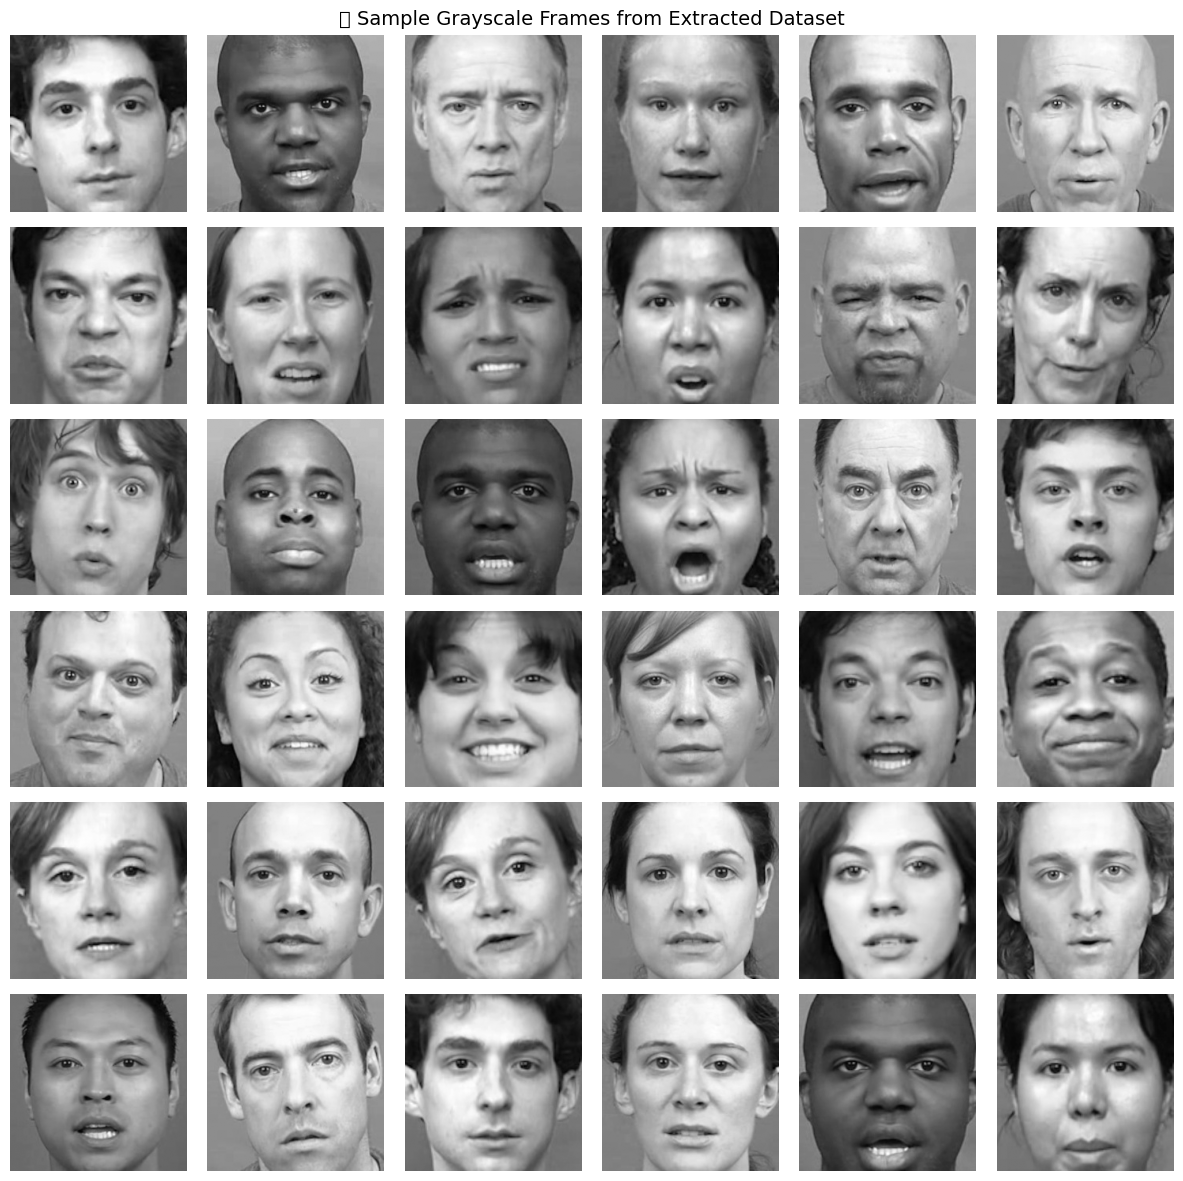

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# =========================================
# CONFIG
# =========================================
frames_root = "/content/Df_Frames"   # <-- path to your saved frames
img_size = (224, 224)                # resize for visualization
samples_per_class = 6                # how many frames per class to show

# =========================================
# VISUALIZE EXISTING FRAMES
# =========================================
def visualize_existing_frames(frames_root, img_size=(224, 224), samples_per_class=5):
    emotions = sorted([d for d in os.listdir(frames_root) if os.path.isdir(os.path.join(frames_root, d))])
    num_classes = len(emotions)

    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 2, num_classes * 2))
    if num_classes == 1:
        axes = [axes]

    for i, emotion in enumerate(emotions):
        emotion_dir = os.path.join(frames_root, emotion)
        video_folders = [os.path.join(emotion_dir, v) for v in os.listdir(emotion_dir)
                         if os.path.isdir(os.path.join(emotion_dir, v))]
        if not video_folders:
            continue

        # Collect all frame paths in this emotion
        all_frames = []
        for v_dir in video_folders:
            frames = [os.path.join(v_dir, f) for f in os.listdir(v_dir) if f.lower().endswith((".jpg", ".png"))]
            all_frames.extend(frames)

        if not all_frames:
            continue

        # Randomly sample frames
        sampled_frames = random.sample(all_frames, min(samples_per_class, len(all_frames)))

        for j, frame_path in enumerate(sampled_frames):
            img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, img_size)

            ax = axes[i][j] if num_classes > 1 else axes[j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.set_ylabel(emotion, fontsize=10, rotation=0, labelpad=30, va='center')

    plt.suptitle("🖼️ Sample Grayscale Frames from Extracted Dataset", fontsize=14)
    plt.tight_layout()
    plt.show()

# =========================================
# RUN VISUALIZATION
# =========================================
visualize_existing_frames(frames_root, img_size, samples_per_class)


In [ ]:
!pip install mediapipe==0.10.14 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 25.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.


### ⚙️ Step 4 — Face Alignment and Contrast Enhancement
This step improves the quality and consistency of facial frames before model training.  
Using **MediaPipe FaceMesh**, it aligns faces based on eye landmarks, rotates them to a neutral orientation, crops the face region, and applies **CLAHE** (Contrast Limited Adaptive Histogram Equalization) to enhance contrast and detail visibility.  
The script also visualizes original vs. preprocessed faces side by side for quality inspection.


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/tmp/ipython-input-3573265415.py:117: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


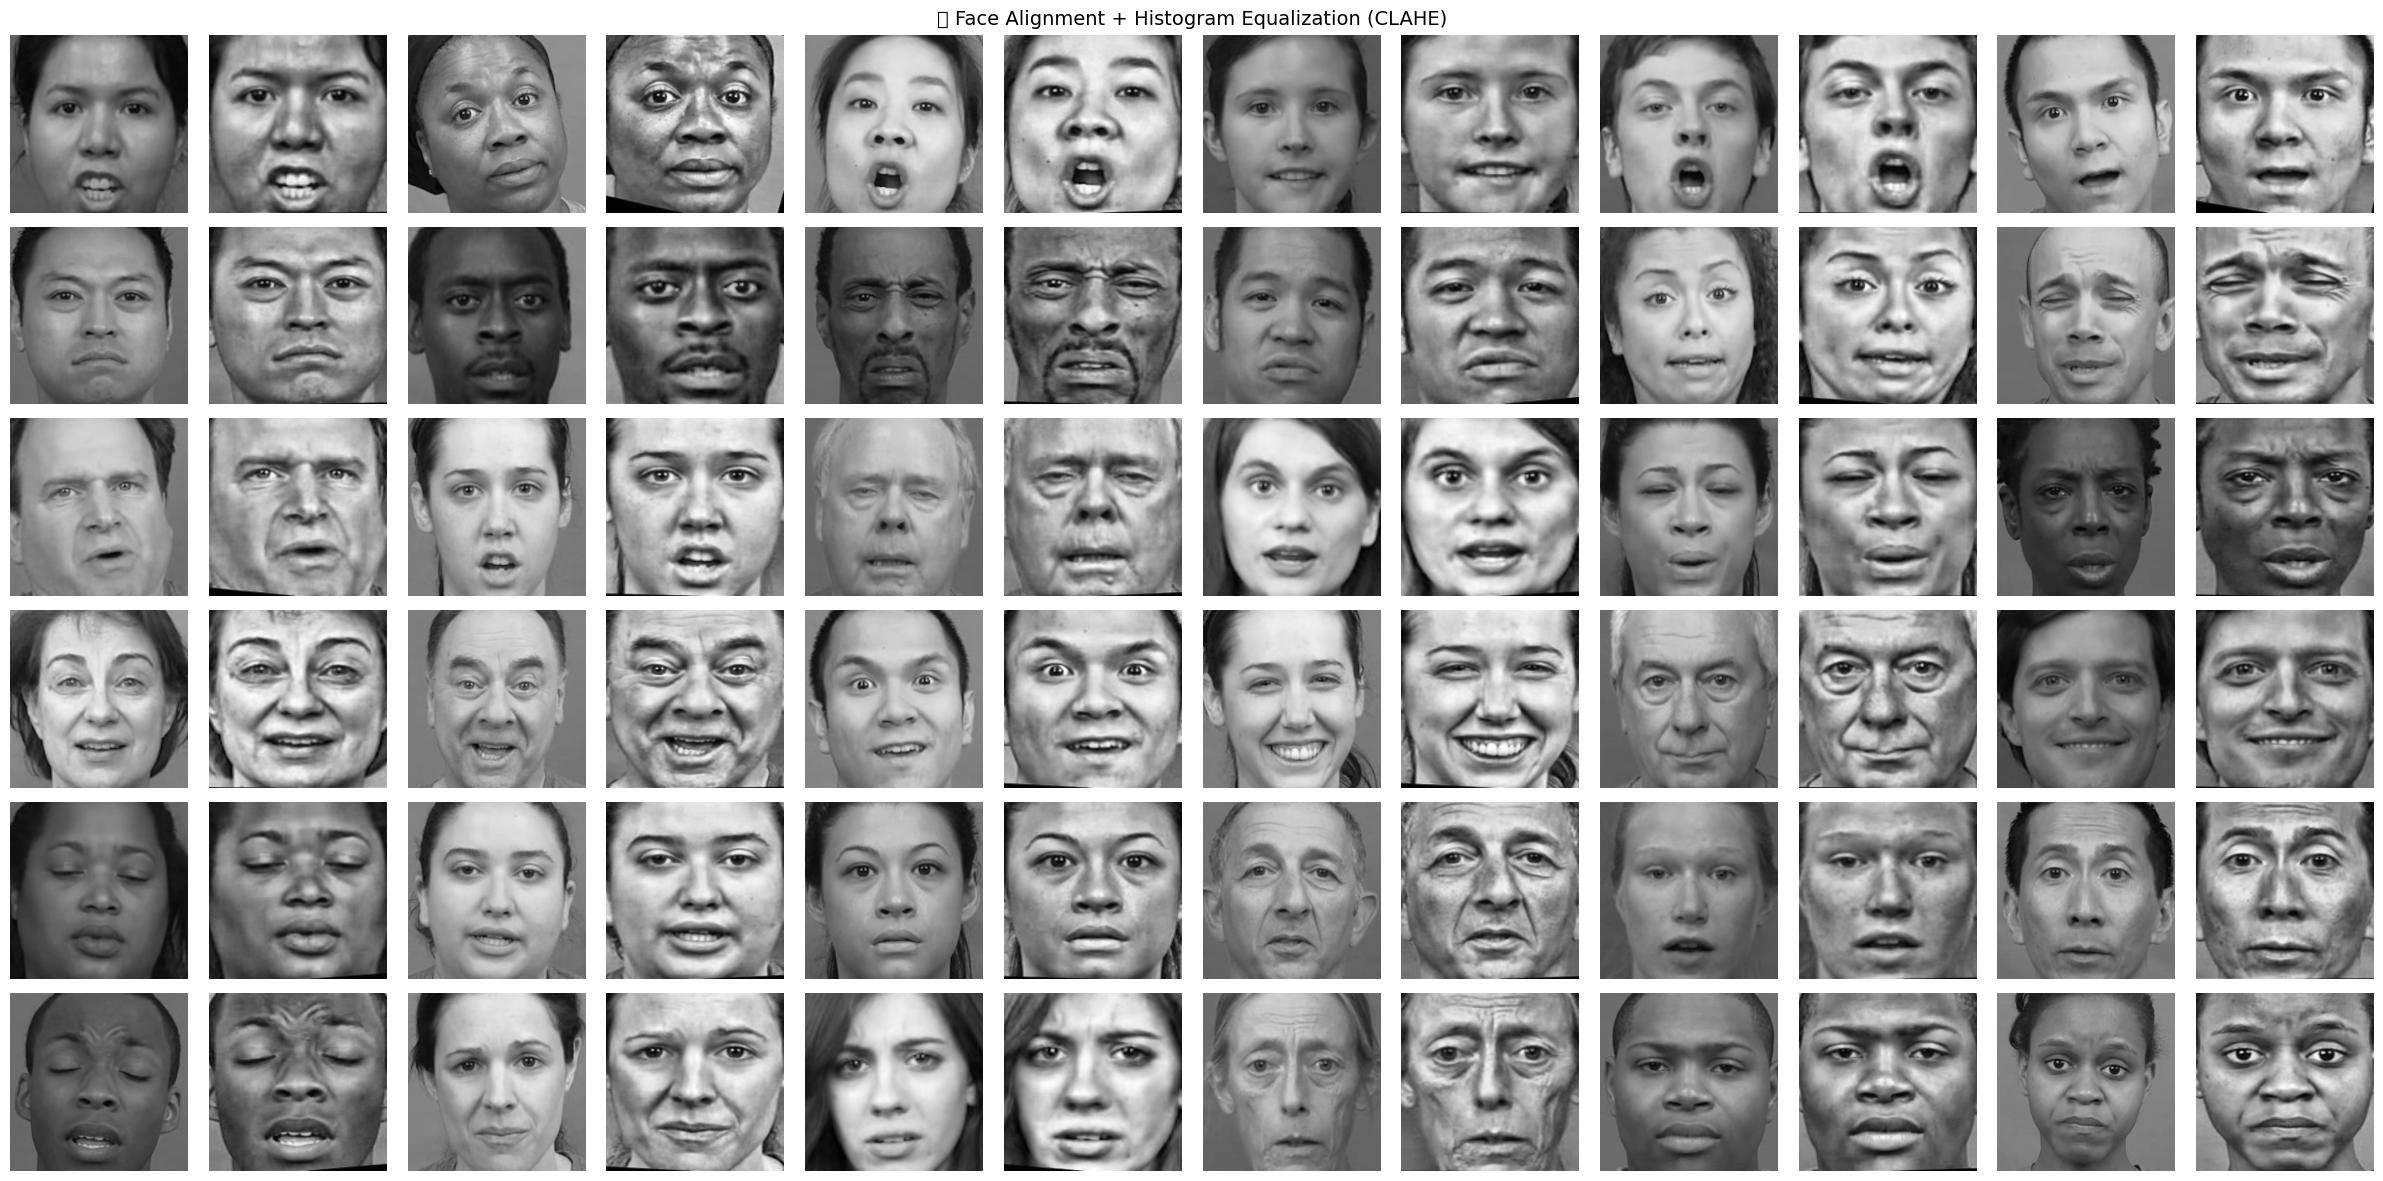

In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

# =========================================
# CONFIG
# =========================================
frames_root = "/content/Df_Frames"   # path to your saved frames
img_size = (224, 224)
samples_per_class = 6

# =========================================
# FACE ALIGNMENT + CLAHE PREPROCESSING
# =========================================
mp_face = mp.solutions.face_mesh

def align_and_equalize_face(img):
    """Align face based on eyes and apply CLAHE histogram equalization."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    with mp_face.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            return cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)  # fallback

        landmarks = results.multi_face_landmarks[0].landmark

        # Extract eye coordinates
        left_eye = np.mean([[landmarks[i].x, landmarks[i].y] for i in [33, 133]], axis=0)
        right_eye = np.mean([[landmarks[i].x, landmarks[i].y] for i in [362, 263]], axis=0)

        h, w = gray.shape
        left_eye = np.array([left_eye[0] * w, left_eye[1] * h])
        right_eye = np.array([right_eye[0] * w, right_eye[1] * h])

        # Compute angle between eyes
        dY = right_eye[1] - left_eye[1]
        dX = right_eye[0] - left_eye[0]
        angle = np.degrees(np.arctan2(dY, dX))

        # Compute center between eyes
        eyes_center = ((left_eye[0] + right_eye[0]) / 2,
                       (left_eye[1] + right_eye[1]) / 2)

        # Rotation matrix
        M = cv2.getRotationMatrix2D(eyes_center, angle, scale=1.0)
        aligned = cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_CUBIC)

        # Crop around the face (optional: tighter box)
        face_rect = cv2.boundingRect(np.array([[p.x * w, p.y * h] for p in landmarks]).astype(np.int32))
        x, y, fw, fh = face_rect
        x, y = max(0, x), max(0, y)
        aligned_crop = aligned[y:y+fh, x:x+fw]

        # Resize to model input size
        aligned_crop = cv2.resize(aligned_crop, img_size)

        # Apply CLAHE (histogram equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        equalized = clahe.apply(aligned_crop)

        return cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)


# =========================================
# VISUALIZE ORIGINAL VS PREPROCESSED FRAMES
# =========================================
def visualize_preprocessing(frames_root, img_size=(224, 224), samples_per_class=5):
    emotions = sorted([d for d in os.listdir(frames_root) if os.path.isdir(os.path.join(frames_root, d))])
    num_classes = len(emotions)

    fig, axes = plt.subplots(num_classes, samples_per_class * 2, figsize=(samples_per_class * 4, num_classes * 2))
    if num_classes == 1:
        axes = [axes]

    for i, emotion in enumerate(emotions):
        emotion_dir = os.path.join(frames_root, emotion)
        video_folders = [os.path.join(emotion_dir, v) for v in os.listdir(emotion_dir)
                         if os.path.isdir(os.path.join(emotion_dir, v))]
        if not video_folders:
            continue

        all_frames = []
        for v_dir in video_folders:
            frames = [os.path.join(v_dir, f) for f in os.listdir(v_dir) if f.lower().endswith((".jpg", ".png"))]
            all_frames.extend(frames)

        if not all_frames:
            continue

        sampled_frames = random.sample(all_frames, min(samples_per_class, len(all_frames)))

        for j, frame_path in enumerate(sampled_frames):
            img = cv2.imread(frame_path)
            if img is None:
                continue

            # Resize original for consistency
            img = cv2.resize(img, img_size)

            # Preprocess (alignment + equalization)
            pre_img = align_and_equalize_face(img)

            # Show before and after
            ax1 = axes[i][2*j] if num_classes > 1 else axes[2*j]
            ax2 = axes[i][2*j + 1] if num_classes > 1 else axes[2*j + 1]
            ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax2.imshow(cv2.cvtColor(pre_img, cv2.COLOR_BGR2RGB))
            ax1.axis('off')
            ax2.axis('off')
            if j == 0:
                ax1.set_ylabel(emotion, fontsize=10, rotation=0, labelpad=30, va='center')

    plt.suptitle("🧠 Face Alignment + Histogram Equalization (CLAHE)", fontsize=14)
    plt.tight_layout()
    plt.show()


# =========================================
# RUN VISUALIZATION
# =========================================
visualize_preprocessing(frames_root, img_size, samples_per_class)


🧠 Step 5 — 3D CNN Model Construction and Training

This step builds and trains a 3D Convolutional Neural Network (3D CNN) for video-based emotion recognition.
It includes:

A 3D ResNet-18 backbone pre-trained on Kinetics400 to extract spatio-temporal features directly from video frames.

A custom classifier head (Linear → ReLU → Dropout → Linear) to map features to the emotion classes.

Frame sequence sampling to handle variable-length videos and ensure consistent input size for the 3D CNN.

Training and validation loops using CrossEntropyLoss and AdamW optimizer, saving the best model based on validation accuracy.

In [ ]:
# =========================================
# IMPORTS
# =========================================
import os, cv2, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)
if device.type == "cuda":
    try:
        print("GPU:", torch.cuda.get_device_name(0))
    except Exception:
        pass


# =========================================
# CONFIGURATION
# =========================================
frames_root = "/content/Df_Frames"   # Folder: emotion/video_name/frames
num_classes = len(sorted(os.listdir(frames_root)))
seq_len = 16        # Typical for 3D CNNs
batch_size = 8
img_size = 112      # Standard input for ResNet3D
epochs = 25
save_path = "best_3dcnn_emotion_model.pt"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.Normalize(mean=[0.43216, 0.394666, 0.37645],
                         std=[0.22803, 0.22145, 0.216989])
])


# =========================================
# DATASET
# =========================================
class EmotionVideoDataset(Dataset):
    def __init__(self, root_dir, seq_len=16, transform=None):
        self.samples = []
        self.labels = []
        self.transform = transform
        self.seq_len = seq_len
        self.class_names = sorted(os.listdir(root_dir))

        for label, emotion in enumerate(self.class_names):
            emotion_dir = os.path.join(root_dir, emotion)
            for vid_folder in os.listdir(emotion_dir):
                vid_path = os.path.join(emotion_dir, vid_folder)
                if not os.path.isdir(vid_path):
                    continue
                frames = sorted([
                    os.path.join(vid_path, f) for f in os.listdir(vid_path)
                    if f.lower().endswith((".jpg", ".png"))
                ])
                if len(frames) >= seq_len:
                    self.samples.append(frames)
                    self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_paths = self.samples[idx]
        label = self.labels[idx]

        step = max(1, len(frame_paths) // self.seq_len)
        selected = frame_paths[::step][:self.seq_len]

        frames = []
        for fp in selected:
            img = cv2.imread(fp)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            img = torch.tensor(img / 255.0, dtype=torch.float32).permute(2, 0, 1)
            if self.transform:
                img = self.transform(img)
            frames.append(img)

        frames = torch.stack(frames)        # [T,3,H,W]
        frames = frames.permute(1, 0, 2, 3) # [3,T,H,W] for 3D CNN
        return frames, torch.tensor(label)


# =========================================
# MODEL: PURE 3D CNN
# =========================================
class Emotion3DCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = models.video.r3d_18(weights=models.video.R3D_18_Weights.KINETICS400_V1)
        self.features = nn.Sequential(*list(base.children())[:-1])  # remove final FC
        in_feats = base.fc.in_features  # 512

        # Reduced classifier to fight overfitting
        self.classifier = nn.Sequential(
            nn.Linear(in_feats, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):  # [B,3,T,H,W]
        feats = self.features(x)       # [B,512,1,1,1]
        feats = feats.view(feats.size(0), -1)  # [B,512]
        out = self.classifier(feats)
        return out


# =========================================
# TRAINING LOOP
# =========================================
def train_model(model, train_dl, val_dl, epochs, save_path="best_3dcnn.pt"):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    best_acc = 0

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for frames, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            frames, labels = frames.to(device), labels.to(device)
            preds = model(frames)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * frames.size(0)
            total_correct += (preds.argmax(1) == labels).sum().item()

        train_acc = total_correct / len(train_dl.dataset)
        print(f"Epoch {epoch+1} | Train Acc: {train_acc*100:.2f}% | Loss: {total_loss/len(train_dl.dataset):.4f}")

        # ---- Validation ----
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for frames, labels in tqdm(val_dl, desc="Validating"):
                frames, labels = frames.to(device), labels.to(device)
                preds = model(frames)
                correct += (preds.argmax(1) == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        print(f"Validation Accuracy: {val_acc*100:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"💾 Saved best model ({best_acc*100:.2f}%)")

    print(f"\n✅ Training complete. Best val accuracy: {best_acc*100:.2f}%")
    return best_acc


# =========================================
# DATALOADERS + TRAIN
# =========================================
dataset = EmotionVideoDataset(frames_root, seq_len=seq_len)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

model = Emotion3DCNN(num_classes=num_classes).to(device)
best_acc = train_model(model, train_dl, val_dl, epochs=epochs, save_path=save_path)


✅ Using device: cuda
GPU: NVIDIA L4


Epoch 1/25 [Train]: 100%|██████████| 358/358 [01:02<00:00,  5.72it/s]


Epoch 1 | Train Acc: 52.82% | Loss: 1.2087


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.33it/s]


Validation Accuracy: 68.53%
💾 Saved best model (68.53%)


Epoch 2/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.81it/s]


Epoch 2 | Train Acc: 71.53% | Loss: 0.7755


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.34it/s]


Validation Accuracy: 73.99%
💾 Saved best model (73.99%)


Epoch 3/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 3 | Train Acc: 80.48% | Loss: 0.5790


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.42it/s]


Validation Accuracy: 77.90%
💾 Saved best model (77.90%)


Epoch 4/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 4 | Train Acc: 85.41% | Loss: 0.4267


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.40it/s]


Validation Accuracy: 70.77%


Epoch 5/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 5 | Train Acc: 88.21% | Loss: 0.3422


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.32it/s]


Validation Accuracy: 77.34%


Epoch 6/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 6 | Train Acc: 93.67% | Loss: 0.2177


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.20it/s]


Validation Accuracy: 72.87%


Epoch 7/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 7 | Train Acc: 93.18% | Loss: 0.2286


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.30it/s]


Validation Accuracy: 80.14%
💾 Saved best model (80.14%)


Epoch 8/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 8 | Train Acc: 95.73% | Loss: 0.1381


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.45it/s]


Validation Accuracy: 74.97%


Epoch 9/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 9 | Train Acc: 95.42% | Loss: 0.1443


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.42it/s]


Validation Accuracy: 78.32%


Epoch 10/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 10 | Train Acc: 96.89% | Loss: 0.0990


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.39it/s]


Validation Accuracy: 80.28%
💾 Saved best model (80.28%)


Epoch 11/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 11 | Train Acc: 97.03% | Loss: 0.0966


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.42it/s]


Validation Accuracy: 78.46%


Epoch 12/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 12 | Train Acc: 96.36% | Loss: 0.1167


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.37it/s]


Validation Accuracy: 77.06%


Epoch 13/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 13 | Train Acc: 97.27% | Loss: 0.0892


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.39it/s]


Validation Accuracy: 77.06%


Epoch 14/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 14 | Train Acc: 97.97% | Loss: 0.0632


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.34it/s]


Validation Accuracy: 80.42%
💾 Saved best model (80.42%)


Epoch 15/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 15 | Train Acc: 97.87% | Loss: 0.0828


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.31it/s]


Validation Accuracy: 80.42%


Epoch 16/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 16 | Train Acc: 98.08% | Loss: 0.0641


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.36it/s]


Validation Accuracy: 78.18%


Epoch 17/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 17 | Train Acc: 97.76% | Loss: 0.0733


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.35it/s]


Validation Accuracy: 79.30%


Epoch 18/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 18 | Train Acc: 97.97% | Loss: 0.0701


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.33it/s]


Validation Accuracy: 79.58%


Epoch 19/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 19 | Train Acc: 98.99% | Loss: 0.0363


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.32it/s]


Validation Accuracy: 82.24%
💾 Saved best model (82.24%)


Epoch 20/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 20 | Train Acc: 98.95% | Loss: 0.0420


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.27it/s]


Validation Accuracy: 82.38%
💾 Saved best model (82.38%)


Epoch 21/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 21 | Train Acc: 97.76% | Loss: 0.0742


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.35it/s]


Validation Accuracy: 80.70%


Epoch 22/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 22 | Train Acc: 98.36% | Loss: 0.0564


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.33it/s]


Validation Accuracy: 80.56%


Epoch 23/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 23 | Train Acc: 98.11% | Loss: 0.0657


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.41it/s]


Validation Accuracy: 76.78%


Epoch 24/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 24 | Train Acc: 98.15% | Loss: 0.0662


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.37it/s]


Validation Accuracy: 80.84%


Epoch 25/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.80it/s]


Epoch 25 | Train Acc: 97.83% | Loss: 0.0734


Validating: 100%|██████████| 90/90 [00:04<00:00, 19.28it/s]


Validation Accuracy: 82.66%
💾 Saved best model (82.66%)

✅ Training complete. Best val accuracy: 82.66%


🧠 Step 5 — 3D CNN Model Construction, Augmentation, and Training

This step builds and trains a 3D Convolutional Neural Network (3D CNN) for video-based emotion recognition, enhanced with data augmentation to improve generalization.
It includes:

Data Augmentation: Random resized crops, horizontal flips, color jitter, and normalization to increase dataset diversity and reduce overfitting.

Custom Dataset: Loads video frames, applies temporal sampling, and transforms frames into tensors suitable for 3D CNN input [3, T, H, W].

3D ResNet-18 Backbone pre-trained on Kinetics400 for extracting spatio-temporal features from sequences of frames.

Classifier Head: Linear → ReLU → Dropout → Linear to map extracted features to emotion classes.

Training & Validation Loops: Uses CrossEntropyLoss and AdamW optimizer, computes accuracy per epoch, and saves the best model based on validation performance.

In [ ]:
# =========================================
# IMPORTS
# =========================================
import os, cv2, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)
if device.type == "cuda":
    try:
        print("GPU:", torch.cuda.get_device_name(0))
    except Exception:
        pass


# =========================================
# CONFIGURATION
# =========================================
frames_root = "/content/Df_Frames"   # Folder: emotion/video_name/frames
num_classes = len(sorted(os.listdir(frames_root)))
seq_len = 16        # Typical for 3D CNNs
batch_size = 8
img_size = 112      # Standard input for ResNet3D
epochs = 25
save_path = "best_3dcnn_emotion_model.pt"

# ---- Data Augmentation ----
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43216, 0.394666, 0.37645],
                         std=[0.22803, 0.22145, 0.216989]),
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43216, 0.394666, 0.37645],
                         std=[0.22803, 0.22145, 0.216989]),
])


# =========================================
# DATASET
# =========================================
class EmotionVideoDataset(Dataset):
    def __init__(self, root_dir, seq_len=16, transform=None):
        self.samples = []
        self.labels = []
        self.transform = transform
        self.seq_len = seq_len
        self.class_names = sorted(os.listdir(root_dir))

        for label, emotion in enumerate(self.class_names):
            emotion_dir = os.path.join(root_dir, emotion)
            for vid_folder in os.listdir(emotion_dir):
                vid_path = os.path.join(emotion_dir, vid_folder)
                if not os.path.isdir(vid_path):
                    continue
                frames = sorted([
                    os.path.join(vid_path, f) for f in os.listdir(vid_path)
                    if f.lower().endswith((".jpg", ".png"))
                ])
                if len(frames) >= seq_len:
                    self.samples.append(frames)
                    self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_paths = self.samples[idx]
        label = self.labels[idx]

        # Random temporal start for augmentation
        if len(frame_paths) > self.seq_len:
            start = torch.randint(0, len(frame_paths) - self.seq_len + 1, (1,)).item()
            selected = frame_paths[start:start + self.seq_len]
        else:
            selected = frame_paths

        frames = []
        for fp in selected:
            img = cv2.imread(fp)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)  # ✅ Convert to PIL before transforms
            if self.transform:
                img = self.transform(img)
            frames.append(img)

        frames = torch.stack(frames)        # [T,3,H,W]
        frames = frames.permute(1, 0, 2, 3) # [3,T,H,W] for 3D CNN
        return frames, torch.tensor(label)


# =========================================
# MODEL: PURE 3D CNN (Pretrained)
# =========================================
class Emotion3DCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = models.video.r3d_18(weights=models.video.R3D_18_Weights.KINETICS400_V1)
        self.features = nn.Sequential(*list(base.children())[:-1])  # remove final FC
        in_feats = base.fc.in_features  # 512

        # Reduced classifier to fight overfitting
        self.classifier = nn.Sequential(
            nn.Linear(in_feats, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):  # [B,3,T,H,W]
        feats = self.features(x)       # [B,512,1,1,1]
        feats = feats.view(feats.size(0), -1)  # [B,512]
        out = self.classifier(feats)
        return out


# =========================================
# TRAINING LOOP
# =========================================
def train_model(model, train_dl, val_dl, epochs, save_path="best_3dcnn.pt"):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    best_acc = 0

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for frames, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            frames, labels = frames.to(device), labels.to(device)
            preds = model(frames)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * frames.size(0)
            total_correct += (preds.argmax(1) == labels).sum().item()

        train_acc = total_correct / len(train_dl.dataset)
        print(f"Epoch {epoch+1} | Train Acc: {train_acc*100:.2f}% | Loss: {total_loss/len(train_dl.dataset):.4f}")

        # ---- Validation ----
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for frames, labels in tqdm(val_dl, desc="Validating"):
                frames, labels = frames.to(device), labels.to(device)
                preds = model(frames)
                correct += (preds.argmax(1) == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        print(f"Validation Accuracy: {val_acc*100:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"💾 Saved best model ({best_acc*100:.2f}%)")

    print(f"\n✅ Training complete. Best val accuracy: {best_acc*100:.2f}%")
    return best_acc


# =========================================
# DATALOADERS + TRAIN
# =========================================
if __name__ == "__main__":
    dataset = EmotionVideoDataset(frames_root, seq_len=seq_len, transform=train_transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

    # Use train_transform for training, val_transform for validation
    val_ds.dataset.transform = val_transform

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    model = Emotion3DCNN(num_classes=num_classes).to(device)
    best_acc = train_model(model, train_dl, val_dl, epochs=epochs, save_path=save_path)


✅ Using device: cuda
GPU: NVIDIA L4


Epoch 1/25 [Train]: 100%|██████████| 358/358 [01:02<00:00,  5.76it/s]


Epoch 1 | Train Acc: 53.69% | Loss: 1.1957


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.66it/s]


Validation Accuracy: 69.37%
💾 Saved best model (69.37%)


Epoch 2/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 2 | Train Acc: 73.07% | Loss: 0.7529


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.44it/s]


Validation Accuracy: 69.37%


Epoch 3/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 3 | Train Acc: 78.98% | Loss: 0.5769


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.63it/s]


Validation Accuracy: 78.74%
💾 Saved best model (78.74%)


Epoch 4/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 4 | Train Acc: 85.31% | Loss: 0.4385


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.58it/s]


Validation Accuracy: 78.18%


Epoch 5/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 5 | Train Acc: 86.43% | Loss: 0.3814


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.65it/s]


Validation Accuracy: 81.40%
💾 Saved best model (81.40%)


Epoch 6/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 6 | Train Acc: 91.64% | Loss: 0.2652


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.65it/s]


Validation Accuracy: 82.10%
💾 Saved best model (82.10%)


Epoch 7/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 7 | Train Acc: 92.41% | Loss: 0.2438


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.66it/s]


Validation Accuracy: 82.10%


Epoch 8/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 8 | Train Acc: 93.42% | Loss: 0.1922


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.70it/s]


Validation Accuracy: 78.04%


Epoch 9/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 9 | Train Acc: 94.16% | Loss: 0.1776


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.66it/s]


Validation Accuracy: 76.78%


Epoch 10/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 10 | Train Acc: 95.28% | Loss: 0.1534


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.50it/s]


Validation Accuracy: 83.50%
💾 Saved best model (83.50%)


Epoch 11/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 11 | Train Acc: 95.42% | Loss: 0.1390


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.58it/s]


Validation Accuracy: 82.66%


Epoch 12/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 12 | Train Acc: 97.03% | Loss: 0.1013


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.73it/s]


Validation Accuracy: 80.28%


Epoch 13/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 13 | Train Acc: 96.78% | Loss: 0.1142


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.74it/s]


Validation Accuracy: 84.34%
💾 Saved best model (84.34%)


Epoch 14/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 14 | Train Acc: 97.10% | Loss: 0.0993


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.71it/s]


Validation Accuracy: 82.38%


Epoch 15/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 15 | Train Acc: 96.92% | Loss: 0.1023


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.65it/s]


Validation Accuracy: 80.42%


Epoch 16/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 16 | Train Acc: 97.45% | Loss: 0.0805


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.69it/s]


Validation Accuracy: 81.54%


Epoch 17/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 17 | Train Acc: 97.38% | Loss: 0.0904


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.71it/s]


Validation Accuracy: 82.52%


Epoch 18/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 18 | Train Acc: 97.13% | Loss: 0.0939


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.55it/s]


Validation Accuracy: 80.14%


Epoch 19/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 19 | Train Acc: 96.68% | Loss: 0.1087


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.74it/s]


Validation Accuracy: 79.86%


Epoch 20/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 20 | Train Acc: 97.76% | Loss: 0.0798


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.66it/s]


Validation Accuracy: 80.56%


Epoch 21/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 21 | Train Acc: 98.74% | Loss: 0.0391


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.70it/s]


Validation Accuracy: 83.22%


Epoch 22/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 22 | Train Acc: 98.43% | Loss: 0.0541


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.65it/s]


Validation Accuracy: 79.72%


Epoch 23/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 23 | Train Acc: 98.64% | Loss: 0.0450


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.78it/s]


Validation Accuracy: 82.10%


Epoch 24/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.78it/s]


Epoch 24 | Train Acc: 96.61% | Loss: 0.1104


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.65it/s]


Validation Accuracy: 82.10%


Epoch 25/25 [Train]: 100%|██████████| 358/358 [01:01<00:00,  5.79it/s]


Epoch 25 | Train Acc: 98.81% | Loss: 0.0464


Validating: 100%|██████████| 90/90 [00:08<00:00, 10.52it/s]

Validation Accuracy: 80.14%

✅ Training complete. Best val accuracy: 84.34%


📊 Step 6 — Model Evaluation and Visualization

This step evaluates the trained 3D CNN on the validation set and visualizes its performance across multiple metrics.
It includes:

Loading the Best Model: Restores the model checkpoint that achieved the highest validation accuracy.

Prediction Collection: Iterates over the validation DataLoader to collect true labels, predicted labels, and raw logits for further analysis.

Confusion Matrix: Computes and visualizes the confusion matrix to understand per-class performance and common misclassifications.

Classification Report: Prints precision, recall, F1-score, and support for each emotion class to summarize model accuracy.

ROC Curve & AUC: Binarizes multi-class labels, applies softmax to logits to get probabilities, and plots the ROC curve per class with corresponding Area Under Curve (AUC) scores for a deeper understanding of class-wise discriminative ability.

Evaluating: 100%|██████████| 90/90 [00:08<00:00, 10.63it/s]


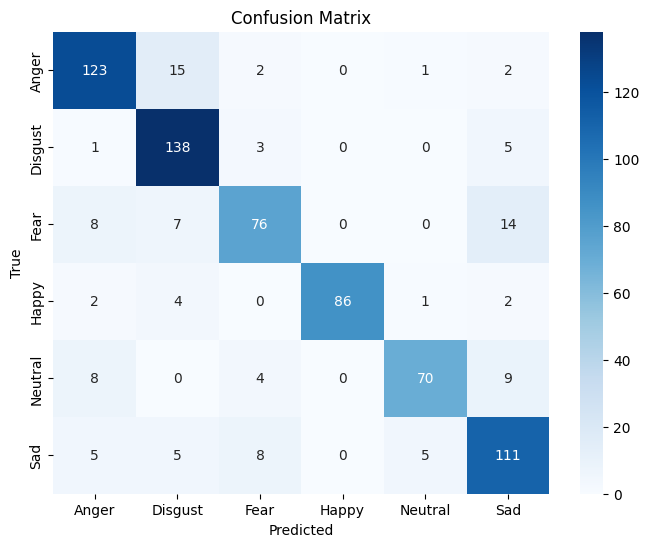

Classification Report:
               precision    recall  f1-score   support

       Anger       0.84      0.86      0.85       143
     Disgust       0.82      0.94      0.87       147
        Fear       0.82      0.72      0.77       105
       Happy       1.00      0.91      0.95        95
     Neutral       0.91      0.77      0.83        91
         Sad       0.78      0.83      0.80       134

    accuracy                           0.84       715
   macro avg       0.86      0.84      0.85       715
weighted avg       0.85      0.84      0.84       715



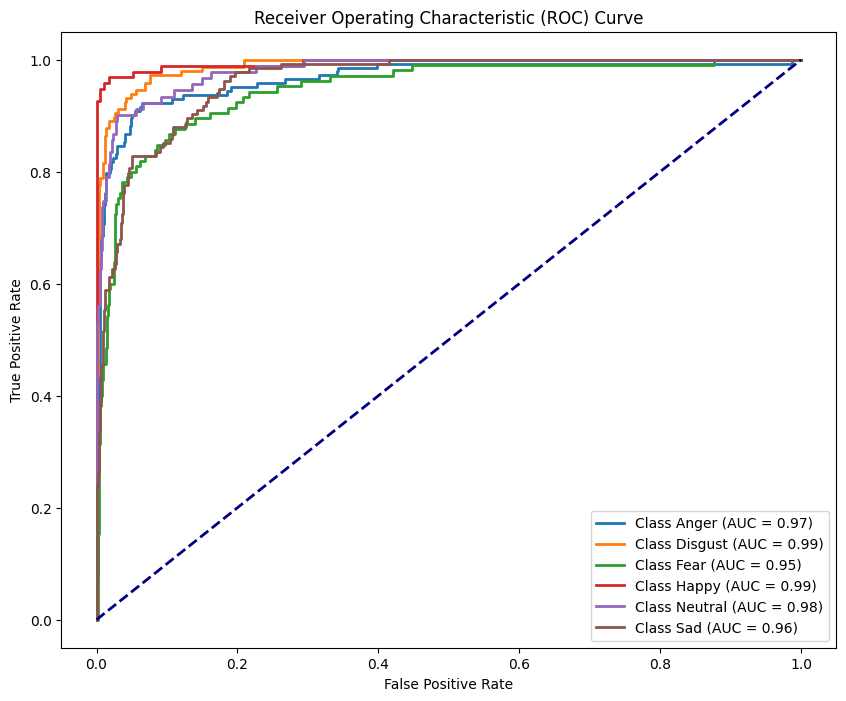

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# =========================================
# EVALUATE AND VISUALIZE
# =========================================

# Load the best model for evaluation
model.load_state_dict(torch.load(save_path))
model.eval()

# Collect all predictions, true labels, and raw model logits
true_labels = []
predictions = []
logits = []  # To store raw logits (before softmax)

with torch.no_grad():
    for frames, labels in tqdm(val_dl, desc="Evaluating"):
        frames, labels = frames.to(device), labels.to(device)
        output = model(frames)
        _, predicted = torch.max(output, 1)
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
        logits.extend(output.cpu().numpy())  # Collect logits for ROC

# =========================================
# 1. Confusion Matrix
# =========================================
cm = confusion_matrix(true_labels, predictions)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.class_names, yticklabels=dataset.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# =========================================
# 2. Classification Report
# =========================================
report = classification_report(true_labels, predictions, target_names=dataset.class_names)
print("Classification Report:\n", report)

# =========================================
# 3. ROC Curve
# =========================================
# Binarize the labels for ROC computation
true_labels_bin = label_binarize(true_labels, classes=range(num_classes))

# Apply softmax to the logits to get probabilities
logits = np.array(logits)
predictions_prob = torch.softmax(torch.tensor(logits), dim=1).cpu().numpy()  # Get class probabilities

# Plot ROC for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], predictions_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {dataset.class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
